# TESS Atlas fit for TOI 530

**Version: 0.1.1**

**Note: This notebook was automatically generated as part of the TESS Atlas project. More information can be found on GitHub:** [github.com/dfm/tess-atlas](https://github.com/dfm/tess-atlas)

In this notebook, we do a quicklook fit for the parameters of the TESS Objects of Interest (TOI) in the system number 530.
To do this fit, we use the [exoplanet](https://exoplanet.dfm.io) library and you can find more information about that project at [exoplanet.dfm.io](https://exoplanet.dfm.io).

From here, you can scroll down and take a look at the fit results, or you can:

- [open the notebook in Google Colab to run the fit yourself](https://colab.research.google.com/github/dfm/tess-atlas/blob/master/notebooks/0.1.1/toi-530.ipynb),
- [view the notebook on GitHub](https://github.com/dfm/tess-atlas/blob/master/notebooks/0.1.1/toi-530.ipynb), or
- [download the notebook](https://github.com/dfm/tess-atlas/raw/master/notebooks/0.1.1/toi-530.ipynb).

## Caveats

There are many caveats associated with this relatively simple "quicklook" type of analysis that should be kept in mind.
Here are some of the main things that come to mind:

1. The orbits that we fit are constrained to be *circular*. One major effect of this approximation is that the fit will significantly overestimate the confidence of the impact parameter constraint, so the results for impact parameter shouldn't be taken too seriously. 

2. Transit timing variations, correlated noise, and (probably) your favorite systematics are ignored. Sorry!

3. This notebook was generated automatically without human intervention. Use at your own risk!

## Table of Contents

1. [Getting started](#Getting-started)
2. [Data & de-trending](#Data-%26amp%3B-de-trending)
3. [Removing stellar variability](#Removing-stellar-variability)
4. [Transit model in PyMC3 & exoplanet](#Transit-model-in-PyMC3-%26amp%3B-exoplanet)
5. [Sampling](#Sampling)
6. [Posterior constraints](#Posterior-constraints)
7. [Attribution](#Attribution)

## Getting started

To get going, we'll need to make out plots show up inline and install a few packages:

In [1]:
%matplotlib inline
!pip install -q -U lightkurve fbpca exoplanet corner pymc3

Then we'll set up the plotting styles and do all of the imports:

In [2]:
import matplotlib.pyplot as plt
plt.style.use("default")

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 16
rcParams["text.usetex"] = False
rcParams["font.family"] = ["sans-serif"]
rcParams["font.sans-serif"] = ["cmss10"]
rcParams["axes.unicode_minus"] = False

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
import logging
logger = logging.getLogger("theano.gof.compilelock")
logger.setLevel(logging.ERROR)

import corner
import numpy as np
import pandas as pd
import lightkurve as lk
import matplotlib.pyplot as plt

import pymc3 as pm
import exoplanet as xo
import theano.tensor as tt

## Data & de-trending

Next, we grab the TOI list from [ExoFOP](https://exofop.ipac.caltech.edu/tess/) to get the information about the system:

In [3]:
toi_num = 530

# Get the table of TOI info from ExoFOP
tois = pd.read_csv("https://exofop.ipac.caltech.edu/tess/download_toi.php?sort=toi&output=csv")

# Select all of the rows in the TOI table that are associated with this target
toi = tois[tois["TOI"] == toi_num + 0.01].iloc[0]
tic = toi['TIC ID']
tois = tois[tois["TIC ID"] == tic].sort_values("TOI")

# Extract the planet periods
periods = np.array(tois["Period (days)"], dtype=float)

# Convert the phase to TBJD from BJD
t0s = np.array(tois["Epoch (BJD)"], dtype=float) - 2457000

# Convert the depth to parts per thousand from parts per million
depths = 1e-3 * np.array(tois["Depth (ppm)"], dtype=float)

# Convert the duration to days from hours
durations = np.array(tois["Duration (hours)"], dtype=float) / 24.0

# Extract the stellar radius from the table
toi_r_star = toi['Stellar Radius (R_Sun)']
toi_r_star_err = toi['Stellar Radius (R_Sun) err']
toi_logg_star = toi['Stellar log(g) (cm/s^2)']
toi_logg_star_err = toi['Stellar log(g) (cm/s^2) err']

# If there is no entry in the table (does this ever happen?)
if not (np.isfinite(toi_r_star) and np.isfinite(toi_r_star_err)):
    raise ValueError("no radius measurement in table")
if not (np.isfinite(toi_logg_star) and np.isfinite(toi_logg_star_err)):
    raise ValueError("no logg measurement in table")

# These are the letters that will be used to identify each candidate
# (are we being a bit optimistic?)
letters = "bcdefghijklmnopqrstuvwxyz"[:len(periods)]

Then we use the [lightkurve](https://docs.lightkurve.org) library to download and de-trend the time series using [pixel-level decorrelation (PLD)](https://docs.lightkurve.org/api/lightkurve.correctors.PLDCorrector.html).
We read in target pixel files (TPFs) for each of the campaigns in which TOI 530 was observed.
To remove systematic noise, we mask out known transits and perform second order PLD. The noise-corrected light curves are stitched together to create a single contiguous light curve.

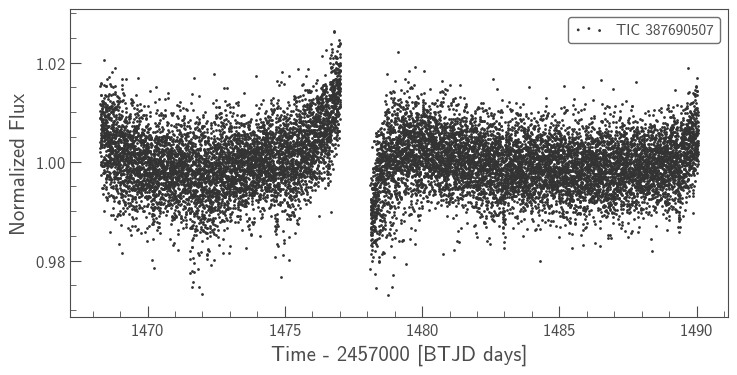

In [4]:
# Download the target pixel files
sr = lk.search_targetpixelfile('TIC %i' % tic)
tpf_collection = sr.download_all(quality_bitmask="hardest")
if tpf_collection is None or not len(tpf_collection):
    raise ValueError("the TESS atlas only works for TPF files")
    
# Extract the exposure time associated with the TPF
hdr = tpf_collection[0].hdu[1].header
texp = hdr["FRAMETIM"] * hdr["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0

# This function can be used to estimate which data points are in transit
# for known phase, period, and duration
def get_transit_mask(t, t0, period, duration):
    hp = 0.5*period
    return np.abs((t-t0+hp) % period - hp) < 0.5*duration

# Run PLD on each TPF to extract the light curves
lc_collection = []
for tpf in tpf_collection:
    mask = np.zeros_like(tpf.time, dtype=bool)
    for i in range(len(periods)):
        mask |= get_transit_mask(tpf.time, t0s[i], periods[i], 5*durations[i])
    pld = tpf.to_corrector("pld")
    try:
        lc = pld.correct(aperture_mask="pipeline", cadence_mask=~mask, use_gp=False, pld_order=2)
    except ValueError:
        lc = pld.correct(aperture_mask="pipeline", cadence_mask=~mask, use_gp=False, pld_order=1)
    lc_collection.append(lc.normalize())

# Normalize and stitch the sectors
lc = lc_collection[0]
if len(lc_collection) > 1:
    lc = lc.append([next_lc for next_lc in lc_collection[1:]])
    
# Remove outliers
_, outliers = lc.remove_outliers(return_mask=True)
mask = np.zeros_like(lc.time, dtype=bool)
for i in range(len(periods)):
    mask |= get_transit_mask(lc.time, t0s[i], periods[i], 2*durations[i])
outliers[mask] = False
lc = lc[~outliers]
    
lc.scatter();

# Removing stellar variability

Next up, we remove stellar variability using a Gaussian Processes model fit to the out of transit data.

In [5]:
# Extract the data and convert to parts per thousand
x = np.ascontiguousarray(lc.time, dtype=np.float64)
y = np.ascontiguousarray((lc.flux - 1.0) * 1e3, dtype=np.float64)
yerr = np.ascontiguousarray(lc.flux_err * 1e3, dtype=np.float64)

# Compute the transit mask
mask = np.zeros_like(x, dtype=bool)
for i in range(len(periods)):
    mask |= get_transit_mask(x, t0s[i], periods[i], 5*durations[i])

# Temporarily increase the in transit error bars substantially
diag = np.array(yerr**2)
diag[mask] += 10000.0

# Build a GP model
with pm.Model() as model:
    logs2 = pm.Normal("logs2", mu=np.log(1e-4*np.var(y)), sd=10)
    logsigma = pm.Normal("logsigma", mu=np.log(np.std(y)), sd=10)
    logrho = pm.Normal("logrho", mu=np.log(10.0), sd=10.0)
    
    kernel = xo.gp.terms.Matern32Term(log_sigma=logsigma, log_rho=logrho)
    gp = xo.gp.GP(kernel, x, diag + tt.exp(logs2), J=2)
    pm.Potential("loglike", gp.log_likelihood(y))
    
    map_soln = xo.optimize()
    pred = xo.utils.eval_in_model(gp.predict(), map_soln)

# Flatten the light curve
y -= pred

optimizing logp for variables: ['logrho', 'logsigma', 'logs2']


message: Optimization terminated successfully.
logp: -53920.89633838456 -> -53792.07344764402


## Transit model in PyMC3 & exoplanet

Here's how we set up the transit model using [exoplanet](https://exoplanet.dfm.io) and [PyMC3](https://docs.pymc.io).
For more information about how to use these libraries take a look at the docs that are linked above.
In this model, the parameters that we're fitting are:

* `mean`: the mean (out-of-transit) flux of the star,
* `r_star`: the radius of the star (with the prior from the TOI list),
* `logg_star`: the surface gravity of the star (with the prior from the TOI list),
* `u`: the quadratic limb darkening parameters, parameterized following [Kipping (2013)](https://arxiv.org/abs/1308.0009)
* `t0`: the time of a reference transit for each planet,
* `logP`: the log of the obribatl periods,
* `r`: the planet radius ratios (relative to the star),
* `b`: the impact parameter in units of the stellar radius, `b` and `r` are both parameterized following [Espinoza (2018)](https://iopscience.iop.org/article/10.3847/2515-5172/aaef38/meta), and
* `logs2`: a jitter parameter that captures excess noise or underrestimated error bars.

A few key assumptions include:

* The orbits are assumed to be circular so the constraints on impact parameter (which would be severely degenerate with eccentricity) will be tighter than they should be.
* The noise is assumed to be Gaussian and independent. This means that all correlated noise should be removed in advance. Since we flattened the light curve using a Gaussian process above, this should be not totally unreasonable.
* We are neglecting transit times (the ephemeris is assumed to be linear) which should be sufficient for most cases with the short TESS baseline, but transit timing variations could be important for some targets.

In [6]:
# factor * 10**logg / r_star = rho
factor = 5.141596357654149e-05

def build_model(x, y, yerr, periods, t0s, depths, mask=None, start=None):
    """Build an exoplanet model for a dataset and set of planets
    
    Args:
        x: The time series (in days); this should probably be centered
        y: The relative fluxes (in parts per thousand)
        yerr: The uncertainties on ``y``
        periods: The periods of the planets (in days)
        t0s: The phases of the planets in the same coordinates as ``x``
        depths: The depths of the transits in parts per thousand
        mask: A boolean mask with the same shape as ``x`` indicating which
            data points should be included in the fit
        start: A dictionary of model parameters where the optimization
            should be initialized
            
    Returns:
        A PyMC3 model specifying the probabilistic model for the light curve

    """
    if mask is None:
        mask = np.ones(len(x), dtype=bool)
    
    periods = np.atleast_1d(periods)
    t0s = np.atleast_1d(t0s)
    depths = np.atleast_1d(depths)
    n_planets = len(periods)
    
    with pm.Model() as model:
        
        # Extract the un-masked data points
        model.x = x[mask]
        model.y = y[mask]
        model.yerr = (yerr + np.zeros_like(x))[mask]
        model.mask = mask

        # The baseline (out-of-transit) flux for the star in ppt. This
        # should be close to one because of how we normalized the data
        mean = pm.Normal("mean", mu=0.0, sd=10.0)
        
        logg_star = pm.Normal("logg_star", mu=toi_logg_star, sd=toi_logg_star_err)
        r_star = pm.Bound(pm.Normal, lower=0.0)("r_star", mu=toi_r_star, sd=toi_r_star_err)
        rho_star = pm.Deterministic("rho_star", factor * 10**logg_star / r_star)

        # The time of a reference transit for each planet
        t0 = pm.Normal("t0", mu=t0s, sd=1.0, shape=n_planets)

        # The log period; also tracking the period itself
        logP = pm.Normal("logP", mu=np.log(periods), sd=0.1, shape=n_planets)
        period = pm.Deterministic("period", tt.exp(logP))

        # The Kipping (2013) parameterization for quadratic limb darkening paramters
        u = xo.distributions.QuadLimbDark("u")

        # The Espinoza (2018) parameterization for the joint radius ratio and
        # impact parameter distribution
        r, b = xo.distributions.get_joint_radius_impact(
            min_radius=0.001, max_radius=1.0,
            testval_r=np.sqrt(1e-3*np.array(depths)),
            testval_b=0.5+np.zeros(n_planets)
        )
        r_pl = pm.Deterministic("r_pl", r * r_star)

        # This shouldn't make a huge difference, but I like to put a uniform
        # prior on the *log* of the radius ratio instead of the value. This
        # can be implemented by adding a custom "potential" (log probability).
        pm.Potential("r_prior", -pm.math.log(r))

        # Set up a Keplerian orbit for the planets
        model.orbit = xo.orbits.KeplerianOrbit(
            period=period, t0=t0, b=b, r_star=r_star, rho_star=rho_star)
        
        # Compute the model light curve using starry
        model.light_curves = xo.StarryLightCurve(u).get_light_curve(
            orbit=model.orbit, r=r_pl, t=model.x)
        model.light_curve = pm.math.sum(model.light_curves, axis=-1) * 1e3 + mean

        # Jitter and likelihood function
        logs2 = pm.Normal("logs2", mu=np.log(np.mean(model.yerr)), sd=10)
        pm.Normal("obs", mu=model.light_curve, sd=tt.sqrt(model.yerr**2+tt.exp(logs2)),
                  observed=model.y)

        # Fit for the maximum a posteriori parameters, I've found that I can get
        # a better solution by trying different combinations of parameters in turn
        if start is None:
            start = model.test_point
        map_soln = start        
        map_soln = xo.optimize(start=map_soln, vars=[logs2, mean])
        map_soln = xo.optimize(start=map_soln, vars=[model.rb, mean])
        map_soln = xo.optimize(start=map_soln, vars=[logg_star])
        map_soln = xo.optimize(start=map_soln, vars=[logP, t0, mean])
        map_soln = xo.optimize(start=map_soln, vars=[model.rb, mean])
        map_soln = xo.optimize(start=map_soln)
        model.map_soln = map_soln
        
    return model

def build_model_sigma_clip(x, y, yerr, periods, t0s, depths, sigma=5.0, maxiter=10, start=None):
    ntot = len(x)
    for i in range(maxiter):
        print("*** Sigma clipping round {0} ***".format(i+1))
        
        # Build the model
        model = build_model(x, y, yerr, periods, t0s, depths, start=start)
        start = model.map_soln

        # Compute the map prediction
        with model:
            mod = xo.utils.eval_in_model(model.light_curve, model.map_soln)
            
        # Do sigma clipping
        resid = y - mod
        rms = np.sqrt(np.median(resid**2))
        mask = np.abs(resid) < sigma * rms
        if ntot == mask.sum():
            break
        ntot = mask.sum()

    return model

Using the above function, we'll generate a probabilistic model for the light curve and plot the maximum a posteriori fit.

*** Sigma clipping round 1 ***


optimizing logp for variables: ['mean', 'logs2']


message: Optimization terminated successfully.
logp: -51562.887382899055 -> -51096.50322698853


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Optimization terminated successfully.
logp: -51096.50322698853 -> -50509.772171361416


optimizing logp for variables: ['logg_star']


message: Desired error not necessarily achieved due to precision loss.
logp: -50509.772171361416 -> -50509.76137332992


optimizing logp for variables: ['mean', 't0', 'logP']


message: Optimization terminated successfully.
logp: -50509.76137332992 -> -50509.734166416376


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Optimization terminated successfully.
logp: -50509.734166416376 -> -50509.72460561304


optimizing logp for variables: ['logs2', 'rb_radiusimpact__', 'u_quadlimbdark__', 'logP', 't0', 'r_star_lowerbound__', 'logg_star', 'mean']


message: Desired error not necessarily achieved due to precision loss.
logp: -50509.72460561304 -> -50486.15981493841


*** Sigma clipping round 2 ***


optimizing logp for variables: ['mean', 'logs2']


message: Optimization terminated successfully.
logp: -50486.15981493841 -> -50486.15981493841


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Optimization terminated successfully.
logp: -50486.15981493841 -> -50486.15981493841


optimizing logp for variables: ['logg_star']


message: Desired error not necessarily achieved due to precision loss.
logp: -50486.15981493841 -> -50486.15981493841


optimizing logp for variables: ['mean', 't0', 'logP']


message: Desired error not necessarily achieved due to precision loss.
logp: -50486.15981493841 -> -50486.15981493841


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Optimization terminated successfully.
logp: -50486.15981493841 -> -50486.15981493841


optimizing logp for variables: ['logs2', 'rb_radiusimpact__', 'u_quadlimbdark__', 'logP', 't0', 'r_star_lowerbound__', 'logg_star', 'mean']


message: Desired error not necessarily achieved due to precision loss.
logp: -50486.15981493841 -> -50486.15981493841


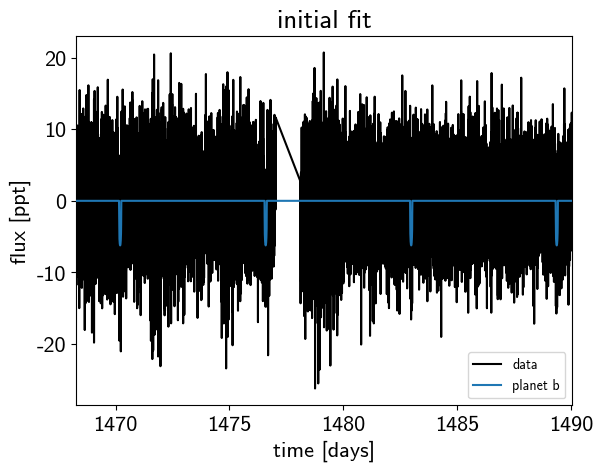

In [7]:
model = build_model_sigma_clip(x, y, yerr, periods, t0s, depths)

with model:
    mean = model.map_soln["mean"]
    light_curves = xo.utils.eval_in_model(model.light_curves, model.map_soln)

plt.plot(model.x, model.y - mean, "k", label="data")
for n, l in enumerate(letters):
    plt.plot(model.x, 1e3 * light_curves[:, n], label="planet {0}".format(l), zorder=100-n)

plt.xlabel("time [days]")
plt.ylabel("flux [ppt]")
plt.title("initial fit")
plt.xlim(model.x.min(), model.x.max())
plt.legend(fontsize=10);

## Sampling

Now we use PyMC3 to sample the posterior density for the parameters of this model.

In [8]:
np.random.seed(123)
sampler = xo.PyMC3Sampler(window=50, start=50, finish=500)
with model:
    burnin = sampler.tune(tune=3000, start=model.map_soln,
                          step_kwargs=dict(target_accept=0.9),
                          chains=2, cores=2)
    trace = sampler.sample(draws=1000, chains=2, cores=2)

Sampling 2 chains:   0%|          | 0/104 [00:00<?, ?draws/s]

Sampling 2 chains:   8%|▊         | 8/104 [00:00<00:04, 20.62draws/s]

Sampling 2 chains:   9%|▊         | 9/104 [00:00<00:10,  9.46draws/s]

Sampling 2 chains:  10%|▉         | 10/104 [00:01<00:19,  4.82draws/s]

Sampling 2 chains:  12%|█▏        | 12/104 [00:01<00:21,  4.25draws/s]

Sampling 2 chains:  12%|█▎        | 13/104 [00:01<00:18,  4.86draws/s]

Sampling 2 chains:  13%|█▎        | 14/104 [00:02<00:25,  3.56draws/s]

Sampling 2 chains:  14%|█▍        | 15/104 [00:02<00:24,  3.61draws/s]

Sampling 2 chains:  15%|█▌        | 16/104 [00:02<00:24,  3.63draws/s]

Sampling 2 chains:  16%|█▋        | 17/104 [00:03<00:27,  3.19draws/s]

Sampling 2 chains:  17%|█▋        | 18/104 [00:03<00:25,  3.38draws/s]

Sampling 2 chains:  18%|█▊        | 19/104 [00:03<00:25,  3.35draws/s]

Sampling 2 chains:  19%|█▉        | 20/104 [00:04<00:24,  3.46draws/s]

Sampling 2 chains:  20%|██        | 21/104 [00:04<00:27,  3.06draws/s]

Sampling 2 chains:  21%|██        | 22/104 [00:04<00:22,  3.65draws/s]

Sampling 2 chains:  22%|██▏       | 23/104 [00:05<00:27,  2.96draws/s]

Sampling 2 chains:  24%|██▍       | 25/104 [00:05<00:25,  3.07draws/s]

Sampling 2 chains:  26%|██▌       | 27/104 [00:06<00:23,  3.22draws/s]

Sampling 2 chains:  28%|██▊       | 29/104 [00:06<00:21,  3.42draws/s]

Sampling 2 chains:  30%|██▉       | 31/104 [00:07<00:21,  3.45draws/s]

Sampling 2 chains:  32%|███▏      | 33/104 [00:07<00:20,  3.48draws/s]

Sampling 2 chains:  34%|███▎      | 35/104 [00:08<00:19,  3.52draws/s]

Sampling 2 chains:  35%|███▍      | 36/104 [00:08<00:15,  4.36draws/s]

Sampling 2 chains:  36%|███▌      | 37/104 [00:08<00:19,  3.43draws/s]

Sampling 2 chains:  38%|███▊      | 39/104 [00:09<00:18,  3.54draws/s]

Sampling 2 chains:  39%|███▉      | 41/104 [00:09<00:16,  3.71draws/s]

Sampling 2 chains:  41%|████▏     | 43/104 [00:10<00:16,  3.75draws/s]

Sampling 2 chains:  43%|████▎     | 45/104 [00:11<00:15,  3.72draws/s]

Sampling 2 chains:  45%|████▌     | 47/104 [00:11<00:13,  4.08draws/s]

Sampling 2 chains:  46%|████▌     | 48/104 [00:11<00:14,  3.93draws/s]

Sampling 2 chains:  47%|████▋     | 49/104 [00:11<00:14,  3.82draws/s]

Sampling 2 chains:  48%|████▊     | 50/104 [00:12<00:16,  3.28draws/s]

Sampling 2 chains:  49%|████▉     | 51/104 [00:12<00:13,  3.96draws/s]

Sampling 2 chains:  50%|█████     | 52/104 [00:12<00:15,  3.37draws/s]

Sampling 2 chains:  51%|█████     | 53/104 [00:13<00:13,  3.78draws/s]

Sampling 2 chains:  52%|█████▏    | 54/104 [00:13<00:13,  3.58draws/s]

Sampling 2 chains:  53%|█████▎    | 55/104 [00:13<00:12,  3.95draws/s]

Sampling 2 chains:  54%|█████▍    | 56/104 [00:13<00:13,  3.63draws/s]

Sampling 2 chains:  55%|█████▍    | 57/104 [00:14<00:11,  3.97draws/s]

Sampling 2 chains:  56%|█████▌    | 58/104 [00:14<00:12,  3.70draws/s]

Sampling 2 chains:  57%|█████▋    | 59/104 [00:14<00:11,  3.97draws/s]

Sampling 2 chains:  58%|█████▊    | 60/104 [00:14<00:11,  3.73draws/s]

Sampling 2 chains:  59%|█████▊    | 61/104 [00:15<00:11,  3.83draws/s]

Sampling 2 chains:  60%|█████▉    | 62/104 [00:15<00:11,  3.61draws/s]

Sampling 2 chains:  61%|██████    | 63/104 [00:15<00:11,  3.51draws/s]

Sampling 2 chains:  62%|██████▏   | 64/104 [00:16<00:11,  3.62draws/s]

Sampling 2 chains:  62%|██████▎   | 65/104 [00:16<00:13,  2.99draws/s]

Sampling 2 chains:  63%|██████▎   | 66/104 [00:16<00:11,  3.19draws/s]

Sampling 2 chains:  64%|██████▍   | 67/104 [00:17<00:13,  2.81draws/s]

Sampling 2 chains:  65%|██████▌   | 68/104 [00:17<00:10,  3.28draws/s]

Sampling 2 chains:  66%|██████▋   | 69/104 [00:17<00:13,  2.68draws/s]

Sampling 2 chains:  68%|██████▊   | 71/104 [00:18<00:10,  3.01draws/s]

Sampling 2 chains:  69%|██████▉   | 72/104 [00:18<00:10,  3.08draws/s]

Sampling 2 chains:  70%|███████   | 73/104 [00:18<00:09,  3.30draws/s]

Sampling 2 chains:  71%|███████   | 74/104 [00:19<00:10,  2.95draws/s]

Sampling 2 chains:  72%|███████▏  | 75/104 [00:19<00:08,  3.29draws/s]

Sampling 2 chains:  74%|███████▍  | 77/104 [00:20<00:08,  3.36draws/s]

Sampling 2 chains:  75%|███████▌  | 78/104 [00:20<00:06,  3.96draws/s]

Sampling 2 chains:  76%|███████▌  | 79/104 [00:20<00:07,  3.30draws/s]

Sampling 2 chains:  77%|███████▋  | 80/104 [00:21<00:07,  3.34draws/s]

Sampling 2 chains:  78%|███████▊  | 81/104 [00:21<00:07,  3.18draws/s]

Sampling 2 chains:  79%|███████▉  | 82/104 [00:21<00:07,  3.04draws/s]

Sampling 2 chains:  80%|███████▉  | 83/104 [00:21<00:06,  3.46draws/s]

Sampling 2 chains:  81%|████████  | 84/104 [00:22<00:07,  2.79draws/s]

Sampling 2 chains:  83%|████████▎ | 86/104 [00:22<00:05,  3.08draws/s]

Sampling 2 chains:  84%|████████▎ | 87/104 [00:23<00:04,  3.52draws/s]

Sampling 2 chains:  85%|████████▍ | 88/104 [00:23<00:05,  3.06draws/s]

Sampling 2 chains:  86%|████████▌ | 89/104 [00:23<00:03,  3.76draws/s]

Sampling 2 chains:  87%|████████▋ | 90/104 [00:24<00:04,  3.29draws/s]

Sampling 2 chains:  88%|████████▊ | 91/104 [00:24<00:03,  3.97draws/s]

Sampling 2 chains:  88%|████████▊ | 92/104 [00:24<00:03,  3.39draws/s]

Sampling 2 chains:  89%|████████▉ | 93/104 [00:24<00:02,  4.15draws/s]

Sampling 2 chains:  90%|█████████ | 94/104 [00:25<00:02,  3.52draws/s]

Sampling 2 chains:  91%|█████████▏| 95/104 [00:25<00:02,  4.29draws/s]

Sampling 2 chains:  92%|█████████▏| 96/104 [00:25<00:02,  3.50draws/s]

Sampling 2 chains:  94%|█████████▍| 98/104 [00:26<00:01,  3.62draws/s]

Sampling 2 chains:  96%|█████████▌| 100/104 [00:26<00:01,  3.53draws/s]

Sampling 2 chains:  98%|█████████▊| 102/104 [00:27<00:00,  3.32draws/s]

Sampling 2 chains:  99%|█████████▉| 103/104 [00:28<00:00,  1.53draws/s]

Sampling 2 chains: 100%|██████████| 104/104 [00:29<00:00,  1.55draws/s]

Sampling 2 chains:   0%|          | 0/104 [00:00<?, ?draws/s]

Sampling 2 chains:   7%|▋         | 7/104 [00:00<00:01, 69.11draws/s]

Sampling 2 chains:  10%|▉         | 10/104 [00:00<00:06, 13.83draws/s]

Sampling 2 chains:  12%|█▏        | 12/104 [00:01<00:11,  7.81draws/s]

Sampling 2 chains:  13%|█▎        | 14/104 [00:01<00:15,  5.84draws/s]

Sampling 2 chains:  14%|█▍        | 15/104 [00:02<00:23,  3.73draws/s]

Sampling 2 chains:  16%|█▋        | 17/104 [00:02<00:23,  3.77draws/s]

Sampling 2 chains:  18%|█▊        | 19/104 [00:03<00:22,  3.77draws/s]

Sampling 2 chains:  20%|██        | 21/104 [00:03<00:22,  3.73draws/s]

Sampling 2 chains:  22%|██▏       | 23/104 [00:04<00:22,  3.68draws/s]

Sampling 2 chains:  24%|██▍       | 25/104 [00:04<00:20,  3.81draws/s]

Sampling 2 chains:  26%|██▌       | 27/104 [00:05<00:19,  3.87draws/s]

Sampling 2 chains:  28%|██▊       | 29/104 [00:05<00:19,  3.82draws/s]

Sampling 2 chains:  30%|██▉       | 31/104 [00:06<00:18,  3.92draws/s]

Sampling 2 chains:  32%|███▏      | 33/104 [00:06<00:18,  3.89draws/s]

Sampling 2 chains:  34%|███▎      | 35/104 [00:07<00:18,  3.83draws/s]

Sampling 2 chains:  36%|███▌      | 37/104 [00:07<00:13,  4.81draws/s]

Sampling 2 chains:  37%|███▋      | 38/104 [00:08<00:17,  3.78draws/s]

Sampling 2 chains:  38%|███▊      | 39/104 [00:08<00:16,  4.04draws/s]

Sampling 2 chains:  38%|███▊      | 40/104 [00:08<00:16,  3.77draws/s]

Sampling 2 chains:  39%|███▉      | 41/104 [00:08<00:19,  3.26draws/s]

Sampling 2 chains:  41%|████▏     | 43/104 [00:09<00:18,  3.31draws/s]

Sampling 2 chains:  42%|████▏     | 44/104 [00:09<00:14,  4.00draws/s]

Sampling 2 chains:  43%|████▎     | 45/104 [00:10<00:17,  3.34draws/s]

Sampling 2 chains:  44%|████▍     | 46/104 [00:10<00:17,  3.32draws/s]

Sampling 2 chains:  45%|████▌     | 47/104 [00:10<00:15,  3.60draws/s]

Sampling 2 chains:  46%|████▌     | 48/104 [00:10<00:16,  3.41draws/s]

Sampling 2 chains:  48%|████▊     | 50/104 [00:11<00:15,  3.47draws/s]

Sampling 2 chains:  50%|█████     | 52/104 [00:12<00:14,  3.56draws/s]

Sampling 2 chains:  51%|█████     | 53/104 [00:12<00:13,  3.81draws/s]

Sampling 2 chains:  52%|█████▏    | 54/104 [00:12<00:13,  3.59draws/s]

Sampling 2 chains:  53%|█████▎    | 55/104 [00:12<00:15,  3.23draws/s]

Sampling 2 chains:  54%|█████▍    | 56/104 [00:13<00:11,  4.03draws/s]

Sampling 2 chains:  55%|█████▍    | 57/104 [00:13<00:15,  3.03draws/s]

Sampling 2 chains:  57%|█████▋    | 59/104 [00:14<00:13,  3.24draws/s]

Sampling 2 chains:  58%|█████▊    | 60/104 [00:14<00:13,  3.38draws/s]

Sampling 2 chains:  59%|█████▊    | 61/104 [00:14<00:11,  3.63draws/s]

Sampling 2 chains:  61%|██████    | 63/104 [00:15<00:11,  3.48draws/s]

Sampling 2 chains:  62%|██████▎   | 65/104 [00:15<00:10,  3.57draws/s]

Sampling 2 chains:  64%|██████▍   | 67/104 [00:16<00:10,  3.57draws/s]

Sampling 2 chains:  65%|██████▌   | 68/104 [00:16<00:08,  4.15draws/s]

Sampling 2 chains:  66%|██████▋   | 69/104 [00:16<00:09,  3.51draws/s]

Sampling 2 chains:  67%|██████▋   | 70/104 [00:17<00:10,  3.35draws/s]

Sampling 2 chains:  68%|██████▊   | 71/104 [00:17<00:08,  3.73draws/s]

Sampling 2 chains:  69%|██████▉   | 72/104 [00:17<00:09,  3.37draws/s]

Sampling 2 chains:  70%|███████   | 73/104 [00:17<00:08,  3.87draws/s]

Sampling 2 chains:  71%|███████   | 74/104 [00:18<00:10,  2.90draws/s]

Sampling 2 chains:  73%|███████▎  | 76/104 [00:19<00:09,  2.96draws/s]

Sampling 2 chains:  75%|███████▌  | 78/104 [00:19<00:08,  3.10draws/s]

Sampling 2 chains:  77%|███████▋  | 80/104 [00:19<00:06,  3.76draws/s]

Sampling 2 chains:  78%|███████▊  | 81/104 [00:20<00:05,  4.44draws/s]

Sampling 2 chains:  79%|███████▉  | 82/104 [00:20<00:06,  3.42draws/s]

Sampling 2 chains:  81%|████████  | 84/104 [00:21<00:05,  3.34draws/s]

Sampling 2 chains:  83%|████████▎ | 86/104 [00:21<00:05,  3.43draws/s]

Sampling 2 chains:  85%|████████▍ | 88/104 [00:22<00:04,  3.53draws/s]

Sampling 2 chains:  87%|████████▋ | 90/104 [00:22<00:03,  3.58draws/s]

Sampling 2 chains:  88%|████████▊ | 92/104 [00:23<00:03,  3.57draws/s]

Sampling 2 chains:  90%|█████████ | 94/104 [00:23<00:02,  4.22draws/s]

Sampling 2 chains:  91%|█████████▏| 95/104 [00:23<00:02,  4.35draws/s]

Sampling 2 chains:  92%|█████████▏| 96/104 [00:24<00:02,  3.76draws/s]

Sampling 2 chains:  93%|█████████▎| 97/104 [00:24<00:01,  4.48draws/s]

Sampling 2 chains:  94%|█████████▍| 98/104 [00:24<00:01,  3.53draws/s]

Sampling 2 chains:  96%|█████████▌| 100/104 [00:25<00:01,  3.57draws/s]

Sampling 2 chains:  98%|█████████▊| 102/104 [00:25<00:00,  4.56draws/s]

Sampling 2 chains:  99%|█████████▉| 103/104 [00:27<00:00,  1.36draws/s]

Sampling 2 chains: 100%|██████████| 104/104 [00:27<00:00,  1.80draws/s]

Sampling 2 chains:   0%|          | 0/204 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 1/204 [00:00<01:53,  1.79draws/s]

Sampling 2 chains:   1%|▏         | 3/204 [00:00<01:22,  2.43draws/s]

Sampling 2 chains:   2%|▏         | 5/204 [00:01<01:10,  2.81draws/s]

Sampling 2 chains:   3%|▎         | 6/204 [00:01<01:02,  3.15draws/s]

Sampling 2 chains:   3%|▎         | 7/204 [00:01<01:01,  3.18draws/s]

Sampling 2 chains:   4%|▍         | 8/204 [00:02<01:06,  2.95draws/s]

Sampling 2 chains:   4%|▍         | 9/204 [00:02<00:52,  3.71draws/s]

Sampling 2 chains:   5%|▍         | 10/204 [00:02<01:10,  2.75draws/s]

Sampling 2 chains:   6%|▌         | 12/204 [00:03<01:03,  3.01draws/s]

Sampling 2 chains:   6%|▋         | 13/204 [00:03<00:58,  3.28draws/s]

Sampling 2 chains:   7%|▋         | 14/204 [00:03<00:58,  3.26draws/s]

Sampling 2 chains:   7%|▋         | 15/204 [00:04<00:57,  3.29draws/s]

Sampling 2 chains:   8%|▊         | 16/204 [00:04<00:47,  3.98draws/s]

Sampling 2 chains:   8%|▊         | 17/204 [00:04<00:40,  4.63draws/s]

Sampling 2 chains:   9%|▉         | 18/204 [00:04<00:54,  3.40draws/s]

Sampling 2 chains:  10%|▉         | 20/204 [00:05<00:52,  3.48draws/s]

Sampling 2 chains:  11%|█         | 22/204 [00:05<00:50,  3.60draws/s]

Sampling 2 chains:  12%|█▏        | 24/204 [00:06<00:48,  3.68draws/s]

Sampling 2 chains:  13%|█▎        | 26/204 [00:06<00:40,  4.38draws/s]

Sampling 2 chains:  13%|█▎        | 27/204 [00:06<00:41,  4.25draws/s]

Sampling 2 chains:  14%|█▎        | 28/204 [00:07<00:35,  4.94draws/s]

Sampling 2 chains:  14%|█▍        | 29/204 [00:07<00:46,  3.79draws/s]

Sampling 2 chains:  15%|█▍        | 30/204 [00:07<00:39,  4.41draws/s]

Sampling 2 chains:  15%|█▌        | 31/204 [00:07<00:33,  5.13draws/s]

Sampling 2 chains:  16%|█▌        | 32/204 [00:08<00:46,  3.72draws/s]

Sampling 2 chains:  16%|█▌        | 33/204 [00:08<00:39,  4.31draws/s]

Sampling 2 chains:  17%|█▋        | 35/204 [00:08<00:41,  4.10draws/s]

Sampling 2 chains:  18%|█▊        | 37/204 [00:09<00:43,  3.86draws/s]

Sampling 2 chains:  19%|█▊        | 38/204 [00:09<00:40,  4.11draws/s]

Sampling 2 chains:  20%|█▉        | 40/204 [00:10<00:37,  4.35draws/s]

Sampling 2 chains:  20%|██        | 41/204 [00:10<00:33,  4.89draws/s]

Sampling 2 chains:  21%|██        | 42/204 [00:10<00:29,  5.48draws/s]

Sampling 2 chains:  21%|██        | 43/204 [00:10<00:26,  6.02draws/s]

Sampling 2 chains:  22%|██▏       | 44/204 [00:10<00:37,  4.24draws/s]

Sampling 2 chains:  22%|██▏       | 45/204 [00:11<00:33,  4.70draws/s]

Sampling 2 chains:  23%|██▎       | 46/204 [00:11<00:36,  4.35draws/s]

Sampling 2 chains:  24%|██▎       | 48/204 [00:11<00:37,  4.21draws/s]

Sampling 2 chains:  25%|██▍       | 50/204 [00:11<00:29,  5.20draws/s]

Sampling 2 chains:  25%|██▌       | 51/204 [00:12<00:25,  6.03draws/s]

Sampling 2 chains:  26%|██▌       | 53/204 [00:12<00:25,  5.91draws/s]

Sampling 2 chains:  26%|██▋       | 54/204 [00:12<00:25,  5.78draws/s]

Sampling 2 chains:  27%|██▋       | 56/204 [00:12<00:25,  5.75draws/s]

Sampling 2 chains:  28%|██▊       | 57/204 [00:13<00:29,  5.05draws/s]

Sampling 2 chains:  28%|██▊       | 58/204 [00:13<00:34,  4.21draws/s]

Sampling 2 chains:  29%|██▉       | 59/204 [00:13<00:28,  5.06draws/s]

Sampling 2 chains:  29%|██▉       | 60/204 [00:14<00:42,  3.41draws/s]

Sampling 2 chains:  30%|██▉       | 61/204 [00:14<00:38,  3.72draws/s]

Sampling 2 chains:  31%|███       | 63/204 [00:15<00:41,  3.42draws/s]

Sampling 2 chains:  31%|███▏      | 64/204 [00:15<00:34,  4.05draws/s]

Sampling 2 chains:  32%|███▏      | 65/204 [00:15<00:38,  3.56draws/s]

Sampling 2 chains:  32%|███▏      | 66/204 [00:15<00:33,  4.13draws/s]

Sampling 2 chains:  33%|███▎      | 67/204 [00:16<00:35,  3.86draws/s]

Sampling 2 chains:  34%|███▍      | 69/204 [00:16<00:31,  4.31draws/s]

Sampling 2 chains:  34%|███▍      | 70/204 [00:16<00:33,  4.02draws/s]

Sampling 2 chains:  35%|███▌      | 72/204 [00:17<00:36,  3.62draws/s]

Sampling 2 chains:  36%|███▋      | 74/204 [00:17<00:32,  4.01draws/s]

Sampling 2 chains:  37%|███▋      | 75/204 [00:18<00:33,  3.80draws/s]

Sampling 2 chains:  38%|███▊      | 77/204 [00:18<00:26,  4.71draws/s]

Sampling 2 chains:  38%|███▊      | 78/204 [00:18<00:37,  3.41draws/s]

Sampling 2 chains:  39%|███▉      | 80/204 [00:19<00:38,  3.22draws/s]

Sampling 2 chains:  40%|███▉      | 81/204 [00:19<00:31,  3.88draws/s]

Sampling 2 chains:  40%|████      | 82/204 [00:20<00:43,  2.77draws/s]

Sampling 2 chains:  41%|████      | 84/204 [00:20<00:41,  2.92draws/s]

Sampling 2 chains:  42%|████▏     | 86/204 [00:21<00:39,  2.96draws/s]

Sampling 2 chains:  43%|████▎     | 88/204 [00:21<00:37,  3.12draws/s]

Sampling 2 chains:  44%|████▎     | 89/204 [00:22<00:34,  3.36draws/s]

Sampling 2 chains:  44%|████▍     | 90/204 [00:22<00:32,  3.46draws/s]

Sampling 2 chains:  45%|████▍     | 91/204 [00:22<00:41,  2.75draws/s]

Sampling 2 chains:  46%|████▌     | 93/204 [00:23<00:38,  2.89draws/s]

Sampling 2 chains:  46%|████▌     | 94/204 [00:23<00:30,  3.62draws/s]

Sampling 2 chains:  47%|████▋     | 95/204 [00:24<00:36,  3.01draws/s]

Sampling 2 chains:  47%|████▋     | 96/204 [00:24<00:32,  3.28draws/s]

Sampling 2 chains:  48%|████▊     | 97/204 [00:24<00:35,  2.98draws/s]

Sampling 2 chains:  48%|████▊     | 98/204 [00:25<00:32,  3.26draws/s]

Sampling 2 chains:  49%|████▉     | 100/204 [00:25<00:27,  3.82draws/s]

Sampling 2 chains:  50%|█████     | 102/204 [00:26<00:29,  3.49draws/s]

Sampling 2 chains:  51%|█████     | 104/204 [00:26<00:23,  4.31draws/s]

Sampling 2 chains:  51%|█████▏    | 105/204 [00:26<00:31,  3.13draws/s]

Sampling 2 chains:  52%|█████▏    | 107/204 [00:26<00:24,  3.98draws/s]

Sampling 2 chains:  53%|█████▎    | 108/204 [00:27<00:26,  3.59draws/s]

Sampling 2 chains:  53%|█████▎    | 109/204 [00:27<00:28,  3.35draws/s]

Sampling 2 chains:  54%|█████▍    | 110/204 [00:27<00:23,  4.07draws/s]

Sampling 2 chains:  54%|█████▍    | 111/204 [00:28<00:29,  3.12draws/s]

Sampling 2 chains:  55%|█████▍    | 112/204 [00:28<00:24,  3.79draws/s]

Sampling 2 chains:  55%|█████▌    | 113/204 [00:28<00:30,  2.96draws/s]

Sampling 2 chains:  56%|█████▋    | 115/204 [00:29<00:28,  3.08draws/s]

Sampling 2 chains:  57%|█████▋    | 116/204 [00:29<00:29,  2.99draws/s]

Sampling 2 chains:  57%|█████▋    | 117/204 [00:30<00:24,  3.59draws/s]

Sampling 2 chains:  58%|█████▊    | 118/204 [00:30<00:30,  2.81draws/s]

Sampling 2 chains:  59%|█████▉    | 120/204 [00:30<00:23,  3.52draws/s]

Sampling 2 chains:  59%|█████▉    | 121/204 [00:31<00:24,  3.40draws/s]

Sampling 2 chains:  60%|█████▉    | 122/204 [00:31<00:26,  3.07draws/s]

Sampling 2 chains:  60%|██████    | 123/204 [00:31<00:21,  3.74draws/s]

Sampling 2 chains:  61%|██████    | 124/204 [00:32<00:25,  3.18draws/s]

Sampling 2 chains:  61%|██████▏   | 125/204 [00:32<00:20,  3.77draws/s]

Sampling 2 chains:  62%|██████▏   | 126/204 [00:32<00:24,  3.24draws/s]

Sampling 2 chains:  63%|██████▎   | 128/204 [00:32<00:19,  3.87draws/s]

Sampling 2 chains:  63%|██████▎   | 129/204 [00:33<00:20,  3.65draws/s]

Sampling 2 chains:  64%|██████▍   | 131/204 [00:33<00:15,  4.75draws/s]

Sampling 2 chains:  65%|██████▍   | 132/204 [00:33<00:16,  4.32draws/s]

Sampling 2 chains:  65%|██████▌   | 133/204 [00:34<00:20,  3.39draws/s]

Sampling 2 chains:  66%|██████▌   | 134/204 [00:34<00:24,  2.90draws/s]

Sampling 2 chains:  66%|██████▌   | 135/204 [00:34<00:19,  3.48draws/s]

Sampling 2 chains:  67%|██████▋   | 136/204 [00:35<00:26,  2.57draws/s]

Sampling 2 chains:  68%|██████▊   | 138/204 [00:35<00:22,  2.91draws/s]

Sampling 2 chains:  68%|██████▊   | 139/204 [00:36<00:23,  2.79draws/s]

Sampling 2 chains:  69%|██████▊   | 140/204 [00:36<00:20,  3.10draws/s]

Sampling 2 chains:  69%|██████▉   | 141/204 [00:37<00:25,  2.45draws/s]

Sampling 2 chains:  70%|███████   | 143/204 [00:37<00:22,  2.73draws/s]

Sampling 2 chains:  71%|███████   | 144/204 [00:37<00:18,  3.31draws/s]

Sampling 2 chains:  71%|███████   | 145/204 [00:38<00:18,  3.18draws/s]

Sampling 2 chains:  72%|███████▏  | 146/204 [00:38<00:15,  3.72draws/s]

Sampling 2 chains:  72%|███████▏  | 147/204 [00:38<00:19,  2.90draws/s]

Sampling 2 chains:  73%|███████▎  | 149/204 [00:39<00:18,  2.94draws/s]

Sampling 2 chains:  74%|███████▍  | 151/204 [00:39<00:16,  3.13draws/s]

Sampling 2 chains:  75%|███████▍  | 152/204 [00:40<00:15,  3.28draws/s]

Sampling 2 chains:  75%|███████▌  | 153/204 [00:40<00:16,  3.17draws/s]

Sampling 2 chains:  75%|███████▌  | 154/204 [00:40<00:15,  3.18draws/s]

Sampling 2 chains:  76%|███████▌  | 155/204 [00:41<00:14,  3.31draws/s]

Sampling 2 chains:  76%|███████▋  | 156/204 [00:41<00:14,  3.34draws/s]

Sampling 2 chains:  77%|███████▋  | 157/204 [00:41<00:13,  3.57draws/s]

Sampling 2 chains:  77%|███████▋  | 158/204 [00:41<00:13,  3.51draws/s]

Sampling 2 chains:  78%|███████▊  | 159/204 [00:42<00:12,  3.75draws/s]

Sampling 2 chains:  78%|███████▊  | 160/204 [00:42<00:12,  3.40draws/s]

Sampling 2 chains:  79%|███████▉  | 161/204 [00:42<00:10,  3.98draws/s]

Sampling 2 chains:  79%|███████▉  | 162/204 [00:43<00:11,  3.52draws/s]

Sampling 2 chains:  80%|███████▉  | 163/204 [00:43<00:10,  3.97draws/s]

Sampling 2 chains:  80%|████████  | 164/204 [00:43<00:11,  3.47draws/s]

Sampling 2 chains:  81%|████████  | 165/204 [00:44<00:13,  2.99draws/s]

Sampling 2 chains:  82%|████████▏ | 167/204 [00:44<00:12,  3.07draws/s]

Sampling 2 chains:  83%|████████▎ | 169/204 [00:45<00:11,  3.10draws/s]

Sampling 2 chains:  84%|████████▍ | 171/204 [00:45<00:10,  3.25draws/s]

Sampling 2 chains:  84%|████████▍ | 172/204 [00:45<00:08,  3.79draws/s]

Sampling 2 chains:  85%|████████▍ | 173/204 [00:46<00:09,  3.42draws/s]

Sampling 2 chains:  85%|████████▌ | 174/204 [00:46<00:09,  3.20draws/s]

Sampling 2 chains:  86%|████████▌ | 175/204 [00:46<00:07,  3.83draws/s]

Sampling 2 chains:  86%|████████▋ | 176/204 [00:47<00:09,  3.00draws/s]

Sampling 2 chains:  87%|████████▋ | 178/204 [00:47<00:08,  3.24draws/s]

Sampling 2 chains:  88%|████████▊ | 179/204 [00:48<00:08,  3.02draws/s]

Sampling 2 chains:  88%|████████▊ | 180/204 [00:48<00:07,  3.38draws/s]

Sampling 2 chains:  89%|████████▊ | 181/204 [00:48<00:08,  2.84draws/s]

Sampling 2 chains:  89%|████████▉ | 182/204 [00:49<00:06,  3.45draws/s]

Sampling 2 chains:  90%|████████▉ | 183/204 [00:49<00:07,  2.63draws/s]

Sampling 2 chains:  91%|█████████ | 185/204 [00:50<00:06,  2.73draws/s]

Sampling 2 chains:  91%|█████████ | 186/204 [00:50<00:05,  3.20draws/s]

Sampling 2 chains:  92%|█████████▏| 187/204 [00:50<00:05,  3.16draws/s]

Sampling 2 chains:  92%|█████████▏| 188/204 [00:51<00:05,  2.93draws/s]

Sampling 2 chains:  93%|█████████▎| 189/204 [00:51<00:04,  3.58draws/s]

Sampling 2 chains:  93%|█████████▎| 190/204 [00:51<00:04,  2.89draws/s]

Sampling 2 chains:  94%|█████████▍| 192/204 [00:52<00:03,  3.07draws/s]

Sampling 2 chains:  95%|█████████▌| 194/204 [00:53<00:03,  3.16draws/s]

Sampling 2 chains:  96%|█████████▌| 195/204 [00:53<00:03,  2.33draws/s]

Sampling 2 chains:  96%|█████████▌| 196/204 [00:54<00:03,  2.17draws/s]

Sampling 2 chains:  97%|█████████▋| 197/204 [00:54<00:03,  2.08draws/s]

Sampling 2 chains:  97%|█████████▋| 198/204 [00:55<00:03,  1.99draws/s]

Sampling 2 chains:  98%|█████████▊| 199/204 [00:55<00:02,  2.22draws/s]

Sampling 2 chains:  98%|█████████▊| 200/204 [00:55<00:01,  2.49draws/s]

Sampling 2 chains:  99%|█████████▊| 201/204 [00:56<00:01,  2.33draws/s]

Sampling 2 chains:  99%|█████████▉| 202/204 [00:56<00:00,  2.15draws/s]

Sampling 2 chains: 100%|█████████▉| 203/204 [00:57<00:00,  1.71draws/s]

Sampling 2 chains: 100%|██████████| 204/204 [00:59<00:00,  1.03s/draws]

Sampling 2 chains:   0%|          | 0/404 [00:00<?, ?draws/s]

Sampling 2 chains:   1%|▏         | 6/404 [00:00<00:14, 27.87draws/s]

Sampling 2 chains:   2%|▏         | 7/404 [00:00<00:32, 12.36draws/s]

Sampling 2 chains:   2%|▏         | 10/404 [00:00<00:40,  9.81draws/s]

Sampling 2 chains:   3%|▎         | 11/404 [00:01<01:06,  5.90draws/s]

Sampling 2 chains:   3%|▎         | 13/404 [00:01<01:21,  4.77draws/s]

Sampling 2 chains:   4%|▎         | 15/404 [00:02<01:12,  5.39draws/s]

Sampling 2 chains:   4%|▍         | 16/404 [00:02<01:22,  4.71draws/s]

Sampling 2 chains:   4%|▍         | 17/404 [00:02<01:28,  4.38draws/s]

Sampling 2 chains:   4%|▍         | 18/404 [00:02<01:29,  4.30draws/s]

Sampling 2 chains:   5%|▍         | 19/404 [00:03<01:36,  3.98draws/s]

Sampling 2 chains:   5%|▌         | 21/404 [00:03<01:42,  3.73draws/s]

Sampling 2 chains:   6%|▌         | 23/404 [00:04<01:52,  3.39draws/s]

Sampling 2 chains:   6%|▌         | 25/404 [00:04<01:48,  3.50draws/s]

Sampling 2 chains:   6%|▋         | 26/404 [00:05<01:35,  3.97draws/s]

Sampling 2 chains:   7%|▋         | 27/404 [00:05<01:49,  3.43draws/s]

Sampling 2 chains:   7%|▋         | 28/404 [00:05<01:40,  3.74draws/s]

Sampling 2 chains:   7%|▋         | 30/404 [00:06<01:33,  4.02draws/s]

Sampling 2 chains:   8%|▊         | 31/404 [00:06<01:28,  4.23draws/s]

Sampling 2 chains:   8%|▊         | 32/404 [00:06<01:29,  4.15draws/s]

Sampling 2 chains:   8%|▊         | 33/404 [00:06<01:37,  3.82draws/s]

Sampling 2 chains:   8%|▊         | 34/404 [00:07<01:22,  4.46draws/s]

Sampling 2 chains:   9%|▊         | 35/404 [00:07<01:42,  3.61draws/s]

Sampling 2 chains:   9%|▉         | 36/404 [00:07<01:35,  3.85draws/s]

Sampling 2 chains:   9%|▉         | 37/404 [00:08<01:57,  3.13draws/s]

Sampling 2 chains:  10%|▉         | 39/404 [00:08<01:29,  4.08draws/s]

Sampling 2 chains:  10%|▉         | 40/404 [00:08<01:55,  3.17draws/s]

Sampling 2 chains:  10%|█         | 42/404 [00:09<01:54,  3.16draws/s]

Sampling 2 chains:  11%|█         | 44/404 [00:10<01:52,  3.21draws/s]

Sampling 2 chains:  11%|█▏        | 46/404 [00:10<01:47,  3.35draws/s]

Sampling 2 chains:  12%|█▏        | 48/404 [00:11<01:45,  3.37draws/s]

Sampling 2 chains:  12%|█▏        | 50/404 [00:11<01:42,  3.44draws/s]

Sampling 2 chains:  13%|█▎        | 52/404 [00:12<01:43,  3.40draws/s]

Sampling 2 chains:  13%|█▎        | 54/404 [00:12<01:38,  3.54draws/s]

Sampling 2 chains:  14%|█▎        | 55/404 [00:12<01:20,  4.32draws/s]

Sampling 2 chains:  14%|█▍        | 56/404 [00:13<01:41,  3.42draws/s]

Sampling 2 chains:  14%|█▍        | 57/404 [00:13<01:30,  3.83draws/s]

Sampling 2 chains:  14%|█▍        | 58/404 [00:13<01:43,  3.34draws/s]

Sampling 2 chains:  15%|█▍        | 59/404 [00:14<01:25,  4.04draws/s]

Sampling 2 chains:  15%|█▍        | 60/404 [00:14<01:44,  3.30draws/s]

Sampling 2 chains:  15%|█▌        | 61/404 [00:14<01:34,  3.64draws/s]

Sampling 2 chains:  15%|█▌        | 62/404 [00:15<01:40,  3.41draws/s]

Sampling 2 chains:  16%|█▌        | 63/404 [00:15<01:38,  3.45draws/s]

Sampling 2 chains:  16%|█▌        | 64/404 [00:15<01:50,  3.08draws/s]

Sampling 2 chains:  16%|█▌        | 65/404 [00:15<01:28,  3.81draws/s]

Sampling 2 chains:  16%|█▋        | 66/404 [00:16<01:57,  2.88draws/s]

Sampling 2 chains:  17%|█▋        | 68/404 [00:16<01:48,  3.11draws/s]

Sampling 2 chains:  17%|█▋        | 69/404 [00:17<01:39,  3.36draws/s]

Sampling 2 chains:  17%|█▋        | 70/404 [00:17<01:41,  3.28draws/s]

Sampling 2 chains:  18%|█▊        | 71/404 [00:17<01:31,  3.63draws/s]

Sampling 2 chains:  18%|█▊        | 72/404 [00:18<01:47,  3.08draws/s]

Sampling 2 chains:  18%|█▊        | 73/404 [00:18<01:30,  3.67draws/s]

Sampling 2 chains:  18%|█▊        | 74/404 [00:18<01:49,  3.02draws/s]

Sampling 2 chains:  19%|█▊        | 75/404 [00:18<01:39,  3.30draws/s]

Sampling 2 chains:  19%|█▉        | 76/404 [00:19<01:40,  3.26draws/s]

Sampling 2 chains:  19%|█▉        | 77/404 [00:19<01:37,  3.35draws/s]

Sampling 2 chains:  19%|█▉        | 78/404 [00:19<01:33,  3.47draws/s]

Sampling 2 chains:  20%|█▉        | 79/404 [00:20<01:50,  2.93draws/s]

Sampling 2 chains:  20%|██        | 81/404 [00:20<01:47,  3.01draws/s]

Sampling 2 chains:  21%|██        | 83/404 [00:21<01:44,  3.06draws/s]

Sampling 2 chains:  21%|██        | 85/404 [00:22<01:38,  3.25draws/s]

Sampling 2 chains:  22%|██▏       | 87/404 [00:22<01:34,  3.36draws/s]

Sampling 2 chains:  22%|██▏       | 89/404 [00:23<01:30,  3.50draws/s]

Sampling 2 chains:  23%|██▎       | 91/404 [00:23<01:25,  3.66draws/s]

Sampling 2 chains:  23%|██▎       | 93/404 [00:24<01:22,  3.79draws/s]

Sampling 2 chains:  24%|██▎       | 95/404 [00:24<01:19,  3.86draws/s]

Sampling 2 chains:  24%|██▍       | 97/404 [00:24<01:04,  4.79draws/s]

Sampling 2 chains:  24%|██▍       | 98/404 [00:25<01:11,  4.29draws/s]

Sampling 2 chains:  25%|██▍       | 99/404 [00:25<01:09,  4.42draws/s]

Sampling 2 chains:  25%|██▌       | 101/404 [00:25<01:00,  5.01draws/s]

Sampling 2 chains:  25%|██▌       | 102/404 [00:25<01:09,  4.37draws/s]

Sampling 2 chains:  26%|██▌       | 104/404 [00:26<00:55,  5.43draws/s]

Sampling 2 chains:  26%|██▌       | 106/404 [00:26<00:45,  6.57draws/s]

Sampling 2 chains:  27%|██▋       | 108/404 [00:26<00:38,  7.74draws/s]

Sampling 2 chains:  27%|██▋       | 110/404 [00:26<00:31,  9.31draws/s]

Sampling 2 chains:  28%|██▊       | 112/404 [00:26<00:28, 10.21draws/s]

Sampling 2 chains:  28%|██▊       | 114/404 [00:26<00:25, 11.29draws/s]

Sampling 2 chains:  29%|██▉       | 117/404 [00:26<00:21, 13.15draws/s]

Sampling 2 chains:  29%|██▉       | 119/404 [00:26<00:19, 14.38draws/s]

Sampling 2 chains:  30%|██▉       | 121/404 [00:27<00:19, 14.86draws/s]

Sampling 2 chains:  31%|███       | 124/404 [00:27<00:17, 16.02draws/s]

Sampling 2 chains:  32%|███▏      | 129/404 [00:27<00:14, 18.91draws/s]

Sampling 2 chains:  33%|███▎      | 134/404 [00:27<00:12, 22.49draws/s]

Sampling 2 chains:  34%|███▍      | 138/404 [00:27<00:10, 25.75draws/s]

Sampling 2 chains:  35%|███▌      | 143/404 [00:27<00:09, 28.61draws/s]

Sampling 2 chains:  36%|███▋      | 147/404 [00:27<00:09, 27.54draws/s]

Sampling 2 chains:  37%|███▋      | 151/404 [00:28<00:08, 29.49draws/s]

Sampling 2 chains:  38%|███▊      | 155/404 [00:28<00:09, 25.90draws/s]

Sampling 2 chains:  39%|███▉      | 159/404 [00:28<00:09, 26.70draws/s]

Sampling 2 chains:  40%|████      | 162/404 [00:28<00:09, 25.25draws/s]

Sampling 2 chains:  41%|████      | 165/404 [00:28<00:14, 15.96draws/s]

Sampling 2 chains:  42%|████▏     | 168/404 [00:29<00:20, 11.28draws/s]

Sampling 2 chains:  42%|████▏     | 170/404 [00:29<00:24,  9.41draws/s]

Sampling 2 chains:  43%|████▎     | 172/404 [00:29<00:20, 11.16draws/s]

Sampling 2 chains:  43%|████▎     | 174/404 [00:30<00:30,  7.62draws/s]

Sampling 2 chains:  44%|████▎     | 176/404 [00:30<00:26,  8.52draws/s]

Sampling 2 chains:  44%|████▍     | 178/404 [00:30<00:26,  8.58draws/s]

Sampling 2 chains:  45%|████▍     | 180/404 [00:30<00:32,  6.93draws/s]

Sampling 2 chains:  45%|████▌     | 182/404 [00:31<00:26,  8.37draws/s]

Sampling 2 chains:  46%|████▌     | 184/404 [00:31<00:23,  9.44draws/s]

Sampling 2 chains:  46%|████▋     | 187/404 [00:31<00:18, 11.51draws/s]

Sampling 2 chains:  47%|████▋     | 190/404 [00:31<00:15, 13.40draws/s]

Sampling 2 chains:  48%|████▊     | 192/404 [00:31<00:24,  8.52draws/s]

Sampling 2 chains:  48%|████▊     | 194/404 [00:32<00:28,  7.50draws/s]

Sampling 2 chains:  49%|████▊     | 196/404 [00:32<00:28,  7.20draws/s]

Sampling 2 chains:  49%|████▉     | 198/404 [00:32<00:24,  8.51draws/s]

Sampling 2 chains:  50%|████▉     | 200/404 [00:33<00:31,  6.50draws/s]

Sampling 2 chains:  50%|█████     | 202/404 [00:33<00:30,  6.70draws/s]

Sampling 2 chains:  50%|█████     | 203/404 [00:33<00:48,  4.11draws/s]

Sampling 2 chains:  50%|█████     | 204/404 [00:34<00:41,  4.83draws/s]

Sampling 2 chains:  51%|█████     | 205/404 [00:34<00:58,  3.38draws/s]

Sampling 2 chains:  51%|█████     | 207/404 [00:35<00:54,  3.60draws/s]

Sampling 2 chains:  51%|█████▏    | 208/404 [00:35<00:44,  4.37draws/s]

Sampling 2 chains:  52%|█████▏    | 209/404 [00:35<00:54,  3.58draws/s]

Sampling 2 chains:  52%|█████▏    | 210/404 [00:35<00:47,  4.10draws/s]

Sampling 2 chains:  52%|█████▏    | 211/404 [00:36<00:54,  3.57draws/s]

Sampling 2 chains:  52%|█████▏    | 212/404 [00:36<00:46,  4.16draws/s]

Sampling 2 chains:  53%|█████▎    | 213/404 [00:36<00:55,  3.47draws/s]

Sampling 2 chains:  53%|█████▎    | 214/404 [00:36<00:47,  4.01draws/s]

Sampling 2 chains:  53%|█████▎    | 215/404 [00:36<00:40,  4.72draws/s]

Sampling 2 chains:  53%|█████▎    | 216/404 [00:37<00:40,  4.64draws/s]

Sampling 2 chains:  54%|█████▎    | 217/404 [00:37<00:41,  4.51draws/s]

Sampling 2 chains:  54%|█████▍    | 218/404 [00:37<00:44,  4.18draws/s]

Sampling 2 chains:  54%|█████▍    | 219/404 [00:37<00:46,  4.01draws/s]

Sampling 2 chains:  54%|█████▍    | 220/404 [00:38<00:46,  3.96draws/s]

Sampling 2 chains:  55%|█████▍    | 221/404 [00:38<00:46,  3.96draws/s]

Sampling 2 chains:  55%|█████▌    | 223/404 [00:38<00:38,  4.64draws/s]

Sampling 2 chains:  55%|█████▌    | 224/404 [00:38<00:40,  4.44draws/s]

Sampling 2 chains:  56%|█████▌    | 226/404 [00:39<00:35,  5.04draws/s]

Sampling 2 chains:  56%|█████▌    | 227/404 [00:39<00:31,  5.70draws/s]

Sampling 2 chains:  57%|█████▋    | 229/404 [00:39<00:24,  7.06draws/s]

Sampling 2 chains:  57%|█████▋    | 232/404 [00:39<00:18,  9.14draws/s]

Sampling 2 chains:  58%|█████▊    | 234/404 [00:39<00:17,  9.99draws/s]

Sampling 2 chains:  58%|█████▊    | 236/404 [00:40<00:22,  7.42draws/s]

Sampling 2 chains:  59%|█████▉    | 238/404 [00:40<00:26,  6.34draws/s]

Sampling 2 chains:  59%|█████▉    | 239/404 [00:40<00:23,  6.90draws/s]

Sampling 2 chains:  59%|█████▉    | 240/404 [00:40<00:23,  6.89draws/s]

Sampling 2 chains:  60%|█████▉    | 241/404 [00:41<00:29,  5.58draws/s]

Sampling 2 chains:  60%|██████    | 243/404 [00:41<00:23,  6.78draws/s]

Sampling 2 chains:  60%|██████    | 244/404 [00:41<00:27,  5.72draws/s]

Sampling 2 chains:  61%|██████    | 245/404 [00:41<00:25,  6.15draws/s]

Sampling 2 chains:  61%|██████    | 246/404 [00:41<00:24,  6.54draws/s]

Sampling 2 chains:  61%|██████▏   | 248/404 [00:41<00:22,  6.93draws/s]

Sampling 2 chains:  62%|██████▏   | 249/404 [00:42<00:21,  7.33draws/s]

Sampling 2 chains:  62%|██████▏   | 250/404 [00:42<00:20,  7.62draws/s]

Sampling 2 chains:  62%|██████▏   | 252/404 [00:42<00:16,  9.07draws/s]

Sampling 2 chains:  63%|██████▎   | 254/404 [00:42<00:15,  9.70draws/s]

Sampling 2 chains:  64%|██████▎   | 257/404 [00:42<00:15,  9.39draws/s]

Sampling 2 chains:  64%|██████▍   | 259/404 [00:43<00:16,  8.95draws/s]

Sampling 2 chains:  64%|██████▍   | 260/404 [00:43<00:21,  6.68draws/s]

Sampling 2 chains:  65%|██████▍   | 261/404 [00:43<00:23,  6.21draws/s]

Sampling 2 chains:  65%|██████▍   | 262/404 [00:43<00:29,  4.76draws/s]

Sampling 2 chains:  65%|██████▌   | 263/404 [00:44<00:29,  4.81draws/s]

Sampling 2 chains:  65%|██████▌   | 264/404 [00:44<00:33,  4.19draws/s]

Sampling 2 chains:  66%|██████▌   | 265/404 [00:44<00:30,  4.54draws/s]

Sampling 2 chains:  66%|██████▌   | 267/404 [00:44<00:28,  4.83draws/s]

Sampling 2 chains:  66%|██████▋   | 268/404 [00:45<00:28,  4.76draws/s]

Sampling 2 chains:  67%|██████▋   | 270/404 [00:45<00:22,  5.89draws/s]

Sampling 2 chains:  67%|██████▋   | 271/404 [00:45<00:30,  4.38draws/s]

Sampling 2 chains:  68%|██████▊   | 273/404 [00:45<00:23,  5.57draws/s]

Sampling 2 chains:  68%|██████▊   | 274/404 [00:45<00:20,  6.20draws/s]

Sampling 2 chains:  68%|██████▊   | 276/404 [00:46<00:20,  6.38draws/s]

Sampling 2 chains:  69%|██████▉   | 279/404 [00:46<00:15,  8.04draws/s]

Sampling 2 chains:  70%|██████▉   | 281/404 [00:46<00:21,  5.67draws/s]

Sampling 2 chains:  70%|██████▉   | 282/404 [00:47<00:35,  3.47draws/s]

Sampling 2 chains:  70%|███████   | 284/404 [00:48<00:33,  3.54draws/s]

Sampling 2 chains:  71%|███████   | 286/404 [00:48<00:33,  3.50draws/s]

Sampling 2 chains:  71%|███████▏  | 288/404 [00:49<00:32,  3.57draws/s]

Sampling 2 chains:  72%|███████▏  | 289/404 [00:49<00:27,  4.26draws/s]

Sampling 2 chains:  72%|███████▏  | 290/404 [00:49<00:35,  3.22draws/s]

Sampling 2 chains:  72%|███████▏  | 292/404 [00:50<00:32,  3.44draws/s]

Sampling 2 chains:  73%|███████▎  | 293/404 [00:50<00:32,  3.41draws/s]

Sampling 2 chains:  73%|███████▎  | 294/404 [00:50<00:29,  3.73draws/s]

Sampling 2 chains:  73%|███████▎  | 295/404 [00:51<00:34,  3.13draws/s]

Sampling 2 chains:  74%|███████▎  | 297/404 [00:51<00:34,  3.11draws/s]

Sampling 2 chains:  74%|███████▍  | 299/404 [00:52<00:34,  3.08draws/s]

Sampling 2 chains:  74%|███████▍  | 300/404 [00:52<00:29,  3.57draws/s]

Sampling 2 chains:  75%|███████▍  | 301/404 [00:53<00:31,  3.23draws/s]

Sampling 2 chains:  75%|███████▍  | 302/404 [00:53<00:31,  3.27draws/s]

Sampling 2 chains:  75%|███████▌  | 303/404 [00:53<00:32,  3.14draws/s]

Sampling 2 chains:  75%|███████▌  | 304/404 [00:53<00:28,  3.47draws/s]

Sampling 2 chains:  75%|███████▌  | 305/404 [00:54<00:29,  3.40draws/s]

Sampling 2 chains:  76%|███████▌  | 306/404 [00:54<00:30,  3.21draws/s]

Sampling 2 chains:  76%|███████▌  | 307/404 [00:54<00:25,  3.84draws/s]

Sampling 2 chains:  76%|███████▌  | 308/404 [00:55<00:31,  3.08draws/s]

Sampling 2 chains:  77%|███████▋  | 310/404 [00:55<00:29,  3.16draws/s]

Sampling 2 chains:  77%|███████▋  | 312/404 [00:56<00:27,  3.39draws/s]

Sampling 2 chains:  78%|███████▊  | 314/404 [00:56<00:25,  3.52draws/s]

Sampling 2 chains:  78%|███████▊  | 316/404 [00:57<00:24,  3.54draws/s]

Sampling 2 chains:  79%|███████▊  | 318/404 [00:57<00:23,  3.70draws/s]

Sampling 2 chains:  79%|███████▉  | 319/404 [00:57<00:19,  4.33draws/s]

Sampling 2 chains:  79%|███████▉  | 320/404 [00:58<00:25,  3.31draws/s]

Sampling 2 chains:  80%|███████▉  | 322/404 [00:59<00:24,  3.38draws/s]

Sampling 2 chains:  80%|████████  | 324/404 [00:59<00:23,  3.40draws/s]

Sampling 2 chains:  81%|████████  | 326/404 [01:00<00:22,  3.46draws/s]

Sampling 2 chains:  81%|████████  | 327/404 [01:00<00:20,  3.72draws/s]

Sampling 2 chains:  81%|████████  | 328/404 [01:00<00:20,  3.63draws/s]

Sampling 2 chains:  81%|████████▏ | 329/404 [01:01<00:24,  3.08draws/s]

Sampling 2 chains:  82%|████████▏ | 330/404 [01:01<00:20,  3.53draws/s]

Sampling 2 chains:  82%|████████▏ | 331/404 [01:01<00:24,  3.00draws/s]

Sampling 2 chains:  82%|████████▏ | 332/404 [01:01<00:21,  3.42draws/s]

Sampling 2 chains:  82%|████████▏ | 333/404 [01:02<00:20,  3.41draws/s]

Sampling 2 chains:  83%|████████▎ | 334/404 [01:02<00:24,  2.84draws/s]

Sampling 2 chains:  83%|████████▎ | 335/404 [01:02<00:20,  3.34draws/s]

Sampling 2 chains:  83%|████████▎ | 336/404 [01:03<00:22,  3.02draws/s]

Sampling 2 chains:  83%|████████▎ | 337/404 [01:03<00:21,  3.06draws/s]

Sampling 2 chains:  84%|████████▎ | 338/404 [01:03<00:18,  3.56draws/s]

Sampling 2 chains:  84%|████████▍ | 339/404 [01:04<00:22,  2.91draws/s]

Sampling 2 chains:  84%|████████▍ | 341/404 [01:04<00:20,  3.15draws/s]

Sampling 2 chains:  85%|████████▍ | 342/404 [01:05<00:20,  3.02draws/s]

Sampling 2 chains:  85%|████████▍ | 343/404 [01:05<00:17,  3.54draws/s]

Sampling 2 chains:  85%|████████▌ | 344/404 [01:06<00:24,  2.46draws/s]

Sampling 2 chains:  86%|████████▌ | 346/404 [01:06<00:21,  2.73draws/s]

Sampling 2 chains:  86%|████████▌ | 348/404 [01:06<00:17,  3.12draws/s]

Sampling 2 chains:  86%|████████▋ | 349/404 [01:07<00:20,  2.73draws/s]

Sampling 2 chains:  87%|████████▋ | 350/404 [01:07<00:22,  2.43draws/s]

Sampling 2 chains:  87%|████████▋ | 351/404 [01:08<00:22,  2.31draws/s]

Sampling 2 chains:  87%|████████▋ | 352/404 [01:08<00:20,  2.55draws/s]

Sampling 2 chains:  87%|████████▋ | 353/404 [01:08<00:16,  3.00draws/s]

Sampling 2 chains:  88%|████████▊ | 355/404 [01:09<00:14,  3.30draws/s]

Sampling 2 chains:  88%|████████▊ | 356/404 [01:09<00:17,  2.81draws/s]

Sampling 2 chains:  88%|████████▊ | 357/404 [01:10<00:19,  2.43draws/s]

Sampling 2 chains:  89%|████████▊ | 358/404 [01:10<00:19,  2.33draws/s]

Sampling 2 chains:  89%|████████▉ | 359/404 [01:11<00:20,  2.20draws/s]

Sampling 2 chains:  89%|████████▉ | 360/404 [01:11<00:20,  2.15draws/s]

Sampling 2 chains:  89%|████████▉ | 361/404 [01:12<00:20,  2.09draws/s]

Sampling 2 chains:  90%|████████▉ | 362/404 [01:13<00:21,  1.91draws/s]

Sampling 2 chains:  90%|████████▉ | 363/404 [01:13<00:21,  1.89draws/s]

Sampling 2 chains:  90%|█████████ | 364/404 [01:14<00:20,  1.95draws/s]

Sampling 2 chains:  90%|█████████ | 365/404 [01:14<00:19,  2.01draws/s]

Sampling 2 chains:  91%|█████████ | 366/404 [01:14<00:18,  2.05draws/s]

Sampling 2 chains:  91%|█████████ | 367/404 [01:15<00:18,  2.03draws/s]

Sampling 2 chains:  91%|█████████ | 368/404 [01:15<00:17,  2.04draws/s]

Sampling 2 chains:  91%|█████████▏| 369/404 [01:16<00:17,  1.97draws/s]

Sampling 2 chains:  92%|█████████▏| 370/404 [01:17<00:16,  2.00draws/s]

Sampling 2 chains:  92%|█████████▏| 371/404 [01:17<00:16,  2.03draws/s]

Sampling 2 chains:  92%|█████████▏| 372/404 [01:17<00:15,  2.04draws/s]

Sampling 2 chains:  92%|█████████▏| 373/404 [01:18<00:14,  2.12draws/s]

Sampling 2 chains:  93%|█████████▎| 374/404 [01:18<00:12,  2.39draws/s]

Sampling 2 chains:  93%|█████████▎| 375/404 [01:19<00:12,  2.24draws/s]

Sampling 2 chains:  93%|█████████▎| 376/404 [01:19<00:13,  2.15draws/s]

Sampling 2 chains:  93%|█████████▎| 377/404 [01:20<00:12,  2.15draws/s]

Sampling 2 chains:  94%|█████████▎| 378/404 [01:20<00:12,  2.16draws/s]

Sampling 2 chains:  94%|█████████▍| 379/404 [01:21<00:11,  2.14draws/s]

Sampling 2 chains:  94%|█████████▍| 380/404 [01:21<00:11,  2.11draws/s]

Sampling 2 chains:  94%|█████████▍| 381/404 [01:22<00:11,  2.06draws/s]

Sampling 2 chains:  95%|█████████▍| 382/404 [01:22<00:10,  2.02draws/s]

Sampling 2 chains:  95%|█████████▍| 383/404 [01:23<00:10,  2.05draws/s]

Sampling 2 chains:  95%|█████████▌| 384/404 [01:23<00:09,  2.08draws/s]

Sampling 2 chains:  95%|█████████▌| 385/404 [01:23<00:07,  2.45draws/s]

Sampling 2 chains:  96%|█████████▌| 386/404 [01:24<00:06,  2.81draws/s]

Sampling 2 chains:  96%|█████████▌| 387/404 [01:24<00:05,  3.05draws/s]

Sampling 2 chains:  96%|█████████▌| 388/404 [01:24<00:05,  2.96draws/s]

Sampling 2 chains:  96%|█████████▋| 389/404 [01:25<00:05,  2.61draws/s]

Sampling 2 chains:  97%|█████████▋| 390/404 [01:25<00:05,  2.46draws/s]

Sampling 2 chains:  97%|█████████▋| 391/404 [01:26<00:05,  2.32draws/s]

Sampling 2 chains:  97%|█████████▋| 392/404 [01:26<00:05,  2.27draws/s]

Sampling 2 chains:  97%|█████████▋| 393/404 [01:27<00:04,  2.22draws/s]

Sampling 2 chains:  98%|█████████▊| 394/404 [01:27<00:03,  2.61draws/s]

Sampling 2 chains:  98%|█████████▊| 395/404 [01:27<00:02,  3.04draws/s]

Sampling 2 chains:  98%|█████████▊| 396/404 [01:27<00:03,  2.62draws/s]

Sampling 2 chains:  98%|█████████▊| 397/404 [01:28<00:02,  2.84draws/s]

Sampling 2 chains:  99%|█████████▊| 398/404 [01:28<00:02,  2.53draws/s]

Sampling 2 chains:  99%|█████████▉| 399/404 [01:29<00:01,  2.72draws/s]

Sampling 2 chains:  99%|█████████▉| 400/404 [01:29<00:01,  2.30draws/s]

Sampling 2 chains:  99%|█████████▉| 401/404 [01:30<00:01,  2.10draws/s]

Sampling 2 chains: 100%|█████████▉| 402/404 [01:30<00:00,  2.11draws/s]

Sampling 2 chains: 100%|█████████▉| 403/404 [01:31<00:00,  2.20draws/s]

Sampling 2 chains: 100%|██████████| 404/404 [01:31<00:00,  2.30draws/s]

Sampling 2 chains:   0%|          | 0/804 [00:00<?, ?draws/s]

Sampling 2 chains:   1%|          | 5/804 [00:00<00:25, 31.35draws/s]

Sampling 2 chains:   1%|          | 8/804 [00:00<01:00, 13.14draws/s]

Sampling 2 chains:   1%|          | 10/804 [00:00<01:15, 10.46draws/s]

Sampling 2 chains:   1%|▏         | 11/804 [00:01<01:49,  7.23draws/s]

Sampling 2 chains:   1%|▏         | 12/804 [00:01<02:08,  6.15draws/s]

Sampling 2 chains:   2%|▏         | 13/804 [00:01<03:02,  4.32draws/s]

Sampling 2 chains:   2%|▏         | 14/804 [00:02<03:39,  3.60draws/s]

Sampling 2 chains:   2%|▏         | 15/804 [00:02<04:52,  2.70draws/s]

Sampling 2 chains:   2%|▏         | 17/804 [00:03<03:56,  3.32draws/s]

Sampling 2 chains:   2%|▏         | 18/804 [00:03<03:49,  3.43draws/s]

Sampling 2 chains:   2%|▏         | 19/804 [00:03<03:12,  4.07draws/s]

Sampling 2 chains:   2%|▏         | 20/804 [00:03<02:42,  4.83draws/s]

Sampling 2 chains:   3%|▎         | 21/804 [00:03<02:59,  4.36draws/s]

Sampling 2 chains:   3%|▎         | 22/804 [00:04<03:04,  4.23draws/s]

Sampling 2 chains:   3%|▎         | 23/804 [00:04<03:15,  4.00draws/s]

Sampling 2 chains:   3%|▎         | 25/804 [00:04<02:50,  4.58draws/s]

Sampling 2 chains:   3%|▎         | 26/804 [00:04<02:54,  4.45draws/s]

Sampling 2 chains:   3%|▎         | 27/804 [00:05<03:35,  3.60draws/s]

Sampling 2 chains:   3%|▎         | 28/804 [00:05<02:55,  4.43draws/s]

Sampling 2 chains:   4%|▎         | 29/804 [00:05<02:51,  4.51draws/s]

Sampling 2 chains:   4%|▎         | 30/804 [00:05<03:12,  4.02draws/s]

Sampling 2 chains:   4%|▍         | 32/804 [00:06<02:57,  4.35draws/s]

Sampling 2 chains:   4%|▍         | 33/804 [00:06<02:46,  4.63draws/s]

Sampling 2 chains:   4%|▍         | 34/804 [00:07<03:53,  3.29draws/s]

Sampling 2 chains:   4%|▍         | 36/804 [00:07<03:18,  3.88draws/s]

Sampling 2 chains:   5%|▍         | 37/804 [00:07<03:21,  3.80draws/s]

Sampling 2 chains:   5%|▍         | 39/804 [00:07<02:35,  4.92draws/s]

Sampling 2 chains:   5%|▌         | 41/804 [00:07<02:03,  6.20draws/s]

Sampling 2 chains:   5%|▌         | 43/804 [00:08<01:51,  6.84draws/s]

Sampling 2 chains:   6%|▌         | 45/804 [00:08<01:33,  8.12draws/s]

Sampling 2 chains:   6%|▌         | 47/804 [00:08<01:21,  9.26draws/s]

Sampling 2 chains:   6%|▌         | 49/804 [00:08<01:14, 10.15draws/s]

Sampling 2 chains:   6%|▋         | 51/804 [00:09<02:01,  6.19draws/s]

Sampling 2 chains:   7%|▋         | 53/804 [00:09<02:05,  5.97draws/s]

Sampling 2 chains:   7%|▋         | 54/804 [00:10<03:30,  3.56draws/s]

Sampling 2 chains:   7%|▋         | 55/804 [00:10<03:19,  3.76draws/s]

Sampling 2 chains:   7%|▋         | 56/804 [00:10<03:54,  3.19draws/s]

Sampling 2 chains:   7%|▋         | 57/804 [00:11<03:51,  3.23draws/s]

Sampling 2 chains:   7%|▋         | 58/804 [00:11<04:23,  2.83draws/s]

Sampling 2 chains:   7%|▋         | 59/804 [00:11<03:31,  3.52draws/s]

Sampling 2 chains:   7%|▋         | 60/804 [00:12<04:24,  2.82draws/s]

Sampling 2 chains:   8%|▊         | 62/804 [00:12<04:09,  2.97draws/s]

Sampling 2 chains:   8%|▊         | 63/804 [00:12<04:00,  3.08draws/s]

Sampling 2 chains:   8%|▊         | 65/804 [00:13<03:50,  3.20draws/s]

Sampling 2 chains:   8%|▊         | 66/804 [00:14<04:36,  2.67draws/s]

Sampling 2 chains:   8%|▊         | 68/804 [00:14<04:20,  2.82draws/s]

Sampling 2 chains:   9%|▊         | 69/804 [00:15<04:55,  2.49draws/s]

Sampling 2 chains:   9%|▉         | 71/804 [00:15<04:20,  2.81draws/s]

Sampling 2 chains:   9%|▉         | 72/804 [00:15<03:39,  3.33draws/s]

Sampling 2 chains:   9%|▉         | 73/804 [00:16<04:11,  2.90draws/s]

Sampling 2 chains:   9%|▉         | 74/804 [00:16<04:12,  2.89draws/s]

Sampling 2 chains:   9%|▉         | 75/804 [00:16<03:35,  3.38draws/s]

Sampling 2 chains:   9%|▉         | 76/804 [00:17<04:18,  2.82draws/s]

Sampling 2 chains:  10%|▉         | 77/804 [00:17<03:57,  3.06draws/s]

Sampling 2 chains:  10%|▉         | 78/804 [00:17<03:37,  3.34draws/s]

Sampling 2 chains:  10%|▉         | 79/804 [00:18<04:17,  2.81draws/s]

Sampling 2 chains:  10%|█         | 81/804 [00:18<03:57,  3.04draws/s]

Sampling 2 chains:  10%|█         | 82/804 [00:19<03:55,  3.07draws/s]

Sampling 2 chains:  10%|█         | 84/804 [00:19<03:49,  3.13draws/s]

Sampling 2 chains:  11%|█         | 86/804 [00:20<03:35,  3.34draws/s]

Sampling 2 chains:  11%|█         | 87/804 [00:20<03:01,  3.94draws/s]

Sampling 2 chains:  11%|█         | 88/804 [00:20<03:26,  3.48draws/s]

Sampling 2 chains:  11%|█         | 89/804 [00:21<04:00,  2.97draws/s]

Sampling 2 chains:  11%|█▏        | 91/804 [00:21<03:26,  3.45draws/s]

Sampling 2 chains:  11%|█▏        | 92/804 [00:21<03:18,  3.59draws/s]

Sampling 2 chains:  12%|█▏        | 93/804 [00:22<03:12,  3.70draws/s]

Sampling 2 chains:  12%|█▏        | 94/804 [00:22<02:36,  4.53draws/s]

Sampling 2 chains:  12%|█▏        | 96/804 [00:22<02:06,  5.58draws/s]

Sampling 2 chains:  12%|█▏        | 97/804 [00:22<02:20,  5.02draws/s]

Sampling 2 chains:  12%|█▏        | 98/804 [00:22<02:34,  4.57draws/s]

Sampling 2 chains:  12%|█▏        | 99/804 [00:23<02:10,  5.42draws/s]

Sampling 2 chains:  13%|█▎        | 102/804 [00:23<01:46,  6.59draws/s]

Sampling 2 chains:  13%|█▎        | 103/804 [00:23<01:42,  6.84draws/s]

Sampling 2 chains:  13%|█▎        | 104/804 [00:23<01:39,  7.05draws/s]

Sampling 2 chains:  13%|█▎        | 105/804 [00:23<01:45,  6.61draws/s]

Sampling 2 chains:  13%|█▎        | 106/804 [00:24<02:34,  4.50draws/s]

Sampling 2 chains:  13%|█▎        | 107/804 [00:24<02:41,  4.30draws/s]

Sampling 2 chains:  13%|█▎        | 108/804 [00:24<02:47,  4.15draws/s]

Sampling 2 chains:  14%|█▎        | 109/804 [00:25<03:28,  3.33draws/s]

Sampling 2 chains:  14%|█▍        | 111/804 [00:25<03:20,  3.46draws/s]

Sampling 2 chains:  14%|█▍        | 112/804 [00:25<02:45,  4.18draws/s]

Sampling 2 chains:  14%|█▍        | 113/804 [00:25<02:48,  4.11draws/s]

Sampling 2 chains:  14%|█▍        | 114/804 [00:26<03:21,  3.42draws/s]

Sampling 2 chains:  14%|█▍        | 115/804 [00:26<02:52,  3.99draws/s]

Sampling 2 chains:  14%|█▍        | 116/804 [00:26<03:46,  3.04draws/s]

Sampling 2 chains:  15%|█▍        | 118/804 [00:27<03:37,  3.16draws/s]

Sampling 2 chains:  15%|█▍        | 120/804 [00:28<03:22,  3.38draws/s]

Sampling 2 chains:  15%|█▌        | 121/804 [00:28<03:18,  3.44draws/s]

Sampling 2 chains:  15%|█▌        | 122/804 [00:28<03:05,  3.69draws/s]

Sampling 2 chains:  15%|█▌        | 123/804 [00:29<03:57,  2.86draws/s]

Sampling 2 chains:  16%|█▌        | 125/804 [00:29<03:44,  3.02draws/s]

Sampling 2 chains:  16%|█▌        | 126/804 [00:29<03:09,  3.57draws/s]

Sampling 2 chains:  16%|█▌        | 127/804 [00:30<03:30,  3.22draws/s]

Sampling 2 chains:  16%|█▌        | 128/804 [00:30<03:30,  3.21draws/s]

Sampling 2 chains:  16%|█▌        | 129/804 [00:30<03:24,  3.30draws/s]

Sampling 2 chains:  16%|█▌        | 130/804 [00:30<02:51,  3.93draws/s]

Sampling 2 chains:  16%|█▋        | 131/804 [00:31<03:34,  3.13draws/s]

Sampling 2 chains:  17%|█▋        | 133/804 [00:32<03:35,  3.11draws/s]

Sampling 2 chains:  17%|█▋        | 134/804 [00:32<02:52,  3.87draws/s]

Sampling 2 chains:  17%|█▋        | 135/804 [00:32<03:37,  3.08draws/s]

Sampling 2 chains:  17%|█▋        | 136/804 [00:32<03:12,  3.47draws/s]

Sampling 2 chains:  17%|█▋        | 137/804 [00:33<03:23,  3.28draws/s]

Sampling 2 chains:  17%|█▋        | 138/804 [00:33<03:48,  2.92draws/s]

Sampling 2 chains:  17%|█▋        | 140/804 [00:34<03:37,  3.06draws/s]

Sampling 2 chains:  18%|█▊        | 142/804 [00:34<03:25,  3.23draws/s]

Sampling 2 chains:  18%|█▊        | 143/804 [00:34<02:47,  3.95draws/s]

Sampling 2 chains:  18%|█▊        | 144/804 [00:35<02:53,  3.80draws/s]

Sampling 2 chains:  18%|█▊        | 145/804 [00:35<03:18,  3.32draws/s]

Sampling 2 chains:  18%|█▊        | 146/804 [00:35<02:39,  4.12draws/s]

Sampling 2 chains:  18%|█▊        | 147/804 [00:36<03:39,  3.00draws/s]

Sampling 2 chains:  18%|█▊        | 148/804 [00:36<02:58,  3.67draws/s]

Sampling 2 chains:  19%|█▊        | 149/804 [00:36<03:51,  2.83draws/s]

Sampling 2 chains:  19%|█▊        | 150/804 [00:37<03:28,  3.13draws/s]

Sampling 2 chains:  19%|█▉        | 152/804 [00:37<03:20,  3.25draws/s]

Sampling 2 chains:  19%|█▉        | 154/804 [00:38<03:08,  3.44draws/s]

Sampling 2 chains:  19%|█▉        | 155/804 [00:38<02:53,  3.73draws/s]

Sampling 2 chains:  20%|█▉        | 157/804 [00:38<02:57,  3.64draws/s]

Sampling 2 chains:  20%|█▉        | 159/804 [00:39<02:56,  3.66draws/s]

Sampling 2 chains:  20%|█▉        | 160/804 [00:39<02:45,  3.90draws/s]

Sampling 2 chains:  20%|██        | 161/804 [00:40<02:54,  3.68draws/s]

Sampling 2 chains:  20%|██        | 162/804 [00:40<03:01,  3.54draws/s]

Sampling 2 chains:  20%|██        | 163/804 [00:40<02:48,  3.80draws/s]

Sampling 2 chains:  20%|██        | 164/804 [00:40<03:17,  3.24draws/s]

Sampling 2 chains:  21%|██        | 166/804 [00:41<03:15,  3.26draws/s]

Sampling 2 chains:  21%|██        | 168/804 [00:42<03:07,  3.40draws/s]

Sampling 2 chains:  21%|██        | 169/804 [00:42<02:32,  4.17draws/s]

Sampling 2 chains:  21%|██        | 170/804 [00:42<03:17,  3.21draws/s]

Sampling 2 chains:  21%|██▏       | 171/804 [00:42<02:53,  3.66draws/s]

Sampling 2 chains:  21%|██▏       | 172/804 [00:43<03:06,  3.38draws/s]

Sampling 2 chains:  22%|██▏       | 173/804 [00:43<03:04,  3.42draws/s]

Sampling 2 chains:  22%|██▏       | 174/804 [00:43<02:47,  3.76draws/s]

Sampling 2 chains:  22%|██▏       | 175/804 [00:44<03:01,  3.47draws/s]

Sampling 2 chains:  22%|██▏       | 176/804 [00:44<02:59,  3.49draws/s]

Sampling 2 chains:  22%|██▏       | 177/804 [00:44<02:49,  3.69draws/s]

Sampling 2 chains:  22%|██▏       | 178/804 [00:45<03:40,  2.84draws/s]

Sampling 2 chains:  22%|██▏       | 179/804 [00:45<03:19,  3.14draws/s]

Sampling 2 chains:  23%|██▎       | 181/804 [00:45<03:09,  3.28draws/s]

Sampling 2 chains:  23%|██▎       | 182/804 [00:46<03:32,  2.93draws/s]

Sampling 2 chains:  23%|██▎       | 183/804 [00:46<02:48,  3.68draws/s]

Sampling 2 chains:  23%|██▎       | 184/804 [00:46<03:34,  2.90draws/s]

Sampling 2 chains:  23%|██▎       | 185/804 [00:47<03:30,  2.95draws/s]

Sampling 2 chains:  23%|██▎       | 186/804 [00:47<03:12,  3.21draws/s]

Sampling 2 chains:  23%|██▎       | 187/804 [00:47<03:34,  2.87draws/s]

Sampling 2 chains:  24%|██▎       | 189/804 [00:48<02:56,  3.48draws/s]

Sampling 2 chains:  24%|██▎       | 190/804 [00:48<03:15,  3.14draws/s]

Sampling 2 chains:  24%|██▍       | 191/804 [00:48<02:35,  3.93draws/s]

Sampling 2 chains:  24%|██▍       | 192/804 [00:49<03:17,  3.10draws/s]

Sampling 2 chains:  24%|██▍       | 194/804 [00:49<03:03,  3.32draws/s]

Sampling 2 chains:  24%|██▍       | 195/804 [00:49<02:49,  3.60draws/s]

Sampling 2 chains:  24%|██▍       | 196/804 [00:50<02:50,  3.56draws/s]

Sampling 2 chains:  25%|██▍       | 197/804 [00:50<02:45,  3.67draws/s]

Sampling 2 chains:  25%|██▍       | 198/804 [00:50<02:20,  4.33draws/s]

Sampling 2 chains:  25%|██▍       | 199/804 [00:50<02:02,  4.93draws/s]

Sampling 2 chains:  25%|██▍       | 200/804 [00:51<02:11,  4.58draws/s]

Sampling 2 chains:  25%|██▌       | 201/804 [00:51<01:58,  5.08draws/s]

Sampling 2 chains:  25%|██▌       | 202/804 [00:51<01:47,  5.59draws/s]

Sampling 2 chains:  25%|██▌       | 204/804 [00:51<01:33,  6.45draws/s]

Sampling 2 chains:  25%|██▌       | 205/804 [00:51<01:26,  6.93draws/s]

Sampling 2 chains:  26%|██▌       | 206/804 [00:51<01:23,  7.13draws/s]

Sampling 2 chains:  26%|██▌       | 208/804 [00:51<01:10,  8.45draws/s]

Sampling 2 chains:  26%|██▌       | 209/804 [00:52<01:12,  8.23draws/s]

Sampling 2 chains:  26%|██▌       | 211/804 [00:52<01:05,  9.04draws/s]

Sampling 2 chains:  27%|██▋       | 215/804 [00:52<00:52, 11.21draws/s]

Sampling 2 chains:  27%|██▋       | 217/804 [00:52<00:49, 11.84draws/s]

Sampling 2 chains:  27%|██▋       | 219/804 [00:52<00:47, 12.31draws/s]

Sampling 2 chains:  27%|██▋       | 221/804 [00:52<00:44, 13.16draws/s]

Sampling 2 chains:  28%|██▊       | 223/804 [00:53<00:53, 10.78draws/s]

Sampling 2 chains:  28%|██▊       | 225/804 [00:53<00:59,  9.77draws/s]

Sampling 2 chains:  28%|██▊       | 227/804 [00:53<01:16,  7.51draws/s]

Sampling 2 chains:  28%|██▊       | 228/804 [00:53<01:15,  7.66draws/s]

Sampling 2 chains:  28%|██▊       | 229/804 [00:54<01:23,  6.92draws/s]

Sampling 2 chains:  29%|██▊       | 230/804 [00:54<01:17,  7.44draws/s]

Sampling 2 chains:  29%|██▉       | 232/804 [00:54<01:34,  6.02draws/s]

Sampling 2 chains:  29%|██▉       | 233/804 [00:55<02:22,  4.01draws/s]

Sampling 2 chains:  29%|██▉       | 234/804 [00:55<01:57,  4.85draws/s]

Sampling 2 chains:  29%|██▉       | 235/804 [00:55<02:55,  3.25draws/s]

Sampling 2 chains:  29%|██▉       | 236/804 [00:55<02:28,  3.83draws/s]

Sampling 2 chains:  30%|██▉       | 238/804 [00:56<02:29,  3.78draws/s]

Sampling 2 chains:  30%|██▉       | 239/804 [00:56<02:48,  3.35draws/s]

Sampling 2 chains:  30%|██▉       | 240/804 [00:57<03:00,  3.12draws/s]

Sampling 2 chains:  30%|██▉       | 241/804 [00:57<03:04,  3.05draws/s]

Sampling 2 chains:  30%|███       | 242/804 [00:57<03:13,  2.90draws/s]

Sampling 2 chains:  30%|███       | 243/804 [00:58<03:06,  3.01draws/s]

Sampling 2 chains:  30%|███       | 244/804 [00:58<03:32,  2.64draws/s]

Sampling 2 chains:  30%|███       | 245/804 [00:58<02:57,  3.15draws/s]

Sampling 2 chains:  31%|███       | 246/804 [00:59<03:08,  2.96draws/s]

Sampling 2 chains:  31%|███       | 247/804 [00:59<02:56,  3.15draws/s]

Sampling 2 chains:  31%|███       | 248/804 [00:59<03:06,  2.99draws/s]

Sampling 2 chains:  31%|███       | 249/804 [01:00<02:52,  3.22draws/s]

Sampling 2 chains:  31%|███       | 250/804 [01:00<03:07,  2.95draws/s]

Sampling 2 chains:  31%|███       | 251/804 [01:00<02:44,  3.36draws/s]

Sampling 2 chains:  31%|███▏      | 252/804 [01:00<02:20,  3.92draws/s]

Sampling 2 chains:  31%|███▏      | 253/804 [01:01<02:41,  3.41draws/s]

Sampling 2 chains:  32%|███▏      | 254/804 [01:01<02:22,  3.85draws/s]

Sampling 2 chains:  32%|███▏      | 255/804 [01:02<03:30,  2.61draws/s]

Sampling 2 chains:  32%|███▏      | 257/804 [01:02<03:25,  2.67draws/s]

Sampling 2 chains:  32%|███▏      | 258/804 [01:02<02:49,  3.21draws/s]

Sampling 2 chains:  32%|███▏      | 259/804 [01:03<03:27,  2.63draws/s]

Sampling 2 chains:  32%|███▏      | 261/804 [01:04<03:11,  2.83draws/s]

Sampling 2 chains:  33%|███▎      | 263/804 [01:04<03:00,  2.99draws/s]

Sampling 2 chains:  33%|███▎      | 264/804 [01:05<03:03,  2.95draws/s]

Sampling 2 chains:  33%|███▎      | 265/804 [01:05<02:36,  3.44draws/s]

Sampling 2 chains:  33%|███▎      | 266/804 [01:05<03:03,  2.93draws/s]

Sampling 2 chains:  33%|███▎      | 268/804 [01:06<02:52,  3.11draws/s]

Sampling 2 chains:  33%|███▎      | 269/804 [01:06<02:43,  3.27draws/s]

Sampling 2 chains:  34%|███▎      | 270/804 [01:06<02:28,  3.59draws/s]

Sampling 2 chains:  34%|███▎      | 271/804 [01:07<02:49,  3.14draws/s]

Sampling 2 chains:  34%|███▍      | 272/804 [01:07<02:20,  3.78draws/s]

Sampling 2 chains:  34%|███▍      | 273/804 [01:07<03:07,  2.83draws/s]

Sampling 2 chains:  34%|███▍      | 275/804 [01:08<02:53,  3.05draws/s]

Sampling 2 chains:  34%|███▍      | 276/804 [01:08<02:19,  3.79draws/s]

Sampling 2 chains:  34%|███▍      | 277/804 [01:08<02:41,  3.26draws/s]

Sampling 2 chains:  35%|███▍      | 278/804 [01:09<02:37,  3.34draws/s]

Sampling 2 chains:  35%|███▍      | 280/804 [01:09<02:20,  3.74draws/s]

Sampling 2 chains:  35%|███▍      | 281/804 [01:09<02:19,  3.76draws/s]

Sampling 2 chains:  35%|███▌      | 282/804 [01:09<01:55,  4.51draws/s]

Sampling 2 chains:  35%|███▌      | 283/804 [01:10<01:50,  4.71draws/s]

Sampling 2 chains:  35%|███▌      | 284/804 [01:10<01:47,  4.85draws/s]

Sampling 2 chains:  35%|███▌      | 285/804 [01:10<01:35,  5.42draws/s]

Sampling 2 chains:  36%|███▌      | 286/804 [01:10<01:47,  4.83draws/s]

Sampling 2 chains:  36%|███▌      | 287/804 [01:10<01:45,  4.90draws/s]

Sampling 2 chains:  36%|███▌      | 288/804 [01:11<01:36,  5.35draws/s]

Sampling 2 chains:  36%|███▌      | 290/804 [01:11<01:28,  5.80draws/s]

Sampling 2 chains:  36%|███▌      | 291/804 [01:11<01:22,  6.23draws/s]

Sampling 2 chains:  36%|███▋      | 292/804 [01:11<01:39,  5.14draws/s]

Sampling 2 chains:  37%|███▋      | 294/804 [01:12<01:34,  5.39draws/s]

Sampling 2 chains:  37%|███▋      | 295/804 [01:12<02:15,  3.77draws/s]

Sampling 2 chains:  37%|███▋      | 297/804 [01:12<01:57,  4.31draws/s]

Sampling 2 chains:  37%|███▋      | 298/804 [01:13<02:29,  3.39draws/s]

Sampling 2 chains:  37%|███▋      | 300/804 [01:13<02:01,  4.14draws/s]

Sampling 2 chains:  37%|███▋      | 301/804 [01:13<02:02,  4.10draws/s]

Sampling 2 chains:  38%|███▊      | 302/804 [01:14<02:10,  3.85draws/s]

Sampling 2 chains:  38%|███▊      | 303/804 [01:14<01:46,  4.72draws/s]

Sampling 2 chains:  38%|███▊      | 304/804 [01:14<01:35,  5.25draws/s]

Sampling 2 chains:  38%|███▊      | 305/804 [01:14<01:43,  4.80draws/s]

Sampling 2 chains:  38%|███▊      | 306/804 [01:14<01:30,  5.48draws/s]

Sampling 2 chains:  38%|███▊      | 307/804 [01:14<01:22,  6.00draws/s]

Sampling 2 chains:  38%|███▊      | 309/804 [01:14<01:08,  7.26draws/s]

Sampling 2 chains:  39%|███▊      | 310/804 [01:15<01:20,  6.14draws/s]

Sampling 2 chains:  39%|███▊      | 311/804 [01:15<01:31,  5.39draws/s]

Sampling 2 chains:  39%|███▉      | 312/804 [01:15<01:21,  6.05draws/s]

Sampling 2 chains:  39%|███▉      | 313/804 [01:15<01:13,  6.64draws/s]

Sampling 2 chains:  39%|███▉      | 315/804 [01:15<01:13,  6.68draws/s]

Sampling 2 chains:  39%|███▉      | 316/804 [01:16<01:27,  5.56draws/s]

Sampling 2 chains:  39%|███▉      | 317/804 [01:16<01:21,  5.95draws/s]

Sampling 2 chains:  40%|███▉      | 318/804 [01:16<01:13,  6.57draws/s]

Sampling 2 chains:  40%|███▉      | 319/804 [01:16<01:27,  5.54draws/s]

Sampling 2 chains:  40%|███▉      | 320/804 [01:16<01:37,  4.96draws/s]

Sampling 2 chains:  40%|████      | 322/804 [01:17<01:26,  5.58draws/s]

Sampling 2 chains:  40%|████      | 323/804 [01:17<01:17,  6.18draws/s]

Sampling 2 chains:  40%|████      | 324/804 [01:17<01:12,  6.66draws/s]

Sampling 2 chains:  40%|████      | 325/804 [01:17<01:07,  7.09draws/s]

Sampling 2 chains:  41%|████      | 327/804 [01:17<00:55,  8.55draws/s]

Sampling 2 chains:  41%|████      | 329/804 [01:17<00:54,  8.69draws/s]

Sampling 2 chains:  41%|████      | 330/804 [01:18<00:54,  8.77draws/s]

Sampling 2 chains:  41%|████      | 331/804 [01:18<00:54,  8.68draws/s]

Sampling 2 chains:  41%|████▏     | 333/804 [01:18<00:46, 10.17draws/s]

Sampling 2 chains:  42%|████▏     | 335/804 [01:18<00:48,  9.71draws/s]

Sampling 2 chains:  42%|████▏     | 337/804 [01:18<01:00,  7.78draws/s]

Sampling 2 chains:  42%|████▏     | 339/804 [01:18<00:50,  9.28draws/s]

Sampling 2 chains:  42%|████▏     | 341/804 [01:19<00:52,  8.84draws/s]

Sampling 2 chains:  43%|████▎     | 343/804 [01:19<00:57,  7.96draws/s]

Sampling 2 chains:  43%|████▎     | 344/804 [01:19<01:16,  6.02draws/s]

Sampling 2 chains:  43%|████▎     | 345/804 [01:20<01:34,  4.87draws/s]

Sampling 2 chains:  43%|████▎     | 346/804 [01:20<01:31,  4.98draws/s]

Sampling 2 chains:  43%|████▎     | 347/804 [01:20<01:45,  4.35draws/s]

Sampling 2 chains:  43%|████▎     | 348/804 [01:20<01:48,  4.21draws/s]

Sampling 2 chains:  43%|████▎     | 349/804 [01:20<01:37,  4.68draws/s]

Sampling 2 chains:  44%|████▎     | 350/804 [01:21<01:21,  5.55draws/s]

Sampling 2 chains:  44%|████▎     | 351/804 [01:21<01:31,  4.95draws/s]

Sampling 2 chains:  44%|████▍     | 352/804 [01:21<01:20,  5.58draws/s]

Sampling 2 chains:  44%|████▍     | 353/804 [01:21<01:29,  5.03draws/s]

Sampling 2 chains:  44%|████▍     | 355/804 [01:22<01:43,  4.35draws/s]

Sampling 2 chains:  44%|████▍     | 356/804 [01:22<01:28,  5.05draws/s]

Sampling 2 chains:  44%|████▍     | 357/804 [01:22<01:55,  3.88draws/s]

Sampling 2 chains:  45%|████▍     | 358/804 [01:23<01:55,  3.85draws/s]

Sampling 2 chains:  45%|████▍     | 360/804 [01:23<02:01,  3.66draws/s]

Sampling 2 chains:  45%|████▍     | 361/804 [01:23<01:52,  3.93draws/s]

Sampling 2 chains:  45%|████▌     | 363/804 [01:24<01:39,  4.45draws/s]

Sampling 2 chains:  45%|████▌     | 364/804 [01:24<01:54,  3.85draws/s]

Sampling 2 chains:  45%|████▌     | 365/804 [01:24<01:34,  4.64draws/s]

Sampling 2 chains:  46%|████▌     | 366/804 [01:24<01:38,  4.44draws/s]

Sampling 2 chains:  46%|████▌     | 367/804 [01:25<01:46,  4.11draws/s]

Sampling 2 chains:  46%|████▌     | 368/804 [01:25<01:39,  4.36draws/s]

Sampling 2 chains:  46%|████▌     | 369/804 [01:25<01:56,  3.72draws/s]

Sampling 2 chains:  46%|████▌     | 370/804 [01:26<02:06,  3.44draws/s]

Sampling 2 chains:  46%|████▋     | 372/804 [01:26<01:51,  3.88draws/s]

Sampling 2 chains:  46%|████▋     | 373/804 [01:26<01:34,  4.54draws/s]

Sampling 2 chains:  47%|████▋     | 374/804 [01:26<01:19,  5.39draws/s]

Sampling 2 chains:  47%|████▋     | 375/804 [01:26<01:13,  5.85draws/s]

Sampling 2 chains:  47%|████▋     | 376/804 [01:26<01:09,  6.19draws/s]

Sampling 2 chains:  47%|████▋     | 378/804 [01:27<00:57,  7.36draws/s]

Sampling 2 chains:  47%|████▋     | 379/804 [01:27<00:57,  7.43draws/s]

Sampling 2 chains:  47%|████▋     | 380/804 [01:27<00:56,  7.56draws/s]

Sampling 2 chains:  47%|████▋     | 381/804 [01:27<00:55,  7.67draws/s]

Sampling 2 chains:  48%|████▊     | 382/804 [01:27<00:54,  7.68draws/s]

Sampling 2 chains:  48%|████▊     | 385/804 [01:27<00:45,  9.24draws/s]

Sampling 2 chains:  48%|████▊     | 387/804 [01:27<00:39, 10.67draws/s]

Sampling 2 chains:  48%|████▊     | 389/804 [01:28<00:36, 11.44draws/s]

Sampling 2 chains:  49%|████▉     | 392/804 [01:28<00:31, 12.92draws/s]

Sampling 2 chains:  49%|████▉     | 394/804 [01:28<00:30, 13.65draws/s]

Sampling 2 chains:  49%|████▉     | 396/804 [01:28<00:37, 10.80draws/s]

Sampling 2 chains:  50%|████▉     | 398/804 [01:28<00:37, 10.85draws/s]

Sampling 2 chains:  50%|████▉     | 400/804 [01:28<00:32, 12.51draws/s]

Sampling 2 chains:  50%|█████     | 402/804 [01:29<00:39, 10.30draws/s]

Sampling 2 chains:  50%|█████     | 404/804 [01:29<00:51,  7.83draws/s]

Sampling 2 chains:  50%|█████     | 406/804 [01:29<00:52,  7.63draws/s]

Sampling 2 chains:  51%|█████     | 407/804 [01:30<00:53,  7.45draws/s]

Sampling 2 chains:  51%|█████     | 408/804 [01:30<01:24,  4.66draws/s]

Sampling 2 chains:  51%|█████     | 409/804 [01:30<01:16,  5.19draws/s]

Sampling 2 chains:  51%|█████     | 410/804 [01:30<01:23,  4.73draws/s]

Sampling 2 chains:  51%|█████     | 411/804 [01:31<01:30,  4.33draws/s]

Sampling 2 chains:  51%|█████     | 412/804 [01:31<01:16,  5.13draws/s]

Sampling 2 chains:  51%|█████▏    | 413/804 [01:31<01:07,  5.77draws/s]

Sampling 2 chains:  51%|█████▏    | 414/804 [01:31<02:04,  3.14draws/s]

Sampling 2 chains:  52%|█████▏    | 415/804 [01:32<02:44,  2.37draws/s]

Sampling 2 chains:  52%|█████▏    | 416/804 [01:33<02:45,  2.35draws/s]

Sampling 2 chains:  52%|█████▏    | 417/804 [01:33<03:01,  2.13draws/s]

Sampling 2 chains:  52%|█████▏    | 418/804 [01:34<03:00,  2.14draws/s]

Sampling 2 chains:  52%|█████▏    | 420/804 [01:35<02:59,  2.14draws/s]

Sampling 2 chains:  52%|█████▏    | 421/804 [01:35<02:40,  2.38draws/s]

Sampling 2 chains:  52%|█████▏    | 422/804 [01:35<02:41,  2.36draws/s]

Sampling 2 chains:  53%|█████▎    | 423/804 [01:36<02:58,  2.13draws/s]

Sampling 2 chains:  53%|█████▎    | 424/804 [01:36<02:16,  2.79draws/s]

Sampling 2 chains:  53%|█████▎    | 425/804 [01:36<02:22,  2.66draws/s]

Sampling 2 chains:  53%|█████▎    | 426/804 [01:37<02:24,  2.62draws/s]

Sampling 2 chains:  53%|█████▎    | 427/804 [01:37<02:47,  2.25draws/s]

Sampling 2 chains:  53%|█████▎    | 428/804 [01:38<02:27,  2.55draws/s]

Sampling 2 chains:  53%|█████▎    | 429/804 [01:38<03:05,  2.02draws/s]

Sampling 2 chains:  54%|█████▎    | 431/804 [01:39<02:54,  2.14draws/s]

Sampling 2 chains:  54%|█████▎    | 432/804 [01:40<02:36,  2.37draws/s]

Sampling 2 chains:  54%|█████▍    | 433/804 [01:40<02:33,  2.42draws/s]

Sampling 2 chains:  54%|█████▍    | 434/804 [01:40<02:00,  3.06draws/s]

Sampling 2 chains:  54%|█████▍    | 435/804 [01:41<02:20,  2.62draws/s]

Sampling 2 chains:  54%|█████▍    | 436/804 [01:41<02:21,  2.60draws/s]

Sampling 2 chains:  54%|█████▍    | 437/804 [01:42<03:04,  1.99draws/s]

Sampling 2 chains:  54%|█████▍    | 438/804 [01:42<02:32,  2.41draws/s]

Sampling 2 chains:  55%|█████▍    | 439/804 [01:43<03:16,  1.86draws/s]

Sampling 2 chains:  55%|█████▍    | 441/804 [01:44<03:02,  1.99draws/s]

Sampling 2 chains:  55%|█████▍    | 442/804 [01:44<03:43,  1.62draws/s]

Sampling 2 chains:  55%|█████▌    | 443/804 [01:45<03:22,  1.79draws/s]

Sampling 2 chains:  55%|█████▌    | 444/804 [01:45<03:01,  1.98draws/s]

Sampling 2 chains:  55%|█████▌    | 445/804 [01:46<03:54,  1.53draws/s]

Sampling 2 chains:  55%|█████▌    | 446/804 [01:47<04:05,  1.46draws/s]

Sampling 2 chains:  56%|█████▌    | 447/804 [01:47<03:15,  1.83draws/s]

Sampling 2 chains:  56%|█████▌    | 448/804 [01:48<03:27,  1.72draws/s]

Sampling 2 chains:  56%|█████▌    | 449/804 [01:49<03:40,  1.61draws/s]

Sampling 2 chains:  56%|█████▌    | 450/804 [01:49<03:43,  1.58draws/s]

Sampling 2 chains:  56%|█████▌    | 451/804 [01:49<02:55,  2.01draws/s]

Sampling 2 chains:  56%|█████▌    | 452/804 [01:50<02:30,  2.33draws/s]

Sampling 2 chains:  56%|█████▋    | 453/804 [01:50<02:55,  2.00draws/s]

Sampling 2 chains:  56%|█████▋    | 454/804 [01:51<03:02,  1.92draws/s]

Sampling 2 chains:  57%|█████▋    | 455/804 [01:52<03:02,  1.91draws/s]

Sampling 2 chains:  57%|█████▋    | 456/804 [01:52<02:19,  2.50draws/s]

Sampling 2 chains:  57%|█████▋    | 457/804 [01:52<02:47,  2.07draws/s]

Sampling 2 chains:  57%|█████▋    | 458/804 [01:53<03:11,  1.81draws/s]

Sampling 2 chains:  57%|█████▋    | 459/804 [01:53<02:58,  1.94draws/s]

Sampling 2 chains:  57%|█████▋    | 461/804 [01:54<02:28,  2.31draws/s]

Sampling 2 chains:  57%|█████▋    | 462/804 [01:55<02:53,  1.98draws/s]

Sampling 2 chains:  58%|█████▊    | 463/804 [01:55<03:16,  1.74draws/s]

Sampling 2 chains:  58%|█████▊    | 464/804 [01:55<02:33,  2.21draws/s]

Sampling 2 chains:  58%|█████▊    | 465/804 [01:56<02:42,  2.08draws/s]

Sampling 2 chains:  58%|█████▊    | 466/804 [01:57<02:59,  1.88draws/s]

Sampling 2 chains:  58%|█████▊    | 467/804 [01:57<03:10,  1.77draws/s]

Sampling 2 chains:  58%|█████▊    | 468/804 [01:58<02:37,  2.13draws/s]

Sampling 2 chains:  58%|█████▊    | 469/804 [01:58<02:30,  2.23draws/s]

Sampling 2 chains:  58%|█████▊    | 470/804 [01:59<02:46,  2.00draws/s]

Sampling 2 chains:  59%|█████▊    | 471/804 [01:59<03:02,  1.83draws/s]

Sampling 2 chains:  59%|█████▊    | 472/804 [02:00<02:54,  1.90draws/s]

Sampling 2 chains:  59%|█████▉    | 473/804 [02:00<02:23,  2.31draws/s]

Sampling 2 chains:  59%|█████▉    | 474/804 [02:01<02:45,  1.99draws/s]

Sampling 2 chains:  59%|█████▉    | 475/804 [02:01<03:00,  1.82draws/s]

Sampling 2 chains:  59%|█████▉    | 476/804 [02:02<02:52,  1.90draws/s]

Sampling 2 chains:  59%|█████▉    | 477/804 [02:02<02:25,  2.25draws/s]

Sampling 2 chains:  59%|█████▉    | 478/804 [02:03<02:46,  1.96draws/s]

Sampling 2 chains:  60%|█████▉    | 479/804 [02:04<03:25,  1.58draws/s]

Sampling 2 chains:  60%|█████▉    | 480/804 [02:04<02:53,  1.86draws/s]

Sampling 2 chains:  60%|█████▉    | 481/804 [02:04<02:54,  1.85draws/s]

Sampling 2 chains:  60%|█████▉    | 482/804 [02:06<03:54,  1.37draws/s]

Sampling 2 chains:  60%|██████    | 483/804 [02:06<03:15,  1.64draws/s]

Sampling 2 chains:  60%|██████    | 484/804 [02:07<03:20,  1.60draws/s]

Sampling 2 chains:  60%|██████    | 485/804 [02:07<02:52,  1.85draws/s]

Sampling 2 chains:  60%|██████    | 486/804 [02:07<02:31,  2.09draws/s]

Sampling 2 chains:  61%|██████    | 487/804 [02:08<02:48,  1.88draws/s]

Sampling 2 chains:  61%|██████    | 488/804 [02:09<02:56,  1.79draws/s]

Sampling 2 chains:  61%|██████    | 489/804 [02:09<03:03,  1.72draws/s]

Sampling 2 chains:  61%|██████    | 491/804 [02:10<02:38,  1.98draws/s]

Sampling 2 chains:  61%|██████    | 492/804 [02:10<02:09,  2.41draws/s]

Sampling 2 chains:  61%|██████▏   | 493/804 [02:11<02:19,  2.23draws/s]

Sampling 2 chains:  61%|██████▏   | 494/804 [02:11<02:36,  1.98draws/s]

Sampling 2 chains:  62%|██████▏   | 495/804 [02:12<02:48,  1.83draws/s]

Sampling 2 chains:  62%|██████▏   | 496/804 [02:12<02:20,  2.20draws/s]

Sampling 2 chains:  62%|██████▏   | 497/804 [02:13<02:15,  2.27draws/s]

Sampling 2 chains:  62%|██████▏   | 498/804 [02:13<02:38,  1.93draws/s]

Sampling 2 chains:  62%|██████▏   | 499/804 [02:14<02:35,  1.96draws/s]

Sampling 2 chains:  62%|██████▏   | 500/804 [02:14<02:05,  2.42draws/s]

Sampling 2 chains:  62%|██████▏   | 501/804 [02:15<02:26,  2.06draws/s]

Sampling 2 chains:  62%|██████▏   | 502/804 [02:15<02:44,  1.83draws/s]

Sampling 2 chains:  63%|██████▎   | 503/804 [02:15<02:14,  2.24draws/s]

Sampling 2 chains:  63%|██████▎   | 504/804 [02:16<02:10,  2.31draws/s]

Sampling 2 chains:  63%|██████▎   | 505/804 [02:17<02:29,  2.00draws/s]

Sampling 2 chains:  63%|██████▎   | 506/804 [02:17<02:51,  1.74draws/s]

Sampling 2 chains:  63%|██████▎   | 507/804 [02:18<02:56,  1.68draws/s]

Sampling 2 chains:  63%|██████▎   | 508/804 [02:18<02:17,  2.16draws/s]

Sampling 2 chains:  63%|██████▎   | 509/804 [02:19<02:17,  2.15draws/s]

Sampling 2 chains:  63%|██████▎   | 510/804 [02:19<02:37,  1.87draws/s]

Sampling 2 chains:  64%|██████▎   | 511/804 [02:20<03:24,  1.43draws/s]

Sampling 2 chains:  64%|██████▎   | 512/804 [02:21<03:22,  1.44draws/s]

Sampling 2 chains:  64%|██████▍   | 513/804 [02:22<04:21,  1.11draws/s]

Sampling 2 chains:  64%|██████▍   | 514/804 [02:23<03:18,  1.46draws/s]

Sampling 2 chains:  64%|██████▍   | 515/804 [02:24<04:24,  1.09draws/s]

Sampling 2 chains:  64%|██████▍   | 516/804 [02:25<03:50,  1.25draws/s]

Sampling 2 chains:  64%|██████▍   | 517/804 [02:26<04:39,  1.03draws/s]

Sampling 2 chains:  64%|██████▍   | 518/804 [02:26<04:05,  1.17draws/s]

Sampling 2 chains:  65%|██████▍   | 519/804 [02:27<03:55,  1.21draws/s]

Sampling 2 chains:  65%|██████▍   | 520/804 [02:28<03:12,  1.47draws/s]

Sampling 2 chains:  65%|██████▍   | 521/804 [02:29<04:12,  1.12draws/s]

Sampling 2 chains:  65%|██████▌   | 523/804 [02:30<03:55,  1.20draws/s]

Sampling 2 chains:  65%|██████▌   | 524/804 [02:31<03:17,  1.42draws/s]

Sampling 2 chains:  65%|██████▌   | 525/804 [02:31<02:35,  1.79draws/s]

Sampling 2 chains:  65%|██████▌   | 526/804 [02:32<02:31,  1.84draws/s]

Sampling 2 chains:  66%|██████▌   | 527/804 [02:32<01:59,  2.33draws/s]

Sampling 2 chains:  66%|██████▌   | 528/804 [02:32<02:22,  1.93draws/s]

Sampling 2 chains:  66%|██████▌   | 529/804 [02:33<02:08,  2.15draws/s]

Sampling 2 chains:  66%|██████▌   | 530/804 [02:33<01:57,  2.33draws/s]

Sampling 2 chains:  66%|██████▌   | 531/804 [02:34<02:13,  2.05draws/s]

Sampling 2 chains:  66%|██████▋   | 533/804 [02:34<01:59,  2.27draws/s]

Sampling 2 chains:  66%|██████▋   | 534/804 [02:35<01:54,  2.35draws/s]

Sampling 2 chains:  67%|██████▋   | 535/804 [02:35<01:44,  2.58draws/s]

Sampling 2 chains:  67%|██████▋   | 536/804 [02:35<01:29,  2.98draws/s]

Sampling 2 chains:  67%|██████▋   | 537/804 [02:35<01:14,  3.59draws/s]

Sampling 2 chains:  67%|██████▋   | 538/804 [02:36<01:21,  3.27draws/s]

Sampling 2 chains:  67%|██████▋   | 539/804 [02:36<01:19,  3.32draws/s]

Sampling 2 chains:  67%|██████▋   | 540/804 [02:36<01:13,  3.60draws/s]

Sampling 2 chains:  67%|██████▋   | 541/804 [02:37<01:27,  3.01draws/s]

Sampling 2 chains:  68%|██████▊   | 543/804 [02:37<01:15,  3.46draws/s]

Sampling 2 chains:  68%|██████▊   | 544/804 [02:37<01:06,  3.92draws/s]

Sampling 2 chains:  68%|██████▊   | 545/804 [02:37<00:58,  4.40draws/s]

Sampling 2 chains:  68%|██████▊   | 547/804 [02:38<01:03,  4.05draws/s]

Sampling 2 chains:  68%|██████▊   | 549/804 [02:38<00:54,  4.71draws/s]

Sampling 2 chains:  68%|██████▊   | 550/804 [02:39<01:17,  3.26draws/s]

Sampling 2 chains:  69%|██████▊   | 552/804 [02:39<00:58,  4.28draws/s]

Sampling 2 chains:  69%|██████▉   | 553/804 [02:39<00:49,  5.04draws/s]

Sampling 2 chains:  69%|██████▉   | 554/804 [02:39<00:54,  4.62draws/s]

Sampling 2 chains:  69%|██████▉   | 556/804 [02:40<01:04,  3.83draws/s]

Sampling 2 chains:  69%|██████▉   | 557/804 [02:40<01:08,  3.60draws/s]

Sampling 2 chains:  69%|██████▉   | 558/804 [02:41<01:22,  2.98draws/s]

Sampling 2 chains:  70%|██████▉   | 559/804 [02:41<01:05,  3.74draws/s]

Sampling 2 chains:  70%|██████▉   | 560/804 [02:41<01:09,  3.51draws/s]

Sampling 2 chains:  70%|██████▉   | 561/804 [02:42<01:10,  3.43draws/s]

Sampling 2 chains:  70%|██████▉   | 562/804 [02:42<01:40,  2.41draws/s]

Sampling 2 chains:  70%|███████   | 563/804 [02:42<01:21,  2.94draws/s]

Sampling 2 chains:  70%|███████   | 564/804 [02:43<02:02,  1.96draws/s]

Sampling 2 chains:  70%|███████   | 565/804 [02:44<01:58,  2.02draws/s]

Sampling 2 chains:  70%|███████   | 566/804 [02:44<02:03,  1.92draws/s]

Sampling 2 chains:  71%|███████   | 568/804 [02:46<02:13,  1.76draws/s]

Sampling 2 chains:  71%|███████   | 569/804 [02:46<02:13,  1.76draws/s]

Sampling 2 chains:  71%|███████   | 570/804 [02:47<02:32,  1.54draws/s]

Sampling 2 chains:  71%|███████   | 571/804 [02:48<03:08,  1.24draws/s]

Sampling 2 chains:  71%|███████   | 572/804 [02:49<02:25,  1.59draws/s]

Sampling 2 chains:  71%|███████▏  | 573/804 [02:50<03:04,  1.25draws/s]

Sampling 2 chains:  71%|███████▏  | 574/804 [02:51<03:03,  1.26draws/s]

Sampling 2 chains:  72%|███████▏  | 575/804 [02:51<02:55,  1.31draws/s]

Sampling 2 chains:  72%|███████▏  | 576/804 [02:53<03:38,  1.04draws/s]

Sampling 2 chains:  72%|███████▏  | 578/804 [02:53<02:50,  1.32draws/s]

Sampling 2 chains:  72%|███████▏  | 579/804 [02:54<02:53,  1.29draws/s]

Sampling 2 chains:  72%|███████▏  | 580/804 [02:55<02:42,  1.38draws/s]

Sampling 2 chains:  72%|███████▏  | 581/804 [02:55<02:01,  1.84draws/s]

Sampling 2 chains:  72%|███████▏  | 582/804 [02:56<02:25,  1.53draws/s]

Sampling 2 chains:  73%|███████▎  | 583/804 [02:56<02:26,  1.51draws/s]

Sampling 2 chains:  73%|███████▎  | 584/804 [02:57<02:48,  1.31draws/s]

Sampling 2 chains:  73%|███████▎  | 585/804 [02:58<02:15,  1.61draws/s]

Sampling 2 chains:  73%|███████▎  | 586/804 [02:58<02:22,  1.53draws/s]

Sampling 2 chains:  73%|███████▎  | 588/804 [02:59<01:46,  2.03draws/s]

Sampling 2 chains:  73%|███████▎  | 589/804 [02:59<01:47,  2.01draws/s]

Sampling 2 chains:  73%|███████▎  | 590/804 [03:00<02:00,  1.78draws/s]

Sampling 2 chains:  74%|███████▎  | 591/804 [03:01<02:16,  1.56draws/s]

Sampling 2 chains:  74%|███████▎  | 592/804 [03:01<02:09,  1.64draws/s]

Sampling 2 chains:  74%|███████▍  | 593/804 [03:02<01:52,  1.88draws/s]

Sampling 2 chains:  74%|███████▍  | 594/804 [03:03<02:26,  1.44draws/s]

Sampling 2 chains:  74%|███████▍  | 595/804 [03:04<03:01,  1.15draws/s]

Sampling 2 chains:  74%|███████▍  | 596/804 [03:05<03:45,  1.08s/draws]

Sampling 2 chains:  74%|███████▍  | 597/804 [03:06<02:44,  1.26draws/s]

Sampling 2 chains:  74%|███████▍  | 598/804 [03:08<04:17,  1.25s/draws]

Sampling 2 chains:  75%|███████▍  | 599/804 [03:08<03:18,  1.03draws/s]

Sampling 2 chains:  75%|███████▍  | 600/804 [03:10<03:59,  1.17s/draws]

Sampling 2 chains:  75%|███████▍  | 601/804 [03:11<03:57,  1.17s/draws]

Sampling 2 chains:  75%|███████▍  | 602/804 [03:12<04:05,  1.22s/draws]

Sampling 2 chains:  75%|███████▌  | 603/804 [03:14<04:48,  1.44s/draws]

Sampling 2 chains:  75%|███████▌  | 605/804 [03:17<04:25,  1.34s/draws]

Sampling 2 chains:  75%|███████▌  | 606/804 [03:17<03:40,  1.11s/draws]

Sampling 2 chains:  75%|███████▌  | 607/804 [03:19<04:01,  1.23s/draws]

Sampling 2 chains:  76%|███████▌  | 608/804 [03:20<04:01,  1.23s/draws]

Sampling 2 chains:  76%|███████▌  | 609/804 [03:21<03:35,  1.11s/draws]

Sampling 2 chains:  76%|███████▌  | 610/804 [03:22<04:13,  1.31s/draws]

Sampling 2 chains:  76%|███████▌  | 611/804 [03:23<03:17,  1.02s/draws]

Sampling 2 chains:  76%|███████▌  | 612/804 [03:25<04:13,  1.32s/draws]

Sampling 2 chains:  76%|███████▌  | 613/804 [03:26<03:37,  1.14s/draws]

Sampling 2 chains:  76%|███████▋  | 614/804 [03:27<03:48,  1.20s/draws]

Sampling 2 chains:  76%|███████▋  | 615/804 [03:28<03:25,  1.09s/draws]

Sampling 2 chains:  77%|███████▋  | 616/804 [03:28<02:31,  1.24draws/s]

Sampling 2 chains:  77%|███████▋  | 617/804 [03:29<02:33,  1.22draws/s]

Sampling 2 chains:  77%|███████▋  | 618/804 [03:30<02:40,  1.16draws/s]

Sampling 2 chains:  77%|███████▋  | 619/804 [03:32<03:37,  1.18s/draws]

Sampling 2 chains:  77%|███████▋  | 620/804 [03:32<03:22,  1.10s/draws]

Sampling 2 chains:  77%|███████▋  | 621/804 [03:34<03:24,  1.12s/draws]

Sampling 2 chains:  77%|███████▋  | 622/804 [03:35<03:39,  1.20s/draws]

Sampling 2 chains:  77%|███████▋  | 623/804 [03:36<03:06,  1.03s/draws]

Sampling 2 chains:  78%|███████▊  | 624/804 [03:37<03:13,  1.07s/draws]

Sampling 2 chains:  78%|███████▊  | 625/804 [03:38<02:55,  1.02draws/s]

Sampling 2 chains:  78%|███████▊  | 626/804 [03:39<03:16,  1.10s/draws]

Sampling 2 chains:  78%|███████▊  | 627/804 [03:40<03:04,  1.04s/draws]

Sampling 2 chains:  78%|███████▊  | 628/804 [03:41<03:10,  1.08s/draws]

Sampling 2 chains:  78%|███████▊  | 629/804 [03:42<03:24,  1.17s/draws]

Sampling 2 chains:  78%|███████▊  | 630/804 [03:43<03:00,  1.04s/draws]

Sampling 2 chains:  78%|███████▊  | 631/804 [03:45<03:53,  1.35s/draws]

Sampling 2 chains:  79%|███████▊  | 633/804 [03:47<03:36,  1.27s/draws]

Sampling 2 chains:  79%|███████▉  | 634/804 [03:48<03:13,  1.14s/draws]

Sampling 2 chains:  79%|███████▉  | 635/804 [03:50<03:18,  1.17s/draws]

Sampling 2 chains:  79%|███████▉  | 636/804 [03:52<04:10,  1.49s/draws]

Sampling 2 chains:  79%|███████▉  | 637/804 [03:52<03:00,  1.08s/draws]

Sampling 2 chains:  79%|███████▉  | 638/804 [03:54<03:43,  1.35s/draws]

Sampling 2 chains:  79%|███████▉  | 639/804 [03:55<03:14,  1.18s/draws]

Sampling 2 chains:  80%|███████▉  | 640/804 [03:56<03:16,  1.20s/draws]

Sampling 2 chains:  80%|███████▉  | 641/804 [03:57<03:32,  1.31s/draws]

Sampling 2 chains:  80%|███████▉  | 642/804 [03:58<02:54,  1.08s/draws]

Sampling 2 chains:  80%|███████▉  | 643/804 [03:59<02:38,  1.01draws/s]

Sampling 2 chains:  80%|████████  | 644/804 [04:00<02:54,  1.09s/draws]

Sampling 2 chains:  80%|████████  | 645/804 [04:01<02:58,  1.13s/draws]

Sampling 2 chains:  80%|████████  | 646/804 [04:02<02:48,  1.07s/draws]

Sampling 2 chains:  80%|████████  | 647/804 [04:04<03:23,  1.30s/draws]

Sampling 2 chains:  81%|████████  | 648/804 [04:04<02:33,  1.02draws/s]

Sampling 2 chains:  81%|████████  | 649/804 [04:05<02:36,  1.01s/draws]

Sampling 2 chains:  81%|████████  | 650/804 [04:06<02:34,  1.01s/draws]

Sampling 2 chains:  81%|████████  | 651/804 [04:08<03:14,  1.27s/draws]

Sampling 2 chains:  81%|████████  | 652/804 [04:09<02:30,  1.01draws/s]

Sampling 2 chains:  81%|████████  | 653/804 [04:10<02:28,  1.02draws/s]

Sampling 2 chains:  81%|████████▏ | 654/804 [04:10<01:56,  1.28draws/s]

Sampling 2 chains:  81%|████████▏ | 655/804 [04:11<01:55,  1.29draws/s]

Sampling 2 chains:  82%|████████▏ | 656/804 [04:13<02:49,  1.14s/draws]

Sampling 2 chains:  82%|████████▏ | 657/804 [04:14<02:37,  1.07s/draws]

Sampling 2 chains:  82%|████████▏ | 658/804 [04:16<03:15,  1.34s/draws]

Sampling 2 chains:  82%|████████▏ | 659/804 [04:16<02:32,  1.05s/draws]

Sampling 2 chains:  82%|████████▏ | 660/804 [04:16<02:11,  1.09draws/s]

Sampling 2 chains:  82%|████████▏ | 661/804 [04:17<01:55,  1.24draws/s]

Sampling 2 chains:  82%|████████▏ | 662/804 [04:18<01:59,  1.19draws/s]

Sampling 2 chains:  82%|████████▏ | 663/804 [04:19<01:54,  1.23draws/s]

Sampling 2 chains:  83%|████████▎ | 664/804 [04:20<02:15,  1.04draws/s]

Sampling 2 chains:  83%|████████▎ | 665/804 [04:21<02:33,  1.10s/draws]

Sampling 2 chains:  83%|████████▎ | 666/804 [04:22<02:12,  1.04draws/s]

Sampling 2 chains:  83%|████████▎ | 667/804 [04:24<02:56,  1.29s/draws]

Sampling 2 chains:  83%|████████▎ | 668/804 [04:24<02:09,  1.05draws/s]

Sampling 2 chains:  83%|████████▎ | 669/804 [04:26<02:29,  1.11s/draws]

Sampling 2 chains:  83%|████████▎ | 670/804 [04:26<02:05,  1.07draws/s]

Sampling 2 chains:  83%|████████▎ | 671/804 [04:28<02:48,  1.27s/draws]

Sampling 2 chains:  84%|████████▎ | 672/804 [04:29<02:11,  1.00draws/s]

Sampling 2 chains:  84%|████████▎ | 673/804 [04:30<02:33,  1.17s/draws]

Sampling 2 chains:  84%|████████▍ | 674/804 [04:31<02:17,  1.06s/draws]

Sampling 2 chains:  84%|████████▍ | 675/804 [04:32<02:24,  1.12s/draws]

Sampling 2 chains:  84%|████████▍ | 676/804 [04:34<02:35,  1.21s/draws]

Sampling 2 chains:  84%|████████▍ | 677/804 [04:34<02:11,  1.04s/draws]

Sampling 2 chains:  84%|████████▍ | 678/804 [04:37<02:53,  1.38s/draws]

Sampling 2 chains:  85%|████████▍ | 680/804 [04:39<02:48,  1.36s/draws]

Sampling 2 chains:  85%|████████▍ | 682/804 [04:41<02:32,  1.25s/draws]

Sampling 2 chains:  85%|████████▍ | 683/804 [04:42<02:23,  1.19s/draws]

Sampling 2 chains:  85%|████████▌ | 684/804 [04:43<02:02,  1.02s/draws]

Sampling 2 chains:  85%|████████▌ | 685/804 [04:45<02:42,  1.37s/draws]

Sampling 2 chains:  85%|████████▌ | 686/804 [04:47<03:17,  1.67s/draws]

Sampling 2 chains:  85%|████████▌ | 687/804 [04:50<03:51,  1.98s/draws]

Sampling 2 chains:  86%|████████▌ | 688/804 [04:53<04:18,  2.23s/draws]

Sampling 2 chains:  86%|████████▌ | 689/804 [04:56<04:39,  2.43s/draws]

Sampling 2 chains:  86%|████████▌ | 690/804 [04:59<04:47,  2.52s/draws]

Sampling 2 chains:  86%|████████▌ | 691/804 [05:01<04:49,  2.57s/draws]

Sampling 2 chains:  86%|████████▌ | 692/804 [05:04<04:46,  2.55s/draws]

Sampling 2 chains:  86%|████████▌ | 693/804 [05:06<04:47,  2.59s/draws]

Sampling 2 chains:  86%|████████▋ | 694/804 [05:08<04:07,  2.25s/draws]

Sampling 2 chains:  86%|████████▋ | 695/804 [05:11<04:27,  2.46s/draws]

Sampling 2 chains:  87%|████████▋ | 696/804 [05:13<04:27,  2.48s/draws]

Sampling 2 chains:  87%|████████▋ | 697/804 [05:16<04:30,  2.53s/draws]

Sampling 2 chains:  87%|████████▋ | 698/804 [05:18<03:55,  2.22s/draws]

Sampling 2 chains:  87%|████████▋ | 699/804 [05:20<04:09,  2.37s/draws]

Sampling 2 chains:  87%|████████▋ | 700/804 [05:21<03:12,  1.85s/draws]

Sampling 2 chains:  87%|████████▋ | 701/804 [05:22<03:01,  1.76s/draws]

Sampling 2 chains:  87%|████████▋ | 702/804 [05:25<03:26,  2.03s/draws]

Sampling 2 chains:  87%|████████▋ | 703/804 [05:28<03:52,  2.30s/draws]

Sampling 2 chains:  88%|████████▊ | 704/804 [05:31<04:00,  2.41s/draws]

Sampling 2 chains:  88%|████████▊ | 705/804 [05:33<04:03,  2.46s/draws]

Sampling 2 chains:  88%|████████▊ | 706/804 [05:35<03:24,  2.09s/draws]

Sampling 2 chains:  88%|████████▊ | 707/804 [05:37<03:36,  2.23s/draws]

Sampling 2 chains:  88%|████████▊ | 708/804 [05:38<03:05,  1.93s/draws]

Sampling 2 chains:  88%|████████▊ | 709/804 [05:39<02:36,  1.64s/draws]

Sampling 2 chains:  88%|████████▊ | 710/804 [05:42<03:10,  2.03s/draws]

Sampling 2 chains:  88%|████████▊ | 711/804 [05:43<02:42,  1.75s/draws]

Sampling 2 chains:  89%|████████▊ | 712/804 [05:44<02:23,  1.56s/draws]

Sampling 2 chains:  89%|████████▊ | 713/804 [05:46<02:10,  1.43s/draws]

Sampling 2 chains:  89%|████████▉ | 714/804 [05:47<02:05,  1.39s/draws]

Sampling 2 chains:  89%|████████▉ | 715/804 [05:50<02:58,  2.01s/draws]

Sampling 2 chains:  89%|████████▉ | 716/804 [05:52<02:46,  1.89s/draws]

Sampling 2 chains:  89%|████████▉ | 717/804 [05:54<02:40,  1.85s/draws]

Sampling 2 chains:  89%|████████▉ | 718/804 [05:55<02:13,  1.55s/draws]

Sampling 2 chains:  89%|████████▉ | 719/804 [05:55<01:47,  1.26s/draws]

Sampling 2 chains:  90%|████████▉ | 720/804 [05:56<01:44,  1.25s/draws]

Sampling 2 chains:  90%|████████▉ | 721/804 [05:57<01:34,  1.14s/draws]

Sampling 2 chains:  90%|████████▉ | 722/804 [05:58<01:16,  1.07draws/s]

Sampling 2 chains:  90%|████████▉ | 723/804 [05:59<01:19,  1.01draws/s]

Sampling 2 chains:  90%|█████████ | 724/804 [06:01<01:47,  1.34s/draws]

Sampling 2 chains:  90%|█████████ | 725/804 [06:02<01:42,  1.29s/draws]

Sampling 2 chains:  90%|█████████ | 726/804 [06:03<01:24,  1.08s/draws]

Sampling 2 chains:  90%|█████████ | 727/804 [06:04<01:28,  1.15s/draws]

Sampling 2 chains:  91%|█████████ | 728/804 [06:05<01:16,  1.00s/draws]

Sampling 2 chains:  91%|█████████ | 729/804 [06:05<01:07,  1.11draws/s]

Sampling 2 chains:  91%|█████████ | 730/804 [06:06<00:59,  1.24draws/s]

Sampling 2 chains:  91%|█████████ | 731/804 [06:07<00:54,  1.33draws/s]

Sampling 2 chains:  91%|█████████ | 732/804 [06:07<00:55,  1.30draws/s]

Sampling 2 chains:  91%|█████████ | 733/804 [06:09<01:05,  1.08draws/s]

Sampling 2 chains:  91%|█████████▏| 734/804 [06:09<00:57,  1.22draws/s]

Sampling 2 chains:  91%|█████████▏| 735/804 [06:10<00:57,  1.20draws/s]

Sampling 2 chains:  92%|█████████▏| 736/804 [06:11<00:53,  1.28draws/s]

Sampling 2 chains:  92%|█████████▏| 737/804 [06:11<00:49,  1.36draws/s]

Sampling 2 chains:  92%|█████████▏| 738/804 [06:12<00:37,  1.77draws/s]

Sampling 2 chains:  92%|█████████▏| 739/804 [06:12<00:36,  1.80draws/s]

Sampling 2 chains:  92%|█████████▏| 740/804 [06:13<00:35,  1.80draws/s]

Sampling 2 chains:  92%|█████████▏| 741/804 [06:14<00:50,  1.26draws/s]

Sampling 2 chains:  92%|█████████▏| 742/804 [06:15<00:59,  1.04draws/s]

Sampling 2 chains:  92%|█████████▏| 743/804 [06:17<01:03,  1.04s/draws]

Sampling 2 chains:  93%|█████████▎| 744/804 [06:18<01:04,  1.08s/draws]

Sampling 2 chains:  93%|█████████▎| 745/804 [06:18<00:54,  1.07draws/s]

Sampling 2 chains:  93%|█████████▎| 746/804 [06:20<00:58,  1.00s/draws]

Sampling 2 chains:  93%|█████████▎| 747/804 [06:21<00:59,  1.05s/draws]

Sampling 2 chains:  93%|█████████▎| 748/804 [06:22<01:02,  1.11s/draws]

Sampling 2 chains:  93%|█████████▎| 749/804 [06:23<00:54,  1.02draws/s]

Sampling 2 chains:  93%|█████████▎| 750/804 [06:23<00:51,  1.05draws/s]

Sampling 2 chains:  93%|█████████▎| 751/804 [06:24<00:47,  1.11draws/s]

Sampling 2 chains:  94%|█████████▎| 752/804 [06:25<00:44,  1.17draws/s]

Sampling 2 chains:  94%|█████████▎| 753/804 [06:26<00:44,  1.13draws/s]

Sampling 2 chains:  94%|█████████▍| 754/804 [06:27<00:42,  1.17draws/s]

Sampling 2 chains:  94%|█████████▍| 755/804 [06:27<00:34,  1.44draws/s]

Sampling 2 chains:  94%|█████████▍| 756/804 [06:27<00:28,  1.69draws/s]

Sampling 2 chains:  94%|█████████▍| 757/804 [06:28<00:29,  1.60draws/s]

Sampling 2 chains:  94%|█████████▍| 758/804 [06:28<00:22,  2.00draws/s]

Sampling 2 chains:  94%|█████████▍| 759/804 [06:29<00:26,  1.73draws/s]

Sampling 2 chains:  95%|█████████▍| 760/804 [06:30<00:30,  1.46draws/s]

Sampling 2 chains:  95%|█████████▍| 761/804 [06:31<00:31,  1.36draws/s]

Sampling 2 chains:  95%|█████████▍| 762/804 [06:32<00:29,  1.41draws/s]

Sampling 2 chains:  95%|█████████▍| 763/804 [06:32<00:23,  1.77draws/s]

Sampling 2 chains:  95%|█████████▌| 764/804 [06:32<00:23,  1.67draws/s]

Sampling 2 chains:  95%|█████████▌| 765/804 [06:33<00:23,  1.63draws/s]

Sampling 2 chains:  95%|█████████▌| 766/804 [06:33<00:19,  1.93draws/s]

Sampling 2 chains:  95%|█████████▌| 767/804 [06:34<00:20,  1.84draws/s]

Sampling 2 chains:  96%|█████████▌| 768/804 [06:34<00:15,  2.35draws/s]

Sampling 2 chains:  96%|█████████▌| 769/804 [06:34<00:13,  2.50draws/s]

Sampling 2 chains:  96%|█████████▌| 770/804 [06:35<00:16,  2.09draws/s]

Sampling 2 chains:  96%|█████████▌| 771/804 [06:36<00:17,  1.88draws/s]

Sampling 2 chains:  96%|█████████▌| 772/804 [06:36<00:14,  2.15draws/s]

Sampling 2 chains:  96%|█████████▌| 773/804 [06:36<00:12,  2.39draws/s]

Sampling 2 chains:  96%|█████████▋| 774/804 [06:37<00:11,  2.57draws/s]

Sampling 2 chains:  96%|█████████▋| 775/804 [06:37<00:10,  2.68draws/s]

Sampling 2 chains:  97%|█████████▋| 776/804 [06:37<00:10,  2.73draws/s]

Sampling 2 chains:  97%|█████████▋| 777/804 [06:38<00:08,  3.14draws/s]

Sampling 2 chains:  97%|█████████▋| 778/804 [06:38<00:08,  3.15draws/s]

Sampling 2 chains:  97%|█████████▋| 779/804 [06:38<00:08,  3.08draws/s]

Sampling 2 chains:  97%|█████████▋| 780/804 [06:39<00:07,  3.11draws/s]

Sampling 2 chains:  97%|█████████▋| 781/804 [06:39<00:07,  3.00draws/s]

Sampling 2 chains:  97%|█████████▋| 782/804 [06:39<00:07,  2.96draws/s]

Sampling 2 chains:  97%|█████████▋| 783/804 [06:39<00:06,  3.47draws/s]

Sampling 2 chains:  98%|█████████▊| 784/804 [06:40<00:07,  2.78draws/s]

Sampling 2 chains:  98%|█████████▊| 785/804 [06:40<00:05,  3.27draws/s]

Sampling 2 chains:  98%|█████████▊| 786/804 [06:40<00:05,  3.28draws/s]

Sampling 2 chains:  98%|█████████▊| 787/804 [06:41<00:04,  3.78draws/s]

Sampling 2 chains:  98%|█████████▊| 788/804 [06:41<00:06,  2.61draws/s]

Sampling 2 chains:  98%|█████████▊| 789/804 [06:42<00:06,  2.18draws/s]

Sampling 2 chains:  98%|█████████▊| 790/804 [06:43<00:07,  1.89draws/s]

Sampling 2 chains:  98%|█████████▊| 791/804 [06:43<00:06,  1.93draws/s]

Sampling 2 chains:  99%|█████████▊| 792/804 [06:44<00:06,  1.73draws/s]

Sampling 2 chains:  99%|█████████▊| 793/804 [06:45<00:06,  1.63draws/s]

Sampling 2 chains:  99%|█████████▉| 794/804 [06:45<00:06,  1.56draws/s]

Sampling 2 chains:  99%|█████████▉| 795/804 [06:46<00:06,  1.49draws/s]

Sampling 2 chains:  99%|█████████▉| 796/804 [06:46<00:04,  1.83draws/s]

Sampling 2 chains:  99%|█████████▉| 797/804 [06:47<00:04,  1.56draws/s]

Sampling 2 chains:  99%|█████████▉| 798/804 [06:48<00:04,  1.32draws/s]

Sampling 2 chains:  99%|█████████▉| 799/804 [06:49<00:03,  1.32draws/s]

Sampling 2 chains: 100%|█████████▉| 800/804 [06:50<00:03,  1.26draws/s]

Sampling 2 chains: 100%|█████████▉| 801/804 [06:51<00:02,  1.24draws/s]

Sampling 2 chains: 100%|█████████▉| 802/804 [06:51<00:01,  1.38draws/s]

Sampling 2 chains: 100%|█████████▉| 803/804 [06:52<00:00,  1.30draws/s]

Sampling 2 chains: 100%|██████████| 804/804 [06:54<00:00,  1.12s/draws]

Sampling 2 chains:   0%|          | 0/4404 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 3/4404 [00:00<02:29, 29.39draws/s]

Sampling 2 chains:   0%|          | 6/4404 [00:00<02:40, 27.46draws/s]

Sampling 2 chains:   0%|          | 10/4404 [00:00<02:34, 28.42draws/s]

Sampling 2 chains:   0%|          | 14/4404 [00:00<02:51, 25.65draws/s]

Sampling 2 chains:   0%|          | 16/4404 [00:00<03:42, 19.76draws/s]

Sampling 2 chains:   0%|          | 18/4404 [00:00<05:47, 12.62draws/s]

Sampling 2 chains:   0%|          | 20/4404 [00:01<05:35, 13.07draws/s]

Sampling 2 chains:   0%|          | 22/4404 [00:01<06:28, 11.27draws/s]

Sampling 2 chains:   1%|          | 25/4404 [00:01<05:29, 13.29draws/s]

Sampling 2 chains:   1%|          | 27/4404 [00:01<05:21, 13.62draws/s]

Sampling 2 chains:   1%|          | 30/4404 [00:01<04:34, 15.95draws/s]

Sampling 2 chains:   1%|          | 33/4404 [00:01<04:04, 17.86draws/s]

Sampling 2 chains:   1%|          | 36/4404 [00:02<03:52, 18.76draws/s]

Sampling 2 chains:   1%|          | 39/4404 [00:02<04:38, 15.67draws/s]

Sampling 2 chains:   1%|          | 41/4404 [00:02<06:22, 11.42draws/s]

Sampling 2 chains:   1%|          | 43/4404 [00:03<10:13,  7.11draws/s]

Sampling 2 chains:   1%|          | 45/4404 [00:03<09:58,  7.29draws/s]

Sampling 2 chains:   1%|          | 47/4404 [00:03<09:04,  8.00draws/s]

Sampling 2 chains:   1%|          | 49/4404 [00:03<08:43,  8.31draws/s]

Sampling 2 chains:   1%|          | 52/4404 [00:03<07:21,  9.85draws/s]

Sampling 2 chains:   1%|          | 54/4404 [00:04<07:49,  9.26draws/s]

Sampling 2 chains:   1%|▏         | 56/4404 [00:04<07:56,  9.12draws/s]

Sampling 2 chains:   1%|▏         | 58/4404 [00:05<14:31,  4.98draws/s]

Sampling 2 chains:   1%|▏         | 60/4404 [00:05<18:04,  4.01draws/s]

Sampling 2 chains:   1%|▏         | 62/4404 [00:06<18:38,  3.88draws/s]

Sampling 2 chains:   1%|▏         | 63/4404 [00:06<19:41,  3.67draws/s]

Sampling 2 chains:   1%|▏         | 64/4404 [00:07<20:18,  3.56draws/s]

Sampling 2 chains:   1%|▏         | 65/4404 [00:07<17:39,  4.09draws/s]

Sampling 2 chains:   1%|▏         | 66/4404 [00:07<18:11,  3.98draws/s]

Sampling 2 chains:   2%|▏         | 67/4404 [00:07<15:04,  4.80draws/s]

Sampling 2 chains:   2%|▏         | 68/4404 [00:07<17:29,  4.13draws/s]

Sampling 2 chains:   2%|▏         | 70/4404 [00:08<14:01,  5.15draws/s]

Sampling 2 chains:   2%|▏         | 71/4404 [00:08<13:02,  5.54draws/s]

Sampling 2 chains:   2%|▏         | 73/4404 [00:08<10:36,  6.80draws/s]

Sampling 2 chains:   2%|▏         | 75/4404 [00:08<09:02,  7.99draws/s]

Sampling 2 chains:   2%|▏         | 79/4404 [00:08<06:52, 10.49draws/s]

Sampling 2 chains:   2%|▏         | 81/4404 [00:09<08:25,  8.55draws/s]

Sampling 2 chains:   2%|▏         | 83/4404 [00:09<07:32,  9.55draws/s]

Sampling 2 chains:   2%|▏         | 85/4404 [00:09<08:27,  8.51draws/s]

Sampling 2 chains:   2%|▏         | 88/4404 [00:09<07:16,  9.88draws/s]

Sampling 2 chains:   2%|▏         | 90/4404 [00:09<07:12,  9.97draws/s]

Sampling 2 chains:   2%|▏         | 92/4404 [00:10<08:00,  8.97draws/s]

Sampling 2 chains:   2%|▏         | 94/4404 [00:10<09:49,  7.31draws/s]

Sampling 2 chains:   2%|▏         | 95/4404 [00:10<10:12,  7.04draws/s]

Sampling 2 chains:   2%|▏         | 97/4404 [00:10<09:38,  7.44draws/s]

Sampling 2 chains:   2%|▏         | 99/4404 [00:11<08:36,  8.33draws/s]

Sampling 2 chains:   2%|▏         | 100/4404 [00:11<09:09,  7.83draws/s]

Sampling 2 chains:   2%|▏         | 102/4404 [00:11<07:53,  9.09draws/s]

Sampling 2 chains:   2%|▏         | 104/4404 [00:11<07:32,  9.49draws/s]

Sampling 2 chains:   2%|▏         | 106/4404 [00:11<07:37,  9.40draws/s]

Sampling 2 chains:   2%|▏         | 108/4404 [00:11<06:40, 10.74draws/s]

Sampling 2 chains:   2%|▏         | 110/4404 [00:12<06:14, 11.47draws/s]

Sampling 2 chains:   3%|▎         | 112/4404 [00:12<05:46, 12.40draws/s]

Sampling 2 chains:   3%|▎         | 114/4404 [00:12<05:28, 13.06draws/s]

Sampling 2 chains:   3%|▎         | 116/4404 [00:12<04:54, 14.56draws/s]

Sampling 2 chains:   3%|▎         | 120/4404 [00:12<04:06, 17.36draws/s]

Sampling 2 chains:   3%|▎         | 123/4404 [00:12<04:00, 17.83draws/s]

Sampling 2 chains:   3%|▎         | 125/4404 [00:12<04:09, 17.18draws/s]

Sampling 2 chains:   3%|▎         | 127/4404 [00:12<04:15, 16.72draws/s]

Sampling 2 chains:   3%|▎         | 129/4404 [00:13<04:10, 17.04draws/s]

Sampling 2 chains:   3%|▎         | 132/4404 [00:13<03:53, 18.30draws/s]

Sampling 2 chains:   3%|▎         | 135/4404 [00:13<03:30, 20.32draws/s]

Sampling 2 chains:   3%|▎         | 138/4404 [00:13<03:31, 20.13draws/s]

Sampling 2 chains:   3%|▎         | 141/4404 [00:13<03:40, 19.29draws/s]

Sampling 2 chains:   3%|▎         | 144/4404 [00:13<03:44, 18.97draws/s]

Sampling 2 chains:   3%|▎         | 146/4404 [00:13<04:01, 17.63draws/s]

Sampling 2 chains:   3%|▎         | 148/4404 [00:14<04:37, 15.32draws/s]

Sampling 2 chains:   3%|▎         | 150/4404 [00:14<09:44,  7.28draws/s]

Sampling 2 chains:   3%|▎         | 152/4404 [00:15<12:52,  5.50draws/s]

Sampling 2 chains:   3%|▎         | 153/4404 [00:15<15:37,  4.54draws/s]

Sampling 2 chains:   3%|▎         | 154/4404 [00:15<14:29,  4.89draws/s]

Sampling 2 chains:   4%|▎         | 155/4404 [00:16<18:59,  3.73draws/s]

Sampling 2 chains:   4%|▎         | 157/4404 [00:16<19:28,  3.63draws/s]

Sampling 2 chains:   4%|▎         | 158/4404 [00:17<24:37,  2.87draws/s]

Sampling 2 chains:   4%|▎         | 160/4404 [00:17<22:53,  3.09draws/s]

Sampling 2 chains:   4%|▎         | 161/4404 [00:17<18:20,  3.85draws/s]

Sampling 2 chains:   4%|▎         | 162/4404 [00:18<23:11,  3.05draws/s]

Sampling 2 chains:   4%|▎         | 163/4404 [00:18<20:25,  3.46draws/s]

Sampling 2 chains:   4%|▎         | 164/4404 [00:18<22:47,  3.10draws/s]

Sampling 2 chains:   4%|▎         | 165/4404 [00:19<22:41,  3.11draws/s]

Sampling 2 chains:   4%|▍         | 167/4404 [00:19<20:17,  3.48draws/s]

Sampling 2 chains:   4%|▍         | 168/4404 [00:20<22:21,  3.16draws/s]

Sampling 2 chains:   4%|▍         | 169/4404 [00:20<24:12,  2.92draws/s]

Sampling 2 chains:   4%|▍         | 171/4404 [00:20<20:17,  3.48draws/s]

Sampling 2 chains:   4%|▍         | 172/4404 [00:21<22:28,  3.14draws/s]

Sampling 2 chains:   4%|▍         | 173/4404 [00:21<22:17,  3.16draws/s]

Sampling 2 chains:   4%|▍         | 175/4404 [00:21<18:52,  3.73draws/s]

Sampling 2 chains:   4%|▍         | 176/4404 [00:21<15:49,  4.45draws/s]

Sampling 2 chains:   4%|▍         | 177/4404 [00:22<20:31,  3.43draws/s]

Sampling 2 chains:   4%|▍         | 178/4404 [00:22<16:41,  4.22draws/s]

Sampling 2 chains:   4%|▍         | 179/4404 [00:22<20:17,  3.47draws/s]

Sampling 2 chains:   4%|▍         | 180/4404 [00:23<18:42,  3.76draws/s]

Sampling 2 chains:   4%|▍         | 181/4404 [00:23<21:23,  3.29draws/s]

Sampling 2 chains:   4%|▍         | 182/4404 [00:23<21:26,  3.28draws/s]

Sampling 2 chains:   4%|▍         | 183/4404 [00:24<19:21,  3.64draws/s]

Sampling 2 chains:   4%|▍         | 184/4404 [00:24<22:41,  3.10draws/s]

Sampling 2 chains:   4%|▍         | 185/4404 [00:24<19:06,  3.68draws/s]

Sampling 2 chains:   4%|▍         | 186/4404 [00:25<26:24,  2.66draws/s]

Sampling 2 chains:   4%|▍         | 188/4404 [00:25<24:01,  2.92draws/s]

Sampling 2 chains:   4%|▍         | 189/4404 [00:25<21:04,  3.33draws/s]

Sampling 2 chains:   4%|▍         | 190/4404 [00:26<22:04,  3.18draws/s]

Sampling 2 chains:   4%|▍         | 191/4404 [00:26<24:34,  2.86draws/s]

Sampling 2 chains:   4%|▍         | 192/4404 [00:26<20:20,  3.45draws/s]

Sampling 2 chains:   4%|▍         | 193/4404 [00:27<25:22,  2.77draws/s]

Sampling 2 chains:   4%|▍         | 195/4404 [00:28<24:12,  2.90draws/s]

Sampling 2 chains:   4%|▍         | 197/4404 [00:28<22:00,  3.19draws/s]

Sampling 2 chains:   4%|▍         | 198/4404 [00:28<20:52,  3.36draws/s]

Sampling 2 chains:   5%|▍         | 199/4404 [00:29<20:11,  3.47draws/s]

Sampling 2 chains:   5%|▍         | 200/4404 [00:29<25:14,  2.78draws/s]

Sampling 2 chains:   5%|▍         | 202/4404 [00:30<23:20,  3.00draws/s]

Sampling 2 chains:   5%|▍         | 203/4404 [00:30<19:34,  3.58draws/s]

Sampling 2 chains:   5%|▍         | 204/4404 [00:30<21:49,  3.21draws/s]

Sampling 2 chains:   5%|▍         | 205/4404 [00:31<23:36,  2.96draws/s]

Sampling 2 chains:   5%|▍         | 206/4404 [00:31<19:13,  3.64draws/s]

Sampling 2 chains:   5%|▍         | 207/4404 [00:31<23:47,  2.94draws/s]

Sampling 2 chains:   5%|▍         | 209/4404 [00:32<20:35,  3.40draws/s]

Sampling 2 chains:   5%|▍         | 210/4404 [00:32<22:31,  3.10draws/s]

Sampling 2 chains:   5%|▍         | 211/4404 [00:32<19:00,  3.68draws/s]

Sampling 2 chains:   5%|▍         | 212/4404 [00:33<24:42,  2.83draws/s]

Sampling 2 chains:   5%|▍         | 214/4404 [00:33<21:39,  3.22draws/s]

Sampling 2 chains:   5%|▍         | 215/4404 [00:33<18:36,  3.75draws/s]

Sampling 2 chains:   5%|▍         | 216/4404 [00:33<17:13,  4.05draws/s]

Sampling 2 chains:   5%|▍         | 217/4404 [00:34<18:52,  3.70draws/s]

Sampling 2 chains:   5%|▍         | 219/4404 [00:34<16:28,  4.23draws/s]

Sampling 2 chains:   5%|▍         | 220/4404 [00:34<17:02,  4.09draws/s]

Sampling 2 chains:   5%|▌         | 221/4404 [00:34<14:08,  4.93draws/s]

Sampling 2 chains:   5%|▌         | 222/4404 [00:35<21:27,  3.25draws/s]

Sampling 2 chains:   5%|▌         | 223/4404 [00:35<21:02,  3.31draws/s]

Sampling 2 chains:   5%|▌         | 224/4404 [00:36<19:33,  3.56draws/s]

Sampling 2 chains:   5%|▌         | 225/4404 [00:36<24:43,  2.82draws/s]

Sampling 2 chains:   5%|▌         | 227/4404 [00:37<23:55,  2.91draws/s]

Sampling 2 chains:   5%|▌         | 229/4404 [00:37<22:18,  3.12draws/s]

Sampling 2 chains:   5%|▌         | 230/4404 [00:37<19:03,  3.65draws/s]

Sampling 2 chains:   5%|▌         | 231/4404 [00:38<23:54,  2.91draws/s]

Sampling 2 chains:   5%|▌         | 232/4404 [00:38<20:39,  3.37draws/s]

Sampling 2 chains:   5%|▌         | 233/4404 [00:38<22:13,  3.13draws/s]

Sampling 2 chains:   5%|▌         | 234/4404 [00:39<24:01,  2.89draws/s]

Sampling 2 chains:   5%|▌         | 235/4404 [00:39<20:13,  3.44draws/s]

Sampling 2 chains:   5%|▌         | 236/4404 [00:40<25:31,  2.72draws/s]

Sampling 2 chains:   5%|▌         | 237/4404 [00:40<23:05,  3.01draws/s]

Sampling 2 chains:   5%|▌         | 238/4404 [00:40<21:31,  3.23draws/s]

Sampling 2 chains:   5%|▌         | 239/4404 [00:41<26:13,  2.65draws/s]

Sampling 2 chains:   5%|▌         | 240/4404 [00:41<21:39,  3.20draws/s]

Sampling 2 chains:   5%|▌         | 241/4404 [00:41<24:08,  2.87draws/s]

Sampling 2 chains:   5%|▌         | 242/4404 [00:41<21:40,  3.20draws/s]

Sampling 2 chains:   6%|▌         | 243/4404 [00:42<20:18,  3.42draws/s]

Sampling 2 chains:   6%|▌         | 244/4404 [00:42<16:30,  4.20draws/s]

Sampling 2 chains:   6%|▌         | 245/4404 [00:42<18:29,  3.75draws/s]

Sampling 2 chains:   6%|▌         | 246/4404 [00:42<17:00,  4.08draws/s]

Sampling 2 chains:   6%|▌         | 247/4404 [00:43<22:00,  3.15draws/s]

Sampling 2 chains:   6%|▌         | 249/4404 [00:43<19:04,  3.63draws/s]

Sampling 2 chains:   6%|▌         | 250/4404 [00:43<17:43,  3.91draws/s]

Sampling 2 chains:   6%|▌         | 252/4404 [00:44<15:02,  4.60draws/s]

Sampling 2 chains:   6%|▌         | 253/4404 [00:44<15:39,  4.42draws/s]

Sampling 2 chains:   6%|▌         | 254/4404 [00:44<16:23,  4.22draws/s]

Sampling 2 chains:   6%|▌         | 255/4404 [00:45<19:01,  3.64draws/s]

Sampling 2 chains:   6%|▌         | 257/4404 [00:45<18:41,  3.70draws/s]

Sampling 2 chains:   6%|▌         | 259/4404 [00:46<18:08,  3.81draws/s]

Sampling 2 chains:   6%|▌         | 260/4404 [00:46<19:29,  3.54draws/s]

Sampling 2 chains:   6%|▌         | 261/4404 [00:46<17:48,  3.88draws/s]

Sampling 2 chains:   6%|▌         | 262/4404 [00:46<20:43,  3.33draws/s]

Sampling 2 chains:   6%|▌         | 264/4404 [00:47<19:59,  3.45draws/s]

Sampling 2 chains:   6%|▌         | 265/4404 [00:47<18:07,  3.81draws/s]

Sampling 2 chains:   6%|▌         | 266/4404 [00:48<20:08,  3.42draws/s]

Sampling 2 chains:   6%|▌         | 268/4404 [00:48<19:28,  3.54draws/s]

Sampling 2 chains:   6%|▌         | 269/4404 [00:48<17:07,  4.03draws/s]

Sampling 2 chains:   6%|▌         | 270/4404 [00:49<19:09,  3.60draws/s]

Sampling 2 chains:   6%|▌         | 271/4404 [00:49<20:09,  3.42draws/s]

Sampling 2 chains:   6%|▌         | 272/4404 [00:49<17:58,  3.83draws/s]

Sampling 2 chains:   6%|▌         | 273/4404 [00:50<22:23,  3.08draws/s]

Sampling 2 chains:   6%|▌         | 275/4404 [00:50<21:31,  3.20draws/s]

Sampling 2 chains:   6%|▋         | 277/4404 [00:51<20:19,  3.38draws/s]

Sampling 2 chains:   6%|▋         | 278/4404 [00:51<21:28,  3.20draws/s]

Sampling 2 chains:   6%|▋         | 280/4404 [00:52<21:24,  3.21draws/s]

Sampling 2 chains:   6%|▋         | 281/4404 [00:52<20:56,  3.28draws/s]

Sampling 2 chains:   6%|▋         | 282/4404 [00:52<18:48,  3.65draws/s]

Sampling 2 chains:   6%|▋         | 283/4404 [00:53<23:23,  2.94draws/s]

Sampling 2 chains:   6%|▋         | 284/4404 [00:53<26:39,  2.58draws/s]

Sampling 2 chains:   6%|▋         | 286/4404 [00:54<24:41,  2.78draws/s]

Sampling 2 chains:   7%|▋         | 287/4404 [00:54<25:13,  2.72draws/s]

Sampling 2 chains:   7%|▋         | 288/4404 [00:54<20:28,  3.35draws/s]

Sampling 2 chains:   7%|▋         | 289/4404 [00:55<25:07,  2.73draws/s]

Sampling 2 chains:   7%|▋         | 291/4404 [00:55<20:32,  3.34draws/s]

Sampling 2 chains:   7%|▋         | 292/4404 [00:55<21:46,  3.15draws/s]

Sampling 2 chains:   7%|▋         | 293/4404 [00:56<23:10,  2.96draws/s]

Sampling 2 chains:   7%|▋         | 294/4404 [00:56<20:20,  3.37draws/s]

Sampling 2 chains:   7%|▋         | 296/4404 [00:57<21:56,  3.12draws/s]

Sampling 2 chains:   7%|▋         | 298/4404 [00:57<21:59,  3.11draws/s]

Sampling 2 chains:   7%|▋         | 299/4404 [00:58<18:58,  3.61draws/s]

Sampling 2 chains:   7%|▋         | 300/4404 [00:58<22:31,  3.04draws/s]

Sampling 2 chains:   7%|▋         | 301/4404 [00:58<23:32,  2.90draws/s]

Sampling 2 chains:   7%|▋         | 303/4404 [00:59<22:42,  3.01draws/s]

Sampling 2 chains:   7%|▋         | 304/4404 [00:59<18:16,  3.74draws/s]

Sampling 2 chains:   7%|▋         | 305/4404 [01:00<23:11,  2.95draws/s]

Sampling 2 chains:   7%|▋         | 306/4404 [01:00<20:10,  3.39draws/s]

Sampling 2 chains:   7%|▋         | 307/4404 [01:00<20:59,  3.25draws/s]

Sampling 2 chains:   7%|▋         | 308/4404 [01:01<22:42,  3.01draws/s]

Sampling 2 chains:   7%|▋         | 309/4404 [01:01<20:42,  3.30draws/s]

Sampling 2 chains:   7%|▋         | 310/4404 [01:01<23:13,  2.94draws/s]

Sampling 2 chains:   7%|▋         | 311/4404 [01:01<21:07,  3.23draws/s]

Sampling 2 chains:   7%|▋         | 312/4404 [01:02<23:15,  2.93draws/s]

Sampling 2 chains:   7%|▋         | 313/4404 [01:02<18:54,  3.61draws/s]

Sampling 2 chains:   7%|▋         | 314/4404 [01:02<23:40,  2.88draws/s]

Sampling 2 chains:   7%|▋         | 316/4404 [01:03<21:44,  3.13draws/s]

Sampling 2 chains:   7%|▋         | 317/4404 [01:03<19:27,  3.50draws/s]

Sampling 2 chains:   7%|▋         | 318/4404 [01:04<24:28,  2.78draws/s]

Sampling 2 chains:   7%|▋         | 319/4404 [01:04<20:30,  3.32draws/s]

Sampling 2 chains:   7%|▋         | 320/4404 [01:04<24:32,  2.77draws/s]

Sampling 2 chains:   7%|▋         | 321/4404 [01:05<20:49,  3.27draws/s]

Sampling 2 chains:   7%|▋         | 322/4404 [01:05<26:07,  2.60draws/s]

Sampling 2 chains:   7%|▋         | 324/4404 [01:06<25:17,  2.69draws/s]

Sampling 2 chains:   7%|▋         | 325/4404 [01:06<20:32,  3.31draws/s]

Sampling 2 chains:   7%|▋         | 326/4404 [01:06<22:17,  3.05draws/s]

Sampling 2 chains:   7%|▋         | 327/4404 [01:07<22:07,  3.07draws/s]

Sampling 2 chains:   7%|▋         | 328/4404 [01:07<19:26,  3.50draws/s]

Sampling 2 chains:   7%|▋         | 329/4404 [01:07<22:44,  2.99draws/s]

Sampling 2 chains:   8%|▊         | 331/4404 [01:08<21:52,  3.10draws/s]

Sampling 2 chains:   8%|▊         | 333/4404 [01:08<20:08,  3.37draws/s]

Sampling 2 chains:   8%|▊         | 334/4404 [01:09<18:09,  3.74draws/s]

Sampling 2 chains:   8%|▊         | 335/4404 [01:09<18:52,  3.59draws/s]

Sampling 2 chains:   8%|▊         | 336/4404 [01:09<20:19,  3.34draws/s]

Sampling 2 chains:   8%|▊         | 337/4404 [01:09<17:09,  3.95draws/s]

Sampling 2 chains:   8%|▊         | 338/4404 [01:10<22:55,  2.96draws/s]

Sampling 2 chains:   8%|▊         | 340/4404 [01:10<21:29,  3.15draws/s]

Sampling 2 chains:   8%|▊         | 341/4404 [01:11<18:28,  3.67draws/s]

Sampling 2 chains:   8%|▊         | 342/4404 [01:11<19:24,  3.49draws/s]

Sampling 2 chains:   8%|▊         | 343/4404 [01:11<19:51,  3.41draws/s]

Sampling 2 chains:   8%|▊         | 344/4404 [01:11<17:32,  3.86draws/s]

Sampling 2 chains:   8%|▊         | 345/4404 [01:12<21:27,  3.15draws/s]

Sampling 2 chains:   8%|▊         | 347/4404 [01:12<20:35,  3.28draws/s]

Sampling 2 chains:   8%|▊         | 348/4404 [01:13<19:09,  3.53draws/s]

Sampling 2 chains:   8%|▊         | 349/4404 [01:13<18:43,  3.61draws/s]

Sampling 2 chains:   8%|▊         | 350/4404 [01:13<20:46,  3.25draws/s]

Sampling 2 chains:   8%|▊         | 351/4404 [01:13<16:56,  3.99draws/s]

Sampling 2 chains:   8%|▊         | 352/4404 [01:14<22:21,  3.02draws/s]

Sampling 2 chains:   8%|▊         | 354/4404 [01:14<17:44,  3.81draws/s]

Sampling 2 chains:   8%|▊         | 355/4404 [01:15<20:24,  3.31draws/s]

Sampling 2 chains:   8%|▊         | 356/4404 [01:15<22:03,  3.06draws/s]

Sampling 2 chains:   8%|▊         | 357/4404 [01:15<18:59,  3.55draws/s]

Sampling 2 chains:   8%|▊         | 358/4404 [01:16<23:23,  2.88draws/s]

Sampling 2 chains:   8%|▊         | 360/4404 [01:16<18:37,  3.62draws/s]

Sampling 2 chains:   8%|▊         | 361/4404 [01:16<23:44,  2.84draws/s]

Sampling 2 chains:   8%|▊         | 363/4404 [01:17<21:46,  3.09draws/s]

Sampling 2 chains:   8%|▊         | 364/4404 [01:17<18:56,  3.55draws/s]

Sampling 2 chains:   8%|▊         | 365/4404 [01:17<19:31,  3.45draws/s]

Sampling 2 chains:   8%|▊         | 366/4404 [01:18<20:59,  3.21draws/s]

Sampling 2 chains:   8%|▊         | 368/4404 [01:18<21:30,  3.13draws/s]

Sampling 2 chains:   8%|▊         | 369/4404 [01:19<24:56,  2.70draws/s]

Sampling 2 chains:   8%|▊         | 370/4404 [01:19<21:14,  3.17draws/s]

Sampling 2 chains:   8%|▊         | 371/4404 [01:20<27:28,  2.45draws/s]

Sampling 2 chains:   8%|▊         | 372/4404 [01:20<23:33,  2.85draws/s]

Sampling 2 chains:   8%|▊         | 373/4404 [01:20<25:10,  2.67draws/s]

Sampling 2 chains:   8%|▊         | 374/4404 [01:21<30:49,  2.18draws/s]

Sampling 2 chains:   9%|▊         | 376/4404 [01:22<28:47,  2.33draws/s]

Sampling 2 chains:   9%|▊         | 377/4404 [01:22<34:02,  1.97draws/s]

Sampling 2 chains:   9%|▊         | 379/4404 [01:23<30:44,  2.18draws/s]

Sampling 2 chains:   9%|▊         | 380/4404 [01:24<35:21,  1.90draws/s]

Sampling 2 chains:   9%|▊         | 381/4404 [01:24<39:26,  1.70draws/s]

Sampling 2 chains:   9%|▊         | 382/4404 [01:25<34:50,  1.92draws/s]

Sampling 2 chains:   9%|▊         | 383/4404 [01:25<31:47,  2.11draws/s]

Sampling 2 chains:   9%|▊         | 385/4404 [01:26<26:11,  2.56draws/s]

Sampling 2 chains:   9%|▉         | 386/4404 [01:26<26:47,  2.50draws/s]

Sampling 2 chains:   9%|▉         | 387/4404 [01:26<27:03,  2.47draws/s]

Sampling 2 chains:   9%|▉         | 388/4404 [01:27<25:03,  2.67draws/s]

Sampling 2 chains:   9%|▉         | 389/4404 [01:27<31:10,  2.15draws/s]

Sampling 2 chains:   9%|▉         | 390/4404 [01:28<37:47,  1.77draws/s]

Sampling 2 chains:   9%|▉         | 391/4404 [01:29<43:10,  1.55draws/s]

Sampling 2 chains:   9%|▉         | 392/4404 [01:29<36:17,  1.84draws/s]

Sampling 2 chains:   9%|▉         | 393/4404 [01:30<37:32,  1.78draws/s]

Sampling 2 chains:   9%|▉         | 394/4404 [01:31<42:04,  1.59draws/s]

Sampling 2 chains:   9%|▉         | 395/4404 [01:31<43:46,  1.53draws/s]

Sampling 2 chains:   9%|▉         | 396/4404 [01:32<36:28,  1.83draws/s]

Sampling 2 chains:   9%|▉         | 397/4404 [01:32<34:01,  1.96draws/s]

Sampling 2 chains:   9%|▉         | 398/4404 [01:33<38:05,  1.75draws/s]

Sampling 2 chains:   9%|▉         | 399/4404 [01:34<42:30,  1.57draws/s]

Sampling 2 chains:   9%|▉         | 400/4404 [01:34<43:56,  1.52draws/s]

Sampling 2 chains:   9%|▉         | 402/4404 [01:35<38:45,  1.72draws/s]

Sampling 2 chains:   9%|▉         | 403/4404 [01:36<40:26,  1.65draws/s]

Sampling 2 chains:   9%|▉         | 404/4404 [01:37<40:50,  1.63draws/s]

Sampling 2 chains:   9%|▉         | 406/4404 [01:37<35:04,  1.90draws/s]

Sampling 2 chains:   9%|▉         | 407/4404 [01:38<38:30,  1.73draws/s]

Sampling 2 chains:   9%|▉         | 408/4404 [01:38<35:17,  1.89draws/s]

Sampling 2 chains:   9%|▉         | 409/4404 [01:39<31:16,  2.13draws/s]

Sampling 2 chains:   9%|▉         | 410/4404 [01:39<24:12,  2.75draws/s]

Sampling 2 chains:   9%|▉         | 411/4404 [01:39<32:23,  2.05draws/s]

Sampling 2 chains:   9%|▉         | 412/4404 [01:40<39:37,  1.68draws/s]

Sampling 2 chains:   9%|▉         | 413/4404 [01:41<33:56,  1.96draws/s]

Sampling 2 chains:   9%|▉         | 414/4404 [01:41<27:39,  2.40draws/s]

Sampling 2 chains:   9%|▉         | 415/4404 [01:43<59:07,  1.12draws/s]

Sampling 2 chains:   9%|▉         | 416/4404 [01:44<56:09,  1.18draws/s]

Sampling 2 chains:   9%|▉         | 417/4404 [01:45<1:08:04,  1.02s/draws]

Sampling 2 chains:   9%|▉         | 418/4404 [01:47<1:17:27,  1.17s/draws]

Sampling 2 chains:  10%|▉         | 419/4404 [01:47<1:06:29,  1.00s/draws]

Sampling 2 chains:  10%|▉         | 420/4404 [01:49<1:27:05,  1.31s/draws]

Sampling 2 chains:  10%|▉         | 422/4404 [01:52<1:27:55,  1.32s/draws]

Sampling 2 chains:  10%|▉         | 423/4404 [01:52<1:05:40,  1.01draws/s]

Sampling 2 chains:  10%|▉         | 424/4404 [01:54<1:24:51,  1.28s/draws]

Sampling 2 chains:  10%|▉         | 425/4404 [01:55<1:16:53,  1.16s/draws]

Sampling 2 chains:  10%|▉         | 426/4404 [01:56<1:21:33,  1.23s/draws]

Sampling 2 chains:  10%|▉         | 427/4404 [01:58<1:27:38,  1.32s/draws]

Sampling 2 chains:  10%|▉         | 428/4404 [01:59<1:28:50,  1.34s/draws]

Sampling 2 chains:  10%|▉         | 429/4404 [02:01<1:32:39,  1.40s/draws]

Sampling 2 chains:  10%|▉         | 430/4404 [02:01<1:16:53,  1.16s/draws]

Sampling 2 chains:  10%|▉         | 431/4404 [02:03<1:33:46,  1.42s/draws]

Sampling 2 chains:  10%|▉         | 433/4404 [02:06<1:31:57,  1.39s/draws]

Sampling 2 chains:  10%|▉         | 435/4404 [02:09<1:29:54,  1.36s/draws]

Sampling 2 chains:  10%|▉         | 436/4404 [02:10<1:24:42,  1.28s/draws]

Sampling 2 chains:  10%|▉         | 437/4404 [02:11<1:19:41,  1.21s/draws]

Sampling 2 chains:  10%|▉         | 438/4404 [02:13<1:30:31,  1.37s/draws]

Sampling 2 chains:  10%|▉         | 439/4404 [02:13<1:19:03,  1.20s/draws]

Sampling 2 chains:  10%|▉         | 440/4404 [02:15<1:26:18,  1.31s/draws]

Sampling 2 chains:  10%|█         | 441/4404 [02:16<1:25:35,  1.30s/draws]

Sampling 2 chains:  10%|█         | 442/4404 [02:18<1:27:01,  1.32s/draws]

Sampling 2 chains:  10%|█         | 443/4404 [02:19<1:28:50,  1.35s/draws]

Sampling 2 chains:  10%|█         | 444/4404 [02:20<1:30:19,  1.37s/draws]

Sampling 2 chains:  10%|█         | 445/4404 [02:22<1:44:46,  1.59s/draws]

Sampling 2 chains:  10%|█         | 446/4404 [02:23<1:18:02,  1.18s/draws]

Sampling 2 chains:  10%|█         | 447/4404 [02:25<1:39:46,  1.51s/draws]

Sampling 2 chains:  10%|█         | 448/4404 [02:25<1:14:03,  1.12s/draws]

Sampling 2 chains:  10%|█         | 449/4404 [02:27<1:30:12,  1.37s/draws]

Sampling 2 chains:  10%|█         | 450/4404 [02:28<1:22:02,  1.25s/draws]

Sampling 2 chains:  10%|█         | 451/4404 [02:29<1:22:24,  1.25s/draws]

Sampling 2 chains:  10%|█         | 452/4404 [02:30<1:06:09,  1.00s/draws]

Sampling 2 chains:  10%|█         | 453/4404 [02:30<50:38,  1.30draws/s]  

Sampling 2 chains:  10%|█         | 454/4404 [02:31<48:36,  1.35draws/s]

Sampling 2 chains:  10%|█         | 455/4404 [02:31<49:40,  1.32draws/s]

Sampling 2 chains:  10%|█         | 456/4404 [02:32<47:36,  1.38draws/s]

Sampling 2 chains:  10%|█         | 457/4404 [02:34<1:16:36,  1.16s/draws]

Sampling 2 chains:  10%|█         | 459/4404 [02:36<1:13:06,  1.11s/draws]

Sampling 2 chains:  10%|█         | 460/4404 [02:37<1:08:37,  1.04s/draws]

Sampling 2 chains:  10%|█         | 461/4404 [02:38<1:11:33,  1.09s/draws]

Sampling 2 chains:  10%|█         | 462/4404 [02:39<1:10:22,  1.07s/draws]

Sampling 2 chains:  11%|█         | 463/4404 [02:40<1:08:38,  1.05s/draws]

Sampling 2 chains:  11%|█         | 464/4404 [02:42<1:24:30,  1.29s/draws]

Sampling 2 chains:  11%|█         | 465/4404 [02:42<1:03:03,  1.04draws/s]

Sampling 2 chains:  11%|█         | 466/4404 [02:44<1:25:16,  1.30s/draws]

Sampling 2 chains:  11%|█         | 467/4404 [02:46<1:24:36,  1.29s/draws]

Sampling 2 chains:  11%|█         | 468/4404 [02:47<1:14:42,  1.14s/draws]

Sampling 2 chains:  11%|█         | 469/4404 [02:49<1:32:10,  1.41s/draws]

Sampling 2 chains:  11%|█         | 470/4404 [02:49<1:09:33,  1.06s/draws]

Sampling 2 chains:  11%|█         | 471/4404 [02:51<1:25:00,  1.30s/draws]

Sampling 2 chains:  11%|█         | 472/4404 [02:53<1:38:28,  1.50s/draws]

Sampling 2 chains:  11%|█         | 474/4404 [02:55<1:30:44,  1.39s/draws]

Sampling 2 chains:  11%|█         | 475/4404 [02:55<1:11:54,  1.10s/draws]

Sampling 2 chains:  11%|█         | 476/4404 [02:57<1:21:39,  1.25s/draws]

Sampling 2 chains:  11%|█         | 477/4404 [02:58<1:15:05,  1.15s/draws]

Sampling 2 chains:  11%|█         | 478/4404 [02:59<1:13:34,  1.12s/draws]

Sampling 2 chains:  11%|█         | 479/4404 [03:00<1:21:57,  1.25s/draws]

Sampling 2 chains:  11%|█         | 480/4404 [03:01<1:06:04,  1.01s/draws]

Sampling 2 chains:  11%|█         | 481/4404 [03:03<1:31:29,  1.40s/draws]

Sampling 2 chains:  11%|█         | 482/4404 [03:03<1:07:12,  1.03s/draws]

Sampling 2 chains:  11%|█         | 483/4404 [03:06<1:36:59,  1.48s/draws]

Sampling 2 chains:  11%|█         | 484/4404 [03:06<1:10:31,  1.08s/draws]

Sampling 2 chains:  11%|█         | 485/4404 [03:08<1:32:46,  1.42s/draws]

Sampling 2 chains:  11%|█         | 486/4404 [03:09<1:11:51,  1.10s/draws]

Sampling 2 chains:  11%|█         | 487/4404 [03:10<1:25:56,  1.32s/draws]

Sampling 2 chains:  11%|█         | 488/4404 [03:11<1:15:35,  1.16s/draws]

Sampling 2 chains:  11%|█         | 489/4404 [03:13<1:29:23,  1.37s/draws]

Sampling 2 chains:  11%|█         | 490/4404 [03:14<1:16:35,  1.17s/draws]

Sampling 2 chains:  11%|█         | 491/4404 [03:15<1:23:35,  1.28s/draws]

Sampling 2 chains:  11%|█         | 492/4404 [03:16<1:20:21,  1.23s/draws]

Sampling 2 chains:  11%|█         | 493/4404 [03:17<1:14:29,  1.14s/draws]

Sampling 2 chains:  11%|█         | 494/4404 [03:19<1:26:05,  1.32s/draws]

Sampling 2 chains:  11%|█         | 495/4404 [03:19<1:07:01,  1.03s/draws]

Sampling 2 chains:  11%|█▏        | 496/4404 [03:22<1:32:25,  1.42s/draws]

Sampling 2 chains:  11%|█▏        | 497/4404 [03:22<1:11:06,  1.09s/draws]

Sampling 2 chains:  11%|█▏        | 498/4404 [03:24<1:31:08,  1.40s/draws]

Sampling 2 chains:  11%|█▏        | 499/4404 [03:24<1:06:01,  1.01s/draws]

Sampling 2 chains:  11%|█▏        | 500/4404 [03:27<1:30:58,  1.40s/draws]

Sampling 2 chains:  11%|█▏        | 501/4404 [03:27<1:09:06,  1.06s/draws]

Sampling 2 chains:  11%|█▏        | 502/4404 [03:29<1:20:38,  1.24s/draws]

Sampling 2 chains:  11%|█▏        | 503/4404 [03:30<1:18:28,  1.21s/draws]

Sampling 2 chains:  11%|█▏        | 504/4404 [03:31<1:16:00,  1.17s/draws]

Sampling 2 chains:  11%|█▏        | 505/4404 [03:33<1:32:18,  1.42s/draws]

Sampling 2 chains:  11%|█▏        | 506/4404 [03:33<1:16:24,  1.18s/draws]

Sampling 2 chains:  12%|█▏        | 507/4404 [03:35<1:19:07,  1.22s/draws]

Sampling 2 chains:  12%|█▏        | 508/4404 [03:36<1:19:50,  1.23s/draws]

Sampling 2 chains:  12%|█▏        | 509/4404 [03:37<1:23:32,  1.29s/draws]

Sampling 2 chains:  12%|█▏        | 510/4404 [03:38<1:11:35,  1.10s/draws]

Sampling 2 chains:  12%|█▏        | 511/4404 [03:40<1:27:13,  1.34s/draws]

Sampling 2 chains:  12%|█▏        | 512/4404 [03:41<1:16:15,  1.18s/draws]

Sampling 2 chains:  12%|█▏        | 513/4404 [03:43<1:29:28,  1.38s/draws]

Sampling 2 chains:  12%|█▏        | 514/4404 [03:43<1:12:09,  1.11s/draws]

Sampling 2 chains:  12%|█▏        | 515/4404 [03:45<1:29:07,  1.38s/draws]

Sampling 2 chains:  12%|█▏        | 516/4404 [03:45<1:05:24,  1.01s/draws]

Sampling 2 chains:  12%|█▏        | 517/4404 [03:47<1:22:16,  1.27s/draws]

Sampling 2 chains:  12%|█▏        | 518/4404 [03:48<1:16:08,  1.18s/draws]

Sampling 2 chains:  12%|█▏        | 519/4404 [03:49<1:19:56,  1.23s/draws]

Sampling 2 chains:  12%|█▏        | 520/4404 [03:51<1:23:48,  1.29s/draws]

Sampling 2 chains:  12%|█▏        | 521/4404 [03:52<1:16:54,  1.19s/draws]

Sampling 2 chains:  12%|█▏        | 522/4404 [03:53<1:24:55,  1.31s/draws]

Sampling 2 chains:  12%|█▏        | 523/4404 [03:54<1:08:13,  1.05s/draws]

Sampling 2 chains:  12%|█▏        | 524/4404 [03:56<1:27:23,  1.35s/draws]

Sampling 2 chains:  12%|█▏        | 526/4404 [03:58<1:22:52,  1.28s/draws]

Sampling 2 chains:  12%|█▏        | 527/4404 [03:59<1:06:47,  1.03s/draws]

Sampling 2 chains:  12%|█▏        | 528/4404 [04:00<1:17:59,  1.21s/draws]

Sampling 2 chains:  12%|█▏        | 529/4404 [04:01<1:17:06,  1.19s/draws]

Sampling 2 chains:  12%|█▏        | 530/4404 [04:02<1:09:46,  1.08s/draws]

Sampling 2 chains:  12%|█▏        | 531/4404 [04:04<1:27:30,  1.36s/draws]

Sampling 2 chains:  12%|█▏        | 532/4404 [04:05<1:22:58,  1.29s/draws]

Sampling 2 chains:  12%|█▏        | 533/4404 [04:07<1:27:13,  1.35s/draws]

Sampling 2 chains:  12%|█▏        | 534/4404 [04:07<1:12:32,  1.12s/draws]

Sampling 2 chains:  12%|█▏        | 535/4404 [04:08<52:55,  1.22draws/s]  

Sampling 2 chains:  12%|█▏        | 536/4404 [04:09<1:14:01,  1.15s/draws]

Sampling 2 chains:  12%|█▏        | 537/4404 [04:11<1:25:18,  1.32s/draws]

Sampling 2 chains:  12%|█▏        | 538/4404 [04:11<1:04:55,  1.01s/draws]

Sampling 2 chains:  12%|█▏        | 539/4404 [04:13<1:22:36,  1.28s/draws]

Sampling 2 chains:  12%|█▏        | 540/4404 [04:14<1:05:39,  1.02s/draws]

Sampling 2 chains:  12%|█▏        | 541/4404 [04:16<1:21:31,  1.27s/draws]

Sampling 2 chains:  12%|█▏        | 542/4404 [04:16<1:11:48,  1.12s/draws]

Sampling 2 chains:  12%|█▏        | 543/4404 [04:18<1:14:54,  1.16s/draws]

Sampling 2 chains:  12%|█▏        | 544/4404 [04:18<1:01:39,  1.04draws/s]

Sampling 2 chains:  12%|█▏        | 545/4404 [04:20<1:24:10,  1.31s/draws]

Sampling 2 chains:  12%|█▏        | 546/4404 [04:21<1:09:28,  1.08s/draws]

Sampling 2 chains:  12%|█▏        | 547/4404 [04:23<1:27:05,  1.35s/draws]

Sampling 2 chains:  12%|█▏        | 548/4404 [04:24<1:19:18,  1.23s/draws]

Sampling 2 chains:  12%|█▏        | 549/4404 [04:25<1:16:50,  1.20s/draws]

Sampling 2 chains:  12%|█▏        | 550/4404 [04:26<1:22:04,  1.28s/draws]

Sampling 2 chains:  13%|█▎        | 551/4404 [04:27<1:09:37,  1.08s/draws]

Sampling 2 chains:  13%|█▎        | 552/4404 [04:29<1:25:29,  1.33s/draws]

Sampling 2 chains:  13%|█▎        | 553/4404 [04:29<1:02:34,  1.03draws/s]

Sampling 2 chains:  13%|█▎        | 554/4404 [04:31<1:24:15,  1.31s/draws]

Sampling 2 chains:  13%|█▎        | 555/4404 [04:32<1:10:59,  1.11s/draws]

Sampling 2 chains:  13%|█▎        | 556/4404 [04:33<1:16:19,  1.19s/draws]

Sampling 2 chains:  13%|█▎        | 557/4404 [04:34<1:17:32,  1.21s/draws]

Sampling 2 chains:  13%|█▎        | 558/4404 [04:35<1:11:07,  1.11s/draws]

Sampling 2 chains:  13%|█▎        | 559/4404 [04:37<1:28:02,  1.37s/draws]

Sampling 2 chains:  13%|█▎        | 561/4404 [04:39<1:22:21,  1.29s/draws]

Sampling 2 chains:  13%|█▎        | 562/4404 [04:41<1:25:41,  1.34s/draws]

Sampling 2 chains:  13%|█▎        | 563/4404 [04:41<1:09:46,  1.09s/draws]

Sampling 2 chains:  13%|█▎        | 564/4404 [04:44<1:31:16,  1.43s/draws]

Sampling 2 chains:  13%|█▎        | 565/4404 [04:45<1:22:16,  1.29s/draws]

Sampling 2 chains:  13%|█▎        | 566/4404 [04:46<1:26:57,  1.36s/draws]

Sampling 2 chains:  13%|█▎        | 567/4404 [04:47<1:26:35,  1.35s/draws]

Sampling 2 chains:  13%|█▎        | 568/4404 [04:48<1:13:18,  1.15s/draws]

Sampling 2 chains:  13%|█▎        | 569/4404 [04:50<1:28:08,  1.38s/draws]

Sampling 2 chains:  13%|█▎        | 570/4404 [04:51<1:15:18,  1.18s/draws]

Sampling 2 chains:  13%|█▎        | 571/4404 [04:53<1:31:17,  1.43s/draws]

Sampling 2 chains:  13%|█▎        | 573/4404 [04:55<1:23:34,  1.31s/draws]

Sampling 2 chains:  13%|█▎        | 574/4404 [04:56<1:12:56,  1.14s/draws]

Sampling 2 chains:  13%|█▎        | 575/4404 [04:57<1:14:19,  1.16s/draws]

Sampling 2 chains:  13%|█▎        | 576/4404 [04:58<1:20:08,  1.26s/draws]

Sampling 2 chains:  13%|█▎        | 577/4404 [04:59<1:06:56,  1.05s/draws]

Sampling 2 chains:  13%|█▎        | 578/4404 [04:59<51:16,  1.24draws/s]  

Sampling 2 chains:  13%|█▎        | 579/4404 [05:01<1:10:02,  1.10s/draws]

Sampling 2 chains:  13%|█▎        | 580/4404 [05:01<51:39,  1.23draws/s]  

Sampling 2 chains:  13%|█▎        | 581/4404 [05:03<1:18:49,  1.24s/draws]

Sampling 2 chains:  13%|█▎        | 582/4404 [05:04<1:03:32,  1.00draws/s]

Sampling 2 chains:  13%|█▎        | 583/4404 [05:05<1:14:25,  1.17s/draws]

Sampling 2 chains:  13%|█▎        | 584/4404 [05:06<1:16:04,  1.19s/draws]

Sampling 2 chains:  13%|█▎        | 585/4404 [05:08<1:22:47,  1.30s/draws]

Sampling 2 chains:  13%|█▎        | 586/4404 [05:10<1:27:55,  1.38s/draws]

Sampling 2 chains:  13%|█▎        | 587/4404 [05:11<1:19:43,  1.25s/draws]

Sampling 2 chains:  13%|█▎        | 588/4404 [05:12<1:16:22,  1.20s/draws]

Sampling 2 chains:  13%|█▎        | 589/4404 [05:13<1:12:53,  1.15s/draws]

Sampling 2 chains:  13%|█▎        | 590/4404 [05:15<1:28:19,  1.39s/draws]

Sampling 2 chains:  13%|█▎        | 591/4404 [05:15<1:08:49,  1.08s/draws]

Sampling 2 chains:  13%|█▎        | 592/4404 [05:17<1:27:05,  1.37s/draws]

Sampling 2 chains:  13%|█▎        | 593/4404 [05:17<1:05:15,  1.03s/draws]

Sampling 2 chains:  13%|█▎        | 594/4404 [05:19<1:19:50,  1.26s/draws]

Sampling 2 chains:  14%|█▎        | 595/4404 [05:20<1:12:57,  1.15s/draws]

Sampling 2 chains:  14%|█▎        | 596/4404 [05:21<1:13:02,  1.15s/draws]

Sampling 2 chains:  14%|█▎        | 597/4404 [05:23<1:23:50,  1.32s/draws]

Sampling 2 chains:  14%|█▎        | 598/4404 [05:23<1:05:58,  1.04s/draws]

Sampling 2 chains:  14%|█▎        | 599/4404 [05:25<1:24:20,  1.33s/draws]

Sampling 2 chains:  14%|█▎        | 600/4404 [05:26<1:17:34,  1.22s/draws]

Sampling 2 chains:  14%|█▎        | 601/4404 [05:27<1:15:36,  1.19s/draws]

Sampling 2 chains:  14%|█▎        | 602/4404 [05:28<1:03:00,  1.01draws/s]

Sampling 2 chains:  14%|█▎        | 603/4404 [05:30<1:19:59,  1.26s/draws]

Sampling 2 chains:  14%|█▎        | 604/4404 [05:30<1:10:40,  1.12s/draws]

Sampling 2 chains:  14%|█▎        | 605/4404 [05:32<1:15:16,  1.19s/draws]

Sampling 2 chains:  14%|█▍        | 606/4404 [05:34<1:34:49,  1.50s/draws]

Sampling 2 chains:  14%|█▍        | 607/4404 [05:34<1:12:41,  1.15s/draws]

Sampling 2 chains:  14%|█▍        | 608/4404 [05:37<1:32:54,  1.47s/draws]

Sampling 2 chains:  14%|█▍        | 609/4404 [05:37<1:18:22,  1.24s/draws]

Sampling 2 chains:  14%|█▍        | 610/4404 [05:39<1:35:02,  1.50s/draws]

Sampling 2 chains:  14%|█▍        | 611/4404 [05:40<1:24:22,  1.33s/draws]

Sampling 2 chains:  14%|█▍        | 612/4404 [05:42<1:22:02,  1.30s/draws]

Sampling 2 chains:  14%|█▍        | 613/4404 [05:43<1:23:15,  1.32s/draws]

Sampling 2 chains:  14%|█▍        | 614/4404 [05:44<1:16:00,  1.20s/draws]

Sampling 2 chains:  14%|█▍        | 615/4404 [05:45<1:10:57,  1.12s/draws]

Sampling 2 chains:  14%|█▍        | 616/4404 [05:46<1:09:31,  1.10s/draws]

Sampling 2 chains:  14%|█▍        | 617/4404 [05:48<1:27:52,  1.39s/draws]

Sampling 2 chains:  14%|█▍        | 619/4404 [05:50<1:21:20,  1.29s/draws]

Sampling 2 chains:  14%|█▍        | 620/4404 [05:51<1:09:27,  1.10s/draws]

Sampling 2 chains:  14%|█▍        | 621/4404 [05:52<1:17:23,  1.23s/draws]

Sampling 2 chains:  14%|█▍        | 622/4404 [05:54<1:33:46,  1.49s/draws]

Sampling 2 chains:  14%|█▍        | 623/4404 [05:55<1:11:57,  1.14s/draws]

Sampling 2 chains:  14%|█▍        | 624/4404 [05:57<1:29:39,  1.42s/draws]

Sampling 2 chains:  14%|█▍        | 625/4404 [05:58<1:25:26,  1.36s/draws]

Sampling 2 chains:  14%|█▍        | 626/4404 [05:59<1:16:02,  1.21s/draws]

Sampling 2 chains:  14%|█▍        | 627/4404 [06:01<1:26:51,  1.38s/draws]

Sampling 2 chains:  14%|█▍        | 628/4404 [06:01<1:04:38,  1.03s/draws]

Sampling 2 chains:  14%|█▍        | 629/4404 [06:03<1:26:42,  1.38s/draws]

Sampling 2 chains:  14%|█▍        | 630/4404 [06:03<1:07:48,  1.08s/draws]

Sampling 2 chains:  14%|█▍        | 631/4404 [06:06<1:32:40,  1.47s/draws]

Sampling 2 chains:  14%|█▍        | 632/4404 [06:07<1:19:41,  1.27s/draws]

Sampling 2 chains:  14%|█▍        | 633/4404 [06:08<1:22:56,  1.32s/draws]

Sampling 2 chains:  14%|█▍        | 634/4404 [06:10<1:27:15,  1.39s/draws]

Sampling 2 chains:  14%|█▍        | 635/4404 [06:10<1:10:21,  1.12s/draws]

Sampling 2 chains:  14%|█▍        | 636/4404 [06:12<1:28:20,  1.41s/draws]

Sampling 2 chains:  14%|█▍        | 638/4404 [06:14<1:23:55,  1.34s/draws]

Sampling 2 chains:  15%|█▍        | 639/4404 [06:15<1:12:17,  1.15s/draws]

Sampling 2 chains:  15%|█▍        | 640/4404 [06:17<1:33:22,  1.49s/draws]

Sampling 2 chains:  15%|█▍        | 641/4404 [06:18<1:21:15,  1.30s/draws]

Sampling 2 chains:  15%|█▍        | 642/4404 [06:20<1:31:45,  1.46s/draws]

Sampling 2 chains:  15%|█▍        | 643/4404 [06:21<1:22:06,  1.31s/draws]

Sampling 2 chains:  15%|█▍        | 644/4404 [06:23<1:26:21,  1.38s/draws]

Sampling 2 chains:  15%|█▍        | 645/4404 [06:24<1:19:31,  1.27s/draws]

Sampling 2 chains:  15%|█▍        | 646/4404 [06:25<1:17:38,  1.24s/draws]

Sampling 2 chains:  15%|█▍        | 647/4404 [06:26<1:21:02,  1.29s/draws]

Sampling 2 chains:  15%|█▍        | 648/4404 [06:27<1:08:41,  1.10s/draws]

Sampling 2 chains:  15%|█▍        | 649/4404 [06:29<1:24:24,  1.35s/draws]

Sampling 2 chains:  15%|█▍        | 651/4404 [06:31<1:19:29,  1.27s/draws]

Sampling 2 chains:  15%|█▍        | 652/4404 [06:32<1:13:26,  1.17s/draws]

Sampling 2 chains:  15%|█▍        | 653/4404 [06:33<1:11:37,  1.15s/draws]

Sampling 2 chains:  15%|█▍        | 654/4404 [06:35<1:27:56,  1.41s/draws]

Sampling 2 chains:  15%|█▍        | 656/4404 [06:37<1:21:13,  1.30s/draws]

Sampling 2 chains:  15%|█▍        | 657/4404 [06:38<1:06:43,  1.07s/draws]

Sampling 2 chains:  15%|█▍        | 658/4404 [06:39<1:16:48,  1.23s/draws]

Sampling 2 chains:  15%|█▍        | 659/4404 [06:40<1:13:49,  1.18s/draws]

Sampling 2 chains:  15%|█▍        | 660/4404 [06:41<1:11:11,  1.14s/draws]

Sampling 2 chains:  15%|█▌        | 661/4404 [06:43<1:20:40,  1.29s/draws]

Sampling 2 chains:  15%|█▌        | 662/4404 [06:45<1:24:43,  1.36s/draws]

Sampling 2 chains:  15%|█▌        | 663/4404 [06:46<1:21:25,  1.31s/draws]

Sampling 2 chains:  15%|█▌        | 664/4404 [06:48<1:38:02,  1.57s/draws]

Sampling 2 chains:  15%|█▌        | 665/4404 [06:49<1:35:40,  1.54s/draws]

Sampling 2 chains:  15%|█▌        | 666/4404 [06:51<1:34:39,  1.52s/draws]

Sampling 2 chains:  15%|█▌        | 667/4404 [06:52<1:29:28,  1.44s/draws]

Sampling 2 chains:  15%|█▌        | 668/4404 [06:53<1:21:42,  1.31s/draws]

Sampling 2 chains:  15%|█▌        | 669/4404 [06:55<1:34:02,  1.51s/draws]

Sampling 2 chains:  15%|█▌        | 670/4404 [06:55<1:10:58,  1.14s/draws]

Sampling 2 chains:  15%|█▌        | 671/4404 [06:57<1:26:49,  1.40s/draws]

Sampling 2 chains:  15%|█▌        | 672/4404 [06:58<1:15:42,  1.22s/draws]

Sampling 2 chains:  15%|█▌        | 673/4404 [07:00<1:20:29,  1.29s/draws]

Sampling 2 chains:  15%|█▌        | 674/4404 [07:01<1:19:57,  1.29s/draws]

Sampling 2 chains:  15%|█▌        | 675/4404 [07:02<1:11:02,  1.14s/draws]

Sampling 2 chains:  15%|█▌        | 676/4404 [07:04<1:28:30,  1.42s/draws]

Sampling 2 chains:  15%|█▌        | 677/4404 [07:05<1:17:19,  1.24s/draws]

Sampling 2 chains:  15%|█▌        | 678/4404 [07:06<1:16:36,  1.23s/draws]

Sampling 2 chains:  15%|█▌        | 679/4404 [07:07<1:16:25,  1.23s/draws]

Sampling 2 chains:  15%|█▌        | 680/4404 [07:08<1:18:10,  1.26s/draws]

Sampling 2 chains:  15%|█▌        | 681/4404 [07:10<1:19:31,  1.28s/draws]

Sampling 2 chains:  15%|█▌        | 682/4404 [07:11<1:16:22,  1.23s/draws]

Sampling 2 chains:  16%|█▌        | 683/4404 [07:13<1:31:53,  1.48s/draws]

Sampling 2 chains:  16%|█▌        | 684/4404 [07:13<1:14:01,  1.19s/draws]

Sampling 2 chains:  16%|█▌        | 685/4404 [07:15<1:26:58,  1.40s/draws]

Sampling 2 chains:  16%|█▌        | 686/4404 [07:16<1:15:49,  1.22s/draws]

Sampling 2 chains:  16%|█▌        | 687/4404 [07:17<1:17:21,  1.25s/draws]

Sampling 2 chains:  16%|█▌        | 688/4404 [07:19<1:17:27,  1.25s/draws]

Sampling 2 chains:  16%|█▌        | 689/4404 [07:20<1:09:55,  1.13s/draws]

Sampling 2 chains:  16%|█▌        | 690/4404 [07:22<1:28:53,  1.44s/draws]

Sampling 2 chains:  16%|█▌        | 692/4404 [07:24<1:27:48,  1.42s/draws]

Sampling 2 chains:  16%|█▌        | 693/4404 [07:25<1:04:35,  1.04s/draws]

Sampling 2 chains:  16%|█▌        | 694/4404 [07:27<1:32:58,  1.50s/draws]

Sampling 2 chains:  16%|█▌        | 695/4404 [07:27<1:09:24,  1.12s/draws]

Sampling 2 chains:  16%|█▌        | 696/4404 [07:29<1:21:50,  1.32s/draws]

Sampling 2 chains:  16%|█▌        | 697/4404 [07:30<1:14:34,  1.21s/draws]

Sampling 2 chains:  16%|█▌        | 698/4404 [07:31<1:08:03,  1.10s/draws]

Sampling 2 chains:  16%|█▌        | 699/4404 [07:31<52:48,  1.17draws/s]  

Sampling 2 chains:  16%|█▌        | 700/4404 [07:33<1:14:21,  1.20s/draws]

Sampling 2 chains:  16%|█▌        | 701/4404 [07:34<57:14,  1.08draws/s]  

Sampling 2 chains:  16%|█▌        | 702/4404 [07:35<1:13:20,  1.19s/draws]

Sampling 2 chains:  16%|█▌        | 703/4404 [07:36<1:11:50,  1.16s/draws]

Sampling 2 chains:  16%|█▌        | 704/4404 [07:37<1:06:52,  1.08s/draws]

Sampling 2 chains:  16%|█▌        | 705/4404 [07:39<1:21:54,  1.33s/draws]

Sampling 2 chains:  16%|█▌        | 706/4404 [07:40<1:07:55,  1.10s/draws]

Sampling 2 chains:  16%|█▌        | 707/4404 [07:42<1:24:32,  1.37s/draws]

Sampling 2 chains:  16%|█▌        | 708/4404 [07:43<1:13:34,  1.19s/draws]

Sampling 2 chains:  16%|█▌        | 709/4404 [07:46<1:45:37,  1.72s/draws]

Sampling 2 chains:  16%|█▌        | 711/4404 [07:47<1:30:02,  1.46s/draws]

Sampling 2 chains:  16%|█▌        | 712/4404 [07:48<1:09:32,  1.13s/draws]

Sampling 2 chains:  16%|█▌        | 713/4404 [07:50<1:29:28,  1.45s/draws]

Sampling 2 chains:  16%|█▌        | 714/4404 [07:50<1:08:29,  1.11s/draws]

Sampling 2 chains:  16%|█▌        | 715/4404 [07:52<1:26:34,  1.41s/draws]

Sampling 2 chains:  16%|█▋        | 716/4404 [07:52<1:03:25,  1.03s/draws]

Sampling 2 chains:  16%|█▋        | 717/4404 [07:54<1:20:19,  1.31s/draws]

Sampling 2 chains:  16%|█▋        | 718/4404 [07:55<1:10:00,  1.14s/draws]

Sampling 2 chains:  16%|█▋        | 719/4404 [07:57<1:29:26,  1.46s/draws]

Sampling 2 chains:  16%|█▋        | 720/4404 [07:58<1:09:40,  1.13s/draws]

Sampling 2 chains:  16%|█▋        | 721/4404 [08:00<1:29:26,  1.46s/draws]

Sampling 2 chains:  16%|█▋        | 722/4404 [08:00<1:09:43,  1.14s/draws]

Sampling 2 chains:  16%|█▋        | 723/4404 [08:02<1:18:49,  1.28s/draws]

Sampling 2 chains:  16%|█▋        | 724/4404 [08:03<1:16:38,  1.25s/draws]

Sampling 2 chains:  16%|█▋        | 725/4404 [08:05<1:19:30,  1.30s/draws]

Sampling 2 chains:  16%|█▋        | 726/4404 [08:06<1:20:00,  1.31s/draws]

Sampling 2 chains:  17%|█▋        | 727/4404 [08:07<1:13:13,  1.19s/draws]

Sampling 2 chains:  17%|█▋        | 728/4404 [08:08<1:21:51,  1.34s/draws]

Sampling 2 chains:  17%|█▋        | 729/4404 [08:09<1:15:01,  1.22s/draws]

Sampling 2 chains:  17%|█▋        | 730/4404 [08:11<1:24:31,  1.38s/draws]

Sampling 2 chains:  17%|█▋        | 731/4404 [08:12<1:07:23,  1.10s/draws]

Sampling 2 chains:  17%|█▋        | 732/4404 [08:12<1:02:16,  1.02s/draws]

Sampling 2 chains:  17%|█▋        | 733/4404 [08:14<1:07:00,  1.10s/draws]

Sampling 2 chains:  17%|█▋        | 734/4404 [08:15<1:13:38,  1.20s/draws]

Sampling 2 chains:  17%|█▋        | 735/4404 [08:16<1:14:09,  1.21s/draws]

Sampling 2 chains:  17%|█▋        | 736/4404 [08:17<55:04,  1.11draws/s]  

Sampling 2 chains:  17%|█▋        | 737/4404 [08:19<1:25:18,  1.40s/draws]

Sampling 2 chains:  17%|█▋        | 738/4404 [08:19<1:03:49,  1.04s/draws]

Sampling 2 chains:  17%|█▋        | 739/4404 [08:21<1:16:47,  1.26s/draws]

Sampling 2 chains:  17%|█▋        | 740/4404 [08:21<56:54,  1.07draws/s]  

Sampling 2 chains:  17%|█▋        | 741/4404 [08:23<1:03:30,  1.04s/draws]

Sampling 2 chains:  17%|█▋        | 742/4404 [08:23<57:39,  1.06draws/s]  

Sampling 2 chains:  17%|█▋        | 743/4404 [08:24<51:09,  1.19draws/s]

Sampling 2 chains:  17%|█▋        | 744/4404 [08:25<59:10,  1.03draws/s]

Sampling 2 chains:  17%|█▋        | 745/4404 [08:26<51:29,  1.18draws/s]

Sampling 2 chains:  17%|█▋        | 746/4404 [08:26<38:37,  1.58draws/s]

Sampling 2 chains:  17%|█▋        | 747/4404 [08:27<54:21,  1.12draws/s]

Sampling 2 chains:  17%|█▋        | 748/4404 [08:28<48:45,  1.25draws/s]

Sampling 2 chains:  17%|█▋        | 749/4404 [08:28<36:28,  1.67draws/s]

Sampling 2 chains:  17%|█▋        | 750/4404 [08:29<37:57,  1.60draws/s]

Sampling 2 chains:  17%|█▋        | 751/4404 [08:29<39:57,  1.52draws/s]

Sampling 2 chains:  17%|█▋        | 752/4404 [08:30<38:33,  1.58draws/s]

Sampling 2 chains:  17%|█▋        | 753/4404 [08:30<29:38,  2.05draws/s]

Sampling 2 chains:  17%|█▋        | 754/4404 [08:31<34:46,  1.75draws/s]

Sampling 2 chains:  17%|█▋        | 755/4404 [08:32<38:56,  1.56draws/s]

Sampling 2 chains:  17%|█▋        | 756/4404 [08:32<36:28,  1.67draws/s]

Sampling 2 chains:  17%|█▋        | 757/4404 [08:33<42:35,  1.43draws/s]

Sampling 2 chains:  17%|█▋        | 758/4404 [08:34<49:58,  1.22draws/s]

Sampling 2 chains:  17%|█▋        | 759/4404 [08:35<46:04,  1.32draws/s]

Sampling 2 chains:  17%|█▋        | 760/4404 [08:36<59:00,  1.03draws/s]

Sampling 2 chains:  17%|█▋        | 761/4404 [08:37<50:55,  1.19draws/s]

Sampling 2 chains:  17%|█▋        | 762/4404 [08:39<1:05:39,  1.08s/draws]

Sampling 2 chains:  17%|█▋        | 764/4404 [08:39<51:36,  1.18draws/s]  

Sampling 2 chains:  17%|█▋        | 765/4404 [08:41<1:00:26,  1.00draws/s]

Sampling 2 chains:  17%|█▋        | 766/4404 [08:41<45:13,  1.34draws/s]  

Sampling 2 chains:  17%|█▋        | 767/4404 [08:42<52:54,  1.15draws/s]

Sampling 2 chains:  17%|█▋        | 768/4404 [08:43<52:40,  1.15draws/s]

Sampling 2 chains:  17%|█▋        | 769/4404 [08:43<45:23,  1.33draws/s]

Sampling 2 chains:  17%|█▋        | 770/4404 [08:45<56:18,  1.08draws/s]

Sampling 2 chains:  18%|█▊        | 771/4404 [08:45<44:41,  1.35draws/s]

Sampling 2 chains:  18%|█▊        | 772/4404 [08:45<38:48,  1.56draws/s]

Sampling 2 chains:  18%|█▊        | 773/4404 [08:46<40:47,  1.48draws/s]

Sampling 2 chains:  18%|█▊        | 774/4404 [08:46<36:13,  1.67draws/s]

Sampling 2 chains:  18%|█▊        | 775/4404 [08:47<35:26,  1.71draws/s]

Sampling 2 chains:  18%|█▊        | 776/4404 [08:47<27:05,  2.23draws/s]

Sampling 2 chains:  18%|█▊        | 777/4404 [08:48<31:47,  1.90draws/s]

Sampling 2 chains:  18%|█▊        | 778/4404 [08:48<34:03,  1.77draws/s]

Sampling 2 chains:  18%|█▊        | 779/4404 [08:49<35:50,  1.69draws/s]

Sampling 2 chains:  18%|█▊        | 780/4404 [08:50<34:20,  1.76draws/s]

Sampling 2 chains:  18%|█▊        | 781/4404 [08:50<26:51,  2.25draws/s]

Sampling 2 chains:  18%|█▊        | 782/4404 [08:50<30:06,  2.00draws/s]

Sampling 2 chains:  18%|█▊        | 783/4404 [08:51<26:48,  2.25draws/s]

Sampling 2 chains:  18%|█▊        | 784/4404 [08:51<24:58,  2.41draws/s]

Sampling 2 chains:  18%|█▊        | 785/4404 [08:51<23:33,  2.56draws/s]

Sampling 2 chains:  18%|█▊        | 786/4404 [08:52<22:06,  2.73draws/s]

Sampling 2 chains:  18%|█▊        | 788/4404 [08:52<18:52,  3.19draws/s]

Sampling 2 chains:  18%|█▊        | 789/4404 [08:52<15:01,  4.01draws/s]

Sampling 2 chains:  18%|█▊        | 790/4404 [08:53<16:08,  3.73draws/s]

Sampling 2 chains:  18%|█▊        | 791/4404 [08:53<17:20,  3.47draws/s]

Sampling 2 chains:  18%|█▊        | 792/4404 [08:53<18:10,  3.31draws/s]

Sampling 2 chains:  18%|█▊        | 793/4404 [08:53<16:16,  3.70draws/s]

Sampling 2 chains:  18%|█▊        | 795/4404 [08:54<15:17,  3.93draws/s]

Sampling 2 chains:  18%|█▊        | 797/4404 [08:54<14:16,  4.21draws/s]

Sampling 2 chains:  18%|█▊        | 798/4404 [08:55<17:00,  3.53draws/s]

Sampling 2 chains:  18%|█▊        | 799/4404 [08:55<18:36,  3.23draws/s]

Sampling 2 chains:  18%|█▊        | 800/4404 [08:55<20:51,  2.88draws/s]

Sampling 2 chains:  18%|█▊        | 801/4404 [08:56<28:31,  2.11draws/s]

Sampling 2 chains:  18%|█▊        | 802/4404 [08:57<28:08,  2.13draws/s]

Sampling 2 chains:  18%|█▊        | 803/4404 [08:57<24:57,  2.40draws/s]

Sampling 2 chains:  18%|█▊        | 804/4404 [08:57<24:19,  2.47draws/s]

Sampling 2 chains:  18%|█▊        | 805/4404 [08:58<22:37,  2.65draws/s]

Sampling 2 chains:  18%|█▊        | 806/4404 [08:58<24:48,  2.42draws/s]

Sampling 2 chains:  18%|█▊        | 807/4404 [08:59<31:19,  1.91draws/s]

Sampling 2 chains:  18%|█▊        | 808/4404 [08:59<25:13,  2.38draws/s]

Sampling 2 chains:  18%|█▊        | 809/4404 [09:00<41:14,  1.45draws/s]

Sampling 2 chains:  18%|█▊        | 810/4404 [09:01<39:42,  1.51draws/s]

Sampling 2 chains:  18%|█▊        | 811/4404 [09:02<40:41,  1.47draws/s]

Sampling 2 chains:  18%|█▊        | 812/4404 [09:03<42:47,  1.40draws/s]

Sampling 2 chains:  18%|█▊        | 813/4404 [09:03<47:04,  1.27draws/s]

Sampling 2 chains:  18%|█▊        | 814/4404 [09:04<38:09,  1.57draws/s]

Sampling 2 chains:  19%|█▊        | 816/4404 [09:06<45:05,  1.33draws/s]

Sampling 2 chains:  19%|█▊        | 818/4404 [09:07<40:00,  1.49draws/s]

Sampling 2 chains:  19%|█▊        | 819/4404 [09:08<41:58,  1.42draws/s]

Sampling 2 chains:  19%|█▊        | 820/4404 [09:08<42:09,  1.42draws/s]

Sampling 2 chains:  19%|█▊        | 821/4404 [09:09<34:43,  1.72draws/s]

Sampling 2 chains:  19%|█▊        | 823/4404 [09:10<36:03,  1.65draws/s]

Sampling 2 chains:  19%|█▊        | 824/4404 [09:11<49:06,  1.21draws/s]

Sampling 2 chains:  19%|█▊        | 825/4404 [09:11<36:31,  1.63draws/s]

Sampling 2 chains:  19%|█▉        | 826/4404 [09:12<30:28,  1.96draws/s]

Sampling 2 chains:  19%|█▉        | 827/4404 [09:13<43:15,  1.38draws/s]

Sampling 2 chains:  19%|█▉        | 828/4404 [09:13<40:21,  1.48draws/s]

Sampling 2 chains:  19%|█▉        | 829/4404 [09:14<30:52,  1.93draws/s]

Sampling 2 chains:  19%|█▉        | 830/4404 [09:14<33:27,  1.78draws/s]

Sampling 2 chains:  19%|█▉        | 831/4404 [09:15<39:35,  1.50draws/s]

Sampling 2 chains:  19%|█▉        | 832/4404 [09:16<36:42,  1.62draws/s]

Sampling 2 chains:  19%|█▉        | 833/4404 [09:17<51:28,  1.16draws/s]

Sampling 2 chains:  19%|█▉        | 834/4404 [09:18<49:36,  1.20draws/s]

Sampling 2 chains:  19%|█▉        | 835/4404 [09:19<48:15,  1.23draws/s]

Sampling 2 chains:  19%|█▉        | 836/4404 [09:19<46:30,  1.28draws/s]

Sampling 2 chains:  19%|█▉        | 837/4404 [09:20<43:39,  1.36draws/s]

Sampling 2 chains:  19%|█▉        | 839/4404 [09:21<37:30,  1.58draws/s]

Sampling 2 chains:  19%|█▉        | 840/4404 [09:21<38:07,  1.56draws/s]

Sampling 2 chains:  19%|█▉        | 841/4404 [09:22<37:03,  1.60draws/s]

Sampling 2 chains:  19%|█▉        | 843/4404 [09:23<32:37,  1.82draws/s]

Sampling 2 chains:  19%|█▉        | 844/4404 [09:23<35:30,  1.67draws/s]

Sampling 2 chains:  19%|█▉        | 845/4404 [09:24<30:36,  1.94draws/s]

Sampling 2 chains:  19%|█▉        | 846/4404 [09:24<25:56,  2.29draws/s]

Sampling 2 chains:  19%|█▉        | 847/4404 [09:24<26:07,  2.27draws/s]

Sampling 2 chains:  19%|█▉        | 848/4404 [09:25<24:09,  2.45draws/s]

Sampling 2 chains:  19%|█▉        | 849/4404 [09:25<22:59,  2.58draws/s]

Sampling 2 chains:  19%|█▉        | 850/4404 [09:25<21:54,  2.70draws/s]

Sampling 2 chains:  19%|█▉        | 851/4404 [09:26<21:16,  2.78draws/s]

Sampling 2 chains:  19%|█▉        | 852/4404 [09:26<21:09,  2.80draws/s]

Sampling 2 chains:  19%|█▉        | 853/4404 [09:26<21:23,  2.77draws/s]

Sampling 2 chains:  19%|█▉        | 855/4404 [09:27<16:32,  3.58draws/s]

Sampling 2 chains:  19%|█▉        | 856/4404 [09:27<15:06,  3.92draws/s]

Sampling 2 chains:  19%|█▉        | 857/4404 [09:27<13:17,  4.45draws/s]

Sampling 2 chains:  19%|█▉        | 858/4404 [09:27<12:04,  4.90draws/s]

Sampling 2 chains:  20%|█▉        | 859/4404 [09:27<11:20,  5.21draws/s]

Sampling 2 chains:  20%|█▉        | 860/4404 [09:28<10:56,  5.39draws/s]

Sampling 2 chains:  20%|█▉        | 861/4404 [09:28<10:53,  5.42draws/s]

Sampling 2 chains:  20%|█▉        | 862/4404 [09:28<10:41,  5.52draws/s]

Sampling 2 chains:  20%|█▉        | 863/4404 [09:28<10:17,  5.73draws/s]

Sampling 2 chains:  20%|█▉        | 864/4404 [09:28<10:14,  5.76draws/s]

Sampling 2 chains:  20%|█▉        | 865/4404 [09:28<10:16,  5.74draws/s]

Sampling 2 chains:  20%|█▉        | 868/4404 [09:29<08:16,  7.12draws/s]

Sampling 2 chains:  20%|█▉        | 870/4404 [09:29<07:19,  8.03draws/s]

Sampling 2 chains:  20%|█▉        | 872/4404 [09:29<06:43,  8.76draws/s]

Sampling 2 chains:  20%|█▉        | 874/4404 [09:29<06:14,  9.44draws/s]

Sampling 2 chains:  20%|█▉        | 877/4404 [09:29<05:06, 11.50draws/s]

Sampling 2 chains:  20%|█▉        | 879/4404 [09:30<08:47,  6.68draws/s]

Sampling 2 chains:  20%|██        | 881/4404 [09:31<13:31,  4.34draws/s]

Sampling 2 chains:  20%|██        | 882/4404 [09:31<12:03,  4.87draws/s]

Sampling 2 chains:  20%|██        | 883/4404 [09:31<20:18,  2.89draws/s]

Sampling 2 chains:  20%|██        | 884/4404 [09:32<19:00,  3.09draws/s]

Sampling 2 chains:  20%|██        | 885/4404 [09:32<19:32,  3.00draws/s]

Sampling 2 chains:  20%|██        | 886/4404 [09:33<25:15,  2.32draws/s]

Sampling 2 chains:  20%|██        | 887/4404 [09:33<29:54,  1.96draws/s]

Sampling 2 chains:  20%|██        | 889/4404 [09:34<27:07,  2.16draws/s]

Sampling 2 chains:  20%|██        | 890/4404 [09:35<26:50,  2.18draws/s]

Sampling 2 chains:  20%|██        | 891/4404 [09:35<24:55,  2.35draws/s]

Sampling 2 chains:  20%|██        | 892/4404 [09:35<23:18,  2.51draws/s]

Sampling 2 chains:  20%|██        | 893/4404 [09:35<19:43,  2.97draws/s]

Sampling 2 chains:  20%|██        | 895/4404 [09:36<20:14,  2.89draws/s]

Sampling 2 chains:  20%|██        | 896/4404 [09:37<21:27,  2.72draws/s]

Sampling 2 chains:  20%|██        | 897/4404 [09:37<26:22,  2.22draws/s]

Sampling 2 chains:  20%|██        | 898/4404 [09:38<24:21,  2.40draws/s]

Sampling 2 chains:  20%|██        | 899/4404 [09:38<20:03,  2.91draws/s]

Sampling 2 chains:  20%|██        | 900/4404 [09:38<22:37,  2.58draws/s]

Sampling 2 chains:  20%|██        | 901/4404 [09:39<21:20,  2.74draws/s]

Sampling 2 chains:  20%|██        | 902/4404 [09:39<20:35,  2.83draws/s]

Sampling 2 chains:  21%|██        | 903/4404 [09:39<22:56,  2.54draws/s]

Sampling 2 chains:  21%|██        | 904/4404 [09:40<21:58,  2.65draws/s]

Sampling 2 chains:  21%|██        | 905/4404 [09:40<18:31,  3.15draws/s]

Sampling 2 chains:  21%|██        | 906/4404 [09:40<15:52,  3.67draws/s]

Sampling 2 chains:  21%|██        | 907/4404 [09:40<16:55,  3.44draws/s]

Sampling 2 chains:  21%|██        | 908/4404 [09:41<17:48,  3.27draws/s]

Sampling 2 chains:  21%|██        | 909/4404 [09:41<18:14,  3.19draws/s]

Sampling 2 chains:  21%|██        | 910/4404 [09:41<16:08,  3.61draws/s]

Sampling 2 chains:  21%|██        | 911/4404 [09:42<17:42,  3.29draws/s]

Sampling 2 chains:  21%|██        | 912/4404 [09:42<18:25,  3.16draws/s]

Sampling 2 chains:  21%|██        | 914/4404 [09:42<14:18,  4.06draws/s]

Sampling 2 chains:  21%|██        | 915/4404 [09:42<13:23,  4.34draws/s]

Sampling 2 chains:  21%|██        | 916/4404 [09:43<13:20,  4.35draws/s]

Sampling 2 chains:  21%|██        | 917/4404 [09:43<17:58,  3.23draws/s]

Sampling 2 chains:  21%|██        | 918/4404 [09:43<16:26,  3.53draws/s]

Sampling 2 chains:  21%|██        | 919/4404 [09:44<15:52,  3.66draws/s]

Sampling 2 chains:  21%|██        | 920/4404 [09:44<15:04,  3.85draws/s]

Sampling 2 chains:  21%|██        | 921/4404 [09:44<14:25,  4.03draws/s]

Sampling 2 chains:  21%|██        | 923/4404 [09:44<14:33,  3.99draws/s]

Sampling 2 chains:  21%|██        | 924/4404 [09:45<14:35,  3.98draws/s]

Sampling 2 chains:  21%|██        | 925/4404 [09:45<14:30,  4.00draws/s]

Sampling 2 chains:  21%|██        | 926/4404 [09:45<14:18,  4.05draws/s]

Sampling 2 chains:  21%|██        | 928/4404 [09:45<12:08,  4.77draws/s]

Sampling 2 chains:  21%|██        | 930/4404 [09:46<09:32,  6.06draws/s]

Sampling 2 chains:  21%|██        | 931/4404 [09:46<09:43,  5.95draws/s]

Sampling 2 chains:  21%|██        | 932/4404 [09:46<09:55,  5.83draws/s]

Sampling 2 chains:  21%|██        | 933/4404 [09:46<08:42,  6.64draws/s]

Sampling 2 chains:  21%|██▏       | 936/4404 [09:46<06:43,  8.59draws/s]

Sampling 2 chains:  21%|██▏       | 938/4404 [09:46<05:45, 10.04draws/s]

Sampling 2 chains:  21%|██▏       | 940/4404 [09:46<05:17, 10.93draws/s]

Sampling 2 chains:  21%|██▏       | 942/4404 [09:47<04:39, 12.37draws/s]

Sampling 2 chains:  21%|██▏       | 944/4404 [09:47<05:24, 10.68draws/s]

Sampling 2 chains:  21%|██▏       | 946/4404 [09:47<09:49,  5.86draws/s]

Sampling 2 chains:  22%|██▏       | 948/4404 [09:48<08:47,  6.55draws/s]

Sampling 2 chains:  22%|██▏       | 949/4404 [09:48<11:58,  4.81draws/s]

Sampling 2 chains:  22%|██▏       | 950/4404 [09:48<14:33,  3.96draws/s]

Sampling 2 chains:  22%|██▏       | 951/4404 [09:49<14:15,  4.03draws/s]

Sampling 2 chains:  22%|██▏       | 952/4404 [09:49<12:40,  4.54draws/s]

Sampling 2 chains:  22%|██▏       | 953/4404 [09:49<18:17,  3.14draws/s]

Sampling 2 chains:  22%|██▏       | 954/4404 [09:50<27:17,  2.11draws/s]

Sampling 2 chains:  22%|██▏       | 955/4404 [09:51<27:38,  2.08draws/s]

Sampling 2 chains:  22%|██▏       | 957/4404 [09:51<25:24,  2.26draws/s]

Sampling 2 chains:  22%|██▏       | 958/4404 [09:52<20:46,  2.77draws/s]

Sampling 2 chains:  22%|██▏       | 959/4404 [09:53<36:13,  1.59draws/s]

Sampling 2 chains:  22%|██▏       | 960/4404 [09:53<27:50,  2.06draws/s]

Sampling 2 chains:  22%|██▏       | 961/4404 [09:54<31:11,  1.84draws/s]

Sampling 2 chains:  22%|██▏       | 962/4404 [09:54<36:17,  1.58draws/s]

Sampling 2 chains:  22%|██▏       | 963/4404 [09:55<32:40,  1.76draws/s]

Sampling 2 chains:  22%|██▏       | 964/4404 [09:56<38:25,  1.49draws/s]

Sampling 2 chains:  22%|██▏       | 965/4404 [09:57<47:02,  1.22draws/s]

Sampling 2 chains:  22%|██▏       | 966/4404 [09:57<36:48,  1.56draws/s]

Sampling 2 chains:  22%|██▏       | 967/4404 [09:59<50:15,  1.14draws/s]

Sampling 2 chains:  22%|██▏       | 968/4404 [09:59<46:00,  1.24draws/s]

Sampling 2 chains:  22%|██▏       | 969/4404 [10:00<45:04,  1.27draws/s]

Sampling 2 chains:  22%|██▏       | 970/4404 [10:01<53:34,  1.07draws/s]

Sampling 2 chains:  22%|██▏       | 971/4404 [10:02<41:47,  1.37draws/s]

Sampling 2 chains:  22%|██▏       | 972/4404 [10:02<38:09,  1.50draws/s]

Sampling 2 chains:  22%|██▏       | 973/4404 [10:03<50:21,  1.14draws/s]

Sampling 2 chains:  22%|██▏       | 974/4404 [10:05<1:02:01,  1.08s/draws]

Sampling 2 chains:  22%|██▏       | 975/4404 [10:06<1:04:56,  1.14s/draws]

Sampling 2 chains:  22%|██▏       | 976/4404 [10:06<48:26,  1.18draws/s]  

Sampling 2 chains:  22%|██▏       | 977/4404 [10:08<1:07:28,  1.18s/draws]

Sampling 2 chains:  22%|██▏       | 978/4404 [10:09<1:02:01,  1.09s/draws]

Sampling 2 chains:  22%|██▏       | 979/4404 [10:10<1:00:27,  1.06s/draws]

Sampling 2 chains:  22%|██▏       | 980/4404 [10:11<1:00:52,  1.07s/draws]

Sampling 2 chains:  22%|██▏       | 981/4404 [10:12<49:15,  1.16draws/s]  

Sampling 2 chains:  22%|██▏       | 982/4404 [10:13<59:14,  1.04s/draws]

Sampling 2 chains:  22%|██▏       | 983/4404 [10:13<43:51,  1.30draws/s]

Sampling 2 chains:  22%|██▏       | 984/4404 [10:15<54:37,  1.04draws/s]

Sampling 2 chains:  22%|██▏       | 985/4404 [10:15<49:58,  1.14draws/s]

Sampling 2 chains:  22%|██▏       | 987/4404 [10:18<52:55,  1.08draws/s]

Sampling 2 chains:  22%|██▏       | 988/4404 [10:18<52:03,  1.09draws/s]

Sampling 2 chains:  22%|██▏       | 989/4404 [10:20<57:01,  1.00s/draws]

Sampling 2 chains:  22%|██▏       | 990/4404 [10:21<1:02:36,  1.10s/draws]

Sampling 2 chains:  23%|██▎       | 991/4404 [10:22<1:02:03,  1.09s/draws]

Sampling 2 chains:  23%|██▎       | 992/4404 [10:24<1:15:11,  1.32s/draws]

Sampling 2 chains:  23%|██▎       | 993/4404 [10:24<58:01,  1.02s/draws]  

Sampling 2 chains:  23%|██▎       | 994/4404 [10:26<1:16:32,  1.35s/draws]

Sampling 2 chains:  23%|██▎       | 995/4404 [10:27<58:48,  1.03s/draws]  

Sampling 2 chains:  23%|██▎       | 996/4404 [10:28<59:17,  1.04s/draws]

Sampling 2 chains:  23%|██▎       | 997/4404 [10:30<1:25:42,  1.51s/draws]

Sampling 2 chains:  23%|██▎       | 998/4404 [10:30<1:02:14,  1.10s/draws]

Sampling 2 chains:  23%|██▎       | 999/4404 [10:33<1:21:01,  1.43s/draws]

Sampling 2 chains:  23%|██▎       | 1000/4404 [10:33<59:37,  1.05s/draws] 

Sampling 2 chains:  23%|██▎       | 1001/4404 [10:35<1:15:47,  1.34s/draws]

Sampling 2 chains:  23%|██▎       | 1002/4404 [10:36<1:16:03,  1.34s/draws]

Sampling 2 chains:  23%|██▎       | 1003/4404 [10:37<1:05:20,  1.15s/draws]

Sampling 2 chains:  23%|██▎       | 1004/4404 [10:39<1:20:50,  1.43s/draws]

Sampling 2 chains:  23%|██▎       | 1006/4404 [10:41<1:15:42,  1.34s/draws]

Sampling 2 chains:  23%|██▎       | 1007/4404 [10:42<1:11:01,  1.25s/draws]

Sampling 2 chains:  23%|██▎       | 1008/4404 [10:43<1:00:34,  1.07s/draws]

Sampling 2 chains:  23%|██▎       | 1009/4404 [10:44<1:05:48,  1.16s/draws]

Sampling 2 chains:  23%|██▎       | 1010/4404 [10:46<1:22:17,  1.45s/draws]

Sampling 2 chains:  23%|██▎       | 1011/4404 [10:47<1:01:44,  1.09s/draws]

Sampling 2 chains:  23%|██▎       | 1012/4404 [10:47<55:48,  1.01draws/s]  

Sampling 2 chains:  23%|██▎       | 1013/4404 [10:50<1:15:42,  1.34s/draws]

Sampling 2 chains:  23%|██▎       | 1015/4404 [10:52<1:12:16,  1.28s/draws]

Sampling 2 chains:  23%|██▎       | 1016/4404 [10:53<1:03:09,  1.12s/draws]

Sampling 2 chains:  23%|██▎       | 1017/4404 [10:54<1:10:17,  1.25s/draws]

Sampling 2 chains:  23%|██▎       | 1018/4404 [10:55<1:13:09,  1.30s/draws]

Sampling 2 chains:  23%|██▎       | 1019/4404 [10:57<1:08:37,  1.22s/draws]

Sampling 2 chains:  23%|██▎       | 1020/4404 [10:58<1:13:59,  1.31s/draws]

Sampling 2 chains:  23%|██▎       | 1021/4404 [10:59<1:03:31,  1.13s/draws]

Sampling 2 chains:  23%|██▎       | 1022/4404 [11:01<1:16:15,  1.35s/draws]

Sampling 2 chains:  23%|██▎       | 1023/4404 [11:01<58:49,  1.04s/draws]  

Sampling 2 chains:  23%|██▎       | 1024/4404 [11:02<1:04:18,  1.14s/draws]

Sampling 2 chains:  23%|██▎       | 1025/4404 [11:03<1:03:35,  1.13s/draws]

Sampling 2 chains:  23%|██▎       | 1026/4404 [11:04<1:00:37,  1.08s/draws]

Sampling 2 chains:  23%|██▎       | 1027/4404 [11:06<1:12:42,  1.29s/draws]

Sampling 2 chains:  23%|██▎       | 1028/4404 [11:06<55:35,  1.01draws/s]  

Sampling 2 chains:  23%|██▎       | 1029/4404 [11:09<1:17:26,  1.38s/draws]

Sampling 2 chains:  23%|██▎       | 1030/4404 [11:09<56:10,  1.00draws/s]  

Sampling 2 chains:  23%|██▎       | 1031/4404 [11:11<1:20:33,  1.43s/draws]

Sampling 2 chains:  23%|██▎       | 1032/4404 [11:12<1:05:33,  1.17s/draws]

Sampling 2 chains:  23%|██▎       | 1033/4404 [11:13<1:10:11,  1.25s/draws]

Sampling 2 chains:  23%|██▎       | 1034/4404 [11:15<1:10:56,  1.26s/draws]

Sampling 2 chains:  24%|██▎       | 1035/4404 [11:15<1:01:54,  1.10s/draws]

Sampling 2 chains:  24%|██▎       | 1036/4404 [11:17<1:14:46,  1.33s/draws]

Sampling 2 chains:  24%|██▎       | 1037/4404 [11:17<54:32,  1.03draws/s]  

Sampling 2 chains:  24%|██▎       | 1038/4404 [11:20<1:21:44,  1.46s/draws]

Sampling 2 chains:  24%|██▎       | 1039/4404 [11:20<1:00:21,  1.08s/draws]

Sampling 2 chains:  24%|██▎       | 1040/4404 [11:22<1:13:28,  1.31s/draws]

Sampling 2 chains:  24%|██▎       | 1041/4404 [11:23<1:04:25,  1.15s/draws]

Sampling 2 chains:  24%|██▎       | 1042/4404 [11:24<1:07:40,  1.21s/draws]

Sampling 2 chains:  24%|██▎       | 1043/4404 [11:25<1:10:29,  1.26s/draws]

Sampling 2 chains:  24%|██▎       | 1044/4404 [11:26<1:03:33,  1.13s/draws]

Sampling 2 chains:  24%|██▎       | 1045/4404 [11:28<1:17:47,  1.39s/draws]

Sampling 2 chains:  24%|██▍       | 1046/4404 [11:29<1:02:08,  1.11s/draws]

Sampling 2 chains:  24%|██▍       | 1047/4404 [11:31<1:22:18,  1.47s/draws]

Sampling 2 chains:  24%|██▍       | 1048/4404 [11:31<1:04:59,  1.16s/draws]

Sampling 2 chains:  24%|██▍       | 1049/4404 [11:34<1:25:25,  1.53s/draws]

Sampling 2 chains:  24%|██▍       | 1050/4404 [11:34<1:05:08,  1.17s/draws]

Sampling 2 chains:  24%|██▍       | 1051/4404 [11:37<1:25:08,  1.52s/draws]

Sampling 2 chains:  24%|██▍       | 1052/4404 [11:37<1:15:06,  1.34s/draws]

Sampling 2 chains:  24%|██▍       | 1053/4404 [11:39<1:22:57,  1.49s/draws]

Sampling 2 chains:  24%|██▍       | 1054/4404 [11:40<1:04:33,  1.16s/draws]

Sampling 2 chains:  24%|██▍       | 1055/4404 [11:42<1:18:39,  1.41s/draws]

Sampling 2 chains:  24%|██▍       | 1056/4404 [11:42<1:00:27,  1.08s/draws]

Sampling 2 chains:  24%|██▍       | 1057/4404 [11:44<1:11:56,  1.29s/draws]

Sampling 2 chains:  24%|██▍       | 1058/4404 [11:45<1:06:53,  1.20s/draws]

Sampling 2 chains:  24%|██▍       | 1059/4404 [11:46<1:08:56,  1.24s/draws]

Sampling 2 chains:  24%|██▍       | 1060/4404 [11:47<1:10:41,  1.27s/draws]

Sampling 2 chains:  24%|██▍       | 1061/4404 [11:48<1:02:36,  1.12s/draws]

Sampling 2 chains:  24%|██▍       | 1062/4404 [11:50<1:16:28,  1.37s/draws]

Sampling 2 chains:  24%|██▍       | 1063/4404 [11:51<1:00:07,  1.08s/draws]

Sampling 2 chains:  24%|██▍       | 1064/4404 [11:53<1:15:33,  1.36s/draws]

Sampling 2 chains:  24%|██▍       | 1065/4404 [11:53<1:00:34,  1.09s/draws]

Sampling 2 chains:  24%|██▍       | 1066/4404 [11:55<1:12:42,  1.31s/draws]

Sampling 2 chains:  24%|██▍       | 1067/4404 [11:55<56:05,  1.01s/draws]  

Sampling 2 chains:  24%|██▍       | 1068/4404 [11:57<1:06:58,  1.20s/draws]

Sampling 2 chains:  24%|██▍       | 1069/4404 [11:57<53:29,  1.04draws/s]  

Sampling 2 chains:  24%|██▍       | 1070/4404 [12:00<1:17:43,  1.40s/draws]

Sampling 2 chains:  24%|██▍       | 1072/4404 [12:02<1:16:35,  1.38s/draws]

Sampling 2 chains:  24%|██▍       | 1074/4404 [12:05<1:12:19,  1.30s/draws]

Sampling 2 chains:  24%|██▍       | 1075/4404 [12:06<1:11:58,  1.30s/draws]

Sampling 2 chains:  24%|██▍       | 1076/4404 [12:07<1:06:56,  1.21s/draws]

Sampling 2 chains:  24%|██▍       | 1077/4404 [12:09<1:20:26,  1.45s/draws]

Sampling 2 chains:  24%|██▍       | 1078/4404 [12:09<59:46,  1.08s/draws]  

Sampling 2 chains:  25%|██▍       | 1079/4404 [12:11<1:18:08,  1.41s/draws]

Sampling 2 chains:  25%|██▍       | 1081/4404 [12:14<1:19:01,  1.43s/draws]

Sampling 2 chains:  25%|██▍       | 1083/4404 [12:16<1:14:23,  1.34s/draws]

Sampling 2 chains:  25%|██▍       | 1084/4404 [12:17<59:31,  1.08s/draws]  

Sampling 2 chains:  25%|██▍       | 1085/4404 [12:19<1:10:49,  1.28s/draws]

Sampling 2 chains:  25%|██▍       | 1086/4404 [12:20<1:05:37,  1.19s/draws]

Sampling 2 chains:  25%|██▍       | 1087/4404 [12:21<1:04:05,  1.16s/draws]

Sampling 2 chains:  25%|██▍       | 1088/4404 [12:22<1:11:59,  1.30s/draws]

Sampling 2 chains:  25%|██▍       | 1089/4404 [12:23<58:09,  1.05s/draws]  

Sampling 2 chains:  25%|██▍       | 1090/4404 [12:23<47:02,  1.17draws/s]

Sampling 2 chains:  25%|██▍       | 1091/4404 [12:26<1:11:24,  1.29s/draws]

Sampling 2 chains:  25%|██▍       | 1092/4404 [12:27<1:06:16,  1.20s/draws]

Sampling 2 chains:  25%|██▍       | 1093/4404 [12:28<1:04:21,  1.17s/draws]

Sampling 2 chains:  25%|██▍       | 1094/4404 [12:30<1:17:43,  1.41s/draws]

Sampling 2 chains:  25%|██▍       | 1095/4404 [12:30<58:11,  1.06s/draws]  

Sampling 2 chains:  25%|██▍       | 1096/4404 [12:32<1:15:04,  1.36s/draws]

Sampling 2 chains:  25%|██▍       | 1097/4404 [12:33<1:08:39,  1.25s/draws]

Sampling 2 chains:  25%|██▍       | 1098/4404 [12:34<1:06:46,  1.21s/draws]

Sampling 2 chains:  25%|██▍       | 1099/4404 [12:36<1:16:48,  1.39s/draws]

Sampling 2 chains:  25%|██▍       | 1100/4404 [12:36<57:33,  1.05s/draws]  

Sampling 2 chains:  25%|██▌       | 1101/4404 [12:38<1:13:21,  1.33s/draws]

Sampling 2 chains:  25%|██▌       | 1102/4404 [12:38<57:41,  1.05s/draws]  

Sampling 2 chains:  25%|██▌       | 1103/4404 [12:41<1:15:23,  1.37s/draws]

Sampling 2 chains:  25%|██▌       | 1104/4404 [12:41<58:52,  1.07s/draws]  

Sampling 2 chains:  25%|██▌       | 1105/4404 [12:43<1:09:06,  1.26s/draws]

Sampling 2 chains:  25%|██▌       | 1106/4404 [12:44<1:07:00,  1.22s/draws]

Sampling 2 chains:  25%|██▌       | 1107/4404 [12:45<1:12:08,  1.31s/draws]

Sampling 2 chains:  25%|██▌       | 1108/4404 [12:47<1:11:18,  1.30s/draws]

Sampling 2 chains:  25%|██▌       | 1109/4404 [12:48<1:12:41,  1.32s/draws]

Sampling 2 chains:  25%|██▌       | 1110/4404 [12:49<1:15:33,  1.38s/draws]

Sampling 2 chains:  25%|██▌       | 1111/4404 [12:50<1:02:39,  1.14s/draws]

Sampling 2 chains:  25%|██▌       | 1112/4404 [12:52<1:17:10,  1.41s/draws]

Sampling 2 chains:  25%|██▌       | 1113/4404 [12:52<59:17,  1.08s/draws]  

Sampling 2 chains:  25%|██▌       | 1114/4404 [12:54<1:06:15,  1.21s/draws]

Sampling 2 chains:  25%|██▌       | 1115/4404 [12:54<49:54,  1.10draws/s]  

Sampling 2 chains:  25%|██▌       | 1116/4404 [12:57<1:21:18,  1.48s/draws]

Sampling 2 chains:  25%|██▌       | 1117/4404 [12:58<1:08:09,  1.24s/draws]

Sampling 2 chains:  25%|██▌       | 1118/4404 [12:59<1:12:00,  1.31s/draws]

Sampling 2 chains:  25%|██▌       | 1119/4404 [13:00<1:01:39,  1.13s/draws]

Sampling 2 chains:  25%|██▌       | 1120/4404 [13:02<1:15:58,  1.39s/draws]

Sampling 2 chains:  25%|██▌       | 1121/4404 [13:02<1:02:04,  1.13s/draws]

Sampling 2 chains:  25%|██▌       | 1122/4404 [13:04<1:07:12,  1.23s/draws]

Sampling 2 chains:  25%|██▌       | 1123/4404 [13:05<1:05:41,  1.20s/draws]

Sampling 2 chains:  26%|██▌       | 1124/4404 [13:06<1:00:15,  1.10s/draws]

Sampling 2 chains:  26%|██▌       | 1125/4404 [13:07<54:32,  1.00draws/s]  

Sampling 2 chains:  26%|██▌       | 1126/4404 [13:08<57:36,  1.05s/draws]

Sampling 2 chains:  26%|██▌       | 1127/4404 [13:08<47:09,  1.16draws/s]

Sampling 2 chains:  26%|██▌       | 1128/4404 [13:10<1:01:10,  1.12s/draws]

Sampling 2 chains:  26%|██▌       | 1129/4404 [13:11<1:02:41,  1.15s/draws]

Sampling 2 chains:  26%|██▌       | 1130/4404 [13:12<57:40,  1.06s/draws]  

Sampling 2 chains:  26%|██▌       | 1131/4404 [13:13<1:02:47,  1.15s/draws]

Sampling 2 chains:  26%|██▌       | 1132/4404 [13:14<55:17,  1.01s/draws]  

Sampling 2 chains:  26%|██▌       | 1133/4404 [13:15<49:35,  1.10draws/s]

Sampling 2 chains:  26%|██▌       | 1134/4404 [13:16<57:13,  1.05s/draws]

Sampling 2 chains:  26%|██▌       | 1136/4404 [13:17<49:55,  1.09draws/s]

Sampling 2 chains:  26%|██▌       | 1137/4404 [13:18<50:19,  1.08draws/s]

Sampling 2 chains:  26%|██▌       | 1138/4404 [13:20<1:03:29,  1.17s/draws]

Sampling 2 chains:  26%|██▌       | 1139/4404 [13:20<49:44,  1.09draws/s]  

Sampling 2 chains:  26%|██▌       | 1140/4404 [13:21<40:53,  1.33draws/s]

Sampling 2 chains:  26%|██▌       | 1141/4404 [13:22<52:45,  1.03draws/s]

Sampling 2 chains:  26%|██▌       | 1142/4404 [13:22<40:31,  1.34draws/s]

Sampling 2 chains:  26%|██▌       | 1143/4404 [13:24<55:11,  1.02s/draws]

Sampling 2 chains:  26%|██▌       | 1144/4404 [13:24<45:06,  1.20draws/s]

Sampling 2 chains:  26%|██▌       | 1145/4404 [13:25<47:26,  1.14draws/s]

Sampling 2 chains:  26%|██▌       | 1146/4404 [13:27<55:36,  1.02s/draws]

Sampling 2 chains:  26%|██▌       | 1147/4404 [13:27<43:29,  1.25draws/s]

Sampling 2 chains:  26%|██▌       | 1148/4404 [13:27<36:52,  1.47draws/s]

Sampling 2 chains:  26%|██▌       | 1149/4404 [13:29<46:51,  1.16draws/s]

Sampling 2 chains:  26%|██▌       | 1150/4404 [13:29<39:44,  1.36draws/s]

Sampling 2 chains:  26%|██▌       | 1151/4404 [13:30<42:04,  1.29draws/s]

Sampling 2 chains:  26%|██▌       | 1152/4404 [13:31<45:42,  1.19draws/s]

Sampling 2 chains:  26%|██▌       | 1153/4404 [13:31<34:53,  1.55draws/s]

Sampling 2 chains:  26%|██▌       | 1154/4404 [13:32<41:45,  1.30draws/s]

Sampling 2 chains:  26%|██▌       | 1155/4404 [13:33<46:17,  1.17draws/s]

Sampling 2 chains:  26%|██▌       | 1156/4404 [13:33<35:26,  1.53draws/s]

Sampling 2 chains:  26%|██▋       | 1157/4404 [13:35<47:31,  1.14draws/s]

Sampling 2 chains:  26%|██▋       | 1158/4404 [13:35<37:58,  1.42draws/s]

Sampling 2 chains:  26%|██▋       | 1159/4404 [13:35<29:09,  1.85draws/s]

Sampling 2 chains:  26%|██▋       | 1160/4404 [13:36<38:32,  1.40draws/s]

Sampling 2 chains:  26%|██▋       | 1161/4404 [13:37<42:48,  1.26draws/s]

Sampling 2 chains:  26%|██▋       | 1162/4404 [13:38<38:50,  1.39draws/s]

Sampling 2 chains:  26%|██▋       | 1163/4404 [13:39<40:41,  1.33draws/s]

Sampling 2 chains:  26%|██▋       | 1164/4404 [13:39<39:36,  1.36draws/s]

Sampling 2 chains:  26%|██▋       | 1165/4404 [13:42<1:02:05,  1.15s/draws]

Sampling 2 chains:  26%|██▋       | 1167/4404 [13:43<52:39,  1.02draws/s]  

Sampling 2 chains:  27%|██▋       | 1168/4404 [13:44<52:14,  1.03draws/s]

Sampling 2 chains:  27%|██▋       | 1169/4404 [13:44<43:14,  1.25draws/s]

Sampling 2 chains:  27%|██▋       | 1170/4404 [13:46<56:40,  1.05s/draws]

Sampling 2 chains:  27%|██▋       | 1171/4404 [13:47<54:07,  1.00s/draws]

Sampling 2 chains:  27%|██▋       | 1172/4404 [13:48<57:02,  1.06s/draws]

Sampling 2 chains:  27%|██▋       | 1173/4404 [13:49<1:02:05,  1.15s/draws]

Sampling 2 chains:  27%|██▋       | 1174/4404 [13:50<54:31,  1.01s/draws]  

Sampling 2 chains:  27%|██▋       | 1175/4404 [13:52<1:12:03,  1.34s/draws]

Sampling 2 chains:  27%|██▋       | 1176/4404 [13:53<1:03:05,  1.17s/draws]

Sampling 2 chains:  27%|██▋       | 1177/4404 [13:54<1:05:10,  1.21s/draws]

Sampling 2 chains:  27%|██▋       | 1178/4404 [13:56<1:19:52,  1.49s/draws]

Sampling 2 chains:  27%|██▋       | 1179/4404 [13:56<59:59,  1.12s/draws]  

Sampling 2 chains:  27%|██▋       | 1180/4404 [13:58<1:12:35,  1.35s/draws]

Sampling 2 chains:  27%|██▋       | 1181/4404 [13:59<1:07:34,  1.26s/draws]

Sampling 2 chains:  27%|██▋       | 1182/4404 [14:00<1:04:37,  1.20s/draws]

Sampling 2 chains:  27%|██▋       | 1183/4404 [14:02<1:10:02,  1.30s/draws]

Sampling 2 chains:  27%|██▋       | 1184/4404 [14:03<57:57,  1.08s/draws]  

Sampling 2 chains:  27%|██▋       | 1185/4404 [14:05<1:13:13,  1.36s/draws]

Sampling 2 chains:  27%|██▋       | 1186/4404 [14:05<56:23,  1.05s/draws]  

Sampling 2 chains:  27%|██▋       | 1187/4404 [14:07<1:08:16,  1.27s/draws]

Sampling 2 chains:  27%|██▋       | 1188/4404 [14:08<1:02:45,  1.17s/draws]

Sampling 2 chains:  27%|██▋       | 1189/4404 [14:09<1:01:11,  1.14s/draws]

Sampling 2 chains:  27%|██▋       | 1190/4404 [14:09<49:10,  1.09draws/s]  

Sampling 2 chains:  27%|██▋       | 1191/4404 [14:11<1:00:39,  1.13s/draws]

Sampling 2 chains:  27%|██▋       | 1192/4404 [14:12<1:08:35,  1.28s/draws]

Sampling 2 chains:  27%|██▋       | 1193/4404 [14:13<55:13,  1.03s/draws]  

Sampling 2 chains:  27%|██▋       | 1194/4404 [14:15<1:11:29,  1.34s/draws]

Sampling 2 chains:  27%|██▋       | 1195/4404 [14:15<52:10,  1.03draws/s]  

Sampling 2 chains:  27%|██▋       | 1196/4404 [14:17<1:06:54,  1.25s/draws]

Sampling 2 chains:  27%|██▋       | 1197/4404 [14:18<1:00:30,  1.13s/draws]

Sampling 2 chains:  27%|██▋       | 1198/4404 [14:19<59:46,  1.12s/draws]  

Sampling 2 chains:  27%|██▋       | 1199/4404 [14:20<1:08:28,  1.28s/draws]

Sampling 2 chains:  27%|██▋       | 1200/4404 [14:21<57:02,  1.07s/draws]  

Sampling 2 chains:  27%|██▋       | 1201/4404 [14:22<52:01,  1.03draws/s]

Sampling 2 chains:  27%|██▋       | 1202/4404 [14:23<58:29,  1.10s/draws]

Sampling 2 chains:  27%|██▋       | 1204/4404 [14:24<49:51,  1.07draws/s]

Sampling 2 chains:  27%|██▋       | 1205/4404 [14:24<36:36,  1.46draws/s]

Sampling 2 chains:  27%|██▋       | 1206/4404 [14:27<1:05:32,  1.23s/draws]

Sampling 2 chains:  27%|██▋       | 1208/4404 [14:28<58:18,  1.09s/draws]  

Sampling 2 chains:  27%|██▋       | 1209/4404 [14:29<49:04,  1.09draws/s]

Sampling 2 chains:  27%|██▋       | 1210/4404 [14:30<45:01,  1.18draws/s]

Sampling 2 chains:  27%|██▋       | 1211/4404 [14:31<48:11,  1.10draws/s]

Sampling 2 chains:  28%|██▊       | 1212/4404 [14:31<39:31,  1.35draws/s]

Sampling 2 chains:  28%|██▊       | 1213/4404 [14:33<1:00:23,  1.14s/draws]

Sampling 2 chains:  28%|██▊       | 1214/4404 [14:33<44:37,  1.19draws/s]  

Sampling 2 chains:  28%|██▊       | 1215/4404 [14:35<1:01:07,  1.15s/draws]

Sampling 2 chains:  28%|██▊       | 1216/4404 [14:37<1:08:43,  1.29s/draws]

Sampling 2 chains:  28%|██▊       | 1217/4404 [14:37<56:01,  1.05s/draws]  

Sampling 2 chains:  28%|██▊       | 1218/4404 [14:38<55:43,  1.05s/draws]

Sampling 2 chains:  28%|██▊       | 1219/4404 [14:39<55:28,  1.05s/draws]

Sampling 2 chains:  28%|██▊       | 1220/4404 [14:41<1:04:33,  1.22s/draws]

Sampling 2 chains:  28%|██▊       | 1221/4404 [14:41<51:59,  1.02draws/s]  

Sampling 2 chains:  28%|██▊       | 1222/4404 [14:44<1:10:15,  1.32s/draws]

Sampling 2 chains:  28%|██▊       | 1223/4404 [14:44<59:15,  1.12s/draws]  

Sampling 2 chains:  28%|██▊       | 1224/4404 [14:45<1:02:09,  1.17s/draws]

Sampling 2 chains:  28%|██▊       | 1225/4404 [14:47<1:07:58,  1.28s/draws]

Sampling 2 chains:  28%|██▊       | 1226/4404 [14:47<54:56,  1.04s/draws]  

Sampling 2 chains:  28%|██▊       | 1227/4404 [14:50<1:12:16,  1.37s/draws]

Sampling 2 chains:  28%|██▊       | 1228/4404 [14:50<54:09,  1.02s/draws]  

Sampling 2 chains:  28%|██▊       | 1229/4404 [14:52<1:17:28,  1.46s/draws]

Sampling 2 chains:  28%|██▊       | 1231/4404 [14:55<1:15:27,  1.43s/draws]

Sampling 2 chains:  28%|██▊       | 1232/4404 [14:55<56:23,  1.07s/draws]  

Sampling 2 chains:  28%|██▊       | 1233/4404 [14:58<1:19:42,  1.51s/draws]

Sampling 2 chains:  28%|██▊       | 1234/4404 [14:58<1:07:10,  1.27s/draws]

Sampling 2 chains:  28%|██▊       | 1235/4404 [15:00<1:04:24,  1.22s/draws]

Sampling 2 chains:  28%|██▊       | 1236/4404 [15:01<1:09:42,  1.32s/draws]

Sampling 2 chains:  28%|██▊       | 1237/4404 [15:02<56:15,  1.07s/draws]  

Sampling 2 chains:  28%|██▊       | 1238/4404 [15:04<1:11:41,  1.36s/draws]

Sampling 2 chains:  28%|██▊       | 1239/4404 [15:04<55:45,  1.06s/draws]  

Sampling 2 chains:  28%|██▊       | 1240/4404 [15:06<1:04:57,  1.23s/draws]

Sampling 2 chains:  28%|██▊       | 1241/4404 [15:07<1:05:03,  1.23s/draws]

Sampling 2 chains:  28%|██▊       | 1242/4404 [15:08<1:02:46,  1.19s/draws]

Sampling 2 chains:  28%|██▊       | 1243/4404 [15:10<1:16:28,  1.45s/draws]

Sampling 2 chains:  28%|██▊       | 1244/4404 [15:10<56:27,  1.07s/draws]  

Sampling 2 chains:  28%|██▊       | 1245/4404 [15:12<1:12:01,  1.37s/draws]

Sampling 2 chains:  28%|██▊       | 1247/4404 [15:14<1:07:58,  1.29s/draws]

Sampling 2 chains:  28%|██▊       | 1249/4404 [15:16<55:40,  1.06s/draws]  

Sampling 2 chains:  28%|██▊       | 1250/4404 [15:17<56:58,  1.08s/draws]

Sampling 2 chains:  28%|██▊       | 1251/4404 [15:17<41:30,  1.27draws/s]

Sampling 2 chains:  28%|██▊       | 1252/4404 [15:18<44:04,  1.19draws/s]

Sampling 2 chains:  28%|██▊       | 1253/4404 [15:19<53:03,  1.01s/draws]

Sampling 2 chains:  28%|██▊       | 1254/4404 [15:20<50:23,  1.04draws/s]

Sampling 2 chains:  28%|██▊       | 1255/4404 [15:21<50:21,  1.04draws/s]

Sampling 2 chains:  29%|██▊       | 1256/4404 [15:22<56:16,  1.07s/draws]

Sampling 2 chains:  29%|██▊       | 1257/4404 [15:23<50:19,  1.04draws/s]

Sampling 2 chains:  29%|██▊       | 1258/4404 [15:25<1:00:15,  1.15s/draws]

Sampling 2 chains:  29%|██▊       | 1259/4404 [15:25<49:03,  1.07draws/s]  

Sampling 2 chains:  29%|██▊       | 1260/4404 [15:26<54:52,  1.05s/draws]

Sampling 2 chains:  29%|██▊       | 1261/4404 [15:27<43:02,  1.22draws/s]

Sampling 2 chains:  29%|██▊       | 1262/4404 [15:28<55:48,  1.07s/draws]

Sampling 2 chains:  29%|██▊       | 1263/4404 [15:29<44:37,  1.17draws/s]

Sampling 2 chains:  29%|██▊       | 1264/4404 [15:30<58:03,  1.11s/draws]

Sampling 2 chains:  29%|██▊       | 1265/4404 [15:31<45:32,  1.15draws/s]

Sampling 2 chains:  29%|██▊       | 1266/4404 [15:32<51:36,  1.01draws/s]

Sampling 2 chains:  29%|██▉       | 1267/4404 [15:33<56:36,  1.08s/draws]

Sampling 2 chains:  29%|██▉       | 1268/4404 [15:35<1:02:28,  1.20s/draws]

Sampling 2 chains:  29%|██▉       | 1269/4404 [15:36<58:08,  1.11s/draws]  

Sampling 2 chains:  29%|██▉       | 1270/4404 [15:37<1:07:23,  1.29s/draws]

Sampling 2 chains:  29%|██▉       | 1271/4404 [15:37<50:58,  1.02draws/s]  

Sampling 2 chains:  29%|██▉       | 1272/4404 [15:39<1:06:38,  1.28s/draws]

Sampling 2 chains:  29%|██▉       | 1273/4404 [15:40<57:59,  1.11s/draws]  

Sampling 2 chains:  29%|██▉       | 1274/4404 [15:41<1:00:25,  1.16s/draws]

Sampling 2 chains:  29%|██▉       | 1276/4404 [15:43<52:57,  1.02s/draws]  

Sampling 2 chains:  29%|██▉       | 1277/4404 [15:44<49:54,  1.04draws/s]

Sampling 2 chains:  29%|██▉       | 1278/4404 [15:44<42:19,  1.23draws/s]

Sampling 2 chains:  29%|██▉       | 1279/4404 [15:45<49:29,  1.05draws/s]

Sampling 2 chains:  29%|██▉       | 1280/4404 [15:46<41:47,  1.25draws/s]

Sampling 2 chains:  29%|██▉       | 1281/4404 [15:46<32:46,  1.59draws/s]

Sampling 2 chains:  29%|██▉       | 1282/4404 [15:47<33:43,  1.54draws/s]

Sampling 2 chains:  29%|██▉       | 1283/4404 [15:48<39:40,  1.31draws/s]

Sampling 2 chains:  29%|██▉       | 1285/4404 [15:48<32:33,  1.60draws/s]

Sampling 2 chains:  29%|██▉       | 1286/4404 [15:49<24:50,  2.09draws/s]

Sampling 2 chains:  29%|██▉       | 1287/4404 [15:50<37:29,  1.39draws/s]

Sampling 2 chains:  29%|██▉       | 1288/4404 [15:51<36:43,  1.41draws/s]

Sampling 2 chains:  29%|██▉       | 1289/4404 [15:51<29:09,  1.78draws/s]

Sampling 2 chains:  29%|██▉       | 1290/4404 [15:51<26:49,  1.93draws/s]

Sampling 2 chains:  29%|██▉       | 1291/4404 [15:52<28:25,  1.82draws/s]

Sampling 2 chains:  29%|██▉       | 1292/4404 [15:52<28:47,  1.80draws/s]

Sampling 2 chains:  29%|██▉       | 1293/4404 [15:53<28:39,  1.81draws/s]

Sampling 2 chains:  29%|██▉       | 1294/4404 [15:54<32:07,  1.61draws/s]

Sampling 2 chains:  29%|██▉       | 1295/4404 [15:54<30:29,  1.70draws/s]

Sampling 2 chains:  29%|██▉       | 1296/4404 [15:55<28:50,  1.80draws/s]

Sampling 2 chains:  29%|██▉       | 1297/4404 [15:55<30:09,  1.72draws/s]

Sampling 2 chains:  29%|██▉       | 1298/4404 [15:56<25:51,  2.00draws/s]

Sampling 2 chains:  29%|██▉       | 1299/4404 [15:56<23:08,  2.24draws/s]

Sampling 2 chains:  30%|██▉       | 1300/4404 [15:56<20:57,  2.47draws/s]

Sampling 2 chains:  30%|██▉       | 1301/4404 [15:57<20:36,  2.51draws/s]

Sampling 2 chains:  30%|██▉       | 1302/4404 [15:57<24:48,  2.08draws/s]

Sampling 2 chains:  30%|██▉       | 1303/4404 [15:58<22:33,  2.29draws/s]

Sampling 2 chains:  30%|██▉       | 1304/4404 [15:58<25:22,  2.04draws/s]

Sampling 2 chains:  30%|██▉       | 1306/4404 [15:59<24:50,  2.08draws/s]

Sampling 2 chains:  30%|██▉       | 1307/4404 [15:59<20:04,  2.57draws/s]

Sampling 2 chains:  30%|██▉       | 1308/4404 [16:00<17:47,  2.90draws/s]

Sampling 2 chains:  30%|██▉       | 1309/4404 [16:00<22:40,  2.28draws/s]

Sampling 2 chains:  30%|██▉       | 1311/4404 [16:01<20:37,  2.50draws/s]

Sampling 2 chains:  30%|██▉       | 1312/4404 [16:02<24:44,  2.08draws/s]

Sampling 2 chains:  30%|██▉       | 1313/4404 [16:02<27:43,  1.86draws/s]

Sampling 2 chains:  30%|██▉       | 1314/4404 [16:03<24:04,  2.14draws/s]

Sampling 2 chains:  30%|██▉       | 1316/4404 [16:03<22:25,  2.30draws/s]

Sampling 2 chains:  30%|██▉       | 1317/4404 [16:04<20:54,  2.46draws/s]

Sampling 2 chains:  30%|██▉       | 1319/4404 [16:04<16:25,  3.13draws/s]

Sampling 2 chains:  30%|██▉       | 1320/4404 [16:04<21:22,  2.40draws/s]

Sampling 2 chains:  30%|██▉       | 1321/4404 [16:05<21:27,  2.39draws/s]

Sampling 2 chains:  30%|███       | 1322/4404 [16:05<20:01,  2.57draws/s]

Sampling 2 chains:  30%|███       | 1323/4404 [16:06<20:38,  2.49draws/s]

Sampling 2 chains:  30%|███       | 1324/4404 [16:06<18:37,  2.76draws/s]

Sampling 2 chains:  30%|███       | 1325/4404 [16:07<24:12,  2.12draws/s]

Sampling 2 chains:  30%|███       | 1326/4404 [16:07<27:40,  1.85draws/s]

Sampling 2 chains:  30%|███       | 1327/4404 [16:08<26:54,  1.91draws/s]

Sampling 2 chains:  30%|███       | 1328/4404 [16:08<20:24,  2.51draws/s]

Sampling 2 chains:  30%|███       | 1329/4404 [16:08<21:55,  2.34draws/s]

Sampling 2 chains:  30%|███       | 1330/4404 [16:09<19:16,  2.66draws/s]

Sampling 2 chains:  30%|███       | 1331/4404 [16:10<33:16,  1.54draws/s]

Sampling 2 chains:  30%|███       | 1333/4404 [16:10<27:08,  1.89draws/s]

Sampling 2 chains:  30%|███       | 1334/4404 [16:12<35:47,  1.43draws/s]

Sampling 2 chains:  30%|███       | 1335/4404 [16:12<35:46,  1.43draws/s]

Sampling 2 chains:  30%|███       | 1336/4404 [16:14<45:03,  1.13draws/s]

Sampling 2 chains:  30%|███       | 1337/4404 [16:15<47:47,  1.07draws/s]

Sampling 2 chains:  30%|███       | 1338/4404 [16:15<37:10,  1.37draws/s]

Sampling 2 chains:  30%|███       | 1339/4404 [16:16<36:16,  1.41draws/s]

Sampling 2 chains:  30%|███       | 1340/4404 [16:16<37:13,  1.37draws/s]

Sampling 2 chains:  30%|███       | 1341/4404 [16:17<34:44,  1.47draws/s]

Sampling 2 chains:  30%|███       | 1342/4404 [16:19<55:54,  1.10s/draws]

Sampling 2 chains:  30%|███       | 1343/4404 [16:19<46:34,  1.10draws/s]

Sampling 2 chains:  31%|███       | 1344/4404 [16:21<56:46,  1.11s/draws]

Sampling 2 chains:  31%|███       | 1345/4404 [16:22<59:23,  1.16s/draws]

Sampling 2 chains:  31%|███       | 1346/4404 [16:23<54:42,  1.07s/draws]

Sampling 2 chains:  31%|███       | 1347/4404 [16:25<1:09:58,  1.37s/draws]

Sampling 2 chains:  31%|███       | 1348/4404 [16:26<53:31,  1.05s/draws]  

Sampling 2 chains:  31%|███       | 1349/4404 [16:28<1:09:13,  1.36s/draws]

Sampling 2 chains:  31%|███       | 1350/4404 [16:29<1:07:27,  1.33s/draws]

Sampling 2 chains:  31%|███       | 1351/4404 [16:30<59:10,  1.16s/draws]  

Sampling 2 chains:  31%|███       | 1352/4404 [16:32<1:11:56,  1.41s/draws]

Sampling 2 chains:  31%|███       | 1353/4404 [16:32<52:10,  1.03s/draws]  

Sampling 2 chains:  31%|███       | 1354/4404 [16:34<1:08:12,  1.34s/draws]

Sampling 2 chains:  31%|███       | 1355/4404 [16:35<1:01:18,  1.21s/draws]

Sampling 2 chains:  31%|███       | 1356/4404 [16:36<59:12,  1.17s/draws]  

Sampling 2 chains:  31%|███       | 1357/4404 [16:38<1:19:20,  1.56s/draws]

Sampling 2 chains:  31%|███       | 1359/4404 [16:41<1:15:04,  1.48s/draws]

Sampling 2 chains:  31%|███       | 1360/4404 [16:42<1:05:06,  1.28s/draws]

Sampling 2 chains:  31%|███       | 1361/4404 [16:42<53:47,  1.06s/draws]  

Sampling 2 chains:  31%|███       | 1362/4404 [16:44<1:09:12,  1.37s/draws]

Sampling 2 chains:  31%|███       | 1363/4404 [16:45<52:16,  1.03s/draws]  

Sampling 2 chains:  31%|███       | 1364/4404 [16:47<1:12:13,  1.43s/draws]

Sampling 2 chains:  31%|███       | 1366/4404 [16:49<1:05:50,  1.30s/draws]

Sampling 2 chains:  31%|███       | 1367/4404 [16:50<56:29,  1.12s/draws]  

Sampling 2 chains:  31%|███       | 1368/4404 [16:51<1:00:51,  1.20s/draws]

Sampling 2 chains:  31%|███       | 1369/4404 [16:52<1:01:25,  1.21s/draws]

Sampling 2 chains:  31%|███       | 1370/4404 [16:53<54:58,  1.09s/draws]  

Sampling 2 chains:  31%|███       | 1371/4404 [16:55<1:07:16,  1.33s/draws]

Sampling 2 chains:  31%|███       | 1372/4404 [16:55<50:32,  1.00s/draws]  

Sampling 2 chains:  31%|███       | 1373/4404 [16:57<1:07:08,  1.33s/draws]

Sampling 2 chains:  31%|███       | 1374/4404 [16:58<1:04:52,  1.28s/draws]

Sampling 2 chains:  31%|███       | 1375/4404 [16:59<57:43,  1.14s/draws]  

Sampling 2 chains:  31%|███       | 1376/4404 [17:02<1:21:58,  1.62s/draws]

Sampling 2 chains:  31%|███▏      | 1378/4404 [17:04<1:09:53,  1.39s/draws]

Sampling 2 chains:  31%|███▏      | 1379/4404 [17:05<1:08:29,  1.36s/draws]

Sampling 2 chains:  31%|███▏      | 1380/4404 [17:06<59:06,  1.17s/draws]  

Sampling 2 chains:  31%|███▏      | 1381/4404 [17:08<1:12:49,  1.45s/draws]

Sampling 2 chains:  31%|███▏      | 1383/4404 [17:10<1:06:08,  1.31s/draws]

Sampling 2 chains:  31%|███▏      | 1384/4404 [17:11<1:06:35,  1.32s/draws]

Sampling 2 chains:  31%|███▏      | 1385/4404 [17:12<57:14,  1.14s/draws]  

Sampling 2 chains:  31%|███▏      | 1386/4404 [17:13<1:03:29,  1.26s/draws]

Sampling 2 chains:  31%|███▏      | 1387/4404 [17:14<51:45,  1.03s/draws]  

Sampling 2 chains:  32%|███▏      | 1388/4404 [17:15<57:58,  1.15s/draws]

Sampling 2 chains:  32%|███▏      | 1389/4404 [17:16<52:29,  1.04s/draws]

Sampling 2 chains:  32%|███▏      | 1390/4404 [17:17<56:28,  1.12s/draws]

Sampling 2 chains:  32%|███▏      | 1391/4404 [17:18<53:17,  1.06s/draws]

Sampling 2 chains:  32%|███▏      | 1392/4404 [17:20<1:07:12,  1.34s/draws]

Sampling 2 chains:  32%|███▏      | 1393/4404 [17:20<48:54,  1.03draws/s]  

Sampling 2 chains:  32%|███▏      | 1394/4404 [17:22<1:03:12,  1.26s/draws]

Sampling 2 chains:  32%|███▏      | 1395/4404 [17:23<55:52,  1.11s/draws]  

Sampling 2 chains:  32%|███▏      | 1396/4404 [17:24<51:27,  1.03s/draws]

Sampling 2 chains:  32%|███▏      | 1397/4404 [17:26<1:08:16,  1.36s/draws]

Sampling 2 chains:  32%|███▏      | 1398/4404 [17:27<58:20,  1.16s/draws]  

Sampling 2 chains:  32%|███▏      | 1399/4404 [17:28<1:00:34,  1.21s/draws]

Sampling 2 chains:  32%|███▏      | 1400/4404 [17:30<1:06:06,  1.32s/draws]

Sampling 2 chains:  32%|███▏      | 1401/4404 [17:30<55:43,  1.11s/draws]  

Sampling 2 chains:  32%|███▏      | 1402/4404 [17:32<57:58,  1.16s/draws]

Sampling 2 chains:  32%|███▏      | 1403/4404 [17:33<1:03:18,  1.27s/draws]

Sampling 2 chains:  32%|███▏      | 1404/4404 [17:34<1:03:12,  1.26s/draws]

Sampling 2 chains:  32%|███▏      | 1405/4404 [17:36<1:10:18,  1.41s/draws]

Sampling 2 chains:  32%|███▏      | 1406/4404 [17:36<54:45,  1.10s/draws]  

Sampling 2 chains:  32%|███▏      | 1407/4404 [17:39<1:11:00,  1.42s/draws]

Sampling 2 chains:  32%|███▏      | 1409/4404 [17:41<1:05:00,  1.30s/draws]

Sampling 2 chains:  32%|███▏      | 1410/4404 [17:41<55:01,  1.10s/draws]  

Sampling 2 chains:  32%|███▏      | 1411/4404 [17:43<59:02,  1.18s/draws]

Sampling 2 chains:  32%|███▏      | 1412/4404 [17:44<1:04:27,  1.29s/draws]

Sampling 2 chains:  32%|███▏      | 1413/4404 [17:45<52:28,  1.05s/draws]  

Sampling 2 chains:  32%|███▏      | 1414/4404 [17:47<1:08:11,  1.37s/draws]

Sampling 2 chains:  32%|███▏      | 1415/4404 [17:47<53:33,  1.08s/draws]  

Sampling 2 chains:  32%|███▏      | 1416/4404 [17:48<49:31,  1.01draws/s]

Sampling 2 chains:  32%|███▏      | 1417/4404 [17:50<1:05:45,  1.32s/draws]

Sampling 2 chains:  32%|███▏      | 1418/4404 [17:51<51:56,  1.04s/draws]  

Sampling 2 chains:  32%|███▏      | 1419/4404 [17:52<1:02:09,  1.25s/draws]

Sampling 2 chains:  32%|███▏      | 1420/4404 [17:53<56:14,  1.13s/draws]  

Sampling 2 chains:  32%|███▏      | 1421/4404 [17:54<57:43,  1.16s/draws]

Sampling 2 chains:  32%|███▏      | 1422/4404 [17:55<54:23,  1.09s/draws]

Sampling 2 chains:  32%|███▏      | 1423/4404 [17:56<46:53,  1.06draws/s]

Sampling 2 chains:  32%|███▏      | 1424/4404 [17:58<1:03:45,  1.28s/draws]

Sampling 2 chains:  32%|███▏      | 1425/4404 [17:59<59:00,  1.19s/draws]  

Sampling 2 chains:  32%|███▏      | 1426/4404 [18:00<58:24,  1.18s/draws]

Sampling 2 chains:  32%|███▏      | 1427/4404 [18:02<1:11:38,  1.44s/draws]

Sampling 2 chains:  32%|███▏      | 1428/4404 [18:02<55:12,  1.11s/draws]  

Sampling 2 chains:  32%|███▏      | 1429/4404 [18:04<1:03:12,  1.27s/draws]

Sampling 2 chains:  32%|███▏      | 1430/4404 [18:05<1:02:46,  1.27s/draws]

Sampling 2 chains:  32%|███▏      | 1431/4404 [18:06<57:04,  1.15s/draws]  

Sampling 2 chains:  33%|███▎      | 1432/4404 [18:08<1:06:48,  1.35s/draws]

Sampling 2 chains:  33%|███▎      | 1433/4404 [18:08<49:20,  1.00draws/s]  

Sampling 2 chains:  33%|███▎      | 1434/4404 [18:10<1:05:05,  1.32s/draws]

Sampling 2 chains:  33%|███▎      | 1435/4404 [18:10<47:15,  1.05draws/s]  

Sampling 2 chains:  33%|███▎      | 1436/4404 [18:12<1:01:59,  1.25s/draws]

Sampling 2 chains:  33%|███▎      | 1437/4404 [18:14<1:03:51,  1.29s/draws]

Sampling 2 chains:  33%|███▎      | 1438/4404 [18:14<54:14,  1.10s/draws]  

Sampling 2 chains:  33%|███▎      | 1439/4404 [18:16<54:46,  1.11s/draws]

Sampling 2 chains:  33%|███▎      | 1440/4404 [18:17<55:31,  1.12s/draws]

Sampling 2 chains:  33%|███▎      | 1442/4404 [18:18<48:01,  1.03draws/s]

Sampling 2 chains:  33%|███▎      | 1443/4404 [18:20<57:15,  1.16s/draws]

Sampling 2 chains:  33%|███▎      | 1445/4404 [18:22<58:35,  1.19s/draws]

Sampling 2 chains:  33%|███▎      | 1446/4404 [18:23<49:49,  1.01s/draws]

Sampling 2 chains:  33%|███▎      | 1447/4404 [18:24<56:33,  1.15s/draws]

Sampling 2 chains:  33%|███▎      | 1448/4404 [18:25<56:24,  1.14s/draws]

Sampling 2 chains:  33%|███▎      | 1449/4404 [18:26<56:18,  1.14s/draws]

Sampling 2 chains:  33%|███▎      | 1450/4404 [18:28<1:04:47,  1.32s/draws]

Sampling 2 chains:  33%|███▎      | 1451/4404 [18:29<1:02:59,  1.28s/draws]

Sampling 2 chains:  33%|███▎      | 1452/4404 [18:31<1:07:16,  1.37s/draws]

Sampling 2 chains:  33%|███▎      | 1453/4404 [18:31<52:35,  1.07s/draws]  

Sampling 2 chains:  33%|███▎      | 1454/4404 [18:33<1:06:08,  1.35s/draws]

Sampling 2 chains:  33%|███▎      | 1455/4404 [18:33<49:51,  1.01s/draws]  

Sampling 2 chains:  33%|███▎      | 1456/4404 [18:35<1:01:58,  1.26s/draws]

Sampling 2 chains:  33%|███▎      | 1457/4404 [18:36<56:18,  1.15s/draws]  

Sampling 2 chains:  33%|███▎      | 1458/4404 [18:37<57:26,  1.17s/draws]

Sampling 2 chains:  33%|███▎      | 1459/4404 [18:39<1:06:13,  1.35s/draws]

Sampling 2 chains:  33%|███▎      | 1460/4404 [18:40<51:23,  1.05s/draws]  

Sampling 2 chains:  33%|███▎      | 1461/4404 [18:42<1:06:46,  1.36s/draws]

Sampling 2 chains:  33%|███▎      | 1462/4404 [18:42<50:11,  1.02s/draws]  

Sampling 2 chains:  33%|███▎      | 1463/4404 [18:44<1:02:53,  1.28s/draws]

Sampling 2 chains:  33%|███▎      | 1464/4404 [18:46<1:11:08,  1.45s/draws]

Sampling 2 chains:  33%|███▎      | 1465/4404 [18:46<53:16,  1.09s/draws]  

Sampling 2 chains:  33%|███▎      | 1466/4404 [18:48<1:06:51,  1.37s/draws]

Sampling 2 chains:  33%|███▎      | 1467/4404 [18:48<52:21,  1.07s/draws]  

Sampling 2 chains:  33%|███▎      | 1468/4404 [18:50<1:00:46,  1.24s/draws]

Sampling 2 chains:  33%|███▎      | 1469/4404 [18:51<57:30,  1.18s/draws]  

Sampling 2 chains:  33%|███▎      | 1470/4404 [18:52<56:00,  1.15s/draws]

Sampling 2 chains:  33%|███▎      | 1471/4404 [18:53<1:01:05,  1.25s/draws]

Sampling 2 chains:  33%|███▎      | 1472/4404 [18:54<50:43,  1.04s/draws]  

Sampling 2 chains:  33%|███▎      | 1473/4404 [18:56<1:05:15,  1.34s/draws]

Sampling 2 chains:  33%|███▎      | 1475/4404 [18:58<1:00:34,  1.24s/draws]

Sampling 2 chains:  34%|███▎      | 1476/4404 [18:59<51:36,  1.06s/draws]  

Sampling 2 chains:  34%|███▎      | 1477/4404 [19:00<57:36,  1.18s/draws]

Sampling 2 chains:  34%|███▎      | 1478/4404 [19:01<54:34,  1.12s/draws]

Sampling 2 chains:  34%|███▎      | 1479/4404 [19:01<40:25,  1.21draws/s]

Sampling 2 chains:  34%|███▎      | 1480/4404 [19:02<45:42,  1.07draws/s]

Sampling 2 chains:  34%|███▎      | 1481/4404 [19:03<39:37,  1.23draws/s]

Sampling 2 chains:  34%|███▎      | 1482/4404 [19:04<36:38,  1.33draws/s]

Sampling 2 chains:  34%|███▎      | 1483/4404 [19:04<31:16,  1.56draws/s]

Sampling 2 chains:  34%|███▎      | 1484/4404 [19:05<41:41,  1.17draws/s]

Sampling 2 chains:  34%|███▎      | 1485/4404 [19:07<49:10,  1.01s/draws]

Sampling 2 chains:  34%|███▎      | 1486/4404 [19:08<49:43,  1.02s/draws]

Sampling 2 chains:  34%|███▍      | 1487/4404 [19:09<59:32,  1.22s/draws]

Sampling 2 chains:  34%|███▍      | 1488/4404 [19:11<56:45,  1.17s/draws]

Sampling 2 chains:  34%|███▍      | 1489/4404 [19:12<1:02:53,  1.29s/draws]

Sampling 2 chains:  34%|███▍      | 1490/4404 [19:13<50:50,  1.05s/draws]  

Sampling 2 chains:  34%|███▍      | 1491/4404 [19:14<53:17,  1.10s/draws]

Sampling 2 chains:  34%|███▍      | 1492/4404 [19:15<52:27,  1.08s/draws]

Sampling 2 chains:  34%|███▍      | 1493/4404 [19:16<59:28,  1.23s/draws]

Sampling 2 chains:  34%|███▍      | 1494/4404 [19:18<1:07:07,  1.38s/draws]

Sampling 2 chains:  34%|███▍      | 1495/4404 [19:19<1:02:27,  1.29s/draws]

Sampling 2 chains:  34%|███▍      | 1496/4404 [19:21<1:13:37,  1.52s/draws]

Sampling 2 chains:  34%|███▍      | 1497/4404 [19:23<1:10:13,  1.45s/draws]

Sampling 2 chains:  34%|███▍      | 1498/4404 [19:23<1:00:09,  1.24s/draws]

Sampling 2 chains:  34%|███▍      | 1499/4404 [19:25<1:09:58,  1.45s/draws]

Sampling 2 chains:  34%|███▍      | 1500/4404 [19:26<1:03:08,  1.30s/draws]

Sampling 2 chains:  34%|███▍      | 1501/4404 [19:28<1:08:13,  1.41s/draws]

Sampling 2 chains:  34%|███▍      | 1502/4404 [19:28<54:48,  1.13s/draws]  

Sampling 2 chains:  34%|███▍      | 1503/4404 [19:31<1:10:16,  1.45s/draws]

Sampling 2 chains:  34%|███▍      | 1505/4404 [19:33<1:07:57,  1.41s/draws]

Sampling 2 chains:  34%|███▍      | 1506/4404 [19:34<58:09,  1.20s/draws]  

Sampling 2 chains:  34%|███▍      | 1507/4404 [19:35<1:00:44,  1.26s/draws]

Sampling 2 chains:  34%|███▍      | 1508/4404 [19:37<1:10:38,  1.46s/draws]

Sampling 2 chains:  34%|███▍      | 1509/4404 [19:37<51:15,  1.06s/draws]  

Sampling 2 chains:  34%|███▍      | 1510/4404 [19:39<1:07:17,  1.40s/draws]

Sampling 2 chains:  34%|███▍      | 1511/4404 [19:40<52:58,  1.10s/draws]  

Sampling 2 chains:  34%|███▍      | 1512/4404 [19:42<1:00:48,  1.26s/draws]

Sampling 2 chains:  34%|███▍      | 1513/4404 [19:43<59:52,  1.24s/draws]  

Sampling 2 chains:  34%|███▍      | 1514/4404 [19:44<55:44,  1.16s/draws]

Sampling 2 chains:  34%|███▍      | 1515/4404 [19:46<1:08:14,  1.42s/draws]

Sampling 2 chains:  34%|███▍      | 1516/4404 [19:46<58:40,  1.22s/draws]  

Sampling 2 chains:  34%|███▍      | 1517/4404 [19:48<1:01:24,  1.28s/draws]

Sampling 2 chains:  34%|███▍      | 1518/4404 [19:49<59:29,  1.24s/draws]  

Sampling 2 chains:  34%|███▍      | 1519/4404 [19:50<55:59,  1.16s/draws]

Sampling 2 chains:  35%|███▍      | 1520/4404 [19:52<1:04:52,  1.35s/draws]

Sampling 2 chains:  35%|███▍      | 1521/4404 [19:52<52:09,  1.09s/draws]  

Sampling 2 chains:  35%|███▍      | 1522/4404 [19:54<1:06:52,  1.39s/draws]

Sampling 2 chains:  35%|███▍      | 1523/4404 [19:55<52:43,  1.10s/draws]  

Sampling 2 chains:  35%|███▍      | 1524/4404 [19:56<1:00:53,  1.27s/draws]

Sampling 2 chains:  35%|███▍      | 1525/4404 [19:57<57:25,  1.20s/draws]  

Sampling 2 chains:  35%|███▍      | 1526/4404 [19:58<54:34,  1.14s/draws]

Sampling 2 chains:  35%|███▍      | 1527/4404 [20:00<1:02:21,  1.30s/draws]

Sampling 2 chains:  35%|███▍      | 1528/4404 [20:01<49:36,  1.04s/draws]  

Sampling 2 chains:  35%|███▍      | 1529/4404 [20:03<1:04:54,  1.35s/draws]

Sampling 2 chains:  35%|███▍      | 1531/4404 [20:05<1:00:10,  1.26s/draws]

Sampling 2 chains:  35%|███▍      | 1532/4404 [20:05<51:45,  1.08s/draws]  

Sampling 2 chains:  35%|███▍      | 1533/4404 [20:07<58:12,  1.22s/draws]

Sampling 2 chains:  35%|███▍      | 1534/4404 [20:08<58:27,  1.22s/draws]

Sampling 2 chains:  35%|███▍      | 1535/4404 [20:09<51:54,  1.09s/draws]

Sampling 2 chains:  35%|███▍      | 1536/4404 [20:11<1:03:58,  1.34s/draws]

Sampling 2 chains:  35%|███▍      | 1537/4404 [20:11<46:44,  1.02draws/s]  

Sampling 2 chains:  35%|███▍      | 1538/4404 [20:13<1:03:20,  1.33s/draws]

Sampling 2 chains:  35%|███▍      | 1539/4404 [20:14<50:03,  1.05s/draws]  

Sampling 2 chains:  35%|███▍      | 1540/4404 [20:15<1:00:14,  1.26s/draws]

Sampling 2 chains:  35%|███▍      | 1541/4404 [20:17<1:02:40,  1.31s/draws]

Sampling 2 chains:  35%|███▌      | 1542/4404 [20:18<1:03:28,  1.33s/draws]

Sampling 2 chains:  35%|███▌      | 1543/4404 [20:19<1:03:38,  1.33s/draws]

Sampling 2 chains:  35%|███▌      | 1544/4404 [20:20<55:55,  1.17s/draws]  

Sampling 2 chains:  35%|███▌      | 1545/4404 [20:22<1:06:28,  1.39s/draws]

Sampling 2 chains:  35%|███▌      | 1546/4404 [20:23<52:55,  1.11s/draws]  

Sampling 2 chains:  35%|███▌      | 1547/4404 [20:25<1:07:48,  1.42s/draws]

Sampling 2 chains:  35%|███▌      | 1548/4404 [20:25<52:03,  1.09s/draws]  

Sampling 2 chains:  35%|███▌      | 1549/4404 [20:27<58:45,  1.23s/draws]

Sampling 2 chains:  35%|███▌      | 1550/4404 [20:27<51:08,  1.08s/draws]

Sampling 2 chains:  35%|███▌      | 1551/4404 [20:29<55:32,  1.17s/draws]

Sampling 2 chains:  35%|███▌      | 1552/4404 [20:30<1:00:21,  1.27s/draws]

Sampling 2 chains:  35%|███▌      | 1553/4404 [20:31<51:21,  1.08s/draws]  

Sampling 2 chains:  35%|███▌      | 1554/4404 [20:33<1:04:04,  1.35s/draws]

Sampling 2 chains:  35%|███▌      | 1555/4404 [20:33<53:00,  1.12s/draws]  

Sampling 2 chains:  35%|███▌      | 1556/4404 [20:36<1:06:45,  1.41s/draws]

Sampling 2 chains:  35%|███▌      | 1557/4404 [20:36<54:14,  1.14s/draws]  

Sampling 2 chains:  35%|███▌      | 1558/4404 [20:38<1:00:24,  1.27s/draws]

Sampling 2 chains:  35%|███▌      | 1559/4404 [20:39<58:01,  1.22s/draws]  

Sampling 2 chains:  35%|███▌      | 1560/4404 [20:40<54:00,  1.14s/draws]

Sampling 2 chains:  35%|███▌      | 1561/4404 [20:41<1:02:52,  1.33s/draws]

Sampling 2 chains:  35%|███▌      | 1562/4404 [20:42<50:10,  1.06s/draws]  

Sampling 2 chains:  35%|███▌      | 1563/4404 [20:44<1:07:35,  1.43s/draws]

Sampling 2 chains:  36%|███▌      | 1564/4404 [20:44<51:43,  1.09s/draws]  

Sampling 2 chains:  36%|███▌      | 1565/4404 [20:46<1:02:37,  1.32s/draws]

Sampling 2 chains:  36%|███▌      | 1566/4404 [20:47<54:53,  1.16s/draws]  

Sampling 2 chains:  36%|███▌      | 1567/4404 [20:48<57:10,  1.21s/draws]

Sampling 2 chains:  36%|███▌      | 1568/4404 [20:50<58:41,  1.24s/draws]

Sampling 2 chains:  36%|███▌      | 1569/4404 [20:51<51:22,  1.09s/draws]

Sampling 2 chains:  36%|███▌      | 1570/4404 [20:53<1:05:16,  1.38s/draws]

Sampling 2 chains:  36%|███▌      | 1571/4404 [20:54<1:02:44,  1.33s/draws]

Sampling 2 chains:  36%|███▌      | 1572/4404 [20:55<58:32,  1.24s/draws]  

Sampling 2 chains:  36%|███▌      | 1573/4404 [20:56<1:01:01,  1.29s/draws]

Sampling 2 chains:  36%|███▌      | 1574/4404 [20:57<57:21,  1.22s/draws]  

Sampling 2 chains:  36%|███▌      | 1575/4404 [20:57<41:57,  1.12draws/s]

Sampling 2 chains:  36%|███▌      | 1576/4404 [20:58<42:11,  1.12draws/s]

Sampling 2 chains:  36%|███▌      | 1577/4404 [21:00<49:53,  1.06s/draws]

Sampling 2 chains:  36%|███▌      | 1578/4404 [21:00<38:57,  1.21draws/s]

Sampling 2 chains:  36%|███▌      | 1579/4404 [21:02<59:13,  1.26s/draws]

Sampling 2 chains:  36%|███▌      | 1580/4404 [21:03<45:31,  1.03draws/s]

Sampling 2 chains:  36%|███▌      | 1581/4404 [21:05<1:00:11,  1.28s/draws]

Sampling 2 chains:  36%|███▌      | 1582/4404 [21:05<51:39,  1.10s/draws]  

Sampling 2 chains:  36%|███▌      | 1583/4404 [21:07<55:42,  1.19s/draws]

Sampling 2 chains:  36%|███▌      | 1584/4404 [21:08<56:33,  1.20s/draws]

Sampling 2 chains:  36%|███▌      | 1585/4404 [21:09<50:01,  1.06s/draws]

Sampling 2 chains:  36%|███▌      | 1586/4404 [21:11<1:03:40,  1.36s/draws]

Sampling 2 chains:  36%|███▌      | 1587/4404 [21:11<54:01,  1.15s/draws]  

Sampling 2 chains:  36%|███▌      | 1588/4404 [21:13<1:03:56,  1.36s/draws]

Sampling 2 chains:  36%|███▌      | 1589/4404 [21:13<46:53,  1.00draws/s]  

Sampling 2 chains:  36%|███▌      | 1590/4404 [21:16<1:09:45,  1.49s/draws]

Sampling 2 chains:  36%|███▌      | 1592/4404 [21:19<1:07:41,  1.44s/draws]

Sampling 2 chains:  36%|███▌      | 1593/4404 [21:19<51:54,  1.11s/draws]  

Sampling 2 chains:  36%|███▌      | 1594/4404 [21:21<1:06:00,  1.41s/draws]

Sampling 2 chains:  36%|███▌      | 1595/4404 [21:22<1:04:50,  1.38s/draws]

Sampling 2 chains:  36%|███▌      | 1596/4404 [21:23<56:58,  1.22s/draws]  

Sampling 2 chains:  36%|███▋      | 1597/4404 [21:25<1:05:43,  1.40s/draws]

Sampling 2 chains:  36%|███▋      | 1598/4404 [21:25<47:47,  1.02s/draws]  

Sampling 2 chains:  36%|███▋      | 1599/4404 [21:27<1:03:23,  1.36s/draws]

Sampling 2 chains:  36%|███▋      | 1600/4404 [21:28<54:33,  1.17s/draws]  

Sampling 2 chains:  36%|███▋      | 1601/4404 [21:30<58:08,  1.24s/draws]

Sampling 2 chains:  36%|███▋      | 1602/4404 [21:31<1:04:10,  1.37s/draws]

Sampling 2 chains:  36%|███▋      | 1603/4404 [21:32<51:18,  1.10s/draws]  

Sampling 2 chains:  36%|███▋      | 1604/4404 [21:34<1:04:30,  1.38s/draws]

Sampling 2 chains:  36%|███▋      | 1605/4404 [21:34<46:35,  1.00draws/s]  

Sampling 2 chains:  36%|███▋      | 1606/4404 [21:36<59:46,  1.28s/draws]

Sampling 2 chains:  36%|███▋      | 1607/4404 [21:37<1:02:12,  1.33s/draws]

Sampling 2 chains:  37%|███▋      | 1608/4404 [21:38<52:25,  1.12s/draws]  

Sampling 2 chains:  37%|███▋      | 1609/4404 [21:41<1:14:55,  1.61s/draws]

Sampling 2 chains:  37%|███▋      | 1610/4404 [21:41<55:24,  1.19s/draws]  

Sampling 2 chains:  37%|███▋      | 1611/4404 [21:43<1:14:45,  1.61s/draws]

Sampling 2 chains:  37%|███▋      | 1612/4404 [21:45<1:18:11,  1.68s/draws]

Sampling 2 chains:  37%|███▋      | 1613/4404 [21:45<57:10,  1.23s/draws]  

Sampling 2 chains:  37%|███▋      | 1614/4404 [21:48<1:13:05,  1.57s/draws]

Sampling 2 chains:  37%|███▋      | 1615/4404 [21:48<54:33,  1.17s/draws]  

Sampling 2 chains:  37%|███▋      | 1616/4404 [21:50<1:11:16,  1.53s/draws]

Sampling 2 chains:  37%|███▋      | 1617/4404 [21:51<54:07,  1.17s/draws]  

Sampling 2 chains:  37%|███▋      | 1618/4404 [21:52<1:01:31,  1.33s/draws]

Sampling 2 chains:  37%|███▋      | 1619/4404 [21:54<1:01:17,  1.32s/draws]

Sampling 2 chains:  37%|███▋      | 1620/4404 [21:54<52:31,  1.13s/draws]  

Sampling 2 chains:  37%|███▋      | 1621/4404 [21:56<1:04:09,  1.38s/draws]

Sampling 2 chains:  37%|███▋      | 1623/4404 [21:58<59:28,  1.28s/draws]  

Sampling 2 chains:  37%|███▋      | 1624/4404 [21:59<51:40,  1.12s/draws]

Sampling 2 chains:  37%|███▋      | 1625/4404 [22:01<1:07:05,  1.45s/draws]

Sampling 2 chains:  37%|███▋      | 1626/4404 [22:02<57:10,  1.24s/draws]  

Sampling 2 chains:  37%|███▋      | 1627/4404 [22:04<1:03:24,  1.37s/draws]

Sampling 2 chains:  37%|███▋      | 1628/4404 [22:05<59:41,  1.29s/draws]  

Sampling 2 chains:  37%|███▋      | 1629/4404 [22:07<1:07:25,  1.46s/draws]

Sampling 2 chains:  37%|███▋      | 1630/4404 [22:08<1:00:47,  1.31s/draws]

Sampling 2 chains:  37%|███▋      | 1631/4404 [22:10<1:09:38,  1.51s/draws]

Sampling 2 chains:  37%|███▋      | 1632/4404 [22:11<1:00:48,  1.32s/draws]

Sampling 2 chains:  37%|███▋      | 1633/4404 [22:12<1:03:26,  1.37s/draws]

Sampling 2 chains:  37%|███▋      | 1634/4404 [22:14<1:08:23,  1.48s/draws]

Sampling 2 chains:  37%|███▋      | 1635/4404 [22:14<52:44,  1.14s/draws]  

Sampling 2 chains:  37%|███▋      | 1636/4404 [22:16<1:08:11,  1.48s/draws]

Sampling 2 chains:  37%|███▋      | 1638/4404 [22:18<1:01:47,  1.34s/draws]

Sampling 2 chains:  37%|███▋      | 1639/4404 [22:19<53:13,  1.15s/draws]  

Sampling 2 chains:  37%|███▋      | 1640/4404 [22:21<55:52,  1.21s/draws]

Sampling 2 chains:  37%|███▋      | 1641/4404 [22:22<1:00:40,  1.32s/draws]

Sampling 2 chains:  37%|███▋      | 1642/4404 [22:23<49:56,  1.08s/draws]  

Sampling 2 chains:  37%|███▋      | 1643/4404 [22:25<1:02:20,  1.35s/draws]

Sampling 2 chains:  37%|███▋      | 1645/4404 [22:27<59:41,  1.30s/draws]  

Sampling 2 chains:  37%|███▋      | 1646/4404 [22:27<46:06,  1.00s/draws]

Sampling 2 chains:  37%|███▋      | 1647/4404 [22:29<59:12,  1.29s/draws]

Sampling 2 chains:  37%|███▋      | 1648/4404 [22:30<50:12,  1.09s/draws]

Sampling 2 chains:  37%|███▋      | 1649/4404 [22:31<57:16,  1.25s/draws]

Sampling 2 chains:  37%|███▋      | 1650/4404 [22:32<49:56,  1.09s/draws]

Sampling 2 chains:  37%|███▋      | 1651/4404 [22:34<55:29,  1.21s/draws]

Sampling 2 chains:  38%|███▊      | 1652/4404 [22:35<57:37,  1.26s/draws]

Sampling 2 chains:  38%|███▊      | 1653/4404 [22:36<49:03,  1.07s/draws]

Sampling 2 chains:  38%|███▊      | 1654/4404 [22:36<44:06,  1.04draws/s]

Sampling 2 chains:  38%|███▊      | 1655/4404 [22:38<48:00,  1.05s/draws]

Sampling 2 chains:  38%|███▊      | 1656/4404 [22:39<53:46,  1.17s/draws]

Sampling 2 chains:  38%|███▊      | 1657/4404 [22:40<44:50,  1.02draws/s]

Sampling 2 chains:  38%|███▊      | 1658/4404 [22:42<58:52,  1.29s/draws]

Sampling 2 chains:  38%|███▊      | 1659/4404 [22:42<42:51,  1.07draws/s]

Sampling 2 chains:  38%|███▊      | 1660/4404 [22:44<56:28,  1.24s/draws]

Sampling 2 chains:  38%|███▊      | 1661/4404 [22:44<49:15,  1.08s/draws]

Sampling 2 chains:  38%|███▊      | 1662/4404 [22:46<52:01,  1.14s/draws]

Sampling 2 chains:  38%|███▊      | 1663/4404 [22:47<54:12,  1.19s/draws]

Sampling 2 chains:  38%|███▊      | 1664/4404 [22:48<55:00,  1.20s/draws]

Sampling 2 chains:  38%|███▊      | 1666/4404 [22:50<47:47,  1.05s/draws]

Sampling 2 chains:  38%|███▊      | 1667/4404 [22:50<42:34,  1.07draws/s]

Sampling 2 chains:  38%|███▊      | 1668/4404 [22:51<34:22,  1.33draws/s]

Sampling 2 chains:  38%|███▊      | 1669/4404 [22:52<49:09,  1.08s/draws]

Sampling 2 chains:  38%|███▊      | 1670/4404 [22:53<41:07,  1.11draws/s]

Sampling 2 chains:  38%|███▊      | 1671/4404 [22:54<45:52,  1.01s/draws]

Sampling 2 chains:  38%|███▊      | 1672/4404 [22:55<46:39,  1.02s/draws]

Sampling 2 chains:  38%|███▊      | 1673/4404 [22:56<44:12,  1.03draws/s]

Sampling 2 chains:  38%|███▊      | 1674/4404 [22:57<47:43,  1.05s/draws]

Sampling 2 chains:  38%|███▊      | 1675/4404 [22:58<37:59,  1.20draws/s]

Sampling 2 chains:  38%|███▊      | 1676/4404 [22:58<35:53,  1.27draws/s]

Sampling 2 chains:  38%|███▊      | 1677/4404 [22:59<39:29,  1.15draws/s]

Sampling 2 chains:  38%|███▊      | 1678/4404 [23:00<31:14,  1.45draws/s]

Sampling 2 chains:  38%|███▊      | 1679/4404 [23:01<39:47,  1.14draws/s]

Sampling 2 chains:  38%|███▊      | 1680/4404 [23:01<34:16,  1.32draws/s]

Sampling 2 chains:  38%|███▊      | 1681/4404 [23:02<36:23,  1.25draws/s]

Sampling 2 chains:  38%|███▊      | 1682/4404 [23:04<41:41,  1.09draws/s]

Sampling 2 chains:  38%|███▊      | 1683/4404 [23:04<35:37,  1.27draws/s]

Sampling 2 chains:  38%|███▊      | 1684/4404 [23:05<42:59,  1.05draws/s]

Sampling 2 chains:  38%|███▊      | 1685/4404 [23:06<36:13,  1.25draws/s]

Sampling 2 chains:  38%|███▊      | 1686/4404 [23:07<38:02,  1.19draws/s]

Sampling 2 chains:  38%|███▊      | 1687/4404 [23:07<35:21,  1.28draws/s]

Sampling 2 chains:  38%|███▊      | 1688/4404 [23:08<31:38,  1.43draws/s]

Sampling 2 chains:  38%|███▊      | 1689/4404 [23:08<24:07,  1.88draws/s]

Sampling 2 chains:  38%|███▊      | 1690/4404 [23:09<25:36,  1.77draws/s]

Sampling 2 chains:  38%|███▊      | 1691/4404 [23:09<26:53,  1.68draws/s]

Sampling 2 chains:  38%|███▊      | 1692/4404 [23:10<27:13,  1.66draws/s]

Sampling 2 chains:  38%|███▊      | 1694/4404 [23:11<23:41,  1.91draws/s]

Sampling 2 chains:  38%|███▊      | 1695/4404 [23:11<25:44,  1.75draws/s]

Sampling 2 chains:  39%|███▊      | 1696/4404 [23:12<27:10,  1.66draws/s]

Sampling 2 chains:  39%|███▊      | 1698/4404 [23:13<23:00,  1.96draws/s]

Sampling 2 chains:  39%|███▊      | 1699/4404 [23:13<22:19,  2.02draws/s]

Sampling 2 chains:  39%|███▊      | 1700/4404 [23:13<18:40,  2.41draws/s]

Sampling 2 chains:  39%|███▊      | 1701/4404 [23:14<21:54,  2.06draws/s]

Sampling 2 chains:  39%|███▊      | 1702/4404 [23:14<17:38,  2.55draws/s]

Sampling 2 chains:  39%|███▊      | 1703/4404 [23:16<31:41,  1.42draws/s]

Sampling 2 chains:  39%|███▊      | 1704/4404 [23:16<32:34,  1.38draws/s]

Sampling 2 chains:  39%|███▊      | 1705/4404 [23:17<25:45,  1.75draws/s]

Sampling 2 chains:  39%|███▊      | 1706/4404 [23:17<22:42,  1.98draws/s]

Sampling 2 chains:  39%|███▉      | 1707/4404 [23:17<21:45,  2.07draws/s]

Sampling 2 chains:  39%|███▉      | 1708/4404 [23:18<18:33,  2.42draws/s]

Sampling 2 chains:  39%|███▉      | 1709/4404 [23:18<16:58,  2.65draws/s]

Sampling 2 chains:  39%|███▉      | 1710/4404 [23:19<29:41,  1.51draws/s]

Sampling 2 chains:  39%|███▉      | 1711/4404 [23:20<26:06,  1.72draws/s]

Sampling 2 chains:  39%|███▉      | 1712/4404 [23:20<30:46,  1.46draws/s]

Sampling 2 chains:  39%|███▉      | 1713/4404 [23:22<36:17,  1.24draws/s]

Sampling 2 chains:  39%|███▉      | 1714/4404 [23:22<34:42,  1.29draws/s]

Sampling 2 chains:  39%|███▉      | 1715/4404 [23:24<41:28,  1.08draws/s]

Sampling 2 chains:  39%|███▉      | 1717/4404 [23:24<35:17,  1.27draws/s]

Sampling 2 chains:  39%|███▉      | 1718/4404 [23:26<42:03,  1.06draws/s]

Sampling 2 chains:  39%|███▉      | 1720/4404 [23:27<36:20,  1.23draws/s]

Sampling 2 chains:  39%|███▉      | 1721/4404 [23:27<30:57,  1.44draws/s]

Sampling 2 chains:  39%|███▉      | 1722/4404 [23:28<30:43,  1.46draws/s]

Sampling 2 chains:  39%|███▉      | 1723/4404 [23:29<30:57,  1.44draws/s]

Sampling 2 chains:  39%|███▉      | 1724/4404 [23:29<27:13,  1.64draws/s]

Sampling 2 chains:  39%|███▉      | 1725/4404 [23:30<33:46,  1.32draws/s]

Sampling 2 chains:  39%|███▉      | 1726/4404 [23:31<29:30,  1.51draws/s]

Sampling 2 chains:  39%|███▉      | 1727/4404 [23:31<28:28,  1.57draws/s]

Sampling 2 chains:  39%|███▉      | 1728/4404 [23:32<33:33,  1.33draws/s]

Sampling 2 chains:  39%|███▉      | 1729/4404 [23:33<30:08,  1.48draws/s]

Sampling 2 chains:  39%|███▉      | 1731/4404 [23:34<27:47,  1.60draws/s]

Sampling 2 chains:  39%|███▉      | 1732/4404 [23:35<34:52,  1.28draws/s]

Sampling 2 chains:  39%|███▉      | 1733/4404 [23:35<28:26,  1.57draws/s]

Sampling 2 chains:  39%|███▉      | 1734/4404 [23:36<35:36,  1.25draws/s]

Sampling 2 chains:  39%|███▉      | 1735/4404 [23:36<27:16,  1.63draws/s]

Sampling 2 chains:  39%|███▉      | 1736/4404 [23:38<37:47,  1.18draws/s]

Sampling 2 chains:  39%|███▉      | 1738/4404 [23:39<36:07,  1.23draws/s]

Sampling 2 chains:  39%|███▉      | 1739/4404 [23:40<32:47,  1.35draws/s]

Sampling 2 chains:  40%|███▉      | 1740/4404 [23:40<29:29,  1.51draws/s]

Sampling 2 chains:  40%|███▉      | 1741/4404 [23:41<31:55,  1.39draws/s]

Sampling 2 chains:  40%|███▉      | 1742/4404 [23:42<29:08,  1.52draws/s]

Sampling 2 chains:  40%|███▉      | 1743/4404 [23:42<23:52,  1.86draws/s]

Sampling 2 chains:  40%|███▉      | 1744/4404 [23:43<27:30,  1.61draws/s]

Sampling 2 chains:  40%|███▉      | 1745/4404 [23:43<27:28,  1.61draws/s]

Sampling 2 chains:  40%|███▉      | 1746/4404 [23:45<35:05,  1.26draws/s]

Sampling 2 chains:  40%|███▉      | 1747/4404 [23:45<35:50,  1.24draws/s]

Sampling 2 chains:  40%|███▉      | 1748/4404 [23:46<30:23,  1.46draws/s]

Sampling 2 chains:  40%|███▉      | 1749/4404 [23:47<39:47,  1.11draws/s]

Sampling 2 chains:  40%|███▉      | 1750/4404 [23:48<34:06,  1.30draws/s]

Sampling 2 chains:  40%|███▉      | 1751/4404 [23:49<45:56,  1.04s/draws]

Sampling 2 chains:  40%|███▉      | 1752/4404 [23:50<39:12,  1.13draws/s]

Sampling 2 chains:  40%|███▉      | 1753/4404 [23:52<48:05,  1.09s/draws]

Sampling 2 chains:  40%|███▉      | 1754/4404 [23:52<40:28,  1.09draws/s]

Sampling 2 chains:  40%|███▉      | 1755/4404 [23:53<42:35,  1.04draws/s]

Sampling 2 chains:  40%|███▉      | 1756/4404 [23:54<42:35,  1.04draws/s]

Sampling 2 chains:  40%|███▉      | 1757/4404 [23:55<37:07,  1.19draws/s]

Sampling 2 chains:  40%|███▉      | 1758/4404 [23:55<32:47,  1.34draws/s]

Sampling 2 chains:  40%|███▉      | 1759/4404 [23:56<28:51,  1.53draws/s]

Sampling 2 chains:  40%|███▉      | 1760/4404 [23:56<30:49,  1.43draws/s]

Sampling 2 chains:  40%|███▉      | 1761/4404 [23:57<34:57,  1.26draws/s]

Sampling 2 chains:  40%|████      | 1762/4404 [23:58<31:58,  1.38draws/s]

Sampling 2 chains:  40%|████      | 1763/4404 [23:58<28:51,  1.53draws/s]

Sampling 2 chains:  40%|████      | 1764/4404 [24:00<33:59,  1.29draws/s]

Sampling 2 chains:  40%|████      | 1766/4404 [24:01<30:28,  1.44draws/s]

Sampling 2 chains:  40%|████      | 1767/4404 [24:02<35:13,  1.25draws/s]

Sampling 2 chains:  40%|████      | 1768/4404 [24:02<33:16,  1.32draws/s]

Sampling 2 chains:  40%|████      | 1770/4404 [24:03<26:53,  1.63draws/s]

Sampling 2 chains:  40%|████      | 1771/4404 [24:03<25:58,  1.69draws/s]

Sampling 2 chains:  40%|████      | 1772/4404 [24:04<25:25,  1.73draws/s]

Sampling 2 chains:  40%|████      | 1773/4404 [24:04<20:19,  2.16draws/s]

Sampling 2 chains:  40%|████      | 1774/4404 [24:04<19:26,  2.25draws/s]

Sampling 2 chains:  40%|████      | 1775/4404 [24:05<20:31,  2.14draws/s]

Sampling 2 chains:  40%|████      | 1776/4404 [24:06<27:23,  1.60draws/s]

Sampling 2 chains:  40%|████      | 1777/4404 [24:06<25:14,  1.73draws/s]

Sampling 2 chains:  40%|████      | 1778/4404 [24:07<24:55,  1.76draws/s]

Sampling 2 chains:  40%|████      | 1779/4404 [24:07<19:24,  2.25draws/s]

Sampling 2 chains:  40%|████      | 1780/4404 [24:07<17:38,  2.48draws/s]

Sampling 2 chains:  40%|████      | 1781/4404 [24:08<18:23,  2.38draws/s]

Sampling 2 chains:  40%|████      | 1782/4404 [24:08<18:54,  2.31draws/s]

Sampling 2 chains:  40%|████      | 1783/4404 [24:09<19:33,  2.23draws/s]

Sampling 2 chains:  41%|████      | 1784/4404 [24:09<16:35,  2.63draws/s]

Sampling 2 chains:  41%|████      | 1785/4404 [24:10<18:03,  2.42draws/s]

Sampling 2 chains:  41%|████      | 1786/4404 [24:10<18:09,  2.40draws/s]

Sampling 2 chains:  41%|████      | 1788/4404 [24:11<16:05,  2.71draws/s]

Sampling 2 chains:  41%|████      | 1789/4404 [24:11<18:00,  2.42draws/s]

Sampling 2 chains:  41%|████      | 1790/4404 [24:12<18:41,  2.33draws/s]

Sampling 2 chains:  41%|████      | 1791/4404 [24:12<16:04,  2.71draws/s]

Sampling 2 chains:  41%|████      | 1792/4404 [24:12<17:15,  2.52draws/s]

Sampling 2 chains:  41%|████      | 1793/4404 [24:12<15:06,  2.88draws/s]

Sampling 2 chains:  41%|████      | 1794/4404 [24:13<13:07,  3.31draws/s]

Sampling 2 chains:  41%|████      | 1796/4404 [24:13<12:50,  3.38draws/s]

Sampling 2 chains:  41%|████      | 1797/4404 [24:13<11:30,  3.77draws/s]

Sampling 2 chains:  41%|████      | 1798/4404 [24:14<11:21,  3.82draws/s]

Sampling 2 chains:  41%|████      | 1799/4404 [24:14<09:32,  4.55draws/s]

Sampling 2 chains:  41%|████      | 1800/4404 [24:14<12:43,  3.41draws/s]

Sampling 2 chains:  41%|████      | 1801/4404 [24:15<14:56,  2.90draws/s]

Sampling 2 chains:  41%|████      | 1802/4404 [24:15<13:37,  3.18draws/s]

Sampling 2 chains:  41%|████      | 1803/4404 [24:15<10:58,  3.95draws/s]

Sampling 2 chains:  41%|████      | 1804/4404 [24:16<15:01,  2.89draws/s]

Sampling 2 chains:  41%|████      | 1805/4404 [24:16<21:31,  2.01draws/s]

Sampling 2 chains:  41%|████      | 1806/4404 [24:17<16:25,  2.64draws/s]

Sampling 2 chains:  41%|████      | 1807/4404 [24:17<18:12,  2.38draws/s]

Sampling 2 chains:  41%|████      | 1808/4404 [24:17<16:49,  2.57draws/s]

Sampling 2 chains:  41%|████      | 1809/4404 [24:18<24:22,  1.77draws/s]

Sampling 2 chains:  41%|████      | 1810/4404 [24:19<26:11,  1.65draws/s]

Sampling 2 chains:  41%|████      | 1811/4404 [24:19<23:12,  1.86draws/s]

Sampling 2 chains:  41%|████      | 1812/4404 [24:20<28:34,  1.51draws/s]

Sampling 2 chains:  41%|████      | 1813/4404 [24:22<43:56,  1.02s/draws]

Sampling 2 chains:  41%|████      | 1814/4404 [24:22<32:30,  1.33draws/s]

Sampling 2 chains:  41%|████      | 1815/4404 [24:24<44:57,  1.04s/draws]

Sampling 2 chains:  41%|████      | 1816/4404 [24:25<47:11,  1.09s/draws]

Sampling 2 chains:  41%|████▏     | 1817/4404 [24:26<43:14,  1.00s/draws]

Sampling 2 chains:  41%|████▏     | 1818/4404 [24:27<37:59,  1.13draws/s]

Sampling 2 chains:  41%|████▏     | 1819/4404 [24:27<30:54,  1.39draws/s]

Sampling 2 chains:  41%|████▏     | 1820/4404 [24:29<42:25,  1.01draws/s]

Sampling 2 chains:  41%|████▏     | 1821/4404 [24:29<32:59,  1.30draws/s]

Sampling 2 chains:  41%|████▏     | 1822/4404 [24:30<35:21,  1.22draws/s]

Sampling 2 chains:  41%|████▏     | 1823/4404 [24:30<28:36,  1.50draws/s]

Sampling 2 chains:  41%|████▏     | 1824/4404 [24:31<28:54,  1.49draws/s]

Sampling 2 chains:  41%|████▏     | 1825/4404 [24:31<28:48,  1.49draws/s]

Sampling 2 chains:  41%|████▏     | 1826/4404 [24:33<37:28,  1.15draws/s]

Sampling 2 chains:  42%|████▏     | 1828/4404 [24:34<32:30,  1.32draws/s]

Sampling 2 chains:  42%|████▏     | 1829/4404 [24:34<29:50,  1.44draws/s]

Sampling 2 chains:  42%|████▏     | 1830/4404 [24:35<25:44,  1.67draws/s]

Sampling 2 chains:  42%|████▏     | 1831/4404 [24:35<25:02,  1.71draws/s]

Sampling 2 chains:  42%|████▏     | 1832/4404 [24:36<27:20,  1.57draws/s]

Sampling 2 chains:  42%|████▏     | 1833/4404 [24:37<33:11,  1.29draws/s]

Sampling 2 chains:  42%|████▏     | 1834/4404 [24:37<26:22,  1.62draws/s]

Sampling 2 chains:  42%|████▏     | 1835/4404 [24:38<27:12,  1.57draws/s]

Sampling 2 chains:  42%|████▏     | 1836/4404 [24:39<26:21,  1.62draws/s]

Sampling 2 chains:  42%|████▏     | 1837/4404 [24:40<35:29,  1.21draws/s]

Sampling 2 chains:  42%|████▏     | 1838/4404 [24:41<32:45,  1.31draws/s]

Sampling 2 chains:  42%|████▏     | 1839/4404 [24:41<30:58,  1.38draws/s]

Sampling 2 chains:  42%|████▏     | 1840/4404 [24:41<23:07,  1.85draws/s]

Sampling 2 chains:  42%|████▏     | 1841/4404 [24:43<35:07,  1.22draws/s]

Sampling 2 chains:  42%|████▏     | 1842/4404 [24:43<27:58,  1.53draws/s]

Sampling 2 chains:  42%|████▏     | 1843/4404 [24:44<32:56,  1.30draws/s]

Sampling 2 chains:  42%|████▏     | 1844/4404 [24:45<34:38,  1.23draws/s]

Sampling 2 chains:  42%|████▏     | 1845/4404 [24:45<28:06,  1.52draws/s]

Sampling 2 chains:  42%|████▏     | 1846/4404 [24:46<22:06,  1.93draws/s]

Sampling 2 chains:  42%|████▏     | 1847/4404 [24:47<32:16,  1.32draws/s]

Sampling 2 chains:  42%|████▏     | 1848/4404 [24:47<24:10,  1.76draws/s]

Sampling 2 chains:  42%|████▏     | 1849/4404 [24:48<30:53,  1.38draws/s]

Sampling 2 chains:  42%|████▏     | 1850/4404 [24:49<33:02,  1.29draws/s]

Sampling 2 chains:  42%|████▏     | 1851/4404 [24:49<27:14,  1.56draws/s]

Sampling 2 chains:  42%|████▏     | 1852/4404 [24:50<34:39,  1.23draws/s]

Sampling 2 chains:  42%|████▏     | 1853/4404 [24:51<30:28,  1.40draws/s]

Sampling 2 chains:  42%|████▏     | 1854/4404 [24:52<32:11,  1.32draws/s]

Sampling 2 chains:  42%|████▏     | 1855/4404 [24:53<38:16,  1.11draws/s]

Sampling 2 chains:  42%|████▏     | 1856/4404 [24:54<34:34,  1.23draws/s]

Sampling 2 chains:  42%|████▏     | 1857/4404 [24:54<26:35,  1.60draws/s]

Sampling 2 chains:  42%|████▏     | 1858/4404 [24:54<24:02,  1.76draws/s]

Sampling 2 chains:  42%|████▏     | 1859/4404 [24:55<25:09,  1.69draws/s]

Sampling 2 chains:  42%|████▏     | 1860/4404 [24:56<33:38,  1.26draws/s]

Sampling 2 chains:  42%|████▏     | 1862/4404 [24:57<29:46,  1.42draws/s]

Sampling 2 chains:  42%|████▏     | 1863/4404 [24:58<24:50,  1.71draws/s]

Sampling 2 chains:  42%|████▏     | 1864/4404 [24:59<32:59,  1.28draws/s]

Sampling 2 chains:  42%|████▏     | 1865/4404 [25:00<36:12,  1.17draws/s]

Sampling 2 chains:  42%|████▏     | 1866/4404 [25:00<27:49,  1.52draws/s]

Sampling 2 chains:  42%|████▏     | 1867/4404 [25:01<35:05,  1.20draws/s]

Sampling 2 chains:  42%|████▏     | 1868/4404 [25:02<32:02,  1.32draws/s]

Sampling 2 chains:  42%|████▏     | 1869/4404 [25:02<31:10,  1.35draws/s]

Sampling 2 chains:  42%|████▏     | 1870/4404 [25:03<26:55,  1.57draws/s]

Sampling 2 chains:  42%|████▏     | 1871/4404 [25:04<30:25,  1.39draws/s]

Sampling 2 chains:  43%|████▎     | 1873/4404 [25:05<29:26,  1.43draws/s]

Sampling 2 chains:  43%|████▎     | 1874/4404 [25:06<30:39,  1.38draws/s]

Sampling 2 chains:  43%|████▎     | 1875/4404 [25:06<27:59,  1.51draws/s]

Sampling 2 chains:  43%|████▎     | 1876/4404 [25:08<36:00,  1.17draws/s]

Sampling 2 chains:  43%|████▎     | 1877/4404 [25:08<28:22,  1.48draws/s]

Sampling 2 chains:  43%|████▎     | 1878/4404 [25:08<24:24,  1.73draws/s]

Sampling 2 chains:  43%|████▎     | 1879/4404 [25:08<18:31,  2.27draws/s]

Sampling 2 chains:  43%|████▎     | 1880/4404 [25:10<27:58,  1.50draws/s]

Sampling 2 chains:  43%|████▎     | 1881/4404 [25:11<31:57,  1.32draws/s]

Sampling 2 chains:  43%|████▎     | 1882/4404 [25:11<33:00,  1.27draws/s]

Sampling 2 chains:  43%|████▎     | 1883/4404 [25:12<28:30,  1.47draws/s]

Sampling 2 chains:  43%|████▎     | 1884/4404 [25:13<32:34,  1.29draws/s]

Sampling 2 chains:  43%|████▎     | 1885/4404 [25:15<47:02,  1.12s/draws]

Sampling 2 chains:  43%|████▎     | 1886/4404 [25:15<35:39,  1.18draws/s]

Sampling 2 chains:  43%|████▎     | 1887/4404 [25:16<42:28,  1.01s/draws]

Sampling 2 chains:  43%|████▎     | 1888/4404 [25:17<35:01,  1.20draws/s]

Sampling 2 chains:  43%|████▎     | 1889/4404 [25:19<50:21,  1.20s/draws]

Sampling 2 chains:  43%|████▎     | 1890/4404 [25:19<41:14,  1.02draws/s]

Sampling 2 chains:  43%|████▎     | 1891/4404 [25:21<48:06,  1.15s/draws]

Sampling 2 chains:  43%|████▎     | 1892/4404 [25:22<48:56,  1.17s/draws]

Sampling 2 chains:  43%|████▎     | 1893/4404 [25:23<42:10,  1.01s/draws]

Sampling 2 chains:  43%|████▎     | 1894/4404 [25:25<52:50,  1.26s/draws]

Sampling 2 chains:  43%|████▎     | 1895/4404 [25:25<47:27,  1.13s/draws]

Sampling 2 chains:  43%|████▎     | 1896/4404 [25:26<45:56,  1.10s/draws]

Sampling 2 chains:  43%|████▎     | 1897/4404 [25:28<53:58,  1.29s/draws]

Sampling 2 chains:  43%|████▎     | 1898/4404 [25:28<40:10,  1.04draws/s]

Sampling 2 chains:  43%|████▎     | 1899/4404 [25:30<51:48,  1.24s/draws]

Sampling 2 chains:  43%|████▎     | 1900/4404 [25:31<46:21,  1.11s/draws]

Sampling 2 chains:  43%|████▎     | 1901/4404 [25:32<45:38,  1.09s/draws]

Sampling 2 chains:  43%|████▎     | 1902/4404 [25:34<55:17,  1.33s/draws]

Sampling 2 chains:  43%|████▎     | 1904/4404 [25:36<50:18,  1.21s/draws]

Sampling 2 chains:  43%|████▎     | 1905/4404 [25:38<56:34,  1.36s/draws]

Sampling 2 chains:  43%|████▎     | 1906/4404 [25:38<41:34,  1.00draws/s]

Sampling 2 chains:  43%|████▎     | 1907/4404 [25:40<52:22,  1.26s/draws]

Sampling 2 chains:  43%|████▎     | 1908/4404 [25:41<50:53,  1.22s/draws]

Sampling 2 chains:  43%|████▎     | 1909/4404 [25:41<44:32,  1.07s/draws]

Sampling 2 chains:  43%|████▎     | 1910/4404 [25:43<54:19,  1.31s/draws]

Sampling 2 chains:  43%|████▎     | 1911/4404 [25:44<40:50,  1.02draws/s]

Sampling 2 chains:  43%|████▎     | 1912/4404 [25:45<44:48,  1.08s/draws]

Sampling 2 chains:  43%|████▎     | 1913/4404 [25:45<37:05,  1.12draws/s]

Sampling 2 chains:  43%|████▎     | 1914/4404 [25:47<47:10,  1.14s/draws]

Sampling 2 chains:  43%|████▎     | 1915/4404 [25:47<35:37,  1.16draws/s]

Sampling 2 chains:  44%|████▎     | 1916/4404 [25:49<47:59,  1.16s/draws]

Sampling 2 chains:  44%|████▎     | 1917/4404 [25:50<43:31,  1.05s/draws]

Sampling 2 chains:  44%|████▎     | 1918/4404 [25:51<40:15,  1.03draws/s]

Sampling 2 chains:  44%|████▎     | 1919/4404 [25:51<33:40,  1.23draws/s]

Sampling 2 chains:  44%|████▎     | 1920/4404 [25:53<43:09,  1.04s/draws]

Sampling 2 chains:  44%|████▎     | 1921/4404 [25:54<41:48,  1.01s/draws]

Sampling 2 chains:  44%|████▎     | 1922/4404 [25:54<35:48,  1.16draws/s]

Sampling 2 chains:  44%|████▎     | 1923/4404 [25:56<42:11,  1.02s/draws]

Sampling 2 chains:  44%|████▎     | 1924/4404 [25:57<45:31,  1.10s/draws]

Sampling 2 chains:  44%|████▎     | 1925/4404 [25:58<40:42,  1.02draws/s]

Sampling 2 chains:  44%|████▎     | 1926/4404 [25:58<34:55,  1.18draws/s]

Sampling 2 chains:  44%|████▍     | 1927/4404 [26:00<43:58,  1.07s/draws]

Sampling 2 chains:  44%|████▍     | 1929/4404 [26:01<42:12,  1.02s/draws]

Sampling 2 chains:  44%|████▍     | 1930/4404 [26:02<30:55,  1.33draws/s]

Sampling 2 chains:  44%|████▍     | 1931/4404 [26:03<36:58,  1.11draws/s]

Sampling 2 chains:  44%|████▍     | 1932/4404 [26:03<33:30,  1.23draws/s]

Sampling 2 chains:  44%|████▍     | 1933/4404 [26:04<33:09,  1.24draws/s]

Sampling 2 chains:  44%|████▍     | 1935/4404 [26:06<31:30,  1.31draws/s]

Sampling 2 chains:  44%|████▍     | 1936/4404 [26:06<24:33,  1.67draws/s]

Sampling 2 chains:  44%|████▍     | 1937/4404 [26:06<24:01,  1.71draws/s]

Sampling 2 chains:  44%|████▍     | 1938/4404 [26:07<26:09,  1.57draws/s]

Sampling 2 chains:  44%|████▍     | 1940/4404 [26:08<21:59,  1.87draws/s]

Sampling 2 chains:  44%|████▍     | 1941/4404 [26:08<16:56,  2.42draws/s]

Sampling 2 chains:  44%|████▍     | 1942/4404 [26:09<28:14,  1.45draws/s]

Sampling 2 chains:  44%|████▍     | 1943/4404 [26:10<24:45,  1.66draws/s]

Sampling 2 chains:  44%|████▍     | 1944/4404 [26:10<28:24,  1.44draws/s]

Sampling 2 chains:  44%|████▍     | 1945/4404 [26:11<32:18,  1.27draws/s]

Sampling 2 chains:  44%|████▍     | 1946/4404 [26:12<25:38,  1.60draws/s]

Sampling 2 chains:  44%|████▍     | 1947/4404 [26:13<33:34,  1.22draws/s]

Sampling 2 chains:  44%|████▍     | 1948/4404 [26:13<26:03,  1.57draws/s]

Sampling 2 chains:  44%|████▍     | 1949/4404 [26:13<19:56,  2.05draws/s]

Sampling 2 chains:  44%|████▍     | 1950/4404 [26:15<38:21,  1.07draws/s]

Sampling 2 chains:  44%|████▍     | 1952/4404 [26:16<32:57,  1.24draws/s]

Sampling 2 chains:  44%|████▍     | 1953/4404 [26:17<36:50,  1.11draws/s]

Sampling 2 chains:  44%|████▍     | 1955/4404 [26:19<32:46,  1.25draws/s]

Sampling 2 chains:  44%|████▍     | 1956/4404 [26:20<34:42,  1.18draws/s]

Sampling 2 chains:  44%|████▍     | 1957/4404 [26:20<31:40,  1.29draws/s]

Sampling 2 chains:  44%|████▍     | 1958/4404 [26:21<37:59,  1.07draws/s]

Sampling 2 chains:  44%|████▍     | 1959/4404 [26:22<35:28,  1.15draws/s]

Sampling 2 chains:  45%|████▍     | 1960/4404 [26:23<40:30,  1.01draws/s]

Sampling 2 chains:  45%|████▍     | 1961/4404 [26:25<47:44,  1.17s/draws]

Sampling 2 chains:  45%|████▍     | 1962/4404 [26:25<37:13,  1.09draws/s]

Sampling 2 chains:  45%|████▍     | 1963/4404 [26:26<35:17,  1.15draws/s]

Sampling 2 chains:  45%|████▍     | 1964/4404 [26:27<39:32,  1.03draws/s]

Sampling 2 chains:  45%|████▍     | 1965/4404 [26:28<37:01,  1.10draws/s]

Sampling 2 chains:  45%|████▍     | 1966/4404 [26:28<28:46,  1.41draws/s]

Sampling 2 chains:  45%|████▍     | 1967/4404 [26:29<32:01,  1.27draws/s]

Sampling 2 chains:  45%|████▍     | 1968/4404 [26:31<38:21,  1.06draws/s]

Sampling 2 chains:  45%|████▍     | 1969/4404 [26:31<28:19,  1.43draws/s]

Sampling 2 chains:  45%|████▍     | 1970/4404 [26:32<36:00,  1.13draws/s]

Sampling 2 chains:  45%|████▍     | 1972/4404 [26:34<33:55,  1.19draws/s]

Sampling 2 chains:  45%|████▍     | 1973/4404 [26:34<31:16,  1.30draws/s]

Sampling 2 chains:  45%|████▍     | 1974/4404 [26:35<30:26,  1.33draws/s]

Sampling 2 chains:  45%|████▍     | 1975/4404 [26:36<36:16,  1.12draws/s]

Sampling 2 chains:  45%|████▍     | 1977/4404 [26:37<31:51,  1.27draws/s]

Sampling 2 chains:  45%|████▍     | 1978/4404 [26:38<31:44,  1.27draws/s]

Sampling 2 chains:  45%|████▍     | 1979/4404 [26:39<29:59,  1.35draws/s]

Sampling 2 chains:  45%|████▍     | 1980/4404 [26:40<36:07,  1.12draws/s]

Sampling 2 chains:  45%|████▌     | 1982/4404 [26:41<32:32,  1.24draws/s]

Sampling 2 chains:  45%|████▌     | 1983/4404 [26:42<31:25,  1.28draws/s]

Sampling 2 chains:  45%|████▌     | 1984/4404 [26:42<28:34,  1.41draws/s]

Sampling 2 chains:  45%|████▌     | 1985/4404 [26:44<35:39,  1.13draws/s]

Sampling 2 chains:  45%|████▌     | 1987/4404 [26:45<31:24,  1.28draws/s]

Sampling 2 chains:  45%|████▌     | 1988/4404 [26:46<32:22,  1.24draws/s]

Sampling 2 chains:  45%|████▌     | 1989/4404 [26:46<27:10,  1.48draws/s]

Sampling 2 chains:  45%|████▌     | 1990/4404 [26:47<26:37,  1.51draws/s]

Sampling 2 chains:  45%|████▌     | 1991/4404 [26:47<30:08,  1.33draws/s]

Sampling 2 chains:  45%|████▌     | 1992/4404 [26:48<23:48,  1.69draws/s]

Sampling 2 chains:  45%|████▌     | 1993/4404 [26:49<32:08,  1.25draws/s]

Sampling 2 chains:  45%|████▌     | 1994/4404 [26:49<27:00,  1.49draws/s]

Sampling 2 chains:  45%|████▌     | 1995/4404 [26:50<24:33,  1.63draws/s]

Sampling 2 chains:  45%|████▌     | 1996/4404 [26:51<31:26,  1.28draws/s]

Sampling 2 chains:  45%|████▌     | 1997/4404 [26:51<25:22,  1.58draws/s]

Sampling 2 chains:  45%|████▌     | 1998/4404 [26:52<28:24,  1.41draws/s]

Sampling 2 chains:  45%|████▌     | 1999/4404 [26:53<31:48,  1.26draws/s]

Sampling 2 chains:  45%|████▌     | 2000/4404 [26:53<24:25,  1.64draws/s]

Sampling 2 chains:  45%|████▌     | 2001/4404 [26:54<27:28,  1.46draws/s]

Sampling 2 chains:  45%|████▌     | 2002/4404 [26:55<27:35,  1.45draws/s]

Sampling 2 chains:  45%|████▌     | 2003/4404 [26:55<21:22,  1.87draws/s]

Sampling 2 chains:  46%|████▌     | 2004/4404 [26:56<26:56,  1.48draws/s]

Sampling 2 chains:  46%|████▌     | 2005/4404 [26:57<31:04,  1.29draws/s]

Sampling 2 chains:  46%|████▌     | 2007/4404 [26:58<29:35,  1.35draws/s]

Sampling 2 chains:  46%|████▌     | 2008/4404 [26:59<27:36,  1.45draws/s]

Sampling 2 chains:  46%|████▌     | 2009/4404 [27:01<41:52,  1.05s/draws]

Sampling 2 chains:  46%|████▌     | 2010/4404 [27:01<32:10,  1.24draws/s]

Sampling 2 chains:  46%|████▌     | 2011/4404 [27:02<30:48,  1.29draws/s]

Sampling 2 chains:  46%|████▌     | 2012/4404 [27:02<27:58,  1.43draws/s]

Sampling 2 chains:  46%|████▌     | 2013/4404 [27:04<34:48,  1.14draws/s]

Sampling 2 chains:  46%|████▌     | 2015/4404 [27:06<36:44,  1.08draws/s]

Sampling 2 chains:  46%|████▌     | 2016/4404 [27:06<29:38,  1.34draws/s]

Sampling 2 chains:  46%|████▌     | 2017/4404 [27:08<41:34,  1.04s/draws]

Sampling 2 chains:  46%|████▌     | 2018/4404 [27:09<38:58,  1.02draws/s]

Sampling 2 chains:  46%|████▌     | 2019/4404 [27:09<28:42,  1.38draws/s]

Sampling 2 chains:  46%|████▌     | 2020/4404 [27:11<42:25,  1.07s/draws]

Sampling 2 chains:  46%|████▌     | 2021/4404 [27:11<36:49,  1.08draws/s]

Sampling 2 chains:  46%|████▌     | 2022/4404 [27:12<40:56,  1.03s/draws]

Sampling 2 chains:  46%|████▌     | 2023/4404 [27:14<43:35,  1.10s/draws]

Sampling 2 chains:  46%|████▌     | 2024/4404 [27:15<39:54,  1.01s/draws]

Sampling 2 chains:  46%|████▌     | 2025/4404 [27:16<47:23,  1.20s/draws]

Sampling 2 chains:  46%|████▌     | 2026/4404 [27:17<39:06,  1.01draws/s]

Sampling 2 chains:  46%|████▌     | 2027/4404 [27:18<47:48,  1.21s/draws]

Sampling 2 chains:  46%|████▌     | 2028/4404 [27:19<37:13,  1.06draws/s]

Sampling 2 chains:  46%|████▌     | 2029/4404 [27:21<48:51,  1.23s/draws]

Sampling 2 chains:  46%|████▌     | 2030/4404 [27:21<38:41,  1.02draws/s]

Sampling 2 chains:  46%|████▌     | 2031/4404 [27:22<33:36,  1.18draws/s]

Sampling 2 chains:  46%|████▌     | 2032/4404 [27:23<41:45,  1.06s/draws]

Sampling 2 chains:  46%|████▌     | 2033/4404 [27:24<35:25,  1.12draws/s]

Sampling 2 chains:  46%|████▌     | 2034/4404 [27:25<42:41,  1.08s/draws]

Sampling 2 chains:  46%|████▌     | 2035/4404 [27:25<32:39,  1.21draws/s]

Sampling 2 chains:  46%|████▌     | 2036/4404 [27:26<36:02,  1.10draws/s]

Sampling 2 chains:  46%|████▋     | 2038/4404 [27:28<37:02,  1.06draws/s]

Sampling 2 chains:  46%|████▋     | 2039/4404 [27:29<27:43,  1.42draws/s]

Sampling 2 chains:  46%|████▋     | 2040/4404 [27:31<43:16,  1.10s/draws]

Sampling 2 chains:  46%|████▋     | 2041/4404 [27:31<37:53,  1.04draws/s]

Sampling 2 chains:  46%|████▋     | 2042/4404 [27:32<40:45,  1.04s/draws]

Sampling 2 chains:  46%|████▋     | 2044/4404 [27:33<34:02,  1.16draws/s]

Sampling 2 chains:  46%|████▋     | 2045/4404 [27:34<30:09,  1.30draws/s]

Sampling 2 chains:  46%|████▋     | 2046/4404 [27:34<25:44,  1.53draws/s]

Sampling 2 chains:  46%|████▋     | 2047/4404 [27:35<29:03,  1.35draws/s]

Sampling 2 chains:  47%|████▋     | 2048/4404 [27:36<26:50,  1.46draws/s]

Sampling 2 chains:  47%|████▋     | 2049/4404 [27:37<32:41,  1.20draws/s]

Sampling 2 chains:  47%|████▋     | 2050/4404 [27:37<24:15,  1.62draws/s]

Sampling 2 chains:  47%|████▋     | 2051/4404 [27:38<30:05,  1.30draws/s]

Sampling 2 chains:  47%|████▋     | 2053/4404 [27:39<27:22,  1.43draws/s]

Sampling 2 chains:  47%|████▋     | 2054/4404 [27:40<22:22,  1.75draws/s]

Sampling 2 chains:  47%|████▋     | 2055/4404 [27:40<23:19,  1.68draws/s]

Sampling 2 chains:  47%|████▋     | 2056/4404 [27:41<23:08,  1.69draws/s]

Sampling 2 chains:  47%|████▋     | 2058/4404 [27:42<24:19,  1.61draws/s]

Sampling 2 chains:  47%|████▋     | 2059/4404 [27:43<23:01,  1.70draws/s]

Sampling 2 chains:  47%|████▋     | 2060/4404 [27:45<38:52,  1.01draws/s]

Sampling 2 chains:  47%|████▋     | 2061/4404 [27:45<30:18,  1.29draws/s]

Sampling 2 chains:  47%|████▋     | 2062/4404 [27:46<28:25,  1.37draws/s]

Sampling 2 chains:  47%|████▋     | 2064/4404 [27:47<27:31,  1.42draws/s]

Sampling 2 chains:  47%|████▋     | 2065/4404 [27:48<27:31,  1.42draws/s]

Sampling 2 chains:  47%|████▋     | 2066/4404 [27:48<29:28,  1.32draws/s]

Sampling 2 chains:  47%|████▋     | 2067/4404 [27:50<33:23,  1.17draws/s]

Sampling 2 chains:  47%|████▋     | 2068/4404 [27:51<38:24,  1.01draws/s]

Sampling 2 chains:  47%|████▋     | 2069/4404 [27:52<34:56,  1.11draws/s]

Sampling 2 chains:  47%|████▋     | 2070/4404 [27:53<44:40,  1.15s/draws]

Sampling 2 chains:  47%|████▋     | 2071/4404 [27:54<34:49,  1.12draws/s]

Sampling 2 chains:  47%|████▋     | 2072/4404 [27:56<47:31,  1.22s/draws]

Sampling 2 chains:  47%|████▋     | 2074/4404 [27:57<44:12,  1.14s/draws]

Sampling 2 chains:  47%|████▋     | 2075/4404 [27:58<41:51,  1.08s/draws]

Sampling 2 chains:  47%|████▋     | 2076/4404 [27:59<39:52,  1.03s/draws]

Sampling 2 chains:  47%|████▋     | 2077/4404 [28:00<38:33,  1.01draws/s]

Sampling 2 chains:  47%|████▋     | 2078/4404 [28:01<36:02,  1.08draws/s]

Sampling 2 chains:  47%|████▋     | 2079/4404 [28:02<38:30,  1.01draws/s]

Sampling 2 chains:  47%|████▋     | 2080/4404 [28:04<44:41,  1.15s/draws]

Sampling 2 chains:  47%|████▋     | 2081/4404 [28:04<37:00,  1.05draws/s]

Sampling 2 chains:  47%|████▋     | 2082/4404 [28:05<31:08,  1.24draws/s]

Sampling 2 chains:  47%|████▋     | 2083/4404 [28:06<40:29,  1.05s/draws]

Sampling 2 chains:  47%|████▋     | 2084/4404 [28:07<36:24,  1.06draws/s]

Sampling 2 chains:  47%|████▋     | 2085/4404 [28:08<38:38,  1.00draws/s]

Sampling 2 chains:  47%|████▋     | 2086/4404 [28:09<39:04,  1.01s/draws]

Sampling 2 chains:  47%|████▋     | 2087/4404 [28:09<30:16,  1.28draws/s]

Sampling 2 chains:  47%|████▋     | 2088/4404 [28:10<28:03,  1.38draws/s]

Sampling 2 chains:  47%|████▋     | 2089/4404 [28:11<27:16,  1.41draws/s]

Sampling 2 chains:  47%|████▋     | 2090/4404 [28:12<32:58,  1.17draws/s]

Sampling 2 chains:  47%|████▋     | 2091/4404 [28:13<37:00,  1.04draws/s]

Sampling 2 chains:  48%|████▊     | 2092/4404 [28:14<34:57,  1.10draws/s]

Sampling 2 chains:  48%|████▊     | 2094/4404 [28:15<30:52,  1.25draws/s]

Sampling 2 chains:  48%|████▊     | 2095/4404 [28:16<34:07,  1.13draws/s]

Sampling 2 chains:  48%|████▊     | 2096/4404 [28:17<32:37,  1.18draws/s]

Sampling 2 chains:  48%|████▊     | 2097/4404 [28:17<25:29,  1.51draws/s]

Sampling 2 chains:  48%|████▊     | 2098/4404 [28:18<29:23,  1.31draws/s]

Sampling 2 chains:  48%|████▊     | 2099/4404 [28:19<32:04,  1.20draws/s]

Sampling 2 chains:  48%|████▊     | 2100/4404 [28:19<26:01,  1.48draws/s]

Sampling 2 chains:  48%|████▊     | 2101/4404 [28:20<27:46,  1.38draws/s]

Sampling 2 chains:  48%|████▊     | 2102/4404 [28:22<44:49,  1.17s/draws]

Sampling 2 chains:  48%|████▊     | 2104/4404 [28:23<35:01,  1.09draws/s]

Sampling 2 chains:  48%|████▊     | 2105/4404 [28:25<48:11,  1.26s/draws]

Sampling 2 chains:  48%|████▊     | 2107/4404 [28:27<45:49,  1.20s/draws]

Sampling 2 chains:  48%|████▊     | 2108/4404 [28:28<42:39,  1.11s/draws]

Sampling 2 chains:  48%|████▊     | 2109/4404 [28:29<45:32,  1.19s/draws]

Sampling 2 chains:  48%|████▊     | 2110/4404 [28:30<42:17,  1.11s/draws]

Sampling 2 chains:  48%|████▊     | 2111/4404 [28:31<34:08,  1.12draws/s]

Sampling 2 chains:  48%|████▊     | 2112/4404 [28:32<33:46,  1.13draws/s]

Sampling 2 chains:  48%|████▊     | 2113/4404 [28:33<43:37,  1.14s/draws]

Sampling 2 chains:  48%|████▊     | 2115/4404 [28:35<42:48,  1.12s/draws]

Sampling 2 chains:  48%|████▊     | 2116/4404 [28:36<36:58,  1.03draws/s]

Sampling 2 chains:  48%|████▊     | 2117/4404 [28:38<42:22,  1.11s/draws]

Sampling 2 chains:  48%|████▊     | 2118/4404 [28:39<44:14,  1.16s/draws]

Sampling 2 chains:  48%|████▊     | 2119/4404 [28:40<45:58,  1.21s/draws]

Sampling 2 chains:  48%|████▊     | 2120/4404 [28:42<50:41,  1.33s/draws]

Sampling 2 chains:  48%|████▊     | 2121/4404 [28:42<40:35,  1.07s/draws]

Sampling 2 chains:  48%|████▊     | 2122/4404 [28:44<52:14,  1.37s/draws]

Sampling 2 chains:  48%|████▊     | 2123/4404 [28:45<50:01,  1.32s/draws]

Sampling 2 chains:  48%|████▊     | 2124/4404 [28:46<46:10,  1.22s/draws]

Sampling 2 chains:  48%|████▊     | 2125/4404 [28:48<53:01,  1.40s/draws]

Sampling 2 chains:  48%|████▊     | 2126/4404 [28:49<45:52,  1.21s/draws]

Sampling 2 chains:  48%|████▊     | 2127/4404 [28:51<54:33,  1.44s/draws]

Sampling 2 chains:  48%|████▊     | 2129/4404 [28:53<49:48,  1.31s/draws]

Sampling 2 chains:  48%|████▊     | 2130/4404 [28:54<45:08,  1.19s/draws]

Sampling 2 chains:  48%|████▊     | 2131/4404 [28:55<42:59,  1.13s/draws]

Sampling 2 chains:  48%|████▊     | 2132/4404 [28:57<49:00,  1.29s/draws]

Sampling 2 chains:  48%|████▊     | 2133/4404 [28:57<38:49,  1.03s/draws]

Sampling 2 chains:  48%|████▊     | 2134/4404 [28:58<38:10,  1.01s/draws]

Sampling 2 chains:  48%|████▊     | 2135/4404 [28:59<43:32,  1.15s/draws]

Sampling 2 chains:  49%|████▊     | 2136/4404 [29:00<36:51,  1.03draws/s]

Sampling 2 chains:  49%|████▊     | 2137/4404 [29:01<37:52,  1.00s/draws]

Sampling 2 chains:  49%|████▊     | 2138/4404 [29:02<37:43,  1.00draws/s]

Sampling 2 chains:  49%|████▊     | 2139/4404 [29:03<39:19,  1.04s/draws]

Sampling 2 chains:  49%|████▊     | 2140/4404 [29:04<38:46,  1.03s/draws]

Sampling 2 chains:  49%|████▊     | 2141/4404 [29:05<33:42,  1.12draws/s]

Sampling 2 chains:  49%|████▊     | 2142/4404 [29:05<28:55,  1.30draws/s]

Sampling 2 chains:  49%|████▊     | 2143/4404 [29:07<42:52,  1.14s/draws]

Sampling 2 chains:  49%|████▊     | 2144/4404 [29:08<33:40,  1.12draws/s]

Sampling 2 chains:  49%|████▊     | 2145/4404 [29:10<48:48,  1.30s/draws]

Sampling 2 chains:  49%|████▊     | 2146/4404 [29:11<43:27,  1.15s/draws]

Sampling 2 chains:  49%|████▉     | 2147/4404 [29:12<43:03,  1.14s/draws]

Sampling 2 chains:  49%|████▉     | 2148/4404 [29:13<39:50,  1.06s/draws]

Sampling 2 chains:  49%|████▉     | 2149/4404 [29:14<37:49,  1.01s/draws]

Sampling 2 chains:  49%|████▉     | 2150/4404 [29:15<40:29,  1.08s/draws]

Sampling 2 chains:  49%|████▉     | 2151/4404 [29:17<48:53,  1.30s/draws]

Sampling 2 chains:  49%|████▉     | 2152/4404 [29:17<36:43,  1.02draws/s]

Sampling 2 chains:  49%|████▉     | 2153/4404 [29:19<49:27,  1.32s/draws]

Sampling 2 chains:  49%|████▉     | 2154/4404 [29:20<50:23,  1.34s/draws]

Sampling 2 chains:  49%|████▉     | 2155/4404 [29:21<43:03,  1.15s/draws]

Sampling 2 chains:  49%|████▉     | 2156/4404 [29:23<54:10,  1.45s/draws]

Sampling 2 chains:  49%|████▉     | 2157/4404 [29:23<39:59,  1.07s/draws]

Sampling 2 chains:  49%|████▉     | 2158/4404 [29:25<48:54,  1.31s/draws]

Sampling 2 chains:  49%|████▉     | 2159/4404 [29:25<36:50,  1.02draws/s]

Sampling 2 chains:  49%|████▉     | 2160/4404 [29:27<47:34,  1.27s/draws]

Sampling 2 chains:  49%|████▉     | 2161/4404 [29:29<48:18,  1.29s/draws]

Sampling 2 chains:  49%|████▉     | 2162/4404 [29:29<37:22,  1.00s/draws]

Sampling 2 chains:  49%|████▉     | 2163/4404 [29:30<38:15,  1.02s/draws]

Sampling 2 chains:  49%|████▉     | 2164/4404 [29:32<45:14,  1.21s/draws]

Sampling 2 chains:  49%|████▉     | 2165/4404 [29:32<37:45,  1.01s/draws]

Sampling 2 chains:  49%|████▉     | 2166/4404 [29:34<49:23,  1.32s/draws]

Sampling 2 chains:  49%|████▉     | 2167/4404 [29:35<44:17,  1.19s/draws]

Sampling 2 chains:  49%|████▉     | 2168/4404 [29:36<39:14,  1.05s/draws]

Sampling 2 chains:  49%|████▉     | 2169/4404 [29:38<50:36,  1.36s/draws]

Sampling 2 chains:  49%|████▉     | 2170/4404 [29:38<40:08,  1.08s/draws]

Sampling 2 chains:  49%|████▉     | 2171/4404 [29:40<49:51,  1.34s/draws]

Sampling 2 chains:  49%|████▉     | 2172/4404 [29:41<44:59,  1.21s/draws]

Sampling 2 chains:  49%|████▉     | 2173/4404 [29:41<32:44,  1.14draws/s]

Sampling 2 chains:  49%|████▉     | 2174/4404 [29:43<45:31,  1.22s/draws]

Sampling 2 chains:  49%|████▉     | 2175/4404 [29:44<42:35,  1.15s/draws]

Sampling 2 chains:  49%|████▉     | 2176/4404 [29:45<35:40,  1.04draws/s]

Sampling 2 chains:  49%|████▉     | 2177/4404 [29:45<30:09,  1.23draws/s]

Sampling 2 chains:  49%|████▉     | 2178/4404 [29:47<33:34,  1.11draws/s]

Sampling 2 chains:  49%|████▉     | 2179/4404 [29:48<34:34,  1.07draws/s]

Sampling 2 chains:  50%|████▉     | 2180/4404 [29:48<25:57,  1.43draws/s]

Sampling 2 chains:  50%|████▉     | 2182/4404 [29:50<29:46,  1.24draws/s]

Sampling 2 chains:  50%|████▉     | 2183/4404 [29:51<29:02,  1.27draws/s]

Sampling 2 chains:  50%|████▉     | 2184/4404 [29:52<34:21,  1.08draws/s]

Sampling 2 chains:  50%|████▉     | 2185/4404 [29:53<34:51,  1.06draws/s]

Sampling 2 chains:  50%|████▉     | 2186/4404 [29:53<30:50,  1.20draws/s]

Sampling 2 chains:  50%|████▉     | 2187/4404 [29:54<25:57,  1.42draws/s]

Sampling 2 chains:  50%|████▉     | 2188/4404 [29:55<29:40,  1.24draws/s]

Sampling 2 chains:  50%|████▉     | 2189/4404 [29:56<35:23,  1.04draws/s]

Sampling 2 chains:  50%|████▉     | 2190/4404 [29:57<34:36,  1.07draws/s]

Sampling 2 chains:  50%|████▉     | 2191/4404 [29:59<45:22,  1.23s/draws]

Sampling 2 chains:  50%|████▉     | 2192/4404 [29:59<34:12,  1.08draws/s]

Sampling 2 chains:  50%|████▉     | 2193/4404 [30:00<35:34,  1.04draws/s]

Sampling 2 chains:  50%|████▉     | 2194/4404 [30:01<36:17,  1.01draws/s]

Sampling 2 chains:  50%|████▉     | 2195/4404 [30:02<31:02,  1.19draws/s]

Sampling 2 chains:  50%|████▉     | 2196/4404 [30:02<28:22,  1.30draws/s]

Sampling 2 chains:  50%|████▉     | 2197/4404 [30:03<32:21,  1.14draws/s]

Sampling 2 chains:  50%|████▉     | 2198/4404 [30:05<38:10,  1.04s/draws]

Sampling 2 chains:  50%|████▉     | 2199/4404 [30:06<36:10,  1.02draws/s]

Sampling 2 chains:  50%|████▉     | 2200/4404 [30:07<38:30,  1.05s/draws]

Sampling 2 chains:  50%|████▉     | 2201/4404 [30:08<38:31,  1.05s/draws]

Sampling 2 chains:  50%|█████     | 2202/4404 [30:08<28:57,  1.27draws/s]

Sampling 2 chains:  50%|█████     | 2203/4404 [30:09<29:21,  1.25draws/s]

Sampling 2 chains:  50%|█████     | 2204/4404 [30:10<33:11,  1.10draws/s]

Sampling 2 chains:  50%|█████     | 2205/4404 [30:11<33:04,  1.11draws/s]

Sampling 2 chains:  50%|█████     | 2206/4404 [30:11<27:20,  1.34draws/s]

Sampling 2 chains:  50%|█████     | 2207/4404 [30:12<29:38,  1.24draws/s]

Sampling 2 chains:  50%|█████     | 2208/4404 [30:13<29:14,  1.25draws/s]

Sampling 2 chains:  50%|█████     | 2209/4404 [30:14<28:25,  1.29draws/s]

Sampling 2 chains:  50%|█████     | 2210/4404 [30:14<26:19,  1.39draws/s]

Sampling 2 chains:  50%|█████     | 2212/4404 [30:16<27:48,  1.31draws/s]

Sampling 2 chains:  50%|█████     | 2213/4404 [30:17<31:55,  1.14draws/s]

Sampling 2 chains:  50%|█████     | 2215/4404 [30:19<29:13,  1.25draws/s]

Sampling 2 chains:  50%|█████     | 2216/4404 [30:20<31:40,  1.15draws/s]

Sampling 2 chains:  50%|█████     | 2217/4404 [30:20<29:15,  1.25draws/s]

Sampling 2 chains:  50%|█████     | 2218/4404 [30:21<23:47,  1.53draws/s]

Sampling 2 chains:  50%|█████     | 2219/4404 [30:21<21:50,  1.67draws/s]

Sampling 2 chains:  50%|█████     | 2220/4404 [30:22<27:14,  1.34draws/s]

Sampling 2 chains:  50%|█████     | 2221/4404 [30:22<21:57,  1.66draws/s]

Sampling 2 chains:  50%|█████     | 2222/4404 [30:23<20:32,  1.77draws/s]

Sampling 2 chains:  50%|█████     | 2223/4404 [30:24<21:03,  1.73draws/s]

Sampling 2 chains:  50%|█████     | 2224/4404 [30:25<26:23,  1.38draws/s]

Sampling 2 chains:  51%|█████     | 2225/4404 [30:26<30:29,  1.19draws/s]

Sampling 2 chains:  51%|█████     | 2226/4404 [30:26<26:52,  1.35draws/s]

Sampling 2 chains:  51%|█████     | 2227/4404 [30:27<24:29,  1.48draws/s]

Sampling 2 chains:  51%|█████     | 2228/4404 [30:27<21:27,  1.69draws/s]

Sampling 2 chains:  51%|█████     | 2229/4404 [30:28<25:34,  1.42draws/s]

Sampling 2 chains:  51%|█████     | 2230/4404 [30:28<19:06,  1.90draws/s]

Sampling 2 chains:  51%|█████     | 2231/4404 [30:29<22:50,  1.59draws/s]

Sampling 2 chains:  51%|█████     | 2232/4404 [30:30<27:59,  1.29draws/s]

Sampling 2 chains:  51%|█████     | 2233/4404 [30:31<28:14,  1.28draws/s]

Sampling 2 chains:  51%|█████     | 2234/4404 [30:32<28:23,  1.27draws/s]

Sampling 2 chains:  51%|█████     | 2236/4404 [30:32<22:37,  1.60draws/s]

Sampling 2 chains:  51%|█████     | 2237/4404 [30:33<21:20,  1.69draws/s]

Sampling 2 chains:  51%|█████     | 2238/4404 [30:33<20:47,  1.74draws/s]

Sampling 2 chains:  51%|█████     | 2239/4404 [30:34<21:41,  1.66draws/s]

Sampling 2 chains:  51%|█████     | 2240/4404 [30:34<19:16,  1.87draws/s]

Sampling 2 chains:  51%|█████     | 2241/4404 [30:35<15:04,  2.39draws/s]

Sampling 2 chains:  51%|█████     | 2242/4404 [30:35<15:44,  2.29draws/s]

Sampling 2 chains:  51%|█████     | 2243/4404 [30:36<16:38,  2.16draws/s]

Sampling 2 chains:  51%|█████     | 2244/4404 [30:36<14:09,  2.54draws/s]

Sampling 2 chains:  51%|█████     | 2245/4404 [30:36<11:40,  3.08draws/s]

Sampling 2 chains:  51%|█████     | 2246/4404 [30:37<18:54,  1.90draws/s]

Sampling 2 chains:  51%|█████     | 2247/4404 [30:37<15:25,  2.33draws/s]

Sampling 2 chains:  51%|█████     | 2248/4404 [30:38<22:47,  1.58draws/s]

Sampling 2 chains:  51%|█████     | 2249/4404 [30:38<18:48,  1.91draws/s]

Sampling 2 chains:  51%|█████     | 2250/4404 [30:39<20:58,  1.71draws/s]

Sampling 2 chains:  51%|█████     | 2251/4404 [30:40<25:41,  1.40draws/s]

Sampling 2 chains:  51%|█████     | 2252/4404 [30:41<27:00,  1.33draws/s]

Sampling 2 chains:  51%|█████     | 2253/4404 [30:42<30:41,  1.17draws/s]

Sampling 2 chains:  51%|█████     | 2254/4404 [30:43<25:19,  1.42draws/s]

Sampling 2 chains:  51%|█████     | 2255/4404 [30:44<31:59,  1.12draws/s]

Sampling 2 chains:  51%|█████     | 2257/4404 [30:46<32:30,  1.10draws/s]

Sampling 2 chains:  51%|█████▏    | 2258/4404 [30:47<30:59,  1.15draws/s]

Sampling 2 chains:  51%|█████▏    | 2259/4404 [30:48<35:21,  1.01draws/s]

Sampling 2 chains:  51%|█████▏    | 2260/4404 [30:50<44:48,  1.25s/draws]

Sampling 2 chains:  51%|█████▏    | 2261/4404 [30:50<32:55,  1.08draws/s]

Sampling 2 chains:  51%|█████▏    | 2262/4404 [30:52<45:40,  1.28s/draws]

Sampling 2 chains:  51%|█████▏    | 2263/4404 [30:53<42:51,  1.20s/draws]

Sampling 2 chains:  51%|█████▏    | 2264/4404 [30:54<41:55,  1.18s/draws]

Sampling 2 chains:  51%|█████▏    | 2265/4404 [30:55<41:00,  1.15s/draws]

Sampling 2 chains:  51%|█████▏    | 2266/4404 [30:56<33:02,  1.08draws/s]

Sampling 2 chains:  51%|█████▏    | 2267/4404 [30:57<41:20,  1.16s/draws]

Sampling 2 chains:  51%|█████▏    | 2268/4404 [30:58<38:16,  1.08s/draws]

Sampling 2 chains:  52%|█████▏    | 2269/4404 [30:58<28:10,  1.26draws/s]

Sampling 2 chains:  52%|█████▏    | 2270/4404 [30:59<25:54,  1.37draws/s]

Sampling 2 chains:  52%|█████▏    | 2271/4404 [31:00<29:16,  1.21draws/s]

Sampling 2 chains:  52%|█████▏    | 2272/4404 [31:01<31:19,  1.13draws/s]

Sampling 2 chains:  52%|█████▏    | 2273/4404 [31:02<33:09,  1.07draws/s]

Sampling 2 chains:  52%|█████▏    | 2274/4404 [31:03<30:59,  1.15draws/s]

Sampling 2 chains:  52%|█████▏    | 2275/4404 [31:04<40:02,  1.13s/draws]

Sampling 2 chains:  52%|█████▏    | 2276/4404 [31:05<34:22,  1.03draws/s]

Sampling 2 chains:  52%|█████▏    | 2277/4404 [31:07<41:40,  1.18s/draws]

Sampling 2 chains:  52%|█████▏    | 2278/4404 [31:07<33:18,  1.06draws/s]

Sampling 2 chains:  52%|█████▏    | 2279/4404 [31:09<40:28,  1.14s/draws]

Sampling 2 chains:  52%|█████▏    | 2280/4404 [31:09<33:49,  1.05draws/s]

Sampling 2 chains:  52%|█████▏    | 2281/4404 [31:10<27:42,  1.28draws/s]

Sampling 2 chains:  52%|█████▏    | 2282/4404 [31:10<25:42,  1.38draws/s]

Sampling 2 chains:  52%|█████▏    | 2283/4404 [31:11<28:07,  1.26draws/s]

Sampling 2 chains:  52%|█████▏    | 2284/4404 [31:12<30:17,  1.17draws/s]

Sampling 2 chains:  52%|█████▏    | 2286/4404 [31:13<27:23,  1.29draws/s]

Sampling 2 chains:  52%|█████▏    | 2287/4404 [31:14<30:01,  1.18draws/s]

Sampling 2 chains:  52%|█████▏    | 2288/4404 [31:15<27:21,  1.29draws/s]

Sampling 2 chains:  52%|█████▏    | 2289/4404 [31:15<23:25,  1.50draws/s]

Sampling 2 chains:  52%|█████▏    | 2290/4404 [31:16<27:07,  1.30draws/s]

Sampling 2 chains:  52%|█████▏    | 2291/4404 [31:17<30:05,  1.17draws/s]

Sampling 2 chains:  52%|█████▏    | 2293/4404 [31:18<26:10,  1.34draws/s]

Sampling 2 chains:  52%|█████▏    | 2294/4404 [31:19<26:29,  1.33draws/s]

Sampling 2 chains:  52%|█████▏    | 2295/4404 [31:20<27:48,  1.26draws/s]

Sampling 2 chains:  52%|█████▏    | 2296/4404 [31:20<21:58,  1.60draws/s]

Sampling 2 chains:  52%|█████▏    | 2297/4404 [31:21<22:03,  1.59draws/s]

Sampling 2 chains:  52%|█████▏    | 2298/4404 [31:21<21:05,  1.66draws/s]

Sampling 2 chains:  52%|█████▏    | 2299/4404 [31:22<25:28,  1.38draws/s]

Sampling 2 chains:  52%|█████▏    | 2300/4404 [31:23<23:09,  1.51draws/s]

Sampling 2 chains:  52%|█████▏    | 2302/4404 [31:24<19:13,  1.82draws/s]

Sampling 2 chains:  52%|█████▏    | 2303/4404 [31:24<18:48,  1.86draws/s]

Sampling 2 chains:  52%|█████▏    | 2304/4404 [31:25<19:07,  1.83draws/s]

Sampling 2 chains:  52%|█████▏    | 2305/4404 [31:26<23:13,  1.51draws/s]

Sampling 2 chains:  52%|█████▏    | 2306/4404 [31:26<17:51,  1.96draws/s]

Sampling 2 chains:  52%|█████▏    | 2307/4404 [31:27<22:43,  1.54draws/s]

Sampling 2 chains:  52%|█████▏    | 2308/4404 [31:27<21:07,  1.65draws/s]

Sampling 2 chains:  52%|█████▏    | 2309/4404 [31:28<20:08,  1.73draws/s]

Sampling 2 chains:  52%|█████▏    | 2310/4404 [31:28<19:14,  1.81draws/s]

Sampling 2 chains:  52%|█████▏    | 2311/4404 [31:29<17:30,  1.99draws/s]

Sampling 2 chains:  52%|█████▏    | 2312/4404 [31:29<13:46,  2.53draws/s]

Sampling 2 chains:  53%|█████▎    | 2313/4404 [31:29<15:08,  2.30draws/s]

Sampling 2 chains:  53%|█████▎    | 2314/4404 [31:30<15:53,  2.19draws/s]

Sampling 2 chains:  53%|█████▎    | 2315/4404 [31:30<16:37,  2.10draws/s]

Sampling 2 chains:  53%|█████▎    | 2316/4404 [31:31<16:58,  2.05draws/s]

Sampling 2 chains:  53%|█████▎    | 2317/4404 [31:31<17:30,  1.99draws/s]

Sampling 2 chains:  53%|█████▎    | 2318/4404 [31:32<17:29,  1.99draws/s]

Sampling 2 chains:  53%|█████▎    | 2319/4404 [31:32<13:37,  2.55draws/s]

Sampling 2 chains:  53%|█████▎    | 2320/4404 [31:32<11:59,  2.90draws/s]

Sampling 2 chains:  53%|█████▎    | 2322/4404 [31:33<10:00,  3.46draws/s]

Sampling 2 chains:  53%|█████▎    | 2323/4404 [31:33<12:39,  2.74draws/s]

Sampling 2 chains:  53%|█████▎    | 2324/4404 [31:33<11:57,  2.90draws/s]

Sampling 2 chains:  53%|█████▎    | 2325/4404 [31:34<10:52,  3.19draws/s]

Sampling 2 chains:  53%|█████▎    | 2326/4404 [31:34<10:13,  3.39draws/s]

Sampling 2 chains:  53%|█████▎    | 2327/4404 [31:34<08:48,  3.93draws/s]

Sampling 2 chains:  53%|█████▎    | 2328/4404 [31:34<09:10,  3.77draws/s]

Sampling 2 chains:  53%|█████▎    | 2329/4404 [31:35<11:44,  2.94draws/s]

Sampling 2 chains:  53%|█████▎    | 2330/4404 [31:35<11:05,  3.11draws/s]

Sampling 2 chains:  53%|█████▎    | 2331/4404 [31:36<13:32,  2.55draws/s]

Sampling 2 chains:  53%|█████▎    | 2332/4404 [31:36<10:43,  3.22draws/s]

Sampling 2 chains:  53%|█████▎    | 2333/4404 [31:36<08:55,  3.86draws/s]

Sampling 2 chains:  53%|█████▎    | 2334/4404 [31:36<08:54,  3.87draws/s]

Sampling 2 chains:  53%|█████▎    | 2335/4404 [31:36<08:56,  3.85draws/s]

Sampling 2 chains:  53%|█████▎    | 2336/4404 [31:37<08:59,  3.83draws/s]

Sampling 2 chains:  53%|█████▎    | 2337/4404 [31:37<11:21,  3.03draws/s]

Sampling 2 chains:  53%|█████▎    | 2338/4404 [31:37<10:23,  3.31draws/s]

Sampling 2 chains:  53%|█████▎    | 2339/4404 [31:38<10:02,  3.43draws/s]

Sampling 2 chains:  53%|█████▎    | 2340/4404 [31:38<09:57,  3.45draws/s]

Sampling 2 chains:  53%|█████▎    | 2341/4404 [31:38<08:46,  3.92draws/s]

Sampling 2 chains:  53%|█████▎    | 2342/4404 [31:39<10:05,  3.41draws/s]

Sampling 2 chains:  53%|█████▎    | 2343/4404 [31:39<11:04,  3.10draws/s]

Sampling 2 chains:  53%|█████▎    | 2344/4404 [31:39<13:26,  2.56draws/s]

Sampling 2 chains:  53%|█████▎    | 2345/4404 [31:40<11:02,  3.11draws/s]

Sampling 2 chains:  53%|█████▎    | 2346/4404 [31:40<10:23,  3.30draws/s]

Sampling 2 chains:  53%|█████▎    | 2347/4404 [31:40<08:34,  4.00draws/s]

Sampling 2 chains:  53%|█████▎    | 2348/4404 [31:40<08:33,  4.00draws/s]

Sampling 2 chains:  53%|█████▎    | 2349/4404 [31:41<08:35,  3.99draws/s]

Sampling 2 chains:  53%|█████▎    | 2350/4404 [31:41<08:37,  3.97draws/s]

Sampling 2 chains:  53%|█████▎    | 2351/4404 [31:41<09:21,  3.65draws/s]

Sampling 2 chains:  53%|█████▎    | 2353/4404 [31:41<07:50,  4.35draws/s]

Sampling 2 chains:  53%|█████▎    | 2354/4404 [31:42<08:26,  4.05draws/s]

Sampling 2 chains:  53%|█████▎    | 2355/4404 [31:42<08:48,  3.87draws/s]

Sampling 2 chains:  53%|█████▎    | 2356/4404 [31:42<08:10,  4.18draws/s]

Sampling 2 chains:  54%|█████▎    | 2357/4404 [31:42<08:17,  4.11draws/s]

Sampling 2 chains:  54%|█████▎    | 2358/4404 [31:43<08:31,  4.00draws/s]

Sampling 2 chains:  54%|█████▎    | 2359/4404 [31:43<07:20,  4.64draws/s]

Sampling 2 chains:  54%|█████▎    | 2360/4404 [31:43<08:11,  4.16draws/s]

Sampling 2 chains:  54%|█████▎    | 2361/4404 [31:43<07:23,  4.61draws/s]

Sampling 2 chains:  54%|█████▎    | 2362/4404 [31:43<07:55,  4.29draws/s]

Sampling 2 chains:  54%|█████▎    | 2363/4404 [31:44<09:15,  3.67draws/s]

Sampling 2 chains:  54%|█████▎    | 2364/4404 [31:44<07:45,  4.38draws/s]

Sampling 2 chains:  54%|█████▎    | 2365/4404 [31:44<08:06,  4.19draws/s]

Sampling 2 chains:  54%|█████▎    | 2366/4404 [31:45<09:30,  3.57draws/s]

Sampling 2 chains:  54%|█████▎    | 2367/4404 [31:45<10:36,  3.20draws/s]

Sampling 2 chains:  54%|█████▍    | 2368/4404 [31:45<11:01,  3.08draws/s]

Sampling 2 chains:  54%|█████▍    | 2369/4404 [31:46<10:36,  3.20draws/s]

Sampling 2 chains:  54%|█████▍    | 2370/4404 [31:46<10:35,  3.20draws/s]

Sampling 2 chains:  54%|█████▍    | 2371/4404 [31:46<11:07,  3.05draws/s]

Sampling 2 chains:  54%|█████▍    | 2372/4404 [31:47<10:14,  3.31draws/s]

Sampling 2 chains:  54%|█████▍    | 2373/4404 [31:47<08:38,  3.91draws/s]

Sampling 2 chains:  54%|█████▍    | 2374/4404 [31:47<08:02,  4.21draws/s]

Sampling 2 chains:  54%|█████▍    | 2376/4404 [31:47<07:59,  4.23draws/s]

Sampling 2 chains:  54%|█████▍    | 2377/4404 [31:48<07:41,  4.40draws/s]

Sampling 2 chains:  54%|█████▍    | 2378/4404 [31:48<09:21,  3.61draws/s]

Sampling 2 chains:  54%|█████▍    | 2379/4404 [31:48<10:08,  3.33draws/s]

Sampling 2 chains:  54%|█████▍    | 2380/4404 [31:49<09:05,  3.71draws/s]

Sampling 2 chains:  54%|█████▍    | 2381/4404 [31:49<10:27,  3.22draws/s]

Sampling 2 chains:  54%|█████▍    | 2382/4404 [31:49<09:17,  3.63draws/s]

Sampling 2 chains:  54%|█████▍    | 2383/4404 [31:49<07:38,  4.41draws/s]

Sampling 2 chains:  54%|█████▍    | 2384/4404 [31:50<08:03,  4.18draws/s]

Sampling 2 chains:  54%|█████▍    | 2385/4404 [31:50<06:52,  4.89draws/s]

Sampling 2 chains:  54%|█████▍    | 2386/4404 [31:50<06:01,  5.58draws/s]

Sampling 2 chains:  54%|█████▍    | 2387/4404 [31:50<05:37,  5.98draws/s]

Sampling 2 chains:  54%|█████▍    | 2388/4404 [31:50<05:04,  6.63draws/s]

Sampling 2 chains:  54%|█████▍    | 2389/4404 [31:50<04:57,  6.77draws/s]

Sampling 2 chains:  54%|█████▍    | 2390/4404 [31:50<04:49,  6.96draws/s]

Sampling 2 chains:  54%|█████▍    | 2391/4404 [31:50<04:41,  7.14draws/s]

Sampling 2 chains:  54%|█████▍    | 2392/4404 [31:51<04:35,  7.29draws/s]

Sampling 2 chains:  54%|█████▍    | 2393/4404 [31:51<04:33,  7.36draws/s]

Sampling 2 chains:  54%|█████▍    | 2394/4404 [31:51<04:26,  7.55draws/s]

Sampling 2 chains:  54%|█████▍    | 2395/4404 [31:51<04:30,  7.43draws/s]

Sampling 2 chains:  54%|█████▍    | 2396/4404 [31:51<04:35,  7.28draws/s]

Sampling 2 chains:  54%|█████▍    | 2397/4404 [31:51<04:51,  6.89draws/s]

Sampling 2 chains:  54%|█████▍    | 2398/4404 [31:51<04:46,  7.00draws/s]

Sampling 2 chains:  54%|█████▍    | 2399/4404 [31:52<05:04,  6.59draws/s]

Sampling 2 chains:  54%|█████▍    | 2400/4404 [31:52<04:51,  6.89draws/s]

Sampling 2 chains:  55%|█████▍    | 2401/4404 [31:52<04:42,  7.10draws/s]

Sampling 2 chains:  55%|█████▍    | 2402/4404 [31:52<04:38,  7.19draws/s]

Sampling 2 chains:  55%|█████▍    | 2403/4404 [31:52<04:33,  7.32draws/s]

Sampling 2 chains:  55%|█████▍    | 2404/4404 [31:52<04:38,  7.19draws/s]

Sampling 2 chains:  55%|█████▍    | 2405/4404 [31:52<04:22,  7.63draws/s]

Sampling 2 chains:  55%|█████▍    | 2407/4404 [31:53<04:02,  8.23draws/s]

Sampling 2 chains:  55%|█████▍    | 2408/4404 [31:53<04:13,  7.86draws/s]

Sampling 2 chains:  55%|█████▍    | 2409/4404 [31:53<04:15,  7.80draws/s]

Sampling 2 chains:  55%|█████▍    | 2410/4404 [31:53<04:07,  8.05draws/s]

Sampling 2 chains:  55%|█████▍    | 2411/4404 [31:53<04:20,  7.66draws/s]

Sampling 2 chains:  55%|█████▍    | 2412/4404 [31:53<04:24,  7.52draws/s]

Sampling 2 chains:  55%|█████▍    | 2413/4404 [31:53<04:24,  7.53draws/s]

Sampling 2 chains:  55%|█████▍    | 2414/4404 [31:54<05:40,  5.85draws/s]

Sampling 2 chains:  55%|█████▍    | 2415/4404 [31:54<05:24,  6.14draws/s]

Sampling 2 chains:  55%|█████▍    | 2416/4404 [31:54<06:53,  4.80draws/s]

Sampling 2 chains:  55%|█████▍    | 2417/4404 [31:54<07:34,  4.37draws/s]

Sampling 2 chains:  55%|█████▍    | 2418/4404 [31:55<08:21,  3.96draws/s]

Sampling 2 chains:  55%|█████▍    | 2419/4404 [31:55<07:44,  4.27draws/s]

Sampling 2 chains:  55%|█████▍    | 2420/4404 [31:55<08:26,  3.92draws/s]

Sampling 2 chains:  55%|█████▍    | 2421/4404 [31:55<08:26,  3.91draws/s]

Sampling 2 chains:  55%|█████▍    | 2422/4404 [31:56<07:01,  4.70draws/s]

Sampling 2 chains:  55%|█████▌    | 2424/4404 [31:56<05:33,  5.94draws/s]

Sampling 2 chains:  55%|█████▌    | 2425/4404 [31:56<06:31,  5.06draws/s]

Sampling 2 chains:  55%|█████▌    | 2427/4404 [31:56<06:27,  5.10draws/s]

Sampling 2 chains:  55%|█████▌    | 2428/4404 [31:57<08:00,  4.11draws/s]

Sampling 2 chains:  55%|█████▌    | 2429/4404 [31:57<09:42,  3.39draws/s]

Sampling 2 chains:  55%|█████▌    | 2430/4404 [31:57<10:26,  3.15draws/s]

Sampling 2 chains:  55%|█████▌    | 2431/4404 [31:58<13:31,  2.43draws/s]

Sampling 2 chains:  55%|█████▌    | 2432/4404 [31:59<16:18,  2.02draws/s]

Sampling 2 chains:  55%|█████▌    | 2434/4404 [32:00<15:34,  2.11draws/s]

Sampling 2 chains:  55%|█████▌    | 2435/4404 [32:00<14:44,  2.23draws/s]

Sampling 2 chains:  55%|█████▌    | 2436/4404 [32:01<16:47,  1.95draws/s]

Sampling 2 chains:  55%|█████▌    | 2437/4404 [32:01<19:03,  1.72draws/s]

Sampling 2 chains:  55%|█████▌    | 2438/4404 [32:02<15:20,  2.14draws/s]

Sampling 2 chains:  55%|█████▌    | 2439/4404 [32:03<27:28,  1.19draws/s]

Sampling 2 chains:  55%|█████▌    | 2440/4404 [32:04<22:06,  1.48draws/s]

Sampling 2 chains:  55%|█████▌    | 2441/4404 [32:04<22:40,  1.44draws/s]

Sampling 2 chains:  55%|█████▌    | 2442/4404 [32:05<21:49,  1.50draws/s]

Sampling 2 chains:  55%|█████▌    | 2443/4404 [32:06<21:05,  1.55draws/s]

Sampling 2 chains:  55%|█████▌    | 2444/4404 [32:06<21:44,  1.50draws/s]

Sampling 2 chains:  56%|█████▌    | 2445/4404 [32:07<20:40,  1.58draws/s]

Sampling 2 chains:  56%|█████▌    | 2446/4404 [32:07<20:59,  1.56draws/s]

Sampling 2 chains:  56%|█████▌    | 2447/4404 [32:08<16:42,  1.95draws/s]

Sampling 2 chains:  56%|█████▌    | 2448/4404 [32:09<21:00,  1.55draws/s]

Sampling 2 chains:  56%|█████▌    | 2449/4404 [32:10<26:42,  1.22draws/s]

Sampling 2 chains:  56%|█████▌    | 2450/4404 [32:11<25:43,  1.27draws/s]

Sampling 2 chains:  56%|█████▌    | 2451/4404 [32:11<22:15,  1.46draws/s]

Sampling 2 chains:  56%|█████▌    | 2452/4404 [32:12<21:31,  1.51draws/s]

Sampling 2 chains:  56%|█████▌    | 2453/4404 [32:13<28:20,  1.15draws/s]

Sampling 2 chains:  56%|█████▌    | 2454/4404 [32:13<23:07,  1.40draws/s]

Sampling 2 chains:  56%|█████▌    | 2455/4404 [32:14<24:09,  1.34draws/s]

Sampling 2 chains:  56%|█████▌    | 2456/4404 [32:15<22:31,  1.44draws/s]

Sampling 2 chains:  56%|█████▌    | 2457/4404 [32:15<17:41,  1.83draws/s]

Sampling 2 chains:  56%|█████▌    | 2458/4404 [32:16<18:51,  1.72draws/s]

Sampling 2 chains:  56%|█████▌    | 2459/4404 [32:16<16:03,  2.02draws/s]

Sampling 2 chains:  56%|█████▌    | 2461/4404 [32:17<17:06,  1.89draws/s]

Sampling 2 chains:  56%|█████▌    | 2462/4404 [32:18<25:22,  1.28draws/s]

Sampling 2 chains:  56%|█████▌    | 2463/4404 [32:19<26:55,  1.20draws/s]

Sampling 2 chains:  56%|█████▌    | 2464/4404 [32:20<29:11,  1.11draws/s]

Sampling 2 chains:  56%|█████▌    | 2465/4404 [32:21<24:49,  1.30draws/s]

Sampling 2 chains:  56%|█████▌    | 2466/4404 [32:22<23:13,  1.39draws/s]

Sampling 2 chains:  56%|█████▌    | 2467/4404 [32:23<29:07,  1.11draws/s]

Sampling 2 chains:  56%|█████▌    | 2468/4404 [32:24<31:31,  1.02draws/s]

Sampling 2 chains:  56%|█████▌    | 2469/4404 [32:26<40:19,  1.25s/draws]

Sampling 2 chains:  56%|█████▌    | 2470/4404 [32:27<36:03,  1.12s/draws]

Sampling 2 chains:  56%|█████▌    | 2471/4404 [32:27<28:42,  1.12draws/s]

Sampling 2 chains:  56%|█████▌    | 2472/4404 [32:28<30:20,  1.06draws/s]

Sampling 2 chains:  56%|█████▌    | 2473/4404 [32:29<31:45,  1.01draws/s]

Sampling 2 chains:  56%|█████▌    | 2475/4404 [32:30<27:33,  1.17draws/s]

Sampling 2 chains:  56%|█████▌    | 2476/4404 [32:31<28:40,  1.12draws/s]

Sampling 2 chains:  56%|█████▌    | 2477/4404 [32:32<26:13,  1.22draws/s]

Sampling 2 chains:  56%|█████▋    | 2478/4404 [32:32<22:11,  1.45draws/s]

Sampling 2 chains:  56%|█████▋    | 2479/4404 [32:33<23:56,  1.34draws/s]

Sampling 2 chains:  56%|█████▋    | 2480/4404 [32:35<29:36,  1.08draws/s]

Sampling 2 chains:  56%|█████▋    | 2482/4404 [32:35<24:21,  1.32draws/s]

Sampling 2 chains:  56%|█████▋    | 2483/4404 [32:37<32:03,  1.00s/draws]

Sampling 2 chains:  56%|█████▋    | 2484/4404 [32:37<25:54,  1.24draws/s]

Sampling 2 chains:  56%|█████▋    | 2485/4404 [32:38<21:06,  1.51draws/s]

Sampling 2 chains:  56%|█████▋    | 2486/4404 [32:39<25:46,  1.24draws/s]

Sampling 2 chains:  56%|█████▋    | 2487/4404 [32:39<22:57,  1.39draws/s]

Sampling 2 chains:  56%|█████▋    | 2488/4404 [32:40<18:51,  1.69draws/s]

Sampling 2 chains:  57%|█████▋    | 2489/4404 [32:40<20:51,  1.53draws/s]

Sampling 2 chains:  57%|█████▋    | 2490/4404 [32:41<17:37,  1.81draws/s]

Sampling 2 chains:  57%|█████▋    | 2491/4404 [32:42<23:03,  1.38draws/s]

Sampling 2 chains:  57%|█████▋    | 2492/4404 [32:43<26:47,  1.19draws/s]

Sampling 2 chains:  57%|█████▋    | 2493/4404 [32:43<20:28,  1.56draws/s]

Sampling 2 chains:  57%|█████▋    | 2494/4404 [32:44<20:06,  1.58draws/s]

Sampling 2 chains:  57%|█████▋    | 2495/4404 [32:44<16:18,  1.95draws/s]

Sampling 2 chains:  57%|█████▋    | 2496/4404 [32:45<21:13,  1.50draws/s]

Sampling 2 chains:  57%|█████▋    | 2497/4404 [32:45<18:26,  1.72draws/s]

Sampling 2 chains:  57%|█████▋    | 2498/4404 [32:46<19:32,  1.63draws/s]

Sampling 2 chains:  57%|█████▋    | 2499/4404 [32:47<20:20,  1.56draws/s]

Sampling 2 chains:  57%|█████▋    | 2500/4404 [32:48<25:00,  1.27draws/s]

Sampling 2 chains:  57%|█████▋    | 2501/4404 [32:48<21:27,  1.48draws/s]

Sampling 2 chains:  57%|█████▋    | 2502/4404 [32:49<25:34,  1.24draws/s]

Sampling 2 chains:  57%|█████▋    | 2503/4404 [32:50<23:37,  1.34draws/s]

Sampling 2 chains:  57%|█████▋    | 2504/4404 [32:50<20:59,  1.51draws/s]

Sampling 2 chains:  57%|█████▋    | 2505/4404 [32:51<20:10,  1.57draws/s]

Sampling 2 chains:  57%|█████▋    | 2506/4404 [32:52<19:51,  1.59draws/s]

Sampling 2 chains:  57%|█████▋    | 2507/4404 [32:53<26:35,  1.19draws/s]

Sampling 2 chains:  57%|█████▋    | 2508/4404 [32:54<28:43,  1.10draws/s]

Sampling 2 chains:  57%|█████▋    | 2509/4404 [32:54<21:31,  1.47draws/s]

Sampling 2 chains:  57%|█████▋    | 2510/4404 [32:55<27:30,  1.15draws/s]

Sampling 2 chains:  57%|█████▋    | 2511/4404 [32:57<34:45,  1.10s/draws]

Sampling 2 chains:  57%|█████▋    | 2512/4404 [32:57<25:16,  1.25draws/s]

Sampling 2 chains:  57%|█████▋    | 2513/4404 [32:58<25:47,  1.22draws/s]

Sampling 2 chains:  57%|█████▋    | 2514/4404 [32:59<23:44,  1.33draws/s]

Sampling 2 chains:  57%|█████▋    | 2515/4404 [32:59<22:09,  1.42draws/s]

Sampling 2 chains:  57%|█████▋    | 2516/4404 [33:00<20:01,  1.57draws/s]

Sampling 2 chains:  57%|█████▋    | 2517/4404 [33:01<23:54,  1.32draws/s]

Sampling 2 chains:  57%|█████▋    | 2518/4404 [33:02<27:27,  1.14draws/s]

Sampling 2 chains:  57%|█████▋    | 2519/4404 [33:03<26:50,  1.17draws/s]

Sampling 2 chains:  57%|█████▋    | 2520/4404 [33:03<21:17,  1.47draws/s]

Sampling 2 chains:  57%|█████▋    | 2521/4404 [33:04<19:55,  1.58draws/s]

Sampling 2 chains:  57%|█████▋    | 2522/4404 [33:06<32:53,  1.05s/draws]

Sampling 2 chains:  57%|█████▋    | 2523/4404 [33:06<26:13,  1.20draws/s]

Sampling 2 chains:  57%|█████▋    | 2524/4404 [33:08<34:17,  1.09s/draws]

Sampling 2 chains:  57%|█████▋    | 2525/4404 [33:09<35:38,  1.14s/draws]

Sampling 2 chains:  57%|█████▋    | 2526/4404 [33:10<33:52,  1.08s/draws]

Sampling 2 chains:  57%|█████▋    | 2527/4404 [33:12<41:46,  1.34s/draws]

Sampling 2 chains:  57%|█████▋    | 2528/4404 [33:12<33:35,  1.07s/draws]

Sampling 2 chains:  57%|█████▋    | 2529/4404 [33:14<37:56,  1.21s/draws]

Sampling 2 chains:  57%|█████▋    | 2530/4404 [33:14<32:15,  1.03s/draws]

Sampling 2 chains:  57%|█████▋    | 2531/4404 [33:15<28:41,  1.09draws/s]

Sampling 2 chains:  57%|█████▋    | 2532/4404 [33:17<34:20,  1.10s/draws]

Sampling 2 chains:  58%|█████▊    | 2533/4404 [33:17<25:29,  1.22draws/s]

Sampling 2 chains:  58%|█████▊    | 2534/4404 [33:18<30:31,  1.02draws/s]

Sampling 2 chains:  58%|█████▊    | 2535/4404 [33:19<32:52,  1.06s/draws]

Sampling 2 chains:  58%|█████▊    | 2537/4404 [33:20<28:20,  1.10draws/s]

Sampling 2 chains:  58%|█████▊    | 2538/4404 [33:22<30:43,  1.01draws/s]

Sampling 2 chains:  58%|█████▊    | 2539/4404 [33:22<24:24,  1.27draws/s]

Sampling 2 chains:  58%|█████▊    | 2540/4404 [33:23<24:01,  1.29draws/s]

Sampling 2 chains:  58%|█████▊    | 2541/4404 [33:24<26:39,  1.16draws/s]

Sampling 2 chains:  58%|█████▊    | 2542/4404 [33:24<25:25,  1.22draws/s]

Sampling 2 chains:  58%|█████▊    | 2543/4404 [33:27<38:48,  1.25s/draws]

Sampling 2 chains:  58%|█████▊    | 2544/4404 [33:27<30:33,  1.01draws/s]

Sampling 2 chains:  58%|█████▊    | 2545/4404 [33:27<22:48,  1.36draws/s]

Sampling 2 chains:  58%|█████▊    | 2546/4404 [33:28<26:18,  1.18draws/s]

Sampling 2 chains:  58%|█████▊    | 2547/4404 [33:30<34:05,  1.10s/draws]

Sampling 2 chains:  58%|█████▊    | 2548/4404 [33:31<28:38,  1.08draws/s]

Sampling 2 chains:  58%|█████▊    | 2549/4404 [33:31<27:43,  1.11draws/s]

Sampling 2 chains:  58%|█████▊    | 2550/4404 [33:32<29:53,  1.03draws/s]

Sampling 2 chains:  58%|█████▊    | 2551/4404 [33:34<31:08,  1.01s/draws]

Sampling 2 chains:  58%|█████▊    | 2552/4404 [33:35<31:35,  1.02s/draws]

Sampling 2 chains:  58%|█████▊    | 2553/4404 [33:35<25:18,  1.22draws/s]

Sampling 2 chains:  58%|█████▊    | 2554/4404 [33:37<35:03,  1.14s/draws]

Sampling 2 chains:  58%|█████▊    | 2555/4404 [33:37<30:20,  1.02draws/s]

Sampling 2 chains:  58%|█████▊    | 2556/4404 [33:38<27:46,  1.11draws/s]

Sampling 2 chains:  58%|█████▊    | 2557/4404 [33:39<28:16,  1.09draws/s]

Sampling 2 chains:  58%|█████▊    | 2558/4404 [33:40<30:23,  1.01draws/s]

Sampling 2 chains:  58%|█████▊    | 2559/4404 [33:41<31:07,  1.01s/draws]

Sampling 2 chains:  58%|█████▊    | 2560/4404 [33:43<34:17,  1.12s/draws]

Sampling 2 chains:  58%|█████▊    | 2561/4404 [33:43<30:11,  1.02draws/s]

Sampling 2 chains:  58%|█████▊    | 2562/4404 [33:45<37:25,  1.22s/draws]

Sampling 2 chains:  58%|█████▊    | 2563/4404 [33:47<40:54,  1.33s/draws]

Sampling 2 chains:  58%|█████▊    | 2564/4404 [33:47<29:41,  1.03draws/s]

Sampling 2 chains:  58%|█████▊    | 2565/4404 [33:48<29:59,  1.02draws/s]

Sampling 2 chains:  58%|█████▊    | 2566/4404 [33:50<38:07,  1.24s/draws]

Sampling 2 chains:  58%|█████▊    | 2568/4404 [33:51<31:39,  1.03s/draws]

Sampling 2 chains:  58%|█████▊    | 2569/4404 [33:52<29:25,  1.04draws/s]

Sampling 2 chains:  58%|█████▊    | 2570/4404 [33:52<23:26,  1.30draws/s]

Sampling 2 chains:  58%|█████▊    | 2571/4404 [33:53<22:07,  1.38draws/s]

Sampling 2 chains:  58%|█████▊    | 2572/4404 [33:54<30:57,  1.01s/draws]

Sampling 2 chains:  58%|█████▊    | 2573/4404 [33:55<32:50,  1.08s/draws]

Sampling 2 chains:  58%|█████▊    | 2574/4404 [33:57<33:24,  1.10s/draws]

Sampling 2 chains:  58%|█████▊    | 2575/4404 [33:58<34:25,  1.13s/draws]

Sampling 2 chains:  58%|█████▊    | 2576/4404 [33:58<27:50,  1.09draws/s]

Sampling 2 chains:  59%|█████▊    | 2577/4404 [34:00<39:49,  1.31s/draws]

Sampling 2 chains:  59%|█████▊    | 2578/4404 [34:01<33:02,  1.09s/draws]

Sampling 2 chains:  59%|█████▊    | 2579/4404 [34:03<39:33,  1.30s/draws]

Sampling 2 chains:  59%|█████▊    | 2580/4404 [34:04<38:46,  1.28s/draws]

Sampling 2 chains:  59%|█████▊    | 2581/4404 [34:05<39:19,  1.29s/draws]

Sampling 2 chains:  59%|█████▊    | 2582/4404 [34:08<47:31,  1.57s/draws]

Sampling 2 chains:  59%|█████▊    | 2583/4404 [34:08<34:58,  1.15s/draws]

Sampling 2 chains:  59%|█████▊    | 2584/4404 [34:09<34:38,  1.14s/draws]

Sampling 2 chains:  59%|█████▊    | 2585/4404 [34:10<29:49,  1.02draws/s]

Sampling 2 chains:  59%|█████▊    | 2586/4404 [34:10<25:11,  1.20draws/s]

Sampling 2 chains:  59%|█████▊    | 2587/4404 [34:11<23:41,  1.28draws/s]

Sampling 2 chains:  59%|█████▉    | 2588/4404 [34:11<21:40,  1.40draws/s]

Sampling 2 chains:  59%|█████▉    | 2589/4404 [34:12<24:59,  1.21draws/s]

Sampling 2 chains:  59%|█████▉    | 2590/4404 [34:13<28:14,  1.07draws/s]

Sampling 2 chains:  59%|█████▉    | 2591/4404 [34:14<27:28,  1.10draws/s]

Sampling 2 chains:  59%|█████▉    | 2592/4404 [34:15<22:11,  1.36draws/s]

Sampling 2 chains:  59%|█████▉    | 2593/4404 [34:16<26:02,  1.16draws/s]

Sampling 2 chains:  59%|█████▉    | 2594/4404 [34:17<29:40,  1.02draws/s]

Sampling 2 chains:  59%|█████▉    | 2595/4404 [34:17<23:35,  1.28draws/s]

Sampling 2 chains:  59%|█████▉    | 2596/4404 [34:18<19:04,  1.58draws/s]

Sampling 2 chains:  59%|█████▉    | 2597/4404 [34:18<19:19,  1.56draws/s]

Sampling 2 chains:  59%|█████▉    | 2598/4404 [34:20<25:12,  1.19draws/s]

Sampling 2 chains:  59%|█████▉    | 2599/4404 [34:20<21:50,  1.38draws/s]

Sampling 2 chains:  59%|█████▉    | 2600/4404 [34:21<20:20,  1.48draws/s]

Sampling 2 chains:  59%|█████▉    | 2601/4404 [34:22<25:00,  1.20draws/s]

Sampling 2 chains:  59%|█████▉    | 2602/4404 [34:23<26:53,  1.12draws/s]

Sampling 2 chains:  59%|█████▉    | 2603/4404 [34:23<21:08,  1.42draws/s]

Sampling 2 chains:  59%|█████▉    | 2604/4404 [34:25<28:46,  1.04draws/s]

Sampling 2 chains:  59%|█████▉    | 2605/4404 [34:26<27:26,  1.09draws/s]

Sampling 2 chains:  59%|█████▉    | 2606/4404 [34:26<20:26,  1.47draws/s]

Sampling 2 chains:  59%|█████▉    | 2607/4404 [34:27<22:24,  1.34draws/s]

Sampling 2 chains:  59%|█████▉    | 2608/4404 [34:28<28:48,  1.04draws/s]

Sampling 2 chains:  59%|█████▉    | 2609/4404 [34:29<25:49,  1.16draws/s]

Sampling 2 chains:  59%|█████▉    | 2610/4404 [34:29<25:07,  1.19draws/s]

Sampling 2 chains:  59%|█████▉    | 2611/4404 [34:30<22:06,  1.35draws/s]

Sampling 2 chains:  59%|█████▉    | 2612/4404 [34:31<21:00,  1.42draws/s]

Sampling 2 chains:  59%|█████▉    | 2613/4404 [34:32<26:18,  1.13draws/s]

Sampling 2 chains:  59%|█████▉    | 2614/4404 [34:33<26:26,  1.13draws/s]

Sampling 2 chains:  59%|█████▉    | 2615/4404 [34:33<22:38,  1.32draws/s]

Sampling 2 chains:  59%|█████▉    | 2616/4404 [34:35<32:27,  1.09s/draws]

Sampling 2 chains:  59%|█████▉    | 2617/4404 [34:36<28:17,  1.05draws/s]

Sampling 2 chains:  59%|█████▉    | 2618/4404 [34:38<37:09,  1.25s/draws]

Sampling 2 chains:  59%|█████▉    | 2619/4404 [34:39<39:57,  1.34s/draws]

Sampling 2 chains:  59%|█████▉    | 2620/4404 [34:41<40:39,  1.37s/draws]

Sampling 2 chains:  60%|█████▉    | 2621/4404 [34:43<45:28,  1.53s/draws]

Sampling 2 chains:  60%|█████▉    | 2622/4404 [34:44<43:25,  1.46s/draws]

Sampling 2 chains:  60%|█████▉    | 2623/4404 [34:45<42:50,  1.44s/draws]

Sampling 2 chains:  60%|█████▉    | 2624/4404 [34:47<44:01,  1.48s/draws]

Sampling 2 chains:  60%|█████▉    | 2625/4404 [34:49<45:59,  1.55s/draws]

Sampling 2 chains:  60%|█████▉    | 2626/4404 [34:49<36:15,  1.22s/draws]

Sampling 2 chains:  60%|█████▉    | 2627/4404 [34:51<46:39,  1.58s/draws]

Sampling 2 chains:  60%|█████▉    | 2628/4404 [34:52<36:17,  1.23s/draws]

Sampling 2 chains:  60%|█████▉    | 2629/4404 [34:54<46:49,  1.58s/draws]

Sampling 2 chains:  60%|█████▉    | 2630/4404 [34:55<38:15,  1.29s/draws]

Sampling 2 chains:  60%|█████▉    | 2631/4404 [34:57<43:58,  1.49s/draws]

Sampling 2 chains:  60%|█████▉    | 2632/4404 [34:58<42:15,  1.43s/draws]

Sampling 2 chains:  60%|█████▉    | 2633/4404 [34:59<38:37,  1.31s/draws]

Sampling 2 chains:  60%|█████▉    | 2634/4404 [35:00<31:01,  1.05s/draws]

Sampling 2 chains:  60%|█████▉    | 2635/4404 [35:01<31:09,  1.06s/draws]

Sampling 2 chains:  60%|█████▉    | 2636/4404 [35:01<28:54,  1.02draws/s]

Sampling 2 chains:  60%|█████▉    | 2637/4404 [35:02<23:33,  1.25draws/s]

Sampling 2 chains:  60%|█████▉    | 2638/4404 [35:04<35:51,  1.22s/draws]

Sampling 2 chains:  60%|█████▉    | 2639/4404 [35:05<33:53,  1.15s/draws]

Sampling 2 chains:  60%|█████▉    | 2640/4404 [35:06<34:47,  1.18s/draws]

Sampling 2 chains:  60%|█████▉    | 2641/4404 [35:07<30:29,  1.04s/draws]

Sampling 2 chains:  60%|█████▉    | 2642/4404 [35:08<30:39,  1.04s/draws]

Sampling 2 chains:  60%|██████    | 2643/4404 [35:08<24:39,  1.19draws/s]

Sampling 2 chains:  60%|██████    | 2644/4404 [35:10<29:50,  1.02s/draws]

Sampling 2 chains:  60%|██████    | 2645/4404 [35:11<27:54,  1.05draws/s]

Sampling 2 chains:  60%|██████    | 2646/4404 [35:12<27:41,  1.06draws/s]

Sampling 2 chains:  60%|██████    | 2647/4404 [35:13<28:00,  1.05draws/s]

Sampling 2 chains:  60%|██████    | 2648/4404 [35:15<39:18,  1.34s/draws]

Sampling 2 chains:  60%|██████    | 2650/4404 [35:18<39:53,  1.36s/draws]

Sampling 2 chains:  60%|██████    | 2651/4404 [35:18<29:27,  1.01s/draws]

Sampling 2 chains:  60%|██████    | 2652/4404 [35:20<41:49,  1.43s/draws]

Sampling 2 chains:  60%|██████    | 2653/4404 [35:21<34:56,  1.20s/draws]

Sampling 2 chains:  60%|██████    | 2654/4404 [35:23<40:18,  1.38s/draws]

Sampling 2 chains:  60%|██████    | 2655/4404 [35:24<39:02,  1.34s/draws]

Sampling 2 chains:  60%|██████    | 2656/4404 [35:26<45:53,  1.58s/draws]

Sampling 2 chains:  60%|██████    | 2657/4404 [35:27<38:00,  1.31s/draws]

Sampling 2 chains:  60%|██████    | 2658/4404 [35:29<45:59,  1.58s/draws]

Sampling 2 chains:  60%|██████    | 2659/4404 [35:30<40:41,  1.40s/draws]

Sampling 2 chains:  60%|██████    | 2660/4404 [35:32<42:29,  1.46s/draws]

Sampling 2 chains:  60%|██████    | 2661/4404 [35:34<48:28,  1.67s/draws]

Sampling 2 chains:  60%|██████    | 2663/4404 [35:36<44:47,  1.54s/draws]

Sampling 2 chains:  60%|██████    | 2664/4404 [35:37<36:10,  1.25s/draws]

Sampling 2 chains:  61%|██████    | 2665/4404 [35:39<44:21,  1.53s/draws]

Sampling 2 chains:  61%|██████    | 2666/4404 [35:40<44:26,  1.53s/draws]

Sampling 2 chains:  61%|██████    | 2667/4404 [35:42<45:28,  1.57s/draws]

Sampling 2 chains:  61%|██████    | 2668/4404 [35:44<46:55,  1.62s/draws]

Sampling 2 chains:  61%|██████    | 2669/4404 [35:45<39:50,  1.38s/draws]

Sampling 2 chains:  61%|██████    | 2670/4404 [35:47<47:09,  1.63s/draws]

Sampling 2 chains:  61%|██████    | 2671/4404 [35:47<34:13,  1.18s/draws]

Sampling 2 chains:  61%|██████    | 2672/4404 [35:49<41:00,  1.42s/draws]

Sampling 2 chains:  61%|██████    | 2673/4404 [35:50<36:39,  1.27s/draws]

Sampling 2 chains:  61%|██████    | 2674/4404 [35:52<40:44,  1.41s/draws]

Sampling 2 chains:  61%|██████    | 2675/4404 [35:53<39:41,  1.38s/draws]

Sampling 2 chains:  61%|██████    | 2676/4404 [35:55<41:54,  1.46s/draws]

Sampling 2 chains:  61%|██████    | 2677/4404 [35:55<31:40,  1.10s/draws]

Sampling 2 chains:  61%|██████    | 2678/4404 [35:56<33:07,  1.15s/draws]

Sampling 2 chains:  61%|██████    | 2679/4404 [35:58<40:08,  1.40s/draws]

Sampling 2 chains:  61%|██████    | 2680/4404 [35:59<31:22,  1.09s/draws]

Sampling 2 chains:  61%|██████    | 2681/4404 [36:00<32:07,  1.12s/draws]

Sampling 2 chains:  61%|██████    | 2682/4404 [36:01<30:21,  1.06s/draws]

Sampling 2 chains:  61%|██████    | 2683/4404 [36:03<40:32,  1.41s/draws]

Sampling 2 chains:  61%|██████    | 2685/4404 [36:05<38:04,  1.33s/draws]

Sampling 2 chains:  61%|██████    | 2686/4404 [36:06<33:47,  1.18s/draws]

Sampling 2 chains:  61%|██████    | 2687/4404 [36:07<35:23,  1.24s/draws]

Sampling 2 chains:  61%|██████    | 2688/4404 [36:09<35:43,  1.25s/draws]

Sampling 2 chains:  61%|██████    | 2689/4404 [36:09<32:34,  1.14s/draws]

Sampling 2 chains:  61%|██████    | 2690/4404 [36:11<39:05,  1.37s/draws]

Sampling 2 chains:  61%|██████    | 2691/4404 [36:12<32:36,  1.14s/draws]

Sampling 2 chains:  61%|██████    | 2692/4404 [36:13<34:09,  1.20s/draws]

Sampling 2 chains:  61%|██████    | 2693/4404 [36:14<28:55,  1.01s/draws]

Sampling 2 chains:  61%|██████    | 2694/4404 [36:15<30:22,  1.07s/draws]

Sampling 2 chains:  61%|██████    | 2695/4404 [36:16<25:39,  1.11draws/s]

Sampling 2 chains:  61%|██████    | 2696/4404 [36:18<35:31,  1.25s/draws]

Sampling 2 chains:  61%|██████    | 2697/4404 [36:18<25:51,  1.10draws/s]

Sampling 2 chains:  61%|██████▏   | 2698/4404 [36:20<35:41,  1.26s/draws]

Sampling 2 chains:  61%|██████▏   | 2699/4404 [36:20<26:26,  1.07draws/s]

Sampling 2 chains:  61%|██████▏   | 2700/4404 [36:22<36:03,  1.27s/draws]

Sampling 2 chains:  61%|██████▏   | 2701/4404 [36:22<27:22,  1.04draws/s]

Sampling 2 chains:  61%|██████▏   | 2702/4404 [36:24<35:16,  1.24s/draws]

Sampling 2 chains:  61%|██████▏   | 2703/4404 [36:25<30:33,  1.08s/draws]

Sampling 2 chains:  61%|██████▏   | 2704/4404 [36:26<30:51,  1.09s/draws]

Sampling 2 chains:  61%|██████▏   | 2705/4404 [36:27<32:56,  1.16s/draws]

Sampling 2 chains:  61%|██████▏   | 2706/4404 [36:28<30:16,  1.07s/draws]

Sampling 2 chains:  61%|██████▏   | 2707/4404 [36:30<37:35,  1.33s/draws]

Sampling 2 chains:  61%|██████▏   | 2708/4404 [36:30<29:11,  1.03s/draws]

Sampling 2 chains:  62%|██████▏   | 2709/4404 [36:33<41:58,  1.49s/draws]

Sampling 2 chains:  62%|██████▏   | 2711/4404 [36:35<38:55,  1.38s/draws]

Sampling 2 chains:  62%|██████▏   | 2712/4404 [36:36<29:36,  1.05s/draws]

Sampling 2 chains:  62%|██████▏   | 2713/4404 [36:38<39:36,  1.41s/draws]

Sampling 2 chains:  62%|██████▏   | 2714/4404 [36:38<30:08,  1.07s/draws]

Sampling 2 chains:  62%|██████▏   | 2715/4404 [36:40<36:03,  1.28s/draws]

Sampling 2 chains:  62%|██████▏   | 2716/4404 [36:41<31:16,  1.11s/draws]

Sampling 2 chains:  62%|██████▏   | 2717/4404 [36:42<35:37,  1.27s/draws]

Sampling 2 chains:  62%|██████▏   | 2718/4404 [36:43<33:48,  1.20s/draws]

Sampling 2 chains:  62%|██████▏   | 2719/4404 [36:44<32:12,  1.15s/draws]

Sampling 2 chains:  62%|██████▏   | 2720/4404 [36:46<38:21,  1.37s/draws]

Sampling 2 chains:  62%|██████▏   | 2721/4404 [36:46<29:04,  1.04s/draws]

Sampling 2 chains:  62%|██████▏   | 2722/4404 [36:48<35:26,  1.26s/draws]

Sampling 2 chains:  62%|██████▏   | 2723/4404 [36:49<29:59,  1.07s/draws]

Sampling 2 chains:  62%|██████▏   | 2724/4404 [36:51<34:55,  1.25s/draws]

Sampling 2 chains:  62%|██████▏   | 2725/4404 [36:52<39:06,  1.40s/draws]

Sampling 2 chains:  62%|██████▏   | 2726/4404 [36:53<30:16,  1.08s/draws]

Sampling 2 chains:  62%|██████▏   | 2727/4404 [36:53<25:30,  1.10draws/s]

Sampling 2 chains:  62%|██████▏   | 2728/4404 [36:55<35:30,  1.27s/draws]

Sampling 2 chains:  62%|██████▏   | 2729/4404 [36:55<26:16,  1.06draws/s]

Sampling 2 chains:  62%|██████▏   | 2730/4404 [36:57<35:46,  1.28s/draws]

Sampling 2 chains:  62%|██████▏   | 2731/4404 [36:58<28:41,  1.03s/draws]

Sampling 2 chains:  62%|██████▏   | 2732/4404 [36:59<32:44,  1.17s/draws]

Sampling 2 chains:  62%|██████▏   | 2733/4404 [37:01<34:27,  1.24s/draws]

Sampling 2 chains:  62%|██████▏   | 2734/4404 [37:02<31:37,  1.14s/draws]

Sampling 2 chains:  62%|██████▏   | 2735/4404 [37:04<37:46,  1.36s/draws]

Sampling 2 chains:  62%|██████▏   | 2736/4404 [37:04<32:22,  1.16s/draws]

Sampling 2 chains:  62%|██████▏   | 2737/4404 [37:06<37:55,  1.37s/draws]

Sampling 2 chains:  62%|██████▏   | 2738/4404 [37:07<30:33,  1.10s/draws]

Sampling 2 chains:  62%|██████▏   | 2739/4404 [37:09<38:58,  1.40s/draws]

Sampling 2 chains:  62%|██████▏   | 2740/4404 [37:09<29:30,  1.06s/draws]

Sampling 2 chains:  62%|██████▏   | 2741/4404 [37:11<36:35,  1.32s/draws]

Sampling 2 chains:  62%|██████▏   | 2742/4404 [37:12<31:33,  1.14s/draws]

Sampling 2 chains:  62%|██████▏   | 2743/4404 [37:14<39:12,  1.42s/draws]

Sampling 2 chains:  62%|██████▏   | 2744/4404 [37:14<29:59,  1.08s/draws]

Sampling 2 chains:  62%|██████▏   | 2745/4404 [37:15<29:29,  1.07s/draws]

Sampling 2 chains:  62%|██████▏   | 2746/4404 [37:15<24:08,  1.14draws/s]

Sampling 2 chains:  62%|██████▏   | 2747/4404 [37:17<26:58,  1.02draws/s]

Sampling 2 chains:  62%|██████▏   | 2748/4404 [37:17<20:28,  1.35draws/s]

Sampling 2 chains:  62%|██████▏   | 2749/4404 [37:19<34:14,  1.24s/draws]

Sampling 2 chains:  62%|██████▏   | 2750/4404 [37:20<26:49,  1.03draws/s]

Sampling 2 chains:  62%|██████▏   | 2751/4404 [37:22<36:55,  1.34s/draws]

Sampling 2 chains:  62%|██████▏   | 2752/4404 [37:23<31:55,  1.16s/draws]

Sampling 2 chains:  63%|██████▎   | 2753/4404 [37:24<34:06,  1.24s/draws]

Sampling 2 chains:  63%|██████▎   | 2754/4404 [37:25<33:05,  1.20s/draws]

Sampling 2 chains:  63%|██████▎   | 2755/4404 [37:26<31:26,  1.14s/draws]

Sampling 2 chains:  63%|██████▎   | 2756/4404 [37:28<35:01,  1.28s/draws]

Sampling 2 chains:  63%|██████▎   | 2757/4404 [37:28<30:49,  1.12s/draws]

Sampling 2 chains:  63%|██████▎   | 2758/4404 [37:30<36:10,  1.32s/draws]

Sampling 2 chains:  63%|██████▎   | 2759/4404 [37:31<28:29,  1.04s/draws]

Sampling 2 chains:  63%|██████▎   | 2760/4404 [37:31<25:27,  1.08draws/s]

Sampling 2 chains:  63%|██████▎   | 2761/4404 [37:33<29:36,  1.08s/draws]

Sampling 2 chains:  63%|██████▎   | 2762/4404 [37:34<30:46,  1.12s/draws]

Sampling 2 chains:  63%|██████▎   | 2763/4404 [37:35<28:47,  1.05s/draws]

Sampling 2 chains:  63%|██████▎   | 2764/4404 [37:36<33:16,  1.22s/draws]

Sampling 2 chains:  63%|██████▎   | 2765/4404 [37:37<27:44,  1.02s/draws]

Sampling 2 chains:  63%|██████▎   | 2766/4404 [37:39<36:53,  1.35s/draws]

Sampling 2 chains:  63%|██████▎   | 2768/4404 [37:40<31:13,  1.15s/draws]

Sampling 2 chains:  63%|██████▎   | 2769/4404 [37:41<29:31,  1.08s/draws]

Sampling 2 chains:  63%|██████▎   | 2770/4404 [37:43<34:14,  1.26s/draws]

Sampling 2 chains:  63%|██████▎   | 2771/4404 [37:44<28:01,  1.03s/draws]

Sampling 2 chains:  63%|██████▎   | 2772/4404 [37:45<33:16,  1.22s/draws]

Sampling 2 chains:  63%|██████▎   | 2773/4404 [37:46<27:16,  1.00s/draws]

Sampling 2 chains:  63%|██████▎   | 2774/4404 [37:47<25:31,  1.06draws/s]

Sampling 2 chains:  63%|██████▎   | 2775/4404 [37:48<28:57,  1.07s/draws]

Sampling 2 chains:  63%|██████▎   | 2776/4404 [37:49<31:52,  1.17s/draws]

Sampling 2 chains:  63%|██████▎   | 2777/4404 [37:50<28:06,  1.04s/draws]

Sampling 2 chains:  63%|██████▎   | 2778/4404 [37:52<38:36,  1.42s/draws]

Sampling 2 chains:  63%|██████▎   | 2779/4404 [37:53<29:03,  1.07s/draws]

Sampling 2 chains:  63%|██████▎   | 2780/4404 [37:54<35:31,  1.31s/draws]

Sampling 2 chains:  63%|██████▎   | 2781/4404 [37:55<30:39,  1.13s/draws]

Sampling 2 chains:  63%|██████▎   | 2782/4404 [37:57<34:00,  1.26s/draws]

Sampling 2 chains:  63%|██████▎   | 2783/4404 [37:58<31:44,  1.18s/draws]

Sampling 2 chains:  63%|██████▎   | 2784/4404 [37:59<30:42,  1.14s/draws]

Sampling 2 chains:  63%|██████▎   | 2785/4404 [38:01<39:14,  1.45s/draws]

Sampling 2 chains:  63%|██████▎   | 2786/4404 [38:01<28:16,  1.05s/draws]

Sampling 2 chains:  63%|██████▎   | 2787/4404 [38:03<36:30,  1.35s/draws]

Sampling 2 chains:  63%|██████▎   | 2788/4404 [38:04<34:17,  1.27s/draws]

Sampling 2 chains:  63%|██████▎   | 2789/4404 [38:05<31:52,  1.18s/draws]

Sampling 2 chains:  63%|██████▎   | 2790/4404 [38:07<37:02,  1.38s/draws]

Sampling 2 chains:  63%|██████▎   | 2791/4404 [38:08<30:12,  1.12s/draws]

Sampling 2 chains:  63%|██████▎   | 2792/4404 [38:10<38:02,  1.42s/draws]

Sampling 2 chains:  63%|██████▎   | 2793/4404 [38:10<28:17,  1.05s/draws]

Sampling 2 chains:  63%|██████▎   | 2794/4404 [38:12<35:33,  1.33s/draws]

Sampling 2 chains:  63%|██████▎   | 2795/4404 [38:13<31:35,  1.18s/draws]

Sampling 2 chains:  63%|██████▎   | 2796/4404 [38:14<32:43,  1.22s/draws]

Sampling 2 chains:  64%|██████▎   | 2797/4404 [38:15<32:39,  1.22s/draws]

Sampling 2 chains:  64%|██████▎   | 2798/4404 [38:16<30:05,  1.12s/draws]

Sampling 2 chains:  64%|██████▎   | 2799/4404 [38:18<37:16,  1.39s/draws]

Sampling 2 chains:  64%|██████▎   | 2800/4404 [38:18<28:34,  1.07s/draws]

Sampling 2 chains:  64%|██████▎   | 2801/4404 [38:21<36:54,  1.38s/draws]

Sampling 2 chains:  64%|██████▎   | 2803/4404 [38:23<34:24,  1.29s/draws]

Sampling 2 chains:  64%|██████▎   | 2804/4404 [38:23<28:04,  1.05s/draws]

Sampling 2 chains:  64%|██████▎   | 2805/4404 [38:25<32:44,  1.23s/draws]

Sampling 2 chains:  64%|██████▎   | 2807/4404 [38:27<31:10,  1.17s/draws]

Sampling 2 chains:  64%|██████▍   | 2808/4404 [38:27<26:35,  1.00draws/s]

Sampling 2 chains:  64%|██████▍   | 2809/4404 [38:29<32:13,  1.21s/draws]

Sampling 2 chains:  64%|██████▍   | 2810/4404 [38:31<33:02,  1.24s/draws]

Sampling 2 chains:  64%|██████▍   | 2811/4404 [38:32<33:42,  1.27s/draws]

Sampling 2 chains:  64%|██████▍   | 2812/4404 [38:33<32:09,  1.21s/draws]

Sampling 2 chains:  64%|██████▍   | 2813/4404 [38:34<33:14,  1.25s/draws]

Sampling 2 chains:  64%|██████▍   | 2814/4404 [38:35<32:23,  1.22s/draws]

Sampling 2 chains:  64%|██████▍   | 2815/4404 [38:36<29:15,  1.11s/draws]

Sampling 2 chains:  64%|██████▍   | 2816/4404 [38:37<29:59,  1.13s/draws]

Sampling 2 chains:  64%|██████▍   | 2817/4404 [38:38<25:46,  1.03draws/s]

Sampling 2 chains:  64%|██████▍   | 2818/4404 [38:39<22:24,  1.18draws/s]

Sampling 2 chains:  64%|██████▍   | 2819/4404 [38:41<34:05,  1.29s/draws]

Sampling 2 chains:  64%|██████▍   | 2820/4404 [38:41<26:02,  1.01draws/s]

Sampling 2 chains:  64%|██████▍   | 2821/4404 [38:44<37:38,  1.43s/draws]

Sampling 2 chains:  64%|██████▍   | 2822/4404 [38:44<27:32,  1.04s/draws]

Sampling 2 chains:  64%|██████▍   | 2823/4404 [38:46<37:41,  1.43s/draws]

Sampling 2 chains:  64%|██████▍   | 2824/4404 [38:47<29:47,  1.13s/draws]

Sampling 2 chains:  64%|██████▍   | 2825/4404 [38:48<34:29,  1.31s/draws]

Sampling 2 chains:  64%|██████▍   | 2826/4404 [38:49<32:57,  1.25s/draws]

Sampling 2 chains:  64%|██████▍   | 2827/4404 [38:51<34:50,  1.33s/draws]

Sampling 2 chains:  64%|██████▍   | 2828/4404 [38:52<33:11,  1.26s/draws]

Sampling 2 chains:  64%|██████▍   | 2829/4404 [38:53<34:16,  1.31s/draws]

Sampling 2 chains:  64%|██████▍   | 2830/4404 [38:55<32:56,  1.26s/draws]

Sampling 2 chains:  64%|██████▍   | 2831/4404 [38:56<32:27,  1.24s/draws]

Sampling 2 chains:  64%|██████▍   | 2832/4404 [38:57<33:23,  1.27s/draws]

Sampling 2 chains:  64%|██████▍   | 2833/4404 [38:58<33:42,  1.29s/draws]

Sampling 2 chains:  64%|██████▍   | 2834/4404 [39:00<37:02,  1.42s/draws]

Sampling 2 chains:  64%|██████▍   | 2835/4404 [39:01<28:44,  1.10s/draws]

Sampling 2 chains:  64%|██████▍   | 2836/4404 [39:02<31:14,  1.20s/draws]

Sampling 2 chains:  64%|██████▍   | 2837/4404 [39:03<32:38,  1.25s/draws]

Sampling 2 chains:  64%|██████▍   | 2838/4404 [39:04<25:29,  1.02draws/s]

Sampling 2 chains:  64%|██████▍   | 2839/4404 [39:05<31:15,  1.20s/draws]

Sampling 2 chains:  64%|██████▍   | 2840/4404 [39:07<33:59,  1.30s/draws]

Sampling 2 chains:  65%|██████▍   | 2841/4404 [39:07<28:01,  1.08s/draws]

Sampling 2 chains:  65%|██████▍   | 2842/4404 [39:08<25:43,  1.01draws/s]

Sampling 2 chains:  65%|██████▍   | 2843/4404 [39:10<29:14,  1.12s/draws]

Sampling 2 chains:  65%|██████▍   | 2844/4404 [39:11<30:21,  1.17s/draws]

Sampling 2 chains:  65%|██████▍   | 2845/4404 [39:11<23:08,  1.12draws/s]

Sampling 2 chains:  65%|██████▍   | 2846/4404 [39:14<35:06,  1.35s/draws]

Sampling 2 chains:  65%|██████▍   | 2848/4404 [39:16<33:05,  1.28s/draws]

Sampling 2 chains:  65%|██████▍   | 2849/4404 [39:16<26:57,  1.04s/draws]

Sampling 2 chains:  65%|██████▍   | 2850/4404 [39:18<31:29,  1.22s/draws]

Sampling 2 chains:  65%|██████▍   | 2851/4404 [39:19<29:06,  1.12s/draws]

Sampling 2 chains:  65%|██████▍   | 2852/4404 [39:20<28:55,  1.12s/draws]

Sampling 2 chains:  65%|██████▍   | 2853/4404 [39:21<29:22,  1.14s/draws]

Sampling 2 chains:  65%|██████▍   | 2854/4404 [39:22<27:31,  1.07s/draws]

Sampling 2 chains:  65%|██████▍   | 2855/4404 [39:24<36:26,  1.41s/draws]

Sampling 2 chains:  65%|██████▍   | 2856/4404 [39:24<26:46,  1.04s/draws]

Sampling 2 chains:  65%|██████▍   | 2857/4404 [39:27<34:50,  1.35s/draws]

Sampling 2 chains:  65%|██████▍   | 2858/4404 [39:27<30:27,  1.18s/draws]

Sampling 2 chains:  65%|██████▍   | 2859/4404 [39:29<31:36,  1.23s/draws]

Sampling 2 chains:  65%|██████▍   | 2860/4404 [39:30<29:35,  1.15s/draws]

Sampling 2 chains:  65%|██████▍   | 2861/4404 [39:31<29:38,  1.15s/draws]

Sampling 2 chains:  65%|██████▍   | 2862/4404 [39:32<33:12,  1.29s/draws]

Sampling 2 chains:  65%|██████▌   | 2863/4404 [39:33<27:19,  1.06s/draws]

Sampling 2 chains:  65%|██████▌   | 2864/4404 [39:35<35:04,  1.37s/draws]

Sampling 2 chains:  65%|██████▌   | 2865/4404 [39:35<25:18,  1.01draws/s]

Sampling 2 chains:  65%|██████▌   | 2866/4404 [39:37<32:38,  1.27s/draws]

Sampling 2 chains:  65%|██████▌   | 2867/4404 [39:38<27:57,  1.09s/draws]

Sampling 2 chains:  65%|██████▌   | 2868/4404 [39:40<33:28,  1.31s/draws]

Sampling 2 chains:  65%|██████▌   | 2869/4404 [39:40<29:42,  1.16s/draws]

Sampling 2 chains:  65%|██████▌   | 2870/4404 [39:42<32:38,  1.28s/draws]

Sampling 2 chains:  65%|██████▌   | 2871/4404 [39:43<31:40,  1.24s/draws]

Sampling 2 chains:  65%|██████▌   | 2872/4404 [39:44<29:01,  1.14s/draws]

Sampling 2 chains:  65%|██████▌   | 2873/4404 [39:46<34:34,  1.36s/draws]

Sampling 2 chains:  65%|██████▌   | 2874/4404 [39:46<26:06,  1.02s/draws]

Sampling 2 chains:  65%|██████▌   | 2875/4404 [39:48<34:02,  1.34s/draws]

Sampling 2 chains:  65%|██████▌   | 2876/4404 [39:48<26:47,  1.05s/draws]

Sampling 2 chains:  65%|██████▌   | 2877/4404 [39:50<31:37,  1.24s/draws]

Sampling 2 chains:  65%|██████▌   | 2878/4404 [39:51<31:26,  1.24s/draws]

Sampling 2 chains:  65%|██████▌   | 2879/4404 [39:52<28:34,  1.12s/draws]

Sampling 2 chains:  65%|██████▌   | 2880/4404 [39:54<35:09,  1.38s/draws]

Sampling 2 chains:  65%|██████▌   | 2881/4404 [39:54<26:09,  1.03s/draws]

Sampling 2 chains:  65%|██████▌   | 2882/4404 [39:57<34:01,  1.34s/draws]

Sampling 2 chains:  65%|██████▌   | 2883/4404 [39:57<26:22,  1.04s/draws]

Sampling 2 chains:  65%|██████▌   | 2884/4404 [39:58<30:32,  1.21s/draws]

Sampling 2 chains:  66%|██████▌   | 2885/4404 [40:00<29:16,  1.16s/draws]

Sampling 2 chains:  66%|██████▌   | 2886/4404 [40:00<27:56,  1.10s/draws]

Sampling 2 chains:  66%|██████▌   | 2887/4404 [40:02<31:18,  1.24s/draws]

Sampling 2 chains:  66%|██████▌   | 2888/4404 [40:03<26:26,  1.05s/draws]

Sampling 2 chains:  66%|██████▌   | 2889/4404 [40:04<27:50,  1.10s/draws]

Sampling 2 chains:  66%|██████▌   | 2890/4404 [40:05<27:42,  1.10s/draws]

Sampling 2 chains:  66%|██████▌   | 2891/4404 [40:07<31:16,  1.24s/draws]

Sampling 2 chains:  66%|██████▌   | 2892/4404 [40:07<25:54,  1.03s/draws]

Sampling 2 chains:  66%|██████▌   | 2893/4404 [40:09<36:08,  1.44s/draws]

Sampling 2 chains:  66%|██████▌   | 2894/4404 [40:10<31:52,  1.27s/draws]

Sampling 2 chains:  66%|██████▌   | 2895/4404 [40:12<33:19,  1.32s/draws]

Sampling 2 chains:  66%|██████▌   | 2896/4404 [40:13<33:14,  1.32s/draws]

Sampling 2 chains:  66%|██████▌   | 2898/4404 [40:15<28:52,  1.15s/draws]

Sampling 2 chains:  66%|██████▌   | 2899/4404 [40:15<26:57,  1.07s/draws]

Sampling 2 chains:  66%|██████▌   | 2900/4404 [40:17<33:13,  1.33s/draws]

Sampling 2 chains:  66%|██████▌   | 2901/4404 [40:18<24:03,  1.04draws/s]

Sampling 2 chains:  66%|██████▌   | 2902/4404 [40:20<35:42,  1.43s/draws]

Sampling 2 chains:  66%|██████▌   | 2903/4404 [40:20<27:15,  1.09s/draws]

Sampling 2 chains:  66%|██████▌   | 2904/4404 [40:23<36:56,  1.48s/draws]

Sampling 2 chains:  66%|██████▌   | 2905/4404 [40:23<27:45,  1.11s/draws]

Sampling 2 chains:  66%|██████▌   | 2906/4404 [40:25<34:42,  1.39s/draws]

Sampling 2 chains:  66%|██████▌   | 2907/4404 [40:26<28:50,  1.16s/draws]

Sampling 2 chains:  66%|██████▌   | 2908/4404 [40:27<31:43,  1.27s/draws]

Sampling 2 chains:  66%|██████▌   | 2909/4404 [40:28<26:29,  1.06s/draws]

Sampling 2 chains:  66%|██████▌   | 2910/4404 [40:30<32:29,  1.31s/draws]

Sampling 2 chains:  66%|██████▌   | 2911/4404 [40:30<28:19,  1.14s/draws]

Sampling 2 chains:  66%|██████▌   | 2912/4404 [40:32<29:15,  1.18s/draws]

Sampling 2 chains:  66%|██████▌   | 2913/4404 [40:33<32:32,  1.31s/draws]

Sampling 2 chains:  66%|██████▌   | 2914/4404 [40:34<26:16,  1.06s/draws]

Sampling 2 chains:  66%|██████▌   | 2915/4404 [40:36<34:28,  1.39s/draws]

Sampling 2 chains:  66%|██████▌   | 2916/4404 [40:36<25:00,  1.01s/draws]

Sampling 2 chains:  66%|██████▌   | 2917/4404 [40:38<29:10,  1.18s/draws]

Sampling 2 chains:  66%|██████▋   | 2918/4404 [40:38<26:46,  1.08s/draws]

Sampling 2 chains:  66%|██████▋   | 2919/4404 [40:40<29:03,  1.17s/draws]

Sampling 2 chains:  66%|██████▋   | 2920/4404 [40:41<29:11,  1.18s/draws]

Sampling 2 chains:  66%|██████▋   | 2921/4404 [40:42<27:17,  1.10s/draws]

Sampling 2 chains:  66%|██████▋   | 2922/4404 [40:44<32:45,  1.33s/draws]

Sampling 2 chains:  66%|██████▋   | 2923/4404 [40:44<25:24,  1.03s/draws]

Sampling 2 chains:  66%|██████▋   | 2924/4404 [40:45<26:42,  1.08s/draws]

Sampling 2 chains:  66%|██████▋   | 2925/4404 [40:46<25:16,  1.03s/draws]

Sampling 2 chains:  66%|██████▋   | 2926/4404 [40:47<21:40,  1.14draws/s]

Sampling 2 chains:  66%|██████▋   | 2927/4404 [40:47<20:35,  1.20draws/s]

Sampling 2 chains:  66%|██████▋   | 2928/4404 [40:48<21:05,  1.17draws/s]

Sampling 2 chains:  67%|██████▋   | 2929/4404 [40:49<15:58,  1.54draws/s]

Sampling 2 chains:  67%|██████▋   | 2930/4404 [40:51<25:31,  1.04s/draws]

Sampling 2 chains:  67%|██████▋   | 2931/4404 [40:51<22:10,  1.11draws/s]

Sampling 2 chains:  67%|██████▋   | 2932/4404 [40:53<26:43,  1.09s/draws]

Sampling 2 chains:  67%|██████▋   | 2933/4404 [40:53<22:29,  1.09draws/s]

Sampling 2 chains:  67%|██████▋   | 2934/4404 [40:55<27:32,  1.12s/draws]

Sampling 2 chains:  67%|██████▋   | 2935/4404 [40:56<25:24,  1.04s/draws]

Sampling 2 chains:  67%|██████▋   | 2936/4404 [40:57<27:42,  1.13s/draws]

Sampling 2 chains:  67%|██████▋   | 2937/4404 [40:58<28:31,  1.17s/draws]

Sampling 2 chains:  67%|██████▋   | 2938/4404 [40:59<25:25,  1.04s/draws]

Sampling 2 chains:  67%|██████▋   | 2939/4404 [41:01<30:34,  1.25s/draws]

Sampling 2 chains:  67%|██████▋   | 2940/4404 [41:01<23:57,  1.02draws/s]

Sampling 2 chains:  67%|██████▋   | 2941/4404 [41:02<23:11,  1.05draws/s]

Sampling 2 chains:  67%|██████▋   | 2942/4404 [41:03<23:47,  1.02draws/s]

Sampling 2 chains:  67%|██████▋   | 2943/4404 [41:03<18:24,  1.32draws/s]

Sampling 2 chains:  67%|██████▋   | 2944/4404 [41:05<22:57,  1.06draws/s]

Sampling 2 chains:  67%|██████▋   | 2945/4404 [41:05<20:14,  1.20draws/s]

Sampling 2 chains:  67%|██████▋   | 2946/4404 [41:07<30:45,  1.27s/draws]

Sampling 2 chains:  67%|██████▋   | 2948/4404 [41:09<26:42,  1.10s/draws]

Sampling 2 chains:  67%|██████▋   | 2949/4404 [41:10<24:18,  1.00s/draws]

Sampling 2 chains:  67%|██████▋   | 2950/4404 [41:12<32:46,  1.35s/draws]

Sampling 2 chains:  67%|██████▋   | 2952/4404 [41:14<30:54,  1.28s/draws]

Sampling 2 chains:  67%|██████▋   | 2953/4404 [41:15<26:08,  1.08s/draws]

Sampling 2 chains:  67%|██████▋   | 2954/4404 [41:16<29:27,  1.22s/draws]

Sampling 2 chains:  67%|██████▋   | 2955/4404 [41:18<30:23,  1.26s/draws]

Sampling 2 chains:  67%|██████▋   | 2956/4404 [41:19<28:44,  1.19s/draws]

Sampling 2 chains:  67%|██████▋   | 2957/4404 [41:19<21:59,  1.10draws/s]

Sampling 2 chains:  67%|██████▋   | 2958/4404 [41:20<24:28,  1.02s/draws]

Sampling 2 chains:  67%|██████▋   | 2959/4404 [41:21<24:02,  1.00draws/s]

Sampling 2 chains:  67%|██████▋   | 2960/4404 [41:21<19:30,  1.23draws/s]

Sampling 2 chains:  67%|██████▋   | 2961/4404 [41:23<24:40,  1.03s/draws]

Sampling 2 chains:  67%|██████▋   | 2962/4404 [41:23<21:15,  1.13draws/s]

Sampling 2 chains:  67%|██████▋   | 2963/4404 [41:25<22:38,  1.06draws/s]

Sampling 2 chains:  67%|██████▋   | 2964/4404 [41:26<23:12,  1.03draws/s]

Sampling 2 chains:  67%|██████▋   | 2965/4404 [41:26<19:27,  1.23draws/s]

Sampling 2 chains:  67%|██████▋   | 2966/4404 [41:28<24:49,  1.04s/draws]

Sampling 2 chains:  67%|██████▋   | 2967/4404 [41:28<18:26,  1.30draws/s]

Sampling 2 chains:  67%|██████▋   | 2968/4404 [41:29<21:53,  1.09draws/s]

Sampling 2 chains:  67%|██████▋   | 2970/4404 [41:31<21:24,  1.12draws/s]

Sampling 2 chains:  67%|██████▋   | 2971/4404 [41:31<18:37,  1.28draws/s]

Sampling 2 chains:  67%|██████▋   | 2972/4404 [41:33<27:48,  1.17s/draws]

Sampling 2 chains:  68%|██████▊   | 2973/4404 [41:34<22:23,  1.06draws/s]

Sampling 2 chains:  68%|██████▊   | 2974/4404 [41:35<27:20,  1.15s/draws]

Sampling 2 chains:  68%|██████▊   | 2975/4404 [41:37<29:34,  1.24s/draws]

Sampling 2 chains:  68%|██████▊   | 2976/4404 [41:37<25:07,  1.06s/draws]

Sampling 2 chains:  68%|██████▊   | 2977/4404 [41:38<23:54,  1.01s/draws]

Sampling 2 chains:  68%|██████▊   | 2978/4404 [41:40<25:28,  1.07s/draws]

Sampling 2 chains:  68%|██████▊   | 2979/4404 [41:40<21:18,  1.11draws/s]

Sampling 2 chains:  68%|██████▊   | 2980/4404 [41:42<26:39,  1.12s/draws]

Sampling 2 chains:  68%|██████▊   | 2981/4404 [41:43<25:12,  1.06s/draws]

Sampling 2 chains:  68%|██████▊   | 2982/4404 [41:44<25:26,  1.07s/draws]

Sampling 2 chains:  68%|██████▊   | 2983/4404 [41:46<32:15,  1.36s/draws]

Sampling 2 chains:  68%|██████▊   | 2985/4404 [41:48<29:55,  1.27s/draws]

Sampling 2 chains:  68%|██████▊   | 2986/4404 [41:48<24:37,  1.04s/draws]

Sampling 2 chains:  68%|██████▊   | 2987/4404 [41:50<26:21,  1.12s/draws]

Sampling 2 chains:  68%|██████▊   | 2988/4404 [41:50<24:07,  1.02s/draws]

Sampling 2 chains:  68%|██████▊   | 2989/4404 [41:51<22:11,  1.06draws/s]

Sampling 2 chains:  68%|██████▊   | 2990/4404 [41:51<17:22,  1.36draws/s]

Sampling 2 chains:  68%|██████▊   | 2991/4404 [41:53<22:06,  1.06draws/s]

Sampling 2 chains:  68%|██████▊   | 2992/4404 [41:55<28:29,  1.21s/draws]

Sampling 2 chains:  68%|██████▊   | 2993/4404 [41:55<20:44,  1.13draws/s]

Sampling 2 chains:  68%|██████▊   | 2994/4404 [41:57<30:49,  1.31s/draws]

Sampling 2 chains:  68%|██████▊   | 2995/4404 [41:57<23:08,  1.01draws/s]

Sampling 2 chains:  68%|██████▊   | 2996/4404 [41:59<29:44,  1.27s/draws]

Sampling 2 chains:  68%|██████▊   | 2997/4404 [41:59<21:39,  1.08draws/s]

Sampling 2 chains:  68%|██████▊   | 2998/4404 [42:02<30:18,  1.29s/draws]

Sampling 2 chains:  68%|██████▊   | 2999/4404 [42:02<26:40,  1.14s/draws]

Sampling 2 chains:  68%|██████▊   | 3000/4404 [42:04<29:47,  1.27s/draws]

Sampling 2 chains:  68%|██████▊   | 3001/4404 [42:05<30:26,  1.30s/draws]

Sampling 2 chains:  68%|██████▊   | 3002/4404 [42:06<28:58,  1.24s/draws]

Sampling 2 chains:  68%|██████▊   | 3003/4404 [42:09<37:56,  1.63s/draws]

Sampling 2 chains:  68%|██████▊   | 3005/4404 [42:10<31:51,  1.37s/draws]

Sampling 2 chains:  68%|██████▊   | 3006/4404 [42:11<27:33,  1.18s/draws]

Sampling 2 chains:  68%|██████▊   | 3007/4404 [42:12<25:38,  1.10s/draws]

Sampling 2 chains:  68%|██████▊   | 3008/4404 [42:13<27:03,  1.16s/draws]

Sampling 2 chains:  68%|██████▊   | 3009/4404 [42:15<27:25,  1.18s/draws]

Sampling 2 chains:  68%|██████▊   | 3010/4404 [42:16<26:52,  1.16s/draws]

Sampling 2 chains:  68%|██████▊   | 3011/4404 [42:18<32:12,  1.39s/draws]

Sampling 2 chains:  68%|██████▊   | 3012/4404 [42:19<32:09,  1.39s/draws]

Sampling 2 chains:  68%|██████▊   | 3013/4404 [42:20<32:44,  1.41s/draws]

Sampling 2 chains:  68%|██████▊   | 3014/4404 [42:21<25:58,  1.12s/draws]

Sampling 2 chains:  68%|██████▊   | 3015/4404 [42:23<29:47,  1.29s/draws]

Sampling 2 chains:  68%|██████▊   | 3016/4404 [42:24<29:58,  1.30s/draws]

Sampling 2 chains:  69%|██████▊   | 3017/4404 [42:25<31:57,  1.38s/draws]

Sampling 2 chains:  69%|██████▊   | 3018/4404 [42:27<32:15,  1.40s/draws]

Sampling 2 chains:  69%|██████▊   | 3019/4404 [42:28<28:14,  1.22s/draws]

Sampling 2 chains:  69%|██████▊   | 3020/4404 [42:29<27:09,  1.18s/draws]

Sampling 2 chains:  69%|██████▊   | 3021/4404 [42:30<28:24,  1.23s/draws]

Sampling 2 chains:  69%|██████▊   | 3022/4404 [42:31<26:37,  1.16s/draws]

Sampling 2 chains:  69%|██████▊   | 3023/4404 [42:32<27:16,  1.19s/draws]

Sampling 2 chains:  69%|██████▊   | 3024/4404 [42:33<24:32,  1.07s/draws]

Sampling 2 chains:  69%|██████▊   | 3025/4404 [42:35<26:52,  1.17s/draws]

Sampling 2 chains:  69%|██████▊   | 3026/4404 [42:35<23:45,  1.03s/draws]

Sampling 2 chains:  69%|██████▊   | 3027/4404 [42:36<21:32,  1.07draws/s]

Sampling 2 chains:  69%|██████▉   | 3028/4404 [42:38<31:02,  1.35s/draws]

Sampling 2 chains:  69%|██████▉   | 3029/4404 [42:39<24:16,  1.06s/draws]

Sampling 2 chains:  69%|██████▉   | 3030/4404 [42:41<29:22,  1.28s/draws]

Sampling 2 chains:  69%|██████▉   | 3031/4404 [42:42<32:00,  1.40s/draws]

Sampling 2 chains:  69%|██████▉   | 3032/4404 [42:43<26:50,  1.17s/draws]

Sampling 2 chains:  69%|██████▉   | 3033/4404 [42:45<32:49,  1.44s/draws]

Sampling 2 chains:  69%|██████▉   | 3034/4404 [42:45<24:22,  1.07s/draws]

Sampling 2 chains:  69%|██████▉   | 3035/4404 [42:47<30:00,  1.32s/draws]

Sampling 2 chains:  69%|██████▉   | 3036/4404 [42:48<28:23,  1.25s/draws]

Sampling 2 chains:  69%|██████▉   | 3037/4404 [42:49<23:38,  1.04s/draws]

Sampling 2 chains:  69%|██████▉   | 3038/4404 [42:50<27:14,  1.20s/draws]

Sampling 2 chains:  69%|██████▉   | 3039/4404 [42:52<32:16,  1.42s/draws]

Sampling 2 chains:  69%|██████▉   | 3040/4404 [42:53<26:30,  1.17s/draws]

Sampling 2 chains:  69%|██████▉   | 3041/4404 [42:55<32:42,  1.44s/draws]

Sampling 2 chains:  69%|██████▉   | 3042/4404 [42:55<25:00,  1.10s/draws]

Sampling 2 chains:  69%|██████▉   | 3043/4404 [42:56<25:00,  1.10s/draws]

Sampling 2 chains:  69%|██████▉   | 3044/4404 [42:57<25:47,  1.14s/draws]

Sampling 2 chains:  69%|██████▉   | 3045/4404 [43:00<32:55,  1.45s/draws]

Sampling 2 chains:  69%|██████▉   | 3047/4404 [43:02<29:51,  1.32s/draws]

Sampling 2 chains:  69%|██████▉   | 3048/4404 [43:03<30:16,  1.34s/draws]

Sampling 2 chains:  69%|██████▉   | 3049/4404 [43:04<28:01,  1.24s/draws]

Sampling 2 chains:  69%|██████▉   | 3050/4404 [43:06<33:13,  1.47s/draws]

Sampling 2 chains:  69%|██████▉   | 3051/4404 [43:06<23:57,  1.06s/draws]

Sampling 2 chains:  69%|██████▉   | 3052/4404 [43:09<35:26,  1.57s/draws]

Sampling 2 chains:  69%|██████▉   | 3053/4404 [43:10<32:13,  1.43s/draws]

Sampling 2 chains:  69%|██████▉   | 3054/4404 [43:11<30:58,  1.38s/draws]

Sampling 2 chains:  69%|██████▉   | 3055/4404 [43:13<32:05,  1.43s/draws]

Sampling 2 chains:  69%|██████▉   | 3056/4404 [43:14<27:19,  1.22s/draws]

Sampling 2 chains:  69%|██████▉   | 3057/4404 [43:16<34:39,  1.54s/draws]

Sampling 2 chains:  69%|██████▉   | 3058/4404 [43:16<26:29,  1.18s/draws]

Sampling 2 chains:  69%|██████▉   | 3059/4404 [43:19<35:04,  1.56s/draws]

Sampling 2 chains:  69%|██████▉   | 3060/4404 [43:19<27:01,  1.21s/draws]

Sampling 2 chains:  70%|██████▉   | 3061/4404 [43:20<23:00,  1.03s/draws]

Sampling 2 chains:  70%|██████▉   | 3062/4404 [43:21<24:10,  1.08s/draws]

Sampling 2 chains:  70%|██████▉   | 3063/4404 [43:22<25:24,  1.14s/draws]

Sampling 2 chains:  70%|██████▉   | 3064/4404 [43:23<21:27,  1.04draws/s]

Sampling 2 chains:  70%|██████▉   | 3065/4404 [43:25<27:33,  1.23s/draws]

Sampling 2 chains:  70%|██████▉   | 3066/4404 [43:25<25:20,  1.14s/draws]

Sampling 2 chains:  70%|██████▉   | 3067/4404 [43:27<26:41,  1.20s/draws]

Sampling 2 chains:  70%|██████▉   | 3069/4404 [43:29<25:17,  1.14s/draws]

Sampling 2 chains:  70%|██████▉   | 3070/4404 [43:29<22:22,  1.01s/draws]

Sampling 2 chains:  70%|██████▉   | 3071/4404 [43:31<25:15,  1.14s/draws]

Sampling 2 chains:  70%|██████▉   | 3072/4404 [43:32<25:42,  1.16s/draws]

Sampling 2 chains:  70%|██████▉   | 3073/4404 [43:33<24:46,  1.12s/draws]

Sampling 2 chains:  70%|██████▉   | 3074/4404 [43:35<28:14,  1.27s/draws]

Sampling 2 chains:  70%|██████▉   | 3075/4404 [43:35<21:59,  1.01draws/s]

Sampling 2 chains:  70%|██████▉   | 3076/4404 [43:37<29:35,  1.34s/draws]

Sampling 2 chains:  70%|██████▉   | 3077/4404 [43:37<22:13,  1.01s/draws]

Sampling 2 chains:  70%|██████▉   | 3078/4404 [43:39<24:04,  1.09s/draws]

Sampling 2 chains:  70%|██████▉   | 3079/4404 [43:39<20:28,  1.08draws/s]

Sampling 2 chains:  70%|██████▉   | 3080/4404 [43:41<28:24,  1.29s/draws]

Sampling 2 chains:  70%|██████▉   | 3081/4404 [43:42<24:29,  1.11s/draws]

Sampling 2 chains:  70%|██████▉   | 3082/4404 [43:44<28:00,  1.27s/draws]

Sampling 2 chains:  70%|███████   | 3083/4404 [43:45<26:53,  1.22s/draws]

Sampling 2 chains:  70%|███████   | 3084/4404 [43:46<25:25,  1.16s/draws]

Sampling 2 chains:  70%|███████   | 3085/4404 [43:48<32:18,  1.47s/draws]

Sampling 2 chains:  70%|███████   | 3086/4404 [43:48<23:28,  1.07s/draws]

Sampling 2 chains:  70%|███████   | 3087/4404 [43:50<29:08,  1.33s/draws]

Sampling 2 chains:  70%|███████   | 3088/4404 [43:50<21:37,  1.01draws/s]

Sampling 2 chains:  70%|███████   | 3089/4404 [43:52<29:01,  1.32s/draws]

Sampling 2 chains:  70%|███████   | 3090/4404 [43:53<23:24,  1.07s/draws]

Sampling 2 chains:  70%|███████   | 3091/4404 [43:55<29:02,  1.33s/draws]

Sampling 2 chains:  70%|███████   | 3092/4404 [43:56<25:59,  1.19s/draws]

Sampling 2 chains:  70%|███████   | 3093/4404 [43:56<19:15,  1.13draws/s]

Sampling 2 chains:  70%|███████   | 3094/4404 [43:57<21:15,  1.03draws/s]

Sampling 2 chains:  70%|███████   | 3095/4404 [43:58<21:58,  1.01s/draws]

Sampling 2 chains:  70%|███████   | 3096/4404 [44:00<26:17,  1.21s/draws]

Sampling 2 chains:  70%|███████   | 3097/4404 [44:00<22:14,  1.02s/draws]

Sampling 2 chains:  70%|███████   | 3098/4404 [44:01<17:30,  1.24draws/s]

Sampling 2 chains:  70%|███████   | 3099/4404 [44:02<20:29,  1.06draws/s]

Sampling 2 chains:  70%|███████   | 3100/4404 [44:03<18:12,  1.19draws/s]

Sampling 2 chains:  70%|███████   | 3101/4404 [44:04<22:37,  1.04s/draws]

Sampling 2 chains:  70%|███████   | 3102/4404 [44:05<22:08,  1.02s/draws]

Sampling 2 chains:  70%|███████   | 3103/4404 [44:06<22:42,  1.05s/draws]

Sampling 2 chains:  70%|███████   | 3104/4404 [44:07<22:48,  1.05s/draws]

Sampling 2 chains:  71%|███████   | 3105/4404 [44:09<25:23,  1.17s/draws]

Sampling 2 chains:  71%|███████   | 3106/4404 [44:10<25:06,  1.16s/draws]

Sampling 2 chains:  71%|███████   | 3107/4404 [44:11<24:23,  1.13s/draws]

Sampling 2 chains:  71%|███████   | 3108/4404 [44:13<28:14,  1.31s/draws]

Sampling 2 chains:  71%|███████   | 3109/4404 [44:13<24:07,  1.12s/draws]

Sampling 2 chains:  71%|███████   | 3110/4404 [44:14<24:34,  1.14s/draws]

Sampling 2 chains:  71%|███████   | 3111/4404 [44:15<23:19,  1.08s/draws]

Sampling 2 chains:  71%|███████   | 3112/4404 [44:17<27:18,  1.27s/draws]

Sampling 2 chains:  71%|███████   | 3113/4404 [44:18<24:16,  1.13s/draws]

Sampling 2 chains:  71%|███████   | 3114/4404 [44:20<30:29,  1.42s/draws]

Sampling 2 chains:  71%|███████   | 3116/4404 [44:22<27:59,  1.30s/draws]

Sampling 2 chains:  71%|███████   | 3117/4404 [44:22<21:55,  1.02s/draws]

Sampling 2 chains:  71%|███████   | 3118/4404 [44:25<30:28,  1.42s/draws]

Sampling 2 chains:  71%|███████   | 3120/4404 [44:27<28:15,  1.32s/draws]

Sampling 2 chains:  71%|███████   | 3121/4404 [44:27<21:27,  1.00s/draws]

Sampling 2 chains:  71%|███████   | 3122/4404 [44:29<27:24,  1.28s/draws]

Sampling 2 chains:  71%|███████   | 3124/4404 [44:31<26:14,  1.23s/draws]

Sampling 2 chains:  71%|███████   | 3125/4404 [44:32<24:06,  1.13s/draws]

Sampling 2 chains:  71%|███████   | 3126/4404 [44:33<18:26,  1.15draws/s]

Sampling 2 chains:  71%|███████   | 3127/4404 [44:35<27:26,  1.29s/draws]

Sampling 2 chains:  71%|███████   | 3128/4404 [44:35<21:09,  1.01draws/s]

Sampling 2 chains:  71%|███████   | 3129/4404 [44:37<27:35,  1.30s/draws]

Sampling 2 chains:  71%|███████   | 3130/4404 [44:38<26:28,  1.25s/draws]

Sampling 2 chains:  71%|███████   | 3131/4404 [44:38<19:31,  1.09draws/s]

Sampling 2 chains:  71%|███████   | 3132/4404 [44:40<23:32,  1.11s/draws]

Sampling 2 chains:  71%|███████   | 3133/4404 [44:40<19:14,  1.10draws/s]

Sampling 2 chains:  71%|███████   | 3134/4404 [44:43<27:54,  1.32s/draws]

Sampling 2 chains:  71%|███████   | 3135/4404 [44:43<20:44,  1.02draws/s]

Sampling 2 chains:  71%|███████   | 3136/4404 [44:44<23:24,  1.11s/draws]

Sampling 2 chains:  71%|███████   | 3137/4404 [44:46<24:07,  1.14s/draws]

Sampling 2 chains:  71%|███████▏  | 3138/4404 [44:46<21:55,  1.04s/draws]

Sampling 2 chains:  71%|███████▏  | 3139/4404 [44:48<27:41,  1.31s/draws]

Sampling 2 chains:  71%|███████▏  | 3140/4404 [44:48<20:52,  1.01draws/s]

Sampling 2 chains:  71%|███████▏  | 3141/4404 [44:51<27:19,  1.30s/draws]

Sampling 2 chains:  71%|███████▏  | 3142/4404 [44:51<23:24,  1.11s/draws]

Sampling 2 chains:  71%|███████▏  | 3143/4404 [44:53<25:00,  1.19s/draws]

Sampling 2 chains:  71%|███████▏  | 3144/4404 [44:54<27:28,  1.31s/draws]

Sampling 2 chains:  71%|███████▏  | 3145/4404 [44:55<22:23,  1.07s/draws]

Sampling 2 chains:  71%|███████▏  | 3146/4404 [44:57<28:08,  1.34s/draws]

Sampling 2 chains:  71%|███████▏  | 3147/4404 [44:57<21:32,  1.03s/draws]

Sampling 2 chains:  71%|███████▏  | 3148/4404 [44:59<26:03,  1.24s/draws]

Sampling 2 chains:  72%|███████▏  | 3149/4404 [45:00<23:53,  1.14s/draws]

Sampling 2 chains:  72%|███████▏  | 3150/4404 [45:01<25:49,  1.24s/draws]

Sampling 2 chains:  72%|███████▏  | 3151/4404 [45:02<26:28,  1.27s/draws]

Sampling 2 chains:  72%|███████▏  | 3152/4404 [45:03<22:44,  1.09s/draws]

Sampling 2 chains:  72%|███████▏  | 3153/4404 [45:05<28:32,  1.37s/draws]

Sampling 2 chains:  72%|███████▏  | 3155/4404 [45:06<24:21,  1.17s/draws]

Sampling 2 chains:  72%|███████▏  | 3156/4404 [45:08<26:22,  1.27s/draws]

Sampling 2 chains:  72%|███████▏  | 3157/4404 [45:09<21:41,  1.04s/draws]

Sampling 2 chains:  72%|███████▏  | 3158/4404 [45:11<28:36,  1.38s/draws]

Sampling 2 chains:  72%|███████▏  | 3159/4404 [45:11<23:40,  1.14s/draws]

Sampling 2 chains:  72%|███████▏  | 3160/4404 [45:13<25:52,  1.25s/draws]

Sampling 2 chains:  72%|███████▏  | 3161/4404 [45:15<31:00,  1.50s/draws]

Sampling 2 chains:  72%|███████▏  | 3163/4404 [45:17<28:06,  1.36s/draws]

Sampling 2 chains:  72%|███████▏  | 3164/4404 [45:18<23:54,  1.16s/draws]

Sampling 2 chains:  72%|███████▏  | 3165/4404 [45:19<24:36,  1.19s/draws]

Sampling 2 chains:  72%|███████▏  | 3166/4404 [45:21<29:49,  1.45s/draws]

Sampling 2 chains:  72%|███████▏  | 3167/4404 [45:21<24:30,  1.19s/draws]

Sampling 2 chains:  72%|███████▏  | 3168/4404 [45:23<26:08,  1.27s/draws]

Sampling 2 chains:  72%|███████▏  | 3169/4404 [45:24<27:19,  1.33s/draws]

Sampling 2 chains:  72%|███████▏  | 3170/4404 [45:25<23:12,  1.13s/draws]

Sampling 2 chains:  72%|███████▏  | 3171/4404 [45:27<28:37,  1.39s/draws]

Sampling 2 chains:  72%|███████▏  | 3172/4404 [45:27<21:10,  1.03s/draws]

Sampling 2 chains:  72%|███████▏  | 3173/4404 [45:29<26:43,  1.30s/draws]

Sampling 2 chains:  72%|███████▏  | 3174/4404 [45:30<23:17,  1.14s/draws]

Sampling 2 chains:  72%|███████▏  | 3175/4404 [45:31<24:19,  1.19s/draws]

Sampling 2 chains:  72%|███████▏  | 3176/4404 [45:33<24:53,  1.22s/draws]

Sampling 2 chains:  72%|███████▏  | 3177/4404 [45:33<22:34,  1.10s/draws]

Sampling 2 chains:  72%|███████▏  | 3178/4404 [45:35<24:32,  1.20s/draws]

Sampling 2 chains:  72%|███████▏  | 3179/4404 [45:35<20:23,  1.00draws/s]

Sampling 2 chains:  72%|███████▏  | 3180/4404 [45:37<23:53,  1.17s/draws]

Sampling 2 chains:  72%|███████▏  | 3181/4404 [45:38<24:36,  1.21s/draws]

Sampling 2 chains:  72%|███████▏  | 3182/4404 [45:39<22:08,  1.09s/draws]

Sampling 2 chains:  72%|███████▏  | 3183/4404 [45:41<28:10,  1.38s/draws]

Sampling 2 chains:  72%|███████▏  | 3184/4404 [45:41<20:32,  1.01s/draws]

Sampling 2 chains:  72%|███████▏  | 3185/4404 [45:43<22:53,  1.13s/draws]

Sampling 2 chains:  72%|███████▏  | 3186/4404 [45:43<19:00,  1.07draws/s]

Sampling 2 chains:  72%|███████▏  | 3187/4404 [45:45<26:04,  1.29s/draws]

Sampling 2 chains:  72%|███████▏  | 3189/4404 [45:47<24:24,  1.21s/draws]

Sampling 2 chains:  72%|███████▏  | 3191/4404 [45:48<20:04,  1.01draws/s]

Sampling 2 chains:  72%|███████▏  | 3192/4404 [45:49<16:35,  1.22draws/s]

Sampling 2 chains:  73%|███████▎  | 3193/4404 [45:49<15:16,  1.32draws/s]

Sampling 2 chains:  73%|███████▎  | 3194/4404 [45:51<22:32,  1.12s/draws]

Sampling 2 chains:  73%|███████▎  | 3195/4404 [45:52<18:25,  1.09draws/s]

Sampling 2 chains:  73%|███████▎  | 3196/4404 [45:52<16:54,  1.19draws/s]

Sampling 2 chains:  73%|███████▎  | 3197/4404 [45:53<13:39,  1.47draws/s]

Sampling 2 chains:  73%|███████▎  | 3198/4404 [45:54<20:35,  1.02s/draws]

Sampling 2 chains:  73%|███████▎  | 3199/4404 [45:55<20:25,  1.02s/draws]

Sampling 2 chains:  73%|███████▎  | 3200/4404 [45:57<21:17,  1.06s/draws]

Sampling 2 chains:  73%|███████▎  | 3201/4404 [45:59<26:05,  1.30s/draws]

Sampling 2 chains:  73%|███████▎  | 3202/4404 [45:59<19:27,  1.03draws/s]

Sampling 2 chains:  73%|███████▎  | 3203/4404 [46:00<24:17,  1.21s/draws]

Sampling 2 chains:  73%|███████▎  | 3204/4404 [46:01<19:13,  1.04draws/s]

Sampling 2 chains:  73%|███████▎  | 3205/4404 [46:01<16:52,  1.18draws/s]

Sampling 2 chains:  73%|███████▎  | 3206/4404 [46:03<20:20,  1.02s/draws]

Sampling 2 chains:  73%|███████▎  | 3207/4404 [46:04<21:02,  1.05s/draws]

Sampling 2 chains:  73%|███████▎  | 3208/4404 [46:05<19:38,  1.01draws/s]

Sampling 2 chains:  73%|███████▎  | 3209/4404 [46:07<24:24,  1.23s/draws]

Sampling 2 chains:  73%|███████▎  | 3210/4404 [46:07<17:54,  1.11draws/s]

Sampling 2 chains:  73%|███████▎  | 3211/4404 [46:07<15:38,  1.27draws/s]

Sampling 2 chains:  73%|███████▎  | 3212/4404 [46:08<13:17,  1.49draws/s]

Sampling 2 chains:  73%|███████▎  | 3213/4404 [46:09<16:08,  1.23draws/s]

Sampling 2 chains:  73%|███████▎  | 3214/4404 [46:10<19:53,  1.00s/draws]

Sampling 2 chains:  73%|███████▎  | 3215/4404 [46:11<17:07,  1.16draws/s]

Sampling 2 chains:  73%|███████▎  | 3216/4404 [46:11<15:34,  1.27draws/s]

Sampling 2 chains:  73%|███████▎  | 3217/4404 [46:14<25:21,  1.28s/draws]

Sampling 2 chains:  73%|███████▎  | 3218/4404 [46:14<18:40,  1.06draws/s]

Sampling 2 chains:  73%|███████▎  | 3219/4404 [46:16<25:55,  1.31s/draws]

Sampling 2 chains:  73%|███████▎  | 3220/4404 [46:17<21:09,  1.07s/draws]

Sampling 2 chains:  73%|███████▎  | 3221/4404 [46:17<19:31,  1.01draws/s]

Sampling 2 chains:  73%|███████▎  | 3222/4404 [46:18<17:24,  1.13draws/s]

Sampling 2 chains:  73%|███████▎  | 3223/4404 [46:19<20:16,  1.03s/draws]

Sampling 2 chains:  73%|███████▎  | 3224/4404 [46:20<15:24,  1.28draws/s]

Sampling 2 chains:  73%|███████▎  | 3225/4404 [46:21<17:13,  1.14draws/s]

Sampling 2 chains:  73%|███████▎  | 3226/4404 [46:22<19:23,  1.01draws/s]

Sampling 2 chains:  73%|███████▎  | 3227/4404 [46:23<22:10,  1.13s/draws]

Sampling 2 chains:  73%|███████▎  | 3228/4404 [46:24<21:22,  1.09s/draws]

Sampling 2 chains:  73%|███████▎  | 3229/4404 [46:26<21:08,  1.08s/draws]

Sampling 2 chains:  73%|███████▎  | 3231/4404 [46:27<17:40,  1.11draws/s]

Sampling 2 chains:  73%|███████▎  | 3232/4404 [46:27<13:06,  1.49draws/s]

Sampling 2 chains:  73%|███████▎  | 3233/4404 [46:28<16:42,  1.17draws/s]

Sampling 2 chains:  73%|███████▎  | 3234/4404 [46:28<13:25,  1.45draws/s]

Sampling 2 chains:  73%|███████▎  | 3235/4404 [46:30<19:47,  1.02s/draws]

Sampling 2 chains:  73%|███████▎  | 3236/4404 [46:31<20:47,  1.07s/draws]

Sampling 2 chains:  74%|███████▎  | 3237/4404 [46:33<22:33,  1.16s/draws]

Sampling 2 chains:  74%|███████▎  | 3238/4404 [46:33<18:29,  1.05draws/s]

Sampling 2 chains:  74%|███████▎  | 3239/4404 [46:33<15:18,  1.27draws/s]

Sampling 2 chains:  74%|███████▎  | 3240/4404 [46:35<18:57,  1.02draws/s]

Sampling 2 chains:  74%|███████▎  | 3241/4404 [46:36<21:12,  1.09s/draws]

Sampling 2 chains:  74%|███████▎  | 3242/4404 [46:38<22:42,  1.17s/draws]

Sampling 2 chains:  74%|███████▎  | 3243/4404 [46:39<22:50,  1.18s/draws]

Sampling 2 chains:  74%|███████▎  | 3244/4404 [46:39<16:58,  1.14draws/s]

Sampling 2 chains:  74%|███████▎  | 3245/4404 [46:40<19:28,  1.01s/draws]

Sampling 2 chains:  74%|███████▎  | 3246/4404 [46:42<20:54,  1.08s/draws]

Sampling 2 chains:  74%|███████▍  | 3248/4404 [46:43<20:07,  1.04s/draws]

Sampling 2 chains:  74%|███████▍  | 3249/4404 [46:44<17:23,  1.11draws/s]

Sampling 2 chains:  74%|███████▍  | 3250/4404 [46:45<16:31,  1.16draws/s]

Sampling 2 chains:  74%|███████▍  | 3251/4404 [46:46<17:16,  1.11draws/s]

Sampling 2 chains:  74%|███████▍  | 3252/4404 [46:46<16:07,  1.19draws/s]

Sampling 2 chains:  74%|███████▍  | 3253/4404 [46:47<16:13,  1.18draws/s]

Sampling 2 chains:  74%|███████▍  | 3254/4404 [46:49<19:01,  1.01draws/s]

Sampling 2 chains:  74%|███████▍  | 3255/4404 [46:49<14:54,  1.29draws/s]

Sampling 2 chains:  74%|███████▍  | 3256/4404 [46:50<16:46,  1.14draws/s]

Sampling 2 chains:  74%|███████▍  | 3257/4404 [46:51<18:49,  1.02draws/s]

Sampling 2 chains:  74%|███████▍  | 3259/4404 [46:52<16:07,  1.18draws/s]

Sampling 2 chains:  74%|███████▍  | 3260/4404 [46:54<19:52,  1.04s/draws]

Sampling 2 chains:  74%|███████▍  | 3261/4404 [46:54<17:35,  1.08draws/s]

Sampling 2 chains:  74%|███████▍  | 3262/4404 [46:56<22:05,  1.16s/draws]

Sampling 2 chains:  74%|███████▍  | 3263/4404 [46:57<20:48,  1.09s/draws]

Sampling 2 chains:  74%|███████▍  | 3264/4404 [46:57<15:21,  1.24draws/s]

Sampling 2 chains:  74%|███████▍  | 3265/4404 [47:00<23:52,  1.26s/draws]

Sampling 2 chains:  74%|███████▍  | 3266/4404 [47:01<23:19,  1.23s/draws]

Sampling 2 chains:  74%|███████▍  | 3267/4404 [47:02<22:19,  1.18s/draws]

Sampling 2 chains:  74%|███████▍  | 3268/4404 [47:02<19:13,  1.02s/draws]

Sampling 2 chains:  74%|███████▍  | 3269/4404 [47:03<18:31,  1.02draws/s]

Sampling 2 chains:  74%|███████▍  | 3270/4404 [47:04<18:42,  1.01draws/s]

Sampling 2 chains:  74%|███████▍  | 3271/4404 [47:04<13:44,  1.37draws/s]

Sampling 2 chains:  74%|███████▍  | 3272/4404 [47:07<23:19,  1.24s/draws]

Sampling 2 chains:  74%|███████▍  | 3273/4404 [47:07<18:34,  1.02draws/s]

Sampling 2 chains:  74%|███████▍  | 3274/4404 [47:09<23:17,  1.24s/draws]

Sampling 2 chains:  74%|███████▍  | 3275/4404 [47:10<21:29,  1.14s/draws]

Sampling 2 chains:  74%|███████▍  | 3276/4404 [47:12<24:27,  1.30s/draws]

Sampling 2 chains:  74%|███████▍  | 3277/4404 [47:13<22:56,  1.22s/draws]

Sampling 2 chains:  74%|███████▍  | 3278/4404 [47:14<22:44,  1.21s/draws]

Sampling 2 chains:  74%|███████▍  | 3279/4404 [47:14<18:29,  1.01draws/s]

Sampling 2 chains:  74%|███████▍  | 3280/4404 [47:15<18:11,  1.03draws/s]

Sampling 2 chains:  75%|███████▍  | 3281/4404 [47:17<20:54,  1.12s/draws]

Sampling 2 chains:  75%|███████▍  | 3282/4404 [47:17<18:18,  1.02draws/s]

Sampling 2 chains:  75%|███████▍  | 3283/4404 [47:18<16:36,  1.13draws/s]

Sampling 2 chains:  75%|███████▍  | 3284/4404 [47:20<20:43,  1.11s/draws]

Sampling 2 chains:  75%|███████▍  | 3285/4404 [47:20<15:57,  1.17draws/s]

Sampling 2 chains:  75%|███████▍  | 3286/4404 [47:21<17:49,  1.05draws/s]

Sampling 2 chains:  75%|███████▍  | 3287/4404 [47:22<17:00,  1.10draws/s]

Sampling 2 chains:  75%|███████▍  | 3288/4404 [47:22<13:30,  1.38draws/s]

Sampling 2 chains:  75%|███████▍  | 3289/4404 [47:24<16:25,  1.13draws/s]

Sampling 2 chains:  75%|███████▍  | 3290/4404 [47:25<19:34,  1.05s/draws]

Sampling 2 chains:  75%|███████▍  | 3291/4404 [47:25<14:31,  1.28draws/s]

Sampling 2 chains:  75%|███████▍  | 3292/4404 [47:27<21:40,  1.17s/draws]

Sampling 2 chains:  75%|███████▍  | 3293/4404 [47:28<17:42,  1.05draws/s]

Sampling 2 chains:  75%|███████▍  | 3294/4404 [47:29<17:29,  1.06draws/s]

Sampling 2 chains:  75%|███████▍  | 3295/4404 [47:30<19:06,  1.03s/draws]

Sampling 2 chains:  75%|███████▍  | 3296/4404 [47:30<13:57,  1.32draws/s]

Sampling 2 chains:  75%|███████▍  | 3297/4404 [47:31<17:04,  1.08draws/s]

Sampling 2 chains:  75%|███████▍  | 3298/4404 [47:32<16:48,  1.10draws/s]

Sampling 2 chains:  75%|███████▍  | 3299/4404 [47:33<14:01,  1.31draws/s]

Sampling 2 chains:  75%|███████▍  | 3300/4404 [47:34<17:08,  1.07draws/s]

Sampling 2 chains:  75%|███████▍  | 3301/4404 [47:35<15:35,  1.18draws/s]

Sampling 2 chains:  75%|███████▍  | 3302/4404 [47:35<13:02,  1.41draws/s]

Sampling 2 chains:  75%|███████▌  | 3303/4404 [47:36<16:30,  1.11draws/s]

Sampling 2 chains:  75%|███████▌  | 3304/4404 [47:37<15:44,  1.16draws/s]

Sampling 2 chains:  75%|███████▌  | 3305/4404 [47:38<14:04,  1.30draws/s]

Sampling 2 chains:  75%|███████▌  | 3306/4404 [47:39<17:40,  1.04draws/s]

Sampling 2 chains:  75%|███████▌  | 3307/4404 [47:39<14:10,  1.29draws/s]

Sampling 2 chains:  75%|███████▌  | 3308/4404 [47:41<18:13,  1.00draws/s]

Sampling 2 chains:  75%|███████▌  | 3309/4404 [47:42<18:19,  1.00s/draws]

Sampling 2 chains:  75%|███████▌  | 3310/4404 [47:43<16:10,  1.13draws/s]

Sampling 2 chains:  75%|███████▌  | 3311/4404 [47:43<15:27,  1.18draws/s]

Sampling 2 chains:  75%|███████▌  | 3312/4404 [47:44<15:40,  1.16draws/s]

Sampling 2 chains:  75%|███████▌  | 3314/4404 [47:45<12:24,  1.46draws/s]

Sampling 2 chains:  75%|███████▌  | 3315/4404 [47:46<18:25,  1.01s/draws]

Sampling 2 chains:  75%|███████▌  | 3316/4404 [47:48<19:01,  1.05s/draws]

Sampling 2 chains:  75%|███████▌  | 3317/4404 [47:49<20:08,  1.11s/draws]

Sampling 2 chains:  75%|███████▌  | 3318/4404 [47:50<22:55,  1.27s/draws]

Sampling 2 chains:  75%|███████▌  | 3319/4404 [47:51<21:23,  1.18s/draws]

Sampling 2 chains:  75%|███████▌  | 3320/4404 [47:52<15:45,  1.15draws/s]

Sampling 2 chains:  75%|███████▌  | 3321/4404 [47:54<22:11,  1.23s/draws]

Sampling 2 chains:  75%|███████▌  | 3322/4404 [47:54<19:48,  1.10s/draws]

Sampling 2 chains:  75%|███████▌  | 3323/4404 [47:56<21:03,  1.17s/draws]

Sampling 2 chains:  75%|███████▌  | 3325/4404 [47:57<19:00,  1.06s/draws]

Sampling 2 chains:  76%|███████▌  | 3326/4404 [47:58<16:53,  1.06draws/s]

Sampling 2 chains:  76%|███████▌  | 3327/4404 [47:59<16:36,  1.08draws/s]

Sampling 2 chains:  76%|███████▌  | 3328/4404 [48:00<15:03,  1.19draws/s]

Sampling 2 chains:  76%|███████▌  | 3329/4404 [48:01<18:36,  1.04s/draws]

Sampling 2 chains:  76%|███████▌  | 3330/4404 [48:02<15:25,  1.16draws/s]

Sampling 2 chains:  76%|███████▌  | 3331/4404 [48:03<16:47,  1.06draws/s]

Sampling 2 chains:  76%|███████▌  | 3332/4404 [48:03<15:07,  1.18draws/s]

Sampling 2 chains:  76%|███████▌  | 3333/4404 [48:04<13:36,  1.31draws/s]

Sampling 2 chains:  76%|███████▌  | 3334/4404 [48:04<10:07,  1.76draws/s]

Sampling 2 chains:  76%|███████▌  | 3335/4404 [48:06<18:02,  1.01s/draws]

Sampling 2 chains:  76%|███████▌  | 3336/4404 [48:07<20:17,  1.14s/draws]

Sampling 2 chains:  76%|███████▌  | 3337/4404 [48:08<17:17,  1.03draws/s]

Sampling 2 chains:  76%|███████▌  | 3338/4404 [48:10<23:58,  1.35s/draws]

Sampling 2 chains:  76%|███████▌  | 3339/4404 [48:11<18:13,  1.03s/draws]

Sampling 2 chains:  76%|███████▌  | 3340/4404 [48:13<25:03,  1.41s/draws]

Sampling 2 chains:  76%|███████▌  | 3341/4404 [48:13<19:38,  1.11s/draws]

Sampling 2 chains:  76%|███████▌  | 3342/4404 [48:15<24:16,  1.37s/draws]

Sampling 2 chains:  76%|███████▌  | 3343/4404 [48:16<18:48,  1.06s/draws]

Sampling 2 chains:  76%|███████▌  | 3344/4404 [48:18<25:51,  1.46s/draws]

Sampling 2 chains:  76%|███████▌  | 3345/4404 [48:18<19:11,  1.09s/draws]

Sampling 2 chains:  76%|███████▌  | 3346/4404 [48:20<25:14,  1.43s/draws]

Sampling 2 chains:  76%|███████▌  | 3347/4404 [48:21<19:43,  1.12s/draws]

Sampling 2 chains:  76%|███████▌  | 3348/4404 [48:23<25:23,  1.44s/draws]

Sampling 2 chains:  76%|███████▌  | 3349/4404 [48:23<19:40,  1.12s/draws]

Sampling 2 chains:  76%|███████▌  | 3350/4404 [48:25<24:39,  1.40s/draws]

Sampling 2 chains:  76%|███████▌  | 3351/4404 [48:26<21:15,  1.21s/draws]

Sampling 2 chains:  76%|███████▌  | 3352/4404 [48:28<24:25,  1.39s/draws]

Sampling 2 chains:  76%|███████▌  | 3353/4404 [48:29<22:10,  1.27s/draws]

Sampling 2 chains:  76%|███████▌  | 3354/4404 [48:30<22:59,  1.31s/draws]

Sampling 2 chains:  76%|███████▌  | 3355/4404 [48:32<23:46,  1.36s/draws]

Sampling 2 chains:  76%|███████▌  | 3356/4404 [48:33<22:49,  1.31s/draws]

Sampling 2 chains:  76%|███████▌  | 3357/4404 [48:34<18:22,  1.05s/draws]

Sampling 2 chains:  76%|███████▌  | 3358/4404 [48:36<24:42,  1.42s/draws]

Sampling 2 chains:  76%|███████▋  | 3359/4404 [48:36<19:20,  1.11s/draws]

Sampling 2 chains:  76%|███████▋  | 3360/4404 [48:37<19:54,  1.14s/draws]

Sampling 2 chains:  76%|███████▋  | 3361/4404 [48:39<21:37,  1.24s/draws]

Sampling 2 chains:  76%|███████▋  | 3362/4404 [48:41<27:27,  1.58s/draws]

Sampling 2 chains:  76%|███████▋  | 3363/4404 [48:42<22:07,  1.27s/draws]

Sampling 2 chains:  76%|███████▋  | 3364/4404 [48:44<28:38,  1.65s/draws]

Sampling 2 chains:  76%|███████▋  | 3365/4404 [48:44<20:41,  1.20s/draws]

Sampling 2 chains:  76%|███████▋  | 3366/4404 [48:47<25:38,  1.48s/draws]

Sampling 2 chains:  76%|███████▋  | 3367/4404 [48:48<26:08,  1.51s/draws]

Sampling 2 chains:  76%|███████▋  | 3369/4404 [48:51<24:23,  1.41s/draws]

Sampling 2 chains:  77%|███████▋  | 3370/4404 [48:51<20:03,  1.16s/draws]

Sampling 2 chains:  77%|███████▋  | 3371/4404 [48:53<25:47,  1.50s/draws]

Sampling 2 chains:  77%|███████▋  | 3372/4404 [48:54<20:03,  1.17s/draws]

Sampling 2 chains:  77%|███████▋  | 3373/4404 [48:56<24:15,  1.41s/draws]

Sampling 2 chains:  77%|███████▋  | 3374/4404 [48:57<23:18,  1.36s/draws]

Sampling 2 chains:  77%|███████▋  | 3375/4404 [48:58<22:07,  1.29s/draws]

Sampling 2 chains:  77%|███████▋  | 3376/4404 [49:00<24:40,  1.44s/draws]

Sampling 2 chains:  77%|███████▋  | 3377/4404 [49:01<20:03,  1.17s/draws]

Sampling 2 chains:  77%|███████▋  | 3378/4404 [49:02<23:39,  1.38s/draws]

Sampling 2 chains:  77%|███████▋  | 3379/4404 [49:04<22:30,  1.32s/draws]

Sampling 2 chains:  77%|███████▋  | 3380/4404 [49:05<24:44,  1.45s/draws]

Sampling 2 chains:  77%|███████▋  | 3381/4404 [49:06<22:58,  1.35s/draws]

Sampling 2 chains:  77%|███████▋  | 3382/4404 [49:08<23:00,  1.35s/draws]

Sampling 2 chains:  77%|███████▋  | 3383/4404 [49:09<22:13,  1.31s/draws]

Sampling 2 chains:  77%|███████▋  | 3384/4404 [49:10<21:13,  1.25s/draws]

Sampling 2 chains:  77%|███████▋  | 3385/4404 [49:12<22:39,  1.33s/draws]

Sampling 2 chains:  77%|███████▋  | 3386/4404 [49:12<19:32,  1.15s/draws]

Sampling 2 chains:  77%|███████▋  | 3387/4404 [49:14<23:10,  1.37s/draws]

Sampling 2 chains:  77%|███████▋  | 3388/4404 [49:15<18:25,  1.09s/draws]

Sampling 2 chains:  77%|███████▋  | 3389/4404 [49:17<24:39,  1.46s/draws]

Sampling 2 chains:  77%|███████▋  | 3390/4404 [49:18<19:53,  1.18s/draws]

Sampling 2 chains:  77%|███████▋  | 3391/4404 [49:18<17:24,  1.03s/draws]

Sampling 2 chains:  77%|███████▋  | 3392/4404 [49:19<18:13,  1.08s/draws]

Sampling 2 chains:  77%|███████▋  | 3393/4404 [49:21<18:25,  1.09s/draws]

Sampling 2 chains:  77%|███████▋  | 3394/4404 [49:22<19:30,  1.16s/draws]

Sampling 2 chains:  77%|███████▋  | 3395/4404 [49:23<19:27,  1.16s/draws]

Sampling 2 chains:  77%|███████▋  | 3396/4404 [49:23<15:14,  1.10draws/s]

Sampling 2 chains:  77%|███████▋  | 3397/4404 [49:24<12:35,  1.33draws/s]

Sampling 2 chains:  77%|███████▋  | 3398/4404 [49:26<19:47,  1.18s/draws]

Sampling 2 chains:  77%|███████▋  | 3400/4404 [49:28<19:45,  1.18s/draws]

Sampling 2 chains:  77%|███████▋  | 3401/4404 [49:29<16:21,  1.02draws/s]

Sampling 2 chains:  77%|███████▋  | 3402/4404 [49:31<23:54,  1.43s/draws]

Sampling 2 chains:  77%|███████▋  | 3403/4404 [49:32<18:00,  1.08s/draws]

Sampling 2 chains:  77%|███████▋  | 3404/4404 [49:34<26:04,  1.56s/draws]

Sampling 2 chains:  77%|███████▋  | 3405/4404 [49:35<20:31,  1.23s/draws]

Sampling 2 chains:  77%|███████▋  | 3406/4404 [49:37<26:05,  1.57s/draws]

Sampling 2 chains:  77%|███████▋  | 3407/4404 [49:37<19:28,  1.17s/draws]

Sampling 2 chains:  77%|███████▋  | 3408/4404 [49:39<23:23,  1.41s/draws]

Sampling 2 chains:  77%|███████▋  | 3409/4404 [49:40<17:53,  1.08s/draws]

Sampling 2 chains:  77%|███████▋  | 3410/4404 [49:40<16:48,  1.01s/draws]

Sampling 2 chains:  77%|███████▋  | 3411/4404 [49:42<18:04,  1.09s/draws]

Sampling 2 chains:  77%|███████▋  | 3412/4404 [49:42<14:46,  1.12draws/s]

Sampling 2 chains:  77%|███████▋  | 3413/4404 [49:45<24:15,  1.47s/draws]

Sampling 2 chains:  78%|███████▊  | 3414/4404 [49:45<18:29,  1.12s/draws]

Sampling 2 chains:  78%|███████▊  | 3415/4404 [49:46<18:03,  1.10s/draws]

Sampling 2 chains:  78%|███████▊  | 3416/4404 [49:48<18:56,  1.15s/draws]

Sampling 2 chains:  78%|███████▊  | 3417/4404 [49:48<17:02,  1.04s/draws]

Sampling 2 chains:  78%|███████▊  | 3418/4404 [49:49<15:10,  1.08draws/s]

Sampling 2 chains:  78%|███████▊  | 3419/4404 [49:52<24:27,  1.49s/draws]

Sampling 2 chains:  78%|███████▊  | 3420/4404 [49:52<17:38,  1.08s/draws]

Sampling 2 chains:  78%|███████▊  | 3421/4404 [49:53<18:15,  1.11s/draws]

Sampling 2 chains:  78%|███████▊  | 3422/4404 [49:55<22:01,  1.35s/draws]

Sampling 2 chains:  78%|███████▊  | 3423/4404 [49:56<19:08,  1.17s/draws]

Sampling 2 chains:  78%|███████▊  | 3424/4404 [49:57<20:03,  1.23s/draws]

Sampling 2 chains:  78%|███████▊  | 3425/4404 [49:58<16:10,  1.01draws/s]

Sampling 2 chains:  78%|███████▊  | 3426/4404 [49:59<16:27,  1.01s/draws]

Sampling 2 chains:  78%|███████▊  | 3427/4404 [50:00<18:33,  1.14s/draws]

Sampling 2 chains:  78%|███████▊  | 3428/4404 [50:01<18:19,  1.13s/draws]

Sampling 2 chains:  78%|███████▊  | 3429/4404 [50:02<15:16,  1.06draws/s]

Sampling 2 chains:  78%|███████▊  | 3430/4404 [50:04<21:54,  1.35s/draws]

Sampling 2 chains:  78%|███████▊  | 3431/4404 [50:04<16:43,  1.03s/draws]

Sampling 2 chains:  78%|███████▊  | 3432/4404 [50:05<17:16,  1.07s/draws]

Sampling 2 chains:  78%|███████▊  | 3433/4404 [50:07<17:45,  1.10s/draws]

Sampling 2 chains:  78%|███████▊  | 3434/4404 [50:07<13:28,  1.20draws/s]

Sampling 2 chains:  78%|███████▊  | 3435/4404 [50:08<16:05,  1.00draws/s]

Sampling 2 chains:  78%|███████▊  | 3436/4404 [50:09<16:43,  1.04s/draws]

Sampling 2 chains:  78%|███████▊  | 3437/4404 [50:10<12:50,  1.25draws/s]

Sampling 2 chains:  78%|███████▊  | 3438/4404 [50:11<15:36,  1.03draws/s]

Sampling 2 chains:  78%|███████▊  | 3439/4404 [50:12<17:52,  1.11s/draws]

Sampling 2 chains:  78%|███████▊  | 3440/4404 [50:13<17:54,  1.11s/draws]

Sampling 2 chains:  78%|███████▊  | 3441/4404 [50:15<18:49,  1.17s/draws]

Sampling 2 chains:  78%|███████▊  | 3442/4404 [50:15<15:28,  1.04draws/s]

Sampling 2 chains:  78%|███████▊  | 3443/4404 [50:17<21:33,  1.35s/draws]

Sampling 2 chains:  78%|███████▊  | 3444/4404 [50:18<16:37,  1.04s/draws]

Sampling 2 chains:  78%|███████▊  | 3445/4404 [50:19<17:17,  1.08s/draws]

Sampling 2 chains:  78%|███████▊  | 3446/4404 [50:20<15:29,  1.03draws/s]

Sampling 2 chains:  78%|███████▊  | 3447/4404 [50:21<16:46,  1.05s/draws]

Sampling 2 chains:  78%|███████▊  | 3448/4404 [50:22<18:46,  1.18s/draws]

Sampling 2 chains:  78%|███████▊  | 3449/4404 [50:24<19:58,  1.25s/draws]

Sampling 2 chains:  78%|███████▊  | 3450/4404 [50:24<15:48,  1.01draws/s]

Sampling 2 chains:  78%|███████▊  | 3451/4404 [50:26<17:20,  1.09s/draws]

Sampling 2 chains:  78%|███████▊  | 3452/4404 [50:27<18:29,  1.17s/draws]

Sampling 2 chains:  78%|███████▊  | 3453/4404 [50:29<23:48,  1.50s/draws]

Sampling 2 chains:  78%|███████▊  | 3454/4404 [50:29<18:05,  1.14s/draws]

Sampling 2 chains:  78%|███████▊  | 3455/4404 [50:32<24:28,  1.55s/draws]

Sampling 2 chains:  78%|███████▊  | 3456/4404 [50:32<18:41,  1.18s/draws]

Sampling 2 chains:  78%|███████▊  | 3457/4404 [50:35<25:33,  1.62s/draws]

Sampling 2 chains:  79%|███████▊  | 3458/4404 [50:36<20:38,  1.31s/draws]

Sampling 2 chains:  79%|███████▊  | 3459/4404 [50:37<23:41,  1.50s/draws]

Sampling 2 chains:  79%|███████▊  | 3460/4404 [50:38<21:05,  1.34s/draws]

Sampling 2 chains:  79%|███████▊  | 3461/4404 [50:40<22:22,  1.42s/draws]

Sampling 2 chains:  79%|███████▊  | 3462/4404 [50:42<24:57,  1.59s/draws]

Sampling 2 chains:  79%|███████▊  | 3463/4404 [50:42<19:31,  1.24s/draws]

Sampling 2 chains:  79%|███████▊  | 3464/4404 [50:44<22:43,  1.45s/draws]

Sampling 2 chains:  79%|███████▊  | 3465/4404 [50:45<19:09,  1.22s/draws]

Sampling 2 chains:  79%|███████▊  | 3466/4404 [50:47<21:55,  1.40s/draws]

Sampling 2 chains:  79%|███████▊  | 3467/4404 [50:47<18:03,  1.16s/draws]

Sampling 2 chains:  79%|███████▊  | 3468/4404 [50:48<14:36,  1.07draws/s]

Sampling 2 chains:  79%|███████▉  | 3469/4404 [50:51<22:31,  1.45s/draws]

Sampling 2 chains:  79%|███████▉  | 3471/4404 [50:53<21:41,  1.39s/draws]

Sampling 2 chains:  79%|███████▉  | 3472/4404 [50:53<15:44,  1.01s/draws]

Sampling 2 chains:  79%|███████▉  | 3473/4404 [50:56<23:22,  1.51s/draws]

Sampling 2 chains:  79%|███████▉  | 3474/4404 [50:56<18:47,  1.21s/draws]

Sampling 2 chains:  79%|███████▉  | 3475/4404 [50:59<23:16,  1.50s/draws]

Sampling 2 chains:  79%|███████▉  | 3476/4404 [51:00<20:37,  1.33s/draws]

Sampling 2 chains:  79%|███████▉  | 3477/4404 [51:01<19:56,  1.29s/draws]

Sampling 2 chains:  79%|███████▉  | 3478/4404 [51:03<23:03,  1.49s/draws]

Sampling 2 chains:  79%|███████▉  | 3479/4404 [51:04<20:46,  1.35s/draws]

Sampling 2 chains:  79%|███████▉  | 3480/4404 [51:05<21:56,  1.42s/draws]

Sampling 2 chains:  79%|███████▉  | 3481/4404 [51:06<18:16,  1.19s/draws]

Sampling 2 chains:  79%|███████▉  | 3482/4404 [51:07<15:58,  1.04s/draws]

Sampling 2 chains:  79%|███████▉  | 3483/4404 [51:09<20:32,  1.34s/draws]

Sampling 2 chains:  79%|███████▉  | 3484/4404 [51:09<15:00,  1.02draws/s]

Sampling 2 chains:  79%|███████▉  | 3485/4404 [51:10<16:16,  1.06s/draws]

Sampling 2 chains:  79%|███████▉  | 3486/4404 [51:11<17:08,  1.12s/draws]

Sampling 2 chains:  79%|███████▉  | 3487/4404 [51:13<20:13,  1.32s/draws]

Sampling 2 chains:  79%|███████▉  | 3488/4404 [51:14<18:50,  1.23s/draws]

Sampling 2 chains:  79%|███████▉  | 3489/4404 [51:15<17:27,  1.14s/draws]

Sampling 2 chains:  79%|███████▉  | 3490/4404 [51:17<22:58,  1.51s/draws]

Sampling 2 chains:  79%|███████▉  | 3491/4404 [51:18<18:33,  1.22s/draws]

Sampling 2 chains:  79%|███████▉  | 3492/4404 [51:20<22:18,  1.47s/draws]

Sampling 2 chains:  79%|███████▉  | 3493/4404 [51:20<17:00,  1.12s/draws]

Sampling 2 chains:  79%|███████▉  | 3494/4404 [51:23<22:28,  1.48s/draws]

Sampling 2 chains:  79%|███████▉  | 3495/4404 [51:23<16:11,  1.07s/draws]

Sampling 2 chains:  79%|███████▉  | 3496/4404 [51:25<21:13,  1.40s/draws]

Sampling 2 chains:  79%|███████▉  | 3497/4404 [51:26<20:14,  1.34s/draws]

Sampling 2 chains:  79%|███████▉  | 3498/4404 [51:27<19:26,  1.29s/draws]

Sampling 2 chains:  79%|███████▉  | 3499/4404 [51:29<21:07,  1.40s/draws]

Sampling 2 chains:  79%|███████▉  | 3500/4404 [51:30<17:34,  1.17s/draws]

Sampling 2 chains:  79%|███████▉  | 3501/4404 [51:32<22:34,  1.50s/draws]

Sampling 2 chains:  80%|███████▉  | 3503/4404 [51:34<21:10,  1.41s/draws]

Sampling 2 chains:  80%|███████▉  | 3504/4404 [51:35<18:16,  1.22s/draws]

Sampling 2 chains:  80%|███████▉  | 3505/4404 [51:37<20:15,  1.35s/draws]

Sampling 2 chains:  80%|███████▉  | 3506/4404 [51:38<19:29,  1.30s/draws]

Sampling 2 chains:  80%|███████▉  | 3507/4404 [51:39<16:48,  1.12s/draws]

Sampling 2 chains:  80%|███████▉  | 3508/4404 [51:40<17:20,  1.16s/draws]

Sampling 2 chains:  80%|███████▉  | 3509/4404 [51:41<16:09,  1.08s/draws]

Sampling 2 chains:  80%|███████▉  | 3510/4404 [51:42<18:50,  1.26s/draws]

Sampling 2 chains:  80%|███████▉  | 3511/4404 [51:44<18:23,  1.24s/draws]

Sampling 2 chains:  80%|███████▉  | 3512/4404 [51:45<20:59,  1.41s/draws]

Sampling 2 chains:  80%|███████▉  | 3513/4404 [51:47<19:41,  1.33s/draws]

Sampling 2 chains:  80%|███████▉  | 3514/4404 [51:48<20:13,  1.36s/draws]

Sampling 2 chains:  80%|███████▉  | 3515/4404 [51:49<18:46,  1.27s/draws]

Sampling 2 chains:  80%|███████▉  | 3516/4404 [51:50<19:01,  1.29s/draws]

Sampling 2 chains:  80%|███████▉  | 3517/4404 [51:51<17:49,  1.21s/draws]

Sampling 2 chains:  80%|███████▉  | 3518/4404 [51:52<13:19,  1.11draws/s]

Sampling 2 chains:  80%|███████▉  | 3519/4404 [51:54<18:48,  1.28s/draws]

Sampling 2 chains:  80%|███████▉  | 3520/4404 [51:54<14:52,  1.01s/draws]

Sampling 2 chains:  80%|███████▉  | 3521/4404 [51:56<19:49,  1.35s/draws]

Sampling 2 chains:  80%|███████▉  | 3522/4404 [51:57<16:00,  1.09s/draws]

Sampling 2 chains:  80%|███████▉  | 3523/4404 [51:59<20:18,  1.38s/draws]

Sampling 2 chains:  80%|████████  | 3524/4404 [52:00<17:31,  1.20s/draws]

Sampling 2 chains:  80%|████████  | 3525/4404 [52:02<21:12,  1.45s/draws]

Sampling 2 chains:  80%|████████  | 3526/4404 [52:02<18:41,  1.28s/draws]

Sampling 2 chains:  80%|████████  | 3527/4404 [52:04<20:05,  1.37s/draws]

Sampling 2 chains:  80%|████████  | 3528/4404 [52:05<17:47,  1.22s/draws]

Sampling 2 chains:  80%|████████  | 3529/4404 [52:05<14:05,  1.04draws/s]

Sampling 2 chains:  80%|████████  | 3530/4404 [52:07<17:54,  1.23s/draws]

Sampling 2 chains:  80%|████████  | 3531/4404 [52:09<18:28,  1.27s/draws]

Sampling 2 chains:  80%|████████  | 3532/4404 [52:09<17:09,  1.18s/draws]

Sampling 2 chains:  80%|████████  | 3533/4404 [52:11<19:28,  1.34s/draws]

Sampling 2 chains:  80%|████████  | 3534/4404 [52:12<15:03,  1.04s/draws]

Sampling 2 chains:  80%|████████  | 3535/4404 [52:14<19:28,  1.34s/draws]

Sampling 2 chains:  80%|████████  | 3536/4404 [52:14<16:14,  1.12s/draws]

Sampling 2 chains:  80%|████████  | 3537/4404 [52:16<19:04,  1.32s/draws]

Sampling 2 chains:  80%|████████  | 3538/4404 [52:17<16:33,  1.15s/draws]

Sampling 2 chains:  80%|████████  | 3539/4404 [52:18<18:54,  1.31s/draws]

Sampling 2 chains:  80%|████████  | 3540/4404 [52:20<20:01,  1.39s/draws]

Sampling 2 chains:  80%|████████  | 3541/4404 [52:21<19:16,  1.34s/draws]

Sampling 2 chains:  80%|████████  | 3542/4404 [52:23<21:30,  1.50s/draws]

Sampling 2 chains:  80%|████████  | 3543/4404 [52:24<16:53,  1.18s/draws]

Sampling 2 chains:  80%|████████  | 3544/4404 [52:26<22:09,  1.55s/draws]

Sampling 2 chains:  80%|████████  | 3545/4404 [52:26<16:01,  1.12s/draws]

Sampling 2 chains:  81%|████████  | 3546/4404 [52:29<22:40,  1.59s/draws]

Sampling 2 chains:  81%|████████  | 3547/4404 [52:29<16:32,  1.16s/draws]

Sampling 2 chains:  81%|████████  | 3548/4404 [52:32<22:49,  1.60s/draws]

Sampling 2 chains:  81%|████████  | 3549/4404 [52:32<16:35,  1.16s/draws]

Sampling 2 chains:  81%|████████  | 3550/4404 [52:34<22:58,  1.61s/draws]

Sampling 2 chains:  81%|████████  | 3551/4404 [52:35<19:11,  1.35s/draws]

Sampling 2 chains:  81%|████████  | 3552/4404 [52:37<20:22,  1.44s/draws]

Sampling 2 chains:  81%|████████  | 3553/4404 [52:38<18:55,  1.33s/draws]

Sampling 2 chains:  81%|████████  | 3554/4404 [52:39<19:27,  1.37s/draws]

Sampling 2 chains:  81%|████████  | 3555/4404 [52:40<18:42,  1.32s/draws]

Sampling 2 chains:  81%|████████  | 3556/4404 [52:42<18:54,  1.34s/draws]

Sampling 2 chains:  81%|████████  | 3557/4404 [52:43<19:40,  1.39s/draws]

Sampling 2 chains:  81%|████████  | 3558/4404 [52:44<18:07,  1.29s/draws]

Sampling 2 chains:  81%|████████  | 3559/4404 [52:46<19:28,  1.38s/draws]

Sampling 2 chains:  81%|████████  | 3560/4404 [52:47<16:41,  1.19s/draws]

Sampling 2 chains:  81%|████████  | 3561/4404 [52:49<19:59,  1.42s/draws]

Sampling 2 chains:  81%|████████  | 3562/4404 [52:49<15:27,  1.10s/draws]

Sampling 2 chains:  81%|████████  | 3563/4404 [52:51<20:47,  1.48s/draws]

Sampling 2 chains:  81%|████████  | 3564/4404 [52:52<16:48,  1.20s/draws]

Sampling 2 chains:  81%|████████  | 3565/4404 [52:54<19:02,  1.36s/draws]

Sampling 2 chains:  81%|████████  | 3566/4404 [52:54<15:12,  1.09s/draws]

Sampling 2 chains:  81%|████████  | 3567/4404 [52:56<18:23,  1.32s/draws]

Sampling 2 chains:  81%|████████  | 3568/4404 [52:57<15:53,  1.14s/draws]

Sampling 2 chains:  81%|████████  | 3569/4404 [52:58<17:50,  1.28s/draws]

Sampling 2 chains:  81%|████████  | 3570/4404 [52:59<16:41,  1.20s/draws]

Sampling 2 chains:  81%|████████  | 3571/4404 [53:00<14:50,  1.07s/draws]

Sampling 2 chains:  81%|████████  | 3572/4404 [53:02<17:56,  1.29s/draws]

Sampling 2 chains:  81%|████████  | 3573/4404 [53:03<15:12,  1.10s/draws]

Sampling 2 chains:  81%|████████  | 3574/4404 [53:05<19:07,  1.38s/draws]

Sampling 2 chains:  81%|████████  | 3575/4404 [53:05<16:33,  1.20s/draws]

Sampling 2 chains:  81%|████████  | 3576/4404 [53:07<19:47,  1.43s/draws]

Sampling 2 chains:  81%|████████  | 3577/4404 [53:08<15:21,  1.11s/draws]

Sampling 2 chains:  81%|████████  | 3578/4404 [53:10<20:13,  1.47s/draws]

Sampling 2 chains:  81%|████████▏ | 3579/4404 [53:11<16:09,  1.17s/draws]

Sampling 2 chains:  81%|████████▏ | 3580/4404 [53:12<18:32,  1.35s/draws]

Sampling 2 chains:  81%|████████▏ | 3581/4404 [53:13<16:36,  1.21s/draws]

Sampling 2 chains:  81%|████████▏ | 3582/4404 [53:15<17:21,  1.27s/draws]

Sampling 2 chains:  81%|████████▏ | 3583/4404 [53:16<17:23,  1.27s/draws]

Sampling 2 chains:  81%|████████▏ | 3584/4404 [53:17<16:08,  1.18s/draws]

Sampling 2 chains:  81%|████████▏ | 3585/4404 [53:19<18:31,  1.36s/draws]

Sampling 2 chains:  81%|████████▏ | 3586/4404 [53:20<16:54,  1.24s/draws]

Sampling 2 chains:  81%|████████▏ | 3587/4404 [53:21<18:43,  1.38s/draws]

Sampling 2 chains:  81%|████████▏ | 3588/4404 [53:22<16:25,  1.21s/draws]

Sampling 2 chains:  81%|████████▏ | 3589/4404 [53:23<14:45,  1.09s/draws]

Sampling 2 chains:  82%|████████▏ | 3590/4404 [53:24<14:04,  1.04s/draws]

Sampling 2 chains:  82%|████████▏ | 3591/4404 [53:25<13:28,  1.01draws/s]

Sampling 2 chains:  82%|████████▏ | 3592/4404 [53:26<13:20,  1.01draws/s]

Sampling 2 chains:  82%|████████▏ | 3593/4404 [53:27<14:45,  1.09s/draws]

Sampling 2 chains:  82%|████████▏ | 3594/4404 [53:28<13:20,  1.01draws/s]

Sampling 2 chains:  82%|████████▏ | 3595/4404 [53:30<16:27,  1.22s/draws]

Sampling 2 chains:  82%|████████▏ | 3596/4404 [53:30<12:22,  1.09draws/s]

Sampling 2 chains:  82%|████████▏ | 3597/4404 [53:32<17:26,  1.30s/draws]

Sampling 2 chains:  82%|████████▏ | 3598/4404 [53:33<15:18,  1.14s/draws]

Sampling 2 chains:  82%|████████▏ | 3599/4404 [53:34<16:48,  1.25s/draws]

Sampling 2 chains:  82%|████████▏ | 3600/4404 [53:36<17:51,  1.33s/draws]

Sampling 2 chains:  82%|████████▏ | 3601/4404 [53:36<15:13,  1.14s/draws]

Sampling 2 chains:  82%|████████▏ | 3602/4404 [53:39<20:26,  1.53s/draws]

Sampling 2 chains:  82%|████████▏ | 3603/4404 [53:39<16:21,  1.23s/draws]

Sampling 2 chains:  82%|████████▏ | 3604/4404 [53:40<14:47,  1.11s/draws]

Sampling 2 chains:  82%|████████▏ | 3605/4404 [53:43<19:49,  1.49s/draws]

Sampling 2 chains:  82%|████████▏ | 3606/4404 [53:43<15:56,  1.20s/draws]

Sampling 2 chains:  82%|████████▏ | 3607/4404 [53:45<18:15,  1.37s/draws]

Sampling 2 chains:  82%|████████▏ | 3608/4404 [53:46<17:02,  1.28s/draws]

Sampling 2 chains:  82%|████████▏ | 3609/4404 [53:48<18:31,  1.40s/draws]

Sampling 2 chains:  82%|████████▏ | 3610/4404 [53:49<18:00,  1.36s/draws]

Sampling 2 chains:  82%|████████▏ | 3611/4404 [53:51<19:55,  1.51s/draws]

Sampling 2 chains:  82%|████████▏ | 3612/4404 [53:52<17:39,  1.34s/draws]

Sampling 2 chains:  82%|████████▏ | 3613/4404 [53:53<17:50,  1.35s/draws]

Sampling 2 chains:  82%|████████▏ | 3614/4404 [53:54<17:28,  1.33s/draws]

Sampling 2 chains:  82%|████████▏ | 3615/4404 [53:55<12:55,  1.02draws/s]

Sampling 2 chains:  82%|████████▏ | 3616/4404 [53:57<17:54,  1.36s/draws]

Sampling 2 chains:  82%|████████▏ | 3617/4404 [53:57<13:42,  1.05s/draws]

Sampling 2 chains:  82%|████████▏ | 3618/4404 [53:59<18:18,  1.40s/draws]

Sampling 2 chains:  82%|████████▏ | 3619/4404 [54:00<14:56,  1.14s/draws]

Sampling 2 chains:  82%|████████▏ | 3620/4404 [54:02<17:56,  1.37s/draws]

Sampling 2 chains:  82%|████████▏ | 3621/4404 [54:02<15:24,  1.18s/draws]

Sampling 2 chains:  82%|████████▏ | 3622/4404 [54:05<20:09,  1.55s/draws]

Sampling 2 chains:  82%|████████▏ | 3623/4404 [54:05<15:33,  1.19s/draws]

Sampling 2 chains:  82%|████████▏ | 3624/4404 [54:08<22:30,  1.73s/draws]

Sampling 2 chains:  82%|████████▏ | 3625/4404 [54:09<17:51,  1.38s/draws]

Sampling 2 chains:  82%|████████▏ | 3626/4404 [54:09<14:07,  1.09s/draws]

Sampling 2 chains:  82%|████████▏ | 3627/4404 [54:12<19:34,  1.51s/draws]

Sampling 2 chains:  82%|████████▏ | 3628/4404 [54:12<14:23,  1.11s/draws]

Sampling 2 chains:  82%|████████▏ | 3629/4404 [54:14<16:28,  1.28s/draws]

Sampling 2 chains:  82%|████████▏ | 3630/4404 [54:14<14:47,  1.15s/draws]

Sampling 2 chains:  82%|████████▏ | 3631/4404 [54:16<18:04,  1.40s/draws]

Sampling 2 chains:  82%|████████▏ | 3632/4404 [54:17<15:02,  1.17s/draws]

Sampling 2 chains:  82%|████████▏ | 3633/4404 [54:19<17:23,  1.35s/draws]

Sampling 2 chains:  83%|████████▎ | 3634/4404 [54:20<15:23,  1.20s/draws]

Sampling 2 chains:  83%|████████▎ | 3635/4404 [54:21<14:39,  1.14s/draws]

Sampling 2 chains:  83%|████████▎ | 3636/4404 [54:23<17:24,  1.36s/draws]

Sampling 2 chains:  83%|████████▎ | 3637/4404 [54:23<14:33,  1.14s/draws]

Sampling 2 chains:  83%|████████▎ | 3638/4404 [54:25<17:33,  1.38s/draws]

Sampling 2 chains:  83%|████████▎ | 3639/4404 [54:26<14:00,  1.10s/draws]

Sampling 2 chains:  83%|████████▎ | 3640/4404 [54:28<18:03,  1.42s/draws]

Sampling 2 chains:  83%|████████▎ | 3641/4404 [54:28<14:38,  1.15s/draws]

Sampling 2 chains:  83%|████████▎ | 3642/4404 [54:30<18:15,  1.44s/draws]

Sampling 2 chains:  83%|████████▎ | 3643/4404 [54:31<15:05,  1.19s/draws]

Sampling 2 chains:  83%|████████▎ | 3644/4404 [54:33<17:47,  1.40s/draws]

Sampling 2 chains:  83%|████████▎ | 3645/4404 [54:34<16:44,  1.32s/draws]

Sampling 2 chains:  83%|████████▎ | 3646/4404 [54:35<17:09,  1.36s/draws]

Sampling 2 chains:  83%|████████▎ | 3647/4404 [54:37<17:13,  1.37s/draws]

Sampling 2 chains:  83%|████████▎ | 3648/4404 [54:38<16:30,  1.31s/draws]

Sampling 2 chains:  83%|████████▎ | 3649/4404 [54:38<13:06,  1.04s/draws]

Sampling 2 chains:  83%|████████▎ | 3650/4404 [54:39<12:07,  1.04draws/s]

Sampling 2 chains:  83%|████████▎ | 3651/4404 [54:40<11:45,  1.07draws/s]

Sampling 2 chains:  83%|████████▎ | 3652/4404 [54:41<12:49,  1.02s/draws]

Sampling 2 chains:  83%|████████▎ | 3653/4404 [54:41<09:32,  1.31draws/s]

Sampling 2 chains:  83%|████████▎ | 3654/4404 [54:44<17:16,  1.38s/draws]

Sampling 2 chains:  83%|████████▎ | 3655/4404 [54:44<12:56,  1.04s/draws]

Sampling 2 chains:  83%|████████▎ | 3656/4404 [54:47<18:19,  1.47s/draws]

Sampling 2 chains:  83%|████████▎ | 3657/4404 [54:48<16:10,  1.30s/draws]

Sampling 2 chains:  83%|████████▎ | 3658/4404 [54:49<16:30,  1.33s/draws]

Sampling 2 chains:  83%|████████▎ | 3659/4404 [54:51<18:09,  1.46s/draws]

Sampling 2 chains:  83%|████████▎ | 3660/4404 [54:52<14:55,  1.20s/draws]

Sampling 2 chains:  83%|████████▎ | 3661/4404 [54:53<14:47,  1.19s/draws]

Sampling 2 chains:  83%|████████▎ | 3662/4404 [54:54<14:31,  1.17s/draws]

Sampling 2 chains:  83%|████████▎ | 3663/4404 [54:56<17:34,  1.42s/draws]

Sampling 2 chains:  83%|████████▎ | 3664/4404 [54:56<13:59,  1.13s/draws]

Sampling 2 chains:  83%|████████▎ | 3665/4404 [54:59<18:38,  1.51s/draws]

Sampling 2 chains:  83%|████████▎ | 3666/4404 [55:00<15:48,  1.28s/draws]

Sampling 2 chains:  83%|████████▎ | 3667/4404 [55:01<16:38,  1.36s/draws]

Sampling 2 chains:  83%|████████▎ | 3668/4404 [55:03<17:22,  1.42s/draws]

Sampling 2 chains:  83%|████████▎ | 3669/4404 [55:03<15:05,  1.23s/draws]

Sampling 2 chains:  83%|████████▎ | 3670/4404 [55:06<20:06,  1.64s/draws]

Sampling 2 chains:  83%|████████▎ | 3671/4404 [55:07<16:28,  1.35s/draws]

Sampling 2 chains:  83%|████████▎ | 3672/4404 [55:10<22:56,  1.88s/draws]

Sampling 2 chains:  83%|████████▎ | 3674/4404 [55:13<21:02,  1.73s/draws]

Sampling 2 chains:  83%|████████▎ | 3675/4404 [55:13<15:20,  1.26s/draws]

Sampling 2 chains:  83%|████████▎ | 3676/4404 [55:15<19:56,  1.64s/draws]

Sampling 2 chains:  83%|████████▎ | 3677/4404 [55:16<17:22,  1.43s/draws]

Sampling 2 chains:  84%|████████▎ | 3678/4404 [55:18<17:21,  1.43s/draws]

Sampling 2 chains:  84%|████████▎ | 3679/4404 [55:20<20:53,  1.73s/draws]

Sampling 2 chains:  84%|████████▎ | 3680/4404 [55:20<15:40,  1.30s/draws]

Sampling 2 chains:  84%|████████▎ | 3681/4404 [55:23<21:54,  1.82s/draws]

Sampling 2 chains:  84%|████████▎ | 3683/4404 [55:26<19:45,  1.64s/draws]

Sampling 2 chains:  84%|████████▎ | 3684/4404 [55:26<14:38,  1.22s/draws]

Sampling 2 chains:  84%|████████▎ | 3685/4404 [55:29<19:23,  1.62s/draws]

Sampling 2 chains:  84%|████████▎ | 3686/4404 [55:29<16:01,  1.34s/draws]

Sampling 2 chains:  84%|████████▎ | 3687/4404 [55:32<19:26,  1.63s/draws]

Sampling 2 chains:  84%|████████▎ | 3688/4404 [55:33<17:05,  1.43s/draws]

Sampling 2 chains:  84%|████████▍ | 3689/4404 [55:34<17:57,  1.51s/draws]

Sampling 2 chains:  84%|████████▍ | 3690/4404 [55:35<16:38,  1.40s/draws]

Sampling 2 chains:  84%|████████▍ | 3691/4404 [55:37<17:49,  1.50s/draws]

Sampling 2 chains:  84%|████████▍ | 3692/4404 [55:38<15:56,  1.34s/draws]

Sampling 2 chains:  84%|████████▍ | 3693/4404 [55:40<16:53,  1.43s/draws]

Sampling 2 chains:  84%|████████▍ | 3694/4404 [55:41<16:17,  1.38s/draws]

Sampling 2 chains:  84%|████████▍ | 3695/4404 [55:42<16:34,  1.40s/draws]

Sampling 2 chains:  84%|████████▍ | 3696/4404 [55:44<15:39,  1.33s/draws]

Sampling 2 chains:  84%|████████▍ | 3697/4404 [55:46<17:34,  1.49s/draws]

Sampling 2 chains:  84%|████████▍ | 3698/4404 [55:47<18:27,  1.57s/draws]

Sampling 2 chains:  84%|████████▍ | 3699/4404 [55:48<16:35,  1.41s/draws]

Sampling 2 chains:  84%|████████▍ | 3700/4404 [55:50<17:44,  1.51s/draws]

Sampling 2 chains:  84%|████████▍ | 3701/4404 [55:51<14:44,  1.26s/draws]

Sampling 2 chains:  84%|████████▍ | 3702/4404 [55:53<18:08,  1.55s/draws]

Sampling 2 chains:  84%|████████▍ | 3704/4404 [55:55<16:48,  1.44s/draws]

Sampling 2 chains:  84%|████████▍ | 3705/4404 [55:56<15:21,  1.32s/draws]

Sampling 2 chains:  84%|████████▍ | 3706/4404 [55:58<14:50,  1.28s/draws]

Sampling 2 chains:  84%|████████▍ | 3707/4404 [55:59<15:58,  1.38s/draws]

Sampling 2 chains:  84%|████████▍ | 3708/4404 [56:00<13:50,  1.19s/draws]

Sampling 2 chains:  84%|████████▍ | 3709/4404 [56:02<17:52,  1.54s/draws]

Sampling 2 chains:  84%|████████▍ | 3710/4404 [56:03<13:33,  1.17s/draws]

Sampling 2 chains:  84%|████████▍ | 3711/4404 [56:05<16:41,  1.44s/draws]

Sampling 2 chains:  84%|████████▍ | 3712/4404 [56:07<18:05,  1.57s/draws]

Sampling 2 chains:  84%|████████▍ | 3713/4404 [56:07<14:50,  1.29s/draws]

Sampling 2 chains:  84%|████████▍ | 3714/4404 [56:10<18:50,  1.64s/draws]

Sampling 2 chains:  84%|████████▍ | 3715/4404 [56:10<15:23,  1.34s/draws]

Sampling 2 chains:  84%|████████▍ | 3716/4404 [56:12<18:20,  1.60s/draws]

Sampling 2 chains:  84%|████████▍ | 3717/4404 [56:13<13:13,  1.16s/draws]

Sampling 2 chains:  84%|████████▍ | 3718/4404 [56:15<17:20,  1.52s/draws]

Sampling 2 chains:  84%|████████▍ | 3719/4404 [56:15<13:35,  1.19s/draws]

Sampling 2 chains:  84%|████████▍ | 3720/4404 [56:18<18:07,  1.59s/draws]

Sampling 2 chains:  84%|████████▍ | 3721/4404 [56:18<13:04,  1.15s/draws]

Sampling 2 chains:  85%|████████▍ | 3722/4404 [56:20<16:18,  1.44s/draws]

Sampling 2 chains:  85%|████████▍ | 3723/4404 [56:21<13:12,  1.16s/draws]

Sampling 2 chains:  85%|████████▍ | 3724/4404 [56:23<15:51,  1.40s/draws]

Sampling 2 chains:  85%|████████▍ | 3725/4404 [56:23<13:25,  1.19s/draws]

Sampling 2 chains:  85%|████████▍ | 3726/4404 [56:25<16:12,  1.43s/draws]

Sampling 2 chains:  85%|████████▍ | 3727/4404 [56:26<13:37,  1.21s/draws]

Sampling 2 chains:  85%|████████▍ | 3728/4404 [56:27<14:10,  1.26s/draws]

Sampling 2 chains:  85%|████████▍ | 3729/4404 [56:29<14:57,  1.33s/draws]

Sampling 2 chains:  85%|████████▍ | 3730/4404 [56:29<12:20,  1.10s/draws]

Sampling 2 chains:  85%|████████▍ | 3731/4404 [56:31<15:20,  1.37s/draws]

Sampling 2 chains:  85%|████████▍ | 3732/4404 [56:32<11:48,  1.05s/draws]

Sampling 2 chains:  85%|████████▍ | 3733/4404 [56:33<14:07,  1.26s/draws]

Sampling 2 chains:  85%|████████▍ | 3734/4404 [56:35<14:11,  1.27s/draws]

Sampling 2 chains:  85%|████████▍ | 3735/4404 [56:36<13:51,  1.24s/draws]

Sampling 2 chains:  85%|████████▍ | 3736/4404 [56:38<17:32,  1.57s/draws]

Sampling 2 chains:  85%|████████▍ | 3737/4404 [56:38<12:53,  1.16s/draws]

Sampling 2 chains:  85%|████████▍ | 3738/4404 [56:41<16:07,  1.45s/draws]

Sampling 2 chains:  85%|████████▍ | 3739/4404 [56:42<15:42,  1.42s/draws]

Sampling 2 chains:  85%|████████▍ | 3740/4404 [56:43<13:55,  1.26s/draws]

Sampling 2 chains:  85%|████████▍ | 3741/4404 [56:45<15:31,  1.40s/draws]

Sampling 2 chains:  85%|████████▍ | 3742/4404 [56:45<11:51,  1.08s/draws]

Sampling 2 chains:  85%|████████▍ | 3743/4404 [56:47<15:11,  1.38s/draws]

Sampling 2 chains:  85%|████████▌ | 3744/4404 [56:47<11:33,  1.05s/draws]

Sampling 2 chains:  85%|████████▌ | 3745/4404 [56:49<14:18,  1.30s/draws]

Sampling 2 chains:  85%|████████▌ | 3746/4404 [56:50<12:24,  1.13s/draws]

Sampling 2 chains:  85%|████████▌ | 3747/4404 [56:51<12:52,  1.18s/draws]

Sampling 2 chains:  85%|████████▌ | 3748/4404 [56:52<13:18,  1.22s/draws]

Sampling 2 chains:  85%|████████▌ | 3749/4404 [56:53<12:05,  1.11s/draws]

Sampling 2 chains:  85%|████████▌ | 3750/4404 [56:55<15:13,  1.40s/draws]

Sampling 2 chains:  85%|████████▌ | 3751/4404 [56:56<11:20,  1.04s/draws]

Sampling 2 chains:  85%|████████▌ | 3752/4404 [56:58<14:10,  1.30s/draws]

Sampling 2 chains:  85%|████████▌ | 3753/4404 [56:59<14:30,  1.34s/draws]

Sampling 2 chains:  85%|████████▌ | 3754/4404 [56:59<11:54,  1.10s/draws]

Sampling 2 chains:  85%|████████▌ | 3755/4404 [57:02<15:09,  1.40s/draws]

Sampling 2 chains:  85%|████████▌ | 3756/4404 [57:02<11:19,  1.05s/draws]

Sampling 2 chains:  85%|████████▌ | 3757/4404 [57:04<14:16,  1.32s/draws]

Sampling 2 chains:  85%|████████▌ | 3758/4404 [57:05<13:52,  1.29s/draws]

Sampling 2 chains:  85%|████████▌ | 3759/4404 [57:05<11:07,  1.03s/draws]

Sampling 2 chains:  85%|████████▌ | 3760/4404 [57:07<14:04,  1.31s/draws]

Sampling 2 chains:  85%|████████▌ | 3761/4404 [57:08<12:17,  1.15s/draws]

Sampling 2 chains:  85%|████████▌ | 3762/4404 [57:09<12:38,  1.18s/draws]

Sampling 2 chains:  85%|████████▌ | 3763/4404 [57:11<13:30,  1.26s/draws]

Sampling 2 chains:  85%|████████▌ | 3764/4404 [57:11<11:20,  1.06s/draws]

Sampling 2 chains:  85%|████████▌ | 3765/4404 [57:14<14:40,  1.38s/draws]

Sampling 2 chains:  86%|████████▌ | 3766/4404 [57:14<11:00,  1.03s/draws]

Sampling 2 chains:  86%|████████▌ | 3767/4404 [57:16<14:11,  1.34s/draws]

Sampling 2 chains:  86%|████████▌ | 3768/4404 [57:16<11:19,  1.07s/draws]

Sampling 2 chains:  86%|████████▌ | 3769/4404 [57:18<13:05,  1.24s/draws]

Sampling 2 chains:  86%|████████▌ | 3770/4404 [57:19<12:45,  1.21s/draws]

Sampling 2 chains:  86%|████████▌ | 3771/4404 [57:20<12:07,  1.15s/draws]

Sampling 2 chains:  86%|████████▌ | 3772/4404 [57:22<15:13,  1.44s/draws]

Sampling 2 chains:  86%|████████▌ | 3773/4404 [57:22<11:28,  1.09s/draws]

Sampling 2 chains:  86%|████████▌ | 3774/4404 [57:24<13:51,  1.32s/draws]

Sampling 2 chains:  86%|████████▌ | 3775/4404 [57:26<15:53,  1.52s/draws]

Sampling 2 chains:  86%|████████▌ | 3777/4404 [57:28<14:25,  1.38s/draws]

Sampling 2 chains:  86%|████████▌ | 3778/4404 [57:30<14:00,  1.34s/draws]

Sampling 2 chains:  86%|████████▌ | 3779/4404 [57:31<12:21,  1.19s/draws]

Sampling 2 chains:  86%|████████▌ | 3780/4404 [57:32<14:21,  1.38s/draws]

Sampling 2 chains:  86%|████████▌ | 3781/4404 [57:33<11:16,  1.09s/draws]

Sampling 2 chains:  86%|████████▌ | 3782/4404 [57:35<14:35,  1.41s/draws]

Sampling 2 chains:  86%|████████▌ | 3783/4404 [57:35<11:51,  1.15s/draws]

Sampling 2 chains:  86%|████████▌ | 3784/4404 [57:37<13:12,  1.28s/draws]

Sampling 2 chains:  86%|████████▌ | 3785/4404 [57:38<13:30,  1.31s/draws]

Sampling 2 chains:  86%|████████▌ | 3786/4404 [57:39<11:58,  1.16s/draws]

Sampling 2 chains:  86%|████████▌ | 3787/4404 [57:41<14:11,  1.38s/draws]

Sampling 2 chains:  86%|████████▌ | 3788/4404 [57:41<10:34,  1.03s/draws]

Sampling 2 chains:  86%|████████▌ | 3789/4404 [57:44<15:16,  1.49s/draws]

Sampling 2 chains:  86%|████████▌ | 3790/4404 [57:44<12:03,  1.18s/draws]

Sampling 2 chains:  86%|████████▌ | 3791/4404 [57:46<13:34,  1.33s/draws]

Sampling 2 chains:  86%|████████▌ | 3792/4404 [57:47<12:35,  1.24s/draws]

Sampling 2 chains:  86%|████████▌ | 3793/4404 [57:48<12:08,  1.19s/draws]

Sampling 2 chains:  86%|████████▌ | 3794/4404 [57:50<15:03,  1.48s/draws]

Sampling 2 chains:  86%|████████▌ | 3796/4404 [57:53<14:09,  1.40s/draws]

Sampling 2 chains:  86%|████████▌ | 3797/4404 [57:54<12:44,  1.26s/draws]

Sampling 2 chains:  86%|████████▌ | 3798/4404 [57:55<12:51,  1.27s/draws]

Sampling 2 chains:  86%|████████▋ | 3799/4404 [57:57<14:58,  1.48s/draws]

Sampling 2 chains:  86%|████████▋ | 3801/4404 [57:59<13:54,  1.38s/draws]

Sampling 2 chains:  86%|████████▋ | 3802/4404 [58:01<14:12,  1.42s/draws]

Sampling 2 chains:  86%|████████▋ | 3803/4404 [58:01<11:24,  1.14s/draws]

Sampling 2 chains:  86%|████████▋ | 3804/4404 [58:03<14:34,  1.46s/draws]

Sampling 2 chains:  86%|████████▋ | 3805/4404 [58:04<11:00,  1.10s/draws]

Sampling 2 chains:  86%|████████▋ | 3806/4404 [58:06<13:43,  1.38s/draws]

Sampling 2 chains:  86%|████████▋ | 3807/4404 [58:06<10:10,  1.02s/draws]

Sampling 2 chains:  86%|████████▋ | 3808/4404 [58:08<13:42,  1.38s/draws]

Sampling 2 chains:  86%|████████▋ | 3809/4404 [58:09<12:34,  1.27s/draws]

Sampling 2 chains:  87%|████████▋ | 3811/4404 [58:12<12:49,  1.30s/draws]

Sampling 2 chains:  87%|████████▋ | 3812/4404 [58:12<10:00,  1.01s/draws]

Sampling 2 chains:  87%|████████▋ | 3813/4404 [58:15<15:16,  1.55s/draws]

Sampling 2 chains:  87%|████████▋ | 3815/4404 [58:18<14:37,  1.49s/draws]

Sampling 2 chains:  87%|████████▋ | 3816/4404 [58:18<11:05,  1.13s/draws]

Sampling 2 chains:  87%|████████▋ | 3817/4404 [58:20<13:20,  1.36s/draws]

Sampling 2 chains:  87%|████████▋ | 3818/4404 [58:22<14:45,  1.51s/draws]

Sampling 2 chains:  87%|████████▋ | 3819/4404 [58:22<10:58,  1.13s/draws]

Sampling 2 chains:  87%|████████▋ | 3820/4404 [58:24<13:53,  1.43s/draws]

Sampling 2 chains:  87%|████████▋ | 3821/4404 [58:25<11:57,  1.23s/draws]

Sampling 2 chains:  87%|████████▋ | 3822/4404 [58:26<12:28,  1.29s/draws]

Sampling 2 chains:  87%|████████▋ | 3823/4404 [58:28<13:47,  1.42s/draws]

Sampling 2 chains:  87%|████████▋ | 3824/4404 [58:29<13:15,  1.37s/draws]

Sampling 2 chains:  87%|████████▋ | 3825/4404 [58:32<15:45,  1.63s/draws]

Sampling 2 chains:  87%|████████▋ | 3826/4404 [58:32<11:18,  1.17s/draws]

Sampling 2 chains:  87%|████████▋ | 3827/4404 [58:34<13:53,  1.44s/draws]

Sampling 2 chains:  87%|████████▋ | 3828/4404 [58:35<12:17,  1.28s/draws]

Sampling 2 chains:  87%|████████▋ | 3829/4404 [58:36<12:09,  1.27s/draws]

Sampling 2 chains:  87%|████████▋ | 3830/4404 [58:38<14:27,  1.51s/draws]

Sampling 2 chains:  87%|████████▋ | 3831/4404 [58:38<11:34,  1.21s/draws]

Sampling 2 chains:  87%|████████▋ | 3832/4404 [58:40<12:34,  1.32s/draws]

Sampling 2 chains:  87%|████████▋ | 3833/4404 [58:41<13:03,  1.37s/draws]

Sampling 2 chains:  87%|████████▋ | 3834/4404 [58:42<10:50,  1.14s/draws]

Sampling 2 chains:  87%|████████▋ | 3835/4404 [58:44<13:34,  1.43s/draws]

Sampling 2 chains:  87%|████████▋ | 3837/4404 [58:47<13:15,  1.40s/draws]

Sampling 2 chains:  87%|████████▋ | 3838/4404 [58:47<09:56,  1.05s/draws]

Sampling 2 chains:  87%|████████▋ | 3839/4404 [58:49<12:02,  1.28s/draws]

Sampling 2 chains:  87%|████████▋ | 3840/4404 [58:50<11:52,  1.26s/draws]

Sampling 2 chains:  87%|████████▋ | 3841/4404 [58:51<11:13,  1.20s/draws]

Sampling 2 chains:  87%|████████▋ | 3842/4404 [58:53<13:54,  1.48s/draws]

Sampling 2 chains:  87%|████████▋ | 3843/4404 [58:54<12:41,  1.36s/draws]

Sampling 2 chains:  87%|████████▋ | 3844/4404 [58:56<12:00,  1.29s/draws]

Sampling 2 chains:  87%|████████▋ | 3845/4404 [58:58<14:16,  1.53s/draws]

Sampling 2 chains:  87%|████████▋ | 3846/4404 [58:58<10:34,  1.14s/draws]

Sampling 2 chains:  87%|████████▋ | 3847/4404 [59:00<12:37,  1.36s/draws]

Sampling 2 chains:  87%|████████▋ | 3848/4404 [59:01<13:31,  1.46s/draws]

Sampling 2 chains:  87%|████████▋ | 3849/4404 [59:02<11:50,  1.28s/draws]

Sampling 2 chains:  87%|████████▋ | 3850/4404 [59:04<14:12,  1.54s/draws]

Sampling 2 chains:  87%|████████▋ | 3851/4404 [59:05<10:31,  1.14s/draws]

Sampling 2 chains:  87%|████████▋ | 3852/4404 [59:07<12:48,  1.39s/draws]

Sampling 2 chains:  87%|████████▋ | 3853/4404 [59:08<12:50,  1.40s/draws]

Sampling 2 chains:  88%|████████▊ | 3854/4404 [59:09<10:56,  1.19s/draws]

Sampling 2 chains:  88%|████████▊ | 3855/4404 [59:11<13:27,  1.47s/draws]

Sampling 2 chains:  88%|████████▊ | 3856/4404 [59:11<09:52,  1.08s/draws]

Sampling 2 chains:  88%|████████▊ | 3857/4404 [59:13<12:06,  1.33s/draws]

Sampling 2 chains:  88%|████████▊ | 3858/4404 [59:14<11:54,  1.31s/draws]

Sampling 2 chains:  88%|████████▊ | 3859/4404 [59:15<10:39,  1.17s/draws]

Sampling 2 chains:  88%|████████▊ | 3860/4404 [59:17<13:05,  1.44s/draws]

Sampling 2 chains:  88%|████████▊ | 3862/4404 [59:20<12:40,  1.40s/draws]

Sampling 2 chains:  88%|████████▊ | 3863/4404 [59:20<10:33,  1.17s/draws]

Sampling 2 chains:  88%|████████▊ | 3864/4404 [59:22<11:24,  1.27s/draws]

Sampling 2 chains:  88%|████████▊ | 3865/4404 [59:23<10:56,  1.22s/draws]

Sampling 2 chains:  88%|████████▊ | 3866/4404 [59:24<09:05,  1.01s/draws]

Sampling 2 chains:  88%|████████▊ | 3867/4404 [59:24<07:42,  1.16draws/s]

Sampling 2 chains:  88%|████████▊ | 3868/4404 [59:25<08:17,  1.08draws/s]

Sampling 2 chains:  88%|████████▊ | 3869/4404 [59:26<09:30,  1.07s/draws]

Sampling 2 chains:  88%|████████▊ | 3870/4404 [59:27<09:08,  1.03s/draws]

Sampling 2 chains:  88%|████████▊ | 3871/4404 [59:30<12:17,  1.38s/draws]

Sampling 2 chains:  88%|████████▊ | 3872/4404 [59:30<09:29,  1.07s/draws]

Sampling 2 chains:  88%|████████▊ | 3873/4404 [59:32<10:40,  1.21s/draws]

Sampling 2 chains:  88%|████████▊ | 3874/4404 [59:34<13:22,  1.51s/draws]

Sampling 2 chains:  88%|████████▊ | 3876/4404 [59:35<10:50,  1.23s/draws]

Sampling 2 chains:  88%|████████▊ | 3877/4404 [59:36<10:59,  1.25s/draws]

Sampling 2 chains:  88%|████████▊ | 3878/4404 [59:38<11:40,  1.33s/draws]

Sampling 2 chains:  88%|████████▊ | 3879/4404 [59:38<09:55,  1.14s/draws]

Sampling 2 chains:  88%|████████▊ | 3880/4404 [59:41<14:14,  1.63s/draws]

Sampling 2 chains:  88%|████████▊ | 3881/4404 [59:42<10:55,  1.25s/draws]

Sampling 2 chains:  88%|████████▊ | 3882/4404 [59:43<12:34,  1.45s/draws]

Sampling 2 chains:  88%|████████▊ | 3883/4404 [59:45<11:33,  1.33s/draws]

Sampling 2 chains:  88%|████████▊ | 3884/4404 [59:45<09:07,  1.05s/draws]

Sampling 2 chains:  88%|████████▊ | 3885/4404 [59:45<07:52,  1.10draws/s]

Sampling 2 chains:  88%|████████▊ | 3886/4404 [59:47<09:00,  1.04s/draws]

Sampling 2 chains:  88%|████████▊ | 3887/4404 [59:48<09:05,  1.05s/draws]

Sampling 2 chains:  88%|████████▊ | 3888/4404 [59:49<09:13,  1.07s/draws]

Sampling 2 chains:  88%|████████▊ | 3889/4404 [59:51<11:06,  1.29s/draws]

Sampling 2 chains:  88%|████████▊ | 3890/4404 [59:51<08:46,  1.02s/draws]

Sampling 2 chains:  88%|████████▊ | 3891/4404 [59:52<08:40,  1.01s/draws]

Sampling 2 chains:  88%|████████▊ | 3892/4404 [59:53<08:39,  1.01s/draws]

Sampling 2 chains:  88%|████████▊ | 3893/4404 [59:54<07:19,  1.16draws/s]

Sampling 2 chains:  88%|████████▊ | 3894/4404 [59:55<07:21,  1.16draws/s]

Sampling 2 chains:  88%|████████▊ | 3895/4404 [59:56<07:56,  1.07draws/s]

Sampling 2 chains:  88%|████████▊ | 3896/4404 [59:57<08:04,  1.05draws/s]

Sampling 2 chains:  88%|████████▊ | 3897/4404 [59:58<09:50,  1.16s/draws]

Sampling 2 chains:  89%|████████▊ | 3898/4404 [1:00:00<10:45,  1.28s/draws]

Sampling 2 chains:  89%|████████▊ | 3900/4404 [1:00:01<08:46,  1.05s/draws]

Sampling 2 chains:  89%|████████▊ | 3901/4404 [1:00:02<08:43,  1.04s/draws]

Sampling 2 chains:  89%|████████▊ | 3902/4404 [1:00:03<08:51,  1.06s/draws]

Sampling 2 chains:  89%|████████▊ | 3903/4404 [1:00:04<08:58,  1.07s/draws]

Sampling 2 chains:  89%|████████▊ | 3904/4404 [1:00:05<08:59,  1.08s/draws]

Sampling 2 chains:  89%|████████▊ | 3905/4404 [1:00:06<08:53,  1.07s/draws]

Sampling 2 chains:  89%|████████▊ | 3906/4404 [1:00:07<09:09,  1.10s/draws]

Sampling 2 chains:  89%|████████▊ | 3908/4404 [1:00:08<07:11,  1.15draws/s]

Sampling 2 chains:  89%|████████▉ | 3909/4404 [1:00:10<08:54,  1.08s/draws]

Sampling 2 chains:  89%|████████▉ | 3910/4404 [1:00:10<08:04,  1.02draws/s]

Sampling 2 chains:  89%|████████▉ | 3911/4404 [1:00:12<09:27,  1.15s/draws]

Sampling 2 chains:  89%|████████▉ | 3912/4404 [1:00:13<07:57,  1.03draws/s]

Sampling 2 chains:  89%|████████▉ | 3913/4404 [1:00:14<09:58,  1.22s/draws]

Sampling 2 chains:  89%|████████▉ | 3914/4404 [1:00:15<08:31,  1.04s/draws]

Sampling 2 chains:  89%|████████▉ | 3915/4404 [1:00:16<08:31,  1.05s/draws]

Sampling 2 chains:  89%|████████▉ | 3916/4404 [1:00:17<07:25,  1.10draws/s]

Sampling 2 chains:  89%|████████▉ | 3917/4404 [1:00:17<06:19,  1.28draws/s]

Sampling 2 chains:  89%|████████▉ | 3918/4404 [1:00:19<08:48,  1.09s/draws]

Sampling 2 chains:  89%|████████▉ | 3919/4404 [1:00:19<07:12,  1.12draws/s]

Sampling 2 chains:  89%|████████▉ | 3920/4404 [1:00:20<07:35,  1.06draws/s]

Sampling 2 chains:  89%|████████▉ | 3921/4404 [1:00:21<07:03,  1.14draws/s]

Sampling 2 chains:  89%|████████▉ | 3922/4404 [1:00:21<05:43,  1.40draws/s]

Sampling 2 chains:  89%|████████▉ | 3923/4404 [1:00:23<06:42,  1.19draws/s]

Sampling 2 chains:  89%|████████▉ | 3924/4404 [1:00:23<06:28,  1.24draws/s]

Sampling 2 chains:  89%|████████▉ | 3925/4404 [1:00:24<05:19,  1.50draws/s]

Sampling 2 chains:  89%|████████▉ | 3926/4404 [1:00:25<06:05,  1.31draws/s]

Sampling 2 chains:  89%|████████▉ | 3927/4404 [1:00:26<06:55,  1.15draws/s]

Sampling 2 chains:  89%|████████▉ | 3928/4404 [1:00:27<07:02,  1.13draws/s]

Sampling 2 chains:  89%|████████▉ | 3930/4404 [1:00:27<05:31,  1.43draws/s]

Sampling 2 chains:  89%|████████▉ | 3931/4404 [1:00:30<09:40,  1.23s/draws]

Sampling 2 chains:  89%|████████▉ | 3932/4404 [1:00:30<08:34,  1.09s/draws]

Sampling 2 chains:  89%|████████▉ | 3933/4404 [1:00:33<11:02,  1.41s/draws]

Sampling 2 chains:  89%|████████▉ | 3934/4404 [1:00:33<09:19,  1.19s/draws]

Sampling 2 chains:  89%|████████▉ | 3935/4404 [1:00:36<11:57,  1.53s/draws]

Sampling 2 chains:  89%|████████▉ | 3936/4404 [1:00:36<09:13,  1.18s/draws]

Sampling 2 chains:  89%|████████▉ | 3937/4404 [1:00:37<08:10,  1.05s/draws]

Sampling 2 chains:  89%|████████▉ | 3938/4404 [1:00:39<10:04,  1.30s/draws]

Sampling 2 chains:  89%|████████▉ | 3939/4404 [1:00:39<08:40,  1.12s/draws]

Sampling 2 chains:  89%|████████▉ | 3940/4404 [1:00:41<10:43,  1.39s/draws]

Sampling 2 chains:  89%|████████▉ | 3941/4404 [1:00:42<08:00,  1.04s/draws]

Sampling 2 chains:  90%|████████▉ | 3942/4404 [1:00:44<10:52,  1.41s/draws]

Sampling 2 chains:  90%|████████▉ | 3943/4404 [1:00:44<08:27,  1.10s/draws]

Sampling 2 chains:  90%|████████▉ | 3944/4404 [1:00:46<09:39,  1.26s/draws]

Sampling 2 chains:  90%|████████▉ | 3945/4404 [1:00:47<09:46,  1.28s/draws]

Sampling 2 chains:  90%|████████▉ | 3947/4404 [1:00:49<08:45,  1.15s/draws]

Sampling 2 chains:  90%|████████▉ | 3948/4404 [1:00:50<09:14,  1.22s/draws]

Sampling 2 chains:  90%|████████▉ | 3949/4404 [1:00:51<08:39,  1.14s/draws]

Sampling 2 chains:  90%|████████▉ | 3950/4404 [1:00:52<08:19,  1.10s/draws]

Sampling 2 chains:  90%|████████▉ | 3951/4404 [1:00:53<07:44,  1.03s/draws]

Sampling 2 chains:  90%|████████▉ | 3952/4404 [1:00:54<07:56,  1.05s/draws]

Sampling 2 chains:  90%|████████▉ | 3953/4404 [1:00:55<07:55,  1.05s/draws]

Sampling 2 chains:  90%|████████▉ | 3954/4404 [1:00:56<07:05,  1.06draws/s]

Sampling 2 chains:  90%|████████▉ | 3955/4404 [1:00:58<08:33,  1.14s/draws]

Sampling 2 chains:  90%|████████▉ | 3956/4404 [1:00:59<09:02,  1.21s/draws]

Sampling 2 chains:  90%|████████▉ | 3958/4404 [1:01:00<07:25,  1.00draws/s]

Sampling 2 chains:  90%|████████▉ | 3959/4404 [1:01:02<10:37,  1.43s/draws]

Sampling 2 chains:  90%|████████▉ | 3960/4404 [1:01:02<07:45,  1.05s/draws]

Sampling 2 chains:  90%|████████▉ | 3961/4404 [1:01:03<07:15,  1.02draws/s]

Sampling 2 chains:  90%|████████▉ | 3962/4404 [1:01:05<08:25,  1.14s/draws]

Sampling 2 chains:  90%|████████▉ | 3963/4404 [1:01:05<07:05,  1.04draws/s]

Sampling 2 chains:  90%|█████████ | 3964/4404 [1:01:06<06:44,  1.09draws/s]

Sampling 2 chains:  90%|█████████ | 3965/4404 [1:01:07<07:05,  1.03draws/s]

Sampling 2 chains:  90%|█████████ | 3966/4404 [1:01:09<07:39,  1.05s/draws]

Sampling 2 chains:  90%|█████████ | 3967/4404 [1:01:09<07:12,  1.01draws/s]

Sampling 2 chains:  90%|█████████ | 3968/4404 [1:01:12<10:07,  1.39s/draws]

Sampling 2 chains:  90%|█████████ | 3969/4404 [1:01:12<07:56,  1.10s/draws]

Sampling 2 chains:  90%|█████████ | 3970/4404 [1:01:13<07:51,  1.09s/draws]

Sampling 2 chains:  90%|█████████ | 3971/4404 [1:01:15<09:09,  1.27s/draws]

Sampling 2 chains:  90%|█████████ | 3972/4404 [1:01:16<09:07,  1.27s/draws]

Sampling 2 chains:  90%|█████████ | 3973/4404 [1:01:17<09:05,  1.27s/draws]

Sampling 2 chains:  90%|█████████ | 3974/4404 [1:01:18<06:52,  1.04draws/s]

Sampling 2 chains:  90%|█████████ | 3975/4404 [1:01:18<05:39,  1.26draws/s]

Sampling 2 chains:  90%|█████████ | 3976/4404 [1:01:20<07:32,  1.06s/draws]

Sampling 2 chains:  90%|█████████ | 3977/4404 [1:01:21<07:34,  1.06s/draws]

Sampling 2 chains:  90%|█████████ | 3978/4404 [1:01:21<05:43,  1.24draws/s]

Sampling 2 chains:  90%|█████████ | 3979/4404 [1:01:22<05:43,  1.24draws/s]

Sampling 2 chains:  90%|█████████ | 3980/4404 [1:01:23<06:25,  1.10draws/s]

Sampling 2 chains:  90%|█████████ | 3981/4404 [1:01:24<06:41,  1.05draws/s]

Sampling 2 chains:  90%|█████████ | 3983/4404 [1:01:26<06:48,  1.03draws/s]

Sampling 2 chains:  90%|█████████ | 3984/4404 [1:01:27<06:49,  1.03draws/s]

Sampling 2 chains:  90%|█████████ | 3985/4404 [1:01:29<07:59,  1.15s/draws]

Sampling 2 chains:  91%|█████████ | 3986/4404 [1:01:29<07:02,  1.01s/draws]

Sampling 2 chains:  91%|█████████ | 3987/4404 [1:01:30<06:34,  1.06draws/s]

Sampling 2 chains:  91%|█████████ | 3988/4404 [1:01:32<08:50,  1.28s/draws]

Sampling 2 chains:  91%|█████████ | 3989/4404 [1:01:32<06:31,  1.06draws/s]

Sampling 2 chains:  91%|█████████ | 3990/4404 [1:01:35<09:13,  1.34s/draws]

Sampling 2 chains:  91%|█████████ | 3991/4404 [1:01:35<07:18,  1.06s/draws]

Sampling 2 chains:  91%|█████████ | 3992/4404 [1:01:36<06:34,  1.04draws/s]

Sampling 2 chains:  91%|█████████ | 3993/4404 [1:01:38<08:26,  1.23s/draws]

Sampling 2 chains:  91%|█████████ | 3994/4404 [1:01:38<06:33,  1.04draws/s]

Sampling 2 chains:  91%|█████████ | 3995/4404 [1:01:39<06:46,  1.01draws/s]

Sampling 2 chains:  91%|█████████ | 3996/4404 [1:01:39<05:41,  1.19draws/s]

Sampling 2 chains:  91%|█████████ | 3997/4404 [1:01:40<06:06,  1.11draws/s]

Sampling 2 chains:  91%|█████████ | 3998/4404 [1:01:41<05:20,  1.27draws/s]

Sampling 2 chains:  91%|█████████ | 3999/4404 [1:01:42<04:48,  1.40draws/s]

Sampling 2 chains:  91%|█████████ | 4000/4404 [1:01:43<05:55,  1.13draws/s]

Sampling 2 chains:  91%|█████████ | 4001/4404 [1:01:44<05:59,  1.12draws/s]

Sampling 2 chains:  91%|█████████ | 4002/4404 [1:01:44<04:40,  1.43draws/s]

Sampling 2 chains:  91%|█████████ | 4003/4404 [1:01:45<05:23,  1.24draws/s]

Sampling 2 chains:  91%|█████████ | 4004/4404 [1:01:45<04:29,  1.48draws/s]

Sampling 2 chains:  91%|█████████ | 4005/4404 [1:01:46<04:20,  1.53draws/s]

Sampling 2 chains:  91%|█████████ | 4006/4404 [1:01:47<05:11,  1.28draws/s]

Sampling 2 chains:  91%|█████████ | 4007/4404 [1:01:49<06:42,  1.01s/draws]

Sampling 2 chains:  91%|█████████ | 4008/4404 [1:01:49<05:53,  1.12draws/s]

Sampling 2 chains:  91%|█████████ | 4009/4404 [1:01:51<08:31,  1.30s/draws]

Sampling 2 chains:  91%|█████████ | 4010/4404 [1:01:52<06:21,  1.03draws/s]

Sampling 2 chains:  91%|█████████ | 4011/4404 [1:01:54<09:02,  1.38s/draws]

Sampling 2 chains:  91%|█████████ | 4012/4404 [1:01:54<06:47,  1.04s/draws]

Sampling 2 chains:  91%|█████████ | 4013/4404 [1:01:55<06:37,  1.02s/draws]

Sampling 2 chains:  91%|█████████ | 4014/4404 [1:01:56<06:04,  1.07draws/s]

Sampling 2 chains:  91%|█████████ | 4015/4404 [1:01:57<06:10,  1.05draws/s]

Sampling 2 chains:  91%|█████████ | 4016/4404 [1:01:58<06:48,  1.05s/draws]

Sampling 2 chains:  91%|█████████ | 4017/4404 [1:02:00<08:03,  1.25s/draws]

Sampling 2 chains:  91%|█████████ | 4018/4404 [1:02:01<07:51,  1.22s/draws]

Sampling 2 chains:  91%|█████████▏| 4019/4404 [1:02:03<09:06,  1.42s/draws]

Sampling 2 chains:  91%|█████████▏| 4020/4404 [1:02:04<07:23,  1.15s/draws]

Sampling 2 chains:  91%|█████████▏| 4021/4404 [1:02:06<09:16,  1.45s/draws]

Sampling 2 chains:  91%|█████████▏| 4022/4404 [1:02:06<06:48,  1.07s/draws]

Sampling 2 chains:  91%|█████████▏| 4023/4404 [1:02:08<09:03,  1.43s/draws]

Sampling 2 chains:  91%|█████████▏| 4024/4404 [1:02:09<08:36,  1.36s/draws]

Sampling 2 chains:  91%|█████████▏| 4025/4404 [1:02:10<07:46,  1.23s/draws]

Sampling 2 chains:  91%|█████████▏| 4026/4404 [1:02:12<09:20,  1.48s/draws]

Sampling 2 chains:  91%|█████████▏| 4027/4404 [1:02:13<07:13,  1.15s/draws]

Sampling 2 chains:  91%|█████████▏| 4028/4404 [1:02:14<08:00,  1.28s/draws]

Sampling 2 chains:  91%|█████████▏| 4029/4404 [1:02:15<07:49,  1.25s/draws]

Sampling 2 chains:  92%|█████████▏| 4030/4404 [1:02:16<05:40,  1.10draws/s]

Sampling 2 chains:  92%|█████████▏| 4031/4404 [1:02:17<05:45,  1.08draws/s]

Sampling 2 chains:  92%|█████████▏| 4032/4404 [1:02:18<06:16,  1.01s/draws]

Sampling 2 chains:  92%|█████████▏| 4033/4404 [1:02:18<05:39,  1.09draws/s]

Sampling 2 chains:  92%|█████████▏| 4034/4404 [1:02:21<07:54,  1.28s/draws]

Sampling 2 chains:  92%|█████████▏| 4035/4404 [1:02:21<06:57,  1.13s/draws]

Sampling 2 chains:  92%|█████████▏| 4036/4404 [1:02:23<07:00,  1.14s/draws]

Sampling 2 chains:  92%|█████████▏| 4037/4404 [1:02:25<08:55,  1.46s/draws]

Sampling 2 chains:  92%|█████████▏| 4038/4404 [1:02:25<07:16,  1.19s/draws]

Sampling 2 chains:  92%|█████████▏| 4039/4404 [1:02:26<05:28,  1.11draws/s]

Sampling 2 chains:  92%|█████████▏| 4040/4404 [1:02:28<07:50,  1.29s/draws]

Sampling 2 chains:  92%|█████████▏| 4041/4404 [1:02:29<07:36,  1.26s/draws]

Sampling 2 chains:  92%|█████████▏| 4042/4404 [1:02:30<06:43,  1.11s/draws]

Sampling 2 chains:  92%|█████████▏| 4043/4404 [1:02:32<09:32,  1.59s/draws]

Sampling 2 chains:  92%|█████████▏| 4044/4404 [1:02:33<07:23,  1.23s/draws]

Sampling 2 chains:  92%|█████████▏| 4045/4404 [1:02:35<08:40,  1.45s/draws]

Sampling 2 chains:  92%|█████████▏| 4046/4404 [1:02:36<07:59,  1.34s/draws]

Sampling 2 chains:  92%|█████████▏| 4047/4404 [1:02:36<06:27,  1.09s/draws]

Sampling 2 chains:  92%|█████████▏| 4048/4404 [1:02:38<07:22,  1.24s/draws]

Sampling 2 chains:  92%|█████████▏| 4049/4404 [1:02:39<07:05,  1.20s/draws]

Sampling 2 chains:  92%|█████████▏| 4050/4404 [1:02:39<05:33,  1.06draws/s]

Sampling 2 chains:  92%|█████████▏| 4051/4404 [1:02:42<08:14,  1.40s/draws]

Sampling 2 chains:  92%|█████████▏| 4052/4404 [1:02:43<08:28,  1.44s/draws]

Sampling 2 chains:  92%|█████████▏| 4053/4404 [1:02:45<08:27,  1.45s/draws]

Sampling 2 chains:  92%|█████████▏| 4054/4404 [1:02:46<08:43,  1.50s/draws]

Sampling 2 chains:  92%|█████████▏| 4055/4404 [1:02:47<07:20,  1.26s/draws]

Sampling 2 chains:  92%|█████████▏| 4056/4404 [1:02:50<09:18,  1.60s/draws]

Sampling 2 chains:  92%|█████████▏| 4057/4404 [1:02:50<07:59,  1.38s/draws]

Sampling 2 chains:  92%|█████████▏| 4058/4404 [1:02:52<09:12,  1.60s/draws]

Sampling 2 chains:  92%|█████████▏| 4060/4404 [1:02:54<07:17,  1.27s/draws]

Sampling 2 chains:  92%|█████████▏| 4061/4404 [1:02:56<09:02,  1.58s/draws]

Sampling 2 chains:  92%|█████████▏| 4062/4404 [1:02:56<06:44,  1.18s/draws]

Sampling 2 chains:  92%|█████████▏| 4063/4404 [1:02:59<08:55,  1.57s/draws]

Sampling 2 chains:  92%|█████████▏| 4064/4404 [1:03:01<10:55,  1.93s/draws]

Sampling 2 chains:  92%|█████████▏| 4065/4404 [1:03:04<12:24,  2.20s/draws]

Sampling 2 chains:  92%|█████████▏| 4066/4404 [1:03:07<13:22,  2.37s/draws]

Sampling 2 chains:  92%|█████████▏| 4067/4404 [1:03:10<14:08,  2.52s/draws]

Sampling 2 chains:  92%|█████████▏| 4068/4404 [1:03:13<14:29,  2.59s/draws]

Sampling 2 chains:  92%|█████████▏| 4069/4404 [1:03:15<14:41,  2.63s/draws]

Sampling 2 chains:  92%|█████████▏| 4070/4404 [1:03:18<14:49,  2.66s/draws]

Sampling 2 chains:  92%|█████████▏| 4071/4404 [1:03:21<15:51,  2.86s/draws]

Sampling 2 chains:  92%|█████████▏| 4072/4404 [1:03:24<16:10,  2.92s/draws]

Sampling 2 chains:  92%|█████████▏| 4073/4404 [1:03:27<16:02,  2.91s/draws]

Sampling 2 chains:  93%|█████████▎| 4074/4404 [1:03:30<16:20,  2.97s/draws]

Sampling 2 chains:  93%|█████████▎| 4075/4404 [1:03:33<15:48,  2.88s/draws]

Sampling 2 chains:  93%|█████████▎| 4076/4404 [1:03:36<15:55,  2.91s/draws]

Sampling 2 chains:  93%|█████████▎| 4077/4404 [1:03:39<15:40,  2.88s/draws]

Sampling 2 chains:  93%|█████████▎| 4078/4404 [1:03:42<15:20,  2.83s/draws]

Sampling 2 chains:  93%|█████████▎| 4079/4404 [1:03:45<15:36,  2.88s/draws]

Sampling 2 chains:  93%|█████████▎| 4080/4404 [1:03:47<15:27,  2.86s/draws]

Sampling 2 chains:  93%|█████████▎| 4081/4404 [1:03:51<16:16,  3.02s/draws]

Sampling 2 chains:  93%|█████████▎| 4082/4404 [1:03:54<15:54,  2.96s/draws]

Sampling 2 chains:  93%|█████████▎| 4083/4404 [1:03:56<15:27,  2.89s/draws]

Sampling 2 chains:  93%|█████████▎| 4084/4404 [1:03:59<15:00,  2.81s/draws]

Sampling 2 chains:  93%|█████████▎| 4085/4404 [1:04:02<14:40,  2.76s/draws]

Sampling 2 chains:  93%|█████████▎| 4086/4404 [1:04:04<14:42,  2.77s/draws]

Sampling 2 chains:  93%|█████████▎| 4087/4404 [1:04:07<15:07,  2.86s/draws]

Sampling 2 chains:  93%|█████████▎| 4088/4404 [1:04:11<15:47,  3.00s/draws]

Sampling 2 chains:  93%|█████████▎| 4089/4404 [1:04:13<15:03,  2.87s/draws]

Sampling 2 chains:  93%|█████████▎| 4090/4404 [1:04:16<14:56,  2.86s/draws]

Sampling 2 chains:  93%|█████████▎| 4091/4404 [1:04:19<14:41,  2.82s/draws]

Sampling 2 chains:  93%|█████████▎| 4092/4404 [1:04:22<14:21,  2.76s/draws]

Sampling 2 chains:  93%|█████████▎| 4093/4404 [1:04:24<14:10,  2.73s/draws]

Sampling 2 chains:  93%|█████████▎| 4094/4404 [1:04:27<14:01,  2.71s/draws]

Sampling 2 chains:  93%|█████████▎| 4095/4404 [1:04:30<13:57,  2.71s/draws]

Sampling 2 chains:  93%|█████████▎| 4096/4404 [1:04:32<14:01,  2.73s/draws]

Sampling 2 chains:  93%|█████████▎| 4097/4404 [1:04:35<13:50,  2.70s/draws]

Sampling 2 chains:  93%|█████████▎| 4098/4404 [1:04:38<13:56,  2.73s/draws]

Sampling 2 chains:  93%|█████████▎| 4099/4404 [1:04:40<12:28,  2.46s/draws]

Sampling 2 chains:  93%|█████████▎| 4100/4404 [1:04:42<12:15,  2.42s/draws]

Sampling 2 chains:  93%|█████████▎| 4101/4404 [1:04:45<12:33,  2.49s/draws]

Sampling 2 chains:  93%|█████████▎| 4102/4404 [1:04:46<10:16,  2.04s/draws]

Sampling 2 chains:  93%|█████████▎| 4103/4404 [1:04:47<09:13,  1.84s/draws]

Sampling 2 chains:  93%|█████████▎| 4104/4404 [1:04:50<11:23,  2.28s/draws]

Sampling 2 chains:  93%|█████████▎| 4105/4404 [1:04:53<12:13,  2.45s/draws]

Sampling 2 chains:  93%|█████████▎| 4106/4404 [1:04:56<12:47,  2.58s/draws]

Sampling 2 chains:  93%|█████████▎| 4107/4404 [1:04:59<13:28,  2.72s/draws]

Sampling 2 chains:  93%|█████████▎| 4108/4404 [1:05:02<14:06,  2.86s/draws]

Sampling 2 chains:  93%|█████████▎| 4109/4404 [1:05:05<13:48,  2.81s/draws]

Sampling 2 chains:  93%|█████████▎| 4110/4404 [1:05:08<13:38,  2.79s/draws]

Sampling 2 chains:  93%|█████████▎| 4111/4404 [1:05:10<13:32,  2.77s/draws]

Sampling 2 chains:  93%|█████████▎| 4112/4404 [1:05:14<14:43,  3.02s/draws]

Sampling 2 chains:  93%|█████████▎| 4113/4404 [1:05:17<14:11,  2.93s/draws]

Sampling 2 chains:  93%|█████████▎| 4114/4404 [1:05:19<13:50,  2.86s/draws]

Sampling 2 chains:  93%|█████████▎| 4115/4404 [1:05:22<13:23,  2.78s/draws]

Sampling 2 chains:  93%|█████████▎| 4116/4404 [1:05:23<10:45,  2.24s/draws]

Sampling 2 chains:  93%|█████████▎| 4117/4404 [1:05:26<11:13,  2.35s/draws]

Sampling 2 chains:  94%|█████████▎| 4118/4404 [1:05:28<11:30,  2.41s/draws]

Sampling 2 chains:  94%|█████████▎| 4119/4404 [1:05:31<11:57,  2.52s/draws]

Sampling 2 chains:  94%|█████████▎| 4120/4404 [1:05:33<11:56,  2.52s/draws]

Sampling 2 chains:  94%|█████████▎| 4121/4404 [1:05:36<12:25,  2.64s/draws]

Sampling 2 chains:  94%|█████████▎| 4122/4404 [1:05:39<12:58,  2.76s/draws]

Sampling 2 chains:  94%|█████████▎| 4123/4404 [1:05:43<13:32,  2.89s/draws]

Sampling 2 chains:  94%|█████████▎| 4124/4404 [1:05:45<12:29,  2.68s/draws]

Sampling 2 chains:  94%|█████████▎| 4125/4404 [1:05:48<12:51,  2.77s/draws]

Sampling 2 chains:  94%|█████████▎| 4126/4404 [1:05:51<13:00,  2.81s/draws]

Sampling 2 chains:  94%|█████████▎| 4127/4404 [1:05:53<12:59,  2.81s/draws]

Sampling 2 chains:  94%|█████████▎| 4128/4404 [1:05:57<13:19,  2.90s/draws]

Sampling 2 chains:  94%|█████████▍| 4129/4404 [1:06:00<14:07,  3.08s/draws]

Sampling 2 chains:  94%|█████████▍| 4130/4404 [1:06:03<13:24,  2.94s/draws]

Sampling 2 chains:  94%|█████████▍| 4131/4404 [1:06:06<13:19,  2.93s/draws]

Sampling 2 chains:  94%|█████████▍| 4132/4404 [1:06:09<13:48,  3.04s/draws]

Sampling 2 chains:  94%|█████████▍| 4133/4404 [1:06:12<13:51,  3.07s/draws]

Sampling 2 chains:  94%|█████████▍| 4134/4404 [1:06:15<13:35,  3.02s/draws]

Sampling 2 chains:  94%|█████████▍| 4135/4404 [1:06:18<13:01,  2.90s/draws]

Sampling 2 chains:  94%|█████████▍| 4136/4404 [1:06:21<13:27,  3.01s/draws]

Sampling 2 chains:  94%|█████████▍| 4137/4404 [1:06:24<13:35,  3.06s/draws]

Sampling 2 chains:  94%|█████████▍| 4138/4404 [1:06:27<13:11,  2.97s/draws]

Sampling 2 chains:  94%|█████████▍| 4139/4404 [1:06:29<12:41,  2.87s/draws]

Sampling 2 chains:  94%|█████████▍| 4140/4404 [1:06:32<12:22,  2.81s/draws]

Sampling 2 chains:  94%|█████████▍| 4141/4404 [1:06:35<12:34,  2.87s/draws]

Sampling 2 chains:  94%|█████████▍| 4142/4404 [1:06:38<13:00,  2.98s/draws]

Sampling 2 chains:  94%|█████████▍| 4143/4404 [1:06:42<13:42,  3.15s/draws]

Sampling 2 chains:  94%|█████████▍| 4144/4404 [1:06:45<13:15,  3.06s/draws]

Sampling 2 chains:  94%|█████████▍| 4145/4404 [1:06:48<13:25,  3.11s/draws]

Sampling 2 chains:  94%|█████████▍| 4146/4404 [1:06:51<13:31,  3.14s/draws]

Sampling 2 chains:  94%|█████████▍| 4147/4404 [1:06:55<14:31,  3.39s/draws]

Sampling 2 chains:  94%|█████████▍| 4148/4404 [1:06:58<13:52,  3.25s/draws]

Sampling 2 chains:  94%|█████████▍| 4149/4404 [1:07:01<13:33,  3.19s/draws]

Sampling 2 chains:  94%|█████████▍| 4150/4404 [1:07:04<12:45,  3.01s/draws]

Sampling 2 chains:  94%|█████████▍| 4151/4404 [1:07:06<12:08,  2.88s/draws]

Sampling 2 chains:  94%|█████████▍| 4152/4404 [1:07:09<11:50,  2.82s/draws]

Sampling 2 chains:  94%|█████████▍| 4153/4404 [1:07:12<11:54,  2.85s/draws]

Sampling 2 chains:  94%|█████████▍| 4154/4404 [1:07:15<11:44,  2.82s/draws]

Sampling 2 chains:  94%|█████████▍| 4155/4404 [1:07:17<11:22,  2.74s/draws]

Sampling 2 chains:  94%|█████████▍| 4156/4404 [1:07:20<11:45,  2.84s/draws]

Sampling 2 chains:  94%|█████████▍| 4157/4404 [1:07:23<11:59,  2.91s/draws]

Sampling 2 chains:  94%|█████████▍| 4158/4404 [1:07:26<11:39,  2.84s/draws]

Sampling 2 chains:  94%|█████████▍| 4159/4404 [1:07:29<11:23,  2.79s/draws]

Sampling 2 chains:  94%|█████████▍| 4160/4404 [1:07:31<10:43,  2.64s/draws]

Sampling 2 chains:  94%|█████████▍| 4161/4404 [1:07:34<10:46,  2.66s/draws]

Sampling 2 chains:  95%|█████████▍| 4162/4404 [1:07:36<10:51,  2.69s/draws]

Sampling 2 chains:  95%|█████████▍| 4163/4404 [1:07:39<11:10,  2.78s/draws]

Sampling 2 chains:  95%|█████████▍| 4164/4404 [1:07:42<10:37,  2.65s/draws]

Sampling 2 chains:  95%|█████████▍| 4165/4404 [1:07:44<10:34,  2.65s/draws]

Sampling 2 chains:  95%|█████████▍| 4166/4404 [1:07:47<10:36,  2.67s/draws]

Sampling 2 chains:  95%|█████████▍| 4167/4404 [1:07:50<10:28,  2.65s/draws]

Sampling 2 chains:  95%|█████████▍| 4168/4404 [1:07:52<09:35,  2.44s/draws]

Sampling 2 chains:  95%|█████████▍| 4169/4404 [1:07:55<10:01,  2.56s/draws]

Sampling 2 chains:  95%|█████████▍| 4170/4404 [1:07:56<08:39,  2.22s/draws]

Sampling 2 chains:  95%|█████████▍| 4171/4404 [1:07:57<07:48,  2.01s/draws]

Sampling 2 chains:  95%|█████████▍| 4172/4404 [1:08:00<08:52,  2.29s/draws]

Sampling 2 chains:  95%|█████████▍| 4173/4404 [1:08:04<09:46,  2.54s/draws]

Sampling 2 chains:  95%|█████████▍| 4174/4404 [1:08:07<10:16,  2.68s/draws]

Sampling 2 chains:  95%|█████████▍| 4175/4404 [1:08:10<11:11,  2.93s/draws]

Sampling 2 chains:  95%|█████████▍| 4176/4404 [1:08:14<12:10,  3.20s/draws]

Sampling 2 chains:  95%|█████████▍| 4177/4404 [1:08:17<11:38,  3.08s/draws]

Sampling 2 chains:  95%|█████████▍| 4178/4404 [1:08:19<10:47,  2.86s/draws]

Sampling 2 chains:  95%|█████████▍| 4179/4404 [1:08:22<10:57,  2.92s/draws]

Sampling 2 chains:  95%|█████████▍| 4180/4404 [1:08:26<12:28,  3.34s/draws]

Sampling 2 chains:  95%|█████████▍| 4181/4404 [1:08:30<12:47,  3.44s/draws]

Sampling 2 chains:  95%|█████████▍| 4182/4404 [1:08:33<11:55,  3.22s/draws]

Sampling 2 chains:  95%|█████████▍| 4183/4404 [1:08:37<12:27,  3.38s/draws]

Sampling 2 chains:  95%|█████████▌| 4184/4404 [1:08:40<12:43,  3.47s/draws]

Sampling 2 chains:  95%|█████████▌| 4185/4404 [1:08:45<13:39,  3.74s/draws]

Sampling 2 chains:  95%|█████████▌| 4186/4404 [1:08:48<13:08,  3.61s/draws]

Sampling 2 chains:  95%|█████████▌| 4187/4404 [1:08:51<12:22,  3.42s/draws]

Sampling 2 chains:  95%|█████████▌| 4188/4404 [1:08:54<11:55,  3.31s/draws]

Sampling 2 chains:  95%|█████████▌| 4189/4404 [1:08:57<11:39,  3.25s/draws]

Sampling 2 chains:  95%|█████████▌| 4190/4404 [1:09:00<11:24,  3.20s/draws]

Sampling 2 chains:  95%|█████████▌| 4191/4404 [1:09:03<10:53,  3.07s/draws]

Sampling 2 chains:  95%|█████████▌| 4192/4404 [1:09:06<10:32,  2.98s/draws]

Sampling 2 chains:  95%|█████████▌| 4193/4404 [1:09:09<11:09,  3.17s/draws]

Sampling 2 chains:  95%|█████████▌| 4194/4404 [1:09:12<10:50,  3.10s/draws]

Sampling 2 chains:  95%|█████████▌| 4195/4404 [1:09:15<10:35,  3.04s/draws]

Sampling 2 chains:  95%|█████████▌| 4196/4404 [1:09:18<10:11,  2.94s/draws]

Sampling 2 chains:  95%|█████████▌| 4197/4404 [1:09:21<09:56,  2.88s/draws]

Sampling 2 chains:  95%|█████████▌| 4198/4404 [1:09:23<09:43,  2.83s/draws]

Sampling 2 chains:  95%|█████████▌| 4199/4404 [1:09:27<10:09,  2.97s/draws]

Sampling 2 chains:  95%|█████████▌| 4200/4404 [1:09:29<09:42,  2.86s/draws]

Sampling 2 chains:  95%|█████████▌| 4201/4404 [1:09:32<09:33,  2.83s/draws]

Sampling 2 chains:  95%|█████████▌| 4202/4404 [1:09:35<09:28,  2.81s/draws]

Sampling 2 chains:  95%|█████████▌| 4203/4404 [1:09:38<10:01,  2.99s/draws]

Sampling 2 chains:  95%|█████████▌| 4204/4404 [1:09:41<09:33,  2.87s/draws]

Sampling 2 chains:  95%|█████████▌| 4205/4404 [1:09:44<09:25,  2.84s/draws]

Sampling 2 chains:  96%|█████████▌| 4206/4404 [1:09:46<09:24,  2.85s/draws]

Sampling 2 chains:  96%|█████████▌| 4207/4404 [1:09:49<09:26,  2.87s/draws]

Sampling 2 chains:  96%|█████████▌| 4208/4404 [1:09:52<09:19,  2.85s/draws]

Sampling 2 chains:  96%|█████████▌| 4209/4404 [1:09:55<09:05,  2.80s/draws]

Sampling 2 chains:  96%|█████████▌| 4210/4404 [1:09:58<08:58,  2.78s/draws]

Sampling 2 chains:  96%|█████████▌| 4211/4404 [1:10:00<08:49,  2.74s/draws]

Sampling 2 chains:  96%|█████████▌| 4212/4404 [1:10:03<08:52,  2.78s/draws]

Sampling 2 chains:  96%|█████████▌| 4213/4404 [1:10:06<09:01,  2.84s/draws]

Sampling 2 chains:  96%|█████████▌| 4214/4404 [1:10:09<09:20,  2.95s/draws]

Sampling 2 chains:  96%|█████████▌| 4215/4404 [1:10:12<09:32,  3.03s/draws]

Sampling 2 chains:  96%|█████████▌| 4216/4404 [1:10:16<09:32,  3.05s/draws]

Sampling 2 chains:  96%|█████████▌| 4217/4404 [1:10:19<09:49,  3.15s/draws]

Sampling 2 chains:  96%|█████████▌| 4218/4404 [1:10:22<09:19,  3.01s/draws]

Sampling 2 chains:  96%|█████████▌| 4219/4404 [1:10:24<09:07,  2.96s/draws]

Sampling 2 chains:  96%|█████████▌| 4220/4404 [1:10:28<09:45,  3.18s/draws]

Sampling 2 chains:  96%|█████████▌| 4221/4404 [1:10:32<09:56,  3.26s/draws]

Sampling 2 chains:  96%|█████████▌| 4222/4404 [1:10:34<09:30,  3.14s/draws]

Sampling 2 chains:  96%|█████████▌| 4223/4404 [1:10:37<09:02,  3.00s/draws]

Sampling 2 chains:  96%|█████████▌| 4224/4404 [1:10:40<09:06,  3.03s/draws]

Sampling 2 chains:  96%|█████████▌| 4225/4404 [1:10:44<09:31,  3.20s/draws]

Sampling 2 chains:  96%|█████████▌| 4226/4404 [1:10:47<09:54,  3.34s/draws]

Sampling 2 chains:  96%|█████████▌| 4227/4404 [1:10:50<09:20,  3.17s/draws]

Sampling 2 chains:  96%|█████████▌| 4228/4404 [1:10:53<09:05,  3.10s/draws]

Sampling 2 chains:  96%|█████████▌| 4229/4404 [1:10:56<09:03,  3.11s/draws]

Sampling 2 chains:  96%|█████████▌| 4230/4404 [1:10:59<09:03,  3.13s/draws]

Sampling 2 chains:  96%|█████████▌| 4231/4404 [1:11:01<07:51,  2.72s/draws]

Sampling 2 chains:  96%|█████████▌| 4232/4404 [1:11:04<07:50,  2.74s/draws]

Sampling 2 chains:  96%|█████████▌| 4233/4404 [1:11:07<08:17,  2.91s/draws]

Sampling 2 chains:  96%|█████████▌| 4234/4404 [1:11:10<08:09,  2.88s/draws]

Sampling 2 chains:  96%|█████████▌| 4235/4404 [1:11:13<08:15,  2.93s/draws]

Sampling 2 chains:  96%|█████████▌| 4236/4404 [1:11:15<07:17,  2.60s/draws]

Sampling 2 chains:  96%|█████████▌| 4237/4404 [1:11:19<07:57,  2.86s/draws]

Sampling 2 chains:  96%|█████████▌| 4238/4404 [1:11:23<09:09,  3.31s/draws]

Sampling 2 chains:  96%|█████████▋| 4239/4404 [1:11:26<08:42,  3.17s/draws]

Sampling 2 chains:  96%|█████████▋| 4240/4404 [1:11:29<08:28,  3.10s/draws]

Sampling 2 chains:  96%|█████████▋| 4241/4404 [1:11:32<08:24,  3.10s/draws]

Sampling 2 chains:  96%|█████████▋| 4242/4404 [1:11:34<08:04,  2.99s/draws]

Sampling 2 chains:  96%|█████████▋| 4243/4404 [1:11:37<07:50,  2.92s/draws]

Sampling 2 chains:  96%|█████████▋| 4244/4404 [1:11:41<08:05,  3.04s/draws]

Sampling 2 chains:  96%|█████████▋| 4245/4404 [1:11:44<08:03,  3.04s/draws]

Sampling 2 chains:  96%|█████████▋| 4246/4404 [1:11:46<07:42,  2.92s/draws]

Sampling 2 chains:  96%|█████████▋| 4247/4404 [1:11:49<07:27,  2.85s/draws]

Sampling 2 chains:  96%|█████████▋| 4248/4404 [1:11:53<08:04,  3.11s/draws]

Sampling 2 chains:  96%|█████████▋| 4249/4404 [1:11:56<08:07,  3.15s/draws]

Sampling 2 chains:  97%|█████████▋| 4250/4404 [1:11:59<08:21,  3.26s/draws]

Sampling 2 chains:  97%|█████████▋| 4251/4404 [1:12:02<07:47,  3.06s/draws]

Sampling 2 chains:  97%|█████████▋| 4252/4404 [1:12:05<07:26,  2.94s/draws]

Sampling 2 chains:  97%|█████████▋| 4253/4404 [1:12:07<07:09,  2.85s/draws]

Sampling 2 chains:  97%|█████████▋| 4254/4404 [1:12:10<07:00,  2.80s/draws]

Sampling 2 chains:  97%|█████████▋| 4255/4404 [1:12:13<06:58,  2.81s/draws]

Sampling 2 chains:  97%|█████████▋| 4256/4404 [1:12:16<07:03,  2.86s/draws]

Sampling 2 chains:  97%|█████████▋| 4257/4404 [1:12:19<07:27,  3.04s/draws]

Sampling 2 chains:  97%|█████████▋| 4258/4404 [1:12:22<07:12,  2.96s/draws]

Sampling 2 chains:  97%|█████████▋| 4259/4404 [1:12:26<07:36,  3.15s/draws]

Sampling 2 chains:  97%|█████████▋| 4260/4404 [1:12:28<07:14,  3.02s/draws]

Sampling 2 chains:  97%|█████████▋| 4261/4404 [1:12:31<06:53,  2.89s/draws]

Sampling 2 chains:  97%|█████████▋| 4262/4404 [1:12:34<06:37,  2.80s/draws]

Sampling 2 chains:  97%|█████████▋| 4263/4404 [1:12:35<05:57,  2.53s/draws]

Sampling 2 chains:  97%|█████████▋| 4264/4404 [1:12:38<05:37,  2.41s/draws]

Sampling 2 chains:  97%|█████████▋| 4265/4404 [1:12:40<05:44,  2.48s/draws]

Sampling 2 chains:  97%|█████████▋| 4266/4404 [1:12:43<05:56,  2.58s/draws]

Sampling 2 chains:  97%|█████████▋| 4267/4404 [1:12:46<05:53,  2.58s/draws]

Sampling 2 chains:  97%|█████████▋| 4268/4404 [1:12:48<05:44,  2.53s/draws]

Sampling 2 chains:  97%|█████████▋| 4269/4404 [1:12:51<05:46,  2.57s/draws]

Sampling 2 chains:  97%|█████████▋| 4270/4404 [1:12:53<05:46,  2.59s/draws]

Sampling 2 chains:  97%|█████████▋| 4271/4404 [1:12:56<05:45,  2.59s/draws]

Sampling 2 chains:  97%|█████████▋| 4272/4404 [1:12:59<05:50,  2.66s/draws]

Sampling 2 chains:  97%|█████████▋| 4273/4404 [1:13:02<06:05,  2.79s/draws]

Sampling 2 chains:  97%|█████████▋| 4274/4404 [1:13:05<06:08,  2.83s/draws]

Sampling 2 chains:  97%|█████████▋| 4275/4404 [1:13:08<06:08,  2.86s/draws]

Sampling 2 chains:  97%|█████████▋| 4276/4404 [1:13:10<05:58,  2.80s/draws]

Sampling 2 chains:  97%|█████████▋| 4277/4404 [1:13:13<05:48,  2.75s/draws]

Sampling 2 chains:  97%|█████████▋| 4278/4404 [1:13:16<05:41,  2.71s/draws]

Sampling 2 chains:  97%|█████████▋| 4279/4404 [1:13:18<05:35,  2.68s/draws]

Sampling 2 chains:  97%|█████████▋| 4280/4404 [1:13:21<05:30,  2.67s/draws]

Sampling 2 chains:  97%|█████████▋| 4281/4404 [1:13:23<05:26,  2.65s/draws]

Sampling 2 chains:  97%|█████████▋| 4282/4404 [1:13:26<05:23,  2.65s/draws]

Sampling 2 chains:  97%|█████████▋| 4283/4404 [1:13:29<05:20,  2.64s/draws]

Sampling 2 chains:  97%|█████████▋| 4284/4404 [1:13:32<05:26,  2.72s/draws]

Sampling 2 chains:  97%|█████████▋| 4285/4404 [1:13:35<05:50,  2.94s/draws]

Sampling 2 chains:  97%|█████████▋| 4286/4404 [1:13:37<05:27,  2.78s/draws]

Sampling 2 chains:  97%|█████████▋| 4287/4404 [1:13:40<05:32,  2.84s/draws]

Sampling 2 chains:  97%|█████████▋| 4288/4404 [1:13:43<05:13,  2.70s/draws]

Sampling 2 chains:  97%|█████████▋| 4289/4404 [1:13:45<05:00,  2.61s/draws]

Sampling 2 chains:  97%|█████████▋| 4290/4404 [1:13:48<04:50,  2.55s/draws]

Sampling 2 chains:  97%|█████████▋| 4291/4404 [1:13:50<04:52,  2.58s/draws]

Sampling 2 chains:  97%|█████████▋| 4292/4404 [1:13:53<04:50,  2.59s/draws]

Sampling 2 chains:  97%|█████████▋| 4293/4404 [1:13:56<04:53,  2.64s/draws]

Sampling 2 chains:  98%|█████████▊| 4294/4404 [1:13:58<04:44,  2.59s/draws]

Sampling 2 chains:  98%|█████████▊| 4295/4404 [1:14:01<04:57,  2.73s/draws]

Sampling 2 chains:  98%|█████████▊| 4296/4404 [1:14:04<04:55,  2.74s/draws]

Sampling 2 chains:  98%|█████████▊| 4297/4404 [1:14:07<04:53,  2.74s/draws]

Sampling 2 chains:  98%|█████████▊| 4298/4404 [1:14:09<04:50,  2.74s/draws]

Sampling 2 chains:  98%|█████████▊| 4299/4404 [1:14:12<04:40,  2.68s/draws]

Sampling 2 chains:  98%|█████████▊| 4300/4404 [1:14:14<04:33,  2.63s/draws]

Sampling 2 chains:  98%|█████████▊| 4301/4404 [1:14:17<04:23,  2.56s/draws]

Sampling 2 chains:  98%|█████████▊| 4302/4404 [1:14:18<03:30,  2.06s/draws]

Sampling 2 chains:  98%|█████████▊| 4303/4404 [1:14:21<03:55,  2.33s/draws]

Sampling 2 chains:  98%|█████████▊| 4304/4404 [1:14:23<03:57,  2.38s/draws]

Sampling 2 chains:  98%|█████████▊| 4305/4404 [1:14:26<04:06,  2.49s/draws]

Sampling 2 chains:  98%|█████████▊| 4306/4404 [1:14:28<03:59,  2.45s/draws]

Sampling 2 chains:  98%|█████████▊| 4307/4404 [1:14:31<03:56,  2.43s/draws]

Sampling 2 chains:  98%|█████████▊| 4308/4404 [1:14:33<03:54,  2.44s/draws]

Sampling 2 chains:  98%|█████████▊| 4309/4404 [1:14:35<03:47,  2.40s/draws]

Sampling 2 chains:  98%|█████████▊| 4310/4404 [1:14:38<03:42,  2.36s/draws]

Sampling 2 chains:  98%|█████████▊| 4311/4404 [1:14:40<03:23,  2.19s/draws]

Sampling 2 chains:  98%|█████████▊| 4312/4404 [1:14:42<03:23,  2.21s/draws]

Sampling 2 chains:  98%|█████████▊| 4313/4404 [1:14:44<03:23,  2.24s/draws]

Sampling 2 chains:  98%|█████████▊| 4314/4404 [1:14:45<02:53,  1.92s/draws]

Sampling 2 chains:  98%|█████████▊| 4315/4404 [1:14:48<03:02,  2.05s/draws]

Sampling 2 chains:  98%|█████████▊| 4316/4404 [1:14:50<03:05,  2.11s/draws]

Sampling 2 chains:  98%|█████████▊| 4317/4404 [1:14:52<03:06,  2.15s/draws]

Sampling 2 chains:  98%|█████████▊| 4318/4404 [1:14:54<03:06,  2.16s/draws]

Sampling 2 chains:  98%|█████████▊| 4319/4404 [1:14:57<03:12,  2.26s/draws]

Sampling 2 chains:  98%|█████████▊| 4320/4404 [1:14:59<03:19,  2.38s/draws]

Sampling 2 chains:  98%|█████████▊| 4321/4404 [1:15:02<03:28,  2.51s/draws]

Sampling 2 chains:  98%|█████████▊| 4322/4404 [1:15:05<03:38,  2.66s/draws]

Sampling 2 chains:  98%|█████████▊| 4323/4404 [1:15:08<03:43,  2.76s/draws]

Sampling 2 chains:  98%|█████████▊| 4324/4404 [1:15:11<03:49,  2.86s/draws]

Sampling 2 chains:  98%|█████████▊| 4325/4404 [1:15:14<03:34,  2.72s/draws]

Sampling 2 chains:  98%|█████████▊| 4326/4404 [1:15:16<03:22,  2.60s/draws]

Sampling 2 chains:  98%|█████████▊| 4327/4404 [1:15:19<03:16,  2.56s/draws]

Sampling 2 chains:  98%|█████████▊| 4328/4404 [1:15:21<03:12,  2.54s/draws]

Sampling 2 chains:  98%|█████████▊| 4329/4404 [1:15:23<03:06,  2.48s/draws]

Sampling 2 chains:  98%|█████████▊| 4330/4404 [1:15:26<03:00,  2.44s/draws]

Sampling 2 chains:  98%|█████████▊| 4331/4404 [1:15:28<02:57,  2.44s/draws]

Sampling 2 chains:  98%|█████████▊| 4332/4404 [1:15:31<03:06,  2.60s/draws]

Sampling 2 chains:  98%|█████████▊| 4333/4404 [1:15:34<03:04,  2.60s/draws]

Sampling 2 chains:  98%|█████████▊| 4334/4404 [1:15:36<02:49,  2.42s/draws]

Sampling 2 chains:  98%|█████████▊| 4335/4404 [1:15:38<02:38,  2.30s/draws]

Sampling 2 chains:  98%|█████████▊| 4336/4404 [1:15:40<02:40,  2.36s/draws]

Sampling 2 chains:  98%|█████████▊| 4337/4404 [1:15:43<02:43,  2.44s/draws]

Sampling 2 chains:  99%|█████████▊| 4338/4404 [1:15:45<02:38,  2.40s/draws]

Sampling 2 chains:  99%|█████████▊| 4339/4404 [1:15:48<02:36,  2.40s/draws]

Sampling 2 chains:  99%|█████████▊| 4340/4404 [1:15:50<02:35,  2.43s/draws]

Sampling 2 chains:  99%|█████████▊| 4341/4404 [1:15:52<02:32,  2.41s/draws]

Sampling 2 chains:  99%|█████████▊| 4342/4404 [1:15:55<02:28,  2.40s/draws]

Sampling 2 chains:  99%|█████████▊| 4343/4404 [1:15:58<02:31,  2.49s/draws]

Sampling 2 chains:  99%|█████████▊| 4344/4404 [1:16:00<02:34,  2.57s/draws]

Sampling 2 chains:  99%|█████████▊| 4345/4404 [1:16:03<02:29,  2.54s/draws]

Sampling 2 chains:  99%|█████████▊| 4346/4404 [1:16:05<02:24,  2.49s/draws]

Sampling 2 chains:  99%|█████████▊| 4347/4404 [1:16:08<02:26,  2.56s/draws]

Sampling 2 chains:  99%|█████████▊| 4348/4404 [1:16:11<02:26,  2.62s/draws]

Sampling 2 chains:  99%|█████████▉| 4349/4404 [1:16:13<02:15,  2.46s/draws]

Sampling 2 chains:  99%|█████████▉| 4350/4404 [1:16:15<02:14,  2.49s/draws]

Sampling 2 chains:  99%|█████████▉| 4351/4404 [1:16:18<02:11,  2.48s/draws]

Sampling 2 chains:  99%|█████████▉| 4352/4404 [1:16:20<02:13,  2.57s/draws]

Sampling 2 chains:  99%|█████████▉| 4353/4404 [1:16:24<02:18,  2.73s/draws]

Sampling 2 chains:  99%|█████████▉| 4354/4404 [1:16:27<02:23,  2.87s/draws]

Sampling 2 chains:  99%|█████████▉| 4355/4404 [1:16:29<02:15,  2.77s/draws]

Sampling 2 chains:  99%|█████████▉| 4356/4404 [1:16:32<02:09,  2.70s/draws]

Sampling 2 chains:  99%|█████████▉| 4357/4404 [1:16:34<02:04,  2.66s/draws]

Sampling 2 chains:  99%|█████████▉| 4358/4404 [1:16:37<01:59,  2.60s/draws]

Sampling 2 chains:  99%|█████████▉| 4359/4404 [1:16:39<01:55,  2.56s/draws]

Sampling 2 chains:  99%|█████████▉| 4360/4404 [1:16:42<01:50,  2.51s/draws]

Sampling 2 chains:  99%|█████████▉| 4361/4404 [1:16:44<01:47,  2.51s/draws]

Sampling 2 chains:  99%|█████████▉| 4362/4404 [1:16:45<01:26,  2.06s/draws]

Sampling 2 chains:  99%|█████████▉| 4363/4404 [1:16:48<01:29,  2.18s/draws]

Sampling 2 chains:  99%|█████████▉| 4364/4404 [1:16:50<01:30,  2.27s/draws]

Sampling 2 chains:  99%|█████████▉| 4365/4404 [1:16:53<01:30,  2.33s/draws]

Sampling 2 chains:  99%|█████████▉| 4366/4404 [1:16:55<01:32,  2.43s/draws]

Sampling 2 chains:  99%|█████████▉| 4367/4404 [1:16:57<01:16,  2.06s/draws]

Sampling 2 chains:  99%|█████████▉| 4368/4404 [1:16:59<01:19,  2.21s/draws]

Sampling 2 chains:  99%|█████████▉| 4369/4404 [1:17:02<01:22,  2.34s/draws]

Sampling 2 chains:  99%|█████████▉| 4370/4404 [1:17:04<01:23,  2.44s/draws]

Sampling 2 chains:  99%|█████████▉| 4371/4404 [1:17:07<01:21,  2.47s/draws]

Sampling 2 chains:  99%|█████████▉| 4372/4404 [1:17:09<01:18,  2.46s/draws]

Sampling 2 chains:  99%|█████████▉| 4373/4404 [1:17:13<01:28,  2.84s/draws]

Sampling 2 chains:  99%|█████████▉| 4374/4404 [1:17:16<01:23,  2.77s/draws]

Sampling 2 chains:  99%|█████████▉| 4375/4404 [1:17:19<01:20,  2.78s/draws]

Sampling 2 chains:  99%|█████████▉| 4376/4404 [1:17:22<01:25,  3.04s/draws]

Sampling 2 chains:  99%|█████████▉| 4377/4404 [1:17:25<01:19,  2.96s/draws]

Sampling 2 chains:  99%|█████████▉| 4378/4404 [1:17:27<01:13,  2.84s/draws]

Sampling 2 chains:  99%|█████████▉| 4379/4404 [1:17:30<01:09,  2.77s/draws]

Sampling 2 chains:  99%|█████████▉| 4380/4404 [1:17:33<01:05,  2.72s/draws]

Sampling 2 chains:  99%|█████████▉| 4381/4404 [1:17:34<00:55,  2.39s/draws]

Sampling 2 chains: 100%|█████████▉| 4382/4404 [1:17:37<00:53,  2.42s/draws]

Sampling 2 chains: 100%|█████████▉| 4383/4404 [1:17:39<00:51,  2.47s/draws]

Sampling 2 chains: 100%|█████████▉| 4384/4404 [1:17:43<00:54,  2.71s/draws]

Sampling 2 chains: 100%|█████████▉| 4385/4404 [1:17:46<00:53,  2.81s/draws]

Sampling 2 chains: 100%|█████████▉| 4386/4404 [1:17:47<00:42,  2.39s/draws]

Sampling 2 chains: 100%|█████████▉| 4387/4404 [1:17:48<00:34,  2.05s/draws]

Sampling 2 chains: 100%|█████████▉| 4388/4404 [1:17:51<00:36,  2.29s/draws]

Sampling 2 chains: 100%|█████████▉| 4389/4404 [1:17:54<00:35,  2.40s/draws]

Sampling 2 chains: 100%|█████████▉| 4390/4404 [1:17:55<00:28,  2.06s/draws]

Sampling 2 chains: 100%|█████████▉| 4391/4404 [1:17:56<00:23,  1.83s/draws]

Sampling 2 chains: 100%|█████████▉| 4392/4404 [1:17:57<00:17,  1.47s/draws]

Sampling 2 chains: 100%|█████████▉| 4393/4404 [1:17:58<00:15,  1.44s/draws]

Sampling 2 chains: 100%|█████████▉| 4394/4404 [1:18:00<00:13,  1.37s/draws]

Sampling 2 chains: 100%|█████████▉| 4395/4404 [1:18:00<00:10,  1.14s/draws]

Sampling 2 chains: 100%|█████████▉| 4396/4404 [1:18:03<00:12,  1.57s/draws]

Sampling 2 chains: 100%|█████████▉| 4397/4404 [1:18:04<00:10,  1.48s/draws]

Sampling 2 chains: 100%|█████████▉| 4398/4404 [1:18:06<00:09,  1.51s/draws]

Sampling 2 chains: 100%|█████████▉| 4399/4404 [1:18:08<00:09,  1.87s/draws]

Sampling 2 chains: 100%|█████████▉| 4400/4404 [1:18:10<00:06,  1.74s/draws]

Sampling 2 chains: 100%|█████████▉| 4401/4404 [1:18:12<00:05,  1.96s/draws]

Sampling 2 chains: 100%|█████████▉| 4402/4404 [1:18:14<00:03,  1.76s/draws]

Sampling 2 chains: 100%|█████████▉| 4403/4404 [1:18:15<00:01,  1.60s/draws]

Sampling 2 chains: 100%|██████████| 4404/4404 [1:18:17<00:00,  1.84s/draws]

Sampling 2 chains:   0%|          | 0/1004 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 5/1004 [00:00<00:26, 37.75draws/s]

Sampling 2 chains:   1%|          | 10/1004 [00:00<00:27, 35.80draws/s]

Sampling 2 chains:   1%|▏         | 15/1004 [00:00<00:26, 36.64draws/s]

Sampling 2 chains:   2%|▏         | 19/1004 [00:00<00:26, 36.92draws/s]

Sampling 2 chains:   2%|▏         | 24/1004 [00:00<00:24, 39.40draws/s]

Sampling 2 chains:   3%|▎         | 28/1004 [00:00<00:39, 24.61draws/s]

Sampling 2 chains:   3%|▎         | 31/1004 [00:01<00:55, 17.63draws/s]

Sampling 2 chains:   3%|▎         | 34/1004 [00:01<01:09, 14.03draws/s]

Sampling 2 chains:   4%|▎         | 36/1004 [00:02<02:40,  6.01draws/s]

Sampling 2 chains:   4%|▍         | 38/1004 [00:03<03:39,  4.41draws/s]

Sampling 2 chains:   4%|▍         | 40/1004 [00:03<04:18,  3.73draws/s]

Sampling 2 chains:   4%|▍         | 41/1004 [00:04<04:17,  3.74draws/s]

Sampling 2 chains:   4%|▍         | 42/1004 [00:04<04:43,  3.39draws/s]

Sampling 2 chains:   4%|▍         | 43/1004 [00:04<05:41,  2.81draws/s]

Sampling 2 chains:   4%|▍         | 45/1004 [00:05<05:27,  2.93draws/s]

Sampling 2 chains:   5%|▍         | 47/1004 [00:06<05:12,  3.06draws/s]

Sampling 2 chains:   5%|▍         | 48/1004 [00:06<05:10,  3.07draws/s]

Sampling 2 chains:   5%|▍         | 49/1004 [00:06<04:45,  3.34draws/s]

Sampling 2 chains:   5%|▍         | 50/1004 [00:07<05:04,  3.14draws/s]

Sampling 2 chains:   5%|▌         | 51/1004 [00:07<04:31,  3.51draws/s]

Sampling 2 chains:   5%|▌         | 52/1004 [00:07<05:00,  3.16draws/s]

Sampling 2 chains:   5%|▌         | 53/1004 [00:07<04:30,  3.51draws/s]

Sampling 2 chains:   5%|▌         | 54/1004 [00:08<05:09,  3.07draws/s]

Sampling 2 chains:   5%|▌         | 55/1004 [00:08<04:18,  3.68draws/s]

Sampling 2 chains:   6%|▌         | 56/1004 [00:08<04:57,  3.19draws/s]

Sampling 2 chains:   6%|▌         | 57/1004 [00:08<04:12,  3.76draws/s]

Sampling 2 chains:   6%|▌         | 58/1004 [00:09<05:20,  2.96draws/s]

Sampling 2 chains:   6%|▌         | 59/1004 [00:09<04:32,  3.47draws/s]

Sampling 2 chains:   6%|▌         | 60/1004 [00:10<05:12,  3.02draws/s]

Sampling 2 chains:   6%|▌         | 61/1004 [00:10<04:20,  3.62draws/s]

Sampling 2 chains:   6%|▌         | 62/1004 [00:10<05:10,  3.03draws/s]

Sampling 2 chains:   6%|▋         | 63/1004 [00:10<04:08,  3.79draws/s]

Sampling 2 chains:   6%|▋         | 64/1004 [00:11<05:23,  2.90draws/s]

Sampling 2 chains:   6%|▋         | 65/1004 [00:11<04:15,  3.68draws/s]

Sampling 2 chains:   7%|▋         | 66/1004 [00:11<05:23,  2.90draws/s]

Sampling 2 chains:   7%|▋         | 67/1004 [00:12<05:09,  3.03draws/s]

Sampling 2 chains:   7%|▋         | 68/1004 [00:12<05:01,  3.10draws/s]

Sampling 2 chains:   7%|▋         | 69/1004 [00:12<04:55,  3.16draws/s]

Sampling 2 chains:   7%|▋         | 70/1004 [00:13<04:59,  3.12draws/s]

Sampling 2 chains:   7%|▋         | 71/1004 [00:13<04:42,  3.30draws/s]

Sampling 2 chains:   7%|▋         | 72/1004 [00:13<04:42,  3.30draws/s]

Sampling 2 chains:   7%|▋         | 73/1004 [00:14<04:49,  3.22draws/s]

Sampling 2 chains:   7%|▋         | 74/1004 [00:14<04:50,  3.21draws/s]

Sampling 2 chains:   7%|▋         | 75/1004 [00:14<04:55,  3.14draws/s]

Sampling 2 chains:   8%|▊         | 76/1004 [00:14<04:33,  3.39draws/s]

Sampling 2 chains:   8%|▊         | 77/1004 [00:15<04:48,  3.22draws/s]

Sampling 2 chains:   8%|▊         | 78/1004 [00:15<04:43,  3.27draws/s]

Sampling 2 chains:   8%|▊         | 79/1004 [00:15<04:37,  3.33draws/s]

Sampling 2 chains:   8%|▊         | 80/1004 [00:16<04:53,  3.15draws/s]

Sampling 2 chains:   8%|▊         | 81/1004 [00:16<04:32,  3.38draws/s]

Sampling 2 chains:   8%|▊         | 82/1004 [00:16<05:29,  2.80draws/s]

Sampling 2 chains:   8%|▊         | 83/1004 [00:17<04:39,  3.29draws/s]

Sampling 2 chains:   8%|▊         | 84/1004 [00:17<05:01,  3.05draws/s]

Sampling 2 chains:   8%|▊         | 85/1004 [00:17<04:42,  3.25draws/s]

Sampling 2 chains:   9%|▊         | 86/1004 [00:18<04:44,  3.22draws/s]

Sampling 2 chains:   9%|▉         | 88/1004 [00:18<04:17,  3.55draws/s]

Sampling 2 chains:   9%|▉         | 89/1004 [00:18<03:44,  4.08draws/s]

Sampling 2 chains:   9%|▉         | 90/1004 [00:19<04:55,  3.09draws/s]

Sampling 2 chains:   9%|▉         | 91/1004 [00:19<04:14,  3.58draws/s]

Sampling 2 chains:   9%|▉         | 92/1004 [00:19<04:33,  3.33draws/s]

Sampling 2 chains:   9%|▉         | 93/1004 [00:20<04:44,  3.20draws/s]

Sampling 2 chains:   9%|▉         | 94/1004 [00:20<04:08,  3.67draws/s]

Sampling 2 chains:   9%|▉         | 95/1004 [00:20<05:18,  2.85draws/s]

Sampling 2 chains:  10%|▉         | 96/1004 [00:20<04:23,  3.45draws/s]

Sampling 2 chains:  10%|▉         | 97/1004 [00:21<04:44,  3.19draws/s]

Sampling 2 chains:  10%|▉         | 98/1004 [00:21<05:13,  2.89draws/s]

Sampling 2 chains:  10%|▉         | 99/1004 [00:21<04:16,  3.53draws/s]

Sampling 2 chains:  10%|▉         | 100/1004 [00:22<05:24,  2.79draws/s]

Sampling 2 chains:  10%|█         | 102/1004 [00:23<05:23,  2.78draws/s]

Sampling 2 chains:  10%|█         | 104/1004 [00:23<04:59,  3.00draws/s]

Sampling 2 chains:  10%|█         | 105/1004 [00:23<04:10,  3.59draws/s]

Sampling 2 chains:  11%|█         | 106/1004 [00:24<04:58,  3.01draws/s]

Sampling 2 chains:  11%|█         | 107/1004 [00:24<04:23,  3.41draws/s]

Sampling 2 chains:  11%|█         | 108/1004 [00:24<04:42,  3.17draws/s]

Sampling 2 chains:  11%|█         | 109/1004 [00:25<04:49,  3.09draws/s]

Sampling 2 chains:  11%|█         | 110/1004 [00:25<05:01,  2.96draws/s]

Sampling 2 chains:  11%|█         | 111/1004 [00:25<04:49,  3.09draws/s]

Sampling 2 chains:  11%|█         | 112/1004 [00:26<05:20,  2.79draws/s]

Sampling 2 chains:  11%|█▏        | 113/1004 [00:26<04:35,  3.23draws/s]

Sampling 2 chains:  11%|█▏        | 114/1004 [00:26<04:49,  3.07draws/s]

Sampling 2 chains:  11%|█▏        | 115/1004 [00:27<04:54,  3.02draws/s]

Sampling 2 chains:  12%|█▏        | 116/1004 [00:27<04:11,  3.53draws/s]

Sampling 2 chains:  12%|█▏        | 117/1004 [00:27<05:21,  2.76draws/s]

Sampling 2 chains:  12%|█▏        | 118/1004 [00:28<04:23,  3.36draws/s]

Sampling 2 chains:  12%|█▏        | 119/1004 [00:28<04:39,  3.17draws/s]

Sampling 2 chains:  12%|█▏        | 120/1004 [00:28<04:52,  3.02draws/s]

Sampling 2 chains:  12%|█▏        | 121/1004 [00:29<04:22,  3.36draws/s]

Sampling 2 chains:  12%|█▏        | 122/1004 [00:29<05:24,  2.72draws/s]

Sampling 2 chains:  12%|█▏        | 123/1004 [00:29<04:22,  3.36draws/s]

Sampling 2 chains:  12%|█▏        | 124/1004 [00:30<06:03,  2.42draws/s]

Sampling 2 chains:  12%|█▏        | 125/1004 [00:30<05:15,  2.79draws/s]

Sampling 2 chains:  13%|█▎        | 126/1004 [00:31<06:15,  2.34draws/s]

Sampling 2 chains:  13%|█▎        | 127/1004 [00:31<04:49,  3.03draws/s]

Sampling 2 chains:  13%|█▎        | 128/1004 [00:31<05:26,  2.68draws/s]

Sampling 2 chains:  13%|█▎        | 129/1004 [00:32<06:20,  2.30draws/s]

Sampling 2 chains:  13%|█▎        | 130/1004 [00:32<05:05,  2.86draws/s]

Sampling 2 chains:  13%|█▎        | 131/1004 [00:33<05:50,  2.49draws/s]

Sampling 2 chains:  13%|█▎        | 132/1004 [00:33<05:53,  2.46draws/s]

Sampling 2 chains:  13%|█▎        | 133/1004 [00:33<05:24,  2.68draws/s]

Sampling 2 chains:  13%|█▎        | 134/1004 [00:34<05:53,  2.46draws/s]

Sampling 2 chains:  13%|█▎        | 135/1004 [00:34<05:21,  2.70draws/s]

Sampling 2 chains:  14%|█▎        | 136/1004 [00:35<06:16,  2.30draws/s]

Sampling 2 chains:  14%|█▎        | 137/1004 [00:35<05:32,  2.61draws/s]

Sampling 2 chains:  14%|█▎        | 138/1004 [00:35<06:42,  2.15draws/s]

Sampling 2 chains:  14%|█▍        | 139/1004 [00:36<05:18,  2.72draws/s]

Sampling 2 chains:  14%|█▍        | 140/1004 [00:36<06:04,  2.37draws/s]

Sampling 2 chains:  14%|█▍        | 141/1004 [00:36<05:12,  2.76draws/s]

Sampling 2 chains:  14%|█▍        | 142/1004 [00:37<06:05,  2.36draws/s]

Sampling 2 chains:  14%|█▍        | 144/1004 [00:38<05:41,  2.52draws/s]

Sampling 2 chains:  14%|█▍        | 145/1004 [00:38<05:00,  2.86draws/s]

Sampling 2 chains:  15%|█▍        | 146/1004 [00:38<05:09,  2.77draws/s]

Sampling 2 chains:  15%|█▍        | 147/1004 [00:39<05:16,  2.71draws/s]

Sampling 2 chains:  15%|█▍        | 148/1004 [00:39<04:30,  3.16draws/s]

Sampling 2 chains:  15%|█▍        | 149/1004 [00:40<06:27,  2.21draws/s]

Sampling 2 chains:  15%|█▌        | 151/1004 [00:40<05:49,  2.44draws/s]

Sampling 2 chains:  15%|█▌        | 152/1004 [00:41<05:27,  2.60draws/s]

Sampling 2 chains:  15%|█▌        | 153/1004 [00:41<05:52,  2.42draws/s]

Sampling 2 chains:  15%|█▌        | 154/1004 [00:41<05:31,  2.57draws/s]

Sampling 2 chains:  15%|█▌        | 155/1004 [00:42<05:04,  2.79draws/s]

Sampling 2 chains:  16%|█▌        | 156/1004 [00:42<05:06,  2.77draws/s]

Sampling 2 chains:  16%|█▌        | 157/1004 [00:42<04:55,  2.86draws/s]

Sampling 2 chains:  16%|█▌        | 158/1004 [00:43<04:50,  2.91draws/s]

Sampling 2 chains:  16%|█▌        | 159/1004 [00:43<05:17,  2.66draws/s]

Sampling 2 chains:  16%|█▌        | 160/1004 [00:43<04:26,  3.17draws/s]

Sampling 2 chains:  16%|█▌        | 161/1004 [00:44<05:41,  2.47draws/s]

Sampling 2 chains:  16%|█▌        | 163/1004 [00:45<05:29,  2.55draws/s]

Sampling 2 chains:  16%|█▋        | 165/1004 [00:45<04:58,  2.81draws/s]

Sampling 2 chains:  17%|█▋        | 166/1004 [00:45<04:06,  3.40draws/s]

Sampling 2 chains:  17%|█▋        | 167/1004 [00:46<03:49,  3.65draws/s]

Sampling 2 chains:  17%|█▋        | 168/1004 [00:46<04:44,  2.93draws/s]

Sampling 2 chains:  17%|█▋        | 169/1004 [00:46<04:25,  3.15draws/s]

Sampling 2 chains:  17%|█▋        | 170/1004 [00:47<04:22,  3.17draws/s]

Sampling 2 chains:  17%|█▋        | 172/1004 [00:47<04:03,  3.42draws/s]

Sampling 2 chains:  17%|█▋        | 173/1004 [00:47<03:18,  4.19draws/s]

Sampling 2 chains:  17%|█▋        | 174/1004 [00:48<03:28,  3.99draws/s]

Sampling 2 chains:  17%|█▋        | 175/1004 [00:48<04:18,  3.20draws/s]

Sampling 2 chains:  18%|█▊        | 177/1004 [00:49<04:36,  2.99draws/s]

Sampling 2 chains:  18%|█▊        | 179/1004 [00:49<04:07,  3.33draws/s]

Sampling 2 chains:  18%|█▊        | 180/1004 [00:49<04:07,  3.32draws/s]

Sampling 2 chains:  18%|█▊        | 182/1004 [00:50<03:46,  3.63draws/s]

Sampling 2 chains:  18%|█▊        | 183/1004 [00:50<03:55,  3.49draws/s]

Sampling 2 chains:  18%|█▊        | 184/1004 [00:51<05:56,  2.30draws/s]

Sampling 2 chains:  18%|█▊        | 185/1004 [00:51<04:35,  2.97draws/s]

Sampling 2 chains:  19%|█▊        | 186/1004 [00:52<05:01,  2.72draws/s]

Sampling 2 chains:  19%|█▊        | 187/1004 [00:52<04:56,  2.75draws/s]

Sampling 2 chains:  19%|█▊        | 188/1004 [00:52<05:07,  2.65draws/s]

Sampling 2 chains:  19%|█▉        | 189/1004 [00:53<04:54,  2.77draws/s]

Sampling 2 chains:  19%|█▉        | 190/1004 [00:53<05:07,  2.65draws/s]

Sampling 2 chains:  19%|█▉        | 191/1004 [00:53<04:53,  2.77draws/s]

Sampling 2 chains:  19%|█▉        | 192/1004 [00:54<05:55,  2.28draws/s]

Sampling 2 chains:  19%|█▉        | 194/1004 [00:55<05:56,  2.27draws/s]

Sampling 2 chains:  20%|█▉        | 196/1004 [00:56<05:44,  2.34draws/s]

Sampling 2 chains:  20%|█▉        | 198/1004 [00:56<04:37,  2.90draws/s]

Sampling 2 chains:  20%|█▉        | 199/1004 [00:56<05:13,  2.57draws/s]

Sampling 2 chains:  20%|█▉        | 200/1004 [00:57<04:51,  2.76draws/s]

Sampling 2 chains:  20%|██        | 201/1004 [00:57<05:24,  2.48draws/s]

Sampling 2 chains:  20%|██        | 202/1004 [00:58<04:45,  2.81draws/s]

Sampling 2 chains:  20%|██        | 203/1004 [00:58<05:29,  2.43draws/s]

Sampling 2 chains:  20%|██        | 204/1004 [00:58<05:22,  2.48draws/s]

Sampling 2 chains:  20%|██        | 205/1004 [00:59<05:19,  2.50draws/s]

Sampling 2 chains:  21%|██        | 206/1004 [00:59<06:03,  2.20draws/s]

Sampling 2 chains:  21%|██        | 207/1004 [01:00<04:54,  2.71draws/s]

Sampling 2 chains:  21%|██        | 208/1004 [01:00<05:29,  2.41draws/s]

Sampling 2 chains:  21%|██        | 209/1004 [01:00<04:45,  2.78draws/s]

Sampling 2 chains:  21%|██        | 210/1004 [01:01<05:10,  2.56draws/s]

Sampling 2 chains:  21%|██        | 211/1004 [01:01<04:12,  3.15draws/s]

Sampling 2 chains:  21%|██        | 212/1004 [01:01<04:29,  2.94draws/s]

Sampling 2 chains:  21%|██        | 213/1004 [01:02<03:51,  3.42draws/s]

Sampling 2 chains:  21%|██▏       | 214/1004 [01:02<04:30,  2.93draws/s]

Sampling 2 chains:  22%|██▏       | 216/1004 [01:03<04:43,  2.78draws/s]

Sampling 2 chains:  22%|██▏       | 218/1004 [01:04<04:51,  2.69draws/s]

Sampling 2 chains:  22%|██▏       | 219/1004 [01:04<04:00,  3.27draws/s]

Sampling 2 chains:  22%|██▏       | 220/1004 [01:04<04:14,  3.08draws/s]

Sampling 2 chains:  22%|██▏       | 221/1004 [01:04<04:08,  3.15draws/s]

Sampling 2 chains:  22%|██▏       | 222/1004 [01:05<04:18,  3.03draws/s]

Sampling 2 chains:  22%|██▏       | 223/1004 [01:05<04:16,  3.05draws/s]

Sampling 2 chains:  22%|██▏       | 224/1004 [01:05<04:23,  2.96draws/s]

Sampling 2 chains:  22%|██▏       | 225/1004 [01:06<03:55,  3.31draws/s]

Sampling 2 chains:  23%|██▎       | 226/1004 [01:06<03:38,  3.56draws/s]

Sampling 2 chains:  23%|██▎       | 227/1004 [01:06<04:01,  3.21draws/s]

Sampling 2 chains:  23%|██▎       | 229/1004 [01:07<04:01,  3.21draws/s]

Sampling 2 chains:  23%|██▎       | 230/1004 [01:07<03:13,  4.00draws/s]

Sampling 2 chains:  23%|██▎       | 231/1004 [01:07<03:06,  4.15draws/s]

Sampling 2 chains:  23%|██▎       | 232/1004 [01:08<03:43,  3.46draws/s]

Sampling 2 chains:  23%|██▎       | 233/1004 [01:08<03:15,  3.95draws/s]

Sampling 2 chains:  23%|██▎       | 234/1004 [01:08<03:20,  3.83draws/s]

Sampling 2 chains:  23%|██▎       | 235/1004 [01:08<03:11,  4.01draws/s]

Sampling 2 chains:  24%|██▎       | 236/1004 [01:09<03:35,  3.56draws/s]

Sampling 2 chains:  24%|██▎       | 237/1004 [01:09<03:39,  3.49draws/s]

Sampling 2 chains:  24%|██▍       | 239/1004 [01:09<02:55,  4.37draws/s]

Sampling 2 chains:  24%|██▍       | 240/1004 [01:09<02:35,  4.93draws/s]

Sampling 2 chains:  24%|██▍       | 241/1004 [01:10<02:47,  4.55draws/s]

Sampling 2 chains:  24%|██▍       | 243/1004 [01:10<02:15,  5.63draws/s]

Sampling 2 chains:  24%|██▍       | 244/1004 [01:10<02:14,  5.64draws/s]

Sampling 2 chains:  24%|██▍       | 245/1004 [01:10<02:10,  5.80draws/s]

Sampling 2 chains:  25%|██▍       | 246/1004 [01:10<02:04,  6.07draws/s]

Sampling 2 chains:  25%|██▍       | 247/1004 [01:10<01:52,  6.70draws/s]

Sampling 2 chains:  25%|██▍       | 248/1004 [01:10<02:00,  6.27draws/s]

Sampling 2 chains:  25%|██▍       | 249/1004 [01:11<01:56,  6.48draws/s]

Sampling 2 chains:  25%|██▍       | 250/1004 [01:11<01:52,  6.72draws/s]

Sampling 2 chains:  25%|██▌       | 251/1004 [01:11<02:02,  6.13draws/s]

Sampling 2 chains:  25%|██▌       | 253/1004 [01:11<01:58,  6.33draws/s]

Sampling 2 chains:  25%|██▌       | 254/1004 [01:12<02:39,  4.71draws/s]

Sampling 2 chains:  25%|██▌       | 255/1004 [01:12<02:40,  4.66draws/s]

Sampling 2 chains:  25%|██▌       | 256/1004 [01:12<02:48,  4.43draws/s]

Sampling 2 chains:  26%|██▌       | 257/1004 [01:12<02:51,  4.36draws/s]

Sampling 2 chains:  26%|██▌       | 259/1004 [01:13<03:10,  3.91draws/s]

Sampling 2 chains:  26%|██▌       | 261/1004 [01:13<02:50,  4.37draws/s]

Sampling 2 chains:  26%|██▌       | 262/1004 [01:14<03:02,  4.06draws/s]

Sampling 2 chains:  26%|██▋       | 264/1004 [01:14<03:27,  3.56draws/s]

Sampling 2 chains:  26%|██▋       | 265/1004 [01:14<02:54,  4.25draws/s]

Sampling 2 chains:  26%|██▋       | 266/1004 [01:15<02:45,  4.45draws/s]

Sampling 2 chains:  27%|██▋       | 267/1004 [01:15<02:58,  4.12draws/s]

Sampling 2 chains:  27%|██▋       | 268/1004 [01:15<03:01,  4.06draws/s]

Sampling 2 chains:  27%|██▋       | 269/1004 [01:15<02:59,  4.09draws/s]

Sampling 2 chains:  27%|██▋       | 270/1004 [01:16<03:17,  3.71draws/s]

Sampling 2 chains:  27%|██▋       | 271/1004 [01:16<02:56,  4.15draws/s]

Sampling 2 chains:  27%|██▋       | 272/1004 [01:16<02:33,  4.76draws/s]

Sampling 2 chains:  27%|██▋       | 273/1004 [01:16<03:05,  3.94draws/s]

Sampling 2 chains:  27%|██▋       | 274/1004 [01:17<03:30,  3.47draws/s]

Sampling 2 chains:  27%|██▋       | 276/1004 [01:17<02:51,  4.25draws/s]

Sampling 2 chains:  28%|██▊       | 277/1004 [01:17<02:59,  4.04draws/s]

Sampling 2 chains:  28%|██▊       | 279/1004 [01:18<02:47,  4.33draws/s]

Sampling 2 chains:  28%|██▊       | 280/1004 [01:18<03:03,  3.95draws/s]

Sampling 2 chains:  28%|██▊       | 282/1004 [01:18<02:56,  4.10draws/s]

Sampling 2 chains:  28%|██▊       | 283/1004 [01:19<02:43,  4.40draws/s]

Sampling 2 chains:  28%|██▊       | 284/1004 [01:19<02:51,  4.19draws/s]

Sampling 2 chains:  28%|██▊       | 285/1004 [01:19<03:02,  3.94draws/s]

Sampling 2 chains:  28%|██▊       | 286/1004 [01:19<03:14,  3.69draws/s]

Sampling 2 chains:  29%|██▊       | 287/1004 [01:20<03:25,  3.49draws/s]

Sampling 2 chains:  29%|██▊       | 288/1004 [01:20<02:57,  4.04draws/s]

Sampling 2 chains:  29%|██▉       | 289/1004 [01:20<03:25,  3.48draws/s]

Sampling 2 chains:  29%|██▉       | 290/1004 [01:21<03:26,  3.46draws/s]

Sampling 2 chains:  29%|██▉       | 291/1004 [01:21<03:20,  3.56draws/s]

Sampling 2 chains:  29%|██▉       | 292/1004 [01:21<04:15,  2.79draws/s]

Sampling 2 chains:  29%|██▉       | 293/1004 [01:22<03:55,  3.02draws/s]

Sampling 2 chains:  29%|██▉       | 294/1004 [01:22<03:50,  3.09draws/s]

Sampling 2 chains:  29%|██▉       | 295/1004 [01:23<04:44,  2.49draws/s]

Sampling 2 chains:  29%|██▉       | 296/1004 [01:23<04:15,  2.77draws/s]

Sampling 2 chains:  30%|██▉       | 297/1004 [01:23<04:03,  2.90draws/s]

Sampling 2 chains:  30%|██▉       | 298/1004 [01:23<03:50,  3.06draws/s]

Sampling 2 chains:  30%|██▉       | 299/1004 [01:24<03:41,  3.19draws/s]

Sampling 2 chains:  30%|██▉       | 300/1004 [01:24<03:08,  3.74draws/s]

Sampling 2 chains:  30%|██▉       | 301/1004 [01:24<02:37,  4.46draws/s]

Sampling 2 chains:  30%|███       | 302/1004 [01:24<02:29,  4.70draws/s]

Sampling 2 chains:  30%|███       | 303/1004 [01:25<03:03,  3.81draws/s]

Sampling 2 chains:  30%|███       | 304/1004 [01:25<02:34,  4.53draws/s]

Sampling 2 chains:  30%|███       | 306/1004 [01:25<02:09,  5.39draws/s]

Sampling 2 chains:  31%|███       | 307/1004 [01:25<02:00,  5.80draws/s]

Sampling 2 chains:  31%|███       | 309/1004 [01:25<01:50,  6.31draws/s]

Sampling 2 chains:  31%|███       | 310/1004 [01:25<01:44,  6.65draws/s]

Sampling 2 chains:  31%|███       | 313/1004 [01:25<01:20,  8.60draws/s]

Sampling 2 chains:  31%|███▏      | 315/1004 [01:26<01:24,  8.15draws/s]

Sampling 2 chains:  32%|███▏      | 317/1004 [01:26<01:27,  7.89draws/s]

Sampling 2 chains:  32%|███▏      | 319/1004 [01:26<01:26,  7.96draws/s]

Sampling 2 chains:  32%|███▏      | 321/1004 [01:26<01:13,  9.30draws/s]

Sampling 2 chains:  32%|███▏      | 323/1004 [01:27<01:05, 10.34draws/s]

Sampling 2 chains:  32%|███▏      | 325/1004 [01:27<00:59, 11.34draws/s]

Sampling 2 chains:  33%|███▎      | 327/1004 [01:27<00:53, 12.70draws/s]

Sampling 2 chains:  33%|███▎      | 329/1004 [01:27<00:50, 13.38draws/s]

Sampling 2 chains:  33%|███▎      | 331/1004 [01:27<00:45, 14.76draws/s]

Sampling 2 chains:  33%|███▎      | 333/1004 [01:27<00:45, 14.75draws/s]

Sampling 2 chains:  33%|███▎      | 336/1004 [01:27<00:41, 16.25draws/s]

Sampling 2 chains:  34%|███▎      | 338/1004 [01:27<00:43, 15.16draws/s]

Sampling 2 chains:  34%|███▍      | 341/1004 [01:28<00:41, 15.79draws/s]

Sampling 2 chains:  34%|███▍      | 343/1004 [01:28<00:44, 14.98draws/s]

Sampling 2 chains:  34%|███▍      | 345/1004 [01:28<00:41, 15.93draws/s]

Sampling 2 chains:  35%|███▍      | 347/1004 [01:28<00:43, 15.01draws/s]

Sampling 2 chains:  35%|███▍      | 350/1004 [01:28<00:37, 17.52draws/s]

Sampling 2 chains:  35%|███▌      | 352/1004 [01:28<00:45, 14.21draws/s]

Sampling 2 chains:  35%|███▌      | 354/1004 [01:29<01:10,  9.19draws/s]

Sampling 2 chains:  35%|███▌      | 356/1004 [01:29<01:03, 10.16draws/s]

Sampling 2 chains:  36%|███▌      | 358/1004 [01:29<01:29,  7.25draws/s]

Sampling 2 chains:  36%|███▌      | 360/1004 [01:30<01:37,  6.60draws/s]

Sampling 2 chains:  36%|███▌      | 361/1004 [01:30<01:37,  6.62draws/s]

Sampling 2 chains:  36%|███▌      | 362/1004 [01:30<01:54,  5.58draws/s]

Sampling 2 chains:  36%|███▋      | 364/1004 [01:30<01:52,  5.69draws/s]

Sampling 2 chains:  36%|███▋      | 365/1004 [01:31<01:43,  6.16draws/s]

Sampling 2 chains:  36%|███▋      | 366/1004 [01:31<01:38,  6.45draws/s]

Sampling 2 chains:  37%|███▋      | 368/1004 [01:31<01:23,  7.64draws/s]

Sampling 2 chains:  37%|███▋      | 369/1004 [01:31<01:26,  7.38draws/s]

Sampling 2 chains:  37%|███▋      | 370/1004 [01:31<01:27,  7.27draws/s]

Sampling 2 chains:  37%|███▋      | 371/1004 [01:31<01:58,  5.34draws/s]

Sampling 2 chains:  37%|███▋      | 372/1004 [01:32<01:47,  5.89draws/s]

Sampling 2 chains:  37%|███▋      | 373/1004 [01:32<02:11,  4.79draws/s]

Sampling 2 chains:  37%|███▋      | 374/1004 [01:32<02:04,  5.04draws/s]

Sampling 2 chains:  37%|███▋      | 376/1004 [01:32<01:56,  5.41draws/s]

Sampling 2 chains:  38%|███▊      | 377/1004 [01:33<02:22,  4.40draws/s]

Sampling 2 chains:  38%|███▊      | 378/1004 [01:33<02:11,  4.75draws/s]

Sampling 2 chains:  38%|███▊      | 379/1004 [01:33<02:00,  5.18draws/s]

Sampling 2 chains:  38%|███▊      | 380/1004 [01:33<02:20,  4.43draws/s]

Sampling 2 chains:  38%|███▊      | 381/1004 [01:34<02:37,  3.95draws/s]

Sampling 2 chains:  38%|███▊      | 383/1004 [01:34<02:19,  4.47draws/s]

Sampling 2 chains:  38%|███▊      | 384/1004 [01:34<02:14,  4.62draws/s]

Sampling 2 chains:  38%|███▊      | 385/1004 [01:35<02:41,  3.84draws/s]

Sampling 2 chains:  39%|███▊      | 387/1004 [01:35<02:14,  4.60draws/s]

Sampling 2 chains:  39%|███▊      | 388/1004 [01:35<02:09,  4.76draws/s]

Sampling 2 chains:  39%|███▊      | 389/1004 [01:35<02:04,  4.95draws/s]

Sampling 2 chains:  39%|███▉      | 391/1004 [01:35<01:46,  5.78draws/s]

Sampling 2 chains:  39%|███▉      | 392/1004 [01:36<01:50,  5.53draws/s]

Sampling 2 chains:  39%|███▉      | 393/1004 [01:36<01:51,  5.50draws/s]

Sampling 2 chains:  39%|███▉      | 394/1004 [01:36<01:38,  6.17draws/s]

Sampling 2 chains:  39%|███▉      | 396/1004 [01:36<01:33,  6.51draws/s]

Sampling 2 chains:  40%|███▉      | 397/1004 [01:36<01:32,  6.58draws/s]

Sampling 2 chains:  40%|███▉      | 398/1004 [01:36<01:29,  6.74draws/s]

Sampling 2 chains:  40%|███▉      | 401/1004 [01:37<01:17,  7.78draws/s]

Sampling 2 chains:  40%|████      | 402/1004 [01:37<01:21,  7.39draws/s]

Sampling 2 chains:  40%|████      | 403/1004 [01:37<01:21,  7.37draws/s]

Sampling 2 chains:  40%|████      | 404/1004 [01:37<01:21,  7.34draws/s]

Sampling 2 chains:  40%|████      | 405/1004 [01:37<01:18,  7.68draws/s]

Sampling 2 chains:  40%|████      | 406/1004 [01:37<01:34,  6.34draws/s]

Sampling 2 chains:  41%|████      | 407/1004 [01:38<02:56,  3.39draws/s]

Sampling 2 chains:  41%|████      | 408/1004 [01:38<02:31,  3.94draws/s]

Sampling 2 chains:  41%|████      | 409/1004 [01:39<02:56,  3.38draws/s]

Sampling 2 chains:  41%|████      | 410/1004 [01:39<02:46,  3.57draws/s]

Sampling 2 chains:  41%|████      | 411/1004 [01:39<03:30,  2.81draws/s]

Sampling 2 chains:  41%|████      | 412/1004 [01:39<02:50,  3.47draws/s]

Sampling 2 chains:  41%|████      | 413/1004 [01:40<03:51,  2.56draws/s]

Sampling 2 chains:  41%|████▏     | 415/1004 [01:40<03:10,  3.09draws/s]

Sampling 2 chains:  41%|████▏     | 416/1004 [01:41<03:04,  3.18draws/s]

Sampling 2 chains:  42%|████▏     | 417/1004 [01:41<02:50,  3.43draws/s]

Sampling 2 chains:  42%|████▏     | 418/1004 [01:41<02:17,  4.26draws/s]

Sampling 2 chains:  42%|████▏     | 419/1004 [01:41<02:20,  4.16draws/s]

Sampling 2 chains:  42%|████▏     | 421/1004 [01:42<02:15,  4.31draws/s]

Sampling 2 chains:  42%|████▏     | 423/1004 [01:42<02:05,  4.64draws/s]

Sampling 2 chains:  42%|████▏     | 424/1004 [01:42<01:55,  5.00draws/s]

Sampling 2 chains:  42%|████▏     | 425/1004 [01:42<01:39,  5.83draws/s]

Sampling 2 chains:  42%|████▏     | 426/1004 [01:43<01:36,  5.97draws/s]

Sampling 2 chains:  43%|████▎     | 427/1004 [01:43<01:35,  6.03draws/s]

Sampling 2 chains:  43%|████▎     | 428/1004 [01:43<01:47,  5.36draws/s]

Sampling 2 chains:  43%|████▎     | 429/1004 [01:43<01:42,  5.61draws/s]

Sampling 2 chains:  43%|████▎     | 430/1004 [01:43<01:54,  5.03draws/s]

Sampling 2 chains:  43%|████▎     | 431/1004 [01:43<01:39,  5.75draws/s]

Sampling 2 chains:  43%|████▎     | 432/1004 [01:44<01:30,  6.35draws/s]

Sampling 2 chains:  43%|████▎     | 433/1004 [01:44<01:46,  5.35draws/s]

Sampling 2 chains:  43%|████▎     | 435/1004 [01:44<01:28,  6.39draws/s]

Sampling 2 chains:  43%|████▎     | 436/1004 [01:44<01:27,  6.51draws/s]

Sampling 2 chains:  44%|████▎     | 438/1004 [01:44<01:18,  7.22draws/s]

Sampling 2 chains:  44%|████▎     | 439/1004 [01:44<01:13,  7.64draws/s]

Sampling 2 chains:  44%|████▍     | 441/1004 [01:45<01:15,  7.44draws/s]

Sampling 2 chains:  44%|████▍     | 443/1004 [01:45<01:14,  7.56draws/s]

Sampling 2 chains:  44%|████▍     | 445/1004 [01:45<01:11,  7.80draws/s]

Sampling 2 chains:  44%|████▍     | 446/1004 [01:45<01:16,  7.29draws/s]

Sampling 2 chains:  45%|████▍     | 448/1004 [01:46<01:22,  6.72draws/s]

Sampling 2 chains:  45%|████▍     | 450/1004 [01:46<01:10,  7.82draws/s]

Sampling 2 chains:  45%|████▌     | 452/1004 [01:46<01:01,  8.99draws/s]

Sampling 2 chains:  45%|████▌     | 454/1004 [01:46<01:05,  8.39draws/s]

Sampling 2 chains:  45%|████▌     | 456/1004 [01:47<00:59,  9.24draws/s]

Sampling 2 chains:  46%|████▌     | 458/1004 [01:47<00:55,  9.86draws/s]

Sampling 2 chains:  46%|████▌     | 460/1004 [01:47<00:54,  9.92draws/s]

Sampling 2 chains:  46%|████▌     | 462/1004 [01:47<00:54,  9.96draws/s]

Sampling 2 chains:  46%|████▌     | 464/1004 [01:47<01:05,  8.24draws/s]

Sampling 2 chains:  46%|████▋     | 466/1004 [01:48<01:01,  8.72draws/s]

Sampling 2 chains:  47%|████▋     | 467/1004 [01:48<01:06,  8.03draws/s]

Sampling 2 chains:  47%|████▋     | 469/1004 [01:48<01:03,  8.41draws/s]

Sampling 2 chains:  47%|████▋     | 471/1004 [01:48<01:17,  6.91draws/s]

Sampling 2 chains:  47%|████▋     | 472/1004 [01:49<01:30,  5.88draws/s]

Sampling 2 chains:  47%|████▋     | 473/1004 [01:49<01:24,  6.27draws/s]

Sampling 2 chains:  47%|████▋     | 474/1004 [01:49<02:49,  3.14draws/s]

Sampling 2 chains:  47%|████▋     | 476/1004 [01:50<02:07,  4.14draws/s]

Sampling 2 chains:  48%|████▊     | 477/1004 [01:50<01:56,  4.52draws/s]

Sampling 2 chains:  48%|████▊     | 478/1004 [01:50<03:14,  2.71draws/s]

Sampling 2 chains:  48%|████▊     | 479/1004 [01:51<04:07,  2.12draws/s]

Sampling 2 chains:  48%|████▊     | 480/1004 [01:51<03:43,  2.35draws/s]

Sampling 2 chains:  48%|████▊     | 481/1004 [01:52<04:09,  2.10draws/s]

Sampling 2 chains:  48%|████▊     | 482/1004 [01:52<03:56,  2.21draws/s]

Sampling 2 chains:  48%|████▊     | 483/1004 [01:53<04:47,  1.81draws/s]

Sampling 2 chains:  48%|████▊     | 484/1004 [01:53<03:41,  2.34draws/s]

Sampling 2 chains:  48%|████▊     | 485/1004 [01:54<05:02,  1.72draws/s]

Sampling 2 chains:  48%|████▊     | 486/1004 [01:55<04:10,  2.07draws/s]

Sampling 2 chains:  49%|████▊     | 487/1004 [01:55<04:17,  2.01draws/s]

Sampling 2 chains:  49%|████▊     | 488/1004 [01:55<03:25,  2.51draws/s]

Sampling 2 chains:  49%|████▊     | 489/1004 [01:56<03:55,  2.18draws/s]

Sampling 2 chains:  49%|████▉     | 490/1004 [01:56<03:13,  2.66draws/s]

Sampling 2 chains:  49%|████▉     | 491/1004 [01:56<02:44,  3.13draws/s]

Sampling 2 chains:  49%|████▉     | 493/1004 [01:57<02:56,  2.89draws/s]

Sampling 2 chains:  49%|████▉     | 494/1004 [01:58<03:11,  2.67draws/s]

Sampling 2 chains:  49%|████▉     | 495/1004 [01:58<02:53,  2.94draws/s]

Sampling 2 chains:  49%|████▉     | 496/1004 [01:59<04:04,  2.08draws/s]

Sampling 2 chains:  50%|████▉     | 497/1004 [01:59<03:36,  2.35draws/s]

Sampling 2 chains:  50%|████▉     | 498/1004 [01:59<03:45,  2.25draws/s]

Sampling 2 chains:  50%|████▉     | 499/1004 [02:00<03:43,  2.26draws/s]

Sampling 2 chains:  50%|████▉     | 500/1004 [02:00<03:58,  2.11draws/s]

Sampling 2 chains:  50%|█████     | 502/1004 [02:01<03:51,  2.17draws/s]

Sampling 2 chains:  50%|█████     | 503/1004 [02:02<03:50,  2.17draws/s]

Sampling 2 chains:  50%|█████     | 504/1004 [02:02<03:28,  2.40draws/s]

Sampling 2 chains:  50%|█████     | 505/1004 [02:03<04:48,  1.73draws/s]

Sampling 2 chains:  50%|█████     | 506/1004 [02:03<04:04,  2.03draws/s]

Sampling 2 chains:  50%|█████     | 507/1004 [02:04<04:30,  1.84draws/s]

Sampling 2 chains:  51%|█████     | 508/1004 [02:05<05:07,  1.62draws/s]

Sampling 2 chains:  51%|█████     | 510/1004 [02:05<04:09,  1.98draws/s]

Sampling 2 chains:  51%|█████     | 511/1004 [02:06<03:44,  2.19draws/s]

Sampling 2 chains:  51%|█████     | 512/1004 [02:06<03:29,  2.35draws/s]

Sampling 2 chains:  51%|█████     | 513/1004 [02:06<02:46,  2.95draws/s]

Sampling 2 chains:  51%|█████     | 514/1004 [02:06<02:30,  3.25draws/s]

Sampling 2 chains:  51%|█████▏    | 515/1004 [02:07<03:44,  2.18draws/s]

Sampling 2 chains:  51%|█████▏    | 516/1004 [02:07<02:58,  2.73draws/s]

Sampling 2 chains:  51%|█████▏    | 517/1004 [02:07<02:43,  2.98draws/s]

Sampling 2 chains:  52%|█████▏    | 518/1004 [02:08<02:40,  3.03draws/s]

Sampling 2 chains:  52%|█████▏    | 519/1004 [02:08<02:54,  2.78draws/s]

Sampling 2 chains:  52%|█████▏    | 520/1004 [02:08<02:26,  3.30draws/s]

Sampling 2 chains:  52%|█████▏    | 521/1004 [02:09<03:13,  2.49draws/s]

Sampling 2 chains:  52%|█████▏    | 523/1004 [02:10<03:03,  2.62draws/s]

Sampling 2 chains:  52%|█████▏    | 524/1004 [02:10<02:44,  2.92draws/s]

Sampling 2 chains:  52%|█████▏    | 526/1004 [02:11<02:53,  2.75draws/s]

Sampling 2 chains:  53%|█████▎    | 528/1004 [02:11<02:27,  3.24draws/s]

Sampling 2 chains:  53%|█████▎    | 529/1004 [02:11<02:32,  3.12draws/s]

Sampling 2 chains:  53%|█████▎    | 531/1004 [02:12<02:33,  3.08draws/s]

Sampling 2 chains:  53%|█████▎    | 532/1004 [02:13<03:19,  2.37draws/s]

Sampling 2 chains:  53%|█████▎    | 533/1004 [02:13<03:09,  2.49draws/s]

Sampling 2 chains:  53%|█████▎    | 534/1004 [02:13<02:58,  2.64draws/s]

Sampling 2 chains:  53%|█████▎    | 535/1004 [02:14<02:46,  2.82draws/s]

Sampling 2 chains:  53%|█████▎    | 537/1004 [02:14<02:09,  3.60draws/s]

Sampling 2 chains:  54%|█████▎    | 538/1004 [02:14<02:00,  3.86draws/s]

Sampling 2 chains:  54%|█████▎    | 539/1004 [02:14<01:43,  4.49draws/s]

Sampling 2 chains:  54%|█████▍    | 540/1004 [02:15<02:02,  3.78draws/s]

Sampling 2 chains:  54%|█████▍    | 541/1004 [02:15<02:51,  2.70draws/s]

Sampling 2 chains:  54%|█████▍    | 542/1004 [02:16<03:24,  2.26draws/s]

Sampling 2 chains:  54%|█████▍    | 543/1004 [02:16<03:10,  2.42draws/s]

Sampling 2 chains:  54%|█████▍    | 544/1004 [02:17<03:18,  2.31draws/s]

Sampling 2 chains:  54%|█████▍    | 545/1004 [02:17<03:51,  1.98draws/s]

Sampling 2 chains:  54%|█████▍    | 546/1004 [02:18<03:15,  2.35draws/s]

Sampling 2 chains:  54%|█████▍    | 547/1004 [02:18<03:21,  2.27draws/s]

Sampling 2 chains:  55%|█████▍    | 548/1004 [02:19<04:06,  1.85draws/s]

Sampling 2 chains:  55%|█████▍    | 549/1004 [02:19<03:52,  1.96draws/s]

Sampling 2 chains:  55%|█████▍    | 550/1004 [02:20<03:58,  1.91draws/s]

Sampling 2 chains:  55%|█████▍    | 551/1004 [02:20<03:48,  1.98draws/s]

Sampling 2 chains:  55%|█████▌    | 553/1004 [02:21<03:28,  2.16draws/s]

Sampling 2 chains:  55%|█████▌    | 554/1004 [02:22<03:54,  1.92draws/s]

Sampling 2 chains:  55%|█████▌    | 555/1004 [02:22<03:26,  2.17draws/s]

Sampling 2 chains:  55%|█████▌    | 556/1004 [02:22<03:03,  2.44draws/s]

Sampling 2 chains:  55%|█████▌    | 557/1004 [02:23<02:55,  2.54draws/s]

Sampling 2 chains:  56%|█████▌    | 558/1004 [02:23<02:19,  3.19draws/s]

Sampling 2 chains:  56%|█████▌    | 560/1004 [02:23<02:01,  3.64draws/s]

Sampling 2 chains:  56%|█████▌    | 561/1004 [02:23<01:55,  3.82draws/s]

Sampling 2 chains:  56%|█████▌    | 562/1004 [02:24<01:58,  3.73draws/s]

Sampling 2 chains:  56%|█████▌    | 563/1004 [02:24<01:39,  4.42draws/s]

Sampling 2 chains:  56%|█████▌    | 564/1004 [02:24<01:26,  5.08draws/s]

Sampling 2 chains:  56%|█████▋    | 565/1004 [02:24<01:21,  5.40draws/s]

Sampling 2 chains:  56%|█████▋    | 566/1004 [02:24<01:20,  5.47draws/s]

Sampling 2 chains:  56%|█████▋    | 567/1004 [02:24<01:20,  5.43draws/s]

Sampling 2 chains:  57%|█████▋    | 568/1004 [02:25<01:18,  5.57draws/s]

Sampling 2 chains:  57%|█████▋    | 569/1004 [02:25<01:17,  5.62draws/s]

Sampling 2 chains:  57%|█████▋    | 571/1004 [02:25<01:08,  6.35draws/s]

Sampling 2 chains:  57%|█████▋    | 572/1004 [02:25<01:06,  6.46draws/s]

Sampling 2 chains:  57%|█████▋    | 573/1004 [02:25<01:04,  6.64draws/s]

Sampling 2 chains:  57%|█████▋    | 574/1004 [02:25<01:02,  6.90draws/s]

Sampling 2 chains:  57%|█████▋    | 576/1004 [02:26<00:51,  8.33draws/s]

Sampling 2 chains:  57%|█████▋    | 577/1004 [02:26<00:51,  8.24draws/s]

Sampling 2 chains:  58%|█████▊    | 579/1004 [02:26<00:48,  8.83draws/s]

Sampling 2 chains:  58%|█████▊    | 581/1004 [02:26<00:42,  9.94draws/s]

Sampling 2 chains:  58%|█████▊    | 583/1004 [02:26<00:37, 11.12draws/s]

Sampling 2 chains:  58%|█████▊    | 585/1004 [02:26<00:33, 12.67draws/s]

Sampling 2 chains:  59%|█████▊    | 588/1004 [02:27<00:37, 11.18draws/s]

Sampling 2 chains:  59%|█████▉    | 590/1004 [02:27<00:58,  7.05draws/s]

Sampling 2 chains:  59%|█████▉    | 591/1004 [02:27<01:13,  5.59draws/s]

Sampling 2 chains:  59%|█████▉    | 592/1004 [02:28<01:26,  4.76draws/s]

Sampling 2 chains:  59%|█████▉    | 593/1004 [02:28<01:31,  4.47draws/s]

Sampling 2 chains:  59%|█████▉    | 594/1004 [02:28<01:27,  4.71draws/s]

Sampling 2 chains:  59%|█████▉    | 595/1004 [02:28<01:13,  5.58draws/s]

Sampling 2 chains:  59%|█████▉    | 596/1004 [02:28<01:07,  6.01draws/s]

Sampling 2 chains:  59%|█████▉    | 597/1004 [02:29<01:04,  6.26draws/s]

Sampling 2 chains:  60%|█████▉    | 598/1004 [02:29<01:04,  6.29draws/s]

Sampling 2 chains:  60%|█████▉    | 599/1004 [02:29<01:00,  6.71draws/s]

Sampling 2 chains:  60%|█████▉    | 600/1004 [02:29<00:58,  6.86draws/s]

Sampling 2 chains:  60%|█████▉    | 601/1004 [02:29<00:58,  6.90draws/s]

Sampling 2 chains:  60%|██████    | 603/1004 [02:29<00:54,  7.30draws/s]

Sampling 2 chains:  60%|██████    | 604/1004 [02:30<01:00,  6.58draws/s]

Sampling 2 chains:  60%|██████    | 605/1004 [02:30<01:11,  5.57draws/s]

Sampling 2 chains:  60%|██████    | 606/1004 [02:30<01:13,  5.39draws/s]

Sampling 2 chains:  60%|██████    | 607/1004 [02:30<01:16,  5.22draws/s]

Sampling 2 chains:  61%|██████    | 608/1004 [02:30<01:16,  5.17draws/s]

Sampling 2 chains:  61%|██████    | 609/1004 [02:31<01:16,  5.14draws/s]

Sampling 2 chains:  61%|██████    | 610/1004 [02:31<01:20,  4.92draws/s]

Sampling 2 chains:  61%|██████    | 611/1004 [02:31<01:16,  5.15draws/s]

Sampling 2 chains:  61%|██████    | 612/1004 [02:31<01:17,  5.04draws/s]

Sampling 2 chains:  61%|██████    | 613/1004 [02:31<01:17,  5.04draws/s]

Sampling 2 chains:  61%|██████    | 614/1004 [02:32<01:41,  3.86draws/s]

Sampling 2 chains:  61%|██████▏   | 615/1004 [02:32<01:54,  3.41draws/s]

Sampling 2 chains:  61%|██████▏   | 616/1004 [02:32<01:36,  4.03draws/s]

Sampling 2 chains:  61%|██████▏   | 617/1004 [02:32<01:30,  4.29draws/s]

Sampling 2 chains:  62%|██████▏   | 618/1004 [02:33<01:18,  4.92draws/s]

Sampling 2 chains:  62%|██████▏   | 620/1004 [02:33<01:03,  6.04draws/s]

Sampling 2 chains:  62%|██████▏   | 622/1004 [02:33<00:52,  7.27draws/s]

Sampling 2 chains:  62%|██████▏   | 624/1004 [02:33<00:45,  8.38draws/s]

Sampling 2 chains:  62%|██████▏   | 626/1004 [02:33<00:39,  9.63draws/s]

Sampling 2 chains:  63%|██████▎   | 628/1004 [02:33<00:35, 10.46draws/s]

Sampling 2 chains:  63%|██████▎   | 631/1004 [02:34<00:30, 12.21draws/s]

Sampling 2 chains:  63%|██████▎   | 633/1004 [02:34<00:28, 13.24draws/s]

Sampling 2 chains:  63%|██████▎   | 635/1004 [02:34<00:26, 13.95draws/s]

Sampling 2 chains:  63%|██████▎   | 637/1004 [02:34<00:24, 15.12draws/s]

Sampling 2 chains:  64%|██████▍   | 641/1004 [02:34<00:27, 13.20draws/s]

Sampling 2 chains:  64%|██████▍   | 643/1004 [02:35<00:34, 10.44draws/s]

Sampling 2 chains:  64%|██████▍   | 645/1004 [02:35<00:39,  9.18draws/s]

Sampling 2 chains:  64%|██████▍   | 647/1004 [02:36<01:16,  4.68draws/s]

Sampling 2 chains:  65%|██████▍   | 648/1004 [02:36<01:28,  4.00draws/s]

Sampling 2 chains:  65%|██████▍   | 650/1004 [02:36<01:17,  4.58draws/s]

Sampling 2 chains:  65%|██████▍   | 651/1004 [02:37<02:09,  2.73draws/s]

Sampling 2 chains:  65%|██████▍   | 652/1004 [02:38<02:44,  2.13draws/s]

Sampling 2 chains:  65%|██████▌   | 653/1004 [02:39<03:25,  1.71draws/s]

Sampling 2 chains:  65%|██████▌   | 654/1004 [02:39<02:49,  2.06draws/s]

Sampling 2 chains:  65%|██████▌   | 655/1004 [02:40<03:48,  1.53draws/s]

Sampling 2 chains:  65%|██████▌   | 656/1004 [02:41<03:44,  1.55draws/s]

Sampling 2 chains:  65%|██████▌   | 657/1004 [02:41<03:33,  1.63draws/s]

Sampling 2 chains:  66%|██████▌   | 658/1004 [02:42<03:19,  1.73draws/s]

Sampling 2 chains:  66%|██████▌   | 660/1004 [02:42<02:54,  1.97draws/s]

Sampling 2 chains:  66%|██████▌   | 661/1004 [02:43<02:57,  1.94draws/s]

Sampling 2 chains:  66%|██████▌   | 662/1004 [02:43<02:59,  1.90draws/s]

Sampling 2 chains:  66%|██████▌   | 663/1004 [02:44<02:33,  2.22draws/s]

Sampling 2 chains:  66%|██████▌   | 664/1004 [02:44<02:43,  2.08draws/s]

Sampling 2 chains:  66%|██████▌   | 665/1004 [02:45<02:26,  2.31draws/s]

Sampling 2 chains:  66%|██████▋   | 666/1004 [02:45<02:10,  2.58draws/s]

Sampling 2 chains:  66%|██████▋   | 667/1004 [02:45<01:47,  3.14draws/s]

Sampling 2 chains:  67%|██████▋   | 668/1004 [02:45<01:27,  3.86draws/s]

Sampling 2 chains:  67%|██████▋   | 669/1004 [02:45<01:25,  3.90draws/s]

Sampling 2 chains:  67%|██████▋   | 670/1004 [02:46<01:28,  3.76draws/s]

Sampling 2 chains:  67%|██████▋   | 671/1004 [02:46<01:32,  3.59draws/s]

Sampling 2 chains:  67%|██████▋   | 672/1004 [02:46<01:30,  3.69draws/s]

Sampling 2 chains:  67%|██████▋   | 673/1004 [02:46<01:13,  4.50draws/s]

Sampling 2 chains:  67%|██████▋   | 674/1004 [02:47<01:59,  2.75draws/s]

Sampling 2 chains:  67%|██████▋   | 675/1004 [02:48<02:21,  2.33draws/s]

Sampling 2 chains:  67%|██████▋   | 677/1004 [02:48<02:05,  2.60draws/s]

Sampling 2 chains:  68%|██████▊   | 678/1004 [02:49<02:32,  2.14draws/s]

Sampling 2 chains:  68%|██████▊   | 679/1004 [02:49<02:53,  1.88draws/s]

Sampling 2 chains:  68%|██████▊   | 680/1004 [02:50<02:27,  2.19draws/s]

Sampling 2 chains:  68%|██████▊   | 681/1004 [02:50<02:11,  2.46draws/s]

Sampling 2 chains:  68%|██████▊   | 682/1004 [02:50<01:45,  3.05draws/s]

Sampling 2 chains:  68%|██████▊   | 683/1004 [02:50<01:27,  3.68draws/s]

Sampling 2 chains:  68%|██████▊   | 684/1004 [02:51<01:25,  3.73draws/s]

Sampling 2 chains:  68%|██████▊   | 685/1004 [02:51<01:23,  3.80draws/s]

Sampling 2 chains:  68%|██████▊   | 686/1004 [02:51<01:23,  3.83draws/s]

Sampling 2 chains:  68%|██████▊   | 687/1004 [02:51<01:24,  3.77draws/s]

Sampling 2 chains:  69%|██████▊   | 688/1004 [02:52<01:23,  3.77draws/s]

Sampling 2 chains:  69%|██████▊   | 689/1004 [02:52<01:23,  3.76draws/s]

Sampling 2 chains:  69%|██████▊   | 690/1004 [02:52<01:25,  3.66draws/s]

Sampling 2 chains:  69%|██████▉   | 691/1004 [02:53<01:31,  3.43draws/s]

Sampling 2 chains:  69%|██████▉   | 692/1004 [02:53<01:18,  3.98draws/s]

Sampling 2 chains:  69%|██████▉   | 693/1004 [02:53<01:23,  3.73draws/s]

Sampling 2 chains:  69%|██████▉   | 695/1004 [02:53<01:04,  4.77draws/s]

Sampling 2 chains:  69%|██████▉   | 696/1004 [02:53<01:12,  4.27draws/s]

Sampling 2 chains:  69%|██████▉   | 697/1004 [02:54<01:06,  4.62draws/s]

Sampling 2 chains:  70%|██████▉   | 698/1004 [02:54<01:02,  4.89draws/s]

Sampling 2 chains:  70%|██████▉   | 699/1004 [02:54<00:58,  5.24draws/s]

Sampling 2 chains:  70%|██████▉   | 700/1004 [02:54<00:56,  5.35draws/s]

Sampling 2 chains:  70%|██████▉   | 701/1004 [02:54<01:11,  4.26draws/s]

Sampling 2 chains:  70%|██████▉   | 702/1004 [02:55<01:05,  4.61draws/s]

Sampling 2 chains:  70%|███████   | 703/1004 [02:55<01:11,  4.22draws/s]

Sampling 2 chains:  70%|███████   | 704/1004 [02:55<01:13,  4.09draws/s]

Sampling 2 chains:  70%|███████   | 705/1004 [02:55<01:10,  4.26draws/s]

Sampling 2 chains:  70%|███████   | 706/1004 [02:56<01:11,  4.17draws/s]

Sampling 2 chains:  70%|███████   | 707/1004 [02:56<01:02,  4.73draws/s]

Sampling 2 chains:  71%|███████   | 708/1004 [02:56<01:18,  3.75draws/s]

Sampling 2 chains:  71%|███████   | 709/1004 [02:56<01:10,  4.16draws/s]

Sampling 2 chains:  71%|███████   | 710/1004 [02:57<01:06,  4.45draws/s]

Sampling 2 chains:  71%|███████   | 711/1004 [02:57<01:04,  4.57draws/s]

Sampling 2 chains:  71%|███████   | 712/1004 [02:57<01:01,  4.76draws/s]

Sampling 2 chains:  71%|███████   | 713/1004 [02:57<00:54,  5.38draws/s]

Sampling 2 chains:  71%|███████   | 714/1004 [02:57<00:53,  5.45draws/s]

Sampling 2 chains:  71%|███████   | 715/1004 [02:58<01:13,  3.95draws/s]

Sampling 2 chains:  71%|███████▏  | 716/1004 [02:58<01:23,  3.45draws/s]

Sampling 2 chains:  72%|███████▏  | 718/1004 [02:58<01:06,  4.32draws/s]

Sampling 2 chains:  72%|███████▏  | 719/1004 [02:59<01:53,  2.51draws/s]

Sampling 2 chains:  72%|███████▏  | 720/1004 [02:59<01:43,  2.74draws/s]

Sampling 2 chains:  72%|███████▏  | 721/1004 [02:59<01:21,  3.49draws/s]

Sampling 2 chains:  72%|███████▏  | 722/1004 [03:00<01:41,  2.79draws/s]

Sampling 2 chains:  72%|███████▏  | 723/1004 [03:00<01:40,  2.79draws/s]

Sampling 2 chains:  72%|███████▏  | 724/1004 [03:01<01:27,  3.18draws/s]

Sampling 2 chains:  72%|███████▏  | 725/1004 [03:01<01:26,  3.21draws/s]

Sampling 2 chains:  72%|███████▏  | 726/1004 [03:01<01:27,  3.18draws/s]

Sampling 2 chains:  72%|███████▏  | 727/1004 [03:01<01:28,  3.12draws/s]

Sampling 2 chains:  73%|███████▎  | 728/1004 [03:02<01:25,  3.22draws/s]

Sampling 2 chains:  73%|███████▎  | 729/1004 [03:02<01:08,  4.02draws/s]

Sampling 2 chains:  73%|███████▎  | 730/1004 [03:04<04:24,  1.04draws/s]

Sampling 2 chains:  73%|███████▎  | 731/1004 [03:07<06:35,  1.45s/draws]

Sampling 2 chains:  73%|███████▎  | 732/1004 [03:08<06:23,  1.41s/draws]

Sampling 2 chains:  73%|███████▎  | 733/1004 [03:10<06:08,  1.36s/draws]

Sampling 2 chains:  73%|███████▎  | 734/1004 [03:11<05:58,  1.33s/draws]

Sampling 2 chains:  73%|███████▎  | 735/1004 [03:12<05:52,  1.31s/draws]

Sampling 2 chains:  73%|███████▎  | 736/1004 [03:13<05:45,  1.29s/draws]

Sampling 2 chains:  73%|███████▎  | 737/1004 [03:15<05:43,  1.29s/draws]

Sampling 2 chains:  74%|███████▎  | 738/1004 [03:15<04:51,  1.10s/draws]

Sampling 2 chains:  74%|███████▎  | 739/1004 [03:16<04:13,  1.05draws/s]

Sampling 2 chains:  74%|███████▎  | 740/1004 [03:16<03:22,  1.31draws/s]

Sampling 2 chains:  74%|███████▍  | 741/1004 [03:17<03:17,  1.33draws/s]

Sampling 2 chains:  74%|███████▍  | 742/1004 [03:18<03:14,  1.34draws/s]

Sampling 2 chains:  74%|███████▍  | 743/1004 [03:18<02:43,  1.60draws/s]

Sampling 2 chains:  74%|███████▍  | 744/1004 [03:18<02:20,  1.85draws/s]

Sampling 2 chains:  74%|███████▍  | 745/1004 [03:19<02:04,  2.08draws/s]

Sampling 2 chains:  74%|███████▍  | 746/1004 [03:19<01:53,  2.27draws/s]

Sampling 2 chains:  74%|███████▍  | 747/1004 [03:19<01:46,  2.42draws/s]

Sampling 2 chains:  75%|███████▍  | 748/1004 [03:20<01:38,  2.60draws/s]

Sampling 2 chains:  75%|███████▍  | 749/1004 [03:20<01:33,  2.74draws/s]

Sampling 2 chains:  75%|███████▍  | 750/1004 [03:20<01:18,  3.23draws/s]

Sampling 2 chains:  75%|███████▍  | 751/1004 [03:20<01:09,  3.62draws/s]

Sampling 2 chains:  75%|███████▍  | 752/1004 [03:21<01:01,  4.09draws/s]

Sampling 2 chains:  75%|███████▌  | 753/1004 [03:21<01:06,  3.77draws/s]

Sampling 2 chains:  75%|███████▌  | 754/1004 [03:21<00:54,  4.59draws/s]

Sampling 2 chains:  75%|███████▌  | 755/1004 [03:21<00:50,  4.92draws/s]

Sampling 2 chains:  75%|███████▌  | 756/1004 [03:22<00:59,  4.14draws/s]

Sampling 2 chains:  75%|███████▌  | 757/1004 [03:22<01:09,  3.57draws/s]

Sampling 2 chains:  75%|███████▌  | 758/1004 [03:22<01:19,  3.10draws/s]

Sampling 2 chains:  76%|███████▌  | 759/1004 [03:23<01:19,  3.10draws/s]

Sampling 2 chains:  76%|███████▌  | 760/1004 [03:23<01:50,  2.21draws/s]

Sampling 2 chains:  76%|███████▌  | 761/1004 [03:24<02:03,  1.97draws/s]

Sampling 2 chains:  76%|███████▌  | 762/1004 [03:25<02:24,  1.68draws/s]

Sampling 2 chains:  76%|███████▌  | 763/1004 [03:26<02:38,  1.52draws/s]

Sampling 2 chains:  76%|███████▌  | 764/1004 [03:26<02:18,  1.73draws/s]

Sampling 2 chains:  76%|███████▌  | 765/1004 [03:27<02:43,  1.46draws/s]

Sampling 2 chains:  76%|███████▋  | 766/1004 [03:27<02:28,  1.60draws/s]

Sampling 2 chains:  76%|███████▋  | 767/1004 [03:28<02:18,  1.71draws/s]

Sampling 2 chains:  76%|███████▋  | 768/1004 [03:28<02:07,  1.86draws/s]

Sampling 2 chains:  77%|███████▋  | 769/1004 [03:29<01:53,  2.07draws/s]

Sampling 2 chains:  77%|███████▋  | 771/1004 [03:29<01:34,  2.46draws/s]

Sampling 2 chains:  77%|███████▋  | 772/1004 [03:30<02:09,  1.80draws/s]

Sampling 2 chains:  77%|███████▋  | 773/1004 [03:31<02:13,  1.73draws/s]

Sampling 2 chains:  77%|███████▋  | 774/1004 [03:31<02:02,  1.87draws/s]

Sampling 2 chains:  77%|███████▋  | 775/1004 [03:32<02:32,  1.50draws/s]

Sampling 2 chains:  77%|███████▋  | 776/1004 [03:34<03:46,  1.00draws/s]

Sampling 2 chains:  77%|███████▋  | 777/1004 [03:35<04:15,  1.12s/draws]

Sampling 2 chains:  77%|███████▋  | 778/1004 [03:36<04:02,  1.07s/draws]

Sampling 2 chains:  78%|███████▊  | 779/1004 [03:37<03:53,  1.04s/draws]

Sampling 2 chains:  78%|███████▊  | 780/1004 [03:38<03:46,  1.01s/draws]

Sampling 2 chains:  78%|███████▊  | 781/1004 [03:39<03:53,  1.05s/draws]

Sampling 2 chains:  78%|███████▊  | 782/1004 [03:41<04:01,  1.09s/draws]

Sampling 2 chains:  78%|███████▊  | 783/1004 [03:41<03:23,  1.09draws/s]

Sampling 2 chains:  78%|███████▊  | 784/1004 [03:42<03:12,  1.14draws/s]

Sampling 2 chains:  78%|███████▊  | 785/1004 [03:43<03:00,  1.21draws/s]

Sampling 2 chains:  78%|███████▊  | 786/1004 [03:43<02:52,  1.27draws/s]

Sampling 2 chains:  78%|███████▊  | 787/1004 [03:43<02:10,  1.66draws/s]

Sampling 2 chains:  78%|███████▊  | 788/1004 [03:44<01:47,  2.02draws/s]

Sampling 2 chains:  79%|███████▊  | 789/1004 [03:44<01:25,  2.51draws/s]

Sampling 2 chains:  79%|███████▊  | 790/1004 [03:44<01:21,  2.61draws/s]

Sampling 2 chains:  79%|███████▉  | 791/1004 [03:44<01:17,  2.74draws/s]

Sampling 2 chains:  79%|███████▉  | 792/1004 [03:45<01:16,  2.77draws/s]

Sampling 2 chains:  79%|███████▉  | 793/1004 [03:45<01:14,  2.83draws/s]

Sampling 2 chains:  79%|███████▉  | 794/1004 [03:46<01:22,  2.56draws/s]

Sampling 2 chains:  79%|███████▉  | 795/1004 [03:46<01:18,  2.68draws/s]

Sampling 2 chains:  79%|███████▉  | 796/1004 [03:47<01:34,  2.20draws/s]

Sampling 2 chains:  79%|███████▉  | 797/1004 [03:47<01:44,  1.98draws/s]

Sampling 2 chains:  79%|███████▉  | 798/1004 [03:48<01:33,  2.21draws/s]

Sampling 2 chains:  80%|███████▉  | 799/1004 [03:48<01:42,  2.00draws/s]

Sampling 2 chains:  80%|███████▉  | 800/1004 [03:49<01:50,  1.84draws/s]

Sampling 2 chains:  80%|███████▉  | 801/1004 [03:49<01:35,  2.12draws/s]

Sampling 2 chains:  80%|███████▉  | 802/1004 [03:49<01:24,  2.38draws/s]

Sampling 2 chains:  80%|███████▉  | 803/1004 [03:50<01:14,  2.70draws/s]

Sampling 2 chains:  80%|████████  | 804/1004 [03:50<01:10,  2.86draws/s]

Sampling 2 chains:  80%|████████  | 805/1004 [03:50<01:13,  2.70draws/s]

Sampling 2 chains:  80%|████████  | 806/1004 [03:51<01:19,  2.49draws/s]

Sampling 2 chains:  80%|████████  | 807/1004 [03:51<01:24,  2.34draws/s]

Sampling 2 chains:  80%|████████  | 808/1004 [03:52<01:13,  2.68draws/s]

Sampling 2 chains:  81%|████████  | 809/1004 [03:52<01:05,  2.99draws/s]

Sampling 2 chains:  81%|████████  | 810/1004 [03:52<00:57,  3.36draws/s]

Sampling 2 chains:  81%|████████  | 811/1004 [03:52<00:53,  3.60draws/s]

Sampling 2 chains:  81%|████████  | 812/1004 [03:52<00:47,  4.06draws/s]

Sampling 2 chains:  81%|████████  | 813/1004 [03:53<00:43,  4.36draws/s]

Sampling 2 chains:  81%|████████  | 815/1004 [03:53<00:37,  4.97draws/s]

Sampling 2 chains:  81%|████████▏ | 816/1004 [03:53<00:35,  5.31draws/s]

Sampling 2 chains:  81%|████████▏ | 817/1004 [03:53<00:40,  4.65draws/s]

Sampling 2 chains:  81%|████████▏ | 818/1004 [03:54<00:39,  4.68draws/s]

Sampling 2 chains:  82%|████████▏ | 819/1004 [03:54<00:55,  3.35draws/s]

Sampling 2 chains:  82%|████████▏ | 821/1004 [03:55<01:01,  2.98draws/s]

Sampling 2 chains:  82%|████████▏ | 822/1004 [03:56<01:21,  2.24draws/s]

Sampling 2 chains:  82%|████████▏ | 823/1004 [03:57<02:27,  1.23draws/s]

Sampling 2 chains:  82%|████████▏ | 824/1004 [03:58<02:39,  1.13draws/s]

Sampling 2 chains:  82%|████████▏ | 825/1004 [04:00<02:59,  1.00s/draws]

Sampling 2 chains:  82%|████████▏ | 826/1004 [04:00<02:27,  1.20draws/s]

Sampling 2 chains:  82%|████████▏ | 827/1004 [04:01<02:19,  1.27draws/s]

Sampling 2 chains:  82%|████████▏ | 828/1004 [04:02<02:46,  1.06draws/s]

Sampling 2 chains:  83%|████████▎ | 829/1004 [04:03<02:24,  1.21draws/s]

Sampling 2 chains:  83%|████████▎ | 830/1004 [04:05<04:02,  1.39s/draws]

Sampling 2 chains:  83%|████████▎ | 831/1004 [04:08<05:17,  1.83s/draws]

Sampling 2 chains:  83%|████████▎ | 832/1004 [04:12<06:49,  2.38s/draws]

Sampling 2 chains:  83%|████████▎ | 833/1004 [04:15<07:15,  2.55s/draws]

Sampling 2 chains:  83%|████████▎ | 834/1004 [04:17<06:55,  2.45s/draws]

Sampling 2 chains:  83%|████████▎ | 835/1004 [04:20<07:04,  2.51s/draws]

Sampling 2 chains:  83%|████████▎ | 836/1004 [04:22<07:01,  2.51s/draws]

Sampling 2 chains:  83%|████████▎ | 837/1004 [04:25<07:05,  2.55s/draws]

Sampling 2 chains:  83%|████████▎ | 838/1004 [04:28<07:13,  2.61s/draws]

Sampling 2 chains:  84%|████████▎ | 839/1004 [04:31<07:29,  2.73s/draws]

Sampling 2 chains:  84%|████████▎ | 840/1004 [04:33<07:27,  2.73s/draws]

Sampling 2 chains:  84%|████████▍ | 841/1004 [04:36<07:23,  2.72s/draws]

Sampling 2 chains:  84%|████████▍ | 842/1004 [04:39<07:39,  2.84s/draws]

Sampling 2 chains:  84%|████████▍ | 843/1004 [04:42<07:43,  2.88s/draws]

Sampling 2 chains:  84%|████████▍ | 844/1004 [04:45<07:22,  2.77s/draws]

Sampling 2 chains:  84%|████████▍ | 845/1004 [04:47<07:08,  2.70s/draws]

Sampling 2 chains:  84%|████████▍ | 846/1004 [04:50<06:54,  2.62s/draws]

Sampling 2 chains:  84%|████████▍ | 847/1004 [04:52<06:41,  2.56s/draws]

Sampling 2 chains:  84%|████████▍ | 848/1004 [04:55<06:45,  2.60s/draws]

Sampling 2 chains:  85%|████████▍ | 849/1004 [04:57<06:49,  2.64s/draws]

Sampling 2 chains:  85%|████████▍ | 850/1004 [05:00<06:51,  2.67s/draws]

Sampling 2 chains:  85%|████████▍ | 851/1004 [05:03<06:53,  2.70s/draws]

Sampling 2 chains:  85%|████████▍ | 852/1004 [05:04<05:49,  2.30s/draws]

Sampling 2 chains:  85%|████████▍ | 853/1004 [05:07<06:16,  2.49s/draws]

Sampling 2 chains:  85%|████████▌ | 854/1004 [05:10<06:26,  2.58s/draws]

Sampling 2 chains:  85%|████████▌ | 855/1004 [05:13<06:39,  2.68s/draws]

Sampling 2 chains:  85%|████████▌ | 856/1004 [05:15<06:29,  2.63s/draws]

Sampling 2 chains:  85%|████████▌ | 857/1004 [05:18<06:23,  2.61s/draws]

Sampling 2 chains:  85%|████████▌ | 858/1004 [05:21<06:26,  2.64s/draws]

Sampling 2 chains:  86%|████████▌ | 859/1004 [05:23<06:05,  2.52s/draws]

Sampling 2 chains:  86%|████████▌ | 860/1004 [05:25<05:22,  2.24s/draws]

Sampling 2 chains:  86%|████████▌ | 861/1004 [05:27<05:42,  2.40s/draws]

Sampling 2 chains:  86%|████████▌ | 862/1004 [05:30<05:51,  2.47s/draws]

Sampling 2 chains:  86%|████████▌ | 863/1004 [05:33<06:01,  2.56s/draws]

Sampling 2 chains:  86%|████████▌ | 864/1004 [05:35<06:06,  2.62s/draws]

Sampling 2 chains:  86%|████████▌ | 865/1004 [05:38<06:04,  2.62s/draws]

Sampling 2 chains:  86%|████████▋ | 866/1004 [05:41<06:04,  2.64s/draws]

Sampling 2 chains:  86%|████████▋ | 867/1004 [05:44<06:13,  2.72s/draws]

Sampling 2 chains:  86%|████████▋ | 868/1004 [05:47<06:18,  2.78s/draws]

Sampling 2 chains:  87%|████████▋ | 869/1004 [05:49<06:18,  2.80s/draws]

Sampling 2 chains:  87%|████████▋ | 870/1004 [05:52<06:05,  2.73s/draws]

Sampling 2 chains:  87%|████████▋ | 871/1004 [05:55<06:15,  2.83s/draws]

Sampling 2 chains:  87%|████████▋ | 872/1004 [05:58<06:28,  2.95s/draws]

Sampling 2 chains:  87%|████████▋ | 873/1004 [06:01<06:30,  2.98s/draws]

Sampling 2 chains:  87%|████████▋ | 874/1004 [06:05<06:35,  3.04s/draws]

Sampling 2 chains:  87%|████████▋ | 875/1004 [06:06<05:27,  2.54s/draws]

Sampling 2 chains:  87%|████████▋ | 876/1004 [06:09<05:38,  2.65s/draws]

Sampling 2 chains:  87%|████████▋ | 877/1004 [06:10<04:50,  2.29s/draws]

Sampling 2 chains:  87%|████████▋ | 878/1004 [06:11<03:48,  1.81s/draws]

Sampling 2 chains:  88%|████████▊ | 879/1004 [06:12<03:32,  1.70s/draws]

Sampling 2 chains:  88%|████████▊ | 880/1004 [06:14<03:18,  1.60s/draws]

Sampling 2 chains:  88%|████████▊ | 881/1004 [06:14<02:43,  1.33s/draws]

Sampling 2 chains:  88%|████████▊ | 882/1004 [06:16<02:40,  1.32s/draws]

Sampling 2 chains:  88%|████████▊ | 883/1004 [06:17<02:44,  1.36s/draws]

Sampling 2 chains:  88%|████████▊ | 884/1004 [06:19<03:02,  1.52s/draws]

Sampling 2 chains:  88%|████████▊ | 885/1004 [06:21<03:06,  1.57s/draws]

Sampling 2 chains:  88%|████████▊ | 886/1004 [06:22<03:05,  1.57s/draws]

Sampling 2 chains:  88%|████████▊ | 887/1004 [06:23<02:30,  1.29s/draws]

Sampling 2 chains:  88%|████████▊ | 888/1004 [06:24<02:35,  1.34s/draws]

Sampling 2 chains:  89%|████████▊ | 889/1004 [06:26<02:40,  1.39s/draws]

Sampling 2 chains:  89%|████████▊ | 890/1004 [06:27<02:20,  1.23s/draws]

Sampling 2 chains:  89%|████████▊ | 891/1004 [06:28<02:23,  1.27s/draws]

Sampling 2 chains:  89%|████████▉ | 892/1004 [06:30<02:32,  1.36s/draws]

Sampling 2 chains:  89%|████████▉ | 893/1004 [06:31<02:11,  1.18s/draws]

Sampling 2 chains:  89%|████████▉ | 894/1004 [06:31<02:02,  1.11s/draws]

Sampling 2 chains:  89%|████████▉ | 895/1004 [06:33<02:20,  1.29s/draws]

Sampling 2 chains:  89%|████████▉ | 896/1004 [06:34<02:00,  1.12s/draws]

Sampling 2 chains:  89%|████████▉ | 897/1004 [06:35<01:44,  1.02draws/s]

Sampling 2 chains:  89%|████████▉ | 898/1004 [06:35<01:33,  1.14draws/s]

Sampling 2 chains:  90%|████████▉ | 899/1004 [06:36<01:25,  1.23draws/s]

Sampling 2 chains:  90%|████████▉ | 900/1004 [06:37<01:20,  1.29draws/s]

Sampling 2 chains:  90%|████████▉ | 901/1004 [06:37<01:17,  1.33draws/s]

Sampling 2 chains:  90%|████████▉ | 902/1004 [06:38<01:04,  1.59draws/s]

Sampling 2 chains:  90%|████████▉ | 903/1004 [06:38<01:04,  1.56draws/s]

Sampling 2 chains:  90%|█████████ | 904/1004 [06:39<00:56,  1.78draws/s]

Sampling 2 chains:  90%|█████████ | 905/1004 [06:39<00:47,  2.09draws/s]

Sampling 2 chains:  90%|█████████ | 906/1004 [06:40<00:52,  1.88draws/s]

Sampling 2 chains:  90%|█████████ | 907/1004 [06:40<00:46,  2.07draws/s]

Sampling 2 chains:  90%|█████████ | 908/1004 [06:41<01:13,  1.30draws/s]

Sampling 2 chains:  91%|█████████ | 909/1004 [06:42<01:10,  1.35draws/s]

Sampling 2 chains:  91%|█████████ | 910/1004 [06:44<01:36,  1.03s/draws]

Sampling 2 chains:  91%|█████████ | 911/1004 [06:46<01:58,  1.27s/draws]

Sampling 2 chains:  91%|█████████ | 912/1004 [06:46<01:46,  1.16s/draws]

Sampling 2 chains:  91%|█████████ | 913/1004 [06:50<02:39,  1.75s/draws]

Sampling 2 chains:  91%|█████████ | 914/1004 [06:53<03:25,  2.28s/draws]

Sampling 2 chains:  91%|█████████ | 915/1004 [06:56<03:34,  2.41s/draws]

Sampling 2 chains:  91%|█████████ | 916/1004 [06:58<03:37,  2.47s/draws]

Sampling 2 chains:  91%|█████████▏| 917/1004 [07:01<03:40,  2.53s/draws]

Sampling 2 chains:  91%|█████████▏| 918/1004 [07:04<03:44,  2.61s/draws]

Sampling 2 chains:  92%|█████████▏| 919/1004 [07:07<03:57,  2.80s/draws]

Sampling 2 chains:  92%|█████████▏| 920/1004 [07:10<03:58,  2.84s/draws]

Sampling 2 chains:  92%|█████████▏| 921/1004 [07:13<03:59,  2.88s/draws]

Sampling 2 chains:  92%|█████████▏| 922/1004 [07:17<04:11,  3.06s/draws]

Sampling 2 chains:  92%|█████████▏| 923/1004 [07:19<03:48,  2.82s/draws]

Sampling 2 chains:  92%|█████████▏| 924/1004 [07:22<03:54,  2.93s/draws]

Sampling 2 chains:  92%|█████████▏| 925/1004 [07:25<03:47,  2.88s/draws]

Sampling 2 chains:  92%|█████████▏| 926/1004 [07:26<03:06,  2.39s/draws]

Sampling 2 chains:  92%|█████████▏| 927/1004 [07:29<03:18,  2.58s/draws]

Sampling 2 chains:  92%|█████████▏| 928/1004 [07:30<02:48,  2.21s/draws]

Sampling 2 chains:  93%|█████████▎| 929/1004 [07:34<03:12,  2.56s/draws]

Sampling 2 chains:  93%|█████████▎| 930/1004 [07:35<02:43,  2.21s/draws]

Sampling 2 chains:  93%|█████████▎| 931/1004 [07:38<03:00,  2.48s/draws]

Sampling 2 chains:  93%|█████████▎| 932/1004 [07:41<03:04,  2.57s/draws]

Sampling 2 chains:  93%|█████████▎| 933/1004 [07:43<02:39,  2.25s/draws]

Sampling 2 chains:  93%|█████████▎| 934/1004 [07:44<02:17,  1.96s/draws]

Sampling 2 chains:  93%|█████████▎| 935/1004 [07:45<02:07,  1.85s/draws]

Sampling 2 chains:  93%|█████████▎| 936/1004 [07:49<02:41,  2.38s/draws]

Sampling 2 chains:  93%|█████████▎| 937/1004 [07:51<02:28,  2.22s/draws]

Sampling 2 chains:  93%|█████████▎| 938/1004 [07:53<02:19,  2.11s/draws]

Sampling 2 chains:  94%|█████████▎| 939/1004 [07:54<02:02,  1.88s/draws]

Sampling 2 chains:  94%|█████████▎| 940/1004 [07:55<01:49,  1.72s/draws]

Sampling 2 chains:  94%|█████████▎| 941/1004 [07:56<01:25,  1.36s/draws]

Sampling 2 chains:  94%|█████████▍| 942/1004 [07:57<01:13,  1.19s/draws]

Sampling 2 chains:  94%|█████████▍| 943/1004 [07:58<01:19,  1.30s/draws]

Sampling 2 chains:  94%|█████████▍| 944/1004 [07:59<01:08,  1.15s/draws]

Sampling 2 chains:  94%|█████████▍| 945/1004 [08:00<01:00,  1.02s/draws]

Sampling 2 chains:  94%|█████████▍| 946/1004 [08:01<00:53,  1.08draws/s]

Sampling 2 chains:  94%|█████████▍| 947/1004 [08:01<00:47,  1.21draws/s]

Sampling 2 chains:  94%|█████████▍| 948/1004 [08:02<00:47,  1.17draws/s]

Sampling 2 chains:  95%|█████████▍| 949/1004 [08:03<00:49,  1.12draws/s]

Sampling 2 chains:  95%|█████████▍| 950/1004 [08:04<00:49,  1.09draws/s]

Sampling 2 chains:  95%|█████████▍| 951/1004 [08:05<00:47,  1.11draws/s]

Sampling 2 chains:  95%|█████████▍| 952/1004 [08:06<00:44,  1.18draws/s]

Sampling 2 chains:  95%|█████████▍| 953/1004 [08:06<00:35,  1.45draws/s]

Sampling 2 chains:  95%|█████████▌| 954/1004 [08:06<00:29,  1.71draws/s]

Sampling 2 chains:  95%|█████████▌| 955/1004 [08:07<00:25,  1.95draws/s]

Sampling 2 chains:  95%|█████████▌| 956/1004 [08:07<00:21,  2.20draws/s]

Sampling 2 chains:  95%|█████████▌| 957/1004 [08:07<00:19,  2.44draws/s]

Sampling 2 chains:  95%|█████████▌| 958/1004 [08:08<00:18,  2.53draws/s]

Sampling 2 chains:  96%|█████████▌| 959/1004 [08:08<00:16,  2.67draws/s]

Sampling 2 chains:  96%|█████████▌| 960/1004 [08:08<00:17,  2.58draws/s]

Sampling 2 chains:  96%|█████████▌| 961/1004 [08:09<00:15,  2.72draws/s]

Sampling 2 chains:  96%|█████████▌| 962/1004 [08:09<00:15,  2.66draws/s]

Sampling 2 chains:  96%|█████████▌| 963/1004 [08:09<00:14,  2.76draws/s]

Sampling 2 chains:  96%|█████████▌| 964/1004 [08:10<00:12,  3.09draws/s]

Sampling 2 chains:  96%|█████████▌| 965/1004 [08:10<00:14,  2.66draws/s]

Sampling 2 chains:  96%|█████████▌| 966/1004 [08:11<00:15,  2.49draws/s]

Sampling 2 chains:  96%|█████████▋| 967/1004 [08:11<00:13,  2.83draws/s]

Sampling 2 chains:  96%|█████████▋| 968/1004 [08:11<00:14,  2.55draws/s]

Sampling 2 chains:  97%|█████████▋| 969/1004 [08:12<00:12,  2.88draws/s]

Sampling 2 chains:  97%|█████████▋| 970/1004 [08:12<00:10,  3.16draws/s]

Sampling 2 chains:  97%|█████████▋| 971/1004 [08:12<00:09,  3.38draws/s]

Sampling 2 chains:  97%|█████████▋| 972/1004 [08:12<00:08,  3.58draws/s]

Sampling 2 chains:  97%|█████████▋| 973/1004 [08:12<00:08,  3.76draws/s]

Sampling 2 chains:  97%|█████████▋| 974/1004 [08:13<00:08,  3.47draws/s]

Sampling 2 chains:  97%|█████████▋| 975/1004 [08:13<00:09,  3.12draws/s]

Sampling 2 chains:  97%|█████████▋| 976/1004 [08:14<00:10,  2.79draws/s]

Sampling 2 chains:  97%|█████████▋| 977/1004 [08:14<00:08,  3.07draws/s]

Sampling 2 chains:  97%|█████████▋| 978/1004 [08:14<00:08,  3.20draws/s]

Sampling 2 chains:  98%|█████████▊| 979/1004 [08:14<00:06,  3.90draws/s]

Sampling 2 chains:  98%|█████████▊| 980/1004 [08:15<00:08,  3.00draws/s]

Sampling 2 chains:  98%|█████████▊| 981/1004 [08:15<00:08,  2.64draws/s]

Sampling 2 chains:  98%|█████████▊| 982/1004 [08:16<00:09,  2.44draws/s]

Sampling 2 chains:  98%|█████████▊| 983/1004 [08:16<00:06,  3.06draws/s]

Sampling 2 chains:  98%|█████████▊| 984/1004 [08:16<00:07,  2.66draws/s]

Sampling 2 chains:  98%|█████████▊| 985/1004 [08:17<00:07,  2.47draws/s]

Sampling 2 chains:  98%|█████████▊| 986/1004 [08:17<00:06,  2.73draws/s]

Sampling 2 chains:  98%|█████████▊| 987/1004 [08:18<00:06,  2.73draws/s]

Sampling 2 chains:  98%|█████████▊| 988/1004 [08:18<00:05,  2.72draws/s]

Sampling 2 chains:  99%|█████████▊| 989/1004 [08:18<00:05,  2.60draws/s]

Sampling 2 chains:  99%|█████████▊| 990/1004 [08:19<00:05,  2.62draws/s]

Sampling 2 chains:  99%|█████████▊| 991/1004 [08:19<00:04,  2.68draws/s]

Sampling 2 chains:  99%|█████████▉| 992/1004 [08:19<00:03,  3.18draws/s]

Sampling 2 chains:  99%|█████████▉| 993/1004 [08:20<00:03,  3.11draws/s]

Sampling 2 chains:  99%|█████████▉| 994/1004 [08:20<00:03,  3.06draws/s]

Sampling 2 chains:  99%|█████████▉| 995/1004 [08:20<00:03,  2.93draws/s]

Sampling 2 chains:  99%|█████████▉| 996/1004 [08:20<00:02,  3.46draws/s]

Sampling 2 chains:  99%|█████████▉| 997/1004 [08:21<00:01,  3.85draws/s]

Sampling 2 chains: 100%|█████████▉| 999/1004 [08:21<00:01,  4.52draws/s]

Sampling 2 chains: 100%|█████████▉| 1000/1004 [08:21<00:00,  4.70draws/s]

Sampling 2 chains: 100%|█████████▉| 1001/1004 [08:21<00:00,  5.15draws/s]

Sampling 2 chains: 100%|█████████▉| 1003/1004 [08:21<00:00,  6.02draws/s]

Sampling 2 chains: 100%|██████████| 1004/1004 [08:22<00:00,  2.81draws/s]

Multiprocess sampling (2 chains in 2 jobs)


NUTS: [logs2, rb, u, logP, t0, r_star, logg_star, mean]


Sampling 2 chains:   0%|          | 0/2000 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 1/2000 [00:00<07:08,  4.66draws/s]

Sampling 2 chains:   0%|          | 3/2000 [00:00<06:09,  5.41draws/s]

Sampling 2 chains:   0%|          | 5/2000 [00:00<04:48,  6.92draws/s]

Sampling 2 chains:   0%|          | 6/2000 [00:00<04:26,  7.49draws/s]

Sampling 2 chains:   0%|          | 7/2000 [00:00<04:09,  8.00draws/s]

Sampling 2 chains:   0%|          | 8/2000 [00:00<04:19,  7.69draws/s]

Sampling 2 chains:   0%|          | 10/2000 [00:01<03:35,  9.25draws/s]

Sampling 2 chains:   1%|          | 12/2000 [00:01<03:32,  9.37draws/s]

Sampling 2 chains:   1%|          | 14/2000 [00:01<03:23,  9.74draws/s]

Sampling 2 chains:   1%|          | 16/2000 [00:01<03:36,  9.18draws/s]

Sampling 2 chains:   1%|          | 17/2000 [00:01<04:04,  8.10draws/s]

Sampling 2 chains:   1%|          | 19/2000 [00:01<03:38,  9.07draws/s]

Sampling 2 chains:   1%|          | 20/2000 [00:02<03:40,  8.98draws/s]

Sampling 2 chains:   1%|          | 22/2000 [00:02<03:41,  8.92draws/s]

Sampling 2 chains:   1%|          | 24/2000 [00:02<03:27,  9.53draws/s]

Sampling 2 chains:   1%|▏         | 26/2000 [00:02<03:16, 10.05draws/s]

Sampling 2 chains:   1%|▏         | 28/2000 [00:02<03:07, 10.52draws/s]

Sampling 2 chains:   2%|▏         | 30/2000 [00:03<03:13, 10.21draws/s]

Sampling 2 chains:   2%|▏         | 32/2000 [00:03<03:33,  9.20draws/s]

Sampling 2 chains:   2%|▏         | 33/2000 [00:03<03:51,  8.49draws/s]

Sampling 2 chains:   2%|▏         | 35/2000 [00:03<03:31,  9.27draws/s]

Sampling 2 chains:   2%|▏         | 37/2000 [00:03<03:05, 10.58draws/s]

Sampling 2 chains:   2%|▏         | 39/2000 [00:03<02:51, 11.40draws/s]

Sampling 2 chains:   2%|▏         | 41/2000 [00:04<02:54, 11.21draws/s]

Sampling 2 chains:   2%|▏         | 43/2000 [00:04<02:56, 11.08draws/s]

Sampling 2 chains:   2%|▏         | 46/2000 [00:04<02:39, 12.24draws/s]

Sampling 2 chains:   2%|▏         | 48/2000 [00:04<02:36, 12.46draws/s]

Sampling 2 chains:   2%|▎         | 50/2000 [00:04<02:33, 12.73draws/s]

Sampling 2 chains:   3%|▎         | 52/2000 [00:04<02:32, 12.73draws/s]

Sampling 2 chains:   3%|▎         | 54/2000 [00:05<03:17,  9.84draws/s]

Sampling 2 chains:   3%|▎         | 56/2000 [00:05<03:00, 10.77draws/s]

Sampling 2 chains:   3%|▎         | 59/2000 [00:05<03:02, 10.64draws/s]

Sampling 2 chains:   3%|▎         | 61/2000 [00:05<03:01, 10.71draws/s]

Sampling 2 chains:   3%|▎         | 63/2000 [00:06<02:58, 10.87draws/s]

Sampling 2 chains:   3%|▎         | 65/2000 [00:06<02:50, 11.36draws/s]

Sampling 2 chains:   3%|▎         | 67/2000 [00:06<02:35, 12.39draws/s]

Sampling 2 chains:   3%|▎         | 69/2000 [00:06<02:29, 12.91draws/s]

Sampling 2 chains:   4%|▎         | 71/2000 [00:06<02:26, 13.13draws/s]

Sampling 2 chains:   4%|▎         | 73/2000 [00:06<02:26, 13.14draws/s]

Sampling 2 chains:   4%|▍         | 75/2000 [00:06<02:33, 12.53draws/s]

Sampling 2 chains:   4%|▍         | 77/2000 [00:07<02:46, 11.57draws/s]

Sampling 2 chains:   4%|▍         | 79/2000 [00:07<02:39, 12.08draws/s]

Sampling 2 chains:   4%|▍         | 81/2000 [00:07<02:29, 12.84draws/s]

Sampling 2 chains:   4%|▍         | 83/2000 [00:07<02:38, 12.08draws/s]

Sampling 2 chains:   4%|▍         | 85/2000 [00:07<02:35, 12.31draws/s]

Sampling 2 chains:   4%|▍         | 87/2000 [00:07<02:33, 12.43draws/s]

Sampling 2 chains:   4%|▍         | 89/2000 [00:08<02:32, 12.53draws/s]

Sampling 2 chains:   5%|▍         | 91/2000 [00:08<02:39, 11.99draws/s]

Sampling 2 chains:   5%|▍         | 93/2000 [00:08<02:45, 11.52draws/s]

Sampling 2 chains:   5%|▍         | 95/2000 [00:08<02:50, 11.16draws/s]

Sampling 2 chains:   5%|▍         | 97/2000 [00:08<02:49, 11.20draws/s]

Sampling 2 chains:   5%|▍         | 99/2000 [00:08<02:47, 11.36draws/s]

Sampling 2 chains:   5%|▌         | 101/2000 [00:09<02:41, 11.76draws/s]

Sampling 2 chains:   5%|▌         | 104/2000 [00:09<02:36, 12.14draws/s]

Sampling 2 chains:   5%|▌         | 106/2000 [00:09<02:41, 11.71draws/s]

Sampling 2 chains:   5%|▌         | 108/2000 [00:09<02:30, 12.53draws/s]

Sampling 2 chains:   6%|▌         | 110/2000 [00:09<02:39, 11.87draws/s]

Sampling 2 chains:   6%|▌         | 112/2000 [00:10<02:42, 11.63draws/s]

Sampling 2 chains:   6%|▌         | 114/2000 [00:10<02:36, 12.08draws/s]

Sampling 2 chains:   6%|▌         | 116/2000 [00:10<02:44, 11.45draws/s]

Sampling 2 chains:   6%|▌         | 118/2000 [00:10<02:46, 11.32draws/s]

Sampling 2 chains:   6%|▌         | 120/2000 [00:10<02:50, 11.06draws/s]

Sampling 2 chains:   6%|▌         | 122/2000 [00:11<03:09,  9.93draws/s]

Sampling 2 chains:   6%|▌         | 124/2000 [00:11<03:04, 10.17draws/s]

Sampling 2 chains:   6%|▋         | 126/2000 [00:11<02:51, 10.93draws/s]

Sampling 2 chains:   6%|▋         | 128/2000 [00:11<02:43, 11.47draws/s]

Sampling 2 chains:   6%|▋         | 130/2000 [00:11<03:03, 10.20draws/s]

Sampling 2 chains:   7%|▋         | 132/2000 [00:11<03:03, 10.21draws/s]

Sampling 2 chains:   7%|▋         | 134/2000 [00:12<02:52, 10.80draws/s]

Sampling 2 chains:   7%|▋         | 136/2000 [00:12<02:50, 10.95draws/s]

Sampling 2 chains:   7%|▋         | 138/2000 [00:12<02:57, 10.51draws/s]

Sampling 2 chains:   7%|▋         | 140/2000 [00:12<02:57, 10.50draws/s]

Sampling 2 chains:   7%|▋         | 142/2000 [00:12<02:32, 12.16draws/s]

Sampling 2 chains:   7%|▋         | 144/2000 [00:12<02:40, 11.54draws/s]

Sampling 2 chains:   7%|▋         | 146/2000 [00:13<02:46, 11.16draws/s]

Sampling 2 chains:   7%|▋         | 148/2000 [00:13<02:38, 11.66draws/s]

Sampling 2 chains:   8%|▊         | 150/2000 [00:13<02:36, 11.80draws/s]

Sampling 2 chains:   8%|▊         | 152/2000 [00:13<02:43, 11.28draws/s]

Sampling 2 chains:   8%|▊         | 154/2000 [00:13<02:41, 11.41draws/s]

Sampling 2 chains:   8%|▊         | 156/2000 [00:14<02:40, 11.52draws/s]

Sampling 2 chains:   8%|▊         | 158/2000 [00:14<02:45, 11.12draws/s]

Sampling 2 chains:   8%|▊         | 160/2000 [00:14<02:44, 11.16draws/s]

Sampling 2 chains:   8%|▊         | 162/2000 [00:14<03:01, 10.10draws/s]

Sampling 2 chains:   8%|▊         | 164/2000 [00:14<02:49, 10.81draws/s]

Sampling 2 chains:   8%|▊         | 166/2000 [00:14<02:39, 11.52draws/s]

Sampling 2 chains:   8%|▊         | 168/2000 [00:15<03:07,  9.76draws/s]

Sampling 2 chains:   8%|▊         | 170/2000 [00:15<02:52, 10.60draws/s]

Sampling 2 chains:   9%|▊         | 172/2000 [00:15<02:52, 10.57draws/s]

Sampling 2 chains:   9%|▊         | 174/2000 [00:15<02:55, 10.39draws/s]

Sampling 2 chains:   9%|▉         | 176/2000 [00:15<02:54, 10.45draws/s]

Sampling 2 chains:   9%|▉         | 178/2000 [00:16<02:42, 11.25draws/s]

Sampling 2 chains:   9%|▉         | 180/2000 [00:16<02:32, 11.95draws/s]

Sampling 2 chains:   9%|▉         | 182/2000 [00:16<02:28, 12.22draws/s]

Sampling 2 chains:   9%|▉         | 184/2000 [00:16<02:44, 11.03draws/s]

Sampling 2 chains:   9%|▉         | 186/2000 [00:16<02:50, 10.64draws/s]

Sampling 2 chains:   9%|▉         | 188/2000 [00:16<02:38, 11.44draws/s]

Sampling 2 chains:  10%|▉         | 190/2000 [00:17<02:31, 11.95draws/s]

Sampling 2 chains:  10%|▉         | 192/2000 [00:17<02:49, 10.64draws/s]

Sampling 2 chains:  10%|▉         | 194/2000 [00:17<02:35, 11.61draws/s]

Sampling 2 chains:  10%|▉         | 196/2000 [00:17<02:40, 11.25draws/s]

Sampling 2 chains:  10%|▉         | 198/2000 [00:17<02:48, 10.67draws/s]

Sampling 2 chains:  10%|█         | 200/2000 [00:17<02:26, 12.25draws/s]

Sampling 2 chains:  10%|█         | 202/2000 [00:18<02:30, 11.93draws/s]

Sampling 2 chains:  10%|█         | 204/2000 [00:18<02:29, 12.04draws/s]

Sampling 2 chains:  10%|█         | 206/2000 [00:18<02:34, 11.64draws/s]

Sampling 2 chains:  10%|█         | 208/2000 [00:18<02:35, 11.52draws/s]

Sampling 2 chains:  10%|█         | 210/2000 [00:18<02:28, 12.02draws/s]

Sampling 2 chains:  11%|█         | 212/2000 [00:18<02:21, 12.61draws/s]

Sampling 2 chains:  11%|█         | 214/2000 [00:19<02:39, 11.16draws/s]

Sampling 2 chains:  11%|█         | 216/2000 [00:19<02:40, 11.13draws/s]

Sampling 2 chains:  11%|█         | 218/2000 [00:19<02:38, 11.26draws/s]

Sampling 2 chains:  11%|█         | 220/2000 [00:19<02:27, 12.04draws/s]

Sampling 2 chains:  11%|█         | 222/2000 [00:19<02:24, 12.31draws/s]

Sampling 2 chains:  11%|█         | 224/2000 [00:20<02:35, 11.40draws/s]

Sampling 2 chains:  11%|█▏        | 226/2000 [00:20<02:30, 11.80draws/s]

Sampling 2 chains:  11%|█▏        | 228/2000 [00:20<02:34, 11.46draws/s]

Sampling 2 chains:  12%|█▏        | 230/2000 [00:20<02:36, 11.28draws/s]

Sampling 2 chains:  12%|█▏        | 233/2000 [00:20<02:37, 11.23draws/s]

Sampling 2 chains:  12%|█▏        | 236/2000 [00:21<02:26, 12.03draws/s]

Sampling 2 chains:  12%|█▏        | 238/2000 [00:21<02:37, 11.20draws/s]

Sampling 2 chains:  12%|█▏        | 240/2000 [00:21<02:36, 11.22draws/s]

Sampling 2 chains:  12%|█▏        | 242/2000 [00:21<02:31, 11.57draws/s]

Sampling 2 chains:  12%|█▏        | 244/2000 [00:21<02:25, 12.04draws/s]

Sampling 2 chains:  12%|█▏        | 246/2000 [00:21<02:18, 12.68draws/s]

Sampling 2 chains:  12%|█▏        | 248/2000 [00:22<02:21, 12.36draws/s]

Sampling 2 chains:  12%|█▎        | 250/2000 [00:22<02:39, 10.96draws/s]

Sampling 2 chains:  13%|█▎        | 252/2000 [00:22<02:36, 11.19draws/s]

Sampling 2 chains:  13%|█▎        | 254/2000 [00:22<02:31, 11.56draws/s]

Sampling 2 chains:  13%|█▎        | 256/2000 [00:22<02:25, 11.97draws/s]

Sampling 2 chains:  13%|█▎        | 258/2000 [00:22<02:18, 12.60draws/s]

Sampling 2 chains:  13%|█▎        | 260/2000 [00:23<02:14, 12.93draws/s]

Sampling 2 chains:  13%|█▎        | 262/2000 [00:23<02:18, 12.58draws/s]

Sampling 2 chains:  13%|█▎        | 264/2000 [00:23<02:16, 12.76draws/s]

Sampling 2 chains:  13%|█▎        | 266/2000 [00:23<02:43, 10.62draws/s]

Sampling 2 chains:  13%|█▎        | 268/2000 [00:23<02:22, 12.14draws/s]

Sampling 2 chains:  14%|█▎        | 270/2000 [00:24<02:44, 10.53draws/s]

Sampling 2 chains:  14%|█▎        | 272/2000 [00:24<02:38, 10.89draws/s]

Sampling 2 chains:  14%|█▎        | 274/2000 [00:24<02:44, 10.51draws/s]

Sampling 2 chains:  14%|█▍        | 276/2000 [00:24<02:46, 10.35draws/s]

Sampling 2 chains:  14%|█▍        | 278/2000 [00:24<02:47, 10.30draws/s]

Sampling 2 chains:  14%|█▍        | 280/2000 [00:24<02:37, 10.92draws/s]

Sampling 2 chains:  14%|█▍        | 282/2000 [00:25<02:52,  9.94draws/s]

Sampling 2 chains:  14%|█▍        | 284/2000 [00:25<02:51, 10.01draws/s]

Sampling 2 chains:  14%|█▍        | 286/2000 [00:25<03:06,  9.18draws/s]

Sampling 2 chains:  14%|█▍        | 288/2000 [00:25<02:47, 10.23draws/s]

Sampling 2 chains:  14%|█▍        | 290/2000 [00:25<02:38, 10.80draws/s]

Sampling 2 chains:  15%|█▍        | 292/2000 [00:26<02:36, 10.90draws/s]

Sampling 2 chains:  15%|█▍        | 294/2000 [00:26<02:31, 11.26draws/s]

Sampling 2 chains:  15%|█▍        | 296/2000 [00:26<02:17, 12.42draws/s]

Sampling 2 chains:  15%|█▍        | 298/2000 [00:26<02:16, 12.49draws/s]

Sampling 2 chains:  15%|█▌        | 300/2000 [00:26<02:24, 11.81draws/s]

Sampling 2 chains:  15%|█▌        | 302/2000 [00:26<02:32, 11.15draws/s]

Sampling 2 chains:  15%|█▌        | 305/2000 [00:27<02:27, 11.46draws/s]

Sampling 2 chains:  15%|█▌        | 307/2000 [00:27<02:41, 10.48draws/s]

Sampling 2 chains:  15%|█▌        | 309/2000 [00:27<02:40, 10.52draws/s]

Sampling 2 chains:  16%|█▌        | 311/2000 [00:27<02:39, 10.61draws/s]

Sampling 2 chains:  16%|█▌        | 313/2000 [00:27<02:38, 10.65draws/s]

Sampling 2 chains:  16%|█▌        | 316/2000 [00:28<02:15, 12.46draws/s]

Sampling 2 chains:  16%|█▌        | 318/2000 [00:28<02:03, 13.60draws/s]

Sampling 2 chains:  16%|█▌        | 320/2000 [00:28<02:09, 12.93draws/s]

Sampling 2 chains:  16%|█▌        | 322/2000 [00:28<02:14, 12.45draws/s]

Sampling 2 chains:  16%|█▌        | 324/2000 [00:28<02:26, 11.45draws/s]

Sampling 2 chains:  16%|█▋        | 326/2000 [00:29<02:34, 10.81draws/s]

Sampling 2 chains:  16%|█▋        | 328/2000 [00:29<02:17, 12.15draws/s]

Sampling 2 chains:  16%|█▋        | 330/2000 [00:29<02:16, 12.21draws/s]

Sampling 2 chains:  17%|█▋        | 332/2000 [00:29<02:21, 11.83draws/s]

Sampling 2 chains:  17%|█▋        | 334/2000 [00:29<02:17, 12.09draws/s]

Sampling 2 chains:  17%|█▋        | 337/2000 [00:29<02:17, 12.07draws/s]

Sampling 2 chains:  17%|█▋        | 339/2000 [00:30<02:24, 11.48draws/s]

Sampling 2 chains:  17%|█▋        | 341/2000 [00:30<02:30, 11.04draws/s]

Sampling 2 chains:  17%|█▋        | 343/2000 [00:30<02:17, 12.05draws/s]

Sampling 2 chains:  17%|█▋        | 345/2000 [00:30<02:26, 11.32draws/s]

Sampling 2 chains:  17%|█▋        | 347/2000 [00:30<02:16, 12.10draws/s]

Sampling 2 chains:  17%|█▋        | 349/2000 [00:30<02:10, 12.66draws/s]

Sampling 2 chains:  18%|█▊        | 351/2000 [00:31<02:11, 12.52draws/s]

Sampling 2 chains:  18%|█▊        | 354/2000 [00:31<01:57, 13.96draws/s]

Sampling 2 chains:  18%|█▊        | 356/2000 [00:31<01:49, 14.99draws/s]

Sampling 2 chains:  18%|█▊        | 358/2000 [00:31<02:03, 13.30draws/s]

Sampling 2 chains:  18%|█▊        | 360/2000 [00:31<02:07, 12.83draws/s]

Sampling 2 chains:  18%|█▊        | 362/2000 [00:31<02:08, 12.71draws/s]

Sampling 2 chains:  18%|█▊        | 364/2000 [00:32<02:18, 11.79draws/s]

Sampling 2 chains:  18%|█▊        | 366/2000 [00:32<02:48,  9.69draws/s]

Sampling 2 chains:  18%|█▊        | 368/2000 [00:32<02:40, 10.17draws/s]

Sampling 2 chains:  18%|█▊        | 370/2000 [00:32<02:40, 10.17draws/s]

Sampling 2 chains:  19%|█▊        | 372/2000 [00:32<02:40, 10.15draws/s]

Sampling 2 chains:  19%|█▊        | 374/2000 [00:33<02:44,  9.90draws/s]

Sampling 2 chains:  19%|█▉        | 376/2000 [00:33<02:55,  9.26draws/s]

Sampling 2 chains:  19%|█▉        | 378/2000 [00:33<02:59,  9.04draws/s]

Sampling 2 chains:  19%|█▉        | 380/2000 [00:33<02:31, 10.69draws/s]

Sampling 2 chains:  19%|█▉        | 383/2000 [00:33<02:05, 12.93draws/s]

Sampling 2 chains:  19%|█▉        | 385/2000 [00:33<02:01, 13.26draws/s]

Sampling 2 chains:  19%|█▉        | 387/2000 [00:34<02:00, 13.34draws/s]

Sampling 2 chains:  19%|█▉        | 389/2000 [00:34<02:02, 13.17draws/s]

Sampling 2 chains:  20%|█▉        | 391/2000 [00:34<02:05, 12.78draws/s]

Sampling 2 chains:  20%|█▉        | 394/2000 [00:34<01:58, 13.52draws/s]

Sampling 2 chains:  20%|█▉        | 396/2000 [00:34<01:52, 14.26draws/s]

Sampling 2 chains:  20%|█▉        | 398/2000 [00:34<01:43, 15.48draws/s]

Sampling 2 chains:  20%|██        | 400/2000 [00:34<01:36, 16.52draws/s]

Sampling 2 chains:  20%|██        | 402/2000 [00:35<01:46, 15.06draws/s]

Sampling 2 chains:  20%|██        | 404/2000 [00:35<01:57, 13.53draws/s]

Sampling 2 chains:  20%|██        | 406/2000 [00:35<01:55, 13.81draws/s]

Sampling 2 chains:  20%|██        | 408/2000 [00:35<02:04, 12.83draws/s]

Sampling 2 chains:  20%|██        | 410/2000 [00:35<02:22, 11.14draws/s]

Sampling 2 chains:  21%|██        | 412/2000 [00:36<02:30, 10.58draws/s]

Sampling 2 chains:  21%|██        | 414/2000 [00:36<02:28, 10.67draws/s]

Sampling 2 chains:  21%|██        | 416/2000 [00:36<02:17, 11.56draws/s]

Sampling 2 chains:  21%|██        | 418/2000 [00:36<02:10, 12.15draws/s]

Sampling 2 chains:  21%|██        | 420/2000 [00:36<02:17, 11.50draws/s]

Sampling 2 chains:  21%|██        | 422/2000 [00:36<02:06, 12.52draws/s]

Sampling 2 chains:  21%|██        | 424/2000 [00:37<02:05, 12.55draws/s]

Sampling 2 chains:  21%|██▏       | 426/2000 [00:37<02:14, 11.70draws/s]

Sampling 2 chains:  21%|██▏       | 428/2000 [00:37<02:20, 11.21draws/s]

Sampling 2 chains:  22%|██▏       | 430/2000 [00:37<02:14, 11.70draws/s]

Sampling 2 chains:  22%|██▏       | 432/2000 [00:37<02:07, 12.27draws/s]

Sampling 2 chains:  22%|██▏       | 434/2000 [00:37<02:14, 11.63draws/s]

Sampling 2 chains:  22%|██▏       | 436/2000 [00:38<02:20, 11.15draws/s]

Sampling 2 chains:  22%|██▏       | 438/2000 [00:38<02:05, 12.45draws/s]

Sampling 2 chains:  22%|██▏       | 440/2000 [00:38<01:55, 13.54draws/s]

Sampling 2 chains:  22%|██▏       | 442/2000 [00:38<01:50, 14.04draws/s]

Sampling 2 chains:  22%|██▏       | 444/2000 [00:38<01:46, 14.55draws/s]

Sampling 2 chains:  22%|██▏       | 446/2000 [00:38<01:44, 14.82draws/s]

Sampling 2 chains:  22%|██▏       | 448/2000 [00:38<01:56, 13.31draws/s]

Sampling 2 chains:  22%|██▎       | 450/2000 [00:39<01:59, 12.93draws/s]

Sampling 2 chains:  23%|██▎       | 453/2000 [00:39<01:50, 14.03draws/s]

Sampling 2 chains:  23%|██▎       | 455/2000 [00:39<01:45, 14.59draws/s]

Sampling 2 chains:  23%|██▎       | 457/2000 [00:39<01:43, 14.92draws/s]

Sampling 2 chains:  23%|██▎       | 459/2000 [00:39<01:47, 14.40draws/s]

Sampling 2 chains:  23%|██▎       | 461/2000 [00:39<01:48, 14.20draws/s]

Sampling 2 chains:  23%|██▎       | 463/2000 [00:39<01:45, 14.60draws/s]

Sampling 2 chains:  23%|██▎       | 465/2000 [00:40<01:47, 14.30draws/s]

Sampling 2 chains:  23%|██▎       | 467/2000 [00:40<01:48, 14.08draws/s]

Sampling 2 chains:  23%|██▎       | 469/2000 [00:40<02:02, 12.55draws/s]

Sampling 2 chains:  24%|██▎       | 472/2000 [00:40<02:05, 12.14draws/s]

Sampling 2 chains:  24%|██▎       | 474/2000 [00:40<02:10, 11.69draws/s]

Sampling 2 chains:  24%|██▍       | 476/2000 [00:41<02:04, 12.21draws/s]

Sampling 2 chains:  24%|██▍       | 478/2000 [00:41<02:11, 11.56draws/s]

Sampling 2 chains:  24%|██▍       | 480/2000 [00:41<02:29, 10.19draws/s]

Sampling 2 chains:  24%|██▍       | 482/2000 [00:41<02:08, 11.80draws/s]

Sampling 2 chains:  24%|██▍       | 484/2000 [00:41<02:11, 11.52draws/s]

Sampling 2 chains:  24%|██▍       | 486/2000 [00:41<02:11, 11.52draws/s]

Sampling 2 chains:  24%|██▍       | 488/2000 [00:42<02:12, 11.41draws/s]

Sampling 2 chains:  24%|██▍       | 490/2000 [00:42<02:13, 11.30draws/s]

Sampling 2 chains:  25%|██▍       | 492/2000 [00:42<02:17, 10.96draws/s]

Sampling 2 chains:  25%|██▍       | 494/2000 [00:42<02:20, 10.73draws/s]

Sampling 2 chains:  25%|██▍       | 496/2000 [00:42<02:15, 11.08draws/s]

Sampling 2 chains:  25%|██▍       | 498/2000 [00:43<02:35,  9.69draws/s]

Sampling 2 chains:  25%|██▌       | 500/2000 [00:43<02:17, 10.87draws/s]

Sampling 2 chains:  25%|██▌       | 502/2000 [00:43<02:25, 10.27draws/s]

Sampling 2 chains:  25%|██▌       | 504/2000 [00:43<02:33,  9.74draws/s]

Sampling 2 chains:  25%|██▌       | 506/2000 [00:43<02:21, 10.54draws/s]

Sampling 2 chains:  25%|██▌       | 508/2000 [00:43<02:08, 11.62draws/s]

Sampling 2 chains:  26%|██▌       | 510/2000 [00:44<02:13, 11.12draws/s]

Sampling 2 chains:  26%|██▌       | 512/2000 [00:44<02:27, 10.07draws/s]

Sampling 2 chains:  26%|██▌       | 514/2000 [00:44<02:38,  9.36draws/s]

Sampling 2 chains:  26%|██▌       | 515/2000 [00:44<02:47,  8.88draws/s]

Sampling 2 chains:  26%|██▌       | 517/2000 [00:44<02:27, 10.05draws/s]

Sampling 2 chains:  26%|██▌       | 519/2000 [00:45<02:17, 10.81draws/s]

Sampling 2 chains:  26%|██▌       | 521/2000 [00:45<01:58, 12.50draws/s]

Sampling 2 chains:  26%|██▌       | 523/2000 [00:45<02:02, 12.05draws/s]

Sampling 2 chains:  26%|██▋       | 525/2000 [00:45<02:13, 11.07draws/s]

Sampling 2 chains:  26%|██▋       | 527/2000 [00:45<01:58, 12.48draws/s]

Sampling 2 chains:  26%|██▋       | 529/2000 [00:45<02:04, 11.83draws/s]

Sampling 2 chains:  27%|██▋       | 531/2000 [00:46<02:09, 11.30draws/s]

Sampling 2 chains:  27%|██▋       | 533/2000 [00:46<02:14, 10.92draws/s]

Sampling 2 chains:  27%|██▋       | 535/2000 [00:46<02:18, 10.60draws/s]

Sampling 2 chains:  27%|██▋       | 537/2000 [00:46<02:14, 10.92draws/s]

Sampling 2 chains:  27%|██▋       | 539/2000 [00:46<02:10, 11.22draws/s]

Sampling 2 chains:  27%|██▋       | 541/2000 [00:46<02:13, 10.90draws/s]

Sampling 2 chains:  27%|██▋       | 543/2000 [00:47<02:09, 11.21draws/s]

Sampling 2 chains:  27%|██▋       | 545/2000 [00:47<02:22, 10.19draws/s]

Sampling 2 chains:  27%|██▋       | 548/2000 [00:47<02:17, 10.54draws/s]

Sampling 2 chains:  28%|██▊       | 551/2000 [00:47<02:07, 11.35draws/s]

Sampling 2 chains:  28%|██▊       | 553/2000 [00:48<02:31,  9.57draws/s]

Sampling 2 chains:  28%|██▊       | 555/2000 [00:48<02:11, 10.96draws/s]

Sampling 2 chains:  28%|██▊       | 557/2000 [00:48<02:15, 10.67draws/s]

Sampling 2 chains:  28%|██▊       | 559/2000 [00:48<02:03, 11.67draws/s]

Sampling 2 chains:  28%|██▊       | 561/2000 [00:48<01:54, 12.52draws/s]

Sampling 2 chains:  28%|██▊       | 563/2000 [00:48<02:05, 11.47draws/s]

Sampling 2 chains:  28%|██▊       | 565/2000 [00:49<02:20, 10.24draws/s]

Sampling 2 chains:  28%|██▊       | 567/2000 [00:49<02:30,  9.51draws/s]

Sampling 2 chains:  28%|██▊       | 569/2000 [00:49<02:23,  9.98draws/s]

Sampling 2 chains:  29%|██▊       | 571/2000 [00:49<02:11, 10.89draws/s]

Sampling 2 chains:  29%|██▊       | 573/2000 [00:49<02:09, 11.04draws/s]

Sampling 2 chains:  29%|██▉       | 575/2000 [00:50<02:07, 11.19draws/s]

Sampling 2 chains:  29%|██▉       | 577/2000 [00:50<02:04, 11.40draws/s]

Sampling 2 chains:  29%|██▉       | 579/2000 [00:50<02:05, 11.35draws/s]

Sampling 2 chains:  29%|██▉       | 581/2000 [00:50<02:08, 11.06draws/s]

Sampling 2 chains:  29%|██▉       | 583/2000 [00:50<02:09, 10.91draws/s]

Sampling 2 chains:  29%|██▉       | 585/2000 [00:51<02:08, 11.03draws/s]

Sampling 2 chains:  29%|██▉       | 587/2000 [00:51<02:13, 10.59draws/s]

Sampling 2 chains:  30%|██▉       | 590/2000 [00:51<02:01, 11.62draws/s]

Sampling 2 chains:  30%|██▉       | 592/2000 [00:51<02:08, 10.99draws/s]

Sampling 2 chains:  30%|██▉       | 594/2000 [00:51<02:11, 10.69draws/s]

Sampling 2 chains:  30%|██▉       | 596/2000 [00:51<01:58, 11.81draws/s]

Sampling 2 chains:  30%|██▉       | 598/2000 [00:52<02:03, 11.38draws/s]

Sampling 2 chains:  30%|███       | 601/2000 [00:52<02:01, 11.55draws/s]

Sampling 2 chains:  30%|███       | 603/2000 [00:52<02:03, 11.32draws/s]

Sampling 2 chains:  30%|███       | 605/2000 [00:52<02:00, 11.54draws/s]

Sampling 2 chains:  30%|███       | 607/2000 [00:52<02:06, 11.03draws/s]

Sampling 2 chains:  30%|███       | 609/2000 [00:53<02:06, 10.99draws/s]

Sampling 2 chains:  31%|███       | 611/2000 [00:53<02:06, 10.95draws/s]

Sampling 2 chains:  31%|███       | 613/2000 [00:53<02:21,  9.82draws/s]

Sampling 2 chains:  31%|███       | 615/2000 [00:53<02:12, 10.48draws/s]

Sampling 2 chains:  31%|███       | 617/2000 [00:53<02:04, 11.13draws/s]

Sampling 2 chains:  31%|███       | 619/2000 [00:54<02:02, 11.31draws/s]

Sampling 2 chains:  31%|███       | 621/2000 [00:54<02:07, 10.83draws/s]

Sampling 2 chains:  31%|███       | 623/2000 [00:54<02:09, 10.62draws/s]

Sampling 2 chains:  31%|███▏      | 625/2000 [00:54<02:01, 11.33draws/s]

Sampling 2 chains:  31%|███▏      | 627/2000 [00:54<01:50, 12.37draws/s]

Sampling 2 chains:  31%|███▏      | 629/2000 [00:54<01:47, 12.74draws/s]

Sampling 2 chains:  32%|███▏      | 631/2000 [00:55<01:45, 12.97draws/s]

Sampling 2 chains:  32%|███▏      | 633/2000 [00:55<01:54, 11.99draws/s]

Sampling 2 chains:  32%|███▏      | 635/2000 [00:55<01:42, 13.27draws/s]

Sampling 2 chains:  32%|███▏      | 637/2000 [00:55<01:49, 12.43draws/s]

Sampling 2 chains:  32%|███▏      | 639/2000 [00:55<02:05, 10.84draws/s]

Sampling 2 chains:  32%|███▏      | 641/2000 [00:55<02:02, 11.12draws/s]

Sampling 2 chains:  32%|███▏      | 643/2000 [00:56<01:54, 11.90draws/s]

Sampling 2 chains:  32%|███▏      | 645/2000 [00:56<01:52, 12.09draws/s]

Sampling 2 chains:  32%|███▏      | 648/2000 [00:56<01:33, 14.38draws/s]

Sampling 2 chains:  33%|███▎      | 651/2000 [00:56<01:33, 14.46draws/s]

Sampling 2 chains:  33%|███▎      | 653/2000 [00:56<01:34, 14.19draws/s]

Sampling 2 chains:  33%|███▎      | 655/2000 [00:56<01:39, 13.46draws/s]

Sampling 2 chains:  33%|███▎      | 657/2000 [00:57<01:40, 13.32draws/s]

Sampling 2 chains:  33%|███▎      | 659/2000 [00:57<01:39, 13.45draws/s]

Sampling 2 chains:  33%|███▎      | 661/2000 [00:57<01:40, 13.30draws/s]

Sampling 2 chains:  33%|███▎      | 663/2000 [00:57<01:30, 14.69draws/s]

Sampling 2 chains:  33%|███▎      | 666/2000 [00:57<01:28, 15.11draws/s]

Sampling 2 chains:  33%|███▎      | 668/2000 [00:57<01:33, 14.19draws/s]

Sampling 2 chains:  34%|███▎      | 670/2000 [00:57<01:34, 14.12draws/s]

Sampling 2 chains:  34%|███▎      | 672/2000 [00:58<01:38, 13.46draws/s]

Sampling 2 chains:  34%|███▎      | 674/2000 [00:58<01:46, 12.43draws/s]

Sampling 2 chains:  34%|███▍      | 676/2000 [00:58<01:52, 11.82draws/s]

Sampling 2 chains:  34%|███▍      | 678/2000 [00:58<01:55, 11.42draws/s]

Sampling 2 chains:  34%|███▍      | 680/2000 [00:58<02:00, 10.95draws/s]

Sampling 2 chains:  34%|███▍      | 682/2000 [00:59<02:03, 10.67draws/s]

Sampling 2 chains:  34%|███▍      | 684/2000 [00:59<02:13,  9.89draws/s]

Sampling 2 chains:  34%|███▍      | 686/2000 [00:59<02:11, 10.03draws/s]

Sampling 2 chains:  34%|███▍      | 688/2000 [00:59<02:10, 10.07draws/s]

Sampling 2 chains:  34%|███▍      | 690/2000 [00:59<02:07, 10.26draws/s]

Sampling 2 chains:  35%|███▍      | 692/2000 [01:00<02:10, 10.04draws/s]

Sampling 2 chains:  35%|███▍      | 694/2000 [01:00<02:12,  9.87draws/s]

Sampling 2 chains:  35%|███▍      | 695/2000 [01:00<02:53,  7.51draws/s]

Sampling 2 chains:  35%|███▍      | 697/2000 [01:00<02:37,  8.27draws/s]

Sampling 2 chains:  35%|███▍      | 699/2000 [01:00<02:29,  8.72draws/s]

Sampling 2 chains:  35%|███▌      | 701/2000 [01:01<02:24,  8.96draws/s]

Sampling 2 chains:  35%|███▌      | 703/2000 [01:01<02:15,  9.56draws/s]

Sampling 2 chains:  35%|███▌      | 705/2000 [01:01<02:07, 10.15draws/s]

Sampling 2 chains:  35%|███▌      | 707/2000 [01:01<02:06, 10.21draws/s]

Sampling 2 chains:  35%|███▌      | 709/2000 [01:01<02:07, 10.15draws/s]

Sampling 2 chains:  36%|███▌      | 712/2000 [01:02<01:55, 11.17draws/s]

Sampling 2 chains:  36%|███▌      | 714/2000 [01:02<01:40, 12.79draws/s]

Sampling 2 chains:  36%|███▌      | 716/2000 [01:02<01:36, 13.30draws/s]

Sampling 2 chains:  36%|███▌      | 718/2000 [01:02<01:54, 11.19draws/s]

Sampling 2 chains:  36%|███▌      | 720/2000 [01:02<01:49, 11.68draws/s]

Sampling 2 chains:  36%|███▌      | 722/2000 [01:02<01:48, 11.76draws/s]

Sampling 2 chains:  36%|███▌      | 724/2000 [01:02<01:44, 12.22draws/s]

Sampling 2 chains:  36%|███▋      | 726/2000 [01:03<01:38, 12.95draws/s]

Sampling 2 chains:  36%|███▋      | 728/2000 [01:03<01:44, 12.21draws/s]

Sampling 2 chains:  36%|███▋      | 730/2000 [01:03<01:43, 12.23draws/s]

Sampling 2 chains:  37%|███▋      | 732/2000 [01:03<01:35, 13.29draws/s]

Sampling 2 chains:  37%|███▋      | 734/2000 [01:03<01:39, 12.77draws/s]

Sampling 2 chains:  37%|███▋      | 736/2000 [01:03<01:33, 13.51draws/s]

Sampling 2 chains:  37%|███▋      | 738/2000 [01:04<01:30, 13.88draws/s]

Sampling 2 chains:  37%|███▋      | 740/2000 [01:04<01:22, 15.22draws/s]

Sampling 2 chains:  37%|███▋      | 742/2000 [01:04<01:34, 13.31draws/s]

Sampling 2 chains:  37%|███▋      | 744/2000 [01:04<01:39, 12.65draws/s]

Sampling 2 chains:  37%|███▋      | 746/2000 [01:04<01:44, 11.95draws/s]

Sampling 2 chains:  37%|███▋      | 748/2000 [01:04<01:36, 12.93draws/s]

Sampling 2 chains:  38%|███▊      | 751/2000 [01:04<01:30, 13.80draws/s]

Sampling 2 chains:  38%|███▊      | 753/2000 [01:05<01:35, 13.12draws/s]

Sampling 2 chains:  38%|███▊      | 755/2000 [01:05<01:33, 13.30draws/s]

Sampling 2 chains:  38%|███▊      | 757/2000 [01:05<01:29, 13.93draws/s]

Sampling 2 chains:  38%|███▊      | 759/2000 [01:05<01:21, 15.25draws/s]

Sampling 2 chains:  38%|███▊      | 761/2000 [01:05<01:28, 13.99draws/s]

Sampling 2 chains:  38%|███▊      | 763/2000 [01:05<01:37, 12.65draws/s]

Sampling 2 chains:  38%|███▊      | 765/2000 [01:06<01:30, 13.70draws/s]

Sampling 2 chains:  38%|███▊      | 767/2000 [01:06<01:38, 12.50draws/s]

Sampling 2 chains:  38%|███▊      | 769/2000 [01:06<01:43, 11.91draws/s]

Sampling 2 chains:  39%|███▊      | 771/2000 [01:06<01:40, 12.23draws/s]

Sampling 2 chains:  39%|███▊      | 773/2000 [01:06<01:40, 12.15draws/s]

Sampling 2 chains:  39%|███▉      | 775/2000 [01:06<01:43, 11.87draws/s]

Sampling 2 chains:  39%|███▉      | 777/2000 [01:07<01:45, 11.56draws/s]

Sampling 2 chains:  39%|███▉      | 779/2000 [01:07<01:47, 11.31draws/s]

Sampling 2 chains:  39%|███▉      | 781/2000 [01:07<01:50, 11.04draws/s]

Sampling 2 chains:  39%|███▉      | 783/2000 [01:07<01:53, 10.72draws/s]

Sampling 2 chains:  39%|███▉      | 785/2000 [01:07<01:54, 10.59draws/s]

Sampling 2 chains:  39%|███▉      | 787/2000 [01:07<01:47, 11.32draws/s]

Sampling 2 chains:  39%|███▉      | 789/2000 [01:08<01:42, 11.83draws/s]

Sampling 2 chains:  40%|███▉      | 791/2000 [01:08<01:48, 11.17draws/s]

Sampling 2 chains:  40%|███▉      | 793/2000 [01:08<01:43, 11.67draws/s]

Sampling 2 chains:  40%|███▉      | 795/2000 [01:08<01:36, 12.55draws/s]

Sampling 2 chains:  40%|███▉      | 797/2000 [01:08<01:36, 12.41draws/s]

Sampling 2 chains:  40%|███▉      | 799/2000 [01:08<01:35, 12.54draws/s]

Sampling 2 chains:  40%|████      | 801/2000 [01:09<01:32, 12.95draws/s]

Sampling 2 chains:  40%|████      | 803/2000 [01:09<01:38, 12.17draws/s]

Sampling 2 chains:  40%|████      | 806/2000 [01:09<01:27, 13.69draws/s]

Sampling 2 chains:  40%|████      | 808/2000 [01:09<01:31, 12.99draws/s]

Sampling 2 chains:  40%|████      | 810/2000 [01:09<01:39, 11.96draws/s]

Sampling 2 chains:  41%|████      | 812/2000 [01:09<01:35, 12.50draws/s]

Sampling 2 chains:  41%|████      | 814/2000 [01:10<01:36, 12.23draws/s]

Sampling 2 chains:  41%|████      | 816/2000 [01:10<01:36, 12.28draws/s]

Sampling 2 chains:  41%|████      | 818/2000 [01:10<01:41, 11.69draws/s]

Sampling 2 chains:  41%|████      | 820/2000 [01:10<01:46, 11.07draws/s]

Sampling 2 chains:  41%|████      | 822/2000 [01:10<01:45, 11.17draws/s]

Sampling 2 chains:  41%|████      | 824/2000 [01:10<01:39, 11.78draws/s]

Sampling 2 chains:  41%|████▏     | 826/2000 [01:11<01:36, 12.13draws/s]

Sampling 2 chains:  41%|████▏     | 828/2000 [01:11<01:34, 12.35draws/s]

Sampling 2 chains:  42%|████▏     | 830/2000 [01:11<01:58,  9.83draws/s]

Sampling 2 chains:  42%|████▏     | 832/2000 [01:11<01:53, 10.33draws/s]

Sampling 2 chains:  42%|████▏     | 834/2000 [01:11<01:53, 10.26draws/s]

Sampling 2 chains:  42%|████▏     | 836/2000 [01:12<02:02,  9.52draws/s]

Sampling 2 chains:  42%|████▏     | 837/2000 [01:12<02:18,  8.38draws/s]

Sampling 2 chains:  42%|████▏     | 838/2000 [01:12<02:15,  8.58draws/s]

Sampling 2 chains:  42%|████▏     | 839/2000 [01:12<02:14,  8.66draws/s]

Sampling 2 chains:  42%|████▏     | 840/2000 [01:12<02:29,  7.77draws/s]

Sampling 2 chains:  42%|████▏     | 841/2000 [01:12<03:06,  6.20draws/s]

Sampling 2 chains:  42%|████▏     | 843/2000 [01:13<02:52,  6.69draws/s]

Sampling 2 chains:  42%|████▏     | 845/2000 [01:13<02:41,  7.14draws/s]

Sampling 2 chains:  42%|████▏     | 847/2000 [01:13<02:20,  8.23draws/s]

Sampling 2 chains:  42%|████▏     | 849/2000 [01:13<02:11,  8.74draws/s]

Sampling 2 chains:  42%|████▎     | 850/2000 [01:13<02:14,  8.56draws/s]

Sampling 2 chains:  43%|████▎     | 853/2000 [01:14<01:59,  9.56draws/s]

Sampling 2 chains:  43%|████▎     | 855/2000 [01:14<01:57,  9.72draws/s]

Sampling 2 chains:  43%|████▎     | 857/2000 [01:14<01:56,  9.83draws/s]

Sampling 2 chains:  43%|████▎     | 859/2000 [01:14<01:46, 10.75draws/s]

Sampling 2 chains:  43%|████▎     | 861/2000 [01:14<01:47, 10.60draws/s]

Sampling 2 chains:  43%|████▎     | 863/2000 [01:15<01:43, 10.99draws/s]

Sampling 2 chains:  43%|████▎     | 865/2000 [01:15<01:31, 12.40draws/s]

Sampling 2 chains:  43%|████▎     | 867/2000 [01:15<01:27, 12.97draws/s]

Sampling 2 chains:  43%|████▎     | 869/2000 [01:15<01:35, 11.85draws/s]

Sampling 2 chains:  44%|████▎     | 871/2000 [01:15<01:40, 11.29draws/s]

Sampling 2 chains:  44%|████▎     | 873/2000 [01:15<01:43, 10.93draws/s]

Sampling 2 chains:  44%|████▍     | 875/2000 [01:16<01:45, 10.70draws/s]

Sampling 2 chains:  44%|████▍     | 877/2000 [01:16<01:48, 10.35draws/s]

Sampling 2 chains:  44%|████▍     | 879/2000 [01:16<01:49, 10.25draws/s]

Sampling 2 chains:  44%|████▍     | 881/2000 [01:16<01:49, 10.21draws/s]

Sampling 2 chains:  44%|████▍     | 883/2000 [01:16<01:49, 10.19draws/s]

Sampling 2 chains:  44%|████▍     | 885/2000 [01:17<01:47, 10.37draws/s]

Sampling 2 chains:  44%|████▍     | 887/2000 [01:17<01:47, 10.31draws/s]

Sampling 2 chains:  44%|████▍     | 889/2000 [01:17<01:49, 10.18draws/s]

Sampling 2 chains:  45%|████▍     | 891/2000 [01:17<01:44, 10.56draws/s]

Sampling 2 chains:  45%|████▍     | 893/2000 [01:17<01:47, 10.26draws/s]

Sampling 2 chains:  45%|████▍     | 895/2000 [01:18<01:49, 10.13draws/s]

Sampling 2 chains:  45%|████▍     | 898/2000 [01:18<01:43, 10.67draws/s]

Sampling 2 chains:  45%|████▌     | 900/2000 [01:18<01:38, 11.21draws/s]

Sampling 2 chains:  45%|████▌     | 902/2000 [01:18<01:32, 11.93draws/s]

Sampling 2 chains:  45%|████▌     | 904/2000 [01:18<01:32, 11.85draws/s]

Sampling 2 chains:  45%|████▌     | 906/2000 [01:19<02:16,  8.01draws/s]

Sampling 2 chains:  45%|████▌     | 908/2000 [01:19<01:57,  9.28draws/s]

Sampling 2 chains:  46%|████▌     | 910/2000 [01:19<01:59,  9.15draws/s]

Sampling 2 chains:  46%|████▌     | 912/2000 [01:19<01:57,  9.30draws/s]

Sampling 2 chains:  46%|████▌     | 914/2000 [01:20<01:53,  9.53draws/s]

Sampling 2 chains:  46%|████▌     | 916/2000 [01:20<01:52,  9.67draws/s]

Sampling 2 chains:  46%|████▌     | 918/2000 [01:20<01:50,  9.75draws/s]

Sampling 2 chains:  46%|████▌     | 920/2000 [01:20<02:06,  8.53draws/s]

Sampling 2 chains:  46%|████▌     | 922/2000 [01:20<02:05,  8.56draws/s]

Sampling 2 chains:  46%|████▌     | 923/2000 [01:21<02:31,  7.11draws/s]

Sampling 2 chains:  46%|████▋     | 925/2000 [01:21<02:17,  7.82draws/s]

Sampling 2 chains:  46%|████▋     | 926/2000 [01:21<02:13,  8.04draws/s]

Sampling 2 chains:  46%|████▋     | 928/2000 [01:21<02:07,  8.41draws/s]

Sampling 2 chains:  46%|████▋     | 930/2000 [01:21<01:48,  9.88draws/s]

Sampling 2 chains:  47%|████▋     | 932/2000 [01:21<01:47,  9.96draws/s]

Sampling 2 chains:  47%|████▋     | 934/2000 [01:22<01:35, 11.15draws/s]

Sampling 2 chains:  47%|████▋     | 936/2000 [01:22<01:36, 11.03draws/s]

Sampling 2 chains:  47%|████▋     | 938/2000 [01:22<01:40, 10.53draws/s]

Sampling 2 chains:  47%|████▋     | 940/2000 [01:22<01:36, 10.94draws/s]

Sampling 2 chains:  47%|████▋     | 942/2000 [01:22<01:28, 11.96draws/s]

Sampling 2 chains:  47%|████▋     | 944/2000 [01:22<01:24, 12.42draws/s]

Sampling 2 chains:  47%|████▋     | 946/2000 [01:23<01:31, 11.53draws/s]

Sampling 2 chains:  47%|████▋     | 948/2000 [01:23<01:26, 12.18draws/s]

Sampling 2 chains:  48%|████▊     | 950/2000 [01:23<01:37, 10.73draws/s]

Sampling 2 chains:  48%|████▊     | 952/2000 [01:23<01:42, 10.25draws/s]

Sampling 2 chains:  48%|████▊     | 955/2000 [01:23<01:33, 11.17draws/s]

Sampling 2 chains:  48%|████▊     | 957/2000 [01:24<01:28, 11.74draws/s]

Sampling 2 chains:  48%|████▊     | 959/2000 [01:24<01:30, 11.55draws/s]

Sampling 2 chains:  48%|████▊     | 961/2000 [01:24<01:39, 10.43draws/s]

Sampling 2 chains:  48%|████▊     | 963/2000 [01:24<01:31, 11.32draws/s]

Sampling 2 chains:  48%|████▊     | 965/2000 [01:24<01:26, 12.00draws/s]

Sampling 2 chains:  48%|████▊     | 967/2000 [01:25<01:32, 11.18draws/s]

Sampling 2 chains:  48%|████▊     | 969/2000 [01:25<01:44,  9.82draws/s]

Sampling 2 chains:  49%|████▊     | 973/2000 [01:25<01:34, 10.86draws/s]

Sampling 2 chains:  49%|████▉     | 975/2000 [01:25<01:38, 10.46draws/s]

Sampling 2 chains:  49%|████▉     | 977/2000 [01:25<01:37, 10.45draws/s]

Sampling 2 chains:  49%|████▉     | 979/2000 [01:26<01:32, 11.00draws/s]

Sampling 2 chains:  49%|████▉     | 981/2000 [01:26<01:20, 12.71draws/s]

Sampling 2 chains:  49%|████▉     | 983/2000 [01:26<01:20, 12.66draws/s]

Sampling 2 chains:  49%|████▉     | 985/2000 [01:26<01:28, 11.48draws/s]

Sampling 2 chains:  49%|████▉     | 987/2000 [01:26<01:21, 12.47draws/s]

Sampling 2 chains:  49%|████▉     | 989/2000 [01:26<01:25, 11.84draws/s]

Sampling 2 chains:  50%|████▉     | 991/2000 [01:27<01:20, 12.55draws/s]

Sampling 2 chains:  50%|████▉     | 993/2000 [01:27<01:26, 11.59draws/s]

Sampling 2 chains:  50%|████▉     | 995/2000 [01:27<01:22, 12.14draws/s]

Sampling 2 chains:  50%|████▉     | 997/2000 [01:27<01:22, 12.23draws/s]

Sampling 2 chains:  50%|█████     | 1000/2000 [01:27<01:20, 12.37draws/s]

Sampling 2 chains:  50%|█████     | 1002/2000 [01:28<01:31, 10.90draws/s]

Sampling 2 chains:  50%|█████     | 1004/2000 [01:28<01:35, 10.40draws/s]

Sampling 2 chains:  50%|█████     | 1006/2000 [01:28<01:34, 10.48draws/s]

Sampling 2 chains:  50%|█████     | 1008/2000 [01:28<01:32, 10.76draws/s]

Sampling 2 chains:  50%|█████     | 1010/2000 [01:28<01:31, 10.80draws/s]

Sampling 2 chains:  51%|█████     | 1012/2000 [01:28<01:25, 11.53draws/s]

Sampling 2 chains:  51%|█████     | 1014/2000 [01:29<01:18, 12.51draws/s]

Sampling 2 chains:  51%|█████     | 1016/2000 [01:29<01:13, 13.32draws/s]

Sampling 2 chains:  51%|█████     | 1018/2000 [01:29<01:11, 13.68draws/s]

Sampling 2 chains:  51%|█████     | 1020/2000 [01:29<01:10, 13.91draws/s]

Sampling 2 chains:  51%|█████     | 1022/2000 [01:29<01:11, 13.58draws/s]

Sampling 2 chains:  51%|█████     | 1024/2000 [01:29<01:21, 12.02draws/s]

Sampling 2 chains:  51%|█████▏    | 1026/2000 [01:29<01:15, 12.98draws/s]

Sampling 2 chains:  51%|█████▏    | 1028/2000 [01:30<01:47,  9.02draws/s]

Sampling 2 chains:  52%|█████▏    | 1030/2000 [01:30<01:44,  9.29draws/s]

Sampling 2 chains:  52%|█████▏    | 1033/2000 [01:30<01:26, 11.14draws/s]

Sampling 2 chains:  52%|█████▏    | 1035/2000 [01:30<01:19, 12.21draws/s]

Sampling 2 chains:  52%|█████▏    | 1037/2000 [01:30<01:21, 11.77draws/s]

Sampling 2 chains:  52%|█████▏    | 1039/2000 [01:31<01:26, 11.08draws/s]

Sampling 2 chains:  52%|█████▏    | 1041/2000 [01:31<01:23, 11.55draws/s]

Sampling 2 chains:  52%|█████▏    | 1043/2000 [01:31<01:20, 11.90draws/s]

Sampling 2 chains:  52%|█████▏    | 1045/2000 [01:31<01:17, 12.31draws/s]

Sampling 2 chains:  52%|█████▏    | 1047/2000 [01:31<01:18, 12.20draws/s]

Sampling 2 chains:  52%|█████▎    | 1050/2000 [01:31<01:05, 14.47draws/s]

Sampling 2 chains:  53%|█████▎    | 1053/2000 [01:32<01:04, 14.75draws/s]

Sampling 2 chains:  53%|█████▎    | 1055/2000 [01:32<01:21, 11.59draws/s]

Sampling 2 chains:  53%|█████▎    | 1057/2000 [01:32<01:14, 12.57draws/s]

Sampling 2 chains:  53%|█████▎    | 1059/2000 [01:32<01:22, 11.45draws/s]

Sampling 2 chains:  53%|█████▎    | 1061/2000 [01:32<01:33, 10.08draws/s]

Sampling 2 chains:  53%|█████▎    | 1063/2000 [01:33<01:33, 10.02draws/s]

Sampling 2 chains:  53%|█████▎    | 1065/2000 [01:33<01:24, 11.13draws/s]

Sampling 2 chains:  53%|█████▎    | 1067/2000 [01:33<01:19, 11.77draws/s]

Sampling 2 chains:  53%|█████▎    | 1069/2000 [01:33<01:26, 10.73draws/s]

Sampling 2 chains:  54%|█████▎    | 1071/2000 [01:33<01:21, 11.42draws/s]

Sampling 2 chains:  54%|█████▎    | 1074/2000 [01:33<01:10, 13.15draws/s]

Sampling 2 chains:  54%|█████▍    | 1076/2000 [01:34<01:13, 12.51draws/s]

Sampling 2 chains:  54%|█████▍    | 1078/2000 [01:34<01:16, 12.03draws/s]

Sampling 2 chains:  54%|█████▍    | 1080/2000 [01:34<01:09, 13.25draws/s]

Sampling 2 chains:  54%|█████▍    | 1082/2000 [01:34<01:16, 11.98draws/s]

Sampling 2 chains:  54%|█████▍    | 1084/2000 [01:34<01:20, 11.42draws/s]

Sampling 2 chains:  54%|█████▍    | 1086/2000 [01:34<01:14, 12.21draws/s]

Sampling 2 chains:  54%|█████▍    | 1088/2000 [01:35<01:19, 11.43draws/s]

Sampling 2 chains:  55%|█████▍    | 1090/2000 [01:35<01:12, 12.49draws/s]

Sampling 2 chains:  55%|█████▍    | 1092/2000 [01:35<01:10, 12.80draws/s]

Sampling 2 chains:  55%|█████▍    | 1094/2000 [01:35<01:07, 13.47draws/s]

Sampling 2 chains:  55%|█████▍    | 1096/2000 [01:35<01:05, 13.89draws/s]

Sampling 2 chains:  55%|█████▍    | 1098/2000 [01:35<01:05, 13.79draws/s]

Sampling 2 chains:  55%|█████▌    | 1100/2000 [01:36<01:06, 13.50draws/s]

Sampling 2 chains:  55%|█████▌    | 1102/2000 [01:36<01:06, 13.48draws/s]

Sampling 2 chains:  55%|█████▌    | 1104/2000 [01:36<01:06, 13.47draws/s]

Sampling 2 chains:  55%|█████▌    | 1106/2000 [01:36<01:04, 13.79draws/s]

Sampling 2 chains:  55%|█████▌    | 1109/2000 [01:36<01:05, 13.66draws/s]

Sampling 2 chains:  56%|█████▌    | 1111/2000 [01:36<01:08, 13.03draws/s]

Sampling 2 chains:  56%|█████▌    | 1113/2000 [01:37<01:07, 13.05draws/s]

Sampling 2 chains:  56%|█████▌    | 1116/2000 [01:37<01:03, 14.03draws/s]

Sampling 2 chains:  56%|█████▌    | 1118/2000 [01:37<01:07, 13.14draws/s]

Sampling 2 chains:  56%|█████▌    | 1121/2000 [01:37<01:00, 14.43draws/s]

Sampling 2 chains:  56%|█████▌    | 1123/2000 [01:37<01:28,  9.96draws/s]

Sampling 2 chains:  56%|█████▋    | 1125/2000 [01:38<01:25, 10.28draws/s]

Sampling 2 chains:  56%|█████▋    | 1127/2000 [01:38<01:13, 11.87draws/s]

Sampling 2 chains:  56%|█████▋    | 1129/2000 [01:38<01:30,  9.65draws/s]

Sampling 2 chains:  57%|█████▋    | 1131/2000 [01:38<01:29,  9.69draws/s]

Sampling 2 chains:  57%|█████▋    | 1133/2000 [01:38<01:29,  9.72draws/s]

Sampling 2 chains:  57%|█████▋    | 1135/2000 [01:39<01:24, 10.26draws/s]

Sampling 2 chains:  57%|█████▋    | 1137/2000 [01:39<01:20, 10.69draws/s]

Sampling 2 chains:  57%|█████▋    | 1139/2000 [01:39<01:16, 11.19draws/s]

Sampling 2 chains:  57%|█████▋    | 1141/2000 [01:39<01:14, 11.52draws/s]

Sampling 2 chains:  57%|█████▋    | 1143/2000 [01:39<01:12, 11.83draws/s]

Sampling 2 chains:  57%|█████▋    | 1145/2000 [01:39<01:07, 12.60draws/s]

Sampling 2 chains:  57%|█████▋    | 1147/2000 [01:40<01:13, 11.59draws/s]

Sampling 2 chains:  57%|█████▋    | 1149/2000 [01:40<01:17, 10.93draws/s]

Sampling 2 chains:  58%|█████▊    | 1151/2000 [01:40<01:21, 10.44draws/s]

Sampling 2 chains:  58%|█████▊    | 1153/2000 [01:40<01:22, 10.29draws/s]

Sampling 2 chains:  58%|█████▊    | 1155/2000 [01:40<01:10, 11.98draws/s]

Sampling 2 chains:  58%|█████▊    | 1157/2000 [01:40<01:10, 12.04draws/s]

Sampling 2 chains:  58%|█████▊    | 1159/2000 [01:41<01:11, 11.81draws/s]

Sampling 2 chains:  58%|█████▊    | 1161/2000 [01:41<01:12, 11.60draws/s]

Sampling 2 chains:  58%|█████▊    | 1163/2000 [01:41<01:11, 11.78draws/s]

Sampling 2 chains:  58%|█████▊    | 1165/2000 [01:41<01:12, 11.49draws/s]

Sampling 2 chains:  58%|█████▊    | 1167/2000 [01:41<01:16, 10.86draws/s]

Sampling 2 chains:  58%|█████▊    | 1169/2000 [01:41<01:13, 11.32draws/s]

Sampling 2 chains:  59%|█████▊    | 1171/2000 [01:42<01:15, 11.00draws/s]

Sampling 2 chains:  59%|█████▊    | 1174/2000 [01:42<01:06, 12.51draws/s]

Sampling 2 chains:  59%|█████▉    | 1176/2000 [01:42<01:00, 13.56draws/s]

Sampling 2 chains:  59%|█████▉    | 1178/2000 [01:42<01:07, 12.19draws/s]

Sampling 2 chains:  59%|█████▉    | 1180/2000 [01:42<01:06, 12.29draws/s]

Sampling 2 chains:  59%|█████▉    | 1182/2000 [01:42<01:06, 12.29draws/s]

Sampling 2 chains:  59%|█████▉    | 1184/2000 [01:43<01:07, 12.16draws/s]

Sampling 2 chains:  59%|█████▉    | 1186/2000 [01:43<01:01, 13.32draws/s]

Sampling 2 chains:  59%|█████▉    | 1189/2000 [01:43<01:00, 13.40draws/s]

Sampling 2 chains:  60%|█████▉    | 1191/2000 [01:43<01:00, 13.43draws/s]

Sampling 2 chains:  60%|█████▉    | 1193/2000 [01:43<01:16, 10.57draws/s]

Sampling 2 chains:  60%|█████▉    | 1195/2000 [01:44<01:18, 10.32draws/s]

Sampling 2 chains:  60%|█████▉    | 1197/2000 [01:44<01:14, 10.74draws/s]

Sampling 2 chains:  60%|█████▉    | 1199/2000 [01:44<01:30,  8.88draws/s]

Sampling 2 chains:  60%|██████    | 1200/2000 [01:44<01:45,  7.59draws/s]

Sampling 2 chains:  60%|██████    | 1202/2000 [01:45<01:40,  7.98draws/s]

Sampling 2 chains:  60%|██████    | 1204/2000 [01:45<01:33,  8.53draws/s]

Sampling 2 chains:  60%|██████    | 1206/2000 [01:45<01:28,  8.98draws/s]

Sampling 2 chains:  60%|██████    | 1207/2000 [01:45<01:29,  8.90draws/s]

Sampling 2 chains:  60%|██████    | 1209/2000 [01:45<01:23,  9.45draws/s]

Sampling 2 chains:  61%|██████    | 1211/2000 [01:45<01:21,  9.63draws/s]

Sampling 2 chains:  61%|██████    | 1213/2000 [01:46<01:17, 10.09draws/s]

Sampling 2 chains:  61%|██████    | 1215/2000 [01:46<01:13, 10.65draws/s]

Sampling 2 chains:  61%|██████    | 1217/2000 [01:46<01:11, 11.00draws/s]

Sampling 2 chains:  61%|██████    | 1219/2000 [01:46<01:13, 10.68draws/s]

Sampling 2 chains:  61%|██████    | 1221/2000 [01:46<01:08, 11.32draws/s]

Sampling 2 chains:  61%|██████    | 1224/2000 [01:46<01:02, 12.47draws/s]

Sampling 2 chains:  61%|██████▏   | 1226/2000 [01:47<01:03, 12.18draws/s]

Sampling 2 chains:  61%|██████▏   | 1228/2000 [01:47<01:04, 11.91draws/s]

Sampling 2 chains:  62%|██████▏   | 1230/2000 [01:47<01:06, 11.64draws/s]

Sampling 2 chains:  62%|██████▏   | 1232/2000 [01:47<01:04, 11.89draws/s]

Sampling 2 chains:  62%|██████▏   | 1234/2000 [01:47<01:03, 12.08draws/s]

Sampling 2 chains:  62%|██████▏   | 1236/2000 [01:47<01:03, 12.04draws/s]

Sampling 2 chains:  62%|██████▏   | 1238/2000 [01:48<00:59, 12.77draws/s]

Sampling 2 chains:  62%|██████▏   | 1240/2000 [01:48<00:56, 13.39draws/s]

Sampling 2 chains:  62%|██████▏   | 1242/2000 [01:48<00:52, 14.46draws/s]

Sampling 2 chains:  62%|██████▏   | 1244/2000 [01:48<00:55, 13.50draws/s]

Sampling 2 chains:  62%|██████▏   | 1246/2000 [01:48<01:01, 12.25draws/s]

Sampling 2 chains:  62%|██████▏   | 1248/2000 [01:48<00:55, 13.48draws/s]

Sampling 2 chains:  62%|██████▎   | 1250/2000 [01:49<00:59, 12.59draws/s]

Sampling 2 chains:  63%|██████▎   | 1252/2000 [01:49<01:06, 11.33draws/s]

Sampling 2 chains:  63%|██████▎   | 1254/2000 [01:49<01:12, 10.29draws/s]

Sampling 2 chains:  63%|██████▎   | 1256/2000 [01:49<01:12, 10.20draws/s]

Sampling 2 chains:  63%|██████▎   | 1258/2000 [01:49<01:09, 10.66draws/s]

Sampling 2 chains:  63%|██████▎   | 1260/2000 [01:49<01:06, 11.09draws/s]

Sampling 2 chains:  63%|██████▎   | 1262/2000 [01:50<01:00, 12.22draws/s]

Sampling 2 chains:  63%|██████▎   | 1264/2000 [01:50<01:01, 11.87draws/s]

Sampling 2 chains:  63%|██████▎   | 1268/2000 [01:50<00:53, 13.79draws/s]

Sampling 2 chains:  64%|██████▎   | 1270/2000 [01:50<00:56, 12.89draws/s]

Sampling 2 chains:  64%|██████▎   | 1272/2000 [01:50<00:59, 12.24draws/s]

Sampling 2 chains:  64%|██████▎   | 1274/2000 [01:51<01:04, 11.24draws/s]

Sampling 2 chains:  64%|██████▍   | 1276/2000 [01:51<01:01, 11.71draws/s]

Sampling 2 chains:  64%|██████▍   | 1278/2000 [01:51<01:00, 11.89draws/s]

Sampling 2 chains:  64%|██████▍   | 1280/2000 [01:51<01:00, 11.98draws/s]

Sampling 2 chains:  64%|██████▍   | 1282/2000 [01:51<01:06, 10.87draws/s]

Sampling 2 chains:  64%|██████▍   | 1284/2000 [01:51<01:08, 10.46draws/s]

Sampling 2 chains:  64%|██████▍   | 1286/2000 [01:52<01:06, 10.77draws/s]

Sampling 2 chains:  64%|██████▍   | 1289/2000 [01:52<00:54, 13.04draws/s]

Sampling 2 chains:  65%|██████▍   | 1291/2000 [01:52<00:57, 12.31draws/s]

Sampling 2 chains:  65%|██████▍   | 1293/2000 [01:52<00:58, 12.07draws/s]

Sampling 2 chains:  65%|██████▍   | 1295/2000 [01:52<00:59, 11.90draws/s]

Sampling 2 chains:  65%|██████▍   | 1298/2000 [01:52<00:51, 13.54draws/s]

Sampling 2 chains:  65%|██████▌   | 1300/2000 [01:53<00:54, 12.93draws/s]

Sampling 2 chains:  65%|██████▌   | 1302/2000 [01:53<00:53, 13.16draws/s]

Sampling 2 chains:  65%|██████▌   | 1304/2000 [01:53<00:56, 12.21draws/s]

Sampling 2 chains:  65%|██████▌   | 1306/2000 [01:53<01:00, 11.51draws/s]

Sampling 2 chains:  65%|██████▌   | 1308/2000 [01:53<01:00, 11.53draws/s]

Sampling 2 chains:  66%|██████▌   | 1310/2000 [01:53<00:58, 11.73draws/s]

Sampling 2 chains:  66%|██████▌   | 1312/2000 [01:54<01:04, 10.68draws/s]

Sampling 2 chains:  66%|██████▌   | 1314/2000 [01:54<01:01, 11.09draws/s]

Sampling 2 chains:  66%|██████▌   | 1316/2000 [01:54<00:58, 11.59draws/s]

Sampling 2 chains:  66%|██████▌   | 1318/2000 [01:54<00:57, 11.87draws/s]

Sampling 2 chains:  66%|██████▌   | 1320/2000 [01:54<01:01, 11.13draws/s]

Sampling 2 chains:  66%|██████▌   | 1322/2000 [01:55<01:01, 11.00draws/s]

Sampling 2 chains:  66%|██████▌   | 1324/2000 [01:55<00:58, 11.61draws/s]

Sampling 2 chains:  66%|██████▋   | 1326/2000 [01:55<01:11,  9.41draws/s]

Sampling 2 chains:  66%|██████▋   | 1328/2000 [01:55<01:06, 10.12draws/s]

Sampling 2 chains:  66%|██████▋   | 1330/2000 [01:55<01:02, 10.64draws/s]

Sampling 2 chains:  67%|██████▋   | 1332/2000 [01:55<00:57, 11.61draws/s]

Sampling 2 chains:  67%|██████▋   | 1335/2000 [01:56<00:48, 13.68draws/s]

Sampling 2 chains:  67%|██████▋   | 1337/2000 [01:56<00:54, 12.24draws/s]

Sampling 2 chains:  67%|██████▋   | 1339/2000 [01:56<00:53, 12.35draws/s]

Sampling 2 chains:  67%|██████▋   | 1341/2000 [01:56<00:55, 11.91draws/s]

Sampling 2 chains:  67%|██████▋   | 1343/2000 [01:56<00:58, 11.23draws/s]

Sampling 2 chains:  67%|██████▋   | 1345/2000 [01:56<00:53, 12.28draws/s]

Sampling 2 chains:  67%|██████▋   | 1347/2000 [01:57<00:57, 11.34draws/s]

Sampling 2 chains:  67%|██████▋   | 1349/2000 [01:57<00:55, 11.78draws/s]

Sampling 2 chains:  68%|██████▊   | 1351/2000 [01:57<00:59, 10.82draws/s]

Sampling 2 chains:  68%|██████▊   | 1353/2000 [01:57<01:04, 10.08draws/s]

Sampling 2 chains:  68%|██████▊   | 1355/2000 [01:58<01:08,  9.40draws/s]

Sampling 2 chains:  68%|██████▊   | 1356/2000 [01:58<01:12,  8.86draws/s]

Sampling 2 chains:  68%|██████▊   | 1358/2000 [01:58<01:06,  9.63draws/s]

Sampling 2 chains:  68%|██████▊   | 1360/2000 [01:58<01:01, 10.44draws/s]

Sampling 2 chains:  68%|██████▊   | 1362/2000 [01:58<01:05,  9.73draws/s]

Sampling 2 chains:  68%|██████▊   | 1364/2000 [01:58<00:56, 11.35draws/s]

Sampling 2 chains:  68%|██████▊   | 1366/2000 [01:59<01:02, 10.21draws/s]

Sampling 2 chains:  68%|██████▊   | 1368/2000 [01:59<01:00, 10.37draws/s]

Sampling 2 chains:  68%|██████▊   | 1370/2000 [01:59<01:06,  9.45draws/s]

Sampling 2 chains:  69%|██████▊   | 1372/2000 [01:59<01:10,  8.87draws/s]

Sampling 2 chains:  69%|██████▊   | 1374/2000 [01:59<01:01, 10.12draws/s]

Sampling 2 chains:  69%|██████▉   | 1376/2000 [02:00<01:07,  9.24draws/s]

Sampling 2 chains:  69%|██████▉   | 1378/2000 [02:00<01:11,  8.70draws/s]

Sampling 2 chains:  69%|██████▉   | 1380/2000 [02:00<01:08,  9.09draws/s]

Sampling 2 chains:  69%|██████▉   | 1381/2000 [02:00<01:11,  8.70draws/s]

Sampling 2 chains:  69%|██████▉   | 1383/2000 [02:01<01:14,  8.25draws/s]

Sampling 2 chains:  69%|██████▉   | 1386/2000 [02:01<01:02,  9.81draws/s]

Sampling 2 chains:  69%|██████▉   | 1388/2000 [02:01<01:02,  9.86draws/s]

Sampling 2 chains:  70%|██████▉   | 1390/2000 [02:01<01:01,  9.89draws/s]

Sampling 2 chains:  70%|██████▉   | 1392/2000 [02:01<01:01,  9.95draws/s]

Sampling 2 chains:  70%|██████▉   | 1394/2000 [02:02<01:03,  9.60draws/s]

Sampling 2 chains:  70%|██████▉   | 1395/2000 [02:02<01:09,  8.66draws/s]

Sampling 2 chains:  70%|██████▉   | 1397/2000 [02:02<01:01,  9.75draws/s]

Sampling 2 chains:  70%|██████▉   | 1399/2000 [02:02<01:00,  9.94draws/s]

Sampling 2 chains:  70%|███████   | 1401/2000 [02:02<01:00,  9.92draws/s]

Sampling 2 chains:  70%|███████   | 1403/2000 [02:02<01:03,  9.36draws/s]

Sampling 2 chains:  70%|███████   | 1405/2000 [02:03<01:01,  9.69draws/s]

Sampling 2 chains:  70%|███████   | 1407/2000 [02:03<00:55, 10.63draws/s]

Sampling 2 chains:  70%|███████   | 1409/2000 [02:03<00:55, 10.67draws/s]

Sampling 2 chains:  71%|███████   | 1411/2000 [02:03<00:52, 11.21draws/s]

Sampling 2 chains:  71%|███████   | 1413/2000 [02:03<00:51, 11.38draws/s]

Sampling 2 chains:  71%|███████   | 1415/2000 [02:04<01:02,  9.39draws/s]

Sampling 2 chains:  71%|███████   | 1417/2000 [02:04<01:00,  9.59draws/s]

Sampling 2 chains:  71%|███████   | 1419/2000 [02:04<00:59,  9.76draws/s]

Sampling 2 chains:  71%|███████   | 1421/2000 [02:04<00:58,  9.88draws/s]

Sampling 2 chains:  71%|███████   | 1423/2000 [02:04<00:58,  9.94draws/s]

Sampling 2 chains:  71%|███████▏  | 1425/2000 [02:05<00:57,  9.96draws/s]

Sampling 2 chains:  71%|███████▏  | 1427/2000 [02:05<00:57,  9.96draws/s]

Sampling 2 chains:  71%|███████▏  | 1429/2000 [02:05<00:57,  9.96draws/s]

Sampling 2 chains:  72%|███████▏  | 1431/2000 [02:05<00:56, 10.00draws/s]

Sampling 2 chains:  72%|███████▏  | 1433/2000 [02:05<00:48, 11.59draws/s]

Sampling 2 chains:  72%|███████▏  | 1435/2000 [02:06<00:53, 10.61draws/s]

Sampling 2 chains:  72%|███████▏  | 1437/2000 [02:06<00:55, 10.21draws/s]

Sampling 2 chains:  72%|███████▏  | 1439/2000 [02:06<00:52, 10.67draws/s]

Sampling 2 chains:  72%|███████▏  | 1441/2000 [02:06<00:51, 10.84draws/s]

Sampling 2 chains:  72%|███████▏  | 1444/2000 [02:06<00:44, 12.47draws/s]

Sampling 2 chains:  72%|███████▏  | 1446/2000 [02:06<00:43, 12.80draws/s]

Sampling 2 chains:  72%|███████▏  | 1448/2000 [02:07<00:48, 11.43draws/s]

Sampling 2 chains:  72%|███████▎  | 1450/2000 [02:07<00:54, 10.18draws/s]

Sampling 2 chains:  73%|███████▎  | 1452/2000 [02:07<00:56,  9.63draws/s]

Sampling 2 chains:  73%|███████▎  | 1454/2000 [02:07<01:02,  8.78draws/s]

Sampling 2 chains:  73%|███████▎  | 1455/2000 [02:07<01:00,  8.98draws/s]

Sampling 2 chains:  73%|███████▎  | 1456/2000 [02:08<01:05,  8.32draws/s]

Sampling 2 chains:  73%|███████▎  | 1458/2000 [02:08<01:04,  8.36draws/s]

Sampling 2 chains:  73%|███████▎  | 1460/2000 [02:08<00:59,  9.01draws/s]

Sampling 2 chains:  73%|███████▎  | 1463/2000 [02:08<00:54,  9.78draws/s]

Sampling 2 chains:  73%|███████▎  | 1466/2000 [02:08<00:48, 10.98draws/s]

Sampling 2 chains:  73%|███████▎  | 1468/2000 [02:09<00:49, 10.73draws/s]

Sampling 2 chains:  74%|███████▎  | 1470/2000 [02:09<00:51, 10.29draws/s]

Sampling 2 chains:  74%|███████▎  | 1472/2000 [02:09<00:50, 10.40draws/s]

Sampling 2 chains:  74%|███████▎  | 1474/2000 [02:09<00:49, 10.54draws/s]

Sampling 2 chains:  74%|███████▍  | 1476/2000 [02:09<00:51, 10.20draws/s]

Sampling 2 chains:  74%|███████▍  | 1478/2000 [02:10<00:50, 10.28draws/s]

Sampling 2 chains:  74%|███████▍  | 1480/2000 [02:10<00:51, 10.01draws/s]

Sampling 2 chains:  74%|███████▍  | 1482/2000 [02:10<00:44, 11.62draws/s]

Sampling 2 chains:  74%|███████▍  | 1484/2000 [02:10<00:46, 11.00draws/s]

Sampling 2 chains:  74%|███████▍  | 1486/2000 [02:10<00:43, 11.91draws/s]

Sampling 2 chains:  74%|███████▍  | 1488/2000 [02:10<00:41, 12.33draws/s]

Sampling 2 chains:  74%|███████▍  | 1490/2000 [02:11<00:42, 12.13draws/s]

Sampling 2 chains:  75%|███████▍  | 1492/2000 [02:11<00:44, 11.45draws/s]

Sampling 2 chains:  75%|███████▍  | 1494/2000 [02:11<00:45, 11.16draws/s]

Sampling 2 chains:  75%|███████▍  | 1496/2000 [02:11<00:45, 10.96draws/s]

Sampling 2 chains:  75%|███████▍  | 1498/2000 [02:11<00:45, 11.08draws/s]

Sampling 2 chains:  75%|███████▌  | 1500/2000 [02:11<00:40, 12.20draws/s]

Sampling 2 chains:  75%|███████▌  | 1502/2000 [02:12<00:41, 12.08draws/s]

Sampling 2 chains:  75%|███████▌  | 1505/2000 [02:12<00:38, 12.86draws/s]

Sampling 2 chains:  75%|███████▌  | 1507/2000 [02:12<00:39, 12.40draws/s]

Sampling 2 chains:  75%|███████▌  | 1509/2000 [02:12<00:36, 13.52draws/s]

Sampling 2 chains:  76%|███████▌  | 1511/2000 [02:12<00:35, 13.71draws/s]

Sampling 2 chains:  76%|███████▌  | 1513/2000 [02:12<00:35, 13.54draws/s]

Sampling 2 chains:  76%|███████▌  | 1515/2000 [02:13<00:37, 13.06draws/s]

Sampling 2 chains:  76%|███████▌  | 1517/2000 [02:13<00:39, 12.26draws/s]

Sampling 2 chains:  76%|███████▌  | 1519/2000 [02:13<00:45, 10.65draws/s]

Sampling 2 chains:  76%|███████▌  | 1521/2000 [02:13<00:41, 11.60draws/s]

Sampling 2 chains:  76%|███████▌  | 1524/2000 [02:13<00:36, 13.16draws/s]

Sampling 2 chains:  76%|███████▋  | 1526/2000 [02:13<00:36, 13.16draws/s]

Sampling 2 chains:  76%|███████▋  | 1528/2000 [02:14<00:38, 12.16draws/s]

Sampling 2 chains:  76%|███████▋  | 1530/2000 [02:14<00:39, 11.87draws/s]

Sampling 2 chains:  77%|███████▋  | 1532/2000 [02:14<00:36, 12.80draws/s]

Sampling 2 chains:  77%|███████▋  | 1534/2000 [02:14<00:39, 11.87draws/s]

Sampling 2 chains:  77%|███████▋  | 1536/2000 [02:14<00:38, 12.12draws/s]

Sampling 2 chains:  77%|███████▋  | 1539/2000 [02:15<00:37, 12.14draws/s]

Sampling 2 chains:  77%|███████▋  | 1542/2000 [02:15<00:35, 12.79draws/s]

Sampling 2 chains:  77%|███████▋  | 1544/2000 [02:15<00:36, 12.43draws/s]

Sampling 2 chains:  77%|███████▋  | 1546/2000 [02:15<00:37, 12.04draws/s]

Sampling 2 chains:  77%|███████▋  | 1548/2000 [02:15<00:38, 11.80draws/s]

Sampling 2 chains:  78%|███████▊  | 1550/2000 [02:16<00:43, 10.39draws/s]

Sampling 2 chains:  78%|███████▊  | 1552/2000 [02:16<00:43, 10.19draws/s]

Sampling 2 chains:  78%|███████▊  | 1554/2000 [02:16<00:43, 10.17draws/s]

Sampling 2 chains:  78%|███████▊  | 1556/2000 [02:16<00:44, 10.01draws/s]

Sampling 2 chains:  78%|███████▊  | 1558/2000 [02:16<00:44, 10.01draws/s]

Sampling 2 chains:  78%|███████▊  | 1560/2000 [02:17<00:45,  9.65draws/s]

Sampling 2 chains:  78%|███████▊  | 1561/2000 [02:17<00:54,  8.06draws/s]

Sampling 2 chains:  78%|███████▊  | 1563/2000 [02:17<00:51,  8.57draws/s]

Sampling 2 chains:  78%|███████▊  | 1564/2000 [02:17<00:48,  8.95draws/s]

Sampling 2 chains:  78%|███████▊  | 1566/2000 [02:17<00:45,  9.52draws/s]

Sampling 2 chains:  78%|███████▊  | 1568/2000 [02:17<00:41, 10.39draws/s]

Sampling 2 chains:  78%|███████▊  | 1570/2000 [02:18<00:40, 10.61draws/s]

Sampling 2 chains:  79%|███████▊  | 1572/2000 [02:18<00:39, 10.78draws/s]

Sampling 2 chains:  79%|███████▊  | 1574/2000 [02:18<00:39, 10.81draws/s]

Sampling 2 chains:  79%|███████▉  | 1576/2000 [02:18<00:40, 10.52draws/s]

Sampling 2 chains:  79%|███████▉  | 1578/2000 [02:18<00:46,  9.06draws/s]

Sampling 2 chains:  79%|███████▉  | 1580/2000 [02:19<00:45,  9.28draws/s]

Sampling 2 chains:  79%|███████▉  | 1583/2000 [02:19<00:39, 10.62draws/s]

Sampling 2 chains:  79%|███████▉  | 1585/2000 [02:19<00:37, 10.97draws/s]

Sampling 2 chains:  79%|███████▉  | 1587/2000 [02:19<00:35, 11.48draws/s]

Sampling 2 chains:  79%|███████▉  | 1589/2000 [02:19<00:37, 11.04draws/s]

Sampling 2 chains:  80%|███████▉  | 1591/2000 [02:20<00:37, 10.86draws/s]

Sampling 2 chains:  80%|███████▉  | 1593/2000 [02:20<00:36, 11.19draws/s]

Sampling 2 chains:  80%|███████▉  | 1595/2000 [02:20<00:35, 11.32draws/s]

Sampling 2 chains:  80%|███████▉  | 1597/2000 [02:20<00:38, 10.45draws/s]

Sampling 2 chains:  80%|███████▉  | 1599/2000 [02:20<00:33, 11.88draws/s]

Sampling 2 chains:  80%|████████  | 1601/2000 [02:20<00:34, 11.58draws/s]

Sampling 2 chains:  80%|████████  | 1603/2000 [02:21<00:32, 12.35draws/s]

Sampling 2 chains:  80%|████████  | 1605/2000 [02:21<00:34, 11.55draws/s]

Sampling 2 chains:  80%|████████  | 1607/2000 [02:21<00:35, 11.05draws/s]

Sampling 2 chains:  80%|████████  | 1609/2000 [02:21<00:37, 10.47draws/s]

Sampling 2 chains:  81%|████████  | 1611/2000 [02:21<00:39,  9.93draws/s]

Sampling 2 chains:  81%|████████  | 1613/2000 [02:22<00:37, 10.27draws/s]

Sampling 2 chains:  81%|████████  | 1615/2000 [02:22<00:36, 10.57draws/s]

Sampling 2 chains:  81%|████████  | 1617/2000 [02:22<00:34, 11.24draws/s]

Sampling 2 chains:  81%|████████  | 1619/2000 [02:22<00:32, 11.64draws/s]

Sampling 2 chains:  81%|████████  | 1621/2000 [02:22<00:31, 11.93draws/s]

Sampling 2 chains:  81%|████████  | 1623/2000 [02:22<00:30, 12.20draws/s]

Sampling 2 chains:  81%|████████▏ | 1625/2000 [02:23<00:34, 10.88draws/s]

Sampling 2 chains:  81%|████████▏ | 1627/2000 [02:23<00:33, 10.99draws/s]

Sampling 2 chains:  81%|████████▏ | 1629/2000 [02:23<00:34, 10.63draws/s]

Sampling 2 chains:  82%|████████▏ | 1631/2000 [02:23<00:34, 10.72draws/s]

Sampling 2 chains:  82%|████████▏ | 1633/2000 [02:23<00:34, 10.67draws/s]

Sampling 2 chains:  82%|████████▏ | 1635/2000 [02:24<00:34, 10.69draws/s]

Sampling 2 chains:  82%|████████▏ | 1637/2000 [02:24<00:34, 10.62draws/s]

Sampling 2 chains:  82%|████████▏ | 1639/2000 [02:24<00:34, 10.37draws/s]

Sampling 2 chains:  82%|████████▏ | 1641/2000 [02:24<00:33, 10.67draws/s]

Sampling 2 chains:  82%|████████▏ | 1643/2000 [02:24<00:32, 10.87draws/s]

Sampling 2 chains:  82%|████████▏ | 1645/2000 [02:24<00:32, 10.93draws/s]

Sampling 2 chains:  82%|████████▏ | 1647/2000 [02:25<00:33, 10.63draws/s]

Sampling 2 chains:  82%|████████▎ | 1650/2000 [02:25<00:28, 12.47draws/s]

Sampling 2 chains:  83%|████████▎ | 1652/2000 [02:25<00:27, 12.83draws/s]

Sampling 2 chains:  83%|████████▎ | 1654/2000 [02:25<00:26, 13.22draws/s]

Sampling 2 chains:  83%|████████▎ | 1656/2000 [02:25<00:27, 12.62draws/s]

Sampling 2 chains:  83%|████████▎ | 1658/2000 [02:25<00:29, 11.71draws/s]

Sampling 2 chains:  83%|████████▎ | 1660/2000 [02:26<00:28, 12.06draws/s]

Sampling 2 chains:  83%|████████▎ | 1662/2000 [02:26<00:28, 11.83draws/s]

Sampling 2 chains:  83%|████████▎ | 1664/2000 [02:26<00:28, 11.69draws/s]

Sampling 2 chains:  83%|████████▎ | 1666/2000 [02:26<00:27, 12.08draws/s]

Sampling 2 chains:  83%|████████▎ | 1668/2000 [02:26<00:27, 12.26draws/s]

Sampling 2 chains:  84%|████████▎ | 1670/2000 [02:26<00:25, 12.85draws/s]

Sampling 2 chains:  84%|████████▎ | 1672/2000 [02:27<00:23, 13.84draws/s]

Sampling 2 chains:  84%|████████▎ | 1674/2000 [02:27<00:23, 13.68draws/s]

Sampling 2 chains:  84%|████████▍ | 1676/2000 [02:27<00:23, 14.04draws/s]

Sampling 2 chains:  84%|████████▍ | 1678/2000 [02:27<00:23, 13.57draws/s]

Sampling 2 chains:  84%|████████▍ | 1681/2000 [02:27<00:22, 14.03draws/s]

Sampling 2 chains:  84%|████████▍ | 1683/2000 [02:27<00:23, 13.62draws/s]

Sampling 2 chains:  84%|████████▍ | 1685/2000 [02:27<00:22, 13.88draws/s]

Sampling 2 chains:  84%|████████▍ | 1687/2000 [02:28<00:22, 14.05draws/s]

Sampling 2 chains:  84%|████████▍ | 1689/2000 [02:28<00:22, 13.86draws/s]

Sampling 2 chains:  85%|████████▍ | 1691/2000 [02:28<00:22, 13.59draws/s]

Sampling 2 chains:  85%|████████▍ | 1693/2000 [02:28<00:22, 13.39draws/s]

Sampling 2 chains:  85%|████████▍ | 1695/2000 [02:28<00:22, 13.62draws/s]

Sampling 2 chains:  85%|████████▍ | 1697/2000 [02:28<00:24, 12.34draws/s]

Sampling 2 chains:  85%|████████▍ | 1699/2000 [02:29<00:21, 13.74draws/s]

Sampling 2 chains:  85%|████████▌ | 1701/2000 [02:29<00:23, 12.58draws/s]

Sampling 2 chains:  85%|████████▌ | 1703/2000 [02:29<00:24, 12.06draws/s]

Sampling 2 chains:  85%|████████▌ | 1705/2000 [02:29<00:25, 11.53draws/s]

Sampling 2 chains:  85%|████████▌ | 1707/2000 [02:29<00:26, 11.08draws/s]

Sampling 2 chains:  85%|████████▌ | 1709/2000 [02:29<00:27, 10.77draws/s]

Sampling 2 chains:  86%|████████▌ | 1711/2000 [02:30<00:27, 10.56draws/s]

Sampling 2 chains:  86%|████████▌ | 1713/2000 [02:30<00:24, 11.94draws/s]

Sampling 2 chains:  86%|████████▌ | 1715/2000 [02:30<00:24, 11.82draws/s]

Sampling 2 chains:  86%|████████▌ | 1717/2000 [02:30<00:23, 11.81draws/s]

Sampling 2 chains:  86%|████████▌ | 1720/2000 [02:30<00:19, 14.19draws/s]

Sampling 2 chains:  86%|████████▌ | 1722/2000 [02:30<00:20, 13.43draws/s]

Sampling 2 chains:  86%|████████▌ | 1724/2000 [02:31<00:21, 12.82draws/s]

Sampling 2 chains:  86%|████████▋ | 1726/2000 [02:31<00:22, 12.38draws/s]

Sampling 2 chains:  86%|████████▋ | 1728/2000 [02:31<00:21, 12.90draws/s]

Sampling 2 chains:  86%|████████▋ | 1730/2000 [02:31<00:20, 13.44draws/s]

Sampling 2 chains:  87%|████████▋ | 1732/2000 [02:31<00:19, 13.61draws/s]

Sampling 2 chains:  87%|████████▋ | 1734/2000 [02:31<00:21, 12.43draws/s]

Sampling 2 chains:  87%|████████▋ | 1736/2000 [02:32<00:20, 12.59draws/s]

Sampling 2 chains:  87%|████████▋ | 1738/2000 [02:32<00:19, 13.25draws/s]

Sampling 2 chains:  87%|████████▋ | 1740/2000 [02:32<00:23, 11.05draws/s]

Sampling 2 chains:  87%|████████▋ | 1742/2000 [02:32<00:23, 11.15draws/s]

Sampling 2 chains:  87%|████████▋ | 1744/2000 [02:32<00:21, 11.69draws/s]

Sampling 2 chains:  87%|████████▋ | 1746/2000 [02:32<00:20, 12.31draws/s]

Sampling 2 chains:  87%|████████▋ | 1748/2000 [02:33<00:20, 12.31draws/s]

Sampling 2 chains:  88%|████████▊ | 1750/2000 [02:33<00:21, 11.55draws/s]

Sampling 2 chains:  88%|████████▊ | 1752/2000 [02:33<00:22, 10.82draws/s]

Sampling 2 chains:  88%|████████▊ | 1754/2000 [02:33<00:23, 10.36draws/s]

Sampling 2 chains:  88%|████████▊ | 1756/2000 [02:33<00:22, 10.67draws/s]

Sampling 2 chains:  88%|████████▊ | 1758/2000 [02:34<00:22, 10.78draws/s]

Sampling 2 chains:  88%|████████▊ | 1760/2000 [02:34<00:20, 11.63draws/s]

Sampling 2 chains:  88%|████████▊ | 1762/2000 [02:34<00:19, 12.16draws/s]

Sampling 2 chains:  88%|████████▊ | 1764/2000 [02:34<00:20, 11.69draws/s]

Sampling 2 chains:  88%|████████▊ | 1766/2000 [02:34<00:17, 13.26draws/s]

Sampling 2 chains:  88%|████████▊ | 1768/2000 [02:34<00:18, 12.36draws/s]

Sampling 2 chains:  88%|████████▊ | 1770/2000 [02:34<00:19, 11.91draws/s]

Sampling 2 chains:  89%|████████▊ | 1772/2000 [02:35<00:22, 10.09draws/s]

Sampling 2 chains:  89%|████████▊ | 1774/2000 [02:35<00:20, 10.77draws/s]

Sampling 2 chains:  89%|████████▉ | 1777/2000 [02:35<00:19, 11.39draws/s]

Sampling 2 chains:  89%|████████▉ | 1779/2000 [02:35<00:18, 12.02draws/s]

Sampling 2 chains:  89%|████████▉ | 1781/2000 [02:35<00:18, 11.83draws/s]

Sampling 2 chains:  89%|████████▉ | 1784/2000 [02:36<00:17, 12.67draws/s]

Sampling 2 chains:  89%|████████▉ | 1786/2000 [02:36<00:18, 11.76draws/s]

Sampling 2 chains:  89%|████████▉ | 1788/2000 [02:36<00:19, 11.05draws/s]

Sampling 2 chains:  90%|████████▉ | 1790/2000 [02:36<00:19, 10.77draws/s]

Sampling 2 chains:  90%|████████▉ | 1793/2000 [02:36<00:16, 12.19draws/s]

Sampling 2 chains:  90%|████████▉ | 1795/2000 [02:37<00:17, 11.59draws/s]

Sampling 2 chains:  90%|████████▉ | 1797/2000 [02:37<00:16, 12.62draws/s]

Sampling 2 chains:  90%|████████▉ | 1799/2000 [02:37<00:17, 11.77draws/s]

Sampling 2 chains:  90%|█████████ | 1801/2000 [02:37<00:17, 11.24draws/s]

Sampling 2 chains:  90%|█████████ | 1803/2000 [02:37<00:15, 12.74draws/s]

Sampling 2 chains:  90%|█████████ | 1805/2000 [02:37<00:15, 12.36draws/s]

Sampling 2 chains:  90%|█████████ | 1807/2000 [02:38<00:15, 12.46draws/s]

Sampling 2 chains:  90%|█████████ | 1810/2000 [02:38<00:13, 13.79draws/s]

Sampling 2 chains:  91%|█████████ | 1812/2000 [02:38<00:14, 13.33draws/s]

Sampling 2 chains:  91%|█████████ | 1814/2000 [02:38<00:14, 12.58draws/s]

Sampling 2 chains:  91%|█████████ | 1816/2000 [02:38<00:14, 12.87draws/s]

Sampling 2 chains:  91%|█████████ | 1818/2000 [02:38<00:14, 12.39draws/s]

Sampling 2 chains:  91%|█████████ | 1820/2000 [02:39<00:14, 12.67draws/s]

Sampling 2 chains:  91%|█████████ | 1822/2000 [02:39<00:14, 12.46draws/s]

Sampling 2 chains:  91%|█████████ | 1824/2000 [02:39<00:14, 12.56draws/s]

Sampling 2 chains:  91%|█████████▏| 1826/2000 [02:39<00:14, 12.41draws/s]

Sampling 2 chains:  91%|█████████▏| 1828/2000 [02:39<00:14, 11.65draws/s]

Sampling 2 chains:  92%|█████████▏| 1830/2000 [02:39<00:15, 11.19draws/s]

Sampling 2 chains:  92%|█████████▏| 1832/2000 [02:40<00:15, 10.74draws/s]

Sampling 2 chains:  92%|█████████▏| 1834/2000 [02:40<00:15, 10.51draws/s]

Sampling 2 chains:  92%|█████████▏| 1836/2000 [02:40<00:18,  8.90draws/s]

Sampling 2 chains:  92%|█████████▏| 1838/2000 [02:40<00:17,  9.37draws/s]

Sampling 2 chains:  92%|█████████▏| 1841/2000 [02:41<00:16,  9.67draws/s]

Sampling 2 chains:  92%|█████████▏| 1843/2000 [02:41<00:17,  9.20draws/s]

Sampling 2 chains:  92%|█████████▏| 1845/2000 [02:41<00:18,  8.44draws/s]

Sampling 2 chains:  92%|█████████▏| 1846/2000 [02:42<00:32,  4.79draws/s]

Sampling 2 chains:  92%|█████████▏| 1847/2000 [02:42<00:32,  4.74draws/s]

Sampling 2 chains:  92%|█████████▏| 1848/2000 [02:42<00:31,  4.82draws/s]

Sampling 2 chains:  92%|█████████▏| 1849/2000 [02:42<00:30,  4.92draws/s]

Sampling 2 chains:  93%|█████████▎| 1851/2000 [02:42<00:24,  6.09draws/s]

Sampling 2 chains:  93%|█████████▎| 1852/2000 [02:43<00:26,  5.57draws/s]

Sampling 2 chains:  93%|█████████▎| 1853/2000 [02:43<00:23,  6.18draws/s]

Sampling 2 chains:  93%|█████████▎| 1854/2000 [02:43<00:26,  5.58draws/s]

Sampling 2 chains:  93%|█████████▎| 1855/2000 [02:43<00:28,  5.03draws/s]

Sampling 2 chains:  93%|█████████▎| 1856/2000 [02:43<00:32,  4.50draws/s]

Sampling 2 chains:  93%|█████████▎| 1857/2000 [02:44<00:44,  3.22draws/s]

Sampling 2 chains:  93%|█████████▎| 1858/2000 [02:44<00:41,  3.41draws/s]

Sampling 2 chains:  93%|█████████▎| 1859/2000 [02:44<00:39,  3.54draws/s]

Sampling 2 chains:  93%|█████████▎| 1860/2000 [02:45<00:37,  3.69draws/s]

Sampling 2 chains:  93%|█████████▎| 1861/2000 [02:45<00:36,  3.79draws/s]

Sampling 2 chains:  93%|█████████▎| 1862/2000 [02:45<00:31,  4.43draws/s]

Sampling 2 chains:  93%|█████████▎| 1863/2000 [02:45<00:31,  4.39draws/s]

Sampling 2 chains:  93%|█████████▎| 1864/2000 [02:45<00:29,  4.60draws/s]

Sampling 2 chains:  93%|█████████▎| 1865/2000 [02:46<00:29,  4.62draws/s]

Sampling 2 chains:  93%|█████████▎| 1866/2000 [02:46<00:26,  4.98draws/s]

Sampling 2 chains:  93%|█████████▎| 1867/2000 [02:46<00:26,  5.06draws/s]

Sampling 2 chains:  93%|█████████▎| 1868/2000 [02:46<00:26,  5.03draws/s]

Sampling 2 chains:  93%|█████████▎| 1869/2000 [02:46<00:25,  5.10draws/s]

Sampling 2 chains:  94%|█████████▎| 1871/2000 [02:47<00:23,  5.54draws/s]

Sampling 2 chains:  94%|█████████▎| 1872/2000 [02:47<00:23,  5.43draws/s]

Sampling 2 chains:  94%|█████████▎| 1873/2000 [02:47<00:24,  5.28draws/s]

Sampling 2 chains:  94%|█████████▎| 1874/2000 [02:47<00:24,  5.22draws/s]

Sampling 2 chains:  94%|█████████▍| 1875/2000 [02:48<00:31,  3.96draws/s]

Sampling 2 chains:  94%|█████████▍| 1876/2000 [02:48<00:26,  4.76draws/s]

Sampling 2 chains:  94%|█████████▍| 1877/2000 [02:48<00:24,  5.04draws/s]

Sampling 2 chains:  94%|█████████▍| 1878/2000 [02:48<00:24,  5.07draws/s]

Sampling 2 chains:  94%|█████████▍| 1880/2000 [02:48<00:20,  5.74draws/s]

Sampling 2 chains:  94%|█████████▍| 1881/2000 [02:49<00:20,  5.74draws/s]

Sampling 2 chains:  94%|█████████▍| 1882/2000 [02:49<00:23,  5.01draws/s]

Sampling 2 chains:  94%|█████████▍| 1883/2000 [02:49<00:24,  4.70draws/s]

Sampling 2 chains:  94%|█████████▍| 1884/2000 [02:49<00:24,  4.68draws/s]

Sampling 2 chains:  94%|█████████▍| 1885/2000 [02:49<00:23,  4.84draws/s]

Sampling 2 chains:  94%|█████████▍| 1886/2000 [02:50<00:24,  4.58draws/s]

Sampling 2 chains:  94%|█████████▍| 1887/2000 [02:50<00:24,  4.56draws/s]

Sampling 2 chains:  94%|█████████▍| 1888/2000 [02:50<00:23,  4.77draws/s]

Sampling 2 chains:  94%|█████████▍| 1889/2000 [02:50<00:22,  5.03draws/s]

Sampling 2 chains:  94%|█████████▍| 1890/2000 [02:51<00:21,  5.05draws/s]

Sampling 2 chains:  95%|█████████▍| 1891/2000 [02:51<00:20,  5.31draws/s]

Sampling 2 chains:  95%|█████████▍| 1892/2000 [02:51<00:20,  5.29draws/s]

Sampling 2 chains:  95%|█████████▍| 1893/2000 [02:51<00:19,  5.54draws/s]

Sampling 2 chains:  95%|█████████▍| 1894/2000 [02:51<00:19,  5.51draws/s]

Sampling 2 chains:  95%|█████████▍| 1895/2000 [02:51<00:17,  5.90draws/s]

Sampling 2 chains:  95%|█████████▍| 1896/2000 [02:52<00:18,  5.69draws/s]

Sampling 2 chains:  95%|█████████▍| 1898/2000 [02:52<00:16,  6.20draws/s]

Sampling 2 chains:  95%|█████████▌| 1900/2000 [02:52<00:14,  6.87draws/s]

Sampling 2 chains:  95%|█████████▌| 1901/2000 [02:52<00:14,  6.66draws/s]

Sampling 2 chains:  95%|█████████▌| 1902/2000 [02:52<00:15,  6.48draws/s]

Sampling 2 chains:  95%|█████████▌| 1904/2000 [02:53<00:12,  7.41draws/s]

Sampling 2 chains:  95%|█████████▌| 1906/2000 [02:53<00:12,  7.83draws/s]

Sampling 2 chains:  95%|█████████▌| 1907/2000 [02:53<00:13,  6.91draws/s]

Sampling 2 chains:  95%|█████████▌| 1908/2000 [02:53<00:13,  6.70draws/s]

Sampling 2 chains:  95%|█████████▌| 1909/2000 [02:53<00:15,  5.69draws/s]

Sampling 2 chains:  96%|█████████▌| 1910/2000 [02:54<00:16,  5.60draws/s]

Sampling 2 chains:  96%|█████████▌| 1911/2000 [02:54<00:15,  5.73draws/s]

Sampling 2 chains:  96%|█████████▌| 1912/2000 [02:54<00:16,  5.32draws/s]

Sampling 2 chains:  96%|█████████▌| 1913/2000 [02:54<00:16,  5.43draws/s]

Sampling 2 chains:  96%|█████████▌| 1914/2000 [02:54<00:15,  5.50draws/s]

Sampling 2 chains:  96%|█████████▌| 1915/2000 [02:54<00:14,  5.69draws/s]

Sampling 2 chains:  96%|█████████▌| 1916/2000 [02:55<00:14,  5.67draws/s]

Sampling 2 chains:  96%|█████████▌| 1917/2000 [02:55<00:14,  5.78draws/s]

Sampling 2 chains:  96%|█████████▌| 1918/2000 [02:55<00:14,  5.74draws/s]

Sampling 2 chains:  96%|█████████▌| 1919/2000 [02:55<00:13,  5.83draws/s]

Sampling 2 chains:  96%|█████████▌| 1920/2000 [02:55<00:13,  5.76draws/s]

Sampling 2 chains:  96%|█████████▌| 1921/2000 [02:55<00:13,  5.88draws/s]

Sampling 2 chains:  96%|█████████▌| 1923/2000 [02:56<00:11,  6.45draws/s]

Sampling 2 chains:  96%|█████████▌| 1924/2000 [02:56<00:11,  6.38draws/s]

Sampling 2 chains:  96%|█████████▋| 1926/2000 [02:56<00:09,  7.66draws/s]

Sampling 2 chains:  96%|█████████▋| 1927/2000 [02:56<00:10,  6.93draws/s]

Sampling 2 chains:  96%|█████████▋| 1928/2000 [02:56<00:13,  5.49draws/s]

Sampling 2 chains:  96%|█████████▋| 1929/2000 [02:57<00:12,  5.67draws/s]

Sampling 2 chains:  96%|█████████▋| 1930/2000 [02:57<00:19,  3.50draws/s]

Sampling 2 chains:  97%|█████████▋| 1931/2000 [02:57<00:17,  3.97draws/s]

Sampling 2 chains:  97%|█████████▋| 1932/2000 [02:57<00:15,  4.45draws/s]

Sampling 2 chains:  97%|█████████▋| 1933/2000 [02:58<00:15,  4.43draws/s]

Sampling 2 chains:  97%|█████████▋| 1934/2000 [02:58<00:15,  4.29draws/s]

Sampling 2 chains:  97%|█████████▋| 1935/2000 [02:58<00:12,  5.01draws/s]

Sampling 2 chains:  97%|█████████▋| 1936/2000 [02:58<00:13,  4.73draws/s]

Sampling 2 chains:  97%|█████████▋| 1937/2000 [02:59<00:14,  4.44draws/s]

Sampling 2 chains:  97%|█████████▋| 1938/2000 [02:59<00:12,  5.01draws/s]

Sampling 2 chains:  97%|█████████▋| 1939/2000 [02:59<00:11,  5.14draws/s]

Sampling 2 chains:  97%|█████████▋| 1940/2000 [02:59<00:11,  5.16draws/s]

Sampling 2 chains:  97%|█████████▋| 1941/2000 [02:59<00:10,  5.45draws/s]

Sampling 2 chains:  97%|█████████▋| 1942/2000 [02:59<00:10,  5.50draws/s]

Sampling 2 chains:  97%|█████████▋| 1943/2000 [03:00<00:10,  5.56draws/s]

Sampling 2 chains:  97%|█████████▋| 1944/2000 [03:00<00:09,  5.75draws/s]

Sampling 2 chains:  97%|█████████▋| 1945/2000 [03:00<00:09,  5.58draws/s]

Sampling 2 chains:  97%|█████████▋| 1946/2000 [03:00<00:09,  5.43draws/s]

Sampling 2 chains:  97%|█████████▋| 1947/2000 [03:00<00:09,  5.44draws/s]

Sampling 2 chains:  97%|█████████▋| 1948/2000 [03:00<00:09,  5.43draws/s]

Sampling 2 chains:  97%|█████████▋| 1949/2000 [03:01<00:09,  5.66draws/s]

Sampling 2 chains:  98%|█████████▊| 1950/2000 [03:01<00:09,  5.44draws/s]

Sampling 2 chains:  98%|█████████▊| 1951/2000 [03:01<00:08,  5.51draws/s]

Sampling 2 chains:  98%|█████████▊| 1952/2000 [03:01<00:08,  5.63draws/s]

Sampling 2 chains:  98%|█████████▊| 1953/2000 [03:02<00:10,  4.32draws/s]

Sampling 2 chains:  98%|█████████▊| 1954/2000 [03:02<00:09,  4.61draws/s]

Sampling 2 chains:  98%|█████████▊| 1955/2000 [03:02<00:08,  5.03draws/s]

Sampling 2 chains:  98%|█████████▊| 1956/2000 [03:02<00:08,  4.89draws/s]

Sampling 2 chains:  98%|█████████▊| 1957/2000 [03:02<00:08,  4.78draws/s]

Sampling 2 chains:  98%|█████████▊| 1958/2000 [03:03<00:08,  4.98draws/s]

Sampling 2 chains:  98%|█████████▊| 1959/2000 [03:03<00:08,  4.97draws/s]

Sampling 2 chains:  98%|█████████▊| 1960/2000 [03:03<00:08,  4.97draws/s]

Sampling 2 chains:  98%|█████████▊| 1961/2000 [03:03<00:08,  4.81draws/s]

Sampling 2 chains:  98%|█████████▊| 1962/2000 [03:03<00:08,  4.50draws/s]

Sampling 2 chains:  98%|█████████▊| 1963/2000 [03:04<00:08,  4.33draws/s]

Sampling 2 chains:  98%|█████████▊| 1964/2000 [03:04<00:08,  4.20draws/s]

Sampling 2 chains:  98%|█████████▊| 1965/2000 [03:04<00:08,  3.97draws/s]

Sampling 2 chains:  98%|█████████▊| 1966/2000 [03:04<00:08,  3.99draws/s]

Sampling 2 chains:  98%|█████████▊| 1967/2000 [03:05<00:08,  4.04draws/s]

Sampling 2 chains:  98%|█████████▊| 1968/2000 [03:05<00:07,  4.06draws/s]

Sampling 2 chains:  98%|█████████▊| 1969/2000 [03:05<00:07,  4.00draws/s]

Sampling 2 chains:  98%|█████████▊| 1970/2000 [03:05<00:07,  4.00draws/s]

Sampling 2 chains:  99%|█████████▊| 1971/2000 [03:06<00:06,  4.48draws/s]

Sampling 2 chains:  99%|█████████▊| 1973/2000 [03:06<00:05,  5.11draws/s]

Sampling 2 chains:  99%|█████████▊| 1974/2000 [03:06<00:04,  5.40draws/s]

Sampling 2 chains:  99%|█████████▉| 1975/2000 [03:06<00:05,  4.86draws/s]

Sampling 2 chains:  99%|█████████▉| 1976/2000 [03:06<00:05,  4.76draws/s]

Sampling 2 chains:  99%|█████████▉| 1977/2000 [03:07<00:04,  4.80draws/s]

Sampling 2 chains:  99%|█████████▉| 1979/2000 [03:07<00:04,  5.13draws/s]

Sampling 2 chains:  99%|█████████▉| 1980/2000 [03:07<00:04,  4.77draws/s]

Sampling 2 chains:  99%|█████████▉| 1981/2000 [03:08<00:04,  4.54draws/s]

Sampling 2 chains:  99%|█████████▉| 1982/2000 [03:08<00:04,  4.41draws/s]

Sampling 2 chains:  99%|█████████▉| 1983/2000 [03:08<00:03,  5.15draws/s]

Sampling 2 chains:  99%|█████████▉| 1984/2000 [03:08<00:03,  4.78draws/s]

Sampling 2 chains:  99%|█████████▉| 1985/2000 [03:08<00:03,  4.56draws/s]

Sampling 2 chains:  99%|█████████▉| 1986/2000 [03:09<00:03,  4.56draws/s]

Sampling 2 chains:  99%|█████████▉| 1987/2000 [03:09<00:02,  4.35draws/s]

Sampling 2 chains:  99%|█████████▉| 1988/2000 [03:09<00:02,  4.18draws/s]

Sampling 2 chains:  99%|█████████▉| 1989/2000 [03:09<00:02,  4.16draws/s]

Sampling 2 chains: 100%|█████████▉| 1990/2000 [03:10<00:02,  4.33draws/s]

Sampling 2 chains: 100%|█████████▉| 1991/2000 [03:10<00:01,  4.58draws/s]

Sampling 2 chains: 100%|█████████▉| 1992/2000 [03:10<00:01,  4.63draws/s]

Sampling 2 chains: 100%|█████████▉| 1993/2000 [03:10<00:01,  5.50draws/s]

Sampling 2 chains: 100%|█████████▉| 1994/2000 [03:10<00:01,  5.27draws/s]

Sampling 2 chains: 100%|█████████▉| 1995/2000 [03:10<00:00,  5.59draws/s]

Sampling 2 chains: 100%|█████████▉| 1996/2000 [03:11<00:00,  5.13draws/s]

Sampling 2 chains: 100%|█████████▉| 1997/2000 [03:11<00:00,  4.60draws/s]

Sampling 2 chains: 100%|█████████▉| 1998/2000 [03:11<00:00,  4.96draws/s]

Sampling 2 chains: 100%|█████████▉| 1999/2000 [03:11<00:00,  5.15draws/s]

Sampling 2 chains: 100%|██████████| 2000/2000 [03:11<00:00,  5.30draws/s]

We can use the summary function to check convergence and report posterior means and variances for the parameters.

In [9]:
pm.summary(trace, varnames=["mean", "u", "period", "t0", "r", "b", "logs2", "r_star", "logg_star"])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mean,-0.015717,0.088276,0.002428,-0.179538,0.153962,1306.998962,1.000288
u__0,0.692671,0.450359,0.011848,0.000531,1.509344,1208.577556,1.000050
u__1,-0.013629,0.396181,0.010188,-0.763172,0.727770,1179.003501,0.999511
period__0,6.388551,0.004106,0.000108,6.380623,6.396766,1373.412162,0.999523
t0__0,1470.198047,0.008409,0.000221,1470.181114,1470.214486,1476.665345,1.000631
r__0,0.069544,0.006141,0.000177,0.057765,0.081724,1081.389519,1.000481
b__0,0.331200,0.210460,0.008480,0.001072,0.694101,607.240032,1.001872
logs2,-10.033186,5.051215,0.176762,-20.308236,-3.024397,636.866236,0.999562
r_star,0.497580,0.072169,0.001947,0.351371,0.626967,1374.730872,0.999869
logg_star,4.507285,0.203978,0.006869,4.121991,4.928106,850.906744,1.000709


And then plot the posterior constraints on the folded transit models.

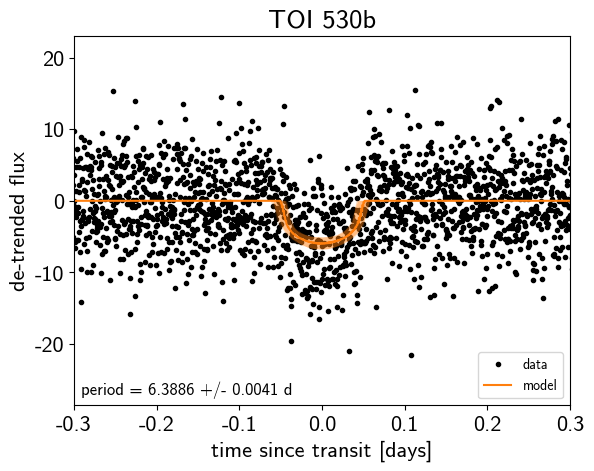

In [10]:
with model:
    light_curves = np.empty((500, len(model.x), len(periods)))
    func = xo.utils.get_theano_function_for_var(model.light_curves)
    for i, sample in enumerate(xo.utils.get_samples_from_trace(
            trace, size=len(light_curves))):
        light_curves[i] = func(*xo.utils.get_args_for_theano_function(sample))

for n, letter in enumerate(letters):
    plt.figure()

    # Compute the GP prediction
    mean_mod = np.median(trace["mean"][:, None])

    # Get the posterior median orbital parameters
    p = np.median(trace["period"][:, n])
    t0 = np.median(trace["t0"][:, n])

    # Compute the median of posterior estimate of the contribution from
    # the other planet. Then we can remove this from the data to plot
    # just the planet we care about.
    inds = np.arange(len(periods)) != n
    others = np.median(1e3*np.sum(light_curves[:, :, inds], axis=-1), axis=0)

    # Plot the folded data
    x_fold = (model.x - t0 + 0.5*p) % p - 0.5*p
    plt.plot(x_fold, model.y - mean_mod - others, ".k", label="data", zorder=-1000)

    # Plot the folded model
    inds = np.argsort(x_fold)
    inds = inds[np.abs(x_fold)[inds] < 0.3]
    pred = 1e3 * light_curves[:, inds, n]
    pred = np.percentile(pred, [16, 50, 84], axis=0)
    plt.plot(x_fold[inds], pred[1], color="C1", label="model")
    art = plt.fill_between(x_fold[inds], pred[0], pred[2], color="C1", alpha=0.5,
                           zorder=1000)
    art.set_edgecolor("none")

    # Annotate the plot with the planet's period
    txt = "period = {0:.4f} +/- {1:.4f} d".format(
        np.mean(trace["period"][:, n]), np.std(trace["period"][:, n]))
    plt.annotate(txt, (0, 0), xycoords="axes fraction",
                 xytext=(5, 5), textcoords="offset points",
                 ha="left", va="bottom", fontsize=12)

    plt.legend(fontsize=10, loc=4)
    plt.xlim(-0.5*p, 0.5*p)
    plt.xlabel("time since transit [days]")
    plt.ylabel("de-trended flux")
    plt.title("TOI {0}{1}".format(toi_num, letter));
    plt.xlim(-0.3, 0.3)

## Posterior constraints

Given the MCMC sampling, we can make some plots summarizing the constraints on the key parameters.
First up, we plot the physical radius of the planet using the stellar radius constraint from the TOI list, and the impact parameter (remember that we're using circular orbits).

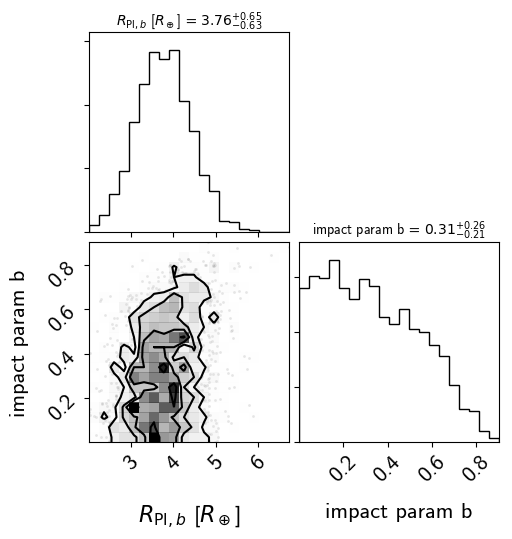

In [11]:
# Convert to Earth radii
r_pl = trace["r_pl"] * 109.07637070600963
samples = np.concatenate((r_pl, trace["b"]), axis=-1)

labels = ["$R_{{\mathrm{{Pl}},{0}}}$ [$R_\oplus$]".format(i) for i in letters]
labels += ["impact param {0}".format(i) for i in letters]

corner.corner(samples, labels=labels,
              show_titles=True, title_kwargs=dict(fontsize=10));

The other most interesting parameters are the period and transit times.

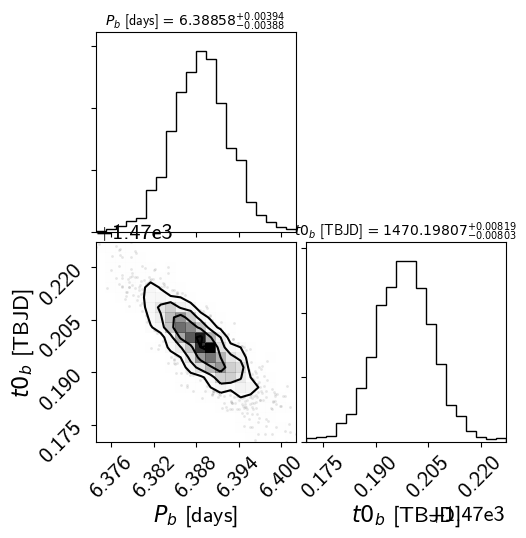

In [12]:
labels = ["$P_{{{0}}}$ [days]".format(i) for i in letters]
labels += ["$t0_{{{0}}}$ [TBJD]".format(i) for i in letters]
samples = np.concatenate((trace["period"], trace["t0"]), axis=-1)
corner.corner(samples, labels=labels,
              show_titles=True, title_fmt=".5f",
              title_kwargs=dict(fontsize=10));

Finally, here are the posterior constraints on the stellar properties.
These won't be exactly the same as the prior because the duration of the transits (and the assumption of circular orbits )

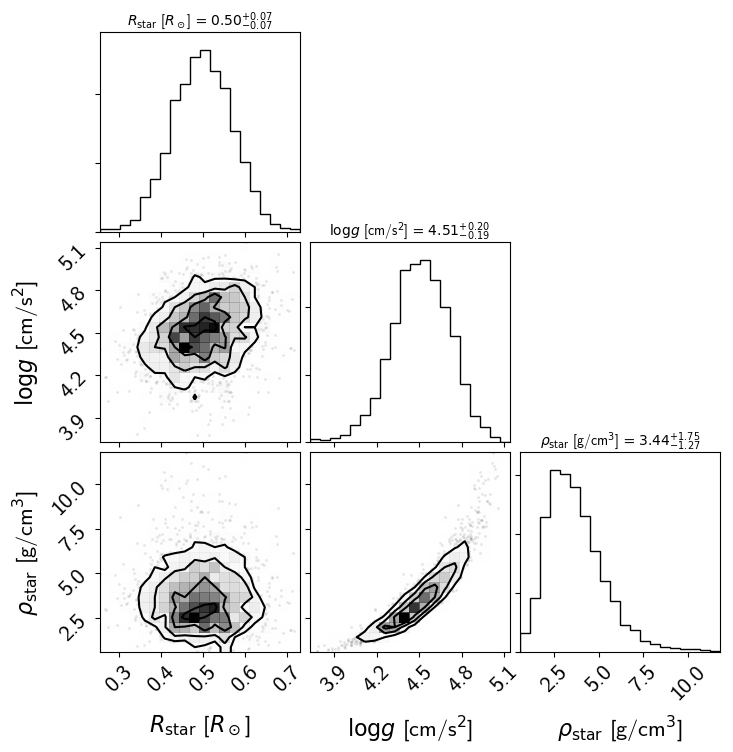

In [13]:
labels = ["$R_\mathrm{star}$ [$R_\odot$]", "$\log g$ [cm/s$^2$]",
          r"$\rho_\mathrm{star}$ [g/cm$^3$]"]
samples = np.vstack((trace["r_star"], trace["logg_star"], trace["rho_star"])).T
corner.corner(samples, labels=labels,
              show_titles=True,
              title_kwargs=dict(fontsize=10));

## Attribution

If you use these results or this code, please consider citing the relevant sources.
First, you can [cite the lightkurve package](https://zenodo.org/record/2611871):

```bibtex
@misc{lightkurve,
  author       = {Geert Barentsen and
                  Christina Hedges and
                  Zé Vinícius and
                  Nicholas Saunders and
                  gully and
                  Oliver Hall and
                  Sheila Sagear and
                  Tom Barclay and
                  KenMighell and
                  Keaton Bell and
                  Johnny Zhang and
                  Emma Turtelboom and
                  Zach Berta-Thompson and
                  Peter Williams and
                  Jose A Lerma III and
                  Guy Davies and
                  Brennan Vincello and
                  Anand Sundaram},
  title        = {KeplerGO/lightkurve: Lightkurve v1.0b30},
  month        = mar,
  year         = 2019,
  doi          = {10.5281/zenodo.2611871},
  url          = {https://doi.org/10.5281/zenodo.2611871}
}
```

You can also [cite the exoplanet project and its dependencies](https://exoplanet.dfm.io/en/stable/tutorials/citation/) using the following acknowledgement:

In [14]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:astropy13, exoplanet:astropy18,
exoplanet:espinoza18, exoplanet:exoplanet, exoplanet:kipping13,
exoplanet:luger18, exoplanet:pymc3, exoplanet:theano}.


and BibTeX entries:

In [15]:
print(bib)


@misc{exoplanet:exoplanet,
  author = {Dan Foreman-Mackey and
            Geert Barentsen and
            Tom Barclay},
   title = {dfm/exoplanet: exoplanet v0.1.5},
   month = mar,
    year = 2019,
     doi = {10.5281/zenodo.2587222},
     url = {https://doi.org/10.5281/zenodo.2587222}
}


@article{exoplanet:pymc3,
    title={Probabilistic programming in Python using PyMC3},
   author={Salvatier, John and Wiecki, Thomas V and Fonnesbeck, Christopher},
  journal={PeerJ Computer Science},
   volume={2},
    pages={e55},
     year={2016},
publisher={PeerJ Inc.}
}


@article{exoplanet:theano,
    title="{Theano: A {Python} framework for fast computation of mathematical
            expressions}",
   author={{Theano Development Team}},
  journal={arXiv e-prints},
   volume={abs/1605.02688},
     year=2016,
    month=may,
      url={http://arxiv.org/abs/1605.02688}
}


@ARTICLE{exoplanet:kipping13,
   author = {{Kipping}, D.~M.},
    title = "{Efficient, uninformative sampling of limb darke

## Environment

This notebook was run with the following conda environment:

In [16]:
!conda env export

name: tessatlas
channels:
  - defaults
dependencies:
  - astropy=3.1.2=py37h7b6447c_0
  - atomicwrites=1.3.0=py37_1
  - attrs=19.1.0=py37_1
  - blas=1.0=mkl
  - ca-certificates=2019.1.23=0
  - certifi=2019.3.9=py37_0
  - cycler=0.10.0=py37_0
  - dbus=1.13.6=h746ee38_0
  - expat=2.2.6=he6710b0_0
  - fontconfig=2.13.0=h9420a91_0
  - freetype=2.9.1=h8a8886c_1
  - glib=2.56.2=hd408876_0
  - gst-plugins-base=1.14.0=hbbd80ab_1
  - gstreamer=1.14.0=hb453b48_1
  - icu=58.2=h9c2bf20_1
  - intel-openmp=2019.3=199
  - jpeg=9b=h024ee3a_2
  - kiwisolver=1.0.1=py37hf484d3e_0
  - libedit=3.1.20181209=hc058e9b_0
  - libffi=3.2.1=hd88cf55_4
  - libgcc-ng=8.2.0=hdf63c60_1
  - libgfortran-ng=7.3.0=hdf63c60_0
  - libpng=1.6.36=hbc83047_0
  - libstdcxx-ng=8.2.0=hdf63c60_1
  - libuuid=1.0.3=h1bed415_2
  - libxcb=1.13=h1bed415_1
  - libxml2=2.9.9=he19cac6_0
  - matplotlib=3.0.3=py37h5429711_0
  - mkl=2019.3=199
  - mkl_fft=1.0.10=py37ha843d7b_0
  - mkl_random=1.0.2=py37hd81dba3_0
  - more-itertools=6.0.0=py3